In [1]:
!export CUDA_VISIBLE_DEVICES=0

In [2]:
import os, torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
print("Built with CUDA:", torch.version.cuda)     
print("CUDA available?:", torch.cuda.is_available())  
print("Device count:", torch.cuda.device_count())

CUDA_VISIBLE_DEVICES: 0
Built with CUDA: 12.4
CUDA available?: True
Device count: 1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.utils.data import random_split
from semisupervised import SemiSupervisedAutoEncoderOptions, SemiSupervisedAdversarialAutoencoder

## OG Setup

In [4]:
def configure_mnist(batch_size=100, val_size=10000):
    # transform: ToTensor + flatten
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])

    # full train + test datasets
    full_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_ds    = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # split full_train → train_ds (60k - val_size) and val_ds (val_size)
    print(len(full_train))
    train_size = len(full_train) - val_size
    train_ds, val_ds = random_split(full_train, [train_size, val_size], generator=torch.Generator().manual_seed(42))

    # DataLoaders
    train_loader = DataLoader(train_ds,  batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    # (Optionally) extract raw tensors:
    X_train = torch.stack([x for x, _ in train_ds])
    Y_train = torch.tensor([y for _, y in train_ds])
    X_val   = torch.stack([x for x, _ in val_ds])
    Y_val   = torch.tensor([y for _, y in val_ds])
    X_test  = torch.stack([x for x, _ in test_ds])
    Y_test  = test_ds.targets.clone()

    return (X_train, X_val, X_test,
            Y_train, Y_val, Y_test,
            train_loader, val_loader, test_loader)

In [5]:
(X_train, X_val, X_test, Y_train, Y_val, Y_test, train_loader, val_loader, test_loader) = configure_mnist()

print(Y_train.max())
print(Y_train.min())

60000
tensor(9)
tensor(0)


In [4]:
NUM_EPOCHS = 50
GAUSSIAN_NOISE = True
INPUT_DIM = 784
BATCH_SIZE = 100
AE_HIDDEN = 1000
DC_HIDDEN = 1000
LATENT_DIM_CAT = 10
LATENT_DIM_STYLE = 10
PRIOR_STD = 1.0
RESULT_FOLDER = 'semisupervised_results/50_momentum_noise_fixed'
NUM_LABELED = 1000

recon_loss = nn.MSELoss()
# init_recon_lr = 0.001 #0.01
init_recon_lr = 0.01

semi_sup_loss = nn.CrossEntropyLoss()
# init_semi_sup_lr = 0.001 #0.1
init_semi_sup_lr = 0.1

# init_gen_lr = init_disc_lr = 0.001 #0.1
init_gen_lr = init_disc_lr = 0.1
use_decoder_sigmoid = True

In [5]:
options = SemiSupervisedAutoEncoderOptions(
    input_dim=INPUT_DIM,
    ae_hidden_dim=AE_HIDDEN,
    disc_hidden_dim=DC_HIDDEN,
    latent_dim_categorical=LATENT_DIM_CAT,
    latent_dim_style=LATENT_DIM_STYLE,
    recon_loss_fn=recon_loss,
    init_recon_lr=init_recon_lr,
    semi_supervised_loss_fn=semi_sup_loss,
    init_semi_sup_lr=init_semi_sup_lr,
    init_gen_lr=init_gen_lr,
    use_decoder_sigmoid=use_decoder_sigmoid,
    init_disc_categorical_lr = init_disc_lr,
    init_disc_style_lr = init_disc_lr
)

model = SemiSupervisedAdversarialAutoencoder(options);

In [ ]:
model.train_mbgd(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=NUM_EPOCHS,
    prior_std=PRIOR_STD,
    result_folder=RESULT_FOLDER,
    add_gaussian_noise=GAUSSIAN_NOISE
)

## Fixed Experiment

In [4]:
NUM_EPOCHS = 5000
GAUSSIAN_NOISE = True
INPUT_DIM = 784
BATCH_SIZE = 100
AE_HIDDEN = 1000
DC_HIDDEN = 1000
LATENT_DIM_CAT = 10
LATENT_DIM_STYLE = 10
PRIOR_STD = 1.0
RESULT_FOLDER = 'semisupervised_results/5000_epochs_adam_2000_samples'
NUM_LABELED = 2000

recon_loss = nn.MSELoss()
init_recon_lr = 0.001 #0.01
# init_recon_lr = 0.01

semi_sup_loss = nn.CrossEntropyLoss()
init_semi_sup_lr = 0.01 #0.1
# init_semi_sup_lr = 0.1

init_gen_lr = init_disc_lr = 0.001 #0.1
# init_gen_lr = init_disc_lr = 0.1
use_decoder_sigmoid = False

In [5]:
from torch.utils.data import DataLoader, Subset, random_split, Dataset
from torchvision import datasets, transforms
import torch, numpy as np


class UnlabeledWrapper(Dataset):
    """Return images only; label is always -1."""
    def __init__(self, base_ds, indices):
        self.base_ds = base_ds
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        x, _ = self.base_ds[self.indices[i]]
        return x, -1


def configure_mnist(batch_size=100, n_labeled=1000, val_fraction=0.10, seed=42):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))          # flatten to 784
    ])

    full_train = datasets.MNIST(root='./data', train=True,  download=True, transform=transform)
    test_ds    = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    rng = np.random.RandomState(seed)
    all_idx       = np.arange(len(full_train))                       # 60 000 indices
    labeled_idx   = rng.choice(all_idx, size=n_labeled, replace=False)
    remaining_idx = np.setdiff1d(all_idx, labeled_idx)

    n_val   = int(len(remaining_idx) * val_fraction)
    val_idx = rng.choice(remaining_idx, size=n_val, replace=False)
    unlabeled_idx = np.setdiff1d(remaining_idx, val_idx)

    labeled_ds     = Subset(full_train, labeled_idx)                 # (x, y)
    val_ds         = Subset(full_train, val_idx)                     # (x, y)
    unlabeled_ds   = UnlabeledWrapper(full_train, unlabeled_idx)     # (x, -1)

    train_labeled_loader   = DataLoader(labeled_ds,   batch_size=batch_size, shuffle=True,  drop_last=True)
    train_unlabeled_loader = DataLoader(unlabeled_ds, batch_size=batch_size, shuffle=True,  drop_last=True)
    val_loader             = DataLoader(val_ds,       batch_size=batch_size, shuffle=False)
    test_loader            = DataLoader(test_ds,      batch_size=batch_size, shuffle=False)

    X_lab = torch.stack([x for x, _ in labeled_ds])
    Y_lab = torch.tensor([y for _, y in labeled_ds])

    X_val = torch.stack([x for x, _ in val_ds])
    Y_val = torch.tensor([y for _, y in val_ds])

    X_test = torch.stack([x for x, _ in test_ds])
    Y_test = test_ds.targets.clone()

    return (X_lab, X_val, X_test,
            Y_lab, Y_val, Y_test,
            train_labeled_loader, train_unlabeled_loader, val_loader, test_loader)

In [6]:
(X_lab, X_val, X_test,
 Y_lab, Y_val, Y_test,
 train_labeled_loader,
 train_unlabeled_loader,
 val_loader,
 test_loader) = configure_mnist(batch_size=BATCH_SIZE, n_labeled=NUM_LABELED)

print("labelled   :", len(train_labeled_loader.dataset))   # 1 000
print("unlabelled :", len(train_unlabeled_loader.dataset)) # ≈53 000
print("val        :", len(val_loader.dataset))             # ≈6 000
print(Y_lab.max(), Y_lab.min())      

labelled   : 2000
unlabelled : 52200
val        : 5800
tensor(9) tensor(0)


In [7]:
options = SemiSupervisedAutoEncoderOptions(
    input_dim=INPUT_DIM,
    ae_hidden_dim=AE_HIDDEN,
    disc_hidden_dim=DC_HIDDEN,
    latent_dim_categorical=LATENT_DIM_CAT,
    latent_dim_style=LATENT_DIM_STYLE,
    recon_loss_fn=recon_loss,
    init_recon_lr=init_recon_lr,
    semi_supervised_loss_fn=semi_sup_loss,
    init_semi_sup_lr=init_semi_sup_lr,
    init_gen_lr=init_gen_lr,
    use_decoder_sigmoid=use_decoder_sigmoid,
    init_disc_categorical_lr = init_disc_lr,
    init_disc_style_lr = init_disc_lr
)

model = SemiSupervisedAdversarialAutoencoder(options);

In [8]:
model.train_mbgd_2(
    val_loader=val_loader,
    epochs=NUM_EPOCHS,
    prior_std=PRIOR_STD,
    result_folder=RESULT_FOLDER,
    add_gaussian_noise=GAUSSIAN_NOISE,
    train_labeled_loader=train_labeled_loader,
    train_unlabeled_loader=train_unlabeled_loader
)

Epoch [1/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/5000 — Recon_U: 0.0890, Recon_L: 0.0896, SemiSup: 1.2986, Disc_Cat: 1.3080, Gen_Cat: 0.6712, Disc_Sty: 0.9791, Gen_Sty: 0.7453
Validation Accuracy: 76.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/5000 — Recon_U: 0.0674, Recon_L: 0.0672, SemiSup: 0.6106, Disc_Cat: 1.2091, Gen_Cat: 0.8667, Disc_Sty: 2.6923, Gen_Sty: 1.6546
Validation Accuracy: 87.88%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/5000 — Recon_U: 0.0615, Recon_L: 0.0619, SemiSup: 0.4433, Disc_Cat: 1.1589, Gen_Cat: 1.2051, Disc_Sty: 1.8873, Gen_Sty: 1.7687
Validation Accuracy: 89.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/5000 — Recon_U: 0.0565, Recon_L: 0.0562, SemiSup: 0.3667, Disc_Cat: 1.1962, Gen_Cat: 1.2735, Disc_Sty: 1.6991, Gen_Sty: 0.9973
Validation Accuracy: 89.81%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [5/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/5000 — Recon_U: 0.0538, Recon_L: 0.0532, SemiSup: 0.3045, Disc_Cat: 1.1752, Gen_Cat: 1.4327, Disc_Sty: 1.1286, Gen_Sty: 1.5669
Validation Accuracy: 91.21%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [6/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/5000 — Recon_U: 0.0505, Recon_L: 0.0513, SemiSup: 0.2828, Disc_Cat: 1.1905, Gen_Cat: 1.3216, Disc_Sty: 1.2781, Gen_Sty: 1.6653
Validation Accuracy: 88.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [7/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/5000 — Recon_U: 0.0488, Recon_L: 0.0496, SemiSup: 0.2203, Disc_Cat: 1.2098, Gen_Cat: 1.2844, Disc_Sty: 1.1692, Gen_Sty: 1.8864
Validation Accuracy: 90.88%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [8/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/5000 — Recon_U: 0.0474, Recon_L: 0.0475, SemiSup: 0.2349, Disc_Cat: 1.2211, Gen_Cat: 1.2688, Disc_Sty: 1.2772, Gen_Sty: 1.7935
Validation Accuracy: 90.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [9/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/5000 — Recon_U: 0.0466, Recon_L: 0.0464, SemiSup: 0.2357, Disc_Cat: 1.1912, Gen_Cat: 1.3578, Disc_Sty: 1.1631, Gen_Sty: 3.0434
Validation Accuracy: 91.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [10/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/5000 — Recon_U: 0.0463, Recon_L: 0.0450, SemiSup: 0.2110, Disc_Cat: 1.1563, Gen_Cat: 1.4509, Disc_Sty: 1.4737, Gen_Sty: 2.3679
Validation Accuracy: 90.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [11/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/5000 — Recon_U: 0.0443, Recon_L: 0.0438, SemiSup: 0.2661, Disc_Cat: 1.2155, Gen_Cat: 1.3472, Disc_Sty: 0.8727, Gen_Sty: 2.2932
Validation Accuracy: 89.97%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [12/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/5000 — Recon_U: 0.0439, Recon_L: 0.0436, SemiSup: 0.2151, Disc_Cat: 1.2237, Gen_Cat: 1.3712, Disc_Sty: 1.1818, Gen_Sty: 1.6626
Validation Accuracy: 91.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [13/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/5000 — Recon_U: 0.0418, Recon_L: 0.0422, SemiSup: 0.2101, Disc_Cat: 1.2380, Gen_Cat: 1.2762, Disc_Sty: 1.5194, Gen_Sty: 2.5501
Validation Accuracy: 89.93%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [14/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/5000 — Recon_U: 0.0414, Recon_L: 0.0408, SemiSup: 0.1596, Disc_Cat: 1.2599, Gen_Cat: 1.2240, Disc_Sty: 1.1171, Gen_Sty: 1.8843
Validation Accuracy: 91.95%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [15/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/5000 — Recon_U: 0.0395, Recon_L: 0.0394, SemiSup: 0.1647, Disc_Cat: 1.2914, Gen_Cat: 1.0879, Disc_Sty: 1.2785, Gen_Sty: 1.9995
Validation Accuracy: 91.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [16/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/5000 — Recon_U: 0.0398, Recon_L: 0.0394, SemiSup: 0.1561, Disc_Cat: 1.2306, Gen_Cat: 1.1555, Disc_Sty: 1.5340, Gen_Sty: 2.7849
Validation Accuracy: 92.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [17/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/5000 — Recon_U: 0.0407, Recon_L: 0.0395, SemiSup: 0.1384, Disc_Cat: 1.2466, Gen_Cat: 1.1761, Disc_Sty: 1.7228, Gen_Sty: 2.7345
Validation Accuracy: 91.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [18/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/5000 — Recon_U: 0.0383, Recon_L: 0.0383, SemiSup: 0.1825, Disc_Cat: 1.2588, Gen_Cat: 1.1229, Disc_Sty: 1.2357, Gen_Sty: 1.1290
Validation Accuracy: 91.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [19/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/5000 — Recon_U: 0.0385, Recon_L: 0.0381, SemiSup: 0.1690, Disc_Cat: 1.2518, Gen_Cat: 1.1233, Disc_Sty: 1.3033, Gen_Sty: 0.7641
Validation Accuracy: 91.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [20/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/5000 — Recon_U: 0.0375, Recon_L: 0.0370, SemiSup: 0.1440, Disc_Cat: 1.2833, Gen_Cat: 1.1007, Disc_Sty: 1.4914, Gen_Sty: 0.9179
Validation Accuracy: 91.97%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [21/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21/5000 — Recon_U: 0.0368, Recon_L: 0.0360, SemiSup: 0.1313, Disc_Cat: 1.2736, Gen_Cat: 1.0923, Disc_Sty: 1.3770, Gen_Sty: 1.9242
Validation Accuracy: 91.88%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [22/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22/5000 — Recon_U: 0.0369, Recon_L: 0.0362, SemiSup: 0.1771, Disc_Cat: 1.2762, Gen_Cat: 1.0903, Disc_Sty: 1.4079, Gen_Sty: 0.7742
Validation Accuracy: 91.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [23/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23/5000 — Recon_U: 0.0359, Recon_L: 0.0356, SemiSup: 0.1518, Disc_Cat: 1.2862, Gen_Cat: 1.0962, Disc_Sty: 1.3302, Gen_Sty: 0.6834
Validation Accuracy: 91.81%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [24/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24/5000 — Recon_U: 0.0359, Recon_L: 0.0349, SemiSup: 0.1174, Disc_Cat: 1.2922, Gen_Cat: 1.0183, Disc_Sty: 1.2672, Gen_Sty: 0.8533
Validation Accuracy: 92.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [25/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25/5000 — Recon_U: 0.0352, Recon_L: 0.0345, SemiSup: 0.1466, Disc_Cat: 1.3134, Gen_Cat: 0.9699, Disc_Sty: 1.3380, Gen_Sty: 1.1239
Validation Accuracy: 92.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [26/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26/5000 — Recon_U: 0.0352, Recon_L: 0.0346, SemiSup: 0.1623, Disc_Cat: 1.3008, Gen_Cat: 0.9729, Disc_Sty: 1.3789, Gen_Sty: 0.9374
Validation Accuracy: 92.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [27/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27/5000 — Recon_U: 0.0348, Recon_L: 0.0342, SemiSup: 0.1579, Disc_Cat: 1.2695, Gen_Cat: 1.0124, Disc_Sty: 1.2782, Gen_Sty: 0.8723
Validation Accuracy: 92.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [28/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28/5000 — Recon_U: 0.0351, Recon_L: 0.0340, SemiSup: 0.1996, Disc_Cat: 1.3130, Gen_Cat: 0.9442, Disc_Sty: 1.4577, Gen_Sty: 0.6955
Validation Accuracy: 91.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [29/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29/5000 — Recon_U: 0.0345, Recon_L: 0.0338, SemiSup: 0.1210, Disc_Cat: 1.2971, Gen_Cat: 1.0054, Disc_Sty: 1.3075, Gen_Sty: 1.0859
Validation Accuracy: 91.95%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [30/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/5000 — Recon_U: 0.0344, Recon_L: 0.0337, SemiSup: 0.1460, Disc_Cat: 1.2897, Gen_Cat: 0.9964, Disc_Sty: 1.4044, Gen_Sty: 0.7856
Validation Accuracy: 91.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [31/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31/5000 — Recon_U: 0.0347, Recon_L: 0.0333, SemiSup: 0.1414, Disc_Cat: 1.3071, Gen_Cat: 0.9715, Disc_Sty: 1.3777, Gen_Sty: 0.7861
Validation Accuracy: 91.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [32/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32/5000 — Recon_U: 0.0342, Recon_L: 0.0329, SemiSup: 0.1453, Disc_Cat: 1.2971, Gen_Cat: 1.0233, Disc_Sty: 1.3360, Gen_Sty: 0.7695
Validation Accuracy: 92.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [33/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33/5000 — Recon_U: 0.0336, Recon_L: 0.0331, SemiSup: 0.1165, Disc_Cat: 1.3022, Gen_Cat: 0.9617, Disc_Sty: 1.3943, Gen_Sty: 0.7297
Validation Accuracy: 92.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [34/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34/5000 — Recon_U: 0.0338, Recon_L: 0.0329, SemiSup: 0.1136, Disc_Cat: 1.3054, Gen_Cat: 0.9576, Disc_Sty: 1.3806, Gen_Sty: 0.9151
Validation Accuracy: 91.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [35/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35/5000 — Recon_U: 0.0340, Recon_L: 0.0325, SemiSup: 0.1379, Disc_Cat: 1.3126, Gen_Cat: 0.9465, Disc_Sty: 1.3956, Gen_Sty: 0.7626
Validation Accuracy: 91.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [36/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36/5000 — Recon_U: 0.0345, Recon_L: 0.0325, SemiSup: 0.1492, Disc_Cat: 1.3144, Gen_Cat: 0.9789, Disc_Sty: 1.3396, Gen_Sty: 0.7297
Validation Accuracy: 92.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [37/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37/5000 — Recon_U: 0.0341, Recon_L: 0.0323, SemiSup: 0.1095, Disc_Cat: 1.3015, Gen_Cat: 0.9785, Disc_Sty: 1.4044, Gen_Sty: 0.7056
Validation Accuracy: 92.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [38/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38/5000 — Recon_U: 0.0334, Recon_L: 0.0319, SemiSup: 0.1239, Disc_Cat: 1.3028, Gen_Cat: 0.9592, Disc_Sty: 1.3547, Gen_Sty: 0.8566
Validation Accuracy: 91.98%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [39/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39/5000 — Recon_U: 0.0329, Recon_L: 0.0318, SemiSup: 0.1102, Disc_Cat: 1.3199, Gen_Cat: 0.9463, Disc_Sty: 1.3808, Gen_Sty: 0.7122
Validation Accuracy: 92.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [40/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40/5000 — Recon_U: 0.0333, Recon_L: 0.0319, SemiSup: 0.1139, Disc_Cat: 1.3131, Gen_Cat: 0.9213, Disc_Sty: 1.3501, Gen_Sty: 0.7078
Validation Accuracy: 92.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [41/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 41/5000 — Recon_U: 0.0332, Recon_L: 0.0316, SemiSup: 0.1522, Disc_Cat: 1.3173, Gen_Cat: 0.9275, Disc_Sty: 1.3505, Gen_Sty: 0.7766
Validation Accuracy: 92.14%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [42/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 42/5000 — Recon_U: 0.0336, Recon_L: 0.0322, SemiSup: 0.1050, Disc_Cat: 1.3184, Gen_Cat: 0.8832, Disc_Sty: 1.3710, Gen_Sty: 0.7838
Validation Accuracy: 90.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [43/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43/5000 — Recon_U: 0.0334, Recon_L: 0.0314, SemiSup: 0.0907, Disc_Cat: 1.3187, Gen_Cat: 0.8913, Disc_Sty: 1.3665, Gen_Sty: 0.7738
Validation Accuracy: 92.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [44/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44/5000 — Recon_U: 0.0327, Recon_L: 0.0314, SemiSup: 0.1078, Disc_Cat: 1.3219, Gen_Cat: 0.8847, Disc_Sty: 1.3736, Gen_Sty: 0.6868
Validation Accuracy: 92.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [45/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45/5000 — Recon_U: 0.0327, Recon_L: 0.0313, SemiSup: 0.1103, Disc_Cat: 1.3125, Gen_Cat: 0.9206, Disc_Sty: 1.3550, Gen_Sty: 0.7369
Validation Accuracy: 92.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [46/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46/5000 — Recon_U: 0.0329, Recon_L: 0.0312, SemiSup: 0.1022, Disc_Cat: 1.3349, Gen_Cat: 0.8703, Disc_Sty: 1.3580, Gen_Sty: 0.7614
Validation Accuracy: 92.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [47/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47/5000 — Recon_U: 0.0326, Recon_L: 0.0310, SemiSup: 0.1479, Disc_Cat: 1.3204, Gen_Cat: 0.8777, Disc_Sty: 1.3590, Gen_Sty: 0.7452
Validation Accuracy: 92.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [48/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48/5000 — Recon_U: 0.0324, Recon_L: 0.0308, SemiSup: 0.1056, Disc_Cat: 1.3172, Gen_Cat: 0.8896, Disc_Sty: 1.3441, Gen_Sty: 0.7331
Validation Accuracy: 92.21%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [49/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49/5000 — Recon_U: 0.0332, Recon_L: 0.0316, SemiSup: 0.1131, Disc_Cat: 1.3025, Gen_Cat: 0.9439, Disc_Sty: 1.3801, Gen_Sty: 0.6742
Validation Accuracy: 91.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [50/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50/5000 — Recon_U: 0.0332, Recon_L: 0.0312, SemiSup: 0.0828, Disc_Cat: 1.3111, Gen_Cat: 0.9203, Disc_Sty: 1.3419, Gen_Sty: 0.7903
Validation Accuracy: 92.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_50/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [51/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 51/5000 — Recon_U: 0.0327, Recon_L: 0.0307, SemiSup: 0.0995, Disc_Cat: 1.3376, Gen_Cat: 0.8775, Disc_Sty: 1.3986, Gen_Sty: 0.7455
Validation Accuracy: 92.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [52/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 52/5000 — Recon_U: 0.0314, Recon_L: 0.0295, SemiSup: 0.1365, Disc_Cat: 1.3174, Gen_Cat: 0.8716, Disc_Sty: 1.3885, Gen_Sty: 0.7379
Validation Accuracy: 92.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [53/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 53/5000 — Recon_U: 0.0309, Recon_L: 0.0291, SemiSup: 0.0809, Disc_Cat: 1.3192, Gen_Cat: 0.8652, Disc_Sty: 1.3706, Gen_Sty: 0.7343
Validation Accuracy: 93.00%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [54/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 54/5000 — Recon_U: 0.0311, Recon_L: 0.0289, SemiSup: 0.0551, Disc_Cat: 1.3201, Gen_Cat: 0.8639, Disc_Sty: 1.3708, Gen_Sty: 0.7263
Validation Accuracy: 93.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [55/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 55/5000 — Recon_U: 0.0306, Recon_L: 0.0287, SemiSup: 0.0848, Disc_Cat: 1.3236, Gen_Cat: 0.8641, Disc_Sty: 1.3664, Gen_Sty: 0.7311
Validation Accuracy: 93.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [56/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 56/5000 — Recon_U: 0.0306, Recon_L: 0.0287, SemiSup: 0.0749, Disc_Cat: 1.3171, Gen_Cat: 0.8599, Disc_Sty: 1.3670, Gen_Sty: 0.7270
Validation Accuracy: 93.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [57/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 57/5000 — Recon_U: 0.0310, Recon_L: 0.0285, SemiSup: 0.0778, Disc_Cat: 1.3239, Gen_Cat: 0.8800, Disc_Sty: 1.3553, Gen_Sty: 0.7326
Validation Accuracy: 93.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [58/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 58/5000 — Recon_U: 0.0307, Recon_L: 0.0284, SemiSup: 0.0604, Disc_Cat: 1.3182, Gen_Cat: 0.8789, Disc_Sty: 1.3604, Gen_Sty: 0.7288
Validation Accuracy: 93.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [59/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 59/5000 — Recon_U: 0.0302, Recon_L: 0.0283, SemiSup: 0.0695, Disc_Cat: 1.3236, Gen_Cat: 0.8695, Disc_Sty: 1.3690, Gen_Sty: 0.7225
Validation Accuracy: 93.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [60/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 60/5000 — Recon_U: 0.0303, Recon_L: 0.0282, SemiSup: 0.0711, Disc_Cat: 1.3228, Gen_Cat: 0.8607, Disc_Sty: 1.3605, Gen_Sty: 0.7278
Validation Accuracy: 93.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [61/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 61/5000 — Recon_U: 0.0306, Recon_L: 0.0283, SemiSup: 0.0340, Disc_Cat: 1.3297, Gen_Cat: 0.8503, Disc_Sty: 1.3574, Gen_Sty: 0.7282
Validation Accuracy: 93.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [62/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 62/5000 — Recon_U: 0.0309, Recon_L: 0.0282, SemiSup: 0.0796, Disc_Cat: 1.3239, Gen_Cat: 0.8762, Disc_Sty: 1.3697, Gen_Sty: 0.7182
Validation Accuracy: 93.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [63/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 63/5000 — Recon_U: 0.0309, Recon_L: 0.0281, SemiSup: 0.0450, Disc_Cat: 1.3240, Gen_Cat: 0.8615, Disc_Sty: 1.3704, Gen_Sty: 0.7120
Validation Accuracy: 93.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [64/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 64/5000 — Recon_U: 0.0302, Recon_L: 0.0280, SemiSup: 0.0545, Disc_Cat: 1.3225, Gen_Cat: 0.8674, Disc_Sty: 1.3666, Gen_Sty: 0.7144
Validation Accuracy: 93.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [65/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 65/5000 — Recon_U: 0.0295, Recon_L: 0.0279, SemiSup: 0.0496, Disc_Cat: 1.3286, Gen_Cat: 0.8571, Disc_Sty: 1.3687, Gen_Sty: 0.7109
Validation Accuracy: 93.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [66/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 66/5000 — Recon_U: 0.0301, Recon_L: 0.0278, SemiSup: 0.0293, Disc_Cat: 1.3346, Gen_Cat: 0.8454, Disc_Sty: 1.3745, Gen_Sty: 0.7029
Validation Accuracy: 93.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [67/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 67/5000 — Recon_U: 0.0301, Recon_L: 0.0280, SemiSup: 0.0503, Disc_Cat: 1.3223, Gen_Cat: 0.8783, Disc_Sty: 1.3694, Gen_Sty: 0.7035
Validation Accuracy: 93.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [68/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 68/5000 — Recon_U: 0.0300, Recon_L: 0.0278, SemiSup: 0.0494, Disc_Cat: 1.3300, Gen_Cat: 0.8551, Disc_Sty: 1.3691, Gen_Sty: 0.7028
Validation Accuracy: 93.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [69/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 69/5000 — Recon_U: 0.0303, Recon_L: 0.0279, SemiSup: 0.0548, Disc_Cat: 1.3277, Gen_Cat: 0.8667, Disc_Sty: 1.3707, Gen_Sty: 0.7013
Validation Accuracy: 93.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [70/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 70/5000 — Recon_U: 0.0298, Recon_L: 0.0278, SemiSup: 0.0334, Disc_Cat: 1.3258, Gen_Cat: 0.8737, Disc_Sty: 1.3714, Gen_Sty: 0.6990
Validation Accuracy: 93.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [71/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 71/5000 — Recon_U: 0.0297, Recon_L: 0.0276, SemiSup: 0.0456, Disc_Cat: 1.3306, Gen_Cat: 0.8733, Disc_Sty: 1.3729, Gen_Sty: 0.6990
Validation Accuracy: 93.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [72/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 72/5000 — Recon_U: 0.0300, Recon_L: 0.0277, SemiSup: 0.0407, Disc_Cat: 1.3283, Gen_Cat: 0.8702, Disc_Sty: 1.3688, Gen_Sty: 0.7054
Validation Accuracy: 93.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [73/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 73/5000 — Recon_U: 0.0296, Recon_L: 0.0277, SemiSup: 0.0541, Disc_Cat: 1.3302, Gen_Cat: 0.8644, Disc_Sty: 1.3639, Gen_Sty: 0.7014
Validation Accuracy: 93.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [74/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 74/5000 — Recon_U: 0.0295, Recon_L: 0.0275, SemiSup: 0.0408, Disc_Cat: 1.3326, Gen_Cat: 0.8563, Disc_Sty: 1.3673, Gen_Sty: 0.7050
Validation Accuracy: 93.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [75/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 75/5000 — Recon_U: 0.0298, Recon_L: 0.0274, SemiSup: 0.0399, Disc_Cat: 1.3283, Gen_Cat: 0.8650, Disc_Sty: 1.3705, Gen_Sty: 0.7046
Validation Accuracy: 93.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [76/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 76/5000 — Recon_U: 0.0300, Recon_L: 0.0274, SemiSup: 0.0293, Disc_Cat: 1.3340, Gen_Cat: 0.8585, Disc_Sty: 1.3720, Gen_Sty: 0.7018
Validation Accuracy: 93.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [77/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 77/5000 — Recon_U: 0.0296, Recon_L: 0.0275, SemiSup: 0.0552, Disc_Cat: 1.3315, Gen_Cat: 0.8435, Disc_Sty: 1.3697, Gen_Sty: 0.7032
Validation Accuracy: 93.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [78/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 78/5000 — Recon_U: 0.0296, Recon_L: 0.0274, SemiSup: 0.0525, Disc_Cat: 1.3327, Gen_Cat: 0.8695, Disc_Sty: 1.3695, Gen_Sty: 0.7044
Validation Accuracy: 93.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [79/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 79/5000 — Recon_U: 0.0292, Recon_L: 0.0272, SemiSup: 0.0288, Disc_Cat: 1.3335, Gen_Cat: 0.8465, Disc_Sty: 1.3721, Gen_Sty: 0.7031
Validation Accuracy: 93.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [80/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 80/5000 — Recon_U: 0.0294, Recon_L: 0.0272, SemiSup: 0.0369, Disc_Cat: 1.3333, Gen_Cat: 0.8739, Disc_Sty: 1.3637, Gen_Sty: 0.7044
Validation Accuracy: 93.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [81/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 81/5000 — Recon_U: 0.0295, Recon_L: 0.0273, SemiSup: 0.0314, Disc_Cat: 1.3338, Gen_Cat: 0.8603, Disc_Sty: 1.3634, Gen_Sty: 0.7075
Validation Accuracy: 93.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [82/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 82/5000 — Recon_U: 0.0294, Recon_L: 0.0272, SemiSup: 0.0546, Disc_Cat: 1.3272, Gen_Cat: 0.8703, Disc_Sty: 1.3699, Gen_Sty: 0.6966
Validation Accuracy: 93.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [83/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 83/5000 — Recon_U: 0.0296, Recon_L: 0.0271, SemiSup: 0.0285, Disc_Cat: 1.3344, Gen_Cat: 0.8628, Disc_Sty: 1.3727, Gen_Sty: 0.6995
Validation Accuracy: 93.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [84/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 84/5000 — Recon_U: 0.0295, Recon_L: 0.0272, SemiSup: 0.0382, Disc_Cat: 1.3275, Gen_Cat: 0.8778, Disc_Sty: 1.3699, Gen_Sty: 0.7003
Validation Accuracy: 93.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [85/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 85/5000 — Recon_U: 0.0288, Recon_L: 0.0270, SemiSup: 0.0499, Disc_Cat: 1.3376, Gen_Cat: 0.8391, Disc_Sty: 1.3650, Gen_Sty: 0.7031
Validation Accuracy: 93.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [86/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 86/5000 — Recon_U: 0.0293, Recon_L: 0.0271, SemiSup: 0.0377, Disc_Cat: 1.3346, Gen_Cat: 0.8625, Disc_Sty: 1.3662, Gen_Sty: 0.7049
Validation Accuracy: 93.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [87/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 87/5000 — Recon_U: 0.0294, Recon_L: 0.0271, SemiSup: 0.0291, Disc_Cat: 1.3362, Gen_Cat: 0.8565, Disc_Sty: 1.3652, Gen_Sty: 0.7074
Validation Accuracy: 93.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [88/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 88/5000 — Recon_U: 0.0300, Recon_L: 0.0270, SemiSup: 0.0410, Disc_Cat: 1.3386, Gen_Cat: 0.8539, Disc_Sty: 1.3703, Gen_Sty: 0.7048
Validation Accuracy: 93.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [89/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 89/5000 — Recon_U: 0.0299, Recon_L: 0.0270, SemiSup: 0.0252, Disc_Cat: 1.3272, Gen_Cat: 0.8728, Disc_Sty: 1.3707, Gen_Sty: 0.7044
Validation Accuracy: 93.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [90/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 90/5000 — Recon_U: 0.0293, Recon_L: 0.0269, SemiSup: 0.0372, Disc_Cat: 1.3298, Gen_Cat: 0.8738, Disc_Sty: 1.3676, Gen_Sty: 0.7063
Validation Accuracy: 93.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [91/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 91/5000 — Recon_U: 0.0289, Recon_L: 0.0269, SemiSup: 0.0484, Disc_Cat: 1.3380, Gen_Cat: 0.8564, Disc_Sty: 1.3686, Gen_Sty: 0.7113
Validation Accuracy: 93.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [92/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 92/5000 — Recon_U: 0.0289, Recon_L: 0.0269, SemiSup: 0.0557, Disc_Cat: 1.3348, Gen_Cat: 0.8551, Disc_Sty: 1.3694, Gen_Sty: 0.7041
Validation Accuracy: 93.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [93/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 93/5000 — Recon_U: 0.0293, Recon_L: 0.0268, SemiSup: 0.0382, Disc_Cat: 1.3419, Gen_Cat: 0.8503, Disc_Sty: 1.3712, Gen_Sty: 0.7064
Validation Accuracy: 93.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [94/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 94/5000 — Recon_U: 0.0289, Recon_L: 0.0267, SemiSup: 0.0461, Disc_Cat: 1.3373, Gen_Cat: 0.8526, Disc_Sty: 1.3701, Gen_Sty: 0.7066
Validation Accuracy: 93.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [95/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 95/5000 — Recon_U: 0.0295, Recon_L: 0.0268, SemiSup: 0.0444, Disc_Cat: 1.3424, Gen_Cat: 0.8620, Disc_Sty: 1.3685, Gen_Sty: 0.7046
Validation Accuracy: 93.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [96/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 96/5000 — Recon_U: 0.0289, Recon_L: 0.0267, SemiSup: 0.0419, Disc_Cat: 1.3389, Gen_Cat: 0.8474, Disc_Sty: 1.3726, Gen_Sty: 0.7009
Validation Accuracy: 93.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [97/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 97/5000 — Recon_U: 0.0288, Recon_L: 0.0266, SemiSup: 0.0362, Disc_Cat: 1.3333, Gen_Cat: 0.8864, Disc_Sty: 1.3697, Gen_Sty: 0.7014
Validation Accuracy: 93.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [98/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 98/5000 — Recon_U: 0.0291, Recon_L: 0.0267, SemiSup: 0.0318, Disc_Cat: 1.3444, Gen_Cat: 0.8377, Disc_Sty: 1.3725, Gen_Sty: 0.6997
Validation Accuracy: 93.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [99/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 99/5000 — Recon_U: 0.0290, Recon_L: 0.0266, SemiSup: 0.0327, Disc_Cat: 1.3352, Gen_Cat: 0.8633, Disc_Sty: 1.3648, Gen_Sty: 0.7057
Validation Accuracy: 93.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [100/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 100/5000 — Recon_U: 0.0289, Recon_L: 0.0265, SemiSup: 0.0282, Disc_Cat: 1.3392, Gen_Cat: 0.8685, Disc_Sty: 1.3651, Gen_Sty: 0.7122
Validation Accuracy: 93.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_100/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [101/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 101/5000 — Recon_U: 0.0290, Recon_L: 0.0266, SemiSup: 0.0180, Disc_Cat: 1.3402, Gen_Cat: 0.8597, Disc_Sty: 1.3703, Gen_Sty: 0.7112
Validation Accuracy: 93.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [102/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 102/5000 — Recon_U: 0.0290, Recon_L: 0.0265, SemiSup: 0.0406, Disc_Cat: 1.3361, Gen_Cat: 0.8636, Disc_Sty: 1.3677, Gen_Sty: 0.7078
Validation Accuracy: 93.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [103/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 103/5000 — Recon_U: 0.0291, Recon_L: 0.0264, SemiSup: 0.0339, Disc_Cat: 1.3421, Gen_Cat: 0.8554, Disc_Sty: 1.3689, Gen_Sty: 0.7130
Validation Accuracy: 93.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [104/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 104/5000 — Recon_U: 0.0288, Recon_L: 0.0264, SemiSup: 0.0180, Disc_Cat: 1.3389, Gen_Cat: 0.8448, Disc_Sty: 1.3705, Gen_Sty: 0.7095
Validation Accuracy: 93.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [105/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 105/5000 — Recon_U: 0.0286, Recon_L: 0.0264, SemiSup: 0.0220, Disc_Cat: 1.3387, Gen_Cat: 0.8564, Disc_Sty: 1.3697, Gen_Sty: 0.7055
Validation Accuracy: 93.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [106/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 106/5000 — Recon_U: 0.0286, Recon_L: 0.0264, SemiSup: 0.0405, Disc_Cat: 1.3302, Gen_Cat: 0.8798, Disc_Sty: 1.3671, Gen_Sty: 0.7063
Validation Accuracy: 93.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [107/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 107/5000 — Recon_U: 0.0290, Recon_L: 0.0263, SemiSup: 0.0245, Disc_Cat: 1.3434, Gen_Cat: 0.8594, Disc_Sty: 1.3641, Gen_Sty: 0.7062
Validation Accuracy: 93.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [108/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 108/5000 — Recon_U: 0.0286, Recon_L: 0.0262, SemiSup: 0.0204, Disc_Cat: 1.3404, Gen_Cat: 0.8425, Disc_Sty: 1.3726, Gen_Sty: 0.7040
Validation Accuracy: 93.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [109/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 109/5000 — Recon_U: 0.0286, Recon_L: 0.0263, SemiSup: 0.0277, Disc_Cat: 1.3340, Gen_Cat: 0.8886, Disc_Sty: 1.3672, Gen_Sty: 0.7057
Validation Accuracy: 93.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [110/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 110/5000 — Recon_U: 0.0288, Recon_L: 0.0263, SemiSup: 0.0465, Disc_Cat: 1.3367, Gen_Cat: 0.8715, Disc_Sty: 1.3604, Gen_Sty: 0.7145
Validation Accuracy: 93.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [111/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 111/5000 — Recon_U: 0.0281, Recon_L: 0.0262, SemiSup: 0.0463, Disc_Cat: 1.3361, Gen_Cat: 0.8774, Disc_Sty: 1.3686, Gen_Sty: 0.7154
Validation Accuracy: 93.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [112/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 112/5000 — Recon_U: 0.0286, Recon_L: 0.0261, SemiSup: 0.0396, Disc_Cat: 1.3432, Gen_Cat: 0.8439, Disc_Sty: 1.3673, Gen_Sty: 0.7149
Validation Accuracy: 93.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [113/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 113/5000 — Recon_U: 0.0290, Recon_L: 0.0260, SemiSup: 0.0223, Disc_Cat: 1.3378, Gen_Cat: 0.8754, Disc_Sty: 1.3617, Gen_Sty: 0.7214
Validation Accuracy: 93.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [114/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 114/5000 — Recon_U: 0.0290, Recon_L: 0.0261, SemiSup: 0.0475, Disc_Cat: 1.3305, Gen_Cat: 0.8860, Disc_Sty: 1.3636, Gen_Sty: 0.7224
Validation Accuracy: 93.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [115/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 115/5000 — Recon_U: 0.0294, Recon_L: 0.0259, SemiSup: 0.0198, Disc_Cat: 1.3310, Gen_Cat: 0.8881, Disc_Sty: 1.3687, Gen_Sty: 0.7149
Validation Accuracy: 93.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [116/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 116/5000 — Recon_U: 0.0286, Recon_L: 0.0260, SemiSup: 0.0332, Disc_Cat: 1.3303, Gen_Cat: 0.8835, Disc_Sty: 1.3653, Gen_Sty: 0.7220
Validation Accuracy: 93.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [117/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 117/5000 — Recon_U: 0.0282, Recon_L: 0.0259, SemiSup: 0.0290, Disc_Cat: 1.3352, Gen_Cat: 0.8991, Disc_Sty: 1.3739, Gen_Sty: 0.7123
Validation Accuracy: 93.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [118/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 118/5000 — Recon_U: 0.0282, Recon_L: 0.0260, SemiSup: 0.0164, Disc_Cat: 1.3400, Gen_Cat: 0.8679, Disc_Sty: 1.3752, Gen_Sty: 0.7079
Validation Accuracy: 93.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [119/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 119/5000 — Recon_U: 0.0283, Recon_L: 0.0258, SemiSup: 0.0224, Disc_Cat: 1.3405, Gen_Cat: 0.8613, Disc_Sty: 1.3721, Gen_Sty: 0.7123
Validation Accuracy: 93.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [120/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 120/5000 — Recon_U: 0.0283, Recon_L: 0.0259, SemiSup: 0.0360, Disc_Cat: 1.3457, Gen_Cat: 0.8438, Disc_Sty: 1.3700, Gen_Sty: 0.7096
Validation Accuracy: 93.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [121/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 121/5000 — Recon_U: 0.0287, Recon_L: 0.0258, SemiSup: 0.0326, Disc_Cat: 1.3420, Gen_Cat: 0.8554, Disc_Sty: 1.3692, Gen_Sty: 0.7179
Validation Accuracy: 93.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [122/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 122/5000 — Recon_U: 0.0285, Recon_L: 0.0258, SemiSup: 0.0327, Disc_Cat: 1.3368, Gen_Cat: 0.8778, Disc_Sty: 1.3733, Gen_Sty: 0.7182
Validation Accuracy: 93.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [123/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 123/5000 — Recon_U: 0.0279, Recon_L: 0.0259, SemiSup: 0.0264, Disc_Cat: 1.3413, Gen_Cat: 0.8734, Disc_Sty: 1.3725, Gen_Sty: 0.7156
Validation Accuracy: 93.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [124/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 124/5000 — Recon_U: 0.0284, Recon_L: 0.0258, SemiSup: 0.0189, Disc_Cat: 1.3345, Gen_Cat: 0.8806, Disc_Sty: 1.3803, Gen_Sty: 0.7147
Validation Accuracy: 93.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [125/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 125/5000 — Recon_U: 0.0282, Recon_L: 0.0257, SemiSup: 0.0489, Disc_Cat: 1.3484, Gen_Cat: 0.8402, Disc_Sty: 1.3724, Gen_Sty: 0.7135
Validation Accuracy: 93.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [126/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 126/5000 — Recon_U: 0.0282, Recon_L: 0.0257, SemiSup: 0.0333, Disc_Cat: 1.3344, Gen_Cat: 0.8844, Disc_Sty: 1.3759, Gen_Sty: 0.7159
Validation Accuracy: 93.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [127/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 127/5000 — Recon_U: 0.0284, Recon_L: 0.0256, SemiSup: 0.0631, Disc_Cat: 1.3396, Gen_Cat: 0.8855, Disc_Sty: 1.3729, Gen_Sty: 0.7132
Validation Accuracy: 93.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [128/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 128/5000 — Recon_U: 0.0282, Recon_L: 0.0256, SemiSup: 0.0270, Disc_Cat: 1.3425, Gen_Cat: 0.8569, Disc_Sty: 1.3743, Gen_Sty: 0.7080
Validation Accuracy: 93.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [129/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 129/5000 — Recon_U: 0.0283, Recon_L: 0.0256, SemiSup: 0.0228, Disc_Cat: 1.3355, Gen_Cat: 0.8734, Disc_Sty: 1.3687, Gen_Sty: 0.7155
Validation Accuracy: 93.81%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [130/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 130/5000 — Recon_U: 0.0279, Recon_L: 0.0254, SemiSup: 0.0317, Disc_Cat: 1.3391, Gen_Cat: 0.8783, Disc_Sty: 1.3704, Gen_Sty: 0.7131
Validation Accuracy: 93.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [131/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 131/5000 — Recon_U: 0.0279, Recon_L: 0.0256, SemiSup: 0.0356, Disc_Cat: 1.3420, Gen_Cat: 0.8770, Disc_Sty: 1.3732, Gen_Sty: 0.7109
Validation Accuracy: 93.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [132/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 132/5000 — Recon_U: 0.0280, Recon_L: 0.0256, SemiSup: 0.0429, Disc_Cat: 1.3399, Gen_Cat: 0.8909, Disc_Sty: 1.3695, Gen_Sty: 0.7177
Validation Accuracy: 93.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [133/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 133/5000 — Recon_U: 0.0281, Recon_L: 0.0254, SemiSup: 0.0274, Disc_Cat: 1.3445, Gen_Cat: 0.8563, Disc_Sty: 1.3711, Gen_Sty: 0.7191
Validation Accuracy: 93.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [134/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 134/5000 — Recon_U: 0.0282, Recon_L: 0.0254, SemiSup: 0.0282, Disc_Cat: 1.3424, Gen_Cat: 0.8741, Disc_Sty: 1.3745, Gen_Sty: 0.7159
Validation Accuracy: 93.83%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [135/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 135/5000 — Recon_U: 0.0277, Recon_L: 0.0254, SemiSup: 0.0223, Disc_Cat: 1.3441, Gen_Cat: 0.8730, Disc_Sty: 1.3755, Gen_Sty: 0.7165
Validation Accuracy: 93.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [136/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 136/5000 — Recon_U: 0.0283, Recon_L: 0.0254, SemiSup: 0.0238, Disc_Cat: 1.3361, Gen_Cat: 0.8896, Disc_Sty: 1.3713, Gen_Sty: 0.7211
Validation Accuracy: 93.81%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [137/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 137/5000 — Recon_U: 0.0277, Recon_L: 0.0253, SemiSup: 0.0296, Disc_Cat: 1.3394, Gen_Cat: 0.8758, Disc_Sty: 1.3716, Gen_Sty: 0.7057
Validation Accuracy: 93.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [138/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 138/5000 — Recon_U: 0.0280, Recon_L: 0.0254, SemiSup: 0.0469, Disc_Cat: 1.3424, Gen_Cat: 0.8581, Disc_Sty: 1.3711, Gen_Sty: 0.7055
Validation Accuracy: 93.81%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [139/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 139/5000 — Recon_U: 0.0282, Recon_L: 0.0253, SemiSup: 0.0260, Disc_Cat: 1.3437, Gen_Cat: 0.8695, Disc_Sty: 1.3724, Gen_Sty: 0.7019
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [140/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 140/5000 — Recon_U: 0.0284, Recon_L: 0.0252, SemiSup: 0.0223, Disc_Cat: 1.3392, Gen_Cat: 0.8875, Disc_Sty: 1.3767, Gen_Sty: 0.7053
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [141/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 141/5000 — Recon_U: 0.0288, Recon_L: 0.0253, SemiSup: 0.0262, Disc_Cat: 1.3487, Gen_Cat: 0.8338, Disc_Sty: 1.3838, Gen_Sty: 0.7026
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [142/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 142/5000 — Recon_U: 0.0278, Recon_L: 0.0253, SemiSup: 0.0176, Disc_Cat: 1.3452, Gen_Cat: 0.8720, Disc_Sty: 1.3784, Gen_Sty: 0.7081
Validation Accuracy: 93.91%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [143/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 143/5000 — Recon_U: 0.0276, Recon_L: 0.0252, SemiSup: 0.0408, Disc_Cat: 1.3482, Gen_Cat: 0.8548, Disc_Sty: 1.3769, Gen_Sty: 0.7112
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [144/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 144/5000 — Recon_U: 0.0278, Recon_L: 0.0251, SemiSup: 0.0447, Disc_Cat: 1.3417, Gen_Cat: 0.8630, Disc_Sty: 1.3789, Gen_Sty: 0.7184
Validation Accuracy: 93.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [145/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 145/5000 — Recon_U: 0.0277, Recon_L: 0.0251, SemiSup: 0.0307, Disc_Cat: 1.3435, Gen_Cat: 0.8596, Disc_Sty: 1.3788, Gen_Sty: 0.7128
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [146/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 146/5000 — Recon_U: 0.0275, Recon_L: 0.0251, SemiSup: 0.0347, Disc_Cat: 1.3456, Gen_Cat: 0.8520, Disc_Sty: 1.3841, Gen_Sty: 0.6982
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [147/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 147/5000 — Recon_U: 0.0281, Recon_L: 0.0251, SemiSup: 0.0304, Disc_Cat: 1.3445, Gen_Cat: 0.8690, Disc_Sty: 1.3776, Gen_Sty: 0.6951
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [148/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 148/5000 — Recon_U: 0.0277, Recon_L: 0.0251, SemiSup: 0.0284, Disc_Cat: 1.3432, Gen_Cat: 0.8722, Disc_Sty: 1.3738, Gen_Sty: 0.6965
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [149/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 149/5000 — Recon_U: 0.0274, Recon_L: 0.0250, SemiSup: 0.0164, Disc_Cat: 1.3485, Gen_Cat: 0.8525, Disc_Sty: 1.3794, Gen_Sty: 0.6900
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [150/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 150/5000 — Recon_U: 0.0275, Recon_L: 0.0250, SemiSup: 0.0283, Disc_Cat: 1.3449, Gen_Cat: 0.8558, Disc_Sty: 1.3851, Gen_Sty: 0.6928
Validation Accuracy: 93.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_150/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [151/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 151/5000 — Recon_U: 0.0277, Recon_L: 0.0250, SemiSup: 0.0229, Disc_Cat: 1.3491, Gen_Cat: 0.8394, Disc_Sty: 1.3716, Gen_Sty: 0.7222
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [152/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 152/5000 — Recon_U: 0.0278, Recon_L: 0.0250, SemiSup: 0.0318, Disc_Cat: 1.3460, Gen_Cat: 0.8522, Disc_Sty: 1.3687, Gen_Sty: 0.7425
Validation Accuracy: 93.91%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [153/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 153/5000 — Recon_U: 0.0278, Recon_L: 0.0249, SemiSup: 0.0315, Disc_Cat: 1.3432, Gen_Cat: 0.8679, Disc_Sty: 1.3917, Gen_Sty: 0.7112
Validation Accuracy: 93.88%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [154/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 154/5000 — Recon_U: 0.0277, Recon_L: 0.0250, SemiSup: 0.0279, Disc_Cat: 1.3438, Gen_Cat: 0.8519, Disc_Sty: 1.3920, Gen_Sty: 0.6919
Validation Accuracy: 93.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [155/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 155/5000 — Recon_U: 0.0279, Recon_L: 0.0249, SemiSup: 0.0273, Disc_Cat: 1.3402, Gen_Cat: 0.8745, Disc_Sty: 1.3743, Gen_Sty: 0.6900
Validation Accuracy: 93.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [156/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 156/5000 — Recon_U: 0.0274, Recon_L: 0.0249, SemiSup: 0.0272, Disc_Cat: 1.3364, Gen_Cat: 0.8941, Disc_Sty: 1.3803, Gen_Sty: 0.6808
Validation Accuracy: 93.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [157/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 157/5000 — Recon_U: 0.0279, Recon_L: 0.0249, SemiSup: 0.0166, Disc_Cat: 1.3446, Gen_Cat: 0.8556, Disc_Sty: 1.3906, Gen_Sty: 0.6728
Validation Accuracy: 93.81%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [158/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 158/5000 — Recon_U: 0.0272, Recon_L: 0.0249, SemiSup: 0.0246, Disc_Cat: 1.3424, Gen_Cat: 0.8770, Disc_Sty: 1.3953, Gen_Sty: 0.6841
Validation Accuracy: 93.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [159/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 159/5000 — Recon_U: 0.0275, Recon_L: 0.0248, SemiSup: 0.0249, Disc_Cat: 1.3508, Gen_Cat: 0.8428, Disc_Sty: 1.3816, Gen_Sty: 0.7149
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [160/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 160/5000 — Recon_U: 0.0274, Recon_L: 0.0247, SemiSup: 0.0274, Disc_Cat: 1.3455, Gen_Cat: 0.8601, Disc_Sty: 1.3749, Gen_Sty: 0.7270
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [161/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 161/5000 — Recon_U: 0.0275, Recon_L: 0.0247, SemiSup: 0.0211, Disc_Cat: 1.3506, Gen_Cat: 0.8506, Disc_Sty: 1.3867, Gen_Sty: 0.7096
Validation Accuracy: 93.91%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [162/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 162/5000 — Recon_U: 0.0278, Recon_L: 0.0247, SemiSup: 0.0327, Disc_Cat: 1.3408, Gen_Cat: 0.8793, Disc_Sty: 1.3901, Gen_Sty: 0.6889
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [163/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 163/5000 — Recon_U: 0.0271, Recon_L: 0.0246, SemiSup: 0.0139, Disc_Cat: 1.3399, Gen_Cat: 0.8925, Disc_Sty: 1.3815, Gen_Sty: 0.6878
Validation Accuracy: 93.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [164/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 164/5000 — Recon_U: 0.0274, Recon_L: 0.0246, SemiSup: 0.0268, Disc_Cat: 1.3510, Gen_Cat: 0.8288, Disc_Sty: 1.3723, Gen_Sty: 0.6941
Validation Accuracy: 93.91%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [165/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 165/5000 — Recon_U: 0.0276, Recon_L: 0.0246, SemiSup: 0.0212, Disc_Cat: 1.3463, Gen_Cat: 0.8589, Disc_Sty: 1.3896, Gen_Sty: 0.6823
Validation Accuracy: 93.91%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [166/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 166/5000 — Recon_U: 0.0279, Recon_L: 0.0246, SemiSup: 0.0336, Disc_Cat: 1.3406, Gen_Cat: 0.8706, Disc_Sty: 1.4008, Gen_Sty: 0.6755
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [167/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 167/5000 — Recon_U: 0.0280, Recon_L: 0.0245, SemiSup: 0.0220, Disc_Cat: 1.3470, Gen_Cat: 0.8838, Disc_Sty: 1.3806, Gen_Sty: 0.7088
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [168/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 168/5000 — Recon_U: 0.0273, Recon_L: 0.0245, SemiSup: 0.0315, Disc_Cat: 1.3453, Gen_Cat: 0.8644, Disc_Sty: 1.3729, Gen_Sty: 0.7254
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [169/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 169/5000 — Recon_U: 0.0272, Recon_L: 0.0244, SemiSup: 0.0245, Disc_Cat: 1.3407, Gen_Cat: 0.8884, Disc_Sty: 1.3936, Gen_Sty: 0.7027
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [170/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 170/5000 — Recon_U: 0.0270, Recon_L: 0.0244, SemiSup: 0.0369, Disc_Cat: 1.3509, Gen_Cat: 0.8347, Disc_Sty: 1.3970, Gen_Sty: 0.6873
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [171/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 171/5000 — Recon_U: 0.0272, Recon_L: 0.0244, SemiSup: 0.0447, Disc_Cat: 1.3469, Gen_Cat: 0.8522, Disc_Sty: 1.3804, Gen_Sty: 0.6939
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [172/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 172/5000 — Recon_U: 0.0271, Recon_L: 0.0244, SemiSup: 0.0290, Disc_Cat: 1.3448, Gen_Cat: 0.8585, Disc_Sty: 1.3706, Gen_Sty: 0.6977
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [173/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 173/5000 — Recon_U: 0.0276, Recon_L: 0.0243, SemiSup: 0.0192, Disc_Cat: 1.3458, Gen_Cat: 0.8639, Disc_Sty: 1.3819, Gen_Sty: 0.6905
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [174/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 174/5000 — Recon_U: 0.0271, Recon_L: 0.0244, SemiSup: 0.0276, Disc_Cat: 1.3445, Gen_Cat: 0.8656, Disc_Sty: 1.4048, Gen_Sty: 0.6755
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [175/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 175/5000 — Recon_U: 0.0269, Recon_L: 0.0243, SemiSup: 0.0275, Disc_Cat: 1.3488, Gen_Cat: 0.8699, Disc_Sty: 1.3859, Gen_Sty: 0.6979
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [176/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 176/5000 — Recon_U: 0.0269, Recon_L: 0.0243, SemiSup: 0.0361, Disc_Cat: 1.3456, Gen_Cat: 0.8512, Disc_Sty: 1.3687, Gen_Sty: 0.7234
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [177/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 177/5000 — Recon_U: 0.0272, Recon_L: 0.0242, SemiSup: 0.0214, Disc_Cat: 1.3432, Gen_Cat: 0.8669, Disc_Sty: 1.3832, Gen_Sty: 0.7169
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [178/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 178/5000 — Recon_U: 0.0272, Recon_L: 0.0243, SemiSup: 0.0146, Disc_Cat: 1.3478, Gen_Cat: 0.8710, Disc_Sty: 1.4018, Gen_Sty: 0.6965
Validation Accuracy: 93.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [179/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 179/5000 — Recon_U: 0.0271, Recon_L: 0.0242, SemiSup: 0.0184, Disc_Cat: 1.3495, Gen_Cat: 0.8365, Disc_Sty: 1.3899, Gen_Sty: 0.6945
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [180/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 180/5000 — Recon_U: 0.0272, Recon_L: 0.0242, SemiSup: 0.0364, Disc_Cat: 1.3501, Gen_Cat: 0.8307, Disc_Sty: 1.3760, Gen_Sty: 0.6960
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [181/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 181/5000 — Recon_U: 0.0273, Recon_L: 0.0242, SemiSup: 0.0114, Disc_Cat: 1.3523, Gen_Cat: 0.8299, Disc_Sty: 1.3804, Gen_Sty: 0.6907
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [182/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 182/5000 — Recon_U: 0.0266, Recon_L: 0.0241, SemiSup: 0.0348, Disc_Cat: 1.3466, Gen_Cat: 0.8358, Disc_Sty: 1.4000, Gen_Sty: 0.6765
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [183/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 183/5000 — Recon_U: 0.0272, Recon_L: 0.0241, SemiSup: 0.0254, Disc_Cat: 1.3420, Gen_Cat: 0.8915, Disc_Sty: 1.3936, Gen_Sty: 0.6847
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [184/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 184/5000 — Recon_U: 0.0264, Recon_L: 0.0240, SemiSup: 0.0195, Disc_Cat: 1.3462, Gen_Cat: 0.8602, Disc_Sty: 1.3735, Gen_Sty: 0.7195
Validation Accuracy: 93.91%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [185/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 185/5000 — Recon_U: 0.0270, Recon_L: 0.0240, SemiSup: 0.0327, Disc_Cat: 1.3483, Gen_Cat: 0.8621, Disc_Sty: 1.3763, Gen_Sty: 0.7280
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [186/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 186/5000 — Recon_U: 0.0267, Recon_L: 0.0240, SemiSup: 0.0404, Disc_Cat: 1.3519, Gen_Cat: 0.8368, Disc_Sty: 1.3983, Gen_Sty: 0.6978
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [187/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 187/5000 — Recon_U: 0.0267, Recon_L: 0.0240, SemiSup: 0.0174, Disc_Cat: 1.3489, Gen_Cat: 0.8418, Disc_Sty: 1.3972, Gen_Sty: 0.6856
Validation Accuracy: 94.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [188/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 188/5000 — Recon_U: 0.0274, Recon_L: 0.0240, SemiSup: 0.0365, Disc_Cat: 1.3502, Gen_Cat: 0.8499, Disc_Sty: 1.3805, Gen_Sty: 0.6887
Validation Accuracy: 94.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [189/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 189/5000 — Recon_U: 0.0265, Recon_L: 0.0240, SemiSup: 0.0469, Disc_Cat: 1.3481, Gen_Cat: 0.8541, Disc_Sty: 1.3715, Gen_Sty: 0.6933
Validation Accuracy: 94.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [190/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 190/5000 — Recon_U: 0.0269, Recon_L: 0.0239, SemiSup: 0.0281, Disc_Cat: 1.3512, Gen_Cat: 0.8560, Disc_Sty: 1.3853, Gen_Sty: 0.6829
Validation Accuracy: 94.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [191/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 191/5000 — Recon_U: 0.0267, Recon_L: 0.0239, SemiSup: 0.0221, Disc_Cat: 1.3513, Gen_Cat: 0.8301, Disc_Sty: 1.4093, Gen_Sty: 0.6640
Validation Accuracy: 94.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [192/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 192/5000 — Recon_U: 0.0274, Recon_L: 0.0239, SemiSup: 0.0195, Disc_Cat: 1.3505, Gen_Cat: 0.8665, Disc_Sty: 1.3910, Gen_Sty: 0.6859
Validation Accuracy: 94.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [193/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 193/5000 — Recon_U: 0.0273, Recon_L: 0.0237, SemiSup: 0.0201, Disc_Cat: 1.3478, Gen_Cat: 0.8593, Disc_Sty: 1.3712, Gen_Sty: 0.7153
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [194/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 194/5000 — Recon_U: 0.0269, Recon_L: 0.0238, SemiSup: 0.0373, Disc_Cat: 1.3438, Gen_Cat: 0.8761, Disc_Sty: 1.3859, Gen_Sty: 0.7126
Validation Accuracy: 94.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [195/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 195/5000 — Recon_U: 0.0268, Recon_L: 0.0237, SemiSup: 0.0320, Disc_Cat: 1.3447, Gen_Cat: 0.8810, Disc_Sty: 1.4048, Gen_Sty: 0.6887
Validation Accuracy: 94.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [196/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 196/5000 — Recon_U: 0.0266, Recon_L: 0.0237, SemiSup: 0.0357, Disc_Cat: 1.3401, Gen_Cat: 0.8685, Disc_Sty: 1.3944, Gen_Sty: 0.6860
Validation Accuracy: 94.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [197/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 197/5000 — Recon_U: 0.0266, Recon_L: 0.0237, SemiSup: 0.0438, Disc_Cat: 1.3485, Gen_Cat: 0.8752, Disc_Sty: 1.3764, Gen_Sty: 0.6992
Validation Accuracy: 94.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [198/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 198/5000 — Recon_U: 0.0265, Recon_L: 0.0238, SemiSup: 0.0205, Disc_Cat: 1.3568, Gen_Cat: 0.8145, Disc_Sty: 1.3802, Gen_Sty: 0.6913
Validation Accuracy: 94.21%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [199/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 199/5000 — Recon_U: 0.0270, Recon_L: 0.0237, SemiSup: 0.0298, Disc_Cat: 1.3511, Gen_Cat: 0.8647, Disc_Sty: 1.3958, Gen_Sty: 0.6791
Validation Accuracy: 94.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [200/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 200/5000 — Recon_U: 0.0268, Recon_L: 0.0236, SemiSup: 0.0360, Disc_Cat: 1.3436, Gen_Cat: 0.8896, Disc_Sty: 1.4008, Gen_Sty: 0.6685
Validation Accuracy: 94.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_200/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [201/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 201/5000 — Recon_U: 0.0264, Recon_L: 0.0235, SemiSup: 0.0187, Disc_Cat: 1.3505, Gen_Cat: 0.8574, Disc_Sty: 1.3917, Gen_Sty: 0.6830
Validation Accuracy: 94.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [202/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 202/5000 — Recon_U: 0.0264, Recon_L: 0.0236, SemiSup: 0.0150, Disc_Cat: 1.3474, Gen_Cat: 0.8666, Disc_Sty: 1.3759, Gen_Sty: 0.7092
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [203/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 203/5000 — Recon_U: 0.0266, Recon_L: 0.0235, SemiSup: 0.0256, Disc_Cat: 1.3438, Gen_Cat: 0.8853, Disc_Sty: 1.3856, Gen_Sty: 0.7139
Validation Accuracy: 94.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [204/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 204/5000 — Recon_U: 0.0268, Recon_L: 0.0234, SemiSup: 0.0097, Disc_Cat: 1.3494, Gen_Cat: 0.8611, Disc_Sty: 1.4051, Gen_Sty: 0.6986
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [205/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 205/5000 — Recon_U: 0.0266, Recon_L: 0.0236, SemiSup: 0.0156, Disc_Cat: 1.3532, Gen_Cat: 0.8433, Disc_Sty: 1.3977, Gen_Sty: 0.6881
Validation Accuracy: 94.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [206/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 206/5000 — Recon_U: 0.0266, Recon_L: 0.0236, SemiSup: 0.0258, Disc_Cat: 1.3519, Gen_Cat: 0.8449, Disc_Sty: 1.3837, Gen_Sty: 0.6918
Validation Accuracy: 94.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [207/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 207/5000 — Recon_U: 0.0269, Recon_L: 0.0235, SemiSup: 0.0365, Disc_Cat: 1.3475, Gen_Cat: 0.8604, Disc_Sty: 1.3686, Gen_Sty: 0.6967
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [208/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 208/5000 — Recon_U: 0.0264, Recon_L: 0.0234, SemiSup: 0.0183, Disc_Cat: 1.3530, Gen_Cat: 0.8417, Disc_Sty: 1.3877, Gen_Sty: 0.6842
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [209/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 209/5000 — Recon_U: 0.0263, Recon_L: 0.0234, SemiSup: 0.0378, Disc_Cat: 1.3492, Gen_Cat: 0.8507, Disc_Sty: 1.4073, Gen_Sty: 0.6638
Validation Accuracy: 94.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [210/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 210/5000 — Recon_U: 0.0262, Recon_L: 0.0233, SemiSup: 0.0202, Disc_Cat: 1.3454, Gen_Cat: 0.8654, Disc_Sty: 1.3941, Gen_Sty: 0.6781
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [211/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 211/5000 — Recon_U: 0.0263, Recon_L: 0.0232, SemiSup: 0.0304, Disc_Cat: 1.3485, Gen_Cat: 0.8534, Disc_Sty: 1.3728, Gen_Sty: 0.7068
Validation Accuracy: 94.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [212/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 212/5000 — Recon_U: 0.0262, Recon_L: 0.0233, SemiSup: 0.0275, Disc_Cat: 1.3532, Gen_Cat: 0.8369, Disc_Sty: 1.3846, Gen_Sty: 0.7038
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [213/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 213/5000 — Recon_U: 0.0259, Recon_L: 0.0232, SemiSup: 0.0308, Disc_Cat: 1.3505, Gen_Cat: 0.8423, Disc_Sty: 1.3957, Gen_Sty: 0.6950
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [214/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 214/5000 — Recon_U: 0.0268, Recon_L: 0.0232, SemiSup: 0.0234, Disc_Cat: 1.3467, Gen_Cat: 0.8758, Disc_Sty: 1.3905, Gen_Sty: 0.6941
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [215/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 215/5000 — Recon_U: 0.0260, Recon_L: 0.0232, SemiSup: 0.0256, Disc_Cat: 1.3482, Gen_Cat: 0.8522, Disc_Sty: 1.3887, Gen_Sty: 0.6940
Validation Accuracy: 94.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [216/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 216/5000 — Recon_U: 0.0265, Recon_L: 0.0232, SemiSup: 0.0203, Disc_Cat: 1.3509, Gen_Cat: 0.8636, Disc_Sty: 1.3817, Gen_Sty: 0.7000
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [217/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 217/5000 — Recon_U: 0.0260, Recon_L: 0.0232, SemiSup: 0.0224, Disc_Cat: 1.3540, Gen_Cat: 0.8258, Disc_Sty: 1.3756, Gen_Sty: 0.7061
Validation Accuracy: 94.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [218/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 218/5000 — Recon_U: 0.0267, Recon_L: 0.0232, SemiSup: 0.0173, Disc_Cat: 1.3482, Gen_Cat: 0.8622, Disc_Sty: 1.3936, Gen_Sty: 0.6899
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [219/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 219/5000 — Recon_U: 0.0270, Recon_L: 0.0231, SemiSup: 0.0240, Disc_Cat: 1.3456, Gen_Cat: 0.8836, Disc_Sty: 1.4139, Gen_Sty: 0.6694
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [220/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 220/5000 — Recon_U: 0.0264, Recon_L: 0.0231, SemiSup: 0.0164, Disc_Cat: 1.3458, Gen_Cat: 0.8591, Disc_Sty: 1.3916, Gen_Sty: 0.6806
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [221/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 221/5000 — Recon_U: 0.0262, Recon_L: 0.0231, SemiSup: 0.0304, Disc_Cat: 1.3469, Gen_Cat: 0.8866, Disc_Sty: 1.3767, Gen_Sty: 0.6908
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [222/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 222/5000 — Recon_U: 0.0262, Recon_L: 0.0230, SemiSup: 0.0373, Disc_Cat: 1.3464, Gen_Cat: 0.8524, Disc_Sty: 1.3865, Gen_Sty: 0.6824
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [223/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 223/5000 — Recon_U: 0.0260, Recon_L: 0.0230, SemiSup: 0.0198, Disc_Cat: 1.3478, Gen_Cat: 0.8614, Disc_Sty: 1.3967, Gen_Sty: 0.6750
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [224/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 224/5000 — Recon_U: 0.0260, Recon_L: 0.0229, SemiSup: 0.0114, Disc_Cat: 1.3520, Gen_Cat: 0.8333, Disc_Sty: 1.3970, Gen_Sty: 0.6798
Validation Accuracy: 94.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [225/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 225/5000 — Recon_U: 0.0265, Recon_L: 0.0228, SemiSup: 0.0187, Disc_Cat: 1.3461, Gen_Cat: 0.8940, Disc_Sty: 1.3790, Gen_Sty: 0.7023
Validation Accuracy: 94.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [226/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 226/5000 — Recon_U: 0.0262, Recon_L: 0.0229, SemiSup: 0.0149, Disc_Cat: 1.3463, Gen_Cat: 0.8835, Disc_Sty: 1.3703, Gen_Sty: 0.7206
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [227/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 227/5000 — Recon_U: 0.0260, Recon_L: 0.0228, SemiSup: 0.0184, Disc_Cat: 1.3489, Gen_Cat: 0.8731, Disc_Sty: 1.3923, Gen_Sty: 0.7003
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [228/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 228/5000 — Recon_U: 0.0259, Recon_L: 0.0230, SemiSup: 0.0244, Disc_Cat: 1.3503, Gen_Cat: 0.8441, Disc_Sty: 1.3972, Gen_Sty: 0.6827
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [229/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 229/5000 — Recon_U: 0.0257, Recon_L: 0.0227, SemiSup: 0.0140, Disc_Cat: 1.3445, Gen_Cat: 0.8830, Disc_Sty: 1.3882, Gen_Sty: 0.6825
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [230/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 230/5000 — Recon_U: 0.0260, Recon_L: 0.0228, SemiSup: 0.0225, Disc_Cat: 1.3500, Gen_Cat: 0.8538, Disc_Sty: 1.3873, Gen_Sty: 0.6831
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [231/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 231/5000 — Recon_U: 0.0264, Recon_L: 0.0228, SemiSup: 0.0379, Disc_Cat: 1.3514, Gen_Cat: 0.8549, Disc_Sty: 1.3857, Gen_Sty: 0.6904
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [232/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 232/5000 — Recon_U: 0.0259, Recon_L: 0.0227, SemiSup: 0.0107, Disc_Cat: 1.3527, Gen_Cat: 0.8580, Disc_Sty: 1.3772, Gen_Sty: 0.7123
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [233/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 233/5000 — Recon_U: 0.0264, Recon_L: 0.0228, SemiSup: 0.0218, Disc_Cat: 1.3429, Gen_Cat: 0.8717, Disc_Sty: 1.3945, Gen_Sty: 0.7048
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [234/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 234/5000 — Recon_U: 0.0257, Recon_L: 0.0228, SemiSup: 0.0175, Disc_Cat: 1.3432, Gen_Cat: 0.8868, Disc_Sty: 1.4048, Gen_Sty: 0.6861
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [235/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 235/5000 — Recon_U: 0.0259, Recon_L: 0.0227, SemiSup: 0.0423, Disc_Cat: 1.3510, Gen_Cat: 0.8759, Disc_Sty: 1.3909, Gen_Sty: 0.6891
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [236/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 236/5000 — Recon_U: 0.0257, Recon_L: 0.0228, SemiSup: 0.0206, Disc_Cat: 1.3435, Gen_Cat: 0.8564, Disc_Sty: 1.3731, Gen_Sty: 0.7017
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [237/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 237/5000 — Recon_U: 0.0260, Recon_L: 0.0227, SemiSup: 0.0278, Disc_Cat: 1.3561, Gen_Cat: 0.8487, Disc_Sty: 1.3787, Gen_Sty: 0.6991
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [238/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 238/5000 — Recon_U: 0.0256, Recon_L: 0.0228, SemiSup: 0.0407, Disc_Cat: 1.3386, Gen_Cat: 0.8998, Disc_Sty: 1.4039, Gen_Sty: 0.6742
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [239/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 239/5000 — Recon_U: 0.0257, Recon_L: 0.0226, SemiSup: 0.0515, Disc_Cat: 1.3476, Gen_Cat: 0.8824, Disc_Sty: 1.4054, Gen_Sty: 0.6727
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [240/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 240/5000 — Recon_U: 0.0263, Recon_L: 0.0226, SemiSup: 0.0138, Disc_Cat: 1.3494, Gen_Cat: 0.8654, Disc_Sty: 1.3780, Gen_Sty: 0.7027
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [241/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 241/5000 — Recon_U: 0.0255, Recon_L: 0.0226, SemiSup: 0.0249, Disc_Cat: 1.3497, Gen_Cat: 0.8524, Disc_Sty: 1.3792, Gen_Sty: 0.7022
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [242/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 242/5000 — Recon_U: 0.0258, Recon_L: 0.0225, SemiSup: 0.0230, Disc_Cat: 1.3554, Gen_Cat: 0.8390, Disc_Sty: 1.3899, Gen_Sty: 0.6902
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [243/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 243/5000 — Recon_U: 0.0256, Recon_L: 0.0225, SemiSup: 0.0266, Disc_Cat: 1.3561, Gen_Cat: 0.8297, Disc_Sty: 1.3893, Gen_Sty: 0.6867
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [244/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 244/5000 — Recon_U: 0.0261, Recon_L: 0.0225, SemiSup: 0.0271, Disc_Cat: 1.3491, Gen_Cat: 0.8646, Disc_Sty: 1.3880, Gen_Sty: 0.6868
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [245/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 245/5000 — Recon_U: 0.0264, Recon_L: 0.0225, SemiSup: 0.0260, Disc_Cat: 1.3490, Gen_Cat: 0.8670, Disc_Sty: 1.3921, Gen_Sty: 0.6809
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [246/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 246/5000 — Recon_U: 0.0262, Recon_L: 0.0225, SemiSup: 0.0171, Disc_Cat: 1.3478, Gen_Cat: 0.8655, Disc_Sty: 1.3942, Gen_Sty: 0.6789
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [247/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 247/5000 — Recon_U: 0.0259, Recon_L: 0.0226, SemiSup: 0.0088, Disc_Cat: 1.3444, Gen_Cat: 0.9028, Disc_Sty: 1.3799, Gen_Sty: 0.6981
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [248/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 248/5000 — Recon_U: 0.0255, Recon_L: 0.0225, SemiSup: 0.0267, Disc_Cat: 1.3449, Gen_Cat: 0.8614, Disc_Sty: 1.3779, Gen_Sty: 0.7067
Validation Accuracy: 94.00%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [249/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 249/5000 — Recon_U: 0.0257, Recon_L: 0.0225, SemiSup: 0.0235, Disc_Cat: 1.3414, Gen_Cat: 0.9053, Disc_Sty: 1.4025, Gen_Sty: 0.6843
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [250/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 250/5000 — Recon_U: 0.0256, Recon_L: 0.0224, SemiSup: 0.0361, Disc_Cat: 1.3487, Gen_Cat: 0.8612, Disc_Sty: 1.4095, Gen_Sty: 0.6673
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_250/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [251/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 251/5000 — Recon_U: 0.0259, Recon_L: 0.0223, SemiSup: 0.0259, Disc_Cat: 1.3532, Gen_Cat: 0.8537, Disc_Sty: 1.3873, Gen_Sty: 0.6782
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [252/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 252/5000 — Recon_U: 0.0260, Recon_L: 0.0222, SemiSup: 0.0144, Disc_Cat: 1.3515, Gen_Cat: 0.8540, Disc_Sty: 1.3774, Gen_Sty: 0.6833
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [253/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 253/5000 — Recon_U: 0.0253, Recon_L: 0.0222, SemiSup: 0.0421, Disc_Cat: 1.3445, Gen_Cat: 0.8874, Disc_Sty: 1.3841, Gen_Sty: 0.6818
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [254/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 254/5000 — Recon_U: 0.0254, Recon_L: 0.0221, SemiSup: 0.0257, Disc_Cat: 1.3519, Gen_Cat: 0.8555, Disc_Sty: 1.3903, Gen_Sty: 0.6775
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [255/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 255/5000 — Recon_U: 0.0256, Recon_L: 0.0222, SemiSup: 0.0096, Disc_Cat: 1.3451, Gen_Cat: 0.8607, Disc_Sty: 1.3965, Gen_Sty: 0.6775
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [256/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 256/5000 — Recon_U: 0.0255, Recon_L: 0.0221, SemiSup: 0.0320, Disc_Cat: 1.3524, Gen_Cat: 0.8469, Disc_Sty: 1.3860, Gen_Sty: 0.6939
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [257/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 257/5000 — Recon_U: 0.0258, Recon_L: 0.0221, SemiSup: 0.0087, Disc_Cat: 1.3541, Gen_Cat: 0.8294, Disc_Sty: 1.3762, Gen_Sty: 0.7145
Validation Accuracy: 94.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [258/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 258/5000 — Recon_U: 0.0253, Recon_L: 0.0221, SemiSup: 0.0166, Disc_Cat: 1.3502, Gen_Cat: 0.8542, Disc_Sty: 1.3837, Gen_Sty: 0.7106
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [259/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 259/5000 — Recon_U: 0.0259, Recon_L: 0.0220, SemiSup: 0.0254, Disc_Cat: 1.3491, Gen_Cat: 0.8540, Disc_Sty: 1.3994, Gen_Sty: 0.6888
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [260/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 260/5000 — Recon_U: 0.0253, Recon_L: 0.0221, SemiSup: 0.0380, Disc_Cat: 1.3510, Gen_Cat: 0.8559, Disc_Sty: 1.3935, Gen_Sty: 0.6829
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [261/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 261/5000 — Recon_U: 0.0253, Recon_L: 0.0220, SemiSup: 0.0289, Disc_Cat: 1.3507, Gen_Cat: 0.8483, Disc_Sty: 1.3853, Gen_Sty: 0.6850
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [262/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 262/5000 — Recon_U: 0.0249, Recon_L: 0.0220, SemiSup: 0.0266, Disc_Cat: 1.3485, Gen_Cat: 0.8545, Disc_Sty: 1.3833, Gen_Sty: 0.6851
Validation Accuracy: 93.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [263/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 263/5000 — Recon_U: 0.0254, Recon_L: 0.0220, SemiSup: 0.0373, Disc_Cat: 1.3533, Gen_Cat: 0.8413, Disc_Sty: 1.3856, Gen_Sty: 0.6887
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [264/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 264/5000 — Recon_U: 0.0251, Recon_L: 0.0219, SemiSup: 0.0172, Disc_Cat: 1.3522, Gen_Cat: 0.8703, Disc_Sty: 1.3873, Gen_Sty: 0.6918
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [265/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 265/5000 — Recon_U: 0.0251, Recon_L: 0.0220, SemiSup: 0.0331, Disc_Cat: 1.3516, Gen_Cat: 0.8508, Disc_Sty: 1.3881, Gen_Sty: 0.6970
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [266/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 266/5000 — Recon_U: 0.0258, Recon_L: 0.0219, SemiSup: 0.0354, Disc_Cat: 1.3465, Gen_Cat: 0.8982, Disc_Sty: 1.3883, Gen_Sty: 0.6997
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [267/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 267/5000 — Recon_U: 0.0252, Recon_L: 0.0220, SemiSup: 0.0273, Disc_Cat: 1.3486, Gen_Cat: 0.8914, Disc_Sty: 1.3885, Gen_Sty: 0.6977
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [268/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 268/5000 — Recon_U: 0.0253, Recon_L: 0.0220, SemiSup: 0.0281, Disc_Cat: 1.3539, Gen_Cat: 0.8557, Disc_Sty: 1.3841, Gen_Sty: 0.6990
Validation Accuracy: 93.91%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [269/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 269/5000 — Recon_U: 0.0253, Recon_L: 0.0220, SemiSup: 0.0239, Disc_Cat: 1.3522, Gen_Cat: 0.8424, Disc_Sty: 1.3835, Gen_Sty: 0.6957
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [270/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 270/5000 — Recon_U: 0.0255, Recon_L: 0.0219, SemiSup: 0.0111, Disc_Cat: 1.3485, Gen_Cat: 0.8780, Disc_Sty: 1.3930, Gen_Sty: 0.6799
Validation Accuracy: 93.93%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [271/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 271/5000 — Recon_U: 0.0259, Recon_L: 0.0219, SemiSup: 0.0145, Disc_Cat: 1.3496, Gen_Cat: 0.8915, Disc_Sty: 1.3975, Gen_Sty: 0.6710
Validation Accuracy: 93.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [272/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 272/5000 — Recon_U: 0.0257, Recon_L: 0.0219, SemiSup: 0.0152, Disc_Cat: 1.3456, Gen_Cat: 0.8686, Disc_Sty: 1.3888, Gen_Sty: 0.6817
Validation Accuracy: 93.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [273/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 273/5000 — Recon_U: 0.0253, Recon_L: 0.0218, SemiSup: 0.0140, Disc_Cat: 1.3500, Gen_Cat: 0.8700, Disc_Sty: 1.3789, Gen_Sty: 0.6947
Validation Accuracy: 93.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [274/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 274/5000 — Recon_U: 0.0247, Recon_L: 0.0217, SemiSup: 0.0157, Disc_Cat: 1.3483, Gen_Cat: 0.8649, Disc_Sty: 1.3862, Gen_Sty: 0.6949
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [275/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 275/5000 — Recon_U: 0.0252, Recon_L: 0.0217, SemiSup: 0.0296, Disc_Cat: 1.3474, Gen_Cat: 0.8768, Disc_Sty: 1.3974, Gen_Sty: 0.6880
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [276/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 276/5000 — Recon_U: 0.0251, Recon_L: 0.0218, SemiSup: 0.0182, Disc_Cat: 1.3489, Gen_Cat: 0.8679, Disc_Sty: 1.3949, Gen_Sty: 0.6901
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [277/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 277/5000 — Recon_U: 0.0253, Recon_L: 0.0217, SemiSup: 0.0372, Disc_Cat: 1.3536, Gen_Cat: 0.8586, Disc_Sty: 1.3849, Gen_Sty: 0.6999
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [278/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 278/5000 — Recon_U: 0.0258, Recon_L: 0.0218, SemiSup: 0.0113, Disc_Cat: 1.3542, Gen_Cat: 0.8483, Disc_Sty: 1.3796, Gen_Sty: 0.7056
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [279/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 279/5000 — Recon_U: 0.0250, Recon_L: 0.0217, SemiSup: 0.0208, Disc_Cat: 1.3535, Gen_Cat: 0.8405, Disc_Sty: 1.3908, Gen_Sty: 0.6940
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [280/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 280/5000 — Recon_U: 0.0251, Recon_L: 0.0217, SemiSup: 0.0261, Disc_Cat: 1.3516, Gen_Cat: 0.8630, Disc_Sty: 1.3986, Gen_Sty: 0.6796
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [281/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 281/5000 — Recon_U: 0.0252, Recon_L: 0.0216, SemiSup: 0.0194, Disc_Cat: 1.3552, Gen_Cat: 0.8316, Disc_Sty: 1.3885, Gen_Sty: 0.6788
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [282/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 282/5000 — Recon_U: 0.0251, Recon_L: 0.0215, SemiSup: 0.0242, Disc_Cat: 1.3499, Gen_Cat: 0.8616, Disc_Sty: 1.3814, Gen_Sty: 0.6839
Validation Accuracy: 93.95%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [283/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 283/5000 — Recon_U: 0.0252, Recon_L: 0.0215, SemiSup: 0.0189, Disc_Cat: 1.3527, Gen_Cat: 0.8613, Disc_Sty: 1.3875, Gen_Sty: 0.6808
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [284/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 284/5000 — Recon_U: 0.0248, Recon_L: 0.0215, SemiSup: 0.0101, Disc_Cat: 1.3529, Gen_Cat: 0.8430, Disc_Sty: 1.3931, Gen_Sty: 0.6817
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [285/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 285/5000 — Recon_U: 0.0254, Recon_L: 0.0215, SemiSup: 0.0125, Disc_Cat: 1.3448, Gen_Cat: 0.8754, Disc_Sty: 1.3924, Gen_Sty: 0.6892
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [286/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 286/5000 — Recon_U: 0.0250, Recon_L: 0.0215, SemiSup: 0.0169, Disc_Cat: 1.3503, Gen_Cat: 0.8498, Disc_Sty: 1.3858, Gen_Sty: 0.7022
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [287/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 287/5000 — Recon_U: 0.0249, Recon_L: 0.0216, SemiSup: 0.0226, Disc_Cat: 1.3505, Gen_Cat: 0.8639, Disc_Sty: 1.3857, Gen_Sty: 0.7032
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [288/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 288/5000 — Recon_U: 0.0248, Recon_L: 0.0216, SemiSup: 0.0036, Disc_Cat: 1.3493, Gen_Cat: 0.8472, Disc_Sty: 1.3912, Gen_Sty: 0.6966
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [289/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 289/5000 — Recon_U: 0.0251, Recon_L: 0.0216, SemiSup: 0.0241, Disc_Cat: 1.3475, Gen_Cat: 0.8704, Disc_Sty: 1.3883, Gen_Sty: 0.6919
Validation Accuracy: 93.98%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [290/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 290/5000 — Recon_U: 0.0249, Recon_L: 0.0215, SemiSup: 0.0230, Disc_Cat: 1.3554, Gen_Cat: 0.8579, Disc_Sty: 1.3866, Gen_Sty: 0.6892
Validation Accuracy: 94.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [291/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 291/5000 — Recon_U: 0.0248, Recon_L: 0.0214, SemiSup: 0.0153, Disc_Cat: 1.3477, Gen_Cat: 0.8609, Disc_Sty: 1.3840, Gen_Sty: 0.6879
Validation Accuracy: 94.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [292/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 292/5000 — Recon_U: 0.0253, Recon_L: 0.0214, SemiSup: 0.0213, Disc_Cat: 1.3458, Gen_Cat: 0.8867, Disc_Sty: 1.3863, Gen_Sty: 0.6829
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [293/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 293/5000 — Recon_U: 0.0251, Recon_L: 0.0213, SemiSup: 0.0225, Disc_Cat: 1.3471, Gen_Cat: 0.8822, Disc_Sty: 1.3907, Gen_Sty: 0.6825
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [294/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 294/5000 — Recon_U: 0.0247, Recon_L: 0.0213, SemiSup: 0.0222, Disc_Cat: 1.3510, Gen_Cat: 0.8527, Disc_Sty: 1.3897, Gen_Sty: 0.6862
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [295/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 295/5000 — Recon_U: 0.0247, Recon_L: 0.0213, SemiSup: 0.0095, Disc_Cat: 1.3522, Gen_Cat: 0.8475, Disc_Sty: 1.3916, Gen_Sty: 0.6883
Validation Accuracy: 94.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [296/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 296/5000 — Recon_U: 0.0253, Recon_L: 0.0214, SemiSup: 0.0273, Disc_Cat: 1.3496, Gen_Cat: 0.8837, Disc_Sty: 1.3926, Gen_Sty: 0.6909
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [297/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 297/5000 — Recon_U: 0.0255, Recon_L: 0.0214, SemiSup: 0.0315, Disc_Cat: 1.3491, Gen_Cat: 0.8790, Disc_Sty: 1.3891, Gen_Sty: 0.6941
Validation Accuracy: 94.14%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [298/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 298/5000 — Recon_U: 0.0253, Recon_L: 0.0213, SemiSup: 0.0113, Disc_Cat: 1.3434, Gen_Cat: 0.8874, Disc_Sty: 1.3845, Gen_Sty: 0.7006
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [299/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 299/5000 — Recon_U: 0.0249, Recon_L: 0.0213, SemiSup: 0.0257, Disc_Cat: 1.3458, Gen_Cat: 0.8860, Disc_Sty: 1.3801, Gen_Sty: 0.7068
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [300/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 300/5000 — Recon_U: 0.0244, Recon_L: 0.0212, SemiSup: 0.0256, Disc_Cat: 1.3469, Gen_Cat: 0.8675, Disc_Sty: 1.3925, Gen_Sty: 0.6945
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_300/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [301/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 301/5000 — Recon_U: 0.0246, Recon_L: 0.0212, SemiSup: 0.0180, Disc_Cat: 1.3545, Gen_Cat: 0.8585, Disc_Sty: 1.3955, Gen_Sty: 0.6826
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [302/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 302/5000 — Recon_U: 0.0246, Recon_L: 0.0211, SemiSup: 0.0154, Disc_Cat: 1.3560, Gen_Cat: 0.8507, Disc_Sty: 1.3807, Gen_Sty: 0.6881
Validation Accuracy: 93.97%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [303/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 303/5000 — Recon_U: 0.0248, Recon_L: 0.0211, SemiSup: 0.0341, Disc_Cat: 1.3467, Gen_Cat: 0.8821, Disc_Sty: 1.3794, Gen_Sty: 0.6896
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [304/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 304/5000 — Recon_U: 0.0249, Recon_L: 0.0211, SemiSup: 0.0243, Disc_Cat: 1.3529, Gen_Cat: 0.8841, Disc_Sty: 1.3905, Gen_Sty: 0.6835
Validation Accuracy: 94.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [305/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 305/5000 — Recon_U: 0.0247, Recon_L: 0.0211, SemiSup: 0.0175, Disc_Cat: 1.3488, Gen_Cat: 0.8718, Disc_Sty: 1.3956, Gen_Sty: 0.6832
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [306/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 306/5000 — Recon_U: 0.0247, Recon_L: 0.0210, SemiSup: 0.0081, Disc_Cat: 1.3485, Gen_Cat: 0.8751, Disc_Sty: 1.3901, Gen_Sty: 0.6925
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [307/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 307/5000 — Recon_U: 0.0248, Recon_L: 0.0211, SemiSup: 0.0342, Disc_Cat: 1.3463, Gen_Cat: 0.8539, Disc_Sty: 1.3863, Gen_Sty: 0.7006
Validation Accuracy: 94.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [308/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 308/5000 — Recon_U: 0.0248, Recon_L: 0.0210, SemiSup: 0.0165, Disc_Cat: 1.3534, Gen_Cat: 0.8681, Disc_Sty: 1.3816, Gen_Sty: 0.7045
Validation Accuracy: 94.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [309/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 309/5000 — Recon_U: 0.0246, Recon_L: 0.0210, SemiSup: 0.0080, Disc_Cat: 1.3534, Gen_Cat: 0.8514, Disc_Sty: 1.3877, Gen_Sty: 0.7031
Validation Accuracy: 94.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [310/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 310/5000 — Recon_U: 0.0246, Recon_L: 0.0210, SemiSup: 0.0127, Disc_Cat: 1.3548, Gen_Cat: 0.8479, Disc_Sty: 1.3932, Gen_Sty: 0.6915
Validation Accuracy: 94.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [311/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 311/5000 — Recon_U: 0.0250, Recon_L: 0.0209, SemiSup: 0.0143, Disc_Cat: 1.3527, Gen_Cat: 0.8456, Disc_Sty: 1.3886, Gen_Sty: 0.6876
Validation Accuracy: 94.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [312/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 312/5000 — Recon_U: 0.0243, Recon_L: 0.0208, SemiSup: 0.0232, Disc_Cat: 1.3550, Gen_Cat: 0.8204, Disc_Sty: 1.3776, Gen_Sty: 0.6924
Validation Accuracy: 94.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [313/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 313/5000 — Recon_U: 0.0244, Recon_L: 0.0208, SemiSup: 0.0197, Disc_Cat: 1.3459, Gen_Cat: 0.8621, Disc_Sty: 1.3793, Gen_Sty: 0.6924
Validation Accuracy: 94.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [314/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 314/5000 — Recon_U: 0.0243, Recon_L: 0.0208, SemiSup: 0.0147, Disc_Cat: 1.3523, Gen_Cat: 0.8496, Disc_Sty: 1.3870, Gen_Sty: 0.6887
Validation Accuracy: 94.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [315/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 315/5000 — Recon_U: 0.0245, Recon_L: 0.0209, SemiSup: 0.0097, Disc_Cat: 1.3592, Gen_Cat: 0.8230, Disc_Sty: 1.3930, Gen_Sty: 0.6854
Validation Accuracy: 94.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [316/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 316/5000 — Recon_U: 0.0243, Recon_L: 0.0209, SemiSup: 0.0223, Disc_Cat: 1.3606, Gen_Cat: 0.8398, Disc_Sty: 1.3876, Gen_Sty: 0.6950
Validation Accuracy: 94.21%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [317/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 317/5000 — Recon_U: 0.0243, Recon_L: 0.0210, SemiSup: 0.0246, Disc_Cat: 1.3503, Gen_Cat: 0.8461, Disc_Sty: 1.3862, Gen_Sty: 0.6999
Validation Accuracy: 94.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [318/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 318/5000 — Recon_U: 0.0249, Recon_L: 0.0209, SemiSup: 0.0204, Disc_Cat: 1.3572, Gen_Cat: 0.8593, Disc_Sty: 1.3892, Gen_Sty: 0.6979
Validation Accuracy: 94.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [319/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 319/5000 — Recon_U: 0.0247, Recon_L: 0.0208, SemiSup: 0.0175, Disc_Cat: 1.3484, Gen_Cat: 0.8895, Disc_Sty: 1.3886, Gen_Sty: 0.6944
Validation Accuracy: 94.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [320/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 320/5000 — Recon_U: 0.0242, Recon_L: 0.0208, SemiSup: 0.0228, Disc_Cat: 1.3530, Gen_Cat: 0.8534, Disc_Sty: 1.3882, Gen_Sty: 0.6928
Validation Accuracy: 94.21%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [321/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 321/5000 — Recon_U: 0.0243, Recon_L: 0.0207, SemiSup: 0.0128, Disc_Cat: 1.3517, Gen_Cat: 0.8584, Disc_Sty: 1.3861, Gen_Sty: 0.6925
Validation Accuracy: 94.26%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [322/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 322/5000 — Recon_U: 0.0245, Recon_L: 0.0207, SemiSup: 0.0195, Disc_Cat: 1.3554, Gen_Cat: 0.8658, Disc_Sty: 1.3809, Gen_Sty: 0.6938
Validation Accuracy: 94.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [323/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 323/5000 — Recon_U: 0.0250, Recon_L: 0.0205, SemiSup: 0.0222, Disc_Cat: 1.3474, Gen_Cat: 0.8986, Disc_Sty: 1.3789, Gen_Sty: 0.6956
Validation Accuracy: 94.26%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [324/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 324/5000 — Recon_U: 0.0250, Recon_L: 0.0207, SemiSup: 0.0136, Disc_Cat: 1.3423, Gen_Cat: 0.8925, Disc_Sty: 1.3878, Gen_Sty: 0.6892
Validation Accuracy: 94.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [325/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 325/5000 — Recon_U: 0.0246, Recon_L: 0.0207, SemiSup: 0.0161, Disc_Cat: 1.3576, Gen_Cat: 0.8400, Disc_Sty: 1.3919, Gen_Sty: 0.6877
Validation Accuracy: 94.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [326/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 326/5000 — Recon_U: 0.0239, Recon_L: 0.0207, SemiSup: 0.0100, Disc_Cat: 1.3543, Gen_Cat: 0.8728, Disc_Sty: 1.3863, Gen_Sty: 0.6966
Validation Accuracy: 94.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [327/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 327/5000 — Recon_U: 0.0245, Recon_L: 0.0209, SemiSup: 0.0294, Disc_Cat: 1.3459, Gen_Cat: 0.8733, Disc_Sty: 1.3861, Gen_Sty: 0.7004
Validation Accuracy: 94.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [328/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 328/5000 — Recon_U: 0.0245, Recon_L: 0.0208, SemiSup: 0.0098, Disc_Cat: 1.3564, Gen_Cat: 0.8503, Disc_Sty: 1.3882, Gen_Sty: 0.6965
Validation Accuracy: 94.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [329/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 329/5000 — Recon_U: 0.0244, Recon_L: 0.0207, SemiSup: 0.0151, Disc_Cat: 1.3479, Gen_Cat: 0.8633, Disc_Sty: 1.3893, Gen_Sty: 0.6926
Validation Accuracy: 94.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [330/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 330/5000 — Recon_U: 0.0247, Recon_L: 0.0206, SemiSup: 0.0289, Disc_Cat: 1.3469, Gen_Cat: 0.9062, Disc_Sty: 1.3890, Gen_Sty: 0.6903
Validation Accuracy: 94.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [331/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 331/5000 — Recon_U: 0.0243, Recon_L: 0.0205, SemiSup: 0.0297, Disc_Cat: 1.3400, Gen_Cat: 0.9059, Disc_Sty: 1.3833, Gen_Sty: 0.6936
Validation Accuracy: 94.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [332/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 332/5000 — Recon_U: 0.0242, Recon_L: 0.0205, SemiSup: 0.0106, Disc_Cat: 1.3545, Gen_Cat: 0.8614, Disc_Sty: 1.3783, Gen_Sty: 0.6977
Validation Accuracy: 94.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [333/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 333/5000 — Recon_U: 0.0245, Recon_L: 0.0206, SemiSup: 0.0058, Disc_Cat: 1.3526, Gen_Cat: 0.8607, Disc_Sty: 1.3841, Gen_Sty: 0.6936
Validation Accuracy: 94.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [334/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 334/5000 — Recon_U: 0.0244, Recon_L: 0.0205, SemiSup: 0.0111, Disc_Cat: 1.3533, Gen_Cat: 0.8487, Disc_Sty: 1.3930, Gen_Sty: 0.6832
Validation Accuracy: 94.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [335/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 335/5000 — Recon_U: 0.0243, Recon_L: 0.0205, SemiSup: 0.0180, Disc_Cat: 1.3559, Gen_Cat: 0.8305, Disc_Sty: 1.3895, Gen_Sty: 0.6892
Validation Accuracy: 94.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [336/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 336/5000 — Recon_U: 0.0247, Recon_L: 0.0207, SemiSup: 0.0143, Disc_Cat: 1.3487, Gen_Cat: 0.8953, Disc_Sty: 1.3885, Gen_Sty: 0.6949
Validation Accuracy: 94.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [337/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 337/5000 — Recon_U: 0.0249, Recon_L: 0.0208, SemiSup: 0.0511, Disc_Cat: 1.3482, Gen_Cat: 0.8875, Disc_Sty: 1.3904, Gen_Sty: 0.6904
Validation Accuracy: 94.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [338/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 338/5000 — Recon_U: 0.0243, Recon_L: 0.0206, SemiSup: 0.0168, Disc_Cat: 1.3550, Gen_Cat: 0.8509, Disc_Sty: 1.3908, Gen_Sty: 0.6896
Validation Accuracy: 94.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [339/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 339/5000 — Recon_U: 0.0243, Recon_L: 0.0206, SemiSup: 0.0292, Disc_Cat: 1.3479, Gen_Cat: 0.8763, Disc_Sty: 1.3849, Gen_Sty: 0.6930
Validation Accuracy: 94.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [340/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 340/5000 — Recon_U: 0.0239, Recon_L: 0.0204, SemiSup: 0.0390, Disc_Cat: 1.3482, Gen_Cat: 0.8753, Disc_Sty: 1.3824, Gen_Sty: 0.6972
Validation Accuracy: 94.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [341/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 341/5000 — Recon_U: 0.0240, Recon_L: 0.0204, SemiSup: 0.0310, Disc_Cat: 1.3538, Gen_Cat: 0.8661, Disc_Sty: 1.3802, Gen_Sty: 0.6999
Validation Accuracy: 94.26%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [342/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 342/5000 — Recon_U: 0.0241, Recon_L: 0.0203, SemiSup: 0.0235, Disc_Cat: 1.3538, Gen_Cat: 0.8618, Disc_Sty: 1.3861, Gen_Sty: 0.6946
Validation Accuracy: 94.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [343/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 343/5000 — Recon_U: 0.0241, Recon_L: 0.0203, SemiSup: 0.0159, Disc_Cat: 1.3518, Gen_Cat: 0.8511, Disc_Sty: 1.3861, Gen_Sty: 0.6913
Validation Accuracy: 94.21%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [344/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 344/5000 — Recon_U: 0.0243, Recon_L: 0.0203, SemiSup: 0.0176, Disc_Cat: 1.3536, Gen_Cat: 0.8648, Disc_Sty: 1.3828, Gen_Sty: 0.6941
Validation Accuracy: 94.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [345/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 345/5000 — Recon_U: 0.0245, Recon_L: 0.0204, SemiSup: 0.0267, Disc_Cat: 1.3537, Gen_Cat: 0.8453, Disc_Sty: 1.3858, Gen_Sty: 0.6942
Validation Accuracy: 94.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [346/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 346/5000 — Recon_U: 0.0239, Recon_L: 0.0205, SemiSup: 0.0176, Disc_Cat: 1.3479, Gen_Cat: 0.8685, Disc_Sty: 1.3877, Gen_Sty: 0.6940
Validation Accuracy: 94.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [347/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 347/5000 — Recon_U: 0.0243, Recon_L: 0.0204, SemiSup: 0.0064, Disc_Cat: 1.3578, Gen_Cat: 0.8412, Disc_Sty: 1.3885, Gen_Sty: 0.6951
Validation Accuracy: 94.26%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [348/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 348/5000 — Recon_U: 0.0244, Recon_L: 0.0203, SemiSup: 0.0181, Disc_Cat: 1.3526, Gen_Cat: 0.8589, Disc_Sty: 1.3859, Gen_Sty: 0.6937
Validation Accuracy: 94.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [349/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 349/5000 — Recon_U: 0.0249, Recon_L: 0.0203, SemiSup: 0.0107, Disc_Cat: 1.3556, Gen_Cat: 0.8547, Disc_Sty: 1.3834, Gen_Sty: 0.6923
Validation Accuracy: 94.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [350/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 350/5000 — Recon_U: 0.0247, Recon_L: 0.0203, SemiSup: 0.0224, Disc_Cat: 1.3465, Gen_Cat: 0.8746, Disc_Sty: 1.3807, Gen_Sty: 0.6915
Validation Accuracy: 94.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_350/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [351/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 351/5000 — Recon_U: 0.0242, Recon_L: 0.0203, SemiSup: 0.0340, Disc_Cat: 1.3532, Gen_Cat: 0.8556, Disc_Sty: 1.3876, Gen_Sty: 0.6870
Validation Accuracy: 94.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [352/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 352/5000 — Recon_U: 0.0240, Recon_L: 0.0204, SemiSup: 0.0057, Disc_Cat: 1.3521, Gen_Cat: 0.8536, Disc_Sty: 1.3937, Gen_Sty: 0.6833
Validation Accuracy: 94.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [353/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 353/5000 — Recon_U: 0.0241, Recon_L: 0.0203, SemiSup: 0.0125, Disc_Cat: 1.3548, Gen_Cat: 0.8585, Disc_Sty: 1.3874, Gen_Sty: 0.6901
Validation Accuracy: 94.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [354/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 354/5000 — Recon_U: 0.0244, Recon_L: 0.0205, SemiSup: 0.0184, Disc_Cat: 1.3479, Gen_Cat: 0.8801, Disc_Sty: 1.3887, Gen_Sty: 0.6914
Validation Accuracy: 94.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [355/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 355/5000 — Recon_U: 0.0239, Recon_L: 0.0204, SemiSup: 0.0283, Disc_Cat: 1.3473, Gen_Cat: 0.8880, Disc_Sty: 1.3914, Gen_Sty: 0.6882
Validation Accuracy: 94.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [356/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 356/5000 — Recon_U: 0.0247, Recon_L: 0.0204, SemiSup: 0.0417, Disc_Cat: 1.3554, Gen_Cat: 0.8712, Disc_Sty: 1.3891, Gen_Sty: 0.6890
Validation Accuracy: 94.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [357/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 357/5000 — Recon_U: 0.0240, Recon_L: 0.0203, SemiSup: 0.0147, Disc_Cat: 1.3559, Gen_Cat: 0.8462, Disc_Sty: 1.3853, Gen_Sty: 0.6926
Validation Accuracy: 94.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [358/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 358/5000 — Recon_U: 0.0239, Recon_L: 0.0202, SemiSup: 0.0114, Disc_Cat: 1.3554, Gen_Cat: 0.8575, Disc_Sty: 1.3788, Gen_Sty: 0.6975
Validation Accuracy: 94.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [359/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 359/5000 — Recon_U: 0.0242, Recon_L: 0.0203, SemiSup: 0.0192, Disc_Cat: 1.3514, Gen_Cat: 0.8553, Disc_Sty: 1.3885, Gen_Sty: 0.6911
Validation Accuracy: 94.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [360/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 360/5000 — Recon_U: 0.0242, Recon_L: 0.0203, SemiSup: 0.0129, Disc_Cat: 1.3598, Gen_Cat: 0.8268, Disc_Sty: 1.3971, Gen_Sty: 0.6798
Validation Accuracy: 94.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [361/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 361/5000 — Recon_U: 0.0243, Recon_L: 0.0203, SemiSup: 0.0292, Disc_Cat: 1.3546, Gen_Cat: 0.8511, Disc_Sty: 1.3854, Gen_Sty: 0.6901
Validation Accuracy: 94.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [362/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 362/5000 — Recon_U: 0.0243, Recon_L: 0.0203, SemiSup: 0.0080, Disc_Cat: 1.3521, Gen_Cat: 0.8584, Disc_Sty: 1.3882, Gen_Sty: 0.6883
Validation Accuracy: 94.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [363/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 363/5000 — Recon_U: 0.0243, Recon_L: 0.0203, SemiSup: 0.0300, Disc_Cat: 1.3499, Gen_Cat: 0.8811, Disc_Sty: 1.3928, Gen_Sty: 0.6847
Validation Accuracy: 94.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [364/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 364/5000 — Recon_U: 0.0241, Recon_L: 0.0202, SemiSup: 0.0117, Disc_Cat: 1.3492, Gen_Cat: 0.8664, Disc_Sty: 1.3879, Gen_Sty: 0.6916
Validation Accuracy: 94.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [365/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 365/5000 — Recon_U: 0.0238, Recon_L: 0.0201, SemiSup: 0.0323, Disc_Cat: 1.3486, Gen_Cat: 0.8573, Disc_Sty: 1.3815, Gen_Sty: 0.7027
Validation Accuracy: 94.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [366/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 366/5000 — Recon_U: 0.0238, Recon_L: 0.0201, SemiSup: 0.0055, Disc_Cat: 1.3516, Gen_Cat: 0.8708, Disc_Sty: 1.3841, Gen_Sty: 0.7032
Validation Accuracy: 94.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [367/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 367/5000 — Recon_U: 0.0238, Recon_L: 0.0201, SemiSup: 0.0155, Disc_Cat: 1.3504, Gen_Cat: 0.8663, Disc_Sty: 1.3870, Gen_Sty: 0.6961
Validation Accuracy: 94.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [368/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 368/5000 — Recon_U: 0.0241, Recon_L: 0.0200, SemiSup: 0.0156, Disc_Cat: 1.3500, Gen_Cat: 0.8879, Disc_Sty: 1.3882, Gen_Sty: 0.6906
Validation Accuracy: 94.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [369/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 369/5000 — Recon_U: 0.0239, Recon_L: 0.0201, SemiSup: 0.0173, Disc_Cat: 1.3516, Gen_Cat: 0.8520, Disc_Sty: 1.3870, Gen_Sty: 0.6888
Validation Accuracy: 94.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [370/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 370/5000 — Recon_U: 0.0243, Recon_L: 0.0202, SemiSup: 0.0175, Disc_Cat: 1.3538, Gen_Cat: 0.8537, Disc_Sty: 1.3889, Gen_Sty: 0.6857
Validation Accuracy: 94.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [371/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 371/5000 — Recon_U: 0.0244, Recon_L: 0.0202, SemiSup: 0.0230, Disc_Cat: 1.3494, Gen_Cat: 0.8824, Disc_Sty: 1.3917, Gen_Sty: 0.6829
Validation Accuracy: 94.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [372/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 372/5000 — Recon_U: 0.0235, Recon_L: 0.0202, SemiSup: 0.0188, Disc_Cat: 1.3522, Gen_Cat: 0.8688, Disc_Sty: 1.3894, Gen_Sty: 0.6876
Validation Accuracy: 94.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [373/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 373/5000 — Recon_U: 0.0239, Recon_L: 0.0200, SemiSup: 0.0325, Disc_Cat: 1.3531, Gen_Cat: 0.8516, Disc_Sty: 1.3885, Gen_Sty: 0.6911
Validation Accuracy: 94.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [374/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 374/5000 — Recon_U: 0.0243, Recon_L: 0.0201, SemiSup: 0.0186, Disc_Cat: 1.3551, Gen_Cat: 0.8353, Disc_Sty: 1.3892, Gen_Sty: 0.6919
Validation Accuracy: 94.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [375/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 375/5000 — Recon_U: 0.0246, Recon_L: 0.0199, SemiSup: 0.0077, Disc_Cat: 1.3488, Gen_Cat: 0.8793, Disc_Sty: 1.3826, Gen_Sty: 0.6968
Validation Accuracy: 94.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [376/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 376/5000 — Recon_U: 0.0247, Recon_L: 0.0200, SemiSup: 0.0101, Disc_Cat: 1.3524, Gen_Cat: 0.8483, Disc_Sty: 1.3816, Gen_Sty: 0.6989
Validation Accuracy: 94.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [377/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 377/5000 — Recon_U: 0.0241, Recon_L: 0.0201, SemiSup: 0.0215, Disc_Cat: 1.3472, Gen_Cat: 0.8760, Disc_Sty: 1.3950, Gen_Sty: 0.6862
Validation Accuracy: 94.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [378/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 378/5000 — Recon_U: 0.0238, Recon_L: 0.0202, SemiSup: 0.0028, Disc_Cat: 1.3517, Gen_Cat: 0.8855, Disc_Sty: 1.3925, Gen_Sty: 0.6848
Validation Accuracy: 94.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [379/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 379/5000 — Recon_U: 0.0238, Recon_L: 0.0201, SemiSup: 0.0279, Disc_Cat: 1.3518, Gen_Cat: 0.8496, Disc_Sty: 1.3862, Gen_Sty: 0.6900
Validation Accuracy: 94.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [380/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 380/5000 — Recon_U: 0.0239, Recon_L: 0.0200, SemiSup: 0.0117, Disc_Cat: 1.3539, Gen_Cat: 0.8736, Disc_Sty: 1.3903, Gen_Sty: 0.6857
Validation Accuracy: 94.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [381/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 381/5000 — Recon_U: 0.0238, Recon_L: 0.0199, SemiSup: 0.0137, Disc_Cat: 1.3556, Gen_Cat: 0.8329, Disc_Sty: 1.3916, Gen_Sty: 0.6839
Validation Accuracy: 94.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [382/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 382/5000 — Recon_U: 0.0242, Recon_L: 0.0199, SemiSup: 0.0122, Disc_Cat: 1.3505, Gen_Cat: 0.8713, Disc_Sty: 1.3880, Gen_Sty: 0.6916
Validation Accuracy: 94.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [383/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 383/5000 — Recon_U: 0.0239, Recon_L: 0.0198, SemiSup: 0.0195, Disc_Cat: 1.3467, Gen_Cat: 0.9033, Disc_Sty: 1.3839, Gen_Sty: 0.6993
Validation Accuracy: 94.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [384/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 384/5000 — Recon_U: 0.0237, Recon_L: 0.0198, SemiSup: 0.0067, Disc_Cat: 1.3523, Gen_Cat: 0.8595, Disc_Sty: 1.3832, Gen_Sty: 0.7013
Validation Accuracy: 94.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [385/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 385/5000 — Recon_U: 0.0238, Recon_L: 0.0198, SemiSup: 0.0192, Disc_Cat: 1.3490, Gen_Cat: 0.8680, Disc_Sty: 1.3862, Gen_Sty: 0.6969
Validation Accuracy: 94.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [386/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 386/5000 — Recon_U: 0.0238, Recon_L: 0.0198, SemiSup: 0.0141, Disc_Cat: 1.3565, Gen_Cat: 0.8515, Disc_Sty: 1.3879, Gen_Sty: 0.6914
Validation Accuracy: 94.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [387/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 387/5000 — Recon_U: 0.0239, Recon_L: 0.0198, SemiSup: 0.0151, Disc_Cat: 1.3543, Gen_Cat: 0.8373, Disc_Sty: 1.3892, Gen_Sty: 0.6897
Validation Accuracy: 94.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [388/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 388/5000 — Recon_U: 0.0242, Recon_L: 0.0199, SemiSup: 0.0531, Disc_Cat: 1.3511, Gen_Cat: 0.8725, Disc_Sty: 1.3864, Gen_Sty: 0.6916
Validation Accuracy: 94.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [389/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 389/5000 — Recon_U: 0.0240, Recon_L: 0.0199, SemiSup: 0.0195, Disc_Cat: 1.3465, Gen_Cat: 0.8816, Disc_Sty: 1.3877, Gen_Sty: 0.6926
Validation Accuracy: 94.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [390/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 390/5000 — Recon_U: 0.0242, Recon_L: 0.0199, SemiSup: 0.0213, Disc_Cat: 1.3498, Gen_Cat: 0.8760, Disc_Sty: 1.3901, Gen_Sty: 0.6895
Validation Accuracy: 94.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [391/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 391/5000 — Recon_U: 0.0237, Recon_L: 0.0198, SemiSup: 0.0145, Disc_Cat: 1.3534, Gen_Cat: 0.8569, Disc_Sty: 1.3911, Gen_Sty: 0.6884
Validation Accuracy: 94.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [392/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 392/5000 — Recon_U: 0.0236, Recon_L: 0.0197, SemiSup: 0.0159, Disc_Cat: 1.3532, Gen_Cat: 0.8669, Disc_Sty: 1.3847, Gen_Sty: 0.6946
Validation Accuracy: 94.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [393/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 393/5000 — Recon_U: 0.0236, Recon_L: 0.0196, SemiSup: 0.0094, Disc_Cat: 1.3512, Gen_Cat: 0.8520, Disc_Sty: 1.3794, Gen_Sty: 0.7001
Validation Accuracy: 94.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [394/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 394/5000 — Recon_U: 0.0236, Recon_L: 0.0197, SemiSup: 0.0261, Disc_Cat: 1.3537, Gen_Cat: 0.8591, Disc_Sty: 1.3876, Gen_Sty: 0.6945
Validation Accuracy: 94.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [395/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 395/5000 — Recon_U: 0.0237, Recon_L: 0.0198, SemiSup: 0.0476, Disc_Cat: 1.3524, Gen_Cat: 0.8616, Disc_Sty: 1.3946, Gen_Sty: 0.6869
Validation Accuracy: 94.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [396/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 396/5000 — Recon_U: 0.0236, Recon_L: 0.0197, SemiSup: 0.0231, Disc_Cat: 1.3524, Gen_Cat: 0.8570, Disc_Sty: 1.3843, Gen_Sty: 0.6955
Validation Accuracy: 94.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [397/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 397/5000 — Recon_U: 0.0241, Recon_L: 0.0198, SemiSup: 0.0212, Disc_Cat: 1.3485, Gen_Cat: 0.8940, Disc_Sty: 1.3835, Gen_Sty: 0.6963
Validation Accuracy: 94.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [398/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 398/5000 — Recon_U: 0.0234, Recon_L: 0.0197, SemiSup: 0.0203, Disc_Cat: 1.3471, Gen_Cat: 0.8820, Disc_Sty: 1.3902, Gen_Sty: 0.6883
Validation Accuracy: 94.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [399/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 399/5000 — Recon_U: 0.0237, Recon_L: 0.0197, SemiSup: 0.0210, Disc_Cat: 1.3585, Gen_Cat: 0.8302, Disc_Sty: 1.3928, Gen_Sty: 0.6825
Validation Accuracy: 94.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [400/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 400/5000 — Recon_U: 0.0238, Recon_L: 0.0195, SemiSup: 0.0126, Disc_Cat: 1.3544, Gen_Cat: 0.8626, Disc_Sty: 1.3866, Gen_Sty: 0.6847
Validation Accuracy: 94.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_400/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [401/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 401/5000 — Recon_U: 0.0241, Recon_L: 0.0195, SemiSup: 0.0227, Disc_Cat: 1.3480, Gen_Cat: 0.8811, Disc_Sty: 1.3815, Gen_Sty: 0.6894
Validation Accuracy: 94.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [402/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 402/5000 — Recon_U: 0.0244, Recon_L: 0.0196, SemiSup: 0.0125, Disc_Cat: 1.3554, Gen_Cat: 0.8476, Disc_Sty: 1.3867, Gen_Sty: 0.6872
Validation Accuracy: 94.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [403/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 403/5000 — Recon_U: 0.0237, Recon_L: 0.0196, SemiSup: 0.0202, Disc_Cat: 1.3427, Gen_Cat: 0.8943, Disc_Sty: 1.3898, Gen_Sty: 0.6892
Validation Accuracy: 94.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [404/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 404/5000 — Recon_U: 0.0236, Recon_L: 0.0196, SemiSup: 0.0131, Disc_Cat: 1.3528, Gen_Cat: 0.8882, Disc_Sty: 1.3849, Gen_Sty: 0.6979
Validation Accuracy: 94.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [405/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 405/5000 — Recon_U: 0.0237, Recon_L: 0.0197, SemiSup: 0.0180, Disc_Cat: 1.3532, Gen_Cat: 0.8280, Disc_Sty: 1.3893, Gen_Sty: 0.6948
Validation Accuracy: 94.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [406/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 406/5000 — Recon_U: 0.0239, Recon_L: 0.0198, SemiSup: 0.0039, Disc_Cat: 1.3515, Gen_Cat: 0.8713, Disc_Sty: 1.3922, Gen_Sty: 0.6908
Validation Accuracy: 94.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [407/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 407/5000 — Recon_U: 0.0237, Recon_L: 0.0198, SemiSup: 0.0150, Disc_Cat: 1.3546, Gen_Cat: 0.8369, Disc_Sty: 1.3907, Gen_Sty: 0.6891
Validation Accuracy: 94.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [408/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 408/5000 — Recon_U: 0.0241, Recon_L: 0.0197, SemiSup: 0.0177, Disc_Cat: 1.3488, Gen_Cat: 0.8998, Disc_Sty: 1.3910, Gen_Sty: 0.6892
Validation Accuracy: 94.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [409/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 409/5000 — Recon_U: 0.0238, Recon_L: 0.0196, SemiSup: 0.0204, Disc_Cat: 1.3501, Gen_Cat: 0.8781, Disc_Sty: 1.3902, Gen_Sty: 0.6886
Validation Accuracy: 94.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [410/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 410/5000 — Recon_U: 0.0233, Recon_L: 0.0196, SemiSup: 0.0062, Disc_Cat: 1.3546, Gen_Cat: 0.8550, Disc_Sty: 1.3879, Gen_Sty: 0.6901
Validation Accuracy: 94.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [411/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 411/5000 — Recon_U: 0.0235, Recon_L: 0.0194, SemiSup: 0.0111, Disc_Cat: 1.3544, Gen_Cat: 0.8679, Disc_Sty: 1.3826, Gen_Sty: 0.6933
Validation Accuracy: 94.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [412/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 412/5000 — Recon_U: 0.0238, Recon_L: 0.0195, SemiSup: 0.0071, Disc_Cat: 1.3544, Gen_Cat: 0.8331, Disc_Sty: 1.3812, Gen_Sty: 0.6939
Validation Accuracy: 94.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [413/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 413/5000 — Recon_U: 0.0237, Recon_L: 0.0193, SemiSup: 0.0054, Disc_Cat: 1.3533, Gen_Cat: 0.8557, Disc_Sty: 1.3885, Gen_Sty: 0.6888
Validation Accuracy: 94.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [414/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 414/5000 — Recon_U: 0.0237, Recon_L: 0.0195, SemiSup: 0.0208, Disc_Cat: 1.3516, Gen_Cat: 0.8676, Disc_Sty: 1.3936, Gen_Sty: 0.6869
Validation Accuracy: 94.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [415/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 415/5000 — Recon_U: 0.0236, Recon_L: 0.0195, SemiSup: 0.0048, Disc_Cat: 1.3510, Gen_Cat: 0.8537, Disc_Sty: 1.3833, Gen_Sty: 0.7013
Validation Accuracy: 94.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [416/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 416/5000 — Recon_U: 0.0240, Recon_L: 0.0195, SemiSup: 0.0087, Disc_Cat: 1.3507, Gen_Cat: 0.8779, Disc_Sty: 1.3859, Gen_Sty: 0.7017
Validation Accuracy: 94.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [417/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 417/5000 — Recon_U: 0.0234, Recon_L: 0.0195, SemiSup: 0.0080, Disc_Cat: 1.3501, Gen_Cat: 0.8613, Disc_Sty: 1.3903, Gen_Sty: 0.6963
Validation Accuracy: 94.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [418/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 418/5000 — Recon_U: 0.0238, Recon_L: 0.0195, SemiSup: 0.0122, Disc_Cat: 1.3482, Gen_Cat: 0.8862, Disc_Sty: 1.3890, Gen_Sty: 0.6937
Validation Accuracy: 94.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [419/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 419/5000 — Recon_U: 0.0231, Recon_L: 0.0193, SemiSup: 0.0213, Disc_Cat: 1.3520, Gen_Cat: 0.8429, Disc_Sty: 1.3843, Gen_Sty: 0.6956
Validation Accuracy: 94.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [420/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 420/5000 — Recon_U: 0.0235, Recon_L: 0.0193, SemiSup: 0.0244, Disc_Cat: 1.3579, Gen_Cat: 0.8366, Disc_Sty: 1.3834, Gen_Sty: 0.6962
Validation Accuracy: 94.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [421/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 421/5000 — Recon_U: 0.0232, Recon_L: 0.0193, SemiSup: 0.0124, Disc_Cat: 1.3550, Gen_Cat: 0.8669, Disc_Sty: 1.3840, Gen_Sty: 0.6953
Validation Accuracy: 94.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [422/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 422/5000 — Recon_U: 0.0232, Recon_L: 0.0193, SemiSup: 0.0220, Disc_Cat: 1.3471, Gen_Cat: 0.8785, Disc_Sty: 1.3833, Gen_Sty: 0.6960
Validation Accuracy: 94.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [423/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 423/5000 — Recon_U: 0.0237, Recon_L: 0.0193, SemiSup: 0.0097, Disc_Cat: 1.3451, Gen_Cat: 0.9113, Disc_Sty: 1.3835, Gen_Sty: 0.6968
Validation Accuracy: 94.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [424/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 424/5000 — Recon_U: 0.0233, Recon_L: 0.0194, SemiSup: 0.0151, Disc_Cat: 1.3486, Gen_Cat: 0.8839, Disc_Sty: 1.3903, Gen_Sty: 0.6912
Validation Accuracy: 94.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [425/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 425/5000 — Recon_U: 0.0233, Recon_L: 0.0195, SemiSup: 0.0362, Disc_Cat: 1.3561, Gen_Cat: 0.8422, Disc_Sty: 1.3907, Gen_Sty: 0.6898
Validation Accuracy: 94.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [426/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 426/5000 — Recon_U: 0.0238, Recon_L: 0.0194, SemiSup: 0.0121, Disc_Cat: 1.3517, Gen_Cat: 0.8817, Disc_Sty: 1.3810, Gen_Sty: 0.6997
Validation Accuracy: 94.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [427/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 427/5000 — Recon_U: 0.0240, Recon_L: 0.0194, SemiSup: 0.0136, Disc_Cat: 1.3463, Gen_Cat: 0.8930, Disc_Sty: 1.3817, Gen_Sty: 0.6987
Validation Accuracy: 94.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [428/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 428/5000 — Recon_U: 0.0241, Recon_L: 0.0195, SemiSup: 0.0141, Disc_Cat: 1.3509, Gen_Cat: 0.8767, Disc_Sty: 1.3924, Gen_Sty: 0.6888
Validation Accuracy: 94.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [429/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 429/5000 — Recon_U: 0.0235, Recon_L: 0.0194, SemiSup: 0.0169, Disc_Cat: 1.3482, Gen_Cat: 0.8842, Disc_Sty: 1.3931, Gen_Sty: 0.6855
Validation Accuracy: 94.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [430/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 430/5000 — Recon_U: 0.0234, Recon_L: 0.0192, SemiSup: 0.0115, Disc_Cat: 1.3533, Gen_Cat: 0.8699, Disc_Sty: 1.3852, Gen_Sty: 0.6914
Validation Accuracy: 94.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [431/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 431/5000 — Recon_U: 0.0232, Recon_L: 0.0193, SemiSup: 0.0165, Disc_Cat: 1.3540, Gen_Cat: 0.8619, Disc_Sty: 1.3847, Gen_Sty: 0.6895
Validation Accuracy: 94.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [432/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 432/5000 — Recon_U: 0.0233, Recon_L: 0.0191, SemiSup: 0.0118, Disc_Cat: 1.3533, Gen_Cat: 0.8535, Disc_Sty: 1.3866, Gen_Sty: 0.6855
Validation Accuracy: 94.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [433/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 433/5000 — Recon_U: 0.0233, Recon_L: 0.0192, SemiSup: 0.0079, Disc_Cat: 1.3563, Gen_Cat: 0.8328, Disc_Sty: 1.3885, Gen_Sty: 0.6841
Validation Accuracy: 94.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [434/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 434/5000 — Recon_U: 0.0237, Recon_L: 0.0191, SemiSup: 0.0117, Disc_Cat: 1.3534, Gen_Cat: 0.8733, Disc_Sty: 1.3855, Gen_Sty: 0.6877
Validation Accuracy: 94.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [435/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 435/5000 — Recon_U: 0.0234, Recon_L: 0.0192, SemiSup: 0.0217, Disc_Cat: 1.3497, Gen_Cat: 0.8783, Disc_Sty: 1.3827, Gen_Sty: 0.6936
Validation Accuracy: 94.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [436/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 436/5000 — Recon_U: 0.0232, Recon_L: 0.0192, SemiSup: 0.0281, Disc_Cat: 1.3494, Gen_Cat: 0.8821, Disc_Sty: 1.3819, Gen_Sty: 0.6997
Validation Accuracy: 94.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [437/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 437/5000 — Recon_U: 0.0234, Recon_L: 0.0192, SemiSup: 0.0166, Disc_Cat: 1.3543, Gen_Cat: 0.8673, Disc_Sty: 1.3877, Gen_Sty: 0.6975
Validation Accuracy: 94.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [438/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 438/5000 — Recon_U: 0.0238, Recon_L: 0.0193, SemiSup: 0.0161, Disc_Cat: 1.3461, Gen_Cat: 0.8937, Disc_Sty: 1.3935, Gen_Sty: 0.6931
Validation Accuracy: 94.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [439/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 439/5000 — Recon_U: 0.0237, Recon_L: 0.0192, SemiSup: 0.0198, Disc_Cat: 1.3567, Gen_Cat: 0.8495, Disc_Sty: 1.3886, Gen_Sty: 0.6932
Validation Accuracy: 94.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [440/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 440/5000 — Recon_U: 0.0234, Recon_L: 0.0192, SemiSup: 0.0098, Disc_Cat: 1.3491, Gen_Cat: 0.8781, Disc_Sty: 1.3864, Gen_Sty: 0.6926
Validation Accuracy: 94.81%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [441/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 441/5000 — Recon_U: 0.0236, Recon_L: 0.0191, SemiSup: 0.0118, Disc_Cat: 1.3545, Gen_Cat: 0.8647, Disc_Sty: 1.3854, Gen_Sty: 0.6903
Validation Accuracy: 94.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [442/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 442/5000 — Recon_U: 0.0237, Recon_L: 0.0193, SemiSup: 0.0124, Disc_Cat: 1.3532, Gen_Cat: 0.8587, Disc_Sty: 1.3894, Gen_Sty: 0.6859
Validation Accuracy: 94.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [443/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 443/5000 — Recon_U: 0.0232, Recon_L: 0.0193, SemiSup: 0.0124, Disc_Cat: 1.3527, Gen_Cat: 0.8737, Disc_Sty: 1.3900, Gen_Sty: 0.6847
Validation Accuracy: 94.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [444/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 444/5000 — Recon_U: 0.0236, Recon_L: 0.0192, SemiSup: 0.0044, Disc_Cat: 1.3601, Gen_Cat: 0.8431, Disc_Sty: 1.3836, Gen_Sty: 0.6943
Validation Accuracy: 94.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [445/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 445/5000 — Recon_U: 0.0229, Recon_L: 0.0192, SemiSup: 0.0087, Disc_Cat: 1.3485, Gen_Cat: 0.8771, Disc_Sty: 1.3765, Gen_Sty: 0.7092
Validation Accuracy: 94.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [446/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 446/5000 — Recon_U: 0.0237, Recon_L: 0.0195, SemiSup: 0.0065, Disc_Cat: 1.3547, Gen_Cat: 0.8491, Disc_Sty: 1.3989, Gen_Sty: 0.6905
Validation Accuracy: 94.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [447/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 447/5000 — Recon_U: 0.0233, Recon_L: 0.0193, SemiSup: 0.0167, Disc_Cat: 1.3483, Gen_Cat: 0.8958, Disc_Sty: 1.3875, Gen_Sty: 0.6943
Validation Accuracy: 94.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [448/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 448/5000 — Recon_U: 0.0232, Recon_L: 0.0191, SemiSup: 0.0151, Disc_Cat: 1.3473, Gen_Cat: 0.8746, Disc_Sty: 1.3862, Gen_Sty: 0.6976
Validation Accuracy: 94.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [449/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 449/5000 — Recon_U: 0.0238, Recon_L: 0.0190, SemiSup: 0.0176, Disc_Cat: 1.3530, Gen_Cat: 0.8909, Disc_Sty: 1.3900, Gen_Sty: 0.6919
Validation Accuracy: 94.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [450/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 450/5000 — Recon_U: 0.0230, Recon_L: 0.0191, SemiSup: 0.0127, Disc_Cat: 1.3512, Gen_Cat: 0.8801, Disc_Sty: 1.3882, Gen_Sty: 0.6905
Validation Accuracy: 94.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_450/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [451/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 451/5000 — Recon_U: 0.0234, Recon_L: 0.0190, SemiSup: 0.0293, Disc_Cat: 1.3579, Gen_Cat: 0.8765, Disc_Sty: 1.3842, Gen_Sty: 0.6937
Validation Accuracy: 94.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [452/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 452/5000 — Recon_U: 0.0231, Recon_L: 0.0189, SemiSup: 0.0206, Disc_Cat: 1.3584, Gen_Cat: 0.8428, Disc_Sty: 1.3821, Gen_Sty: 0.6974
Validation Accuracy: 94.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [453/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 453/5000 — Recon_U: 0.0240, Recon_L: 0.0190, SemiSup: 0.0205, Disc_Cat: 1.3483, Gen_Cat: 0.8564, Disc_Sty: 1.3879, Gen_Sty: 0.6928
Validation Accuracy: 94.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [454/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 454/5000 — Recon_U: 0.0238, Recon_L: 0.0189, SemiSup: 0.0103, Disc_Cat: 1.3516, Gen_Cat: 0.8724, Disc_Sty: 1.3907, Gen_Sty: 0.6874
Validation Accuracy: 94.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [455/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 455/5000 — Recon_U: 0.0233, Recon_L: 0.0188, SemiSup: 0.0211, Disc_Cat: 1.3534, Gen_Cat: 0.8334, Disc_Sty: 1.3852, Gen_Sty: 0.6896
Validation Accuracy: 94.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [456/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 456/5000 — Recon_U: 0.0232, Recon_L: 0.0188, SemiSup: 0.0089, Disc_Cat: 1.3507, Gen_Cat: 0.8888, Disc_Sty: 1.3807, Gen_Sty: 0.6944
Validation Accuracy: 94.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [457/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 457/5000 — Recon_U: 0.0231, Recon_L: 0.0189, SemiSup: 0.0176, Disc_Cat: 1.3559, Gen_Cat: 0.8467, Disc_Sty: 1.3849, Gen_Sty: 0.6924
Validation Accuracy: 94.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [458/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 458/5000 — Recon_U: 0.0230, Recon_L: 0.0190, SemiSup: 0.0088, Disc_Cat: 1.3494, Gen_Cat: 0.8806, Disc_Sty: 1.3944, Gen_Sty: 0.6847
Validation Accuracy: 94.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [459/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 459/5000 — Recon_U: 0.0232, Recon_L: 0.0190, SemiSup: 0.0372, Disc_Cat: 1.3570, Gen_Cat: 0.8265, Disc_Sty: 1.3882, Gen_Sty: 0.6917
Validation Accuracy: 94.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [460/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 460/5000 — Recon_U: 0.0236, Recon_L: 0.0190, SemiSup: 0.0230, Disc_Cat: 1.3535, Gen_Cat: 0.8762, Disc_Sty: 1.3824, Gen_Sty: 0.6981
Validation Accuracy: 94.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [461/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 461/5000 — Recon_U: 0.0235, Recon_L: 0.0192, SemiSup: 0.0043, Disc_Cat: 1.3528, Gen_Cat: 0.8674, Disc_Sty: 1.3911, Gen_Sty: 0.6888
Validation Accuracy: 94.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [462/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 462/5000 — Recon_U: 0.0231, Recon_L: 0.0191, SemiSup: 0.0088, Disc_Cat: 1.3540, Gen_Cat: 0.8517, Disc_Sty: 1.3910, Gen_Sty: 0.6876
Validation Accuracy: 94.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [463/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 463/5000 — Recon_U: 0.0231, Recon_L: 0.0190, SemiSup: 0.0033, Disc_Cat: 1.3510, Gen_Cat: 0.8536, Disc_Sty: 1.3865, Gen_Sty: 0.6931
Validation Accuracy: 94.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [464/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 464/5000 — Recon_U: 0.0232, Recon_L: 0.0188, SemiSup: 0.0174, Disc_Cat: 1.3513, Gen_Cat: 0.8465, Disc_Sty: 1.3828, Gen_Sty: 0.6991
Validation Accuracy: 94.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [465/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 465/5000 — Recon_U: 0.0233, Recon_L: 0.0188, SemiSup: 0.0028, Disc_Cat: 1.3478, Gen_Cat: 0.8847, Disc_Sty: 1.3866, Gen_Sty: 0.6958
Validation Accuracy: 94.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [466/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 466/5000 — Recon_U: 0.0233, Recon_L: 0.0188, SemiSup: 0.0122, Disc_Cat: 1.3553, Gen_Cat: 0.8657, Disc_Sty: 1.3881, Gen_Sty: 0.6910
Validation Accuracy: 94.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [467/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 467/5000 — Recon_U: 0.0231, Recon_L: 0.0187, SemiSup: 0.0256, Disc_Cat: 1.3491, Gen_Cat: 0.8753, Disc_Sty: 1.3846, Gen_Sty: 0.6917
Validation Accuracy: 94.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [468/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 468/5000 — Recon_U: 0.0233, Recon_L: 0.0187, SemiSup: 0.0111, Disc_Cat: 1.3556, Gen_Cat: 0.8417, Disc_Sty: 1.3856, Gen_Sty: 0.6911
Validation Accuracy: 94.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [469/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 469/5000 — Recon_U: 0.0229, Recon_L: 0.0187, SemiSup: 0.0128, Disc_Cat: 1.3554, Gen_Cat: 0.8480, Disc_Sty: 1.3883, Gen_Sty: 0.6913
Validation Accuracy: 94.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [470/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 470/5000 — Recon_U: 0.0231, Recon_L: 0.0187, SemiSup: 0.0062, Disc_Cat: 1.3508, Gen_Cat: 0.8745, Disc_Sty: 1.3854, Gen_Sty: 0.6970
Validation Accuracy: 94.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [471/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 471/5000 — Recon_U: 0.0229, Recon_L: 0.0188, SemiSup: 0.0082, Disc_Cat: 1.3483, Gen_Cat: 0.8758, Disc_Sty: 1.3872, Gen_Sty: 0.6984
Validation Accuracy: 94.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [472/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 472/5000 — Recon_U: 0.0231, Recon_L: 0.0189, SemiSup: 0.0170, Disc_Cat: 1.3553, Gen_Cat: 0.8551, Disc_Sty: 1.3885, Gen_Sty: 0.6956
Validation Accuracy: 94.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [473/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 473/5000 — Recon_U: 0.0230, Recon_L: 0.0187, SemiSup: 0.0069, Disc_Cat: 1.3578, Gen_Cat: 0.8438, Disc_Sty: 1.3870, Gen_Sty: 0.6948
Validation Accuracy: 94.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [474/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 474/5000 — Recon_U: 0.0227, Recon_L: 0.0186, SemiSup: 0.0069, Disc_Cat: 1.3467, Gen_Cat: 0.8962, Disc_Sty: 1.3844, Gen_Sty: 0.6961
Validation Accuracy: 94.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [475/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 475/5000 — Recon_U: 0.0235, Recon_L: 0.0185, SemiSup: 0.0190, Disc_Cat: 1.3493, Gen_Cat: 0.8927, Disc_Sty: 1.3817, Gen_Sty: 0.6990
Validation Accuracy: 94.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [476/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 476/5000 — Recon_U: 0.0226, Recon_L: 0.0186, SemiSup: 0.0107, Disc_Cat: 1.3538, Gen_Cat: 0.8546, Disc_Sty: 1.3839, Gen_Sty: 0.6980
Validation Accuracy: 94.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [477/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 477/5000 — Recon_U: 0.0232, Recon_L: 0.0186, SemiSup: 0.0180, Disc_Cat: 1.3505, Gen_Cat: 0.8687, Disc_Sty: 1.3889, Gen_Sty: 0.6921
Validation Accuracy: 94.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [478/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 478/5000 — Recon_U: 0.0229, Recon_L: 0.0186, SemiSup: 0.0087, Disc_Cat: 1.3606, Gen_Cat: 0.8323, Disc_Sty: 1.3855, Gen_Sty: 0.6942
Validation Accuracy: 94.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [479/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 479/5000 — Recon_U: 0.0235, Recon_L: 0.0187, SemiSup: 0.0085, Disc_Cat: 1.3513, Gen_Cat: 0.8669, Disc_Sty: 1.3850, Gen_Sty: 0.6962
Validation Accuracy: 94.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [480/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 480/5000 — Recon_U: 0.0238, Recon_L: 0.0187, SemiSup: 0.0058, Disc_Cat: 1.3531, Gen_Cat: 0.8625, Disc_Sty: 1.3870, Gen_Sty: 0.6928
Validation Accuracy: 94.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [481/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 481/5000 — Recon_U: 0.0234, Recon_L: 0.0188, SemiSup: 0.0210, Disc_Cat: 1.3505, Gen_Cat: 0.8469, Disc_Sty: 1.3868, Gen_Sty: 0.6918
Validation Accuracy: 94.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [482/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 482/5000 — Recon_U: 0.0231, Recon_L: 0.0186, SemiSup: 0.0080, Disc_Cat: 1.3458, Gen_Cat: 0.9146, Disc_Sty: 1.3845, Gen_Sty: 0.6924
Validation Accuracy: 94.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [483/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 483/5000 — Recon_U: 0.0229, Recon_L: 0.0186, SemiSup: 0.0016, Disc_Cat: 1.3515, Gen_Cat: 0.8754, Disc_Sty: 1.3848, Gen_Sty: 0.6911
Validation Accuracy: 94.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [484/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 484/5000 — Recon_U: 0.0229, Recon_L: 0.0186, SemiSup: 0.0165, Disc_Cat: 1.3537, Gen_Cat: 0.8542, Disc_Sty: 1.3878, Gen_Sty: 0.6877
Validation Accuracy: 94.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [485/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 485/5000 — Recon_U: 0.0230, Recon_L: 0.0186, SemiSup: 0.0142, Disc_Cat: 1.3568, Gen_Cat: 0.8455, Disc_Sty: 1.3883, Gen_Sty: 0.6879
Validation Accuracy: 94.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [486/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 486/5000 — Recon_U: 0.0234, Recon_L: 0.0185, SemiSup: 0.0055, Disc_Cat: 1.3509, Gen_Cat: 0.8993, Disc_Sty: 1.3827, Gen_Sty: 0.6953
Validation Accuracy: 94.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [487/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 487/5000 — Recon_U: 0.0232, Recon_L: 0.0185, SemiSup: 0.0080, Disc_Cat: 1.3521, Gen_Cat: 0.8628, Disc_Sty: 1.3852, Gen_Sty: 0.6948
Validation Accuracy: 94.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [488/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 488/5000 — Recon_U: 0.0231, Recon_L: 0.0187, SemiSup: 0.0125, Disc_Cat: 1.3485, Gen_Cat: 0.8806, Disc_Sty: 1.3904, Gen_Sty: 0.6904
Validation Accuracy: 94.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [489/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 489/5000 — Recon_U: 0.0230, Recon_L: 0.0188, SemiSup: 0.0131, Disc_Cat: 1.3532, Gen_Cat: 0.8753, Disc_Sty: 1.3878, Gen_Sty: 0.6928
Validation Accuracy: 94.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [490/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 490/5000 — Recon_U: 0.0229, Recon_L: 0.0186, SemiSup: 0.0110, Disc_Cat: 1.3512, Gen_Cat: 0.8638, Disc_Sty: 1.3824, Gen_Sty: 0.6961
Validation Accuracy: 94.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [491/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 491/5000 — Recon_U: 0.0233, Recon_L: 0.0187, SemiSup: 0.0119, Disc_Cat: 1.3496, Gen_Cat: 0.8791, Disc_Sty: 1.3886, Gen_Sty: 0.6889
Validation Accuracy: 94.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [492/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 492/5000 — Recon_U: 0.0235, Recon_L: 0.0187, SemiSup: 0.0091, Disc_Cat: 1.3508, Gen_Cat: 0.8811, Disc_Sty: 1.3930, Gen_Sty: 0.6826
Validation Accuracy: 94.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [493/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 493/5000 — Recon_U: 0.0230, Recon_L: 0.0186, SemiSup: 0.0037, Disc_Cat: 1.3532, Gen_Cat: 0.8776, Disc_Sty: 1.3875, Gen_Sty: 0.6860
Validation Accuracy: 94.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [494/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 494/5000 — Recon_U: 0.0234, Recon_L: 0.0185, SemiSup: 0.0102, Disc_Cat: 1.3500, Gen_Cat: 0.8684, Disc_Sty: 1.3832, Gen_Sty: 0.6905
Validation Accuracy: 94.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [495/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 495/5000 — Recon_U: 0.0225, Recon_L: 0.0184, SemiSup: 0.0155, Disc_Cat: 1.3602, Gen_Cat: 0.8203, Disc_Sty: 1.3834, Gen_Sty: 0.6893
Validation Accuracy: 94.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [496/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 496/5000 — Recon_U: 0.0230, Recon_L: 0.0184, SemiSup: 0.0107, Disc_Cat: 1.3575, Gen_Cat: 0.8469, Disc_Sty: 1.3879, Gen_Sty: 0.6867
Validation Accuracy: 94.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [497/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 497/5000 — Recon_U: 0.0228, Recon_L: 0.0185, SemiSup: 0.0171, Disc_Cat: 1.3494, Gen_Cat: 0.8799, Disc_Sty: 1.3902, Gen_Sty: 0.6874
Validation Accuracy: 94.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [498/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 498/5000 — Recon_U: 0.0228, Recon_L: 0.0183, SemiSup: 0.0135, Disc_Cat: 1.3561, Gen_Cat: 0.8461, Disc_Sty: 1.3847, Gen_Sty: 0.6988
Validation Accuracy: 94.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [499/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 499/5000 — Recon_U: 0.0225, Recon_L: 0.0183, SemiSup: 0.0185, Disc_Cat: 1.3559, Gen_Cat: 0.8584, Disc_Sty: 1.3812, Gen_Sty: 0.7076
Validation Accuracy: 94.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [500/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 500/5000 — Recon_U: 0.0226, Recon_L: 0.0184, SemiSup: 0.0210, Disc_Cat: 1.3514, Gen_Cat: 0.8663, Disc_Sty: 1.3853, Gen_Sty: 0.7055
Validation Accuracy: 94.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_500/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [501/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 501/5000 — Recon_U: 0.0234, Recon_L: 0.0185, SemiSup: 0.0106, Disc_Cat: 1.3526, Gen_Cat: 0.8661, Disc_Sty: 1.3895, Gen_Sty: 0.6987
Validation Accuracy: 94.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [502/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 502/5000 — Recon_U: 0.0228, Recon_L: 0.0185, SemiSup: 0.0279, Disc_Cat: 1.3542, Gen_Cat: 0.8690, Disc_Sty: 1.3884, Gen_Sty: 0.6947
Validation Accuracy: 94.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [503/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 503/5000 — Recon_U: 0.0231, Recon_L: 0.0186, SemiSup: 0.0186, Disc_Cat: 1.3516, Gen_Cat: 0.8730, Disc_Sty: 1.3883, Gen_Sty: 0.6917
Validation Accuracy: 94.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [504/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 504/5000 — Recon_U: 0.0228, Recon_L: 0.0185, SemiSup: 0.0126, Disc_Cat: 1.3563, Gen_Cat: 0.8524, Disc_Sty: 1.3868, Gen_Sty: 0.6909
Validation Accuracy: 94.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [505/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 505/5000 — Recon_U: 0.0234, Recon_L: 0.0184, SemiSup: 0.0107, Disc_Cat: 1.3548, Gen_Cat: 0.8518, Disc_Sty: 1.3849, Gen_Sty: 0.6930
Validation Accuracy: 94.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [506/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 506/5000 — Recon_U: 0.0236, Recon_L: 0.0185, SemiSup: 0.0099, Disc_Cat: 1.3514, Gen_Cat: 0.8708, Disc_Sty: 1.3848, Gen_Sty: 0.6945
Validation Accuracy: 94.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [507/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 507/5000 — Recon_U: 0.0231, Recon_L: 0.0185, SemiSup: 0.0164, Disc_Cat: 1.3523, Gen_Cat: 0.8555, Disc_Sty: 1.3877, Gen_Sty: 0.6908
Validation Accuracy: 94.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [508/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 508/5000 — Recon_U: 0.0230, Recon_L: 0.0186, SemiSup: 0.0165, Disc_Cat: 1.3564, Gen_Cat: 0.8653, Disc_Sty: 1.3907, Gen_Sty: 0.6872
Validation Accuracy: 94.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [509/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 509/5000 — Recon_U: 0.0224, Recon_L: 0.0184, SemiSup: 0.0095, Disc_Cat: 1.3482, Gen_Cat: 0.8939, Disc_Sty: 1.3842, Gen_Sty: 0.6963
Validation Accuracy: 94.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [510/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 510/5000 — Recon_U: 0.0228, Recon_L: 0.0184, SemiSup: 0.0130, Disc_Cat: 1.3528, Gen_Cat: 0.8473, Disc_Sty: 1.3819, Gen_Sty: 0.7017
Validation Accuracy: 94.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [511/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 511/5000 — Recon_U: 0.0229, Recon_L: 0.0185, SemiSup: 0.0081, Disc_Cat: 1.3556, Gen_Cat: 0.8455, Disc_Sty: 1.3857, Gen_Sty: 0.6979
Validation Accuracy: 94.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [512/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 512/5000 — Recon_U: 0.0232, Recon_L: 0.0185, SemiSup: 0.0203, Disc_Cat: 1.3489, Gen_Cat: 0.8629, Disc_Sty: 1.3888, Gen_Sty: 0.6936
Validation Accuracy: 94.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [513/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 513/5000 — Recon_U: 0.0232, Recon_L: 0.0183, SemiSup: 0.0032, Disc_Cat: 1.3552, Gen_Cat: 0.8726, Disc_Sty: 1.3866, Gen_Sty: 0.6942
Validation Accuracy: 94.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [514/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 514/5000 — Recon_U: 0.0226, Recon_L: 0.0182, SemiSup: 0.0158, Disc_Cat: 1.3491, Gen_Cat: 0.8959, Disc_Sty: 1.3853, Gen_Sty: 0.6960
Validation Accuracy: 94.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [515/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 515/5000 — Recon_U: 0.0227, Recon_L: 0.0182, SemiSup: 0.0096, Disc_Cat: 1.3572, Gen_Cat: 0.8419, Disc_Sty: 1.3861, Gen_Sty: 0.6956
Validation Accuracy: 94.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [516/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 516/5000 — Recon_U: 0.0228, Recon_L: 0.0183, SemiSup: 0.0243, Disc_Cat: 1.3535, Gen_Cat: 0.8595, Disc_Sty: 1.3871, Gen_Sty: 0.6933
Validation Accuracy: 94.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [517/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 517/5000 — Recon_U: 0.0228, Recon_L: 0.0182, SemiSup: 0.0017, Disc_Cat: 1.3537, Gen_Cat: 0.8536, Disc_Sty: 1.3862, Gen_Sty: 0.6922
Validation Accuracy: 94.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [518/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 518/5000 — Recon_U: 0.0231, Recon_L: 0.0181, SemiSup: 0.0116, Disc_Cat: 1.3575, Gen_Cat: 0.8374, Disc_Sty: 1.3848, Gen_Sty: 0.6910
Validation Accuracy: 94.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [519/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 519/5000 — Recon_U: 0.0225, Recon_L: 0.0181, SemiSup: 0.0090, Disc_Cat: 1.3562, Gen_Cat: 0.8526, Disc_Sty: 1.3846, Gen_Sty: 0.6904
Validation Accuracy: 94.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [520/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 520/5000 — Recon_U: 0.0232, Recon_L: 0.0181, SemiSup: 0.0112, Disc_Cat: 1.3554, Gen_Cat: 0.8553, Disc_Sty: 1.3855, Gen_Sty: 0.6897
Validation Accuracy: 94.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [521/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 521/5000 — Recon_U: 0.0226, Recon_L: 0.0181, SemiSup: 0.0092, Disc_Cat: 1.3542, Gen_Cat: 0.8388, Disc_Sty: 1.3857, Gen_Sty: 0.6909
Validation Accuracy: 94.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [522/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 522/5000 — Recon_U: 0.0226, Recon_L: 0.0182, SemiSup: 0.0173, Disc_Cat: 1.3496, Gen_Cat: 0.8847, Disc_Sty: 1.3850, Gen_Sty: 0.6925
Validation Accuracy: 94.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [523/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 523/5000 — Recon_U: 0.0224, Recon_L: 0.0182, SemiSup: 0.0116, Disc_Cat: 1.3529, Gen_Cat: 0.8508, Disc_Sty: 1.3863, Gen_Sty: 0.6925
Validation Accuracy: 94.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [524/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 524/5000 — Recon_U: 0.0229, Recon_L: 0.0183, SemiSup: 0.0116, Disc_Cat: 1.3550, Gen_Cat: 0.8539, Disc_Sty: 1.3875, Gen_Sty: 0.6926
Validation Accuracy: 94.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [525/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 525/5000 — Recon_U: 0.0227, Recon_L: 0.0182, SemiSup: 0.0097, Disc_Cat: 1.3543, Gen_Cat: 0.8637, Disc_Sty: 1.3852, Gen_Sty: 0.6980
Validation Accuracy: 94.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [526/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 526/5000 — Recon_U: 0.0226, Recon_L: 0.0183, SemiSup: 0.0116, Disc_Cat: 1.3507, Gen_Cat: 0.8667, Disc_Sty: 1.3823, Gen_Sty: 0.7028
Validation Accuracy: 94.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [527/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 527/5000 — Recon_U: 0.0233, Recon_L: 0.0185, SemiSup: 0.0186, Disc_Cat: 1.3514, Gen_Cat: 0.8583, Disc_Sty: 1.3890, Gen_Sty: 0.6937
Validation Accuracy: 94.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [528/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 528/5000 — Recon_U: 0.0229, Recon_L: 0.0184, SemiSup: 0.0005, Disc_Cat: 1.3467, Gen_Cat: 0.9113, Disc_Sty: 1.3894, Gen_Sty: 0.6862
Validation Accuracy: 94.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [529/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 529/5000 — Recon_U: 0.0227, Recon_L: 0.0183, SemiSup: 0.0049, Disc_Cat: 1.3570, Gen_Cat: 0.8430, Disc_Sty: 1.3853, Gen_Sty: 0.6897
Validation Accuracy: 94.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [530/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 530/5000 — Recon_U: 0.0228, Recon_L: 0.0184, SemiSup: 0.0097, Disc_Cat: 1.3591, Gen_Cat: 0.8181, Disc_Sty: 1.3876, Gen_Sty: 0.6880
Validation Accuracy: 94.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [531/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 531/5000 — Recon_U: 0.0232, Recon_L: 0.0184, SemiSup: 0.0024, Disc_Cat: 1.3525, Gen_Cat: 0.8674, Disc_Sty: 1.3900, Gen_Sty: 0.6895
Validation Accuracy: 94.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [532/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 532/5000 — Recon_U: 0.0235, Recon_L: 0.0183, SemiSup: 0.0132, Disc_Cat: 1.3540, Gen_Cat: 0.8750, Disc_Sty: 1.3853, Gen_Sty: 0.6982
Validation Accuracy: 94.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [533/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 533/5000 — Recon_U: 0.0233, Recon_L: 0.0182, SemiSup: 0.0081, Disc_Cat: 1.3444, Gen_Cat: 0.8841, Disc_Sty: 1.3846, Gen_Sty: 0.7049
Validation Accuracy: 94.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [534/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 534/5000 — Recon_U: 0.0232, Recon_L: 0.0184, SemiSup: 0.0059, Disc_Cat: 1.3529, Gen_Cat: 0.8823, Disc_Sty: 1.3889, Gen_Sty: 0.6998
Validation Accuracy: 94.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [535/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 535/5000 — Recon_U: 0.0226, Recon_L: 0.0183, SemiSup: 0.0072, Disc_Cat: 1.3507, Gen_Cat: 0.8671, Disc_Sty: 1.3873, Gen_Sty: 0.6957
Validation Accuracy: 94.81%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [536/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 536/5000 — Recon_U: 0.0228, Recon_L: 0.0181, SemiSup: 0.0032, Disc_Cat: 1.3492, Gen_Cat: 0.8775, Disc_Sty: 1.3864, Gen_Sty: 0.6923
Validation Accuracy: 94.86%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [537/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 537/5000 — Recon_U: 0.0228, Recon_L: 0.0183, SemiSup: 0.0077, Disc_Cat: 1.3543, Gen_Cat: 0.8536, Disc_Sty: 1.3888, Gen_Sty: 0.6874
Validation Accuracy: 94.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [538/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 538/5000 — Recon_U: 0.0228, Recon_L: 0.0182, SemiSup: 0.0025, Disc_Cat: 1.3468, Gen_Cat: 0.8926, Disc_Sty: 1.3886, Gen_Sty: 0.6856
Validation Accuracy: 94.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [539/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 539/5000 — Recon_U: 0.0231, Recon_L: 0.0182, SemiSup: 0.0162, Disc_Cat: 1.3534, Gen_Cat: 0.8874, Disc_Sty: 1.3851, Gen_Sty: 0.6894
Validation Accuracy: 94.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [540/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 540/5000 — Recon_U: 0.0228, Recon_L: 0.0184, SemiSup: 0.0125, Disc_Cat: 1.3560, Gen_Cat: 0.8425, Disc_Sty: 1.3860, Gen_Sty: 0.6907
Validation Accuracy: 94.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [541/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 541/5000 — Recon_U: 0.0231, Recon_L: 0.0184, SemiSup: 0.0101, Disc_Cat: 1.3510, Gen_Cat: 0.8771, Disc_Sty: 1.3902, Gen_Sty: 0.6884
Validation Accuracy: 94.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [542/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 542/5000 — Recon_U: 0.0229, Recon_L: 0.0183, SemiSup: 0.0072, Disc_Cat: 1.3483, Gen_Cat: 0.8956, Disc_Sty: 1.3868, Gen_Sty: 0.6934
Validation Accuracy: 94.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [543/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 543/5000 — Recon_U: 0.0229, Recon_L: 0.0182, SemiSup: 0.0037, Disc_Cat: 1.3540, Gen_Cat: 0.8617, Disc_Sty: 1.3843, Gen_Sty: 0.6975
Validation Accuracy: 94.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [544/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 544/5000 — Recon_U: 0.0229, Recon_L: 0.0182, SemiSup: 0.0101, Disc_Cat: 1.3559, Gen_Cat: 0.8468, Disc_Sty: 1.3879, Gen_Sty: 0.6928
Validation Accuracy: 94.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [545/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 545/5000 — Recon_U: 0.0227, Recon_L: 0.0181, SemiSup: 0.0119, Disc_Cat: 1.3553, Gen_Cat: 0.8604, Disc_Sty: 1.3883, Gen_Sty: 0.6902
Validation Accuracy: 94.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [546/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 546/5000 — Recon_U: 0.0230, Recon_L: 0.0181, SemiSup: 0.0083, Disc_Cat: 1.3498, Gen_Cat: 0.8778, Disc_Sty: 1.3864, Gen_Sty: 0.6905
Validation Accuracy: 94.81%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [547/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 547/5000 — Recon_U: 0.0227, Recon_L: 0.0180, SemiSup: 0.0101, Disc_Cat: 1.3463, Gen_Cat: 0.8830, Disc_Sty: 1.3842, Gen_Sty: 0.6914
Validation Accuracy: 94.86%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [548/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 548/5000 — Recon_U: 0.0226, Recon_L: 0.0182, SemiSup: 0.0076, Disc_Cat: 1.3503, Gen_Cat: 0.8920, Disc_Sty: 1.3876, Gen_Sty: 0.6874
Validation Accuracy: 94.83%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [549/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 549/5000 — Recon_U: 0.0225, Recon_L: 0.0182, SemiSup: 0.0140, Disc_Cat: 1.3559, Gen_Cat: 0.8476, Disc_Sty: 1.3905, Gen_Sty: 0.6867
Validation Accuracy: 94.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [550/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 550/5000 — Recon_U: 0.0227, Recon_L: 0.0181, SemiSup: 0.0143, Disc_Cat: 1.3577, Gen_Cat: 0.8378, Disc_Sty: 1.3885, Gen_Sty: 0.6921
Validation Accuracy: 94.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_550/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [551/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 551/5000 — Recon_U: 0.0225, Recon_L: 0.0180, SemiSup: 0.0130, Disc_Cat: 1.3586, Gen_Cat: 0.8377, Disc_Sty: 1.3856, Gen_Sty: 0.6960
Validation Accuracy: 94.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [552/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 552/5000 — Recon_U: 0.0224, Recon_L: 0.0179, SemiSup: 0.0065, Disc_Cat: 1.3570, Gen_Cat: 0.8348, Disc_Sty: 1.3849, Gen_Sty: 0.6957
Validation Accuracy: 94.86%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [553/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 553/5000 — Recon_U: 0.0228, Recon_L: 0.0179, SemiSup: 0.0090, Disc_Cat: 1.3522, Gen_Cat: 0.8771, Disc_Sty: 1.3863, Gen_Sty: 0.6924
Validation Accuracy: 94.86%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [554/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 554/5000 — Recon_U: 0.0227, Recon_L: 0.0180, SemiSup: 0.0138, Disc_Cat: 1.3518, Gen_Cat: 0.8690, Disc_Sty: 1.3892, Gen_Sty: 0.6883
Validation Accuracy: 94.83%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [555/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 555/5000 — Recon_U: 0.0224, Recon_L: 0.0179, SemiSup: 0.0079, Disc_Cat: 1.3494, Gen_Cat: 0.8996, Disc_Sty: 1.3857, Gen_Sty: 0.6926
Validation Accuracy: 94.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [556/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 556/5000 — Recon_U: 0.0225, Recon_L: 0.0179, SemiSup: 0.0059, Disc_Cat: 1.3521, Gen_Cat: 0.8712, Disc_Sty: 1.3829, Gen_Sty: 0.6991
Validation Accuracy: 94.83%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [557/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 557/5000 — Recon_U: 0.0231, Recon_L: 0.0180, SemiSup: 0.0128, Disc_Cat: 1.3575, Gen_Cat: 0.8502, Disc_Sty: 1.3897, Gen_Sty: 0.6952
Validation Accuracy: 94.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [558/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 558/5000 — Recon_U: 0.0230, Recon_L: 0.0179, SemiSup: 0.0318, Disc_Cat: 1.3561, Gen_Cat: 0.8559, Disc_Sty: 1.3886, Gen_Sty: 0.6944
Validation Accuracy: 94.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [559/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 559/5000 — Recon_U: 0.0229, Recon_L: 0.0178, SemiSup: 0.0024, Disc_Cat: 1.3492, Gen_Cat: 0.8510, Disc_Sty: 1.3862, Gen_Sty: 0.6964
Validation Accuracy: 94.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [560/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 560/5000 — Recon_U: 0.0227, Recon_L: 0.0177, SemiSup: 0.0091, Disc_Cat: 1.3506, Gen_Cat: 0.9079, Disc_Sty: 1.3853, Gen_Sty: 0.6964
Validation Accuracy: 94.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [561/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 561/5000 — Recon_U: 0.0220, Recon_L: 0.0177, SemiSup: 0.0191, Disc_Cat: 1.3527, Gen_Cat: 0.8582, Disc_Sty: 1.3859, Gen_Sty: 0.6944
Validation Accuracy: 94.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [562/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 562/5000 — Recon_U: 0.0223, Recon_L: 0.0177, SemiSup: 0.0113, Disc_Cat: 1.3508, Gen_Cat: 0.8627, Disc_Sty: 1.3861, Gen_Sty: 0.6924
Validation Accuracy: 94.81%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [563/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 563/5000 — Recon_U: 0.0225, Recon_L: 0.0177, SemiSup: 0.0085, Disc_Cat: 1.3620, Gen_Cat: 0.8203, Disc_Sty: 1.3845, Gen_Sty: 0.6925
Validation Accuracy: 94.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [564/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 564/5000 — Recon_U: 0.0224, Recon_L: 0.0177, SemiSup: 0.0127, Disc_Cat: 1.3560, Gen_Cat: 0.8539, Disc_Sty: 1.3847, Gen_Sty: 0.6916
Validation Accuracy: 94.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [565/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 565/5000 — Recon_U: 0.0226, Recon_L: 0.0176, SemiSup: 0.0092, Disc_Cat: 1.3564, Gen_Cat: 0.8983, Disc_Sty: 1.3841, Gen_Sty: 0.6918
Validation Accuracy: 94.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [566/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 566/5000 — Recon_U: 0.0226, Recon_L: 0.0177, SemiSup: 0.0031, Disc_Cat: 1.3598, Gen_Cat: 0.8218, Disc_Sty: 1.3868, Gen_Sty: 0.6897
Validation Accuracy: 94.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [567/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 567/5000 — Recon_U: 0.0226, Recon_L: 0.0180, SemiSup: 0.0089, Disc_Cat: 1.3606, Gen_Cat: 0.8508, Disc_Sty: 1.3875, Gen_Sty: 0.6936
Validation Accuracy: 94.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [568/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 568/5000 — Recon_U: 0.0231, Recon_L: 0.0183, SemiSup: 0.0042, Disc_Cat: 1.3515, Gen_Cat: 0.8618, Disc_Sty: 1.3830, Gen_Sty: 0.7048
Validation Accuracy: 94.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [569/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 569/5000 — Recon_U: 0.0232, Recon_L: 0.0184, SemiSup: 0.0085, Disc_Cat: 1.3521, Gen_Cat: 0.8654, Disc_Sty: 1.3918, Gen_Sty: 0.6973
Validation Accuracy: 94.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [570/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 570/5000 — Recon_U: 0.0228, Recon_L: 0.0182, SemiSup: 0.0044, Disc_Cat: 1.3529, Gen_Cat: 0.8554, Disc_Sty: 1.3897, Gen_Sty: 0.6924
Validation Accuracy: 94.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [571/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 571/5000 — Recon_U: 0.0225, Recon_L: 0.0180, SemiSup: 0.0072, Disc_Cat: 1.3545, Gen_Cat: 0.8586, Disc_Sty: 1.3875, Gen_Sty: 0.6919
Validation Accuracy: 94.86%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [572/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 572/5000 — Recon_U: 0.0229, Recon_L: 0.0177, SemiSup: 0.0075, Disc_Cat: 1.3535, Gen_Cat: 0.8669, Disc_Sty: 1.3867, Gen_Sty: 0.6914
Validation Accuracy: 94.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [573/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 573/5000 — Recon_U: 0.0224, Recon_L: 0.0178, SemiSup: 0.0009, Disc_Cat: 1.3568, Gen_Cat: 0.8386, Disc_Sty: 1.3887, Gen_Sty: 0.6898
Validation Accuracy: 94.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [574/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 574/5000 — Recon_U: 0.0224, Recon_L: 0.0177, SemiSup: 0.0022, Disc_Cat: 1.3533, Gen_Cat: 0.8683, Disc_Sty: 1.3880, Gen_Sty: 0.6898
Validation Accuracy: 94.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [575/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 575/5000 — Recon_U: 0.0222, Recon_L: 0.0175, SemiSup: 0.0094, Disc_Cat: 1.3547, Gen_Cat: 0.8408, Disc_Sty: 1.3849, Gen_Sty: 0.6920
Validation Accuracy: 94.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [576/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 576/5000 — Recon_U: 0.0223, Recon_L: 0.0177, SemiSup: 0.0101, Disc_Cat: 1.3552, Gen_Cat: 0.8572, Disc_Sty: 1.3845, Gen_Sty: 0.6920
Validation Accuracy: 94.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [577/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 577/5000 — Recon_U: 0.0222, Recon_L: 0.0177, SemiSup: 0.0213, Disc_Cat: 1.3557, Gen_Cat: 0.8475, Disc_Sty: 1.3907, Gen_Sty: 0.6867
Validation Accuracy: 94.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [578/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 578/5000 — Recon_U: 0.0221, Recon_L: 0.0175, SemiSup: 0.0191, Disc_Cat: 1.3519, Gen_Cat: 0.8474, Disc_Sty: 1.3875, Gen_Sty: 0.6912
Validation Accuracy: 94.81%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [579/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 579/5000 — Recon_U: 0.0226, Recon_L: 0.0175, SemiSup: 0.0038, Disc_Cat: 1.3546, Gen_Cat: 0.8703, Disc_Sty: 1.3848, Gen_Sty: 0.6960
Validation Accuracy: 94.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [580/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 580/5000 — Recon_U: 0.0225, Recon_L: 0.0176, SemiSup: 0.0078, Disc_Cat: 1.3526, Gen_Cat: 0.8802, Disc_Sty: 1.3860, Gen_Sty: 0.6957
Validation Accuracy: 94.86%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [581/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 581/5000 — Recon_U: 0.0222, Recon_L: 0.0177, SemiSup: 0.0120, Disc_Cat: 1.3524, Gen_Cat: 0.8741, Disc_Sty: 1.3875, Gen_Sty: 0.6943
Validation Accuracy: 94.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [582/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 582/5000 — Recon_U: 0.0222, Recon_L: 0.0176, SemiSup: 0.0029, Disc_Cat: 1.3539, Gen_Cat: 0.8518, Disc_Sty: 1.3859, Gen_Sty: 0.6955
Validation Accuracy: 94.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [583/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 583/5000 — Recon_U: 0.0225, Recon_L: 0.0177, SemiSup: 0.0112, Disc_Cat: 1.3544, Gen_Cat: 0.8675, Disc_Sty: 1.3863, Gen_Sty: 0.6953
Validation Accuracy: 94.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [584/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 584/5000 — Recon_U: 0.0230, Recon_L: 0.0176, SemiSup: 0.0116, Disc_Cat: 1.3507, Gen_Cat: 0.8816, Disc_Sty: 1.3873, Gen_Sty: 0.6933
Validation Accuracy: 94.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [585/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 585/5000 — Recon_U: 0.0230, Recon_L: 0.0176, SemiSup: 0.0037, Disc_Cat: 1.3523, Gen_Cat: 0.8585, Disc_Sty: 1.3857, Gen_Sty: 0.6932
Validation Accuracy: 94.81%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [586/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 586/5000 — Recon_U: 0.0227, Recon_L: 0.0177, SemiSup: 0.0203, Disc_Cat: 1.3501, Gen_Cat: 0.8890, Disc_Sty: 1.3842, Gen_Sty: 0.6941
Validation Accuracy: 94.83%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [587/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 587/5000 — Recon_U: 0.0221, Recon_L: 0.0177, SemiSup: 0.0066, Disc_Cat: 1.3508, Gen_Cat: 0.8778, Disc_Sty: 1.3870, Gen_Sty: 0.6920
Validation Accuracy: 94.81%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [588/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 588/5000 — Recon_U: 0.0224, Recon_L: 0.0176, SemiSup: 0.0122, Disc_Cat: 1.3550, Gen_Cat: 0.8629, Disc_Sty: 1.3867, Gen_Sty: 0.6908
Validation Accuracy: 94.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [589/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 589/5000 — Recon_U: 0.0225, Recon_L: 0.0178, SemiSup: 0.0094, Disc_Cat: 1.3578, Gen_Cat: 0.8415, Disc_Sty: 1.3856, Gen_Sty: 0.6913
Validation Accuracy: 94.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [590/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 590/5000 — Recon_U: 0.0226, Recon_L: 0.0179, SemiSup: 0.0151, Disc_Cat: 1.3587, Gen_Cat: 0.8526, Disc_Sty: 1.3892, Gen_Sty: 0.6879
Validation Accuracy: 94.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [591/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 591/5000 — Recon_U: 0.0229, Recon_L: 0.0178, SemiSup: 0.0081, Disc_Cat: 1.3578, Gen_Cat: 0.8488, Disc_Sty: 1.3906, Gen_Sty: 0.6874
Validation Accuracy: 94.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [592/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 592/5000 — Recon_U: 0.0224, Recon_L: 0.0177, SemiSup: 0.0156, Disc_Cat: 1.3451, Gen_Cat: 0.8955, Disc_Sty: 1.3895, Gen_Sty: 0.6898
Validation Accuracy: 94.86%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [593/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 593/5000 — Recon_U: 0.0224, Recon_L: 0.0176, SemiSup: 0.0077, Disc_Cat: 1.3544, Gen_Cat: 0.8738, Disc_Sty: 1.3859, Gen_Sty: 0.6943
Validation Accuracy: 94.83%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [594/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 594/5000 — Recon_U: 0.0225, Recon_L: 0.0175, SemiSup: 0.0021, Disc_Cat: 1.3520, Gen_Cat: 0.8703, Disc_Sty: 1.3841, Gen_Sty: 0.6963
Validation Accuracy: 94.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [595/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 595/5000 — Recon_U: 0.0222, Recon_L: 0.0174, SemiSup: 0.0185, Disc_Cat: 1.3572, Gen_Cat: 0.8398, Disc_Sty: 1.3838, Gen_Sty: 0.6951
Validation Accuracy: 94.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [596/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 596/5000 — Recon_U: 0.0221, Recon_L: 0.0174, SemiSup: 0.0116, Disc_Cat: 1.3576, Gen_Cat: 0.8508, Disc_Sty: 1.3864, Gen_Sty: 0.6902
Validation Accuracy: 94.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [597/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 597/5000 — Recon_U: 0.0227, Recon_L: 0.0177, SemiSup: 0.0141, Disc_Cat: 1.3537, Gen_Cat: 0.8556, Disc_Sty: 1.3926, Gen_Sty: 0.6847
Validation Accuracy: 94.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [598/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 598/5000 — Recon_U: 0.0229, Recon_L: 0.0179, SemiSup: 0.0135, Disc_Cat: 1.3464, Gen_Cat: 0.8684, Disc_Sty: 1.3879, Gen_Sty: 0.6944
Validation Accuracy: 94.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [599/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 599/5000 — Recon_U: 0.0225, Recon_L: 0.0179, SemiSup: 0.0263, Disc_Cat: 1.3576, Gen_Cat: 0.8530, Disc_Sty: 1.3784, Gen_Sty: 0.7089
Validation Accuracy: 94.86%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [600/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 600/5000 — Recon_U: 0.0228, Recon_L: 0.0181, SemiSup: 0.0099, Disc_Cat: 1.3554, Gen_Cat: 0.8452, Disc_Sty: 1.3938, Gen_Sty: 0.6957
Validation Accuracy: 94.86%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_600/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [601/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 601/5000 — Recon_U: 0.0224, Recon_L: 0.0179, SemiSup: 0.0076, Disc_Cat: 1.3508, Gen_Cat: 0.8664, Disc_Sty: 1.3912, Gen_Sty: 0.6905
Validation Accuracy: 94.81%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [602/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 602/5000 — Recon_U: 0.0222, Recon_L: 0.0177, SemiSup: 0.0117, Disc_Cat: 1.3464, Gen_Cat: 0.9001, Disc_Sty: 1.3883, Gen_Sty: 0.6913
Validation Accuracy: 94.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [603/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 603/5000 — Recon_U: 0.0221, Recon_L: 0.0176, SemiSup: 0.0178, Disc_Cat: 1.3595, Gen_Cat: 0.8324, Disc_Sty: 1.3875, Gen_Sty: 0.6916
Validation Accuracy: 94.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [604/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 604/5000 — Recon_U: 0.0221, Recon_L: 0.0174, SemiSup: 0.0036, Disc_Cat: 1.3539, Gen_Cat: 0.8672, Disc_Sty: 1.3866, Gen_Sty: 0.6931
Validation Accuracy: 94.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [605/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 605/5000 — Recon_U: 0.0224, Recon_L: 0.0174, SemiSup: 0.0147, Disc_Cat: 1.3521, Gen_Cat: 0.8740, Disc_Sty: 1.3851, Gen_Sty: 0.6958
Validation Accuracy: 94.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [606/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 606/5000 — Recon_U: 0.0225, Recon_L: 0.0173, SemiSup: 0.0024, Disc_Cat: 1.3501, Gen_Cat: 0.8825, Disc_Sty: 1.3844, Gen_Sty: 0.6963
Validation Accuracy: 94.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [607/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 607/5000 — Recon_U: 0.0218, Recon_L: 0.0174, SemiSup: 0.0057, Disc_Cat: 1.3578, Gen_Cat: 0.8542, Disc_Sty: 1.3846, Gen_Sty: 0.6937
Validation Accuracy: 94.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [608/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 608/5000 — Recon_U: 0.0224, Recon_L: 0.0175, SemiSup: 0.0120, Disc_Cat: 1.3576, Gen_Cat: 0.8344, Disc_Sty: 1.3871, Gen_Sty: 0.6898
Validation Accuracy: 94.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [609/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 609/5000 — Recon_U: 0.0228, Recon_L: 0.0179, SemiSup: 0.0131, Disc_Cat: 1.3611, Gen_Cat: 0.8321, Disc_Sty: 1.3906, Gen_Sty: 0.6872
Validation Accuracy: 94.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [610/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 610/5000 — Recon_U: 0.0232, Recon_L: 0.0178, SemiSup: 0.0086, Disc_Cat: 1.3513, Gen_Cat: 0.8903, Disc_Sty: 1.3838, Gen_Sty: 0.6973
Validation Accuracy: 94.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [611/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 611/5000 — Recon_U: 0.0232, Recon_L: 0.0179, SemiSup: 0.0027, Disc_Cat: 1.3518, Gen_Cat: 0.8591, Disc_Sty: 1.3871, Gen_Sty: 0.6991
Validation Accuracy: 94.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [612/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 612/5000 — Recon_U: 0.0226, Recon_L: 0.0178, SemiSup: 0.0105, Disc_Cat: 1.3471, Gen_Cat: 0.9152, Disc_Sty: 1.3920, Gen_Sty: 0.6923
Validation Accuracy: 94.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [613/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 613/5000 — Recon_U: 0.0220, Recon_L: 0.0175, SemiSup: 0.0033, Disc_Cat: 1.3526, Gen_Cat: 0.8736, Disc_Sty: 1.3884, Gen_Sty: 0.6924
Validation Accuracy: 94.83%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [614/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 614/5000 — Recon_U: 0.0218, Recon_L: 0.0173, SemiSup: 0.0076, Disc_Cat: 1.3561, Gen_Cat: 0.8539, Disc_Sty: 1.3862, Gen_Sty: 0.6934
Validation Accuracy: 94.83%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [615/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 615/5000 — Recon_U: 0.0222, Recon_L: 0.0173, SemiSup: 0.0068, Disc_Cat: 1.3570, Gen_Cat: 0.8594, Disc_Sty: 1.3872, Gen_Sty: 0.6923
Validation Accuracy: 94.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [616/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 616/5000 — Recon_U: 0.0222, Recon_L: 0.0174, SemiSup: 0.0125, Disc_Cat: 1.3538, Gen_Cat: 0.8382, Disc_Sty: 1.3876, Gen_Sty: 0.6901
Validation Accuracy: 94.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [617/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 617/5000 — Recon_U: 0.0224, Recon_L: 0.0172, SemiSup: 0.0117, Disc_Cat: 1.3567, Gen_Cat: 0.8718, Disc_Sty: 1.3875, Gen_Sty: 0.6893
Validation Accuracy: 94.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [618/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 618/5000 — Recon_U: 0.0220, Recon_L: 0.0171, SemiSup: 0.0049, Disc_Cat: 1.3501, Gen_Cat: 0.8637, Disc_Sty: 1.3857, Gen_Sty: 0.6911
Validation Accuracy: 94.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [619/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 619/5000 — Recon_U: 0.0220, Recon_L: 0.0172, SemiSup: 0.0081, Disc_Cat: 1.3544, Gen_Cat: 0.8796, Disc_Sty: 1.3845, Gen_Sty: 0.6931
Validation Accuracy: 94.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [620/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 620/5000 — Recon_U: 0.0222, Recon_L: 0.0173, SemiSup: 0.0037, Disc_Cat: 1.3550, Gen_Cat: 0.8390, Disc_Sty: 1.3859, Gen_Sty: 0.6926
Validation Accuracy: 94.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [621/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 621/5000 — Recon_U: 0.0223, Recon_L: 0.0173, SemiSup: 0.0109, Disc_Cat: 1.3564, Gen_Cat: 0.8595, Disc_Sty: 1.3856, Gen_Sty: 0.6932
Validation Accuracy: 94.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [622/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 622/5000 — Recon_U: 0.0221, Recon_L: 0.0172, SemiSup: 0.0044, Disc_Cat: 1.3562, Gen_Cat: 0.8589, Disc_Sty: 1.3869, Gen_Sty: 0.6919
Validation Accuracy: 94.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [623/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 623/5000 — Recon_U: 0.0222, Recon_L: 0.0173, SemiSup: 0.0092, Disc_Cat: 1.3505, Gen_Cat: 0.8929, Disc_Sty: 1.3884, Gen_Sty: 0.6897
Validation Accuracy: 94.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [624/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 624/5000 — Recon_U: 0.0224, Recon_L: 0.0173, SemiSup: 0.0103, Disc_Cat: 1.3499, Gen_Cat: 0.8789, Disc_Sty: 1.3873, Gen_Sty: 0.6909
Validation Accuracy: 94.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [625/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 625/5000 — Recon_U: 0.0222, Recon_L: 0.0172, SemiSup: 0.0188, Disc_Cat: 1.3519, Gen_Cat: 0.8566, Disc_Sty: 1.3860, Gen_Sty: 0.6936
Validation Accuracy: 94.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [626/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 626/5000 — Recon_U: 0.0221, Recon_L: 0.0172, SemiSup: 0.0083, Disc_Cat: 1.3502, Gen_Cat: 0.8725, Disc_Sty: 1.3850, Gen_Sty: 0.6951
Validation Accuracy: 94.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [627/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 627/5000 — Recon_U: 0.0220, Recon_L: 0.0172, SemiSup: 0.0050, Disc_Cat: 1.3504, Gen_Cat: 0.8621, Disc_Sty: 1.3868, Gen_Sty: 0.6939
Validation Accuracy: 94.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [628/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 628/5000 — Recon_U: 0.0219, Recon_L: 0.0172, SemiSup: 0.0055, Disc_Cat: 1.3488, Gen_Cat: 0.8898, Disc_Sty: 1.3864, Gen_Sty: 0.6934
Validation Accuracy: 94.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [629/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 629/5000 — Recon_U: 0.0220, Recon_L: 0.0170, SemiSup: 0.0164, Disc_Cat: 1.3548, Gen_Cat: 0.8595, Disc_Sty: 1.3859, Gen_Sty: 0.6939
Validation Accuracy: 94.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [630/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 630/5000 — Recon_U: 0.0218, Recon_L: 0.0170, SemiSup: 0.0046, Disc_Cat: 1.3555, Gen_Cat: 0.8473, Disc_Sty: 1.3850, Gen_Sty: 0.6953
Validation Accuracy: 94.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [631/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 631/5000 — Recon_U: 0.0221, Recon_L: 0.0169, SemiSup: 0.0096, Disc_Cat: 1.3539, Gen_Cat: 0.8559, Disc_Sty: 1.3841, Gen_Sty: 0.6971
Validation Accuracy: 94.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [632/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 632/5000 — Recon_U: 0.0223, Recon_L: 0.0170, SemiSup: 0.0068, Disc_Cat: 1.3502, Gen_Cat: 0.8840, Disc_Sty: 1.3855, Gen_Sty: 0.6961
Validation Accuracy: 94.83%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [633/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 633/5000 — Recon_U: 0.0216, Recon_L: 0.0170, SemiSup: 0.0093, Disc_Cat: 1.3634, Gen_Cat: 0.8221, Disc_Sty: 1.3867, Gen_Sty: 0.6947
Validation Accuracy: 94.86%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [634/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 634/5000 — Recon_U: 0.0219, Recon_L: 0.0170, SemiSup: 0.0124, Disc_Cat: 1.3556, Gen_Cat: 0.8537, Disc_Sty: 1.3840, Gen_Sty: 0.6948
Validation Accuracy: 94.88%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [635/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 635/5000 — Recon_U: 0.0223, Recon_L: 0.0171, SemiSup: 0.0078, Disc_Cat: 1.3561, Gen_Cat: 0.8628, Disc_Sty: 1.3854, Gen_Sty: 0.6921
Validation Accuracy: 94.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [636/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 636/5000 — Recon_U: 0.0226, Recon_L: 0.0172, SemiSup: 0.0034, Disc_Cat: 1.3453, Gen_Cat: 0.8975, Disc_Sty: 1.3874, Gen_Sty: 0.6892
Validation Accuracy: 94.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [637/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 637/5000 — Recon_U: 0.0229, Recon_L: 0.0172, SemiSup: 0.0093, Disc_Cat: 1.3550, Gen_Cat: 0.8580, Disc_Sty: 1.3867, Gen_Sty: 0.6907
Validation Accuracy: 94.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [638/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 638/5000 — Recon_U: 0.0221, Recon_L: 0.0172, SemiSup: 0.0048, Disc_Cat: 1.3549, Gen_Cat: 0.8573, Disc_Sty: 1.3853, Gen_Sty: 0.6939
Validation Accuracy: 94.83%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [639/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 639/5000 — Recon_U: 0.0218, Recon_L: 0.0171, SemiSup: 0.0183, Disc_Cat: 1.3535, Gen_Cat: 0.8646, Disc_Sty: 1.3859, Gen_Sty: 0.6955
Validation Accuracy: 94.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [640/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 640/5000 — Recon_U: 0.0218, Recon_L: 0.0170, SemiSup: 0.0018, Disc_Cat: 1.3558, Gen_Cat: 0.8310, Disc_Sty: 1.3866, Gen_Sty: 0.6959
Validation Accuracy: 94.86%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [641/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 641/5000 — Recon_U: 0.0221, Recon_L: 0.0172, SemiSup: 0.0079, Disc_Cat: 1.3573, Gen_Cat: 0.8383, Disc_Sty: 1.3848, Gen_Sty: 0.6998
Validation Accuracy: 94.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [642/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 642/5000 — Recon_U: 0.0222, Recon_L: 0.0174, SemiSup: 0.0123, Disc_Cat: 1.3496, Gen_Cat: 0.8370, Disc_Sty: 1.3844, Gen_Sty: 0.6999
Validation Accuracy: 94.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [643/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 643/5000 — Recon_U: 0.0227, Recon_L: 0.0174, SemiSup: 0.0025, Disc_Cat: 1.3529, Gen_Cat: 0.8958, Disc_Sty: 1.3866, Gen_Sty: 0.6939
Validation Accuracy: 94.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [644/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 644/5000 — Recon_U: 0.0223, Recon_L: 0.0173, SemiSup: 0.0113, Disc_Cat: 1.3567, Gen_Cat: 0.8472, Disc_Sty: 1.3890, Gen_Sty: 0.6873
Validation Accuracy: 94.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [645/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 645/5000 — Recon_U: 0.0220, Recon_L: 0.0172, SemiSup: 0.0127, Disc_Cat: 1.3491, Gen_Cat: 0.8915, Disc_Sty: 1.3889, Gen_Sty: 0.6870
Validation Accuracy: 94.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [646/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 646/5000 — Recon_U: 0.0222, Recon_L: 0.0171, SemiSup: 0.0012, Disc_Cat: 1.3476, Gen_Cat: 0.8953, Disc_Sty: 1.3869, Gen_Sty: 0.6899
Validation Accuracy: 94.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [647/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 647/5000 — Recon_U: 0.0221, Recon_L: 0.0171, SemiSup: 0.0050, Disc_Cat: 1.3584, Gen_Cat: 0.8417, Disc_Sty: 1.3863, Gen_Sty: 0.6915
Validation Accuracy: 94.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [648/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 648/5000 — Recon_U: 0.0220, Recon_L: 0.0170, SemiSup: 0.0108, Disc_Cat: 1.3555, Gen_Cat: 0.8491, Disc_Sty: 1.3862, Gen_Sty: 0.6931
Validation Accuracy: 94.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [649/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 649/5000 — Recon_U: 0.0222, Recon_L: 0.0170, SemiSup: 0.0189, Disc_Cat: 1.3511, Gen_Cat: 0.8843, Disc_Sty: 1.3855, Gen_Sty: 0.6936
Validation Accuracy: 94.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [650/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 650/5000 — Recon_U: 0.0221, Recon_L: 0.0170, SemiSup: 0.0138, Disc_Cat: 1.3520, Gen_Cat: 0.8492, Disc_Sty: 1.3857, Gen_Sty: 0.6932
Validation Accuracy: 94.91%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_650/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [651/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 651/5000 — Recon_U: 0.0222, Recon_L: 0.0171, SemiSup: 0.0015, Disc_Cat: 1.3495, Gen_Cat: 0.8673, Disc_Sty: 1.3869, Gen_Sty: 0.6902
Validation Accuracy: 94.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [652/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 652/5000 — Recon_U: 0.0219, Recon_L: 0.0170, SemiSup: 0.0065, Disc_Cat: 1.3531, Gen_Cat: 0.8544, Disc_Sty: 1.3871, Gen_Sty: 0.6905
Validation Accuracy: 94.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [653/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 653/5000 — Recon_U: 0.0219, Recon_L: 0.0169, SemiSup: 0.0154, Disc_Cat: 1.3577, Gen_Cat: 0.8590, Disc_Sty: 1.3865, Gen_Sty: 0.6923
Validation Accuracy: 94.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [654/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 654/5000 — Recon_U: 0.0219, Recon_L: 0.0169, SemiSup: 0.0067, Disc_Cat: 1.3570, Gen_Cat: 0.8462, Disc_Sty: 1.3838, Gen_Sty: 0.6968
Validation Accuracy: 94.88%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [655/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 655/5000 — Recon_U: 0.0219, Recon_L: 0.0169, SemiSup: 0.0034, Disc_Cat: 1.3547, Gen_Cat: 0.8516, Disc_Sty: 1.3847, Gen_Sty: 0.6983
Validation Accuracy: 94.91%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [656/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 656/5000 — Recon_U: 0.0220, Recon_L: 0.0169, SemiSup: 0.0019, Disc_Cat: 1.3438, Gen_Cat: 0.9143, Disc_Sty: 1.3860, Gen_Sty: 0.6972
Validation Accuracy: 94.88%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [657/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 657/5000 — Recon_U: 0.0219, Recon_L: 0.0171, SemiSup: 0.0220, Disc_Cat: 1.3566, Gen_Cat: 0.8495, Disc_Sty: 1.3874, Gen_Sty: 0.6948
Validation Accuracy: 94.97%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [658/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 658/5000 — Recon_U: 0.0224, Recon_L: 0.0171, SemiSup: 0.0054, Disc_Cat: 1.3521, Gen_Cat: 0.8707, Disc_Sty: 1.3875, Gen_Sty: 0.6933
Validation Accuracy: 94.88%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [659/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 659/5000 — Recon_U: 0.0218, Recon_L: 0.0171, SemiSup: 0.0065, Disc_Cat: 1.3517, Gen_Cat: 0.8809, Disc_Sty: 1.3881, Gen_Sty: 0.6915
Validation Accuracy: 94.86%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [660/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 660/5000 — Recon_U: 0.0222, Recon_L: 0.0171, SemiSup: 0.0106, Disc_Cat: 1.3548, Gen_Cat: 0.8652, Disc_Sty: 1.3881, Gen_Sty: 0.6915
Validation Accuracy: 94.88%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [661/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 661/5000 — Recon_U: 0.0222, Recon_L: 0.0170, SemiSup: 0.0112, Disc_Cat: 1.3540, Gen_Cat: 0.8800, Disc_Sty: 1.3866, Gen_Sty: 0.6929
Validation Accuracy: 94.86%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [662/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 662/5000 — Recon_U: 0.0224, Recon_L: 0.0169, SemiSup: 0.0187, Disc_Cat: 1.3518, Gen_Cat: 0.8651, Disc_Sty: 1.3857, Gen_Sty: 0.6939
Validation Accuracy: 94.93%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [663/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 663/5000 — Recon_U: 0.0228, Recon_L: 0.0169, SemiSup: 0.0071, Disc_Cat: 1.3536, Gen_Cat: 0.8676, Disc_Sty: 1.3857, Gen_Sty: 0.6933
Validation Accuracy: 94.83%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [664/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 664/5000 — Recon_U: 0.0219, Recon_L: 0.0168, SemiSup: 0.0021, Disc_Cat: 1.3531, Gen_Cat: 0.8616, Disc_Sty: 1.3853, Gen_Sty: 0.6911
Validation Accuracy: 94.93%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [665/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 665/5000 — Recon_U: 0.0220, Recon_L: 0.0171, SemiSup: 0.0077, Disc_Cat: 1.3476, Gen_Cat: 0.8912, Disc_Sty: 1.3892, Gen_Sty: 0.6877
Validation Accuracy: 94.93%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [666/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 666/5000 — Recon_U: 0.0222, Recon_L: 0.0172, SemiSup: 0.0098, Disc_Cat: 1.3604, Gen_Cat: 0.8262, Disc_Sty: 1.3856, Gen_Sty: 0.6938
Validation Accuracy: 94.88%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [667/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 667/5000 — Recon_U: 0.0224, Recon_L: 0.0173, SemiSup: 0.0099, Disc_Cat: 1.3554, Gen_Cat: 0.8473, Disc_Sty: 1.3845, Gen_Sty: 0.7014
Validation Accuracy: 94.93%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [668/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 668/5000 — Recon_U: 0.0223, Recon_L: 0.0173, SemiSup: 0.0027, Disc_Cat: 1.3580, Gen_Cat: 0.8381, Disc_Sty: 1.3902, Gen_Sty: 0.6963
Validation Accuracy: 94.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [669/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 669/5000 — Recon_U: 0.0224, Recon_L: 0.0171, SemiSup: 0.0080, Disc_Cat: 1.3588, Gen_Cat: 0.8609, Disc_Sty: 1.3888, Gen_Sty: 0.6924
Validation Accuracy: 94.97%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [670/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 670/5000 — Recon_U: 0.0220, Recon_L: 0.0170, SemiSup: 0.0019, Disc_Cat: 1.3543, Gen_Cat: 0.8619, Disc_Sty: 1.3871, Gen_Sty: 0.6917
Validation Accuracy: 94.98%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [671/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 671/5000 — Recon_U: 0.0217, Recon_L: 0.0168, SemiSup: 0.0022, Disc_Cat: 1.3555, Gen_Cat: 0.8519, Disc_Sty: 1.3864, Gen_Sty: 0.6918
Validation Accuracy: 94.91%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [672/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 672/5000 — Recon_U: 0.0219, Recon_L: 0.0168, SemiSup: 0.0098, Disc_Cat: 1.3496, Gen_Cat: 0.8710, Disc_Sty: 1.3866, Gen_Sty: 0.6912
Validation Accuracy: 94.83%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [673/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 673/5000 — Recon_U: 0.0220, Recon_L: 0.0167, SemiSup: 0.0067, Disc_Cat: 1.3558, Gen_Cat: 0.8543, Disc_Sty: 1.3860, Gen_Sty: 0.6910
Validation Accuracy: 94.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [674/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 674/5000 — Recon_U: 0.0220, Recon_L: 0.0167, SemiSup: 0.0112, Disc_Cat: 1.3605, Gen_Cat: 0.8292, Disc_Sty: 1.3852, Gen_Sty: 0.6910
Validation Accuracy: 94.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [675/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 675/5000 — Recon_U: 0.0219, Recon_L: 0.0167, SemiSup: 0.0083, Disc_Cat: 1.3552, Gen_Cat: 0.8619, Disc_Sty: 1.3865, Gen_Sty: 0.6901
Validation Accuracy: 94.88%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [676/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 676/5000 — Recon_U: 0.0222, Recon_L: 0.0169, SemiSup: 0.0179, Disc_Cat: 1.3524, Gen_Cat: 0.8704, Disc_Sty: 1.3873, Gen_Sty: 0.6930
Validation Accuracy: 94.91%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [677/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 677/5000 — Recon_U: 0.0222, Recon_L: 0.0169, SemiSup: 0.0097, Disc_Cat: 1.3518, Gen_Cat: 0.8660, Disc_Sty: 1.3852, Gen_Sty: 0.6990
Validation Accuracy: 94.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [678/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 678/5000 — Recon_U: 0.0218, Recon_L: 0.0169, SemiSup: 0.0083, Disc_Cat: 1.3539, Gen_Cat: 0.8380, Disc_Sty: 1.3860, Gen_Sty: 0.6991
Validation Accuracy: 94.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [679/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 679/5000 — Recon_U: 0.0223, Recon_L: 0.0170, SemiSup: 0.0201, Disc_Cat: 1.3569, Gen_Cat: 0.8370, Disc_Sty: 1.3895, Gen_Sty: 0.6935
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [680/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 680/5000 — Recon_U: 0.0216, Recon_L: 0.0170, SemiSup: 0.0048, Disc_Cat: 1.3517, Gen_Cat: 0.8781, Disc_Sty: 1.3876, Gen_Sty: 0.6919
Validation Accuracy: 95.00%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [681/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 681/5000 — Recon_U: 0.0219, Recon_L: 0.0168, SemiSup: 0.0023, Disc_Cat: 1.3665, Gen_Cat: 0.8151, Disc_Sty: 1.3869, Gen_Sty: 0.6920
Validation Accuracy: 94.97%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [682/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 682/5000 — Recon_U: 0.0217, Recon_L: 0.0168, SemiSup: 0.0137, Disc_Cat: 1.3554, Gen_Cat: 0.8594, Disc_Sty: 1.3860, Gen_Sty: 0.6923
Validation Accuracy: 94.98%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [683/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 683/5000 — Recon_U: 0.0218, Recon_L: 0.0166, SemiSup: 0.0013, Disc_Cat: 1.3547, Gen_Cat: 0.8623, Disc_Sty: 1.3862, Gen_Sty: 0.6922
Validation Accuracy: 94.93%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [684/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 684/5000 — Recon_U: 0.0222, Recon_L: 0.0167, SemiSup: 0.0160, Disc_Cat: 1.3497, Gen_Cat: 0.8971, Disc_Sty: 1.3859, Gen_Sty: 0.6923
Validation Accuracy: 94.88%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [685/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 685/5000 — Recon_U: 0.0216, Recon_L: 0.0166, SemiSup: 0.0058, Disc_Cat: 1.3533, Gen_Cat: 0.8595, Disc_Sty: 1.3862, Gen_Sty: 0.6914
Validation Accuracy: 94.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [686/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 686/5000 — Recon_U: 0.0216, Recon_L: 0.0167, SemiSup: 0.0053, Disc_Cat: 1.3620, Gen_Cat: 0.8213, Disc_Sty: 1.3878, Gen_Sty: 0.6915
Validation Accuracy: 94.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [687/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 687/5000 — Recon_U: 0.0222, Recon_L: 0.0168, SemiSup: 0.0121, Disc_Cat: 1.3546, Gen_Cat: 0.8641, Disc_Sty: 1.3874, Gen_Sty: 0.6939
Validation Accuracy: 94.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [688/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 688/5000 — Recon_U: 0.0225, Recon_L: 0.0169, SemiSup: 0.0114, Disc_Cat: 1.3516, Gen_Cat: 0.8770, Disc_Sty: 1.3847, Gen_Sty: 0.6986
Validation Accuracy: 94.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [689/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 689/5000 — Recon_U: 0.0226, Recon_L: 0.0169, SemiSup: 0.0159, Disc_Cat: 1.3518, Gen_Cat: 0.8550, Disc_Sty: 1.3883, Gen_Sty: 0.6941
Validation Accuracy: 94.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [690/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 690/5000 — Recon_U: 0.0219, Recon_L: 0.0167, SemiSup: 0.0140, Disc_Cat: 1.3477, Gen_Cat: 0.8787, Disc_Sty: 1.3870, Gen_Sty: 0.6920
Validation Accuracy: 94.91%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [691/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 691/5000 — Recon_U: 0.0218, Recon_L: 0.0166, SemiSup: 0.0169, Disc_Cat: 1.3545, Gen_Cat: 0.8854, Disc_Sty: 1.3862, Gen_Sty: 0.6916
Validation Accuracy: 94.93%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [692/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 692/5000 — Recon_U: 0.0215, Recon_L: 0.0166, SemiSup: 0.0085, Disc_Cat: 1.3530, Gen_Cat: 0.8554, Disc_Sty: 1.3855, Gen_Sty: 0.6922
Validation Accuracy: 94.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [693/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 693/5000 — Recon_U: 0.0216, Recon_L: 0.0165, SemiSup: 0.0088, Disc_Cat: 1.3491, Gen_Cat: 0.8972, Disc_Sty: 1.3854, Gen_Sty: 0.6921
Validation Accuracy: 94.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [694/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 694/5000 — Recon_U: 0.0216, Recon_L: 0.0165, SemiSup: 0.0050, Disc_Cat: 1.3535, Gen_Cat: 0.8601, Disc_Sty: 1.3858, Gen_Sty: 0.6915
Validation Accuracy: 94.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [695/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 695/5000 — Recon_U: 0.0221, Recon_L: 0.0166, SemiSup: 0.0025, Disc_Cat: 1.3506, Gen_Cat: 0.8987, Disc_Sty: 1.3863, Gen_Sty: 0.6920
Validation Accuracy: 94.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [696/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 696/5000 — Recon_U: 0.0216, Recon_L: 0.0165, SemiSup: 0.0144, Disc_Cat: 1.3558, Gen_Cat: 0.8630, Disc_Sty: 1.3866, Gen_Sty: 0.6920
Validation Accuracy: 94.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [697/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 697/5000 — Recon_U: 0.0216, Recon_L: 0.0166, SemiSup: 0.0046, Disc_Cat: 1.3511, Gen_Cat: 0.8610, Disc_Sty: 1.3868, Gen_Sty: 0.6929
Validation Accuracy: 94.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [698/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 698/5000 — Recon_U: 0.0216, Recon_L: 0.0165, SemiSup: 0.0079, Disc_Cat: 1.3554, Gen_Cat: 0.8480, Disc_Sty: 1.3847, Gen_Sty: 0.6965
Validation Accuracy: 94.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [699/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 699/5000 — Recon_U: 0.0220, Recon_L: 0.0166, SemiSup: 0.0057, Disc_Cat: 1.3523, Gen_Cat: 0.8639, Disc_Sty: 1.3839, Gen_Sty: 0.6991
Validation Accuracy: 94.83%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [700/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 700/5000 — Recon_U: 0.0221, Recon_L: 0.0167, SemiSup: 0.0088, Disc_Cat: 1.3567, Gen_Cat: 0.8303, Disc_Sty: 1.3861, Gen_Sty: 0.6971
Validation Accuracy: 94.83%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_700/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [701/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 701/5000 — Recon_U: 0.0219, Recon_L: 0.0168, SemiSup: 0.0011, Disc_Cat: 1.3544, Gen_Cat: 0.8512, Disc_Sty: 1.3874, Gen_Sty: 0.6934
Validation Accuracy: 94.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [702/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 702/5000 — Recon_U: 0.0221, Recon_L: 0.0169, SemiSup: 0.0049, Disc_Cat: 1.3521, Gen_Cat: 0.8739, Disc_Sty: 1.3869, Gen_Sty: 0.6909
Validation Accuracy: 94.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [703/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 703/5000 — Recon_U: 0.0222, Recon_L: 0.0168, SemiSup: 0.0028, Disc_Cat: 1.3543, Gen_Cat: 0.8567, Disc_Sty: 1.3880, Gen_Sty: 0.6895
Validation Accuracy: 94.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [704/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 704/5000 — Recon_U: 0.0216, Recon_L: 0.0168, SemiSup: 0.0125, Disc_Cat: 1.3481, Gen_Cat: 0.8729, Disc_Sty: 1.3873, Gen_Sty: 0.6903
Validation Accuracy: 94.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [705/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 705/5000 — Recon_U: 0.0222, Recon_L: 0.0167, SemiSup: 0.0134, Disc_Cat: 1.3569, Gen_Cat: 0.8589, Disc_Sty: 1.3871, Gen_Sty: 0.6917
Validation Accuracy: 94.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [706/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 706/5000 — Recon_U: 0.0214, Recon_L: 0.0166, SemiSup: 0.0075, Disc_Cat: 1.3511, Gen_Cat: 0.8483, Disc_Sty: 1.3852, Gen_Sty: 0.6943
Validation Accuracy: 94.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [707/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 707/5000 — Recon_U: 0.0219, Recon_L: 0.0165, SemiSup: 0.0053, Disc_Cat: 1.3602, Gen_Cat: 0.8420, Disc_Sty: 1.3854, Gen_Sty: 0.6950
Validation Accuracy: 94.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [708/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 708/5000 — Recon_U: 0.0217, Recon_L: 0.0166, SemiSup: 0.0050, Disc_Cat: 1.3581, Gen_Cat: 0.8270, Disc_Sty: 1.3860, Gen_Sty: 0.6938
Validation Accuracy: 94.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [709/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 709/5000 — Recon_U: 0.0216, Recon_L: 0.0166, SemiSup: 0.0140, Disc_Cat: 1.3567, Gen_Cat: 0.8555, Disc_Sty: 1.3865, Gen_Sty: 0.6931
Validation Accuracy: 94.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [710/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 710/5000 — Recon_U: 0.0224, Recon_L: 0.0166, SemiSup: 0.0110, Disc_Cat: 1.3464, Gen_Cat: 0.8996, Disc_Sty: 1.3869, Gen_Sty: 0.6939
Validation Accuracy: 94.86%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [711/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 711/5000 — Recon_U: 0.0215, Recon_L: 0.0166, SemiSup: 0.0079, Disc_Cat: 1.3550, Gen_Cat: 0.8468, Disc_Sty: 1.3873, Gen_Sty: 0.6952
Validation Accuracy: 94.88%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [712/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 712/5000 — Recon_U: 0.0218, Recon_L: 0.0165, SemiSup: 0.0134, Disc_Cat: 1.3580, Gen_Cat: 0.8427, Disc_Sty: 1.3874, Gen_Sty: 0.6954
Validation Accuracy: 94.83%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [713/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 713/5000 — Recon_U: 0.0215, Recon_L: 0.0165, SemiSup: 0.0036, Disc_Cat: 1.3598, Gen_Cat: 0.8303, Disc_Sty: 1.3859, Gen_Sty: 0.6956
Validation Accuracy: 94.88%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [714/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 714/5000 — Recon_U: 0.0224, Recon_L: 0.0164, SemiSup: 0.0031, Disc_Cat: 1.3479, Gen_Cat: 0.8736, Disc_Sty: 1.3862, Gen_Sty: 0.6942
Validation Accuracy: 94.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [715/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 715/5000 — Recon_U: 0.0223, Recon_L: 0.0165, SemiSup: 0.0110, Disc_Cat: 1.3559, Gen_Cat: 0.8457, Disc_Sty: 1.3866, Gen_Sty: 0.6925
Validation Accuracy: 94.79%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [716/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 716/5000 — Recon_U: 0.0219, Recon_L: 0.0164, SemiSup: 0.0130, Disc_Cat: 1.3511, Gen_Cat: 0.8740, Disc_Sty: 1.3865, Gen_Sty: 0.6914
Validation Accuracy: 94.86%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [717/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 717/5000 — Recon_U: 0.0217, Recon_L: 0.0163, SemiSup: 0.0075, Disc_Cat: 1.3509, Gen_Cat: 0.8745, Disc_Sty: 1.3858, Gen_Sty: 0.6916
Validation Accuracy: 95.00%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [718/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 718/5000 — Recon_U: 0.0214, Recon_L: 0.0162, SemiSup: 0.0039, Disc_Cat: 1.3521, Gen_Cat: 0.8660, Disc_Sty: 1.3847, Gen_Sty: 0.6931
Validation Accuracy: 95.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [719/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 719/5000 — Recon_U: 0.0213, Recon_L: 0.0162, SemiSup: 0.0118, Disc_Cat: 1.3505, Gen_Cat: 0.8894, Disc_Sty: 1.3850, Gen_Sty: 0.6941
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [720/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 720/5000 — Recon_U: 0.0215, Recon_L: 0.0163, SemiSup: 0.0205, Disc_Cat: 1.3535, Gen_Cat: 0.8638, Disc_Sty: 1.3867, Gen_Sty: 0.6918
Validation Accuracy: 94.83%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [721/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 721/5000 — Recon_U: 0.0219, Recon_L: 0.0164, SemiSup: 0.0027, Disc_Cat: 1.3527, Gen_Cat: 0.8945, Disc_Sty: 1.3864, Gen_Sty: 0.6910
Validation Accuracy: 94.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [722/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 722/5000 — Recon_U: 0.0217, Recon_L: 0.0163, SemiSup: 0.0050, Disc_Cat: 1.3580, Gen_Cat: 0.8377, Disc_Sty: 1.3864, Gen_Sty: 0.6918
Validation Accuracy: 94.78%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [723/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 723/5000 — Recon_U: 0.0215, Recon_L: 0.0164, SemiSup: 0.0138, Disc_Cat: 1.3550, Gen_Cat: 0.8561, Disc_Sty: 1.3855, Gen_Sty: 0.6937
Validation Accuracy: 94.95%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [724/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 724/5000 — Recon_U: 0.0216, Recon_L: 0.0164, SemiSup: 0.0027, Disc_Cat: 1.3586, Gen_Cat: 0.8276, Disc_Sty: 1.3854, Gen_Sty: 0.6948
Validation Accuracy: 95.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [725/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 725/5000 — Recon_U: 0.0219, Recon_L: 0.0165, SemiSup: 0.0145, Disc_Cat: 1.3565, Gen_Cat: 0.8577, Disc_Sty: 1.3859, Gen_Sty: 0.6947
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [726/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 726/5000 — Recon_U: 0.0220, Recon_L: 0.0166, SemiSup: 0.0056, Disc_Cat: 1.3555, Gen_Cat: 0.8402, Disc_Sty: 1.3859, Gen_Sty: 0.6950
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [727/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 727/5000 — Recon_U: 0.0219, Recon_L: 0.0166, SemiSup: 0.0060, Disc_Cat: 1.3496, Gen_Cat: 0.8727, Disc_Sty: 1.3873, Gen_Sty: 0.6937
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [728/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 728/5000 — Recon_U: 0.0218, Recon_L: 0.0164, SemiSup: 0.0286, Disc_Cat: 1.3477, Gen_Cat: 0.8919, Disc_Sty: 1.3866, Gen_Sty: 0.6931
Validation Accuracy: 95.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [729/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 729/5000 — Recon_U: 0.0220, Recon_L: 0.0164, SemiSup: 0.0168, Disc_Cat: 1.3507, Gen_Cat: 0.8656, Disc_Sty: 1.3860, Gen_Sty: 0.6927
Validation Accuracy: 94.95%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [730/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 730/5000 — Recon_U: 0.0216, Recon_L: 0.0164, SemiSup: 0.0113, Disc_Cat: 1.3556, Gen_Cat: 0.8597, Disc_Sty: 1.3859, Gen_Sty: 0.6930
Validation Accuracy: 95.00%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [731/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 731/5000 — Recon_U: 0.0217, Recon_L: 0.0164, SemiSup: 0.0008, Disc_Cat: 1.3539, Gen_Cat: 0.8412, Disc_Sty: 1.3862, Gen_Sty: 0.6917
Validation Accuracy: 94.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [732/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 732/5000 — Recon_U: 0.0213, Recon_L: 0.0163, SemiSup: 0.0173, Disc_Cat: 1.3527, Gen_Cat: 0.8879, Disc_Sty: 1.3865, Gen_Sty: 0.6903
Validation Accuracy: 94.98%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [733/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 733/5000 — Recon_U: 0.0216, Recon_L: 0.0163, SemiSup: 0.0052, Disc_Cat: 1.3553, Gen_Cat: 0.8721, Disc_Sty: 1.3867, Gen_Sty: 0.6904
Validation Accuracy: 95.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [734/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 734/5000 — Recon_U: 0.0215, Recon_L: 0.0163, SemiSup: 0.0090, Disc_Cat: 1.3606, Gen_Cat: 0.8215, Disc_Sty: 1.3860, Gen_Sty: 0.6922
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [735/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 735/5000 — Recon_U: 0.0214, Recon_L: 0.0163, SemiSup: 0.0083, Disc_Cat: 1.3524, Gen_Cat: 0.8643, Disc_Sty: 1.3855, Gen_Sty: 0.6950
Validation Accuracy: 95.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [736/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 736/5000 — Recon_U: 0.0223, Recon_L: 0.0165, SemiSup: 0.0045, Disc_Cat: 1.3504, Gen_Cat: 0.8885, Disc_Sty: 1.3855, Gen_Sty: 0.6979
Validation Accuracy: 95.14%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [737/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 737/5000 — Recon_U: 0.0216, Recon_L: 0.0165, SemiSup: 0.0047, Disc_Cat: 1.3546, Gen_Cat: 0.8498, Disc_Sty: 1.3877, Gen_Sty: 0.6963
Validation Accuracy: 95.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [738/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 738/5000 — Recon_U: 0.0219, Recon_L: 0.0166, SemiSup: 0.0097, Disc_Cat: 1.3531, Gen_Cat: 0.8702, Disc_Sty: 1.3875, Gen_Sty: 0.6947
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [739/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 739/5000 — Recon_U: 0.0215, Recon_L: 0.0165, SemiSup: 0.0264, Disc_Cat: 1.3589, Gen_Cat: 0.8298, Disc_Sty: 1.3879, Gen_Sty: 0.6944
Validation Accuracy: 94.98%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [740/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 740/5000 — Recon_U: 0.0221, Recon_L: 0.0163, SemiSup: 0.0070, Disc_Cat: 1.3557, Gen_Cat: 0.8607, Disc_Sty: 1.3867, Gen_Sty: 0.6941
Validation Accuracy: 94.97%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [741/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 741/5000 — Recon_U: 0.0222, Recon_L: 0.0161, SemiSup: 0.0159, Disc_Cat: 1.3541, Gen_Cat: 0.8632, Disc_Sty: 1.3854, Gen_Sty: 0.6942
Validation Accuracy: 94.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [742/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 742/5000 — Recon_U: 0.0217, Recon_L: 0.0161, SemiSup: 0.0124, Disc_Cat: 1.3530, Gen_Cat: 0.8682, Disc_Sty: 1.3853, Gen_Sty: 0.6937
Validation Accuracy: 94.84%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [743/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 743/5000 — Recon_U: 0.0216, Recon_L: 0.0162, SemiSup: 0.0073, Disc_Cat: 1.3454, Gen_Cat: 0.9001, Disc_Sty: 1.3856, Gen_Sty: 0.6932
Validation Accuracy: 94.98%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [744/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 744/5000 — Recon_U: 0.0213, Recon_L: 0.0161, SemiSup: 0.0026, Disc_Cat: 1.3551, Gen_Cat: 0.8535, Disc_Sty: 1.3865, Gen_Sty: 0.6925
Validation Accuracy: 94.91%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [745/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 745/5000 — Recon_U: 0.0215, Recon_L: 0.0162, SemiSup: 0.0120, Disc_Cat: 1.3521, Gen_Cat: 0.8590, Disc_Sty: 1.3858, Gen_Sty: 0.6942
Validation Accuracy: 94.97%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [746/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 746/5000 — Recon_U: 0.0215, Recon_L: 0.0163, SemiSup: 0.0043, Disc_Cat: 1.3571, Gen_Cat: 0.8435, Disc_Sty: 1.3855, Gen_Sty: 0.6960
Validation Accuracy: 95.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [747/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 747/5000 — Recon_U: 0.0220, Recon_L: 0.0162, SemiSup: 0.0111, Disc_Cat: 1.3552, Gen_Cat: 0.8717, Disc_Sty: 1.3852, Gen_Sty: 0.6954
Validation Accuracy: 95.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [748/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 748/5000 — Recon_U: 0.0217, Recon_L: 0.0164, SemiSup: 0.0083, Disc_Cat: 1.3550, Gen_Cat: 0.8755, Disc_Sty: 1.3864, Gen_Sty: 0.6932
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [749/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 749/5000 — Recon_U: 0.0217, Recon_L: 0.0163, SemiSup: 0.0122, Disc_Cat: 1.3531, Gen_Cat: 0.8553, Disc_Sty: 1.3860, Gen_Sty: 0.6918
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [750/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 750/5000 — Recon_U: 0.0216, Recon_L: 0.0163, SemiSup: 0.0080, Disc_Cat: 1.3526, Gen_Cat: 0.8594, Disc_Sty: 1.3862, Gen_Sty: 0.6908
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_750/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [751/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 751/5000 — Recon_U: 0.0216, Recon_L: 0.0164, SemiSup: 0.0134, Disc_Cat: 1.3538, Gen_Cat: 0.8507, Disc_Sty: 1.3880, Gen_Sty: 0.6890
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [752/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 752/5000 — Recon_U: 0.0219, Recon_L: 0.0164, SemiSup: 0.0043, Disc_Cat: 1.3559, Gen_Cat: 0.8597, Disc_Sty: 1.3874, Gen_Sty: 0.6903
Validation Accuracy: 95.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [753/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 753/5000 — Recon_U: 0.0219, Recon_L: 0.0163, SemiSup: 0.0274, Disc_Cat: 1.3553, Gen_Cat: 0.8367, Disc_Sty: 1.3862, Gen_Sty: 0.6932
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [754/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 754/5000 — Recon_U: 0.0216, Recon_L: 0.0163, SemiSup: 0.0058, Disc_Cat: 1.3569, Gen_Cat: 0.8546, Disc_Sty: 1.3857, Gen_Sty: 0.6948
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [755/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 755/5000 — Recon_U: 0.0221, Recon_L: 0.0163, SemiSup: 0.0094, Disc_Cat: 1.3446, Gen_Cat: 0.8791, Disc_Sty: 1.3880, Gen_Sty: 0.6928
Validation Accuracy: 94.98%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [756/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 756/5000 — Recon_U: 0.0213, Recon_L: 0.0163, SemiSup: 0.0113, Disc_Cat: 1.3554, Gen_Cat: 0.8427, Disc_Sty: 1.3869, Gen_Sty: 0.6924
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [757/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 757/5000 — Recon_U: 0.0216, Recon_L: 0.0161, SemiSup: 0.0135, Disc_Cat: 1.3545, Gen_Cat: 0.8680, Disc_Sty: 1.3848, Gen_Sty: 0.6944
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [758/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 758/5000 — Recon_U: 0.0214, Recon_L: 0.0161, SemiSup: 0.0054, Disc_Cat: 1.3491, Gen_Cat: 0.8770, Disc_Sty: 1.3847, Gen_Sty: 0.6950
Validation Accuracy: 95.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [759/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 759/5000 — Recon_U: 0.0217, Recon_L: 0.0162, SemiSup: 0.0052, Disc_Cat: 1.3570, Gen_Cat: 0.8582, Disc_Sty: 1.3875, Gen_Sty: 0.6932
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [760/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 760/5000 — Recon_U: 0.0215, Recon_L: 0.0163, SemiSup: 0.0080, Disc_Cat: 1.3563, Gen_Cat: 0.8417, Disc_Sty: 1.3866, Gen_Sty: 0.6944
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [761/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 761/5000 — Recon_U: 0.0214, Recon_L: 0.0163, SemiSup: 0.0033, Disc_Cat: 1.3529, Gen_Cat: 0.8716, Disc_Sty: 1.3868, Gen_Sty: 0.6930
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [762/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 762/5000 — Recon_U: 0.0222, Recon_L: 0.0161, SemiSup: 0.0037, Disc_Cat: 1.3507, Gen_Cat: 0.8825, Disc_Sty: 1.3873, Gen_Sty: 0.6909
Validation Accuracy: 95.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [763/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 763/5000 — Recon_U: 0.0213, Recon_L: 0.0161, SemiSup: 0.0081, Disc_Cat: 1.3546, Gen_Cat: 0.8840, Disc_Sty: 1.3869, Gen_Sty: 0.6913
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [764/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 764/5000 — Recon_U: 0.0215, Recon_L: 0.0161, SemiSup: 0.0069, Disc_Cat: 1.3486, Gen_Cat: 0.8986, Disc_Sty: 1.3855, Gen_Sty: 0.6932
Validation Accuracy: 95.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [765/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 765/5000 — Recon_U: 0.0213, Recon_L: 0.0160, SemiSup: 0.0076, Disc_Cat: 1.3605, Gen_Cat: 0.8213, Disc_Sty: 1.3861, Gen_Sty: 0.6932
Validation Accuracy: 95.21%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [766/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 766/5000 — Recon_U: 0.0217, Recon_L: 0.0160, SemiSup: 0.0030, Disc_Cat: 1.3573, Gen_Cat: 0.8492, Disc_Sty: 1.3861, Gen_Sty: 0.6926
Validation Accuracy: 95.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [767/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 767/5000 — Recon_U: 0.0221, Recon_L: 0.0161, SemiSup: 0.0139, Disc_Cat: 1.3479, Gen_Cat: 0.8918, Disc_Sty: 1.3859, Gen_Sty: 0.6931
Validation Accuracy: 95.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [768/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 768/5000 — Recon_U: 0.0217, Recon_L: 0.0159, SemiSup: 0.0118, Disc_Cat: 1.3468, Gen_Cat: 0.8702, Disc_Sty: 1.3860, Gen_Sty: 0.6943
Validation Accuracy: 95.14%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [769/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 769/5000 — Recon_U: 0.0217, Recon_L: 0.0159, SemiSup: 0.0033, Disc_Cat: 1.3563, Gen_Cat: 0.8727, Disc_Sty: 1.3854, Gen_Sty: 0.6952
Validation Accuracy: 95.00%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [770/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 770/5000 — Recon_U: 0.0212, Recon_L: 0.0161, SemiSup: 0.0102, Disc_Cat: 1.3558, Gen_Cat: 0.8520, Disc_Sty: 1.3856, Gen_Sty: 0.6950
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [771/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 771/5000 — Recon_U: 0.0213, Recon_L: 0.0160, SemiSup: 0.0051, Disc_Cat: 1.3511, Gen_Cat: 0.8558, Disc_Sty: 1.3870, Gen_Sty: 0.6932
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [772/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 772/5000 — Recon_U: 0.0214, Recon_L: 0.0161, SemiSup: 0.0089, Disc_Cat: 1.3635, Gen_Cat: 0.8296, Disc_Sty: 1.3857, Gen_Sty: 0.6930
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [773/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 773/5000 — Recon_U: 0.0216, Recon_L: 0.0159, SemiSup: 0.0079, Disc_Cat: 1.3531, Gen_Cat: 0.8562, Disc_Sty: 1.3855, Gen_Sty: 0.6935
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [774/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 774/5000 — Recon_U: 0.0216, Recon_L: 0.0160, SemiSup: 0.0038, Disc_Cat: 1.3566, Gen_Cat: 0.8494, Disc_Sty: 1.3861, Gen_Sty: 0.6928
Validation Accuracy: 95.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [775/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 775/5000 — Recon_U: 0.0214, Recon_L: 0.0160, SemiSup: 0.0140, Disc_Cat: 1.3554, Gen_Cat: 0.8461, Disc_Sty: 1.3863, Gen_Sty: 0.6925
Validation Accuracy: 95.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [776/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 776/5000 — Recon_U: 0.0215, Recon_L: 0.0161, SemiSup: 0.0044, Disc_Cat: 1.3589, Gen_Cat: 0.8446, Disc_Sty: 1.3850, Gen_Sty: 0.6948
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [777/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 777/5000 — Recon_U: 0.0216, Recon_L: 0.0162, SemiSup: 0.0021, Disc_Cat: 1.3569, Gen_Cat: 0.8424, Disc_Sty: 1.3861, Gen_Sty: 0.6947
Validation Accuracy: 95.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [778/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 778/5000 — Recon_U: 0.0218, Recon_L: 0.0163, SemiSup: 0.0027, Disc_Cat: 1.3581, Gen_Cat: 0.8411, Disc_Sty: 1.3882, Gen_Sty: 0.6921
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [779/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 779/5000 — Recon_U: 0.0220, Recon_L: 0.0162, SemiSup: 0.0126, Disc_Cat: 1.3531, Gen_Cat: 0.8630, Disc_Sty: 1.3880, Gen_Sty: 0.6906
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [780/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 780/5000 — Recon_U: 0.0214, Recon_L: 0.0161, SemiSup: 0.0094, Disc_Cat: 1.3532, Gen_Cat: 0.8548, Disc_Sty: 1.3855, Gen_Sty: 0.6917
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [781/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 781/5000 — Recon_U: 0.0220, Recon_L: 0.0160, SemiSup: 0.0150, Disc_Cat: 1.3554, Gen_Cat: 0.8554, Disc_Sty: 1.3847, Gen_Sty: 0.6932
Validation Accuracy: 94.91%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [782/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 782/5000 — Recon_U: 0.0214, Recon_L: 0.0161, SemiSup: 0.0118, Disc_Cat: 1.3568, Gen_Cat: 0.8583, Disc_Sty: 1.3862, Gen_Sty: 0.6928
Validation Accuracy: 94.93%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [783/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 783/5000 — Recon_U: 0.0215, Recon_L: 0.0162, SemiSup: 0.0114, Disc_Cat: 1.3581, Gen_Cat: 0.8246, Disc_Sty: 1.3871, Gen_Sty: 0.6930
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [784/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 784/5000 — Recon_U: 0.0212, Recon_L: 0.0161, SemiSup: 0.0215, Disc_Cat: 1.3500, Gen_Cat: 0.8659, Disc_Sty: 1.3859, Gen_Sty: 0.6960
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [785/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 785/5000 — Recon_U: 0.0218, Recon_L: 0.0162, SemiSup: 0.0050, Disc_Cat: 1.3589, Gen_Cat: 0.8438, Disc_Sty: 1.3856, Gen_Sty: 0.6981
Validation Accuracy: 95.00%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [786/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 786/5000 — Recon_U: 0.0217, Recon_L: 0.0163, SemiSup: 0.0011, Disc_Cat: 1.3576, Gen_Cat: 0.8347, Disc_Sty: 1.3870, Gen_Sty: 0.6969
Validation Accuracy: 94.98%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [787/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 787/5000 — Recon_U: 0.0213, Recon_L: 0.0162, SemiSup: 0.0071, Disc_Cat: 1.3595, Gen_Cat: 0.8287, Disc_Sty: 1.3877, Gen_Sty: 0.6929
Validation Accuracy: 95.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [788/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 788/5000 — Recon_U: 0.0219, Recon_L: 0.0161, SemiSup: 0.0079, Disc_Cat: 1.3515, Gen_Cat: 0.8700, Disc_Sty: 1.3878, Gen_Sty: 0.6909
Validation Accuracy: 95.00%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [789/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 789/5000 — Recon_U: 0.0215, Recon_L: 0.0160, SemiSup: 0.0181, Disc_Cat: 1.3520, Gen_Cat: 0.8730, Disc_Sty: 1.3867, Gen_Sty: 0.6903
Validation Accuracy: 94.95%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [790/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 790/5000 — Recon_U: 0.0214, Recon_L: 0.0161, SemiSup: 0.0093, Disc_Cat: 1.3597, Gen_Cat: 0.8282, Disc_Sty: 1.3862, Gen_Sty: 0.6908
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [791/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 791/5000 — Recon_U: 0.0214, Recon_L: 0.0161, SemiSup: 0.0092, Disc_Cat: 1.3571, Gen_Cat: 0.8494, Disc_Sty: 1.3867, Gen_Sty: 0.6914
Validation Accuracy: 95.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [792/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 792/5000 — Recon_U: 0.0218, Recon_L: 0.0161, SemiSup: 0.0095, Disc_Cat: 1.3537, Gen_Cat: 0.8479, Disc_Sty: 1.3866, Gen_Sty: 0.6924
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [793/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 793/5000 — Recon_U: 0.0220, Recon_L: 0.0160, SemiSup: 0.0059, Disc_Cat: 1.3557, Gen_Cat: 0.8595, Disc_Sty: 1.3855, Gen_Sty: 0.6942
Validation Accuracy: 95.14%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [794/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 794/5000 — Recon_U: 0.0219, Recon_L: 0.0159, SemiSup: 0.0024, Disc_Cat: 1.3554, Gen_Cat: 0.8317, Disc_Sty: 1.3857, Gen_Sty: 0.6944
Validation Accuracy: 94.98%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [795/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 795/5000 — Recon_U: 0.0218, Recon_L: 0.0160, SemiSup: 0.0120, Disc_Cat: 1.3516, Gen_Cat: 0.8786, Disc_Sty: 1.3868, Gen_Sty: 0.6955
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [796/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 796/5000 — Recon_U: 0.0213, Recon_L: 0.0162, SemiSup: 0.0124, Disc_Cat: 1.3568, Gen_Cat: 0.8474, Disc_Sty: 1.3847, Gen_Sty: 0.7013
Validation Accuracy: 95.21%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [797/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 797/5000 — Recon_U: 0.0220, Recon_L: 0.0165, SemiSup: 0.0161, Disc_Cat: 1.3615, Gen_Cat: 0.8172, Disc_Sty: 1.3869, Gen_Sty: 0.7007
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [798/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 798/5000 — Recon_U: 0.0219, Recon_L: 0.0165, SemiSup: 0.0076, Disc_Cat: 1.3553, Gen_Cat: 0.8431, Disc_Sty: 1.3898, Gen_Sty: 0.6932
Validation Accuracy: 95.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [799/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 799/5000 — Recon_U: 0.0217, Recon_L: 0.0163, SemiSup: 0.0009, Disc_Cat: 1.3530, Gen_Cat: 0.8603, Disc_Sty: 1.3887, Gen_Sty: 0.6887
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [800/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 800/5000 — Recon_U: 0.0220, Recon_L: 0.0161, SemiSup: 0.0101, Disc_Cat: 1.3557, Gen_Cat: 0.8611, Disc_Sty: 1.3871, Gen_Sty: 0.6885
Validation Accuracy: 95.26%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_800/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [801/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 801/5000 — Recon_U: 0.0212, Recon_L: 0.0158, SemiSup: 0.0046, Disc_Cat: 1.3533, Gen_Cat: 0.8535, Disc_Sty: 1.3860, Gen_Sty: 0.6896
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [802/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 802/5000 — Recon_U: 0.0213, Recon_L: 0.0158, SemiSup: 0.0045, Disc_Cat: 1.3525, Gen_Cat: 0.8524, Disc_Sty: 1.3856, Gen_Sty: 0.6907
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [803/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 803/5000 — Recon_U: 0.0214, Recon_L: 0.0158, SemiSup: 0.0190, Disc_Cat: 1.3547, Gen_Cat: 0.8524, Disc_Sty: 1.3858, Gen_Sty: 0.6913
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [804/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 804/5000 — Recon_U: 0.0215, Recon_L: 0.0157, SemiSup: 0.0018, Disc_Cat: 1.3579, Gen_Cat: 0.8330, Disc_Sty: 1.3866, Gen_Sty: 0.6919
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [805/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 805/5000 — Recon_U: 0.0215, Recon_L: 0.0158, SemiSup: 0.0072, Disc_Cat: 1.3589, Gen_Cat: 0.8482, Disc_Sty: 1.3864, Gen_Sty: 0.6930
Validation Accuracy: 95.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [806/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 806/5000 — Recon_U: 0.0212, Recon_L: 0.0157, SemiSup: 0.0040, Disc_Cat: 1.3570, Gen_Cat: 0.8515, Disc_Sty: 1.3850, Gen_Sty: 0.6944
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [807/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 807/5000 — Recon_U: 0.0215, Recon_L: 0.0157, SemiSup: 0.0091, Disc_Cat: 1.3487, Gen_Cat: 0.8805, Disc_Sty: 1.3861, Gen_Sty: 0.6940
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [808/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 808/5000 — Recon_U: 0.0214, Recon_L: 0.0158, SemiSup: 0.0095, Disc_Cat: 1.3554, Gen_Cat: 0.8658, Disc_Sty: 1.3865, Gen_Sty: 0.6934
Validation Accuracy: 95.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [809/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 809/5000 — Recon_U: 0.0214, Recon_L: 0.0158, SemiSup: 0.0022, Disc_Cat: 1.3528, Gen_Cat: 0.8838, Disc_Sty: 1.3867, Gen_Sty: 0.6935
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [810/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 810/5000 — Recon_U: 0.0211, Recon_L: 0.0158, SemiSup: 0.0066, Disc_Cat: 1.3471, Gen_Cat: 0.8664, Disc_Sty: 1.3862, Gen_Sty: 0.6941
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [811/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 811/5000 — Recon_U: 0.0213, Recon_L: 0.0158, SemiSup: 0.0081, Disc_Cat: 1.3563, Gen_Cat: 0.8443, Disc_Sty: 1.3853, Gen_Sty: 0.6943
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [812/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 812/5000 — Recon_U: 0.0212, Recon_L: 0.0156, SemiSup: 0.0088, Disc_Cat: 1.3498, Gen_Cat: 0.8695, Disc_Sty: 1.3860, Gen_Sty: 0.6921
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [813/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 813/5000 — Recon_U: 0.0211, Recon_L: 0.0156, SemiSup: 0.0019, Disc_Cat: 1.3594, Gen_Cat: 0.8296, Disc_Sty: 1.3860, Gen_Sty: 0.6907
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [814/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 814/5000 — Recon_U: 0.0216, Recon_L: 0.0157, SemiSup: 0.0138, Disc_Cat: 1.3548, Gen_Cat: 0.8522, Disc_Sty: 1.3872, Gen_Sty: 0.6895
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [815/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 815/5000 — Recon_U: 0.0215, Recon_L: 0.0159, SemiSup: 0.0041, Disc_Cat: 1.3504, Gen_Cat: 0.8940, Disc_Sty: 1.3882, Gen_Sty: 0.6919
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [816/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 816/5000 — Recon_U: 0.0213, Recon_L: 0.0159, SemiSup: 0.0052, Disc_Cat: 1.3526, Gen_Cat: 0.8688, Disc_Sty: 1.3850, Gen_Sty: 0.6995
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [817/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 817/5000 — Recon_U: 0.0214, Recon_L: 0.0159, SemiSup: 0.0037, Disc_Cat: 1.3534, Gen_Cat: 0.8658, Disc_Sty: 1.3849, Gen_Sty: 0.7017
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [818/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 818/5000 — Recon_U: 0.0218, Recon_L: 0.0161, SemiSup: 0.0118, Disc_Cat: 1.3575, Gen_Cat: 0.8437, Disc_Sty: 1.3872, Gen_Sty: 0.6975
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [819/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 819/5000 — Recon_U: 0.0221, Recon_L: 0.0160, SemiSup: 0.0037, Disc_Cat: 1.3526, Gen_Cat: 0.8826, Disc_Sty: 1.3878, Gen_Sty: 0.6936
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [820/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 820/5000 — Recon_U: 0.0218, Recon_L: 0.0159, SemiSup: 0.0074, Disc_Cat: 1.3568, Gen_Cat: 0.8445, Disc_Sty: 1.3875, Gen_Sty: 0.6919
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [821/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 821/5000 — Recon_U: 0.0216, Recon_L: 0.0160, SemiSup: 0.0041, Disc_Cat: 1.3482, Gen_Cat: 0.8911, Disc_Sty: 1.3878, Gen_Sty: 0.6910
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [822/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 822/5000 — Recon_U: 0.0211, Recon_L: 0.0158, SemiSup: 0.0079, Disc_Cat: 1.3562, Gen_Cat: 0.8539, Disc_Sty: 1.3864, Gen_Sty: 0.6922
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [823/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 823/5000 — Recon_U: 0.0214, Recon_L: 0.0156, SemiSup: 0.0095, Disc_Cat: 1.3598, Gen_Cat: 0.8133, Disc_Sty: 1.3853, Gen_Sty: 0.6943
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [824/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 824/5000 — Recon_U: 0.0213, Recon_L: 0.0158, SemiSup: 0.0051, Disc_Cat: 1.3523, Gen_Cat: 0.8761, Disc_Sty: 1.3864, Gen_Sty: 0.6944
Validation Accuracy: 95.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [825/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 825/5000 — Recon_U: 0.0215, Recon_L: 0.0157, SemiSup: 0.0046, Disc_Cat: 1.3486, Gen_Cat: 0.8754, Disc_Sty: 1.3877, Gen_Sty: 0.6921
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [826/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 826/5000 — Recon_U: 0.0215, Recon_L: 0.0157, SemiSup: 0.0209, Disc_Cat: 1.3616, Gen_Cat: 0.8322, Disc_Sty: 1.3869, Gen_Sty: 0.6911
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [827/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 827/5000 — Recon_U: 0.0212, Recon_L: 0.0157, SemiSup: 0.0093, Disc_Cat: 1.3507, Gen_Cat: 0.8743, Disc_Sty: 1.3860, Gen_Sty: 0.6914
Validation Accuracy: 95.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [828/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 828/5000 — Recon_U: 0.0213, Recon_L: 0.0156, SemiSup: 0.0046, Disc_Cat: 1.3568, Gen_Cat: 0.8505, Disc_Sty: 1.3853, Gen_Sty: 0.6914
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [829/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 829/5000 — Recon_U: 0.0215, Recon_L: 0.0157, SemiSup: 0.0091, Disc_Cat: 1.3543, Gen_Cat: 0.8558, Disc_Sty: 1.3879, Gen_Sty: 0.6894
Validation Accuracy: 95.26%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [830/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 830/5000 — Recon_U: 0.0215, Recon_L: 0.0157, SemiSup: 0.0067, Disc_Cat: 1.3610, Gen_Cat: 0.8354, Disc_Sty: 1.3869, Gen_Sty: 0.6907
Validation Accuracy: 95.26%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [831/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 831/5000 — Recon_U: 0.0212, Recon_L: 0.0155, SemiSup: 0.0075, Disc_Cat: 1.3595, Gen_Cat: 0.8397, Disc_Sty: 1.3859, Gen_Sty: 0.6930
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [832/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 832/5000 — Recon_U: 0.0211, Recon_L: 0.0154, SemiSup: 0.0018, Disc_Cat: 1.3584, Gen_Cat: 0.8458, Disc_Sty: 1.3847, Gen_Sty: 0.6951
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [833/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 833/5000 — Recon_U: 0.0215, Recon_L: 0.0154, SemiSup: 0.0052, Disc_Cat: 1.3576, Gen_Cat: 0.8492, Disc_Sty: 1.3852, Gen_Sty: 0.6954
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [834/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 834/5000 — Recon_U: 0.0212, Recon_L: 0.0156, SemiSup: 0.0067, Disc_Cat: 1.3584, Gen_Cat: 0.8268, Disc_Sty: 1.3870, Gen_Sty: 0.6947
Validation Accuracy: 95.26%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [835/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 835/5000 — Recon_U: 0.0211, Recon_L: 0.0156, SemiSup: 0.0052, Disc_Cat: 1.3568, Gen_Cat: 0.8370, Disc_Sty: 1.3859, Gen_Sty: 0.6949
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [836/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 836/5000 — Recon_U: 0.0212, Recon_L: 0.0154, SemiSup: 0.0046, Disc_Cat: 1.3480, Gen_Cat: 0.8726, Disc_Sty: 1.3857, Gen_Sty: 0.6944
Validation Accuracy: 95.21%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [837/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 837/5000 — Recon_U: 0.0212, Recon_L: 0.0155, SemiSup: 0.0009, Disc_Cat: 1.3504, Gen_Cat: 0.8909, Disc_Sty: 1.3860, Gen_Sty: 0.6926
Validation Accuracy: 95.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [838/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 838/5000 — Recon_U: 0.0210, Recon_L: 0.0156, SemiSup: 0.0088, Disc_Cat: 1.3543, Gen_Cat: 0.8820, Disc_Sty: 1.3865, Gen_Sty: 0.6908
Validation Accuracy: 95.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [839/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 839/5000 — Recon_U: 0.0210, Recon_L: 0.0156, SemiSup: 0.0012, Disc_Cat: 1.3527, Gen_Cat: 0.8476, Disc_Sty: 1.3867, Gen_Sty: 0.6902
Validation Accuracy: 95.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [840/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 840/5000 — Recon_U: 0.0216, Recon_L: 0.0157, SemiSup: 0.0165, Disc_Cat: 1.3504, Gen_Cat: 0.9079, Disc_Sty: 1.3866, Gen_Sty: 0.6919
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [841/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 841/5000 — Recon_U: 0.0213, Recon_L: 0.0156, SemiSup: 0.0081, Disc_Cat: 1.3533, Gen_Cat: 0.8740, Disc_Sty: 1.3855, Gen_Sty: 0.6949
Validation Accuracy: 94.97%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [842/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 842/5000 — Recon_U: 0.0210, Recon_L: 0.0157, SemiSup: 0.0043, Disc_Cat: 1.3578, Gen_Cat: 0.8552, Disc_Sty: 1.3853, Gen_Sty: 0.6961
Validation Accuracy: 95.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [843/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 843/5000 — Recon_U: 0.0212, Recon_L: 0.0157, SemiSup: 0.0048, Disc_Cat: 1.3580, Gen_Cat: 0.8405, Disc_Sty: 1.3868, Gen_Sty: 0.6944
Validation Accuracy: 95.00%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [844/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 844/5000 — Recon_U: 0.0218, Recon_L: 0.0159, SemiSup: 0.0153, Disc_Cat: 1.3544, Gen_Cat: 0.8609, Disc_Sty: 1.3878, Gen_Sty: 0.6925
Validation Accuracy: 95.00%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [845/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 845/5000 — Recon_U: 0.0219, Recon_L: 0.0157, SemiSup: 0.0053, Disc_Cat: 1.3496, Gen_Cat: 0.8840, Disc_Sty: 1.3847, Gen_Sty: 0.6954
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [846/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 846/5000 — Recon_U: 0.0219, Recon_L: 0.0159, SemiSup: 0.0075, Disc_Cat: 1.3547, Gen_Cat: 0.8552, Disc_Sty: 1.3872, Gen_Sty: 0.6930
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [847/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 847/5000 — Recon_U: 0.0217, Recon_L: 0.0159, SemiSup: 0.0020, Disc_Cat: 1.3510, Gen_Cat: 0.8662, Disc_Sty: 1.3883, Gen_Sty: 0.6906
Validation Accuracy: 95.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [848/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 848/5000 — Recon_U: 0.0209, Recon_L: 0.0157, SemiSup: 0.0054, Disc_Cat: 1.3528, Gen_Cat: 0.8446, Disc_Sty: 1.3864, Gen_Sty: 0.6915
Validation Accuracy: 95.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [849/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 849/5000 — Recon_U: 0.0213, Recon_L: 0.0157, SemiSup: 0.0064, Disc_Cat: 1.3556, Gen_Cat: 0.8604, Disc_Sty: 1.3860, Gen_Sty: 0.6926
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [850/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 850/5000 — Recon_U: 0.0214, Recon_L: 0.0156, SemiSup: 0.0000, Disc_Cat: 1.3552, Gen_Cat: 0.8598, Disc_Sty: 1.3865, Gen_Sty: 0.6925
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_850/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [851/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 851/5000 — Recon_U: 0.0213, Recon_L: 0.0156, SemiSup: 0.0062, Disc_Cat: 1.3569, Gen_Cat: 0.8373, Disc_Sty: 1.3866, Gen_Sty: 0.6925
Validation Accuracy: 95.00%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [852/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 852/5000 — Recon_U: 0.0215, Recon_L: 0.0155, SemiSup: 0.0142, Disc_Cat: 1.3597, Gen_Cat: 0.8481, Disc_Sty: 1.3853, Gen_Sty: 0.6936
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [853/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 853/5000 — Recon_U: 0.0210, Recon_L: 0.0154, SemiSup: 0.0052, Disc_Cat: 1.3463, Gen_Cat: 0.8958, Disc_Sty: 1.3858, Gen_Sty: 0.6935
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [854/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 854/5000 — Recon_U: 0.0213, Recon_L: 0.0157, SemiSup: 0.0113, Disc_Cat: 1.3591, Gen_Cat: 0.8331, Disc_Sty: 1.3868, Gen_Sty: 0.6932
Validation Accuracy: 95.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [855/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 855/5000 — Recon_U: 0.0214, Recon_L: 0.0157, SemiSup: 0.0037, Disc_Cat: 1.3503, Gen_Cat: 0.8738, Disc_Sty: 1.3859, Gen_Sty: 0.6952
Validation Accuracy: 95.14%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [856/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 856/5000 — Recon_U: 0.0217, Recon_L: 0.0159, SemiSup: 0.0157, Disc_Cat: 1.3582, Gen_Cat: 0.8353, Disc_Sty: 1.3874, Gen_Sty: 0.6951
Validation Accuracy: 95.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [857/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 857/5000 — Recon_U: 0.0216, Recon_L: 0.0161, SemiSup: 0.0160, Disc_Cat: 1.3540, Gen_Cat: 0.8442, Disc_Sty: 1.3891, Gen_Sty: 0.6929
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [858/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 858/5000 — Recon_U: 0.0216, Recon_L: 0.0159, SemiSup: 0.0094, Disc_Cat: 1.3558, Gen_Cat: 0.8675, Disc_Sty: 1.3870, Gen_Sty: 0.6934
Validation Accuracy: 95.14%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [859/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 859/5000 — Recon_U: 0.0218, Recon_L: 0.0156, SemiSup: 0.0082, Disc_Cat: 1.3468, Gen_Cat: 0.8915, Disc_Sty: 1.3855, Gen_Sty: 0.6943
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [860/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 860/5000 — Recon_U: 0.0211, Recon_L: 0.0156, SemiSup: 0.0109, Disc_Cat: 1.3600, Gen_Cat: 0.8291, Disc_Sty: 1.3860, Gen_Sty: 0.6922
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [861/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 861/5000 — Recon_U: 0.0214, Recon_L: 0.0156, SemiSup: 0.0012, Disc_Cat: 1.3556, Gen_Cat: 0.8394, Disc_Sty: 1.3867, Gen_Sty: 0.6913
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [862/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 862/5000 — Recon_U: 0.0213, Recon_L: 0.0158, SemiSup: 0.0101, Disc_Cat: 1.3528, Gen_Cat: 0.8722, Disc_Sty: 1.3856, Gen_Sty: 0.6931
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [863/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 863/5000 — Recon_U: 0.0214, Recon_L: 0.0159, SemiSup: 0.0119, Disc_Cat: 1.3538, Gen_Cat: 0.8605, Disc_Sty: 1.3864, Gen_Sty: 0.6951
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [864/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 864/5000 — Recon_U: 0.0214, Recon_L: 0.0159, SemiSup: 0.0009, Disc_Cat: 1.3593, Gen_Cat: 0.8343, Disc_Sty: 1.3870, Gen_Sty: 0.6976
Validation Accuracy: 95.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [865/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 865/5000 — Recon_U: 0.0215, Recon_L: 0.0159, SemiSup: 0.0047, Disc_Cat: 1.3567, Gen_Cat: 0.8745, Disc_Sty: 1.3896, Gen_Sty: 0.6930
Validation Accuracy: 95.14%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [866/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 866/5000 — Recon_U: 0.0214, Recon_L: 0.0157, SemiSup: 0.0047, Disc_Cat: 1.3555, Gen_Cat: 0.8334, Disc_Sty: 1.3885, Gen_Sty: 0.6904
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [867/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 867/5000 — Recon_U: 0.0214, Recon_L: 0.0155, SemiSup: 0.0138, Disc_Cat: 1.3488, Gen_Cat: 0.8981, Disc_Sty: 1.3867, Gen_Sty: 0.6914
Validation Accuracy: 95.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [868/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 868/5000 — Recon_U: 0.0208, Recon_L: 0.0154, SemiSup: 0.0092, Disc_Cat: 1.3532, Gen_Cat: 0.8709, Disc_Sty: 1.3861, Gen_Sty: 0.6929
Validation Accuracy: 95.14%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [869/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 869/5000 — Recon_U: 0.0210, Recon_L: 0.0154, SemiSup: 0.0051, Disc_Cat: 1.3542, Gen_Cat: 0.8591, Disc_Sty: 1.3853, Gen_Sty: 0.6941
Validation Accuracy: 94.93%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [870/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 870/5000 — Recon_U: 0.0214, Recon_L: 0.0154, SemiSup: 0.0083, Disc_Cat: 1.3489, Gen_Cat: 0.8772, Disc_Sty: 1.3853, Gen_Sty: 0.6937
Validation Accuracy: 94.90%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [871/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 871/5000 — Recon_U: 0.0220, Recon_L: 0.0157, SemiSup: 0.0034, Disc_Cat: 1.3526, Gen_Cat: 0.8683, Disc_Sty: 1.3874, Gen_Sty: 0.6905
Validation Accuracy: 94.91%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [872/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 872/5000 — Recon_U: 0.0220, Recon_L: 0.0158, SemiSup: 0.0001, Disc_Cat: 1.3562, Gen_Cat: 0.8389, Disc_Sty: 1.3883, Gen_Sty: 0.6906
Validation Accuracy: 94.93%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [873/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 873/5000 — Recon_U: 0.0215, Recon_L: 0.0157, SemiSup: 0.0172, Disc_Cat: 1.3444, Gen_Cat: 0.9064, Disc_Sty: 1.3861, Gen_Sty: 0.6946
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [874/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 874/5000 — Recon_U: 0.0210, Recon_L: 0.0155, SemiSup: 0.0116, Disc_Cat: 1.3563, Gen_Cat: 0.8713, Disc_Sty: 1.3842, Gen_Sty: 0.6966
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [875/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 875/5000 — Recon_U: 0.0209, Recon_L: 0.0154, SemiSup: 0.0104, Disc_Cat: 1.3535, Gen_Cat: 0.8583, Disc_Sty: 1.3861, Gen_Sty: 0.6940
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [876/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 876/5000 — Recon_U: 0.0214, Recon_L: 0.0155, SemiSup: 0.0083, Disc_Cat: 1.3557, Gen_Cat: 0.8511, Disc_Sty: 1.3879, Gen_Sty: 0.6910
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [877/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 877/5000 — Recon_U: 0.0210, Recon_L: 0.0156, SemiSup: 0.0094, Disc_Cat: 1.3518, Gen_Cat: 0.8799, Disc_Sty: 1.3878, Gen_Sty: 0.6904
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [878/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 878/5000 — Recon_U: 0.0215, Recon_L: 0.0154, SemiSup: 0.0043, Disc_Cat: 1.3523, Gen_Cat: 0.8663, Disc_Sty: 1.3865, Gen_Sty: 0.6922
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [879/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 879/5000 — Recon_U: 0.0209, Recon_L: 0.0153, SemiSup: 0.0037, Disc_Cat: 1.3511, Gen_Cat: 0.8769, Disc_Sty: 1.3860, Gen_Sty: 0.6934
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [880/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 880/5000 — Recon_U: 0.0211, Recon_L: 0.0153, SemiSup: 0.0113, Disc_Cat: 1.3580, Gen_Cat: 0.8441, Disc_Sty: 1.3851, Gen_Sty: 0.6948
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [881/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 881/5000 — Recon_U: 0.0212, Recon_L: 0.0153, SemiSup: 0.0005, Disc_Cat: 1.3547, Gen_Cat: 0.8445, Disc_Sty: 1.3861, Gen_Sty: 0.6941
Validation Accuracy: 95.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [882/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 882/5000 — Recon_U: 0.0214, Recon_L: 0.0156, SemiSup: 0.0011, Disc_Cat: 1.3563, Gen_Cat: 0.8455, Disc_Sty: 1.3874, Gen_Sty: 0.6927
Validation Accuracy: 95.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [883/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 883/5000 — Recon_U: 0.0212, Recon_L: 0.0154, SemiSup: 0.0050, Disc_Cat: 1.3615, Gen_Cat: 0.8366, Disc_Sty: 1.3864, Gen_Sty: 0.6936
Validation Accuracy: 95.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [884/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 884/5000 — Recon_U: 0.0211, Recon_L: 0.0152, SemiSup: 0.0011, Disc_Cat: 1.3568, Gen_Cat: 0.8469, Disc_Sty: 1.3848, Gen_Sty: 0.6952
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [885/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 885/5000 — Recon_U: 0.0214, Recon_L: 0.0154, SemiSup: 0.0213, Disc_Cat: 1.3572, Gen_Cat: 0.8484, Disc_Sty: 1.3861, Gen_Sty: 0.6939
Validation Accuracy: 95.14%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [886/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 886/5000 — Recon_U: 0.0213, Recon_L: 0.0155, SemiSup: 0.0050, Disc_Cat: 1.3535, Gen_Cat: 0.8431, Disc_Sty: 1.3875, Gen_Sty: 0.6918
Validation Accuracy: 95.14%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [887/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 887/5000 — Recon_U: 0.0211, Recon_L: 0.0155, SemiSup: 0.0018, Disc_Cat: 1.3590, Gen_Cat: 0.8431, Disc_Sty: 1.3866, Gen_Sty: 0.6919
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [888/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 888/5000 — Recon_U: 0.0211, Recon_L: 0.0155, SemiSup: 0.0039, Disc_Cat: 1.3513, Gen_Cat: 0.8529, Disc_Sty: 1.3864, Gen_Sty: 0.6927
Validation Accuracy: 95.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [889/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 889/5000 — Recon_U: 0.0208, Recon_L: 0.0154, SemiSup: 0.0097, Disc_Cat: 1.3516, Gen_Cat: 0.8572, Disc_Sty: 1.3860, Gen_Sty: 0.6932
Validation Accuracy: 95.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [890/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 890/5000 — Recon_U: 0.0210, Recon_L: 0.0153, SemiSup: 0.0073, Disc_Cat: 1.3588, Gen_Cat: 0.8483, Disc_Sty: 1.3860, Gen_Sty: 0.6938
Validation Accuracy: 95.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [891/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 891/5000 — Recon_U: 0.0210, Recon_L: 0.0152, SemiSup: 0.0082, Disc_Cat: 1.3587, Gen_Cat: 0.8385, Disc_Sty: 1.3862, Gen_Sty: 0.6935
Validation Accuracy: 95.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [892/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 892/5000 — Recon_U: 0.0212, Recon_L: 0.0152, SemiSup: 0.0052, Disc_Cat: 1.3573, Gen_Cat: 0.8540, Disc_Sty: 1.3856, Gen_Sty: 0.6933
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [893/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 893/5000 — Recon_U: 0.0213, Recon_L: 0.0152, SemiSup: 0.0049, Disc_Cat: 1.3543, Gen_Cat: 0.8656, Disc_Sty: 1.3855, Gen_Sty: 0.6926
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [894/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 894/5000 — Recon_U: 0.0207, Recon_L: 0.0154, SemiSup: 0.0044, Disc_Cat: 1.3555, Gen_Cat: 0.8550, Disc_Sty: 1.3867, Gen_Sty: 0.6934
Validation Accuracy: 95.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [895/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 895/5000 — Recon_U: 0.0211, Recon_L: 0.0155, SemiSup: 0.0082, Disc_Cat: 1.3578, Gen_Cat: 0.8505, Disc_Sty: 1.3851, Gen_Sty: 0.6959
Validation Accuracy: 95.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [896/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 896/5000 — Recon_U: 0.0215, Recon_L: 0.0155, SemiSup: 0.0008, Disc_Cat: 1.3548, Gen_Cat: 0.8598, Disc_Sty: 1.3850, Gen_Sty: 0.6965
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [897/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 897/5000 — Recon_U: 0.0218, Recon_L: 0.0157, SemiSup: 0.0031, Disc_Cat: 1.3583, Gen_Cat: 0.8467, Disc_Sty: 1.3877, Gen_Sty: 0.6928
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [898/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 898/5000 — Recon_U: 0.0220, Recon_L: 0.0158, SemiSup: 0.0008, Disc_Cat: 1.3498, Gen_Cat: 0.8636, Disc_Sty: 1.3882, Gen_Sty: 0.6906
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [899/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 899/5000 — Recon_U: 0.0214, Recon_L: 0.0157, SemiSup: 0.0058, Disc_Cat: 1.3590, Gen_Cat: 0.8534, Disc_Sty: 1.3882, Gen_Sty: 0.6913
Validation Accuracy: 95.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [900/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 900/5000 — Recon_U: 0.0211, Recon_L: 0.0154, SemiSup: 0.0034, Disc_Cat: 1.3470, Gen_Cat: 0.9016, Disc_Sty: 1.3864, Gen_Sty: 0.6932
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_900/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [901/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 901/5000 — Recon_U: 0.0210, Recon_L: 0.0153, SemiSup: 0.0015, Disc_Cat: 1.3620, Gen_Cat: 0.8204, Disc_Sty: 1.3864, Gen_Sty: 0.6938
Validation Accuracy: 95.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [902/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 902/5000 — Recon_U: 0.0213, Recon_L: 0.0154, SemiSup: 0.0062, Disc_Cat: 1.3544, Gen_Cat: 0.8705, Disc_Sty: 1.3862, Gen_Sty: 0.6942
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [903/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 903/5000 — Recon_U: 0.0212, Recon_L: 0.0154, SemiSup: 0.0030, Disc_Cat: 1.3591, Gen_Cat: 0.8327, Disc_Sty: 1.3860, Gen_Sty: 0.6939
Validation Accuracy: 95.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [904/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 904/5000 — Recon_U: 0.0216, Recon_L: 0.0155, SemiSup: 0.0042, Disc_Cat: 1.3497, Gen_Cat: 0.8904, Disc_Sty: 1.3868, Gen_Sty: 0.6922
Validation Accuracy: 95.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [905/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 905/5000 — Recon_U: 0.0211, Recon_L: 0.0153, SemiSup: 0.0050, Disc_Cat: 1.3569, Gen_Cat: 0.8483, Disc_Sty: 1.3868, Gen_Sty: 0.6916
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [906/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 906/5000 — Recon_U: 0.0209, Recon_L: 0.0153, SemiSup: 0.0069, Disc_Cat: 1.3589, Gen_Cat: 0.8436, Disc_Sty: 1.3861, Gen_Sty: 0.6927
Validation Accuracy: 95.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [907/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 907/5000 — Recon_U: 0.0211, Recon_L: 0.0153, SemiSup: 0.0017, Disc_Cat: 1.3523, Gen_Cat: 0.8699, Disc_Sty: 1.3851, Gen_Sty: 0.6941
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [908/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 908/5000 — Recon_U: 0.0212, Recon_L: 0.0154, SemiSup: 0.0052, Disc_Cat: 1.3552, Gen_Cat: 0.8460, Disc_Sty: 1.3856, Gen_Sty: 0.6938
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [909/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 909/5000 — Recon_U: 0.0211, Recon_L: 0.0153, SemiSup: 0.0198, Disc_Cat: 1.3555, Gen_Cat: 0.8457, Disc_Sty: 1.3867, Gen_Sty: 0.6937
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [910/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 910/5000 — Recon_U: 0.0214, Recon_L: 0.0153, SemiSup: 0.0217, Disc_Cat: 1.3583, Gen_Cat: 0.8299, Disc_Sty: 1.3871, Gen_Sty: 0.6937
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [911/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 911/5000 — Recon_U: 0.0212, Recon_L: 0.0152, SemiSup: 0.0051, Disc_Cat: 1.3558, Gen_Cat: 0.8691, Disc_Sty: 1.3862, Gen_Sty: 0.6944
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [912/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 912/5000 — Recon_U: 0.0212, Recon_L: 0.0152, SemiSup: 0.0007, Disc_Cat: 1.3499, Gen_Cat: 0.8769, Disc_Sty: 1.3861, Gen_Sty: 0.6933
Validation Accuracy: 95.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [913/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 913/5000 — Recon_U: 0.0208, Recon_L: 0.0151, SemiSup: 0.0084, Disc_Cat: 1.3552, Gen_Cat: 0.8515, Disc_Sty: 1.3855, Gen_Sty: 0.6925
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [914/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 914/5000 — Recon_U: 0.0210, Recon_L: 0.0152, SemiSup: 0.0042, Disc_Cat: 1.3597, Gen_Cat: 0.8382, Disc_Sty: 1.3861, Gen_Sty: 0.6917
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [915/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 915/5000 — Recon_U: 0.0213, Recon_L: 0.0155, SemiSup: 0.0031, Disc_Cat: 1.3517, Gen_Cat: 0.8749, Disc_Sty: 1.3888, Gen_Sty: 0.6920
Validation Accuracy: 95.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [916/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 916/5000 — Recon_U: 0.0213, Recon_L: 0.0156, SemiSup: 0.0022, Disc_Cat: 1.3576, Gen_Cat: 0.8326, Disc_Sty: 1.3838, Gen_Sty: 0.6996
Validation Accuracy: 95.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [917/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 917/5000 — Recon_U: 0.0216, Recon_L: 0.0158, SemiSup: 0.0082, Disc_Cat: 1.3560, Gen_Cat: 0.8508, Disc_Sty: 1.3856, Gen_Sty: 0.6985
Validation Accuracy: 94.91%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [918/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 918/5000 — Recon_U: 0.0214, Recon_L: 0.0157, SemiSup: 0.0086, Disc_Cat: 1.3537, Gen_Cat: 0.8700, Disc_Sty: 1.3884, Gen_Sty: 0.6934
Validation Accuracy: 94.88%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [919/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 919/5000 — Recon_U: 0.0218, Recon_L: 0.0157, SemiSup: 0.0054, Disc_Cat: 1.3521, Gen_Cat: 0.8777, Disc_Sty: 1.3881, Gen_Sty: 0.6894
Validation Accuracy: 94.93%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [920/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 920/5000 — Recon_U: 0.0211, Recon_L: 0.0158, SemiSup: 0.0056, Disc_Cat: 1.3549, Gen_Cat: 0.8629, Disc_Sty: 1.3890, Gen_Sty: 0.6879
Validation Accuracy: 95.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [921/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 921/5000 — Recon_U: 0.0214, Recon_L: 0.0158, SemiSup: 0.0021, Disc_Cat: 1.3512, Gen_Cat: 0.8611, Disc_Sty: 1.3897, Gen_Sty: 0.6888
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [922/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 922/5000 — Recon_U: 0.0214, Recon_L: 0.0157, SemiSup: 0.0107, Disc_Cat: 1.3596, Gen_Cat: 0.8321, Disc_Sty: 1.3864, Gen_Sty: 0.6938
Validation Accuracy: 95.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [923/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 923/5000 — Recon_U: 0.0217, Recon_L: 0.0155, SemiSup: 0.0091, Disc_Cat: 1.3539, Gen_Cat: 0.8553, Disc_Sty: 1.3846, Gen_Sty: 0.6968
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [924/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 924/5000 — Recon_U: 0.0222, Recon_L: 0.0156, SemiSup: 0.0028, Disc_Cat: 1.3500, Gen_Cat: 0.8761, Disc_Sty: 1.3869, Gen_Sty: 0.6936
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [925/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 925/5000 — Recon_U: 0.0212, Recon_L: 0.0154, SemiSup: 0.0065, Disc_Cat: 1.3503, Gen_Cat: 0.8589, Disc_Sty: 1.3877, Gen_Sty: 0.6910
Validation Accuracy: 95.00%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [926/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 926/5000 — Recon_U: 0.0211, Recon_L: 0.0154, SemiSup: 0.0110, Disc_Cat: 1.3470, Gen_Cat: 0.9063, Disc_Sty: 1.3867, Gen_Sty: 0.6917
Validation Accuracy: 95.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [927/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 927/5000 — Recon_U: 0.0211, Recon_L: 0.0154, SemiSup: 0.0108, Disc_Cat: 1.3557, Gen_Cat: 0.8497, Disc_Sty: 1.3871, Gen_Sty: 0.6932
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [928/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 928/5000 — Recon_U: 0.0212, Recon_L: 0.0154, SemiSup: 0.0072, Disc_Cat: 1.3504, Gen_Cat: 0.8836, Disc_Sty: 1.3866, Gen_Sty: 0.6944
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [929/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 929/5000 — Recon_U: 0.0209, Recon_L: 0.0152, SemiSup: 0.0105, Disc_Cat: 1.3571, Gen_Cat: 0.8394, Disc_Sty: 1.3877, Gen_Sty: 0.6930
Validation Accuracy: 95.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [930/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 930/5000 — Recon_U: 0.0210, Recon_L: 0.0150, SemiSup: 0.0044, Disc_Cat: 1.3537, Gen_Cat: 0.8814, Disc_Sty: 1.3867, Gen_Sty: 0.6926
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [931/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 931/5000 — Recon_U: 0.0207, Recon_L: 0.0149, SemiSup: 0.0080, Disc_Cat: 1.3554, Gen_Cat: 0.8465, Disc_Sty: 1.3862, Gen_Sty: 0.6926
Validation Accuracy: 95.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [932/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 932/5000 — Recon_U: 0.0205, Recon_L: 0.0148, SemiSup: 0.0175, Disc_Cat: 1.3555, Gen_Cat: 0.8522, Disc_Sty: 1.3860, Gen_Sty: 0.6930
Validation Accuracy: 95.02%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [933/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 933/5000 — Recon_U: 0.0208, Recon_L: 0.0147, SemiSup: 0.0093, Disc_Cat: 1.3486, Gen_Cat: 0.8690, Disc_Sty: 1.3850, Gen_Sty: 0.6939
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [934/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 934/5000 — Recon_U: 0.0209, Recon_L: 0.0147, SemiSup: 0.0072, Disc_Cat: 1.3511, Gen_Cat: 0.8678, Disc_Sty: 1.3852, Gen_Sty: 0.6951
Validation Accuracy: 95.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [935/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 935/5000 — Recon_U: 0.0209, Recon_L: 0.0148, SemiSup: 0.0044, Disc_Cat: 1.3582, Gen_Cat: 0.8357, Disc_Sty: 1.3861, Gen_Sty: 0.6951
Validation Accuracy: 95.14%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [936/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 936/5000 — Recon_U: 0.0208, Recon_L: 0.0149, SemiSup: 0.0104, Disc_Cat: 1.3554, Gen_Cat: 0.8428, Disc_Sty: 1.3863, Gen_Sty: 0.6938
Validation Accuracy: 95.21%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [937/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 937/5000 — Recon_U: 0.0209, Recon_L: 0.0148, SemiSup: 0.0034, Disc_Cat: 1.3594, Gen_Cat: 0.8411, Disc_Sty: 1.3854, Gen_Sty: 0.6933
Validation Accuracy: 95.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [938/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 938/5000 — Recon_U: 0.0212, Recon_L: 0.0150, SemiSup: 0.0057, Disc_Cat: 1.3508, Gen_Cat: 0.8543, Disc_Sty: 1.3858, Gen_Sty: 0.6923
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [939/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 939/5000 — Recon_U: 0.0208, Recon_L: 0.0151, SemiSup: 0.0021, Disc_Cat: 1.3547, Gen_Cat: 0.8583, Disc_Sty: 1.3867, Gen_Sty: 0.6914
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [940/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 940/5000 — Recon_U: 0.0211, Recon_L: 0.0152, SemiSup: 0.0139, Disc_Cat: 1.3556, Gen_Cat: 0.8512, Disc_Sty: 1.3868, Gen_Sty: 0.6918
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [941/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 941/5000 — Recon_U: 0.0206, Recon_L: 0.0151, SemiSup: 0.0112, Disc_Cat: 1.3526, Gen_Cat: 0.8578, Disc_Sty: 1.3857, Gen_Sty: 0.6939
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [942/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 942/5000 — Recon_U: 0.0210, Recon_L: 0.0151, SemiSup: 0.0018, Disc_Cat: 1.3584, Gen_Cat: 0.8305, Disc_Sty: 1.3856, Gen_Sty: 0.6948
Validation Accuracy: 95.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [943/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 943/5000 — Recon_U: 0.0207, Recon_L: 0.0150, SemiSup: 0.0103, Disc_Cat: 1.3565, Gen_Cat: 0.8536, Disc_Sty: 1.3861, Gen_Sty: 0.6940
Validation Accuracy: 95.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [944/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 944/5000 — Recon_U: 0.0207, Recon_L: 0.0151, SemiSup: 0.0145, Disc_Cat: 1.3518, Gen_Cat: 0.8816, Disc_Sty: 1.3863, Gen_Sty: 0.6931
Validation Accuracy: 95.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [945/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 945/5000 — Recon_U: 0.0213, Recon_L: 0.0149, SemiSup: 0.0163, Disc_Cat: 1.3510, Gen_Cat: 0.8786, Disc_Sty: 1.3858, Gen_Sty: 0.6936
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [946/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 946/5000 — Recon_U: 0.0206, Recon_L: 0.0149, SemiSup: 0.0024, Disc_Cat: 1.3491, Gen_Cat: 0.8784, Disc_Sty: 1.3852, Gen_Sty: 0.6942
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [947/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 947/5000 — Recon_U: 0.0207, Recon_L: 0.0150, SemiSup: 0.0035, Disc_Cat: 1.3516, Gen_Cat: 0.8843, Disc_Sty: 1.3866, Gen_Sty: 0.6928
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [948/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 948/5000 — Recon_U: 0.0212, Recon_L: 0.0151, SemiSup: 0.0074, Disc_Cat: 1.3588, Gen_Cat: 0.8156, Disc_Sty: 1.3870, Gen_Sty: 0.6925
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [949/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 949/5000 — Recon_U: 0.0215, Recon_L: 0.0151, SemiSup: 0.0112, Disc_Cat: 1.3536, Gen_Cat: 0.8676, Disc_Sty: 1.3864, Gen_Sty: 0.6932
Validation Accuracy: 95.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [950/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 950/5000 — Recon_U: 0.0216, Recon_L: 0.0151, SemiSup: 0.0054, Disc_Cat: 1.3535, Gen_Cat: 0.8610, Disc_Sty: 1.3851, Gen_Sty: 0.6943
Validation Accuracy: 95.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_950/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [951/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 951/5000 — Recon_U: 0.0211, Recon_L: 0.0150, SemiSup: 0.0005, Disc_Cat: 1.3592, Gen_Cat: 0.8446, Disc_Sty: 1.3861, Gen_Sty: 0.6923
Validation Accuracy: 95.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [952/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 952/5000 — Recon_U: 0.0213, Recon_L: 0.0155, SemiSup: 0.0004, Disc_Cat: 1.3546, Gen_Cat: 0.8568, Disc_Sty: 1.3896, Gen_Sty: 0.6891
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [953/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 953/5000 — Recon_U: 0.0214, Recon_L: 0.0157, SemiSup: 0.0054, Disc_Cat: 1.3546, Gen_Cat: 0.8374, Disc_Sty: 1.3858, Gen_Sty: 0.6959
Validation Accuracy: 95.26%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [954/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 954/5000 — Recon_U: 0.0221, Recon_L: 0.0162, SemiSup: 0.0100, Disc_Cat: 1.3553, Gen_Cat: 0.8592, Disc_Sty: 1.3871, Gen_Sty: 0.6978
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [955/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 955/5000 — Recon_U: 0.0215, Recon_L: 0.0157, SemiSup: 0.0038, Disc_Cat: 1.3597, Gen_Cat: 0.8239, Disc_Sty: 1.3897, Gen_Sty: 0.6919
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [956/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 956/5000 — Recon_U: 0.0214, Recon_L: 0.0151, SemiSup: 0.0088, Disc_Cat: 1.3553, Gen_Cat: 0.8658, Disc_Sty: 1.3873, Gen_Sty: 0.6919
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [957/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 957/5000 — Recon_U: 0.0208, Recon_L: 0.0150, SemiSup: 0.0042, Disc_Cat: 1.3532, Gen_Cat: 0.8604, Disc_Sty: 1.3863, Gen_Sty: 0.6929
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [958/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 958/5000 — Recon_U: 0.0208, Recon_L: 0.0150, SemiSup: 0.0010, Disc_Cat: 1.3546, Gen_Cat: 0.8772, Disc_Sty: 1.3858, Gen_Sty: 0.6935
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [959/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 959/5000 — Recon_U: 0.0209, Recon_L: 0.0151, SemiSup: 0.0062, Disc_Cat: 1.3497, Gen_Cat: 0.8717, Disc_Sty: 1.3860, Gen_Sty: 0.6931
Validation Accuracy: 95.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [960/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 960/5000 — Recon_U: 0.0210, Recon_L: 0.0150, SemiSup: 0.0067, Disc_Cat: 1.3537, Gen_Cat: 0.8574, Disc_Sty: 1.3860, Gen_Sty: 0.6935
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [961/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 961/5000 — Recon_U: 0.0210, Recon_L: 0.0150, SemiSup: 0.0165, Disc_Cat: 1.3563, Gen_Cat: 0.8592, Disc_Sty: 1.3865, Gen_Sty: 0.6931
Validation Accuracy: 95.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [962/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 962/5000 — Recon_U: 0.0209, Recon_L: 0.0148, SemiSup: 0.0162, Disc_Cat: 1.3579, Gen_Cat: 0.8461, Disc_Sty: 1.3862, Gen_Sty: 0.6935
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [963/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 963/5000 — Recon_U: 0.0209, Recon_L: 0.0147, SemiSup: 0.0001, Disc_Cat: 1.3601, Gen_Cat: 0.8316, Disc_Sty: 1.3849, Gen_Sty: 0.6956
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [964/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 964/5000 — Recon_U: 0.0211, Recon_L: 0.0148, SemiSup: 0.0026, Disc_Cat: 1.3557, Gen_Cat: 0.8494, Disc_Sty: 1.3847, Gen_Sty: 0.6968
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [965/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 965/5000 — Recon_U: 0.0208, Recon_L: 0.0151, SemiSup: 0.0035, Disc_Cat: 1.3509, Gen_Cat: 0.8764, Disc_Sty: 1.3859, Gen_Sty: 0.6956
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [966/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 966/5000 — Recon_U: 0.0214, Recon_L: 0.0151, SemiSup: 0.0075, Disc_Cat: 1.3547, Gen_Cat: 0.8687, Disc_Sty: 1.3863, Gen_Sty: 0.6926
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [967/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 967/5000 — Recon_U: 0.0208, Recon_L: 0.0152, SemiSup: 0.0105, Disc_Cat: 1.3543, Gen_Cat: 0.8446, Disc_Sty: 1.3869, Gen_Sty: 0.6912
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [968/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 968/5000 — Recon_U: 0.0213, Recon_L: 0.0154, SemiSup: 0.0081, Disc_Cat: 1.3549, Gen_Cat: 0.8621, Disc_Sty: 1.3887, Gen_Sty: 0.6898
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [969/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 969/5000 — Recon_U: 0.0210, Recon_L: 0.0153, SemiSup: 0.0027, Disc_Cat: 1.3598, Gen_Cat: 0.8432, Disc_Sty: 1.3879, Gen_Sty: 0.6915
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [970/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 970/5000 — Recon_U: 0.0209, Recon_L: 0.0151, SemiSup: 0.0030, Disc_Cat: 1.3555, Gen_Cat: 0.8655, Disc_Sty: 1.3869, Gen_Sty: 0.6927
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [971/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 971/5000 — Recon_U: 0.0215, Recon_L: 0.0149, SemiSup: 0.0050, Disc_Cat: 1.3499, Gen_Cat: 0.8915, Disc_Sty: 1.3854, Gen_Sty: 0.6934
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [972/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 972/5000 — Recon_U: 0.0205, Recon_L: 0.0148, SemiSup: 0.0109, Disc_Cat: 1.3494, Gen_Cat: 0.8837, Disc_Sty: 1.3847, Gen_Sty: 0.6936
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [973/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 973/5000 — Recon_U: 0.0212, Recon_L: 0.0152, SemiSup: 0.0042, Disc_Cat: 1.3540, Gen_Cat: 0.8675, Disc_Sty: 1.3878, Gen_Sty: 0.6915
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [974/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 974/5000 — Recon_U: 0.0216, Recon_L: 0.0159, SemiSup: 0.0076, Disc_Cat: 1.3661, Gen_Cat: 0.8303, Disc_Sty: 1.3902, Gen_Sty: 0.6916
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [975/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 975/5000 — Recon_U: 0.0222, Recon_L: 0.0156, SemiSup: 0.0010, Disc_Cat: 1.3478, Gen_Cat: 0.8784, Disc_Sty: 1.3847, Gen_Sty: 0.6987
Validation Accuracy: 95.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [976/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 976/5000 — Recon_U: 0.0218, Recon_L: 0.0155, SemiSup: 0.0032, Disc_Cat: 1.3561, Gen_Cat: 0.8695, Disc_Sty: 1.3891, Gen_Sty: 0.6938
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [977/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 977/5000 — Recon_U: 0.0210, Recon_L: 0.0150, SemiSup: 0.0092, Disc_Cat: 1.3522, Gen_Cat: 0.8512, Disc_Sty: 1.3875, Gen_Sty: 0.6919
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [978/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 978/5000 — Recon_U: 0.0206, Recon_L: 0.0147, SemiSup: 0.0055, Disc_Cat: 1.3567, Gen_Cat: 0.8628, Disc_Sty: 1.3864, Gen_Sty: 0.6925
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [979/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 979/5000 — Recon_U: 0.0205, Recon_L: 0.0147, SemiSup: 0.0060, Disc_Cat: 1.3515, Gen_Cat: 0.8643, Disc_Sty: 1.3862, Gen_Sty: 0.6930
Validation Accuracy: 95.26%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [980/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 980/5000 — Recon_U: 0.0206, Recon_L: 0.0147, SemiSup: 0.0069, Disc_Cat: 1.3572, Gen_Cat: 0.8401, Disc_Sty: 1.3866, Gen_Sty: 0.6932
Validation Accuracy: 95.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [981/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 981/5000 — Recon_U: 0.0206, Recon_L: 0.0147, SemiSup: 0.0025, Disc_Cat: 1.3587, Gen_Cat: 0.8419, Disc_Sty: 1.3860, Gen_Sty: 0.6935
Validation Accuracy: 95.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [982/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 982/5000 — Recon_U: 0.0209, Recon_L: 0.0147, SemiSup: 0.0036, Disc_Cat: 1.3589, Gen_Cat: 0.8537, Disc_Sty: 1.3854, Gen_Sty: 0.6937
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [983/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 983/5000 — Recon_U: 0.0209, Recon_L: 0.0147, SemiSup: 0.0117, Disc_Cat: 1.3523, Gen_Cat: 0.8610, Disc_Sty: 1.3862, Gen_Sty: 0.6930
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [984/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 984/5000 — Recon_U: 0.0206, Recon_L: 0.0147, SemiSup: 0.0018, Disc_Cat: 1.3531, Gen_Cat: 0.8720, Disc_Sty: 1.3861, Gen_Sty: 0.6925
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [985/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 985/5000 — Recon_U: 0.0207, Recon_L: 0.0147, SemiSup: 0.0066, Disc_Cat: 1.3517, Gen_Cat: 0.8777, Disc_Sty: 1.3861, Gen_Sty: 0.6924
Validation Accuracy: 95.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [986/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 986/5000 — Recon_U: 0.0207, Recon_L: 0.0147, SemiSup: 0.0020, Disc_Cat: 1.3527, Gen_Cat: 0.8485, Disc_Sty: 1.3858, Gen_Sty: 0.6927
Validation Accuracy: 95.26%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [987/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 987/5000 — Recon_U: 0.0210, Recon_L: 0.0147, SemiSup: 0.0053, Disc_Cat: 1.3620, Gen_Cat: 0.8410, Disc_Sty: 1.3859, Gen_Sty: 0.6932
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [988/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 988/5000 — Recon_U: 0.0207, Recon_L: 0.0147, SemiSup: 0.0155, Disc_Cat: 1.3517, Gen_Cat: 0.8689, Disc_Sty: 1.3859, Gen_Sty: 0.6937
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [989/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 989/5000 — Recon_U: 0.0208, Recon_L: 0.0146, SemiSup: 0.0038, Disc_Cat: 1.3533, Gen_Cat: 0.8766, Disc_Sty: 1.3854, Gen_Sty: 0.6942
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [990/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 990/5000 — Recon_U: 0.0210, Recon_L: 0.0147, SemiSup: 0.0001, Disc_Cat: 1.3539, Gen_Cat: 0.8427, Disc_Sty: 1.3855, Gen_Sty: 0.6948
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [991/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 991/5000 — Recon_U: 0.0207, Recon_L: 0.0148, SemiSup: 0.0040, Disc_Cat: 1.3598, Gen_Cat: 0.8319, Disc_Sty: 1.3860, Gen_Sty: 0.6947
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [992/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 992/5000 — Recon_U: 0.0208, Recon_L: 0.0149, SemiSup: 0.0121, Disc_Cat: 1.3587, Gen_Cat: 0.8430, Disc_Sty: 1.3860, Gen_Sty: 0.6942
Validation Accuracy: 95.26%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [993/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 993/5000 — Recon_U: 0.0205, Recon_L: 0.0148, SemiSup: 0.0010, Disc_Cat: 1.3570, Gen_Cat: 0.8360, Disc_Sty: 1.3860, Gen_Sty: 0.6940
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [994/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 994/5000 — Recon_U: 0.0209, Recon_L: 0.0149, SemiSup: 0.0145, Disc_Cat: 1.3567, Gen_Cat: 0.8445, Disc_Sty: 1.3860, Gen_Sty: 0.6937
Validation Accuracy: 95.26%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [995/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 995/5000 — Recon_U: 0.0206, Recon_L: 0.0148, SemiSup: 0.0022, Disc_Cat: 1.3560, Gen_Cat: 0.8376, Disc_Sty: 1.3860, Gen_Sty: 0.6927
Validation Accuracy: 95.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [996/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 996/5000 — Recon_U: 0.0206, Recon_L: 0.0147, SemiSup: 0.0061, Disc_Cat: 1.3569, Gen_Cat: 0.8422, Disc_Sty: 1.3867, Gen_Sty: 0.6912
Validation Accuracy: 95.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [997/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 997/5000 — Recon_U: 0.0214, Recon_L: 0.0149, SemiSup: 0.0144, Disc_Cat: 1.3480, Gen_Cat: 0.8701, Disc_Sty: 1.3871, Gen_Sty: 0.6910
Validation Accuracy: 95.14%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [998/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 998/5000 — Recon_U: 0.0206, Recon_L: 0.0148, SemiSup: 0.0021, Disc_Cat: 1.3522, Gen_Cat: 0.8765, Disc_Sty: 1.3867, Gen_Sty: 0.6921
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [999/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 999/5000 — Recon_U: 0.0210, Recon_L: 0.0148, SemiSup: 0.0106, Disc_Cat: 1.3522, Gen_Cat: 0.8811, Disc_Sty: 1.3863, Gen_Sty: 0.6932
Validation Accuracy: 95.14%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1000/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1000/5000 — Recon_U: 0.0207, Recon_L: 0.0148, SemiSup: 0.0089, Disc_Cat: 1.3531, Gen_Cat: 0.8601, Disc_Sty: 1.3856, Gen_Sty: 0.6938
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_1000/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1001/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1001/5000 — Recon_U: 0.0213, Recon_L: 0.0147, SemiSup: 0.0025, Disc_Cat: 1.3543, Gen_Cat: 0.8471, Disc_Sty: 1.3857, Gen_Sty: 0.6934
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1002/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1002/5000 — Recon_U: 0.0213, Recon_L: 0.0146, SemiSup: 0.0062, Disc_Cat: 1.3534, Gen_Cat: 0.8652, Disc_Sty: 1.3857, Gen_Sty: 0.6933
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1003/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1003/5000 — Recon_U: 0.0208, Recon_L: 0.0146, SemiSup: 0.0115, Disc_Cat: 1.3513, Gen_Cat: 0.8629, Disc_Sty: 1.3859, Gen_Sty: 0.6936
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1004/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1004/5000 — Recon_U: 0.0207, Recon_L: 0.0146, SemiSup: 0.0028, Disc_Cat: 1.3514, Gen_Cat: 0.8447, Disc_Sty: 1.3859, Gen_Sty: 0.6934
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1005/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1005/5000 — Recon_U: 0.0205, Recon_L: 0.0146, SemiSup: 0.0085, Disc_Cat: 1.3570, Gen_Cat: 0.8289, Disc_Sty: 1.3857, Gen_Sty: 0.6939
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1006/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1006/5000 — Recon_U: 0.0205, Recon_L: 0.0146, SemiSup: 0.0054, Disc_Cat: 1.3520, Gen_Cat: 0.8845, Disc_Sty: 1.3862, Gen_Sty: 0.6936
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1007/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1007/5000 — Recon_U: 0.0205, Recon_L: 0.0145, SemiSup: 0.0094, Disc_Cat: 1.3550, Gen_Cat: 0.8274, Disc_Sty: 1.3857, Gen_Sty: 0.6937
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1008/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1008/5000 — Recon_U: 0.0208, Recon_L: 0.0145, SemiSup: 0.0050, Disc_Cat: 1.3489, Gen_Cat: 0.8621, Disc_Sty: 1.3856, Gen_Sty: 0.6940
Validation Accuracy: 95.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1009/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1009/5000 — Recon_U: 0.0207, Recon_L: 0.0145, SemiSup: 0.0043, Disc_Cat: 1.3504, Gen_Cat: 0.8530, Disc_Sty: 1.3857, Gen_Sty: 0.6941
Validation Accuracy: 95.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1010/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1010/5000 — Recon_U: 0.0206, Recon_L: 0.0145, SemiSup: 0.0072, Disc_Cat: 1.3512, Gen_Cat: 0.8511, Disc_Sty: 1.3855, Gen_Sty: 0.6941
Validation Accuracy: 95.03%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1011/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1011/5000 — Recon_U: 0.0207, Recon_L: 0.0145, SemiSup: 0.0016, Disc_Cat: 1.3516, Gen_Cat: 0.8514, Disc_Sty: 1.3858, Gen_Sty: 0.6943
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1012/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1012/5000 — Recon_U: 0.0204, Recon_L: 0.0144, SemiSup: 0.0011, Disc_Cat: 1.3500, Gen_Cat: 0.8606, Disc_Sty: 1.3858, Gen_Sty: 0.6946
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1013/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1013/5000 — Recon_U: 0.0207, Recon_L: 0.0144, SemiSup: 0.0061, Disc_Cat: 1.3590, Gen_Cat: 0.8371, Disc_Sty: 1.3860, Gen_Sty: 0.6941
Validation Accuracy: 95.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1014/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1014/5000 — Recon_U: 0.0209, Recon_L: 0.0144, SemiSup: 0.0066, Disc_Cat: 1.3549, Gen_Cat: 0.8518, Disc_Sty: 1.3857, Gen_Sty: 0.6943
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1015/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1015/5000 — Recon_U: 0.0206, Recon_L: 0.0145, SemiSup: 0.0066, Disc_Cat: 1.3546, Gen_Cat: 0.8315, Disc_Sty: 1.3860, Gen_Sty: 0.6943
Validation Accuracy: 95.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1016/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1016/5000 — Recon_U: 0.0210, Recon_L: 0.0145, SemiSup: 0.0078, Disc_Cat: 1.3538, Gen_Cat: 0.8428, Disc_Sty: 1.3860, Gen_Sty: 0.6943
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1017/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1017/5000 — Recon_U: 0.0202, Recon_L: 0.0145, SemiSup: 0.0037, Disc_Cat: 1.3555, Gen_Cat: 0.8376, Disc_Sty: 1.3864, Gen_Sty: 0.6941
Validation Accuracy: 95.05%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1018/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1018/5000 — Recon_U: 0.0206, Recon_L: 0.0145, SemiSup: 0.0020, Disc_Cat: 1.3537, Gen_Cat: 0.8441, Disc_Sty: 1.3859, Gen_Sty: 0.6944
Validation Accuracy: 95.07%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1019/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1019/5000 — Recon_U: 0.0205, Recon_L: 0.0145, SemiSup: 0.0053, Disc_Cat: 1.3540, Gen_Cat: 0.8279, Disc_Sty: 1.3863, Gen_Sty: 0.6945
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1020/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1020/5000 — Recon_U: 0.0206, Recon_L: 0.0144, SemiSup: 0.0004, Disc_Cat: 1.3563, Gen_Cat: 0.8270, Disc_Sty: 1.3863, Gen_Sty: 0.6943
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1021/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1021/5000 — Recon_U: 0.0204, Recon_L: 0.0145, SemiSup: 0.0093, Disc_Cat: 1.3511, Gen_Cat: 0.8616, Disc_Sty: 1.3864, Gen_Sty: 0.6943
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1022/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1022/5000 — Recon_U: 0.0202, Recon_L: 0.0144, SemiSup: 0.0076, Disc_Cat: 1.3511, Gen_Cat: 0.8483, Disc_Sty: 1.3863, Gen_Sty: 0.6939
Validation Accuracy: 95.09%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1023/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1023/5000 — Recon_U: 0.0212, Recon_L: 0.0145, SemiSup: 0.0060, Disc_Cat: 1.3460, Gen_Cat: 0.8965, Disc_Sty: 1.3860, Gen_Sty: 0.6944
Validation Accuracy: 95.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1024/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1024/5000 — Recon_U: 0.0204, Recon_L: 0.0144, SemiSup: 0.0049, Disc_Cat: 1.3466, Gen_Cat: 0.8724, Disc_Sty: 1.3861, Gen_Sty: 0.6945
Validation Accuracy: 95.14%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1025/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1025/5000 — Recon_U: 0.0206, Recon_L: 0.0144, SemiSup: 0.0111, Disc_Cat: 1.3507, Gen_Cat: 0.8605, Disc_Sty: 1.3856, Gen_Sty: 0.6945
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1026/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1026/5000 — Recon_U: 0.0203, Recon_L: 0.0144, SemiSup: 0.0028, Disc_Cat: 1.3547, Gen_Cat: 0.8421, Disc_Sty: 1.3861, Gen_Sty: 0.6947
Validation Accuracy: 95.10%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1027/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1027/5000 — Recon_U: 0.0210, Recon_L: 0.0144, SemiSup: 0.0060, Disc_Cat: 1.3538, Gen_Cat: 0.8451, Disc_Sty: 1.3861, Gen_Sty: 0.6945
Validation Accuracy: 95.12%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1028/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1028/5000 — Recon_U: 0.0212, Recon_L: 0.0144, SemiSup: 0.0068, Disc_Cat: 1.3520, Gen_Cat: 0.8642, Disc_Sty: 1.3855, Gen_Sty: 0.6947
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1029/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1029/5000 — Recon_U: 0.0210, Recon_L: 0.0144, SemiSup: 0.0021, Disc_Cat: 1.3521, Gen_Cat: 0.8624, Disc_Sty: 1.3860, Gen_Sty: 0.6942
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1030/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1030/5000 — Recon_U: 0.0207, Recon_L: 0.0143, SemiSup: 0.0012, Disc_Cat: 1.3523, Gen_Cat: 0.8539, Disc_Sty: 1.3854, Gen_Sty: 0.6947
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1031/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1031/5000 — Recon_U: 0.0202, Recon_L: 0.0143, SemiSup: 0.0067, Disc_Cat: 1.3522, Gen_Cat: 0.8472, Disc_Sty: 1.3860, Gen_Sty: 0.6945
Validation Accuracy: 95.16%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1032/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1032/5000 — Recon_U: 0.0205, Recon_L: 0.0143, SemiSup: 0.0093, Disc_Cat: 1.3551, Gen_Cat: 0.8363, Disc_Sty: 1.3858, Gen_Sty: 0.6947
Validation Accuracy: 95.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1033/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1033/5000 — Recon_U: 0.0204, Recon_L: 0.0143, SemiSup: 0.0096, Disc_Cat: 1.3526, Gen_Cat: 0.8582, Disc_Sty: 1.3855, Gen_Sty: 0.6944
Validation Accuracy: 95.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1034/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1034/5000 — Recon_U: 0.0207, Recon_L: 0.0143, SemiSup: 0.0021, Disc_Cat: 1.3496, Gen_Cat: 0.8620, Disc_Sty: 1.3862, Gen_Sty: 0.6941
Validation Accuracy: 95.21%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1035/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1035/5000 — Recon_U: 0.0207, Recon_L: 0.0143, SemiSup: 0.0017, Disc_Cat: 1.3527, Gen_Cat: 0.8541, Disc_Sty: 1.3859, Gen_Sty: 0.6946
Validation Accuracy: 95.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1036/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1036/5000 — Recon_U: 0.0204, Recon_L: 0.0144, SemiSup: 0.0111, Disc_Cat: 1.3513, Gen_Cat: 0.8601, Disc_Sty: 1.3856, Gen_Sty: 0.6945
Validation Accuracy: 95.19%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1037/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1037/5000 — Recon_U: 0.0205, Recon_L: 0.0143, SemiSup: 0.0055, Disc_Cat: 1.3534, Gen_Cat: 0.8470, Disc_Sty: 1.3856, Gen_Sty: 0.6945
Validation Accuracy: 95.17%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1038/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1038/5000 — Recon_U: 0.0205, Recon_L: 0.0142, SemiSup: 0.0068, Disc_Cat: 1.3554, Gen_Cat: 0.8269, Disc_Sty: 1.3854, Gen_Sty: 0.6947
Validation Accuracy: 95.21%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1039/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1039/5000 — Recon_U: 0.0206, Recon_L: 0.0143, SemiSup: 0.0028, Disc_Cat: 1.3587, Gen_Cat: 0.8521, Disc_Sty: 1.3851, Gen_Sty: 0.6948
Validation Accuracy: 95.21%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1040/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1040/5000 — Recon_U: 0.0208, Recon_L: 0.0142, SemiSup: 0.0035, Disc_Cat: 1.3581, Gen_Cat: 0.8236, Disc_Sty: 1.3856, Gen_Sty: 0.6945
Validation Accuracy: 95.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1041/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1041/5000 — Recon_U: 0.0203, Recon_L: 0.0142, SemiSup: 0.0078, Disc_Cat: 1.3525, Gen_Cat: 0.8469, Disc_Sty: 1.3858, Gen_Sty: 0.6944
Validation Accuracy: 95.21%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1042/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1042/5000 — Recon_U: 0.0210, Recon_L: 0.0143, SemiSup: 0.0066, Disc_Cat: 1.3480, Gen_Cat: 0.8690, Disc_Sty: 1.3859, Gen_Sty: 0.6945
Validation Accuracy: 95.21%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1043/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1043/5000 — Recon_U: 0.0204, Recon_L: 0.0143, SemiSup: 0.0016, Disc_Cat: 1.3568, Gen_Cat: 0.8277, Disc_Sty: 1.3854, Gen_Sty: 0.6947
Validation Accuracy: 95.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1044/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1044/5000 — Recon_U: 0.0205, Recon_L: 0.0143, SemiSup: 0.0066, Disc_Cat: 1.3497, Gen_Cat: 0.8606, Disc_Sty: 1.3860, Gen_Sty: 0.6944
Validation Accuracy: 95.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1045/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1045/5000 — Recon_U: 0.0202, Recon_L: 0.0142, SemiSup: 0.0206, Disc_Cat: 1.3528, Gen_Cat: 0.8423, Disc_Sty: 1.3855, Gen_Sty: 0.6942
Validation Accuracy: 95.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1046/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1046/5000 — Recon_U: 0.0205, Recon_L: 0.0143, SemiSup: 0.0065, Disc_Cat: 1.3529, Gen_Cat: 0.8500, Disc_Sty: 1.3859, Gen_Sty: 0.6942
Validation Accuracy: 95.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1047/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1047/5000 — Recon_U: 0.0204, Recon_L: 0.0142, SemiSup: 0.0075, Disc_Cat: 1.3598, Gen_Cat: 0.8175, Disc_Sty: 1.3854, Gen_Sty: 0.6942
Validation Accuracy: 95.22%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1048/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1048/5000 — Recon_U: 0.0203, Recon_L: 0.0142, SemiSup: 0.0065, Disc_Cat: 1.3519, Gen_Cat: 0.8544, Disc_Sty: 1.3856, Gen_Sty: 0.6942
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1049/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1049/5000 — Recon_U: 0.0208, Recon_L: 0.0142, SemiSup: 0.0023, Disc_Cat: 1.3513, Gen_Cat: 0.8519, Disc_Sty: 1.3854, Gen_Sty: 0.6941
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1050/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1050/5000 — Recon_U: 0.0205, Recon_L: 0.0142, SemiSup: 0.0022, Disc_Cat: 1.3492, Gen_Cat: 0.8785, Disc_Sty: 1.3853, Gen_Sty: 0.6943
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_1050/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1051/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1051/5000 — Recon_U: 0.0203, Recon_L: 0.0143, SemiSup: 0.0053, Disc_Cat: 1.3543, Gen_Cat: 0.8406, Disc_Sty: 1.3857, Gen_Sty: 0.6940
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1052/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1052/5000 — Recon_U: 0.0203, Recon_L: 0.0142, SemiSup: 0.0049, Disc_Cat: 1.3536, Gen_Cat: 0.8557, Disc_Sty: 1.3854, Gen_Sty: 0.6943
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1053/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1053/5000 — Recon_U: 0.0208, Recon_L: 0.0143, SemiSup: 0.0007, Disc_Cat: 1.3564, Gen_Cat: 0.8209, Disc_Sty: 1.3855, Gen_Sty: 0.6940
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1054/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1054/5000 — Recon_U: 0.0211, Recon_L: 0.0142, SemiSup: 0.0100, Disc_Cat: 1.3493, Gen_Cat: 0.8780, Disc_Sty: 1.3856, Gen_Sty: 0.6940
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1055/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1055/5000 — Recon_U: 0.0209, Recon_L: 0.0142, SemiSup: 0.0032, Disc_Cat: 1.3574, Gen_Cat: 0.8192, Disc_Sty: 1.3862, Gen_Sty: 0.6935
Validation Accuracy: 95.26%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1056/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1056/5000 — Recon_U: 0.0206, Recon_L: 0.0142, SemiSup: 0.0019, Disc_Cat: 1.3494, Gen_Cat: 0.8638, Disc_Sty: 1.3854, Gen_Sty: 0.6938
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1057/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1057/5000 — Recon_U: 0.0201, Recon_L: 0.0142, SemiSup: 0.0045, Disc_Cat: 1.3533, Gen_Cat: 0.8431, Disc_Sty: 1.3856, Gen_Sty: 0.6937
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1058/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1058/5000 — Recon_U: 0.0205, Recon_L: 0.0143, SemiSup: 0.0113, Disc_Cat: 1.3514, Gen_Cat: 0.8754, Disc_Sty: 1.3859, Gen_Sty: 0.6934
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1059/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1059/5000 — Recon_U: 0.0204, Recon_L: 0.0143, SemiSup: 0.0013, Disc_Cat: 1.3585, Gen_Cat: 0.8126, Disc_Sty: 1.3854, Gen_Sty: 0.6936
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1060/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1060/5000 — Recon_U: 0.0206, Recon_L: 0.0142, SemiSup: 0.0044, Disc_Cat: 1.3478, Gen_Cat: 0.8914, Disc_Sty: 1.3857, Gen_Sty: 0.6931
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1061/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1061/5000 — Recon_U: 0.0208, Recon_L: 0.0142, SemiSup: 0.0051, Disc_Cat: 1.3534, Gen_Cat: 0.8492, Disc_Sty: 1.3854, Gen_Sty: 0.6936
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1062/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1062/5000 — Recon_U: 0.0202, Recon_L: 0.0143, SemiSup: 0.0073, Disc_Cat: 1.3514, Gen_Cat: 0.8694, Disc_Sty: 1.3859, Gen_Sty: 0.6931
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1063/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1063/5000 — Recon_U: 0.0205, Recon_L: 0.0142, SemiSup: 0.0049, Disc_Cat: 1.3493, Gen_Cat: 0.8850, Disc_Sty: 1.3859, Gen_Sty: 0.6933
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1064/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1064/5000 — Recon_U: 0.0206, Recon_L: 0.0143, SemiSup: 0.0057, Disc_Cat: 1.3472, Gen_Cat: 0.8744, Disc_Sty: 1.3858, Gen_Sty: 0.6934
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1065/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1065/5000 — Recon_U: 0.0206, Recon_L: 0.0143, SemiSup: 0.0099, Disc_Cat: 1.3540, Gen_Cat: 0.8392, Disc_Sty: 1.3858, Gen_Sty: 0.6933
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1066/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1066/5000 — Recon_U: 0.0207, Recon_L: 0.0143, SemiSup: 0.0051, Disc_Cat: 1.3571, Gen_Cat: 0.8256, Disc_Sty: 1.3859, Gen_Sty: 0.6933
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1067/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1067/5000 — Recon_U: 0.0205, Recon_L: 0.0142, SemiSup: 0.0042, Disc_Cat: 1.3539, Gen_Cat: 0.8443, Disc_Sty: 1.3857, Gen_Sty: 0.6933
Validation Accuracy: 95.26%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1068/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1068/5000 — Recon_U: 0.0208, Recon_L: 0.0143, SemiSup: 0.0063, Disc_Cat: 1.3469, Gen_Cat: 0.8841, Disc_Sty: 1.3861, Gen_Sty: 0.6931
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1069/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1069/5000 — Recon_U: 0.0204, Recon_L: 0.0143, SemiSup: 0.0104, Disc_Cat: 1.3608, Gen_Cat: 0.8058, Disc_Sty: 1.3859, Gen_Sty: 0.6933
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1070/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1070/5000 — Recon_U: 0.0205, Recon_L: 0.0143, SemiSup: 0.0024, Disc_Cat: 1.3519, Gen_Cat: 0.8504, Disc_Sty: 1.3862, Gen_Sty: 0.6930
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1071/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1071/5000 — Recon_U: 0.0203, Recon_L: 0.0143, SemiSup: 0.0090, Disc_Cat: 1.3465, Gen_Cat: 0.8826, Disc_Sty: 1.3861, Gen_Sty: 0.6929
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1072/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1072/5000 — Recon_U: 0.0204, Recon_L: 0.0143, SemiSup: 0.0131, Disc_Cat: 1.3543, Gen_Cat: 0.8530, Disc_Sty: 1.3860, Gen_Sty: 0.6931
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1073/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1073/5000 — Recon_U: 0.0203, Recon_L: 0.0143, SemiSup: 0.0030, Disc_Cat: 1.3585, Gen_Cat: 0.8449, Disc_Sty: 1.3863, Gen_Sty: 0.6930
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1074/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1074/5000 — Recon_U: 0.0203, Recon_L: 0.0143, SemiSup: 0.0056, Disc_Cat: 1.3547, Gen_Cat: 0.8427, Disc_Sty: 1.3861, Gen_Sty: 0.6930
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1075/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1075/5000 — Recon_U: 0.0207, Recon_L: 0.0143, SemiSup: 0.0064, Disc_Cat: 1.3482, Gen_Cat: 0.8784, Disc_Sty: 1.3859, Gen_Sty: 0.6930
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1076/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1076/5000 — Recon_U: 0.0207, Recon_L: 0.0143, SemiSup: 0.0084, Disc_Cat: 1.3493, Gen_Cat: 0.8698, Disc_Sty: 1.3859, Gen_Sty: 0.6931
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1077/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1077/5000 — Recon_U: 0.0203, Recon_L: 0.0143, SemiSup: 0.0003, Disc_Cat: 1.3538, Gen_Cat: 0.8465, Disc_Sty: 1.3860, Gen_Sty: 0.6930
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1078/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1078/5000 — Recon_U: 0.0202, Recon_L: 0.0143, SemiSup: 0.0009, Disc_Cat: 1.3599, Gen_Cat: 0.8365, Disc_Sty: 1.3857, Gen_Sty: 0.6932
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1079/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1079/5000 — Recon_U: 0.0207, Recon_L: 0.0143, SemiSup: 0.0064, Disc_Cat: 1.3511, Gen_Cat: 0.8614, Disc_Sty: 1.3860, Gen_Sty: 0.6932
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1080/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1080/5000 — Recon_U: 0.0211, Recon_L: 0.0143, SemiSup: 0.0167, Disc_Cat: 1.3513, Gen_Cat: 0.8634, Disc_Sty: 1.3862, Gen_Sty: 0.6929
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1081/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1081/5000 — Recon_U: 0.0209, Recon_L: 0.0143, SemiSup: 0.0034, Disc_Cat: 1.3547, Gen_Cat: 0.8356, Disc_Sty: 1.3858, Gen_Sty: 0.6931
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1082/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1082/5000 — Recon_U: 0.0207, Recon_L: 0.0143, SemiSup: 0.0074, Disc_Cat: 1.3488, Gen_Cat: 0.8609, Disc_Sty: 1.3858, Gen_Sty: 0.6932
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1083/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1083/5000 — Recon_U: 0.0201, Recon_L: 0.0143, SemiSup: 0.0111, Disc_Cat: 1.3524, Gen_Cat: 0.8554, Disc_Sty: 1.3857, Gen_Sty: 0.6934
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1084/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1084/5000 — Recon_U: 0.0204, Recon_L: 0.0144, SemiSup: 0.0042, Disc_Cat: 1.3536, Gen_Cat: 0.8501, Disc_Sty: 1.3858, Gen_Sty: 0.6933
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1085/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1085/5000 — Recon_U: 0.0203, Recon_L: 0.0143, SemiSup: 0.0042, Disc_Cat: 1.3505, Gen_Cat: 0.8774, Disc_Sty: 1.3857, Gen_Sty: 0.6933
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1086/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1086/5000 — Recon_U: 0.0206, Recon_L: 0.0142, SemiSup: 0.0032, Disc_Cat: 1.3538, Gen_Cat: 0.8325, Disc_Sty: 1.3855, Gen_Sty: 0.6934
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1087/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1087/5000 — Recon_U: 0.0205, Recon_L: 0.0143, SemiSup: 0.0034, Disc_Cat: 1.3537, Gen_Cat: 0.8588, Disc_Sty: 1.3852, Gen_Sty: 0.6935
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1088/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1088/5000 — Recon_U: 0.0204, Recon_L: 0.0142, SemiSup: 0.0062, Disc_Cat: 1.3471, Gen_Cat: 0.8799, Disc_Sty: 1.3857, Gen_Sty: 0.6935
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1089/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1089/5000 — Recon_U: 0.0205, Recon_L: 0.0143, SemiSup: 0.0145, Disc_Cat: 1.3531, Gen_Cat: 0.8614, Disc_Sty: 1.3855, Gen_Sty: 0.6934
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1090/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1090/5000 — Recon_U: 0.0206, Recon_L: 0.0142, SemiSup: 0.0151, Disc_Cat: 1.3506, Gen_Cat: 0.8691, Disc_Sty: 1.3858, Gen_Sty: 0.6936
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1091/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1091/5000 — Recon_U: 0.0206, Recon_L: 0.0142, SemiSup: 0.0144, Disc_Cat: 1.3508, Gen_Cat: 0.8560, Disc_Sty: 1.3856, Gen_Sty: 0.6936
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1092/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1092/5000 — Recon_U: 0.0205, Recon_L: 0.0142, SemiSup: 0.0008, Disc_Cat: 1.3539, Gen_Cat: 0.8645, Disc_Sty: 1.3858, Gen_Sty: 0.6936
Validation Accuracy: 95.26%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1093/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1093/5000 — Recon_U: 0.0205, Recon_L: 0.0143, SemiSup: 0.0054, Disc_Cat: 1.3513, Gen_Cat: 0.8614, Disc_Sty: 1.3854, Gen_Sty: 0.6936
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1094/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1094/5000 — Recon_U: 0.0208, Recon_L: 0.0142, SemiSup: 0.0270, Disc_Cat: 1.3517, Gen_Cat: 0.8687, Disc_Sty: 1.3852, Gen_Sty: 0.6937
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1095/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1095/5000 — Recon_U: 0.0203, Recon_L: 0.0143, SemiSup: 0.0026, Disc_Cat: 1.3525, Gen_Cat: 0.8584, Disc_Sty: 1.3856, Gen_Sty: 0.6936
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1096/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1096/5000 — Recon_U: 0.0204, Recon_L: 0.0142, SemiSup: 0.0035, Disc_Cat: 1.3514, Gen_Cat: 0.8660, Disc_Sty: 1.3852, Gen_Sty: 0.6936
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1097/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1097/5000 — Recon_U: 0.0202, Recon_L: 0.0142, SemiSup: 0.0020, Disc_Cat: 1.3525, Gen_Cat: 0.8407, Disc_Sty: 1.3857, Gen_Sty: 0.6934
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1098/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1098/5000 — Recon_U: 0.0204, Recon_L: 0.0142, SemiSup: 0.0008, Disc_Cat: 1.3527, Gen_Cat: 0.8352, Disc_Sty: 1.3854, Gen_Sty: 0.6937
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1099/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1099/5000 — Recon_U: 0.0203, Recon_L: 0.0142, SemiSup: 0.0054, Disc_Cat: 1.3536, Gen_Cat: 0.8575, Disc_Sty: 1.3853, Gen_Sty: 0.6936
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1100/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1100/5000 — Recon_U: 0.0203, Recon_L: 0.0142, SemiSup: 0.0023, Disc_Cat: 1.3509, Gen_Cat: 0.8456, Disc_Sty: 1.3855, Gen_Sty: 0.6937
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_1100/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1101/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1101/5000 — Recon_U: 0.0207, Recon_L: 0.0142, SemiSup: 0.0097, Disc_Cat: 1.3533, Gen_Cat: 0.8518, Disc_Sty: 1.3852, Gen_Sty: 0.6936
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1102/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1102/5000 — Recon_U: 0.0205, Recon_L: 0.0142, SemiSup: 0.0124, Disc_Cat: 1.3507, Gen_Cat: 0.8817, Disc_Sty: 1.3851, Gen_Sty: 0.6938
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1103/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1103/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0143, Disc_Cat: 1.3519, Gen_Cat: 0.8382, Disc_Sty: 1.3854, Gen_Sty: 0.6936
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1104/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1104/5000 — Recon_U: 0.0202, Recon_L: 0.0142, SemiSup: 0.0088, Disc_Cat: 1.3559, Gen_Cat: 0.8356, Disc_Sty: 1.3853, Gen_Sty: 0.6940
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1105/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1105/5000 — Recon_U: 0.0207, Recon_L: 0.0142, SemiSup: 0.0003, Disc_Cat: 1.3552, Gen_Cat: 0.8541, Disc_Sty: 1.3854, Gen_Sty: 0.6937
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1106/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1106/5000 — Recon_U: 0.0210, Recon_L: 0.0141, SemiSup: 0.0002, Disc_Cat: 1.3499, Gen_Cat: 0.8641, Disc_Sty: 1.3854, Gen_Sty: 0.6937
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1107/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1107/5000 — Recon_U: 0.0209, Recon_L: 0.0142, SemiSup: 0.0072, Disc_Cat: 1.3544, Gen_Cat: 0.8517, Disc_Sty: 1.3852, Gen_Sty: 0.6939
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1108/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1108/5000 — Recon_U: 0.0206, Recon_L: 0.0142, SemiSup: 0.0025, Disc_Cat: 1.3482, Gen_Cat: 0.8685, Disc_Sty: 1.3855, Gen_Sty: 0.6937
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1109/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1109/5000 — Recon_U: 0.0200, Recon_L: 0.0141, SemiSup: 0.0007, Disc_Cat: 1.3502, Gen_Cat: 0.8691, Disc_Sty: 1.3852, Gen_Sty: 0.6939
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1110/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1110/5000 — Recon_U: 0.0205, Recon_L: 0.0142, SemiSup: 0.0054, Disc_Cat: 1.3534, Gen_Cat: 0.8607, Disc_Sty: 1.3852, Gen_Sty: 0.6939
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1111/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1111/5000 — Recon_U: 0.0204, Recon_L: 0.0141, SemiSup: 0.0030, Disc_Cat: 1.3539, Gen_Cat: 0.8571, Disc_Sty: 1.3854, Gen_Sty: 0.6938
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1112/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1112/5000 — Recon_U: 0.0202, Recon_L: 0.0141, SemiSup: 0.0064, Disc_Cat: 1.3521, Gen_Cat: 0.8656, Disc_Sty: 1.3851, Gen_Sty: 0.6937
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1113/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1113/5000 — Recon_U: 0.0206, Recon_L: 0.0141, SemiSup: 0.0075, Disc_Cat: 1.3558, Gen_Cat: 0.8442, Disc_Sty: 1.3852, Gen_Sty: 0.6942
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1114/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1114/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0098, Disc_Cat: 1.3504, Gen_Cat: 0.8714, Disc_Sty: 1.3856, Gen_Sty: 0.6937
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1115/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1115/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0007, Disc_Cat: 1.3526, Gen_Cat: 0.8655, Disc_Sty: 1.3852, Gen_Sty: 0.6939
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1116/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1116/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0089, Disc_Cat: 1.3538, Gen_Cat: 0.8520, Disc_Sty: 1.3850, Gen_Sty: 0.6942
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1117/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1117/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0021, Disc_Cat: 1.3533, Gen_Cat: 0.8723, Disc_Sty: 1.3856, Gen_Sty: 0.6939
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1118/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1118/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0020, Disc_Cat: 1.3582, Gen_Cat: 0.8296, Disc_Sty: 1.3853, Gen_Sty: 0.6939
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1119/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1119/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0002, Disc_Cat: 1.3520, Gen_Cat: 0.8505, Disc_Sty: 1.3854, Gen_Sty: 0.6939
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1120/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1120/5000 — Recon_U: 0.0207, Recon_L: 0.0142, SemiSup: 0.0069, Disc_Cat: 1.3489, Gen_Cat: 0.8665, Disc_Sty: 1.3854, Gen_Sty: 0.6938
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1121/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1121/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0052, Disc_Cat: 1.3547, Gen_Cat: 0.8244, Disc_Sty: 1.3853, Gen_Sty: 0.6940
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1122/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1122/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0161, Disc_Cat: 1.3586, Gen_Cat: 0.8131, Disc_Sty: 1.3852, Gen_Sty: 0.6942
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1123/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1123/5000 — Recon_U: 0.0202, Recon_L: 0.0141, SemiSup: 0.0121, Disc_Cat: 1.3545, Gen_Cat: 0.8532, Disc_Sty: 1.3855, Gen_Sty: 0.6938
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1124/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1124/5000 — Recon_U: 0.0204, Recon_L: 0.0141, SemiSup: 0.0014, Disc_Cat: 1.3545, Gen_Cat: 0.8358, Disc_Sty: 1.3853, Gen_Sty: 0.6942
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1125/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1125/5000 — Recon_U: 0.0203, Recon_L: 0.0142, SemiSup: 0.0097, Disc_Cat: 1.3571, Gen_Cat: 0.8442, Disc_Sty: 1.3853, Gen_Sty: 0.6941
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1126/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1126/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0011, Disc_Cat: 1.3547, Gen_Cat: 0.8506, Disc_Sty: 1.3858, Gen_Sty: 0.6939
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1127/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1127/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0053, Disc_Cat: 1.3550, Gen_Cat: 0.8275, Disc_Sty: 1.3854, Gen_Sty: 0.6941
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1128/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1128/5000 — Recon_U: 0.0206, Recon_L: 0.0140, SemiSup: 0.0021, Disc_Cat: 1.3518, Gen_Cat: 0.8619, Disc_Sty: 1.3851, Gen_Sty: 0.6943
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1129/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1129/5000 — Recon_U: 0.0201, Recon_L: 0.0142, SemiSup: 0.0150, Disc_Cat: 1.3522, Gen_Cat: 0.8397, Disc_Sty: 1.3856, Gen_Sty: 0.6941
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1130/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1130/5000 — Recon_U: 0.0204, Recon_L: 0.0141, SemiSup: 0.0078, Disc_Cat: 1.3552, Gen_Cat: 0.8596, Disc_Sty: 1.3850, Gen_Sty: 0.6944
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1131/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1131/5000 — Recon_U: 0.0206, Recon_L: 0.0141, SemiSup: 0.0047, Disc_Cat: 1.3528, Gen_Cat: 0.8738, Disc_Sty: 1.3850, Gen_Sty: 0.6943
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1132/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1132/5000 — Recon_U: 0.0210, Recon_L: 0.0142, SemiSup: 0.0103, Disc_Cat: 1.3493, Gen_Cat: 0.8861, Disc_Sty: 1.3849, Gen_Sty: 0.6945
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1133/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1133/5000 — Recon_U: 0.0208, Recon_L: 0.0140, SemiSup: 0.0029, Disc_Cat: 1.3592, Gen_Cat: 0.8205, Disc_Sty: 1.3853, Gen_Sty: 0.6943
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1134/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1134/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0112, Disc_Cat: 1.3517, Gen_Cat: 0.8543, Disc_Sty: 1.3854, Gen_Sty: 0.6940
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1135/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1135/5000 — Recon_U: 0.0202, Recon_L: 0.0141, SemiSup: 0.0054, Disc_Cat: 1.3509, Gen_Cat: 0.8728, Disc_Sty: 1.3850, Gen_Sty: 0.6944
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1136/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1136/5000 — Recon_U: 0.0202, Recon_L: 0.0141, SemiSup: 0.0034, Disc_Cat: 1.3546, Gen_Cat: 0.8265, Disc_Sty: 1.3852, Gen_Sty: 0.6942
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1137/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1137/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0090, Disc_Cat: 1.3552, Gen_Cat: 0.8502, Disc_Sty: 1.3854, Gen_Sty: 0.6939
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1138/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1138/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0010, Disc_Cat: 1.3533, Gen_Cat: 0.8560, Disc_Sty: 1.3853, Gen_Sty: 0.6939
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1139/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1139/5000 — Recon_U: 0.0208, Recon_L: 0.0142, SemiSup: 0.0060, Disc_Cat: 1.3538, Gen_Cat: 0.8573, Disc_Sty: 1.3853, Gen_Sty: 0.6940
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1140/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1140/5000 — Recon_U: 0.0202, Recon_L: 0.0141, SemiSup: 0.0051, Disc_Cat: 1.3513, Gen_Cat: 0.8624, Disc_Sty: 1.3852, Gen_Sty: 0.6940
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1141/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1141/5000 — Recon_U: 0.0204, Recon_L: 0.0142, SemiSup: 0.0056, Disc_Cat: 1.3501, Gen_Cat: 0.8728, Disc_Sty: 1.3851, Gen_Sty: 0.6939
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1142/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1142/5000 — Recon_U: 0.0205, Recon_L: 0.0142, SemiSup: 0.0105, Disc_Cat: 1.3519, Gen_Cat: 0.8480, Disc_Sty: 1.3849, Gen_Sty: 0.6941
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1143/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1143/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0041, Disc_Cat: 1.3493, Gen_Cat: 0.8743, Disc_Sty: 1.3850, Gen_Sty: 0.6941
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1144/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1144/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0017, Disc_Cat: 1.3547, Gen_Cat: 0.8470, Disc_Sty: 1.3852, Gen_Sty: 0.6939
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1145/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1145/5000 — Recon_U: 0.0204, Recon_L: 0.0142, SemiSup: 0.0140, Disc_Cat: 1.3519, Gen_Cat: 0.8628, Disc_Sty: 1.3856, Gen_Sty: 0.6937
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1146/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1146/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0037, Disc_Cat: 1.3555, Gen_Cat: 0.8513, Disc_Sty: 1.3854, Gen_Sty: 0.6937
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1147/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1147/5000 — Recon_U: 0.0204, Recon_L: 0.0142, SemiSup: 0.0011, Disc_Cat: 1.3526, Gen_Cat: 0.8477, Disc_Sty: 1.3854, Gen_Sty: 0.6938
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1148/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1148/5000 — Recon_U: 0.0203, Recon_L: 0.0142, SemiSup: 0.0063, Disc_Cat: 1.3568, Gen_Cat: 0.8392, Disc_Sty: 1.3851, Gen_Sty: 0.6937
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1149/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1149/5000 — Recon_U: 0.0203, Recon_L: 0.0142, SemiSup: 0.0093, Disc_Cat: 1.3517, Gen_Cat: 0.8673, Disc_Sty: 1.3855, Gen_Sty: 0.6936
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1150/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1150/5000 — Recon_U: 0.0202, Recon_L: 0.0142, SemiSup: 0.0019, Disc_Cat: 1.3515, Gen_Cat: 0.8579, Disc_Sty: 1.3853, Gen_Sty: 0.6937
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_1150/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1151/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1151/5000 — Recon_U: 0.0205, Recon_L: 0.0142, SemiSup: 0.0050, Disc_Cat: 1.3586, Gen_Cat: 0.8341, Disc_Sty: 1.3851, Gen_Sty: 0.6938
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1152/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1152/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0091, Disc_Cat: 1.3523, Gen_Cat: 0.8504, Disc_Sty: 1.3854, Gen_Sty: 0.6934
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1153/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1153/5000 — Recon_U: 0.0205, Recon_L: 0.0142, SemiSup: 0.0020, Disc_Cat: 1.3549, Gen_Cat: 0.8476, Disc_Sty: 1.3857, Gen_Sty: 0.6934
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1154/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1154/5000 — Recon_U: 0.0207, Recon_L: 0.0142, SemiSup: 0.0112, Disc_Cat: 1.3502, Gen_Cat: 0.8704, Disc_Sty: 1.3853, Gen_Sty: 0.6935
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1155/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1155/5000 — Recon_U: 0.0200, Recon_L: 0.0142, SemiSup: 0.0062, Disc_Cat: 1.3512, Gen_Cat: 0.8589, Disc_Sty: 1.3859, Gen_Sty: 0.6934
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1156/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1156/5000 — Recon_U: 0.0203, Recon_L: 0.0143, SemiSup: 0.0106, Disc_Cat: 1.3530, Gen_Cat: 0.8488, Disc_Sty: 1.3855, Gen_Sty: 0.6935
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1157/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1157/5000 — Recon_U: 0.0208, Recon_L: 0.0142, SemiSup: 0.0042, Disc_Cat: 1.3547, Gen_Cat: 0.8575, Disc_Sty: 1.3857, Gen_Sty: 0.6934
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1158/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1158/5000 — Recon_U: 0.0209, Recon_L: 0.0142, SemiSup: 0.0025, Disc_Cat: 1.3528, Gen_Cat: 0.8435, Disc_Sty: 1.3859, Gen_Sty: 0.6932
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1159/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1159/5000 — Recon_U: 0.0211, Recon_L: 0.0143, SemiSup: 0.0068, Disc_Cat: 1.3512, Gen_Cat: 0.8526, Disc_Sty: 1.3854, Gen_Sty: 0.6936
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1160/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1160/5000 — Recon_U: 0.0205, Recon_L: 0.0142, SemiSup: 0.0041, Disc_Cat: 1.3456, Gen_Cat: 0.8790, Disc_Sty: 1.3856, Gen_Sty: 0.6933
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1161/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1161/5000 — Recon_U: 0.0203, Recon_L: 0.0142, SemiSup: 0.0042, Disc_Cat: 1.3481, Gen_Cat: 0.8730, Disc_Sty: 1.3853, Gen_Sty: 0.6934
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1162/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1162/5000 — Recon_U: 0.0203, Recon_L: 0.0143, SemiSup: 0.0116, Disc_Cat: 1.3536, Gen_Cat: 0.8412, Disc_Sty: 1.3856, Gen_Sty: 0.6933
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1163/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1163/5000 — Recon_U: 0.0204, Recon_L: 0.0143, SemiSup: 0.0149, Disc_Cat: 1.3502, Gen_Cat: 0.8809, Disc_Sty: 1.3856, Gen_Sty: 0.6934
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1164/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1164/5000 — Recon_U: 0.0203, Recon_L: 0.0143, SemiSup: 0.0002, Disc_Cat: 1.3592, Gen_Cat: 0.8267, Disc_Sty: 1.3856, Gen_Sty: 0.6934
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1165/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1165/5000 — Recon_U: 0.0208, Recon_L: 0.0143, SemiSup: 0.0072, Disc_Cat: 1.3493, Gen_Cat: 0.8846, Disc_Sty: 1.3852, Gen_Sty: 0.6935
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1166/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1166/5000 — Recon_U: 0.0205, Recon_L: 0.0143, SemiSup: 0.0062, Disc_Cat: 1.3484, Gen_Cat: 0.8655, Disc_Sty: 1.3855, Gen_Sty: 0.6935
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1167/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1167/5000 — Recon_U: 0.0203, Recon_L: 0.0143, SemiSup: 0.0036, Disc_Cat: 1.3535, Gen_Cat: 0.8599, Disc_Sty: 1.3855, Gen_Sty: 0.6932
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1168/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1168/5000 — Recon_U: 0.0204, Recon_L: 0.0142, SemiSup: 0.0006, Disc_Cat: 1.3530, Gen_Cat: 0.8540, Disc_Sty: 1.3851, Gen_Sty: 0.6935
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1169/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1169/5000 — Recon_U: 0.0205, Recon_L: 0.0142, SemiSup: 0.0047, Disc_Cat: 1.3576, Gen_Cat: 0.8312, Disc_Sty: 1.3858, Gen_Sty: 0.6933
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1170/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1170/5000 — Recon_U: 0.0205, Recon_L: 0.0143, SemiSup: 0.0011, Disc_Cat: 1.3585, Gen_Cat: 0.8140, Disc_Sty: 1.3852, Gen_Sty: 0.6933
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1171/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1171/5000 — Recon_U: 0.0207, Recon_L: 0.0142, SemiSup: 0.0086, Disc_Cat: 1.3557, Gen_Cat: 0.8457, Disc_Sty: 1.3852, Gen_Sty: 0.6933
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1172/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1172/5000 — Recon_U: 0.0205, Recon_L: 0.0142, SemiSup: 0.0015, Disc_Cat: 1.3551, Gen_Cat: 0.8462, Disc_Sty: 1.3851, Gen_Sty: 0.6933
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1173/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1173/5000 — Recon_U: 0.0208, Recon_L: 0.0142, SemiSup: 0.0049, Disc_Cat: 1.3509, Gen_Cat: 0.8602, Disc_Sty: 1.3854, Gen_Sty: 0.6933
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1174/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1174/5000 — Recon_U: 0.0203, Recon_L: 0.0142, SemiSup: 0.0015, Disc_Cat: 1.3592, Gen_Cat: 0.8198, Disc_Sty: 1.3855, Gen_Sty: 0.6933
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1175/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1175/5000 — Recon_U: 0.0203, Recon_L: 0.0142, SemiSup: 0.0108, Disc_Cat: 1.3514, Gen_Cat: 0.8635, Disc_Sty: 1.3856, Gen_Sty: 0.6932
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1176/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1176/5000 — Recon_U: 0.0203, Recon_L: 0.0143, SemiSup: 0.0093, Disc_Cat: 1.3490, Gen_Cat: 0.8695, Disc_Sty: 1.3851, Gen_Sty: 0.6936
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1177/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1177/5000 — Recon_U: 0.0205, Recon_L: 0.0142, SemiSup: 0.0014, Disc_Cat: 1.3554, Gen_Cat: 0.8366, Disc_Sty: 1.3858, Gen_Sty: 0.6934
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1178/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1178/5000 — Recon_U: 0.0204, Recon_L: 0.0142, SemiSup: 0.0088, Disc_Cat: 1.3570, Gen_Cat: 0.8399, Disc_Sty: 1.3856, Gen_Sty: 0.6932
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1179/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1179/5000 — Recon_U: 0.0203, Recon_L: 0.0142, SemiSup: 0.0161, Disc_Cat: 1.3552, Gen_Cat: 0.8485, Disc_Sty: 1.3852, Gen_Sty: 0.6935
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1180/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1180/5000 — Recon_U: 0.0208, Recon_L: 0.0142, SemiSup: 0.0005, Disc_Cat: 1.3475, Gen_Cat: 0.8948, Disc_Sty: 1.3857, Gen_Sty: 0.6935
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1181/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1181/5000 — Recon_U: 0.0201, Recon_L: 0.0141, SemiSup: 0.0033, Disc_Cat: 1.3527, Gen_Cat: 0.8349, Disc_Sty: 1.3854, Gen_Sty: 0.6935
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1182/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1182/5000 — Recon_U: 0.0203, Recon_L: 0.0142, SemiSup: 0.0053, Disc_Cat: 1.3550, Gen_Cat: 0.8444, Disc_Sty: 1.3853, Gen_Sty: 0.6936
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1183/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1183/5000 — Recon_U: 0.0206, Recon_L: 0.0142, SemiSup: 0.0057, Disc_Cat: 1.3593, Gen_Cat: 0.8236, Disc_Sty: 1.3854, Gen_Sty: 0.6937
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1184/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1184/5000 — Recon_U: 0.0208, Recon_L: 0.0142, SemiSup: 0.0072, Disc_Cat: 1.3488, Gen_Cat: 0.8747, Disc_Sty: 1.3852, Gen_Sty: 0.6939
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1185/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1185/5000 — Recon_U: 0.0211, Recon_L: 0.0141, SemiSup: 0.0009, Disc_Cat: 1.3561, Gen_Cat: 0.8301, Disc_Sty: 1.3854, Gen_Sty: 0.6938
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1186/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1186/5000 — Recon_U: 0.0205, Recon_L: 0.0142, SemiSup: 0.0216, Disc_Cat: 1.3486, Gen_Cat: 0.8618, Disc_Sty: 1.3858, Gen_Sty: 0.6935
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1187/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1187/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0048, Disc_Cat: 1.3502, Gen_Cat: 0.8674, Disc_Sty: 1.3853, Gen_Sty: 0.6938
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1188/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1188/5000 — Recon_U: 0.0204, Recon_L: 0.0141, SemiSup: 0.0035, Disc_Cat: 1.3539, Gen_Cat: 0.8548, Disc_Sty: 1.3853, Gen_Sty: 0.6938
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1189/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1189/5000 — Recon_U: 0.0203, Recon_L: 0.0142, SemiSup: 0.0024, Disc_Cat: 1.3549, Gen_Cat: 0.8674, Disc_Sty: 1.3857, Gen_Sty: 0.6938
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1190/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1190/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0056, Disc_Cat: 1.3543, Gen_Cat: 0.8502, Disc_Sty: 1.3858, Gen_Sty: 0.6937
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1191/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1191/5000 — Recon_U: 0.0206, Recon_L: 0.0141, SemiSup: 0.0132, Disc_Cat: 1.3514, Gen_Cat: 0.8749, Disc_Sty: 1.3860, Gen_Sty: 0.6937
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1192/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1192/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0025, Disc_Cat: 1.3520, Gen_Cat: 0.8540, Disc_Sty: 1.3857, Gen_Sty: 0.6936
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1193/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1193/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0035, Disc_Cat: 1.3513, Gen_Cat: 0.8650, Disc_Sty: 1.3857, Gen_Sty: 0.6938
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1194/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1194/5000 — Recon_U: 0.0205, Recon_L: 0.0142, SemiSup: 0.0028, Disc_Cat: 1.3538, Gen_Cat: 0.8512, Disc_Sty: 1.3851, Gen_Sty: 0.6941
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1195/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1195/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0010, Disc_Cat: 1.3564, Gen_Cat: 0.8352, Disc_Sty: 1.3853, Gen_Sty: 0.6942
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1196/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1196/5000 — Recon_U: 0.0206, Recon_L: 0.0140, SemiSup: 0.0028, Disc_Cat: 1.3526, Gen_Cat: 0.8638, Disc_Sty: 1.3852, Gen_Sty: 0.6943
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1197/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1197/5000 — Recon_U: 0.0204, Recon_L: 0.0141, SemiSup: 0.0088, Disc_Cat: 1.3520, Gen_Cat: 0.8526, Disc_Sty: 1.3859, Gen_Sty: 0.6939
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1198/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1198/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0058, Disc_Cat: 1.3518, Gen_Cat: 0.8809, Disc_Sty: 1.3853, Gen_Sty: 0.6944
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1199/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1199/5000 — Recon_U: 0.0206, Recon_L: 0.0141, SemiSup: 0.0059, Disc_Cat: 1.3543, Gen_Cat: 0.8288, Disc_Sty: 1.3855, Gen_Sty: 0.6943
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1200/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1200/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0043, Disc_Cat: 1.3517, Gen_Cat: 0.8536, Disc_Sty: 1.3854, Gen_Sty: 0.6945
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_1200/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1201/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1201/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0067, Disc_Cat: 1.3570, Gen_Cat: 0.8464, Disc_Sty: 1.3854, Gen_Sty: 0.6943
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1202/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1202/5000 — Recon_U: 0.0202, Recon_L: 0.0142, SemiSup: 0.0070, Disc_Cat: 1.3495, Gen_Cat: 0.8659, Disc_Sty: 1.3848, Gen_Sty: 0.6949
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1203/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1203/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0007, Disc_Cat: 1.3526, Gen_Cat: 0.8543, Disc_Sty: 1.3857, Gen_Sty: 0.6944
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1204/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1204/5000 — Recon_U: 0.0201, Recon_L: 0.0141, SemiSup: 0.0067, Disc_Cat: 1.3597, Gen_Cat: 0.8350, Disc_Sty: 1.3858, Gen_Sty: 0.6943
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1205/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1205/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0067, Disc_Cat: 1.3534, Gen_Cat: 0.8487, Disc_Sty: 1.3855, Gen_Sty: 0.6944
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1206/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1206/5000 — Recon_U: 0.0209, Recon_L: 0.0141, SemiSup: 0.0077, Disc_Cat: 1.3490, Gen_Cat: 0.8879, Disc_Sty: 1.3855, Gen_Sty: 0.6944
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1207/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1207/5000 — Recon_U: 0.0201, Recon_L: 0.0141, SemiSup: 0.0029, Disc_Cat: 1.3506, Gen_Cat: 0.8750, Disc_Sty: 1.3855, Gen_Sty: 0.6947
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1208/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1208/5000 — Recon_U: 0.0202, Recon_L: 0.0141, SemiSup: 0.0059, Disc_Cat: 1.3515, Gen_Cat: 0.8477, Disc_Sty: 1.3855, Gen_Sty: 0.6944
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1209/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1209/5000 — Recon_U: 0.0207, Recon_L: 0.0141, SemiSup: 0.0084, Disc_Cat: 1.3534, Gen_Cat: 0.8391, Disc_Sty: 1.3855, Gen_Sty: 0.6943
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1210/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1210/5000 — Recon_U: 0.0209, Recon_L: 0.0141, SemiSup: 0.0027, Disc_Cat: 1.3514, Gen_Cat: 0.8652, Disc_Sty: 1.3855, Gen_Sty: 0.6944
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1211/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1211/5000 — Recon_U: 0.0210, Recon_L: 0.0141, SemiSup: 0.0048, Disc_Cat: 1.3547, Gen_Cat: 0.8331, Disc_Sty: 1.3855, Gen_Sty: 0.6943
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1212/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1212/5000 — Recon_U: 0.0206, Recon_L: 0.0141, SemiSup: 0.0044, Disc_Cat: 1.3552, Gen_Cat: 0.8531, Disc_Sty: 1.3853, Gen_Sty: 0.6943
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1213/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1213/5000 — Recon_U: 0.0204, Recon_L: 0.0141, SemiSup: 0.0072, Disc_Cat: 1.3499, Gen_Cat: 0.8554, Disc_Sty: 1.3855, Gen_Sty: 0.6942
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1214/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1214/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0008, Disc_Cat: 1.3550, Gen_Cat: 0.8454, Disc_Sty: 1.3851, Gen_Sty: 0.6944
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1215/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1215/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0004, Disc_Cat: 1.3464, Gen_Cat: 0.8896, Disc_Sty: 1.3851, Gen_Sty: 0.6942
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1216/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1216/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0045, Disc_Cat: 1.3583, Gen_Cat: 0.8244, Disc_Sty: 1.3854, Gen_Sty: 0.6940
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1217/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1217/5000 — Recon_U: 0.0207, Recon_L: 0.0141, SemiSup: 0.0044, Disc_Cat: 1.3486, Gen_Cat: 0.8880, Disc_Sty: 1.3854, Gen_Sty: 0.6941
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1218/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1218/5000 — Recon_U: 0.0204, Recon_L: 0.0141, SemiSup: 0.0035, Disc_Cat: 1.3501, Gen_Cat: 0.8629, Disc_Sty: 1.3856, Gen_Sty: 0.6939
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1219/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1219/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0099, Disc_Cat: 1.3508, Gen_Cat: 0.8724, Disc_Sty: 1.3859, Gen_Sty: 0.6937
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1220/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1220/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0014, Disc_Cat: 1.3568, Gen_Cat: 0.8445, Disc_Sty: 1.3855, Gen_Sty: 0.6938
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1221/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1221/5000 — Recon_U: 0.0206, Recon_L: 0.0141, SemiSup: 0.0010, Disc_Cat: 1.3564, Gen_Cat: 0.8446, Disc_Sty: 1.3853, Gen_Sty: 0.6939
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1222/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1222/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0057, Disc_Cat: 1.3552, Gen_Cat: 0.8488, Disc_Sty: 1.3849, Gen_Sty: 0.6940
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1223/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1223/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0059, Disc_Cat: 1.3550, Gen_Cat: 0.8479, Disc_Sty: 1.3856, Gen_Sty: 0.6936
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1224/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1224/5000 — Recon_U: 0.0206, Recon_L: 0.0141, SemiSup: 0.0048, Disc_Cat: 1.3512, Gen_Cat: 0.8729, Disc_Sty: 1.3853, Gen_Sty: 0.6939
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1225/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1225/5000 — Recon_U: 0.0206, Recon_L: 0.0140, SemiSup: 0.0009, Disc_Cat: 1.3537, Gen_Cat: 0.8530, Disc_Sty: 1.3855, Gen_Sty: 0.6936
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1226/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1226/5000 — Recon_U: 0.0202, Recon_L: 0.0141, SemiSup: 0.0095, Disc_Cat: 1.3534, Gen_Cat: 0.8451, Disc_Sty: 1.3848, Gen_Sty: 0.6939
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1227/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1227/5000 — Recon_U: 0.0206, Recon_L: 0.0141, SemiSup: 0.0041, Disc_Cat: 1.3577, Gen_Cat: 0.8181, Disc_Sty: 1.3855, Gen_Sty: 0.6935
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1228/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1228/5000 — Recon_U: 0.0200, Recon_L: 0.0141, SemiSup: 0.0101, Disc_Cat: 1.3570, Gen_Cat: 0.8414, Disc_Sty: 1.3851, Gen_Sty: 0.6939
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1229/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1229/5000 — Recon_U: 0.0204, Recon_L: 0.0141, SemiSup: 0.0047, Disc_Cat: 1.3535, Gen_Cat: 0.8593, Disc_Sty: 1.3856, Gen_Sty: 0.6935
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1230/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1230/5000 — Recon_U: 0.0201, Recon_L: 0.0141, SemiSup: 0.0013, Disc_Cat: 1.3526, Gen_Cat: 0.8611, Disc_Sty: 1.3853, Gen_Sty: 0.6937
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1231/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1231/5000 — Recon_U: 0.0202, Recon_L: 0.0141, SemiSup: 0.0144, Disc_Cat: 1.3550, Gen_Cat: 0.8438, Disc_Sty: 1.3854, Gen_Sty: 0.6933
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1232/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1232/5000 — Recon_U: 0.0209, Recon_L: 0.0141, SemiSup: 0.0021, Disc_Cat: 1.3482, Gen_Cat: 0.8825, Disc_Sty: 1.3851, Gen_Sty: 0.6936
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1233/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1233/5000 — Recon_U: 0.0201, Recon_L: 0.0141, SemiSup: 0.0077, Disc_Cat: 1.3505, Gen_Cat: 0.8531, Disc_Sty: 1.3852, Gen_Sty: 0.6936
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1234/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1234/5000 — Recon_U: 0.0204, Recon_L: 0.0141, SemiSup: 0.0054, Disc_Cat: 1.3528, Gen_Cat: 0.8510, Disc_Sty: 1.3853, Gen_Sty: 0.6937
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1235/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1235/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0043, Disc_Cat: 1.3544, Gen_Cat: 0.8598, Disc_Sty: 1.3854, Gen_Sty: 0.6936
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1236/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1236/5000 — Recon_U: 0.0212, Recon_L: 0.0141, SemiSup: 0.0046, Disc_Cat: 1.3491, Gen_Cat: 0.8899, Disc_Sty: 1.3848, Gen_Sty: 0.6937
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1237/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1237/5000 — Recon_U: 0.0211, Recon_L: 0.0141, SemiSup: 0.0048, Disc_Cat: 1.3484, Gen_Cat: 0.8713, Disc_Sty: 1.3855, Gen_Sty: 0.6934
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1238/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1238/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0093, Disc_Cat: 1.3538, Gen_Cat: 0.8337, Disc_Sty: 1.3858, Gen_Sty: 0.6934
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1239/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1239/5000 — Recon_U: 0.0204, Recon_L: 0.0141, SemiSup: 0.0023, Disc_Cat: 1.3507, Gen_Cat: 0.8663, Disc_Sty: 1.3853, Gen_Sty: 0.6933
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1240/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1240/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0018, Disc_Cat: 1.3536, Gen_Cat: 0.8454, Disc_Sty: 1.3852, Gen_Sty: 0.6936
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1241/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1241/5000 — Recon_U: 0.0202, Recon_L: 0.0141, SemiSup: 0.0035, Disc_Cat: 1.3522, Gen_Cat: 0.8717, Disc_Sty: 1.3854, Gen_Sty: 0.6934
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1242/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1242/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0060, Disc_Cat: 1.3579, Gen_Cat: 0.8185, Disc_Sty: 1.3851, Gen_Sty: 0.6934
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1243/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1243/5000 — Recon_U: 0.0207, Recon_L: 0.0140, SemiSup: 0.0049, Disc_Cat: 1.3526, Gen_Cat: 0.8758, Disc_Sty: 1.3853, Gen_Sty: 0.6935
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1244/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1244/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0017, Disc_Cat: 1.3566, Gen_Cat: 0.8483, Disc_Sty: 1.3853, Gen_Sty: 0.6936
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1245/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1245/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0021, Disc_Cat: 1.3535, Gen_Cat: 0.8515, Disc_Sty: 1.3852, Gen_Sty: 0.6936
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1246/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1246/5000 — Recon_U: 0.0204, Recon_L: 0.0142, SemiSup: 0.0046, Disc_Cat: 1.3588, Gen_Cat: 0.8229, Disc_Sty: 1.3851, Gen_Sty: 0.6938
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1247/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1247/5000 — Recon_U: 0.0204, Recon_L: 0.0141, SemiSup: 0.0062, Disc_Cat: 1.3525, Gen_Cat: 0.8721, Disc_Sty: 1.3850, Gen_Sty: 0.6937
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1248/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1248/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0052, Disc_Cat: 1.3542, Gen_Cat: 0.8612, Disc_Sty: 1.3850, Gen_Sty: 0.6938
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1249/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1249/5000 — Recon_U: 0.0204, Recon_L: 0.0141, SemiSup: 0.0114, Disc_Cat: 1.3545, Gen_Cat: 0.8591, Disc_Sty: 1.3851, Gen_Sty: 0.6938
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1250/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1250/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0013, Disc_Cat: 1.3578, Gen_Cat: 0.8471, Disc_Sty: 1.3852, Gen_Sty: 0.6936
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_1250/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1251/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1251/5000 — Recon_U: 0.0206, Recon_L: 0.0141, SemiSup: 0.0013, Disc_Cat: 1.3496, Gen_Cat: 0.8714, Disc_Sty: 1.3851, Gen_Sty: 0.6938
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1252/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1252/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0078, Disc_Cat: 1.3570, Gen_Cat: 0.8245, Disc_Sty: 1.3851, Gen_Sty: 0.6938
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1253/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1253/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0052, Disc_Cat: 1.3481, Gen_Cat: 0.8680, Disc_Sty: 1.3853, Gen_Sty: 0.6938
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1254/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1254/5000 — Recon_U: 0.0201, Recon_L: 0.0140, SemiSup: 0.0037, Disc_Cat: 1.3498, Gen_Cat: 0.8673, Disc_Sty: 1.3853, Gen_Sty: 0.6940
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1255/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1255/5000 — Recon_U: 0.0204, Recon_L: 0.0141, SemiSup: 0.0010, Disc_Cat: 1.3575, Gen_Cat: 0.8433, Disc_Sty: 1.3855, Gen_Sty: 0.6939
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1256/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1256/5000 — Recon_U: 0.0202, Recon_L: 0.0141, SemiSup: 0.0016, Disc_Cat: 1.3593, Gen_Cat: 0.8253, Disc_Sty: 1.3857, Gen_Sty: 0.6936
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1257/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1257/5000 — Recon_U: 0.0201, Recon_L: 0.0140, SemiSup: 0.0064, Disc_Cat: 1.3517, Gen_Cat: 0.8575, Disc_Sty: 1.3852, Gen_Sty: 0.6940
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1258/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1258/5000 — Recon_U: 0.0209, Recon_L: 0.0141, SemiSup: 0.0093, Disc_Cat: 1.3494, Gen_Cat: 0.8753, Disc_Sty: 1.3854, Gen_Sty: 0.6938
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1259/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1259/5000 — Recon_U: 0.0200, Recon_L: 0.0141, SemiSup: 0.0024, Disc_Cat: 1.3529, Gen_Cat: 0.8428, Disc_Sty: 1.3854, Gen_Sty: 0.6940
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1260/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1260/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0142, Disc_Cat: 1.3518, Gen_Cat: 0.8631, Disc_Sty: 1.3849, Gen_Sty: 0.6945
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1261/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1261/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0013, Disc_Cat: 1.3596, Gen_Cat: 0.8335, Disc_Sty: 1.3851, Gen_Sty: 0.6943
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1262/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1262/5000 — Recon_U: 0.0209, Recon_L: 0.0141, SemiSup: 0.0126, Disc_Cat: 1.3527, Gen_Cat: 0.8684, Disc_Sty: 1.3850, Gen_Sty: 0.6944
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1263/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1263/5000 — Recon_U: 0.0209, Recon_L: 0.0140, SemiSup: 0.0173, Disc_Cat: 1.3463, Gen_Cat: 0.8862, Disc_Sty: 1.3850, Gen_Sty: 0.6946
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1264/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1264/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0063, Disc_Cat: 1.3481, Gen_Cat: 0.8738, Disc_Sty: 1.3851, Gen_Sty: 0.6943
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1265/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1265/5000 — Recon_U: 0.0206, Recon_L: 0.0141, SemiSup: 0.0075, Disc_Cat: 1.3463, Gen_Cat: 0.8907, Disc_Sty: 1.3851, Gen_Sty: 0.6943
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1266/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1266/5000 — Recon_U: 0.0202, Recon_L: 0.0141, SemiSup: 0.0186, Disc_Cat: 1.3570, Gen_Cat: 0.8304, Disc_Sty: 1.3850, Gen_Sty: 0.6944
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1267/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1267/5000 — Recon_U: 0.0203, Recon_L: 0.0142, SemiSup: 0.0029, Disc_Cat: 1.3517, Gen_Cat: 0.8526, Disc_Sty: 1.3851, Gen_Sty: 0.6943
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1268/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1268/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0013, Disc_Cat: 1.3570, Gen_Cat: 0.8201, Disc_Sty: 1.3854, Gen_Sty: 0.6941
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1269/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1269/5000 — Recon_U: 0.0207, Recon_L: 0.0140, SemiSup: 0.0082, Disc_Cat: 1.3519, Gen_Cat: 0.8870, Disc_Sty: 1.3850, Gen_Sty: 0.6944
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1270/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1270/5000 — Recon_U: 0.0204, Recon_L: 0.0141, SemiSup: 0.0040, Disc_Cat: 1.3523, Gen_Cat: 0.8681, Disc_Sty: 1.3848, Gen_Sty: 0.6946
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1271/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1271/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0100, Disc_Cat: 1.3565, Gen_Cat: 0.8414, Disc_Sty: 1.3852, Gen_Sty: 0.6943
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1272/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1272/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0027, Disc_Cat: 1.3550, Gen_Cat: 0.8294, Disc_Sty: 1.3854, Gen_Sty: 0.6944
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1273/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1273/5000 — Recon_U: 0.0202, Recon_L: 0.0141, SemiSup: 0.0062, Disc_Cat: 1.3585, Gen_Cat: 0.8351, Disc_Sty: 1.3847, Gen_Sty: 0.6946
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1274/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1274/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0052, Disc_Cat: 1.3536, Gen_Cat: 0.8642, Disc_Sty: 1.3847, Gen_Sty: 0.6945
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1275/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1275/5000 — Recon_U: 0.0207, Recon_L: 0.0141, SemiSup: 0.0134, Disc_Cat: 1.3540, Gen_Cat: 0.8546, Disc_Sty: 1.3852, Gen_Sty: 0.6942
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1276/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1276/5000 — Recon_U: 0.0204, Recon_L: 0.0141, SemiSup: 0.0079, Disc_Cat: 1.3520, Gen_Cat: 0.8604, Disc_Sty: 1.3846, Gen_Sty: 0.6945
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1277/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1277/5000 — Recon_U: 0.0207, Recon_L: 0.0141, SemiSup: 0.0037, Disc_Cat: 1.3545, Gen_Cat: 0.8432, Disc_Sty: 1.3848, Gen_Sty: 0.6943
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1278/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1278/5000 — Recon_U: 0.0202, Recon_L: 0.0141, SemiSup: 0.0021, Disc_Cat: 1.3527, Gen_Cat: 0.8478, Disc_Sty: 1.3847, Gen_Sty: 0.6943
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1279/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1279/5000 — Recon_U: 0.0206, Recon_L: 0.0141, SemiSup: 0.0150, Disc_Cat: 1.3536, Gen_Cat: 0.8577, Disc_Sty: 1.3855, Gen_Sty: 0.6938
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1280/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1280/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0028, Disc_Cat: 1.3441, Gen_Cat: 0.8881, Disc_Sty: 1.3856, Gen_Sty: 0.6938
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1281/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1281/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0022, Disc_Cat: 1.3595, Gen_Cat: 0.8231, Disc_Sty: 1.3854, Gen_Sty: 0.6935
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1282/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1282/5000 — Recon_U: 0.0201, Recon_L: 0.0141, SemiSup: 0.0035, Disc_Cat: 1.3553, Gen_Cat: 0.8514, Disc_Sty: 1.3852, Gen_Sty: 0.6935
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1283/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1283/5000 — Recon_U: 0.0201, Recon_L: 0.0141, SemiSup: 0.0070, Disc_Cat: 1.3525, Gen_Cat: 0.8635, Disc_Sty: 1.3854, Gen_Sty: 0.6937
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1284/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1284/5000 — Recon_U: 0.0209, Recon_L: 0.0141, SemiSup: 0.0027, Disc_Cat: 1.3537, Gen_Cat: 0.8711, Disc_Sty: 1.3855, Gen_Sty: 0.6935
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1285/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1285/5000 — Recon_U: 0.0202, Recon_L: 0.0142, SemiSup: 0.0007, Disc_Cat: 1.3515, Gen_Cat: 0.8588, Disc_Sty: 1.3854, Gen_Sty: 0.6933
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1286/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1286/5000 — Recon_U: 0.0204, Recon_L: 0.0142, SemiSup: 0.0046, Disc_Cat: 1.3567, Gen_Cat: 0.8557, Disc_Sty: 1.3852, Gen_Sty: 0.6934
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1287/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1287/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0133, Disc_Cat: 1.3581, Gen_Cat: 0.8230, Disc_Sty: 1.3852, Gen_Sty: 0.6935
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1288/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1288/5000 — Recon_U: 0.0208, Recon_L: 0.0141, SemiSup: 0.0033, Disc_Cat: 1.3527, Gen_Cat: 0.8691, Disc_Sty: 1.3857, Gen_Sty: 0.6932
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1289/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1289/5000 — Recon_U: 0.0211, Recon_L: 0.0142, SemiSup: 0.0071, Disc_Cat: 1.3514, Gen_Cat: 0.8575, Disc_Sty: 1.3855, Gen_Sty: 0.6930
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1290/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1290/5000 — Recon_U: 0.0207, Recon_L: 0.0142, SemiSup: 0.0014, Disc_Cat: 1.3492, Gen_Cat: 0.8759, Disc_Sty: 1.3857, Gen_Sty: 0.6928
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1291/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1291/5000 — Recon_U: 0.0206, Recon_L: 0.0141, SemiSup: 0.0065, Disc_Cat: 1.3544, Gen_Cat: 0.8649, Disc_Sty: 1.3857, Gen_Sty: 0.6931
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1292/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1292/5000 — Recon_U: 0.0200, Recon_L: 0.0141, SemiSup: 0.0002, Disc_Cat: 1.3468, Gen_Cat: 0.8806, Disc_Sty: 1.3853, Gen_Sty: 0.6932
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1293/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1293/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0045, Disc_Cat: 1.3540, Gen_Cat: 0.8599, Disc_Sty: 1.3858, Gen_Sty: 0.6928
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1294/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1294/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0045, Disc_Cat: 1.3587, Gen_Cat: 0.8417, Disc_Sty: 1.3857, Gen_Sty: 0.6928
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1295/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1295/5000 — Recon_U: 0.0206, Recon_L: 0.0141, SemiSup: 0.0053, Disc_Cat: 1.3570, Gen_Cat: 0.8410, Disc_Sty: 1.3856, Gen_Sty: 0.6930
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1296/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1296/5000 — Recon_U: 0.0206, Recon_L: 0.0141, SemiSup: 0.0080, Disc_Cat: 1.3540, Gen_Cat: 0.8634, Disc_Sty: 1.3853, Gen_Sty: 0.6931
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1297/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1297/5000 — Recon_U: 0.0202, Recon_L: 0.0141, SemiSup: 0.0029, Disc_Cat: 1.3455, Gen_Cat: 0.8828, Disc_Sty: 1.3853, Gen_Sty: 0.6930
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1298/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1298/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0091, Disc_Cat: 1.3551, Gen_Cat: 0.8350, Disc_Sty: 1.3855, Gen_Sty: 0.6930
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1299/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1299/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0055, Disc_Cat: 1.3530, Gen_Cat: 0.8503, Disc_Sty: 1.3854, Gen_Sty: 0.6930
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1300/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1300/5000 — Recon_U: 0.0206, Recon_L: 0.0141, SemiSup: 0.0043, Disc_Cat: 1.3572, Gen_Cat: 0.8311, Disc_Sty: 1.3853, Gen_Sty: 0.6930
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_1300/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1301/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1301/5000 — Recon_U: 0.0207, Recon_L: 0.0141, SemiSup: 0.0004, Disc_Cat: 1.3602, Gen_Cat: 0.8335, Disc_Sty: 1.3857, Gen_Sty: 0.6928
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1302/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1302/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0065, Disc_Cat: 1.3533, Gen_Cat: 0.8573, Disc_Sty: 1.3854, Gen_Sty: 0.6929
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1303/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1303/5000 — Recon_U: 0.0209, Recon_L: 0.0141, SemiSup: 0.0003, Disc_Cat: 1.3508, Gen_Cat: 0.8626, Disc_Sty: 1.3857, Gen_Sty: 0.6929
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1304/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1304/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0005, Disc_Cat: 1.3542, Gen_Cat: 0.8466, Disc_Sty: 1.3855, Gen_Sty: 0.6931
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1305/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1305/5000 — Recon_U: 0.0204, Recon_L: 0.0141, SemiSup: 0.0047, Disc_Cat: 1.3560, Gen_Cat: 0.8645, Disc_Sty: 1.3861, Gen_Sty: 0.6928
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1306/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1306/5000 — Recon_U: 0.0201, Recon_L: 0.0141, SemiSup: 0.0006, Disc_Cat: 1.3533, Gen_Cat: 0.8421, Disc_Sty: 1.3854, Gen_Sty: 0.6929
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1307/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1307/5000 — Recon_U: 0.0205, Recon_L: 0.0142, SemiSup: 0.0158, Disc_Cat: 1.3583, Gen_Cat: 0.8257, Disc_Sty: 1.3853, Gen_Sty: 0.6929
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1308/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1308/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0137, Disc_Cat: 1.3549, Gen_Cat: 0.8471, Disc_Sty: 1.3855, Gen_Sty: 0.6929
Validation Accuracy: 95.24%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1309/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1309/5000 — Recon_U: 0.0201, Recon_L: 0.0140, SemiSup: 0.0015, Disc_Cat: 1.3500, Gen_Cat: 0.8758, Disc_Sty: 1.3854, Gen_Sty: 0.6932
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1310/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1310/5000 — Recon_U: 0.0207, Recon_L: 0.0141, SemiSup: 0.0012, Disc_Cat: 1.3515, Gen_Cat: 0.8694, Disc_Sty: 1.3856, Gen_Sty: 0.6929
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1311/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1311/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0024, Disc_Cat: 1.3541, Gen_Cat: 0.8751, Disc_Sty: 1.3859, Gen_Sty: 0.6930
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1312/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1312/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0031, Disc_Cat: 1.3525, Gen_Cat: 0.8534, Disc_Sty: 1.3855, Gen_Sty: 0.6932
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1313/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1313/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0033, Disc_Cat: 1.3546, Gen_Cat: 0.8598, Disc_Sty: 1.3853, Gen_Sty: 0.6936
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1314/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1314/5000 — Recon_U: 0.0206, Recon_L: 0.0141, SemiSup: 0.0013, Disc_Cat: 1.3539, Gen_Cat: 0.8512, Disc_Sty: 1.3852, Gen_Sty: 0.6934
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1315/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1315/5000 — Recon_U: 0.0211, Recon_L: 0.0140, SemiSup: 0.0076, Disc_Cat: 1.3510, Gen_Cat: 0.8616, Disc_Sty: 1.3854, Gen_Sty: 0.6934
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1316/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1316/5000 — Recon_U: 0.0207, Recon_L: 0.0141, SemiSup: 0.0061, Disc_Cat: 1.3542, Gen_Cat: 0.8242, Disc_Sty: 1.3854, Gen_Sty: 0.6934
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1317/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1317/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0073, Disc_Cat: 1.3459, Gen_Cat: 0.8850, Disc_Sty: 1.3856, Gen_Sty: 0.6933
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1318/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1318/5000 — Recon_U: 0.0201, Recon_L: 0.0140, SemiSup: 0.0098, Disc_Cat: 1.3486, Gen_Cat: 0.8848, Disc_Sty: 1.3852, Gen_Sty: 0.6938
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1319/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1319/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0117, Disc_Cat: 1.3573, Gen_Cat: 0.8122, Disc_Sty: 1.3855, Gen_Sty: 0.6934
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1320/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1320/5000 — Recon_U: 0.0202, Recon_L: 0.0141, SemiSup: 0.0122, Disc_Cat: 1.3579, Gen_Cat: 0.8449, Disc_Sty: 1.3855, Gen_Sty: 0.6934
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1321/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1321/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0074, Disc_Cat: 1.3542, Gen_Cat: 0.8518, Disc_Sty: 1.3852, Gen_Sty: 0.6936
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1322/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1322/5000 — Recon_U: 0.0207, Recon_L: 0.0140, SemiSup: 0.0010, Disc_Cat: 1.3553, Gen_Cat: 0.8531, Disc_Sty: 1.3852, Gen_Sty: 0.6937
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1323/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1323/5000 — Recon_U: 0.0201, Recon_L: 0.0140, SemiSup: 0.0068, Disc_Cat: 1.3538, Gen_Cat: 0.8631, Disc_Sty: 1.3856, Gen_Sty: 0.6934
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1324/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1324/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0052, Disc_Cat: 1.3508, Gen_Cat: 0.8863, Disc_Sty: 1.3852, Gen_Sty: 0.6938
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1325/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1325/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0028, Disc_Cat: 1.3528, Gen_Cat: 0.8513, Disc_Sty: 1.3849, Gen_Sty: 0.6937
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1326/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1326/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0047, Disc_Cat: 1.3585, Gen_Cat: 0.8495, Disc_Sty: 1.3847, Gen_Sty: 0.6941
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1327/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1327/5000 — Recon_U: 0.0206, Recon_L: 0.0140, SemiSup: 0.0072, Disc_Cat: 1.3553, Gen_Cat: 0.8456, Disc_Sty: 1.3852, Gen_Sty: 0.6938
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1328/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1328/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0012, Disc_Cat: 1.3570, Gen_Cat: 0.8451, Disc_Sty: 1.3847, Gen_Sty: 0.6943
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1329/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1329/5000 — Recon_U: 0.0207, Recon_L: 0.0140, SemiSup: 0.0083, Disc_Cat: 1.3479, Gen_Cat: 0.8864, Disc_Sty: 1.3850, Gen_Sty: 0.6937
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1330/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1330/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0033, Disc_Cat: 1.3595, Gen_Cat: 0.8214, Disc_Sty: 1.3848, Gen_Sty: 0.6939
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1331/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1331/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0008, Disc_Cat: 1.3527, Gen_Cat: 0.8768, Disc_Sty: 1.3853, Gen_Sty: 0.6937
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1332/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1332/5000 — Recon_U: 0.0201, Recon_L: 0.0140, SemiSup: 0.0076, Disc_Cat: 1.3507, Gen_Cat: 0.8523, Disc_Sty: 1.3849, Gen_Sty: 0.6936
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1333/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1333/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0076, Disc_Cat: 1.3566, Gen_Cat: 0.8394, Disc_Sty: 1.3847, Gen_Sty: 0.6940
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1334/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1334/5000 — Recon_U: 0.0202, Recon_L: 0.0141, SemiSup: 0.0058, Disc_Cat: 1.3542, Gen_Cat: 0.8582, Disc_Sty: 1.3852, Gen_Sty: 0.6937
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1335/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1335/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0094, Disc_Cat: 1.3570, Gen_Cat: 0.8373, Disc_Sty: 1.3852, Gen_Sty: 0.6935
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1336/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1336/5000 — Recon_U: 0.0206, Recon_L: 0.0140, SemiSup: 0.0074, Disc_Cat: 1.3538, Gen_Cat: 0.8672, Disc_Sty: 1.3852, Gen_Sty: 0.6937
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1337/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1337/5000 — Recon_U: 0.0206, Recon_L: 0.0141, SemiSup: 0.0064, Disc_Cat: 1.3455, Gen_Cat: 0.9048, Disc_Sty: 1.3851, Gen_Sty: 0.6939
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1338/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1338/5000 — Recon_U: 0.0202, Recon_L: 0.0141, SemiSup: 0.0029, Disc_Cat: 1.3552, Gen_Cat: 0.8384, Disc_Sty: 1.3851, Gen_Sty: 0.6938
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1339/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1339/5000 — Recon_U: 0.0201, Recon_L: 0.0140, SemiSup: 0.0037, Disc_Cat: 1.3570, Gen_Cat: 0.8447, Disc_Sty: 1.3847, Gen_Sty: 0.6940
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1340/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1340/5000 — Recon_U: 0.0207, Recon_L: 0.0140, SemiSup: 0.0087, Disc_Cat: 1.3523, Gen_Cat: 0.8508, Disc_Sty: 1.3851, Gen_Sty: 0.6940
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1341/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1341/5000 — Recon_U: 0.0210, Recon_L: 0.0140, SemiSup: 0.0067, Disc_Cat: 1.3460, Gen_Cat: 0.8924, Disc_Sty: 1.3853, Gen_Sty: 0.6937
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1342/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1342/5000 — Recon_U: 0.0207, Recon_L: 0.0141, SemiSup: 0.0171, Disc_Cat: 1.3543, Gen_Cat: 0.8424, Disc_Sty: 1.3847, Gen_Sty: 0.6940
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1343/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1343/5000 — Recon_U: 0.0207, Recon_L: 0.0141, SemiSup: 0.0102, Disc_Cat: 1.3509, Gen_Cat: 0.8603, Disc_Sty: 1.3854, Gen_Sty: 0.6937
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1344/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1344/5000 — Recon_U: 0.0200, Recon_L: 0.0140, SemiSup: 0.0023, Disc_Cat: 1.3560, Gen_Cat: 0.8419, Disc_Sty: 1.3847, Gen_Sty: 0.6942
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1345/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1345/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0065, Disc_Cat: 1.3569, Gen_Cat: 0.8489, Disc_Sty: 1.3849, Gen_Sty: 0.6938
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1346/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1346/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0003, Disc_Cat: 1.3524, Gen_Cat: 0.8734, Disc_Sty: 1.3855, Gen_Sty: 0.6934
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1347/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1347/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0018, Disc_Cat: 1.3517, Gen_Cat: 0.8822, Disc_Sty: 1.3856, Gen_Sty: 0.6935
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1348/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1348/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0057, Disc_Cat: 1.3533, Gen_Cat: 0.8510, Disc_Sty: 1.3850, Gen_Sty: 0.6940
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1349/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1349/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0031, Disc_Cat: 1.3538, Gen_Cat: 0.8467, Disc_Sty: 1.3857, Gen_Sty: 0.6935
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1350/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1350/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0003, Disc_Cat: 1.3504, Gen_Cat: 0.8700, Disc_Sty: 1.3852, Gen_Sty: 0.6939
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_1350/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1351/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1351/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0090, Disc_Cat: 1.3539, Gen_Cat: 0.8505, Disc_Sty: 1.3850, Gen_Sty: 0.6938
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1352/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1352/5000 — Recon_U: 0.0206, Recon_L: 0.0140, SemiSup: 0.0098, Disc_Cat: 1.3561, Gen_Cat: 0.8570, Disc_Sty: 1.3851, Gen_Sty: 0.6938
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1353/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1353/5000 — Recon_U: 0.0204, Recon_L: 0.0141, SemiSup: 0.0019, Disc_Cat: 1.3610, Gen_Cat: 0.8333, Disc_Sty: 1.3849, Gen_Sty: 0.6937
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1354/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1354/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0040, Disc_Cat: 1.3534, Gen_Cat: 0.8464, Disc_Sty: 1.3854, Gen_Sty: 0.6937
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1355/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1355/5000 — Recon_U: 0.0209, Recon_L: 0.0140, SemiSup: 0.0079, Disc_Cat: 1.3511, Gen_Cat: 0.8780, Disc_Sty: 1.3855, Gen_Sty: 0.6937
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1356/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1356/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0006, Disc_Cat: 1.3582, Gen_Cat: 0.8155, Disc_Sty: 1.3854, Gen_Sty: 0.6936
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1357/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1357/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0026, Disc_Cat: 1.3550, Gen_Cat: 0.8547, Disc_Sty: 1.3851, Gen_Sty: 0.6938
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1358/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1358/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0003, Disc_Cat: 1.3531, Gen_Cat: 0.8413, Disc_Sty: 1.3854, Gen_Sty: 0.6937
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1359/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1359/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0028, Disc_Cat: 1.3560, Gen_Cat: 0.8380, Disc_Sty: 1.3854, Gen_Sty: 0.6937
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1360/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1360/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0008, Disc_Cat: 1.3585, Gen_Cat: 0.8515, Disc_Sty: 1.3852, Gen_Sty: 0.6938
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1361/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1361/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0109, Disc_Cat: 1.3545, Gen_Cat: 0.8475, Disc_Sty: 1.3857, Gen_Sty: 0.6935
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1362/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1362/5000 — Recon_U: 0.0208, Recon_L: 0.0141, SemiSup: 0.0007, Disc_Cat: 1.3576, Gen_Cat: 0.8285, Disc_Sty: 1.3856, Gen_Sty: 0.6936
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1363/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1363/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0004, Disc_Cat: 1.3537, Gen_Cat: 0.8592, Disc_Sty: 1.3855, Gen_Sty: 0.6941
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1364/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1364/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0040, Disc_Cat: 1.3549, Gen_Cat: 0.8442, Disc_Sty: 1.3855, Gen_Sty: 0.6938
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1365/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1365/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0028, Disc_Cat: 1.3571, Gen_Cat: 0.8617, Disc_Sty: 1.3851, Gen_Sty: 0.6940
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1366/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1366/5000 — Recon_U: 0.0208, Recon_L: 0.0141, SemiSup: 0.0028, Disc_Cat: 1.3518, Gen_Cat: 0.8718, Disc_Sty: 1.3852, Gen_Sty: 0.6941
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1367/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1367/5000 — Recon_U: 0.0209, Recon_L: 0.0141, SemiSup: 0.0013, Disc_Cat: 1.3491, Gen_Cat: 0.8929, Disc_Sty: 1.3855, Gen_Sty: 0.6939
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1368/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1368/5000 — Recon_U: 0.0209, Recon_L: 0.0140, SemiSup: 0.0079, Disc_Cat: 1.3518, Gen_Cat: 0.8805, Disc_Sty: 1.3852, Gen_Sty: 0.6939
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1369/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1369/5000 — Recon_U: 0.0208, Recon_L: 0.0141, SemiSup: 0.0050, Disc_Cat: 1.3466, Gen_Cat: 0.8820, Disc_Sty: 1.3858, Gen_Sty: 0.6936
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1370/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1370/5000 — Recon_U: 0.0200, Recon_L: 0.0140, SemiSup: 0.0155, Disc_Cat: 1.3540, Gen_Cat: 0.8555, Disc_Sty: 1.3850, Gen_Sty: 0.6943
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1371/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1371/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0024, Disc_Cat: 1.3531, Gen_Cat: 0.8559, Disc_Sty: 1.3852, Gen_Sty: 0.6937
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1372/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1372/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0022, Disc_Cat: 1.3531, Gen_Cat: 0.8614, Disc_Sty: 1.3854, Gen_Sty: 0.6937
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1373/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1373/5000 — Recon_U: 0.0204, Recon_L: 0.0141, SemiSup: 0.0062, Disc_Cat: 1.3523, Gen_Cat: 0.8598, Disc_Sty: 1.3855, Gen_Sty: 0.6936
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1374/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1374/5000 — Recon_U: 0.0206, Recon_L: 0.0141, SemiSup: 0.0085, Disc_Cat: 1.3578, Gen_Cat: 0.8296, Disc_Sty: 1.3853, Gen_Sty: 0.6939
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1375/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1375/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0016, Disc_Cat: 1.3515, Gen_Cat: 0.8708, Disc_Sty: 1.3852, Gen_Sty: 0.6938
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1376/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1376/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0096, Disc_Cat: 1.3524, Gen_Cat: 0.8623, Disc_Sty: 1.3853, Gen_Sty: 0.6937
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1377/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1377/5000 — Recon_U: 0.0206, Recon_L: 0.0141, SemiSup: 0.0025, Disc_Cat: 1.3569, Gen_Cat: 0.8544, Disc_Sty: 1.3850, Gen_Sty: 0.6939
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1378/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1378/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0098, Disc_Cat: 1.3547, Gen_Cat: 0.8598, Disc_Sty: 1.3853, Gen_Sty: 0.6940
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1379/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1379/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0042, Disc_Cat: 1.3516, Gen_Cat: 0.8827, Disc_Sty: 1.3854, Gen_Sty: 0.6936
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1380/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1380/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0065, Disc_Cat: 1.3495, Gen_Cat: 0.8725, Disc_Sty: 1.3850, Gen_Sty: 0.6939
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1381/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1381/5000 — Recon_U: 0.0207, Recon_L: 0.0140, SemiSup: 0.0042, Disc_Cat: 1.3488, Gen_Cat: 0.8780, Disc_Sty: 1.3850, Gen_Sty: 0.6937
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1382/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1382/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0068, Disc_Cat: 1.3509, Gen_Cat: 0.8699, Disc_Sty: 1.3851, Gen_Sty: 0.6939
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1383/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1383/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0049, Disc_Cat: 1.3553, Gen_Cat: 0.8517, Disc_Sty: 1.3851, Gen_Sty: 0.6940
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1384/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1384/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0030, Disc_Cat: 1.3498, Gen_Cat: 0.8568, Disc_Sty: 1.3852, Gen_Sty: 0.6940
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1385/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1385/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0013, Disc_Cat: 1.3526, Gen_Cat: 0.8692, Disc_Sty: 1.3852, Gen_Sty: 0.6941
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1386/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1386/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0016, Disc_Cat: 1.3601, Gen_Cat: 0.8333, Disc_Sty: 1.3852, Gen_Sty: 0.6940
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1387/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1387/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0050, Disc_Cat: 1.3546, Gen_Cat: 0.8492, Disc_Sty: 1.3854, Gen_Sty: 0.6936
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1388/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1388/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0035, Disc_Cat: 1.3518, Gen_Cat: 0.8740, Disc_Sty: 1.3851, Gen_Sty: 0.6940
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1389/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1389/5000 — Recon_U: 0.0206, Recon_L: 0.0140, SemiSup: 0.0077, Disc_Cat: 1.3528, Gen_Cat: 0.8721, Disc_Sty: 1.3852, Gen_Sty: 0.6941
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1390/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1390/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0022, Disc_Cat: 1.3477, Gen_Cat: 0.8811, Disc_Sty: 1.3850, Gen_Sty: 0.6941
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1391/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1391/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0019, Disc_Cat: 1.3568, Gen_Cat: 0.8270, Disc_Sty: 1.3854, Gen_Sty: 0.6941
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1392/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1392/5000 — Recon_U: 0.0206, Recon_L: 0.0139, SemiSup: 0.0031, Disc_Cat: 1.3497, Gen_Cat: 0.8899, Disc_Sty: 1.3847, Gen_Sty: 0.6943
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1393/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1393/5000 — Recon_U: 0.0211, Recon_L: 0.0140, SemiSup: 0.0016, Disc_Cat: 1.3457, Gen_Cat: 0.8918, Disc_Sty: 1.3847, Gen_Sty: 0.6942
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1394/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1394/5000 — Recon_U: 0.0208, Recon_L: 0.0141, SemiSup: 0.0040, Disc_Cat: 1.3560, Gen_Cat: 0.8590, Disc_Sty: 1.3850, Gen_Sty: 0.6943
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1395/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1395/5000 — Recon_U: 0.0205, Recon_L: 0.0141, SemiSup: 0.0024, Disc_Cat: 1.3511, Gen_Cat: 0.8647, Disc_Sty: 1.3853, Gen_Sty: 0.6941
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1396/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1396/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0089, Disc_Cat: 1.3491, Gen_Cat: 0.8767, Disc_Sty: 1.3846, Gen_Sty: 0.6947
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1397/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1397/5000 — Recon_U: 0.0203, Recon_L: 0.0141, SemiSup: 0.0200, Disc_Cat: 1.3573, Gen_Cat: 0.8418, Disc_Sty: 1.3850, Gen_Sty: 0.6943
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1398/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1398/5000 — Recon_U: 0.0204, Recon_L: 0.0141, SemiSup: 0.0060, Disc_Cat: 1.3555, Gen_Cat: 0.8370, Disc_Sty: 1.3851, Gen_Sty: 0.6942
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1399/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1399/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0039, Disc_Cat: 1.3524, Gen_Cat: 0.8717, Disc_Sty: 1.3849, Gen_Sty: 0.6943
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1400/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1400/5000 — Recon_U: 0.0208, Recon_L: 0.0140, SemiSup: 0.0071, Disc_Cat: 1.3592, Gen_Cat: 0.8263, Disc_Sty: 1.3846, Gen_Sty: 0.6945
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_1400/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1401/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1401/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0070, Disc_Cat: 1.3544, Gen_Cat: 0.8499, Disc_Sty: 1.3845, Gen_Sty: 0.6943
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1402/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1402/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0119, Disc_Cat: 1.3540, Gen_Cat: 0.8609, Disc_Sty: 1.3847, Gen_Sty: 0.6941
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1403/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1403/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0002, Disc_Cat: 1.3516, Gen_Cat: 0.8719, Disc_Sty: 1.3848, Gen_Sty: 0.6943
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1404/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1404/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0010, Disc_Cat: 1.3538, Gen_Cat: 0.8701, Disc_Sty: 1.3850, Gen_Sty: 0.6943
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1405/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1405/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0017, Disc_Cat: 1.3581, Gen_Cat: 0.8469, Disc_Sty: 1.3849, Gen_Sty: 0.6942
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1406/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1406/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0057, Disc_Cat: 1.3504, Gen_Cat: 0.8793, Disc_Sty: 1.3853, Gen_Sty: 0.6939
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1407/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1407/5000 — Recon_U: 0.0206, Recon_L: 0.0139, SemiSup: 0.0001, Disc_Cat: 1.3546, Gen_Cat: 0.8441, Disc_Sty: 1.3849, Gen_Sty: 0.6943
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1408/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1408/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0109, Disc_Cat: 1.3552, Gen_Cat: 0.8547, Disc_Sty: 1.3853, Gen_Sty: 0.6936
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1409/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1409/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0086, Disc_Cat: 1.3534, Gen_Cat: 0.8670, Disc_Sty: 1.3850, Gen_Sty: 0.6941
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1410/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1410/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0062, Disc_Cat: 1.3503, Gen_Cat: 0.8673, Disc_Sty: 1.3853, Gen_Sty: 0.6940
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1411/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1411/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0073, Disc_Cat: 1.3473, Gen_Cat: 0.8873, Disc_Sty: 1.3850, Gen_Sty: 0.6943
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1412/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1412/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0028, Disc_Cat: 1.3590, Gen_Cat: 0.8409, Disc_Sty: 1.3851, Gen_Sty: 0.6937
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1413/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1413/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0019, Disc_Cat: 1.3525, Gen_Cat: 0.8763, Disc_Sty: 1.3854, Gen_Sty: 0.6938
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1414/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1414/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0021, Disc_Cat: 1.3530, Gen_Cat: 0.8630, Disc_Sty: 1.3850, Gen_Sty: 0.6942
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1415/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1415/5000 — Recon_U: 0.0206, Recon_L: 0.0140, SemiSup: 0.0024, Disc_Cat: 1.3484, Gen_Cat: 0.9096, Disc_Sty: 1.3849, Gen_Sty: 0.6938
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1416/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1416/5000 — Recon_U: 0.0200, Recon_L: 0.0140, SemiSup: 0.0077, Disc_Cat: 1.3555, Gen_Cat: 0.8488, Disc_Sty: 1.3855, Gen_Sty: 0.6937
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1417/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1417/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0008, Disc_Cat: 1.3553, Gen_Cat: 0.8527, Disc_Sty: 1.3851, Gen_Sty: 0.6939
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1418/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1418/5000 — Recon_U: 0.0207, Recon_L: 0.0140, SemiSup: 0.0039, Disc_Cat: 1.3562, Gen_Cat: 0.8517, Disc_Sty: 1.3853, Gen_Sty: 0.6940
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1419/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1419/5000 — Recon_U: 0.0210, Recon_L: 0.0140, SemiSup: 0.0044, Disc_Cat: 1.3528, Gen_Cat: 0.8638, Disc_Sty: 1.3847, Gen_Sty: 0.6939
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1420/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1420/5000 — Recon_U: 0.0211, Recon_L: 0.0140, SemiSup: 0.0044, Disc_Cat: 1.3525, Gen_Cat: 0.8769, Disc_Sty: 1.3852, Gen_Sty: 0.6938
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1421/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1421/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0028, Disc_Cat: 1.3522, Gen_Cat: 0.8732, Disc_Sty: 1.3853, Gen_Sty: 0.6935
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1422/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1422/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0068, Disc_Cat: 1.3469, Gen_Cat: 0.9082, Disc_Sty: 1.3849, Gen_Sty: 0.6938
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1423/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1423/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0030, Disc_Cat: 1.3568, Gen_Cat: 0.8303, Disc_Sty: 1.3857, Gen_Sty: 0.6934
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1424/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1424/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0012, Disc_Cat: 1.3545, Gen_Cat: 0.8639, Disc_Sty: 1.3851, Gen_Sty: 0.6939
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1425/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1425/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0035, Disc_Cat: 1.3503, Gen_Cat: 0.8905, Disc_Sty: 1.3855, Gen_Sty: 0.6937
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1426/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1426/5000 — Recon_U: 0.0206, Recon_L: 0.0140, SemiSup: 0.0029, Disc_Cat: 1.3548, Gen_Cat: 0.8631, Disc_Sty: 1.3851, Gen_Sty: 0.6938
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1427/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1427/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0060, Disc_Cat: 1.3490, Gen_Cat: 0.8910, Disc_Sty: 1.3852, Gen_Sty: 0.6936
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1428/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1428/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0007, Disc_Cat: 1.3521, Gen_Cat: 0.8651, Disc_Sty: 1.3849, Gen_Sty: 0.6938
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1429/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1429/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0061, Disc_Cat: 1.3519, Gen_Cat: 0.8617, Disc_Sty: 1.3851, Gen_Sty: 0.6934
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1430/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1430/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0004, Disc_Cat: 1.3579, Gen_Cat: 0.8331, Disc_Sty: 1.3850, Gen_Sty: 0.6937
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1431/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1431/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0021, Disc_Cat: 1.3545, Gen_Cat: 0.8724, Disc_Sty: 1.3852, Gen_Sty: 0.6935
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1432/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1432/5000 — Recon_U: 0.0206, Recon_L: 0.0139, SemiSup: 0.0058, Disc_Cat: 1.3544, Gen_Cat: 0.8716, Disc_Sty: 1.3848, Gen_Sty: 0.6936
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1433/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1433/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0070, Disc_Cat: 1.3537, Gen_Cat: 0.8521, Disc_Sty: 1.3853, Gen_Sty: 0.6933
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1434/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1434/5000 — Recon_U: 0.0206, Recon_L: 0.0139, SemiSup: 0.0010, Disc_Cat: 1.3521, Gen_Cat: 0.8769, Disc_Sty: 1.3850, Gen_Sty: 0.6933
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1435/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1435/5000 — Recon_U: 0.0201, Recon_L: 0.0140, SemiSup: 0.0015, Disc_Cat: 1.3503, Gen_Cat: 0.8828, Disc_Sty: 1.3850, Gen_Sty: 0.6935
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1436/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1436/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0010, Disc_Cat: 1.3517, Gen_Cat: 0.8741, Disc_Sty: 1.3855, Gen_Sty: 0.6936
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1437/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1437/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0003, Disc_Cat: 1.3500, Gen_Cat: 0.8535, Disc_Sty: 1.3852, Gen_Sty: 0.6933
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1438/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1438/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0124, Disc_Cat: 1.3555, Gen_Cat: 0.8489, Disc_Sty: 1.3858, Gen_Sty: 0.6933
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1439/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1439/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0085, Disc_Cat: 1.3551, Gen_Cat: 0.8678, Disc_Sty: 1.3853, Gen_Sty: 0.6935
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1440/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1440/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0040, Disc_Cat: 1.3517, Gen_Cat: 0.8589, Disc_Sty: 1.3850, Gen_Sty: 0.6936
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1441/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1441/5000 — Recon_U: 0.0207, Recon_L: 0.0140, SemiSup: 0.0063, Disc_Cat: 1.3492, Gen_Cat: 0.8966, Disc_Sty: 1.3851, Gen_Sty: 0.6936
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1442/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1442/5000 — Recon_U: 0.0201, Recon_L: 0.0140, SemiSup: 0.0045, Disc_Cat: 1.3483, Gen_Cat: 0.8859, Disc_Sty: 1.3852, Gen_Sty: 0.6935
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1443/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1443/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0076, Disc_Cat: 1.3524, Gen_Cat: 0.8551, Disc_Sty: 1.3848, Gen_Sty: 0.6935
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1444/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1444/5000 — Recon_U: 0.0206, Recon_L: 0.0140, SemiSup: 0.0080, Disc_Cat: 1.3564, Gen_Cat: 0.8589, Disc_Sty: 1.3848, Gen_Sty: 0.6938
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1445/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1445/5000 — Recon_U: 0.0209, Recon_L: 0.0140, SemiSup: 0.0016, Disc_Cat: 1.3475, Gen_Cat: 0.8992, Disc_Sty: 1.3850, Gen_Sty: 0.6935
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1446/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1446/5000 — Recon_U: 0.0210, Recon_L: 0.0140, SemiSup: 0.0002, Disc_Cat: 1.3541, Gen_Cat: 0.8638, Disc_Sty: 1.3848, Gen_Sty: 0.6939
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1447/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1447/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0004, Disc_Cat: 1.3524, Gen_Cat: 0.8667, Disc_Sty: 1.3858, Gen_Sty: 0.6934
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1448/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1448/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0034, Disc_Cat: 1.3474, Gen_Cat: 0.8878, Disc_Sty: 1.3857, Gen_Sty: 0.6934
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1449/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1449/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0021, Disc_Cat: 1.3539, Gen_Cat: 0.8625, Disc_Sty: 1.3856, Gen_Sty: 0.6934
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1450/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1450/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0007, Disc_Cat: 1.3558, Gen_Cat: 0.8580, Disc_Sty: 1.3851, Gen_Sty: 0.6936
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_1450/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1451/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1451/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0045, Disc_Cat: 1.3548, Gen_Cat: 0.8622, Disc_Sty: 1.3853, Gen_Sty: 0.6936
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1452/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1452/5000 — Recon_U: 0.0208, Recon_L: 0.0140, SemiSup: 0.0029, Disc_Cat: 1.3543, Gen_Cat: 0.8723, Disc_Sty: 1.3851, Gen_Sty: 0.6936
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1453/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1453/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0018, Disc_Cat: 1.3540, Gen_Cat: 0.8558, Disc_Sty: 1.3853, Gen_Sty: 0.6937
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1454/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1454/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0137, Disc_Cat: 1.3525, Gen_Cat: 0.8495, Disc_Sty: 1.3854, Gen_Sty: 0.6934
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1455/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1455/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0090, Disc_Cat: 1.3531, Gen_Cat: 0.8628, Disc_Sty: 1.3849, Gen_Sty: 0.6939
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1456/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1456/5000 — Recon_U: 0.0206, Recon_L: 0.0139, SemiSup: 0.0031, Disc_Cat: 1.3543, Gen_Cat: 0.8601, Disc_Sty: 1.3847, Gen_Sty: 0.6941
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1457/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1457/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0020, Disc_Cat: 1.3522, Gen_Cat: 0.8649, Disc_Sty: 1.3851, Gen_Sty: 0.6938
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1458/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1458/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0017, Disc_Cat: 1.3540, Gen_Cat: 0.8592, Disc_Sty: 1.3849, Gen_Sty: 0.6938
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1459/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1459/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0028, Disc_Cat: 1.3560, Gen_Cat: 0.8636, Disc_Sty: 1.3850, Gen_Sty: 0.6941
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1460/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1460/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0008, Disc_Cat: 1.3567, Gen_Cat: 0.8375, Disc_Sty: 1.3850, Gen_Sty: 0.6938
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1461/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1461/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0024, Disc_Cat: 1.3538, Gen_Cat: 0.8610, Disc_Sty: 1.3848, Gen_Sty: 0.6942
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1462/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1462/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0029, Disc_Cat: 1.3530, Gen_Cat: 0.8587, Disc_Sty: 1.3850, Gen_Sty: 0.6940
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1463/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1463/5000 — Recon_U: 0.0201, Recon_L: 0.0140, SemiSup: 0.0104, Disc_Cat: 1.3545, Gen_Cat: 0.8625, Disc_Sty: 1.3849, Gen_Sty: 0.6941
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1464/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1464/5000 — Recon_U: 0.0204, Recon_L: 0.0141, SemiSup: 0.0069, Disc_Cat: 1.3553, Gen_Cat: 0.8519, Disc_Sty: 1.3854, Gen_Sty: 0.6937
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1465/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1465/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0100, Disc_Cat: 1.3540, Gen_Cat: 0.8714, Disc_Sty: 1.3856, Gen_Sty: 0.6936
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1466/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1466/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0042, Disc_Cat: 1.3549, Gen_Cat: 0.8541, Disc_Sty: 1.3852, Gen_Sty: 0.6939
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1467/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1467/5000 — Recon_U: 0.0208, Recon_L: 0.0139, SemiSup: 0.0111, Disc_Cat: 1.3501, Gen_Cat: 0.9074, Disc_Sty: 1.3852, Gen_Sty: 0.6938
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1468/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1468/5000 — Recon_U: 0.0201, Recon_L: 0.0140, SemiSup: 0.0078, Disc_Cat: 1.3443, Gen_Cat: 0.8953, Disc_Sty: 1.3847, Gen_Sty: 0.6939
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1469/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1469/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0034, Disc_Cat: 1.3562, Gen_Cat: 0.8508, Disc_Sty: 1.3847, Gen_Sty: 0.6940
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1470/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1470/5000 — Recon_U: 0.0206, Recon_L: 0.0139, SemiSup: 0.0073, Disc_Cat: 1.3576, Gen_Cat: 0.8398, Disc_Sty: 1.3849, Gen_Sty: 0.6941
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1471/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1471/5000 — Recon_U: 0.0210, Recon_L: 0.0140, SemiSup: 0.0056, Disc_Cat: 1.3484, Gen_Cat: 0.8931, Disc_Sty: 1.3851, Gen_Sty: 0.6939
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1472/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1472/5000 — Recon_U: 0.0210, Recon_L: 0.0140, SemiSup: 0.0031, Disc_Cat: 1.3561, Gen_Cat: 0.8357, Disc_Sty: 1.3850, Gen_Sty: 0.6940
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1473/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1473/5000 — Recon_U: 0.0206, Recon_L: 0.0140, SemiSup: 0.0050, Disc_Cat: 1.3553, Gen_Cat: 0.8526, Disc_Sty: 1.3852, Gen_Sty: 0.6938
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1474/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1474/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0030, Disc_Cat: 1.3524, Gen_Cat: 0.8772, Disc_Sty: 1.3849, Gen_Sty: 0.6938
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1475/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1475/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0021, Disc_Cat: 1.3532, Gen_Cat: 0.8542, Disc_Sty: 1.3852, Gen_Sty: 0.6939
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1476/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1476/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0058, Disc_Cat: 1.3574, Gen_Cat: 0.8588, Disc_Sty: 1.3849, Gen_Sty: 0.6938
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1477/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1477/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0028, Disc_Cat: 1.3617, Gen_Cat: 0.8177, Disc_Sty: 1.3855, Gen_Sty: 0.6937
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1478/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1478/5000 — Recon_U: 0.0207, Recon_L: 0.0140, SemiSup: 0.0055, Disc_Cat: 1.3505, Gen_Cat: 0.8864, Disc_Sty: 1.3849, Gen_Sty: 0.6939
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1479/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1479/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0043, Disc_Cat: 1.3546, Gen_Cat: 0.8693, Disc_Sty: 1.3848, Gen_Sty: 0.6937
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1480/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1480/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0010, Disc_Cat: 1.3505, Gen_Cat: 0.8869, Disc_Sty: 1.3847, Gen_Sty: 0.6937
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1481/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1481/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0015, Disc_Cat: 1.3521, Gen_Cat: 0.8660, Disc_Sty: 1.3851, Gen_Sty: 0.6934
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1482/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1482/5000 — Recon_U: 0.0206, Recon_L: 0.0140, SemiSup: 0.0070, Disc_Cat: 1.3515, Gen_Cat: 0.8658, Disc_Sty: 1.3847, Gen_Sty: 0.6943
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1483/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1483/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0126, Disc_Cat: 1.3567, Gen_Cat: 0.8474, Disc_Sty: 1.3850, Gen_Sty: 0.6938
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1484/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1484/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0003, Disc_Cat: 1.3506, Gen_Cat: 0.8769, Disc_Sty: 1.3853, Gen_Sty: 0.6935
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1485/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1485/5000 — Recon_U: 0.0206, Recon_L: 0.0140, SemiSup: 0.0080, Disc_Cat: 1.3498, Gen_Cat: 0.8755, Disc_Sty: 1.3843, Gen_Sty: 0.6943
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1486/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1486/5000 — Recon_U: 0.0207, Recon_L: 0.0140, SemiSup: 0.0083, Disc_Cat: 1.3544, Gen_Cat: 0.8589, Disc_Sty: 1.3854, Gen_Sty: 0.6935
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1487/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1487/5000 — Recon_U: 0.0201, Recon_L: 0.0140, SemiSup: 0.0053, Disc_Cat: 1.3510, Gen_Cat: 0.8719, Disc_Sty: 1.3851, Gen_Sty: 0.6937
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1488/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1488/5000 — Recon_U: 0.0207, Recon_L: 0.0139, SemiSup: 0.0040, Disc_Cat: 1.3535, Gen_Cat: 0.8459, Disc_Sty: 1.3852, Gen_Sty: 0.6939
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1489/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1489/5000 — Recon_U: 0.0200, Recon_L: 0.0140, SemiSup: 0.0028, Disc_Cat: 1.3564, Gen_Cat: 0.8479, Disc_Sty: 1.3854, Gen_Sty: 0.6937
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1490/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1490/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0097, Disc_Cat: 1.3543, Gen_Cat: 0.8668, Disc_Sty: 1.3852, Gen_Sty: 0.6935
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1491/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1491/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0056, Disc_Cat: 1.3584, Gen_Cat: 0.8493, Disc_Sty: 1.3850, Gen_Sty: 0.6936
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1492/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1492/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0089, Disc_Cat: 1.3522, Gen_Cat: 0.8661, Disc_Sty: 1.3851, Gen_Sty: 0.6936
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1493/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1493/5000 — Recon_U: 0.0210, Recon_L: 0.0139, SemiSup: 0.0081, Disc_Cat: 1.3467, Gen_Cat: 0.9109, Disc_Sty: 1.3851, Gen_Sty: 0.6936
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1494/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1494/5000 — Recon_U: 0.0200, Recon_L: 0.0140, SemiSup: 0.0144, Disc_Cat: 1.3535, Gen_Cat: 0.8534, Disc_Sty: 1.3849, Gen_Sty: 0.6940
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1495/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1495/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0005, Disc_Cat: 1.3520, Gen_Cat: 0.8801, Disc_Sty: 1.3852, Gen_Sty: 0.6938
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1496/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1496/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0024, Disc_Cat: 1.3587, Gen_Cat: 0.8312, Disc_Sty: 1.3849, Gen_Sty: 0.6941
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1497/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1497/5000 — Recon_U: 0.0211, Recon_L: 0.0140, SemiSup: 0.0170, Disc_Cat: 1.3491, Gen_Cat: 0.8858, Disc_Sty: 1.3852, Gen_Sty: 0.6938
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1498/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1498/5000 — Recon_U: 0.0210, Recon_L: 0.0140, SemiSup: 0.0039, Disc_Cat: 1.3524, Gen_Cat: 0.8930, Disc_Sty: 1.3848, Gen_Sty: 0.6937
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1499/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1499/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0083, Disc_Cat: 1.3556, Gen_Cat: 0.8290, Disc_Sty: 1.3853, Gen_Sty: 0.6938
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1500/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1500/5000 — Recon_U: 0.0206, Recon_L: 0.0140, SemiSup: 0.0006, Disc_Cat: 1.3492, Gen_Cat: 0.8675, Disc_Sty: 1.3849, Gen_Sty: 0.6940
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_1500/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1501/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1501/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0019, Disc_Cat: 1.3574, Gen_Cat: 0.8513, Disc_Sty: 1.3847, Gen_Sty: 0.6940
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1502/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1502/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0015, Disc_Cat: 1.3521, Gen_Cat: 0.8778, Disc_Sty: 1.3853, Gen_Sty: 0.6939
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1503/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1503/5000 — Recon_U: 0.0201, Recon_L: 0.0139, SemiSup: 0.0077, Disc_Cat: 1.3579, Gen_Cat: 0.8311, Disc_Sty: 1.3854, Gen_Sty: 0.6938
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1504/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1504/5000 — Recon_U: 0.0206, Recon_L: 0.0139, SemiSup: 0.0005, Disc_Cat: 1.3517, Gen_Cat: 0.8786, Disc_Sty: 1.3853, Gen_Sty: 0.6940
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1505/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1505/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0047, Disc_Cat: 1.3547, Gen_Cat: 0.8658, Disc_Sty: 1.3853, Gen_Sty: 0.6939
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1506/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1506/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0127, Disc_Cat: 1.3498, Gen_Cat: 0.8834, Disc_Sty: 1.3855, Gen_Sty: 0.6936
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1507/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1507/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0085, Disc_Cat: 1.3566, Gen_Cat: 0.8469, Disc_Sty: 1.3855, Gen_Sty: 0.6937
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1508/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1508/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0098, Disc_Cat: 1.3495, Gen_Cat: 0.8751, Disc_Sty: 1.3847, Gen_Sty: 0.6943
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1509/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1509/5000 — Recon_U: 0.0206, Recon_L: 0.0139, SemiSup: 0.0036, Disc_Cat: 1.3596, Gen_Cat: 0.8385, Disc_Sty: 1.3853, Gen_Sty: 0.6940
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1510/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1510/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0161, Disc_Cat: 1.3533, Gen_Cat: 0.8458, Disc_Sty: 1.3850, Gen_Sty: 0.6942
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1511/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1511/5000 — Recon_U: 0.0205, Recon_L: 0.0138, SemiSup: 0.0093, Disc_Cat: 1.3587, Gen_Cat: 0.8420, Disc_Sty: 1.3850, Gen_Sty: 0.6942
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1512/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1512/5000 — Recon_U: 0.0206, Recon_L: 0.0139, SemiSup: 0.0128, Disc_Cat: 1.3512, Gen_Cat: 0.8744, Disc_Sty: 1.3850, Gen_Sty: 0.6942
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1513/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1513/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0145, Disc_Cat: 1.3519, Gen_Cat: 0.8577, Disc_Sty: 1.3852, Gen_Sty: 0.6940
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1514/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1514/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0106, Disc_Cat: 1.3526, Gen_Cat: 0.8870, Disc_Sty: 1.3857, Gen_Sty: 0.6940
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1515/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1515/5000 — Recon_U: 0.0200, Recon_L: 0.0140, SemiSup: 0.0049, Disc_Cat: 1.3536, Gen_Cat: 0.8644, Disc_Sty: 1.3850, Gen_Sty: 0.6942
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1516/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1516/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0024, Disc_Cat: 1.3543, Gen_Cat: 0.8489, Disc_Sty: 1.3854, Gen_Sty: 0.6939
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1517/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1517/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0057, Disc_Cat: 1.3577, Gen_Cat: 0.8457, Disc_Sty: 1.3854, Gen_Sty: 0.6938
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1518/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1518/5000 — Recon_U: 0.0201, Recon_L: 0.0139, SemiSup: 0.0040, Disc_Cat: 1.3534, Gen_Cat: 0.8527, Disc_Sty: 1.3854, Gen_Sty: 0.6939
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1519/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1519/5000 — Recon_U: 0.0209, Recon_L: 0.0140, SemiSup: 0.0091, Disc_Cat: 1.3480, Gen_Cat: 0.9303, Disc_Sty: 1.3853, Gen_Sty: 0.6938
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1520/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1520/5000 — Recon_U: 0.0201, Recon_L: 0.0139, SemiSup: 0.0020, Disc_Cat: 1.3509, Gen_Cat: 0.8697, Disc_Sty: 1.3852, Gen_Sty: 0.6939
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1521/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1521/5000 — Recon_U: 0.0206, Recon_L: 0.0139, SemiSup: 0.0061, Disc_Cat: 1.3520, Gen_Cat: 0.8823, Disc_Sty: 1.3853, Gen_Sty: 0.6938
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1522/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1522/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0049, Disc_Cat: 1.3547, Gen_Cat: 0.8499, Disc_Sty: 1.3850, Gen_Sty: 0.6941
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1523/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1523/5000 — Recon_U: 0.0209, Recon_L: 0.0140, SemiSup: 0.0086, Disc_Cat: 1.3509, Gen_Cat: 0.8931, Disc_Sty: 1.3854, Gen_Sty: 0.6936
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1524/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1524/5000 — Recon_U: 0.0211, Recon_L: 0.0140, SemiSup: 0.0074, Disc_Cat: 1.3454, Gen_Cat: 0.9117, Disc_Sty: 1.3853, Gen_Sty: 0.6934
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1525/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1525/5000 — Recon_U: 0.0206, Recon_L: 0.0140, SemiSup: 0.0075, Disc_Cat: 1.3540, Gen_Cat: 0.8534, Disc_Sty: 1.3855, Gen_Sty: 0.6937
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1526/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1526/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0034, Disc_Cat: 1.3494, Gen_Cat: 0.8811, Disc_Sty: 1.3850, Gen_Sty: 0.6940
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1527/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1527/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0031, Disc_Cat: 1.3553, Gen_Cat: 0.8342, Disc_Sty: 1.3850, Gen_Sty: 0.6940
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1528/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1528/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0068, Disc_Cat: 1.3532, Gen_Cat: 0.8645, Disc_Sty: 1.3854, Gen_Sty: 0.6937
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1529/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1529/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0034, Disc_Cat: 1.3601, Gen_Cat: 0.8138, Disc_Sty: 1.3858, Gen_Sty: 0.6934
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1530/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1530/5000 — Recon_U: 0.0206, Recon_L: 0.0140, SemiSup: 0.0097, Disc_Cat: 1.3530, Gen_Cat: 0.8687, Disc_Sty: 1.3852, Gen_Sty: 0.6938
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1531/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1531/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0014, Disc_Cat: 1.3621, Gen_Cat: 0.8279, Disc_Sty: 1.3848, Gen_Sty: 0.6941
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1532/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1532/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0018, Disc_Cat: 1.3527, Gen_Cat: 0.8700, Disc_Sty: 1.3853, Gen_Sty: 0.6937
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1533/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1533/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0005, Disc_Cat: 1.3505, Gen_Cat: 0.8557, Disc_Sty: 1.3850, Gen_Sty: 0.6936
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1534/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1534/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0040, Disc_Cat: 1.3505, Gen_Cat: 0.8716, Disc_Sty: 1.3847, Gen_Sty: 0.6943
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1535/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1535/5000 — Recon_U: 0.0206, Recon_L: 0.0139, SemiSup: 0.0002, Disc_Cat: 1.3612, Gen_Cat: 0.8333, Disc_Sty: 1.3851, Gen_Sty: 0.6940
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1536/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1536/5000 — Recon_U: 0.0207, Recon_L: 0.0139, SemiSup: 0.0121, Disc_Cat: 1.3549, Gen_Cat: 0.8448, Disc_Sty: 1.3849, Gen_Sty: 0.6939
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1537/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1537/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0205, Disc_Cat: 1.3527, Gen_Cat: 0.8768, Disc_Sty: 1.3852, Gen_Sty: 0.6937
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1538/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1538/5000 — Recon_U: 0.0208, Recon_L: 0.0140, SemiSup: 0.0027, Disc_Cat: 1.3515, Gen_Cat: 0.8758, Disc_Sty: 1.3851, Gen_Sty: 0.6939
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1539/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1539/5000 — Recon_U: 0.0201, Recon_L: 0.0139, SemiSup: 0.0104, Disc_Cat: 1.3547, Gen_Cat: 0.8523, Disc_Sty: 1.3850, Gen_Sty: 0.6940
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1540/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1540/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0066, Disc_Cat: 1.3546, Gen_Cat: 0.8721, Disc_Sty: 1.3849, Gen_Sty: 0.6941
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1541/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1541/5000 — Recon_U: 0.0201, Recon_L: 0.0139, SemiSup: 0.0023, Disc_Cat: 1.3499, Gen_Cat: 0.8703, Disc_Sty: 1.3851, Gen_Sty: 0.6939
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1542/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1542/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0009, Disc_Cat: 1.3580, Gen_Cat: 0.8486, Disc_Sty: 1.3856, Gen_Sty: 0.6939
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1543/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1543/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0022, Disc_Cat: 1.3587, Gen_Cat: 0.8466, Disc_Sty: 1.3850, Gen_Sty: 0.6938
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1544/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1544/5000 — Recon_U: 0.0201, Recon_L: 0.0139, SemiSup: 0.0085, Disc_Cat: 1.3519, Gen_Cat: 0.8616, Disc_Sty: 1.3852, Gen_Sty: 0.6940
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1545/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1545/5000 — Recon_U: 0.0209, Recon_L: 0.0139, SemiSup: 0.0058, Disc_Cat: 1.3488, Gen_Cat: 0.8848, Disc_Sty: 1.3852, Gen_Sty: 0.6939
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1546/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1546/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0069, Disc_Cat: 1.3464, Gen_Cat: 0.9020, Disc_Sty: 1.3853, Gen_Sty: 0.6939
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1547/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1547/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0013, Disc_Cat: 1.3517, Gen_Cat: 0.8839, Disc_Sty: 1.3854, Gen_Sty: 0.6939
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1548/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1548/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0022, Disc_Cat: 1.3511, Gen_Cat: 0.8615, Disc_Sty: 1.3851, Gen_Sty: 0.6944
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1549/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1549/5000 — Recon_U: 0.0207, Recon_L: 0.0139, SemiSup: 0.0103, Disc_Cat: 1.3474, Gen_Cat: 0.8939, Disc_Sty: 1.3851, Gen_Sty: 0.6941
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1550/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1550/5000 — Recon_U: 0.0212, Recon_L: 0.0139, SemiSup: 0.0065, Disc_Cat: 1.3500, Gen_Cat: 0.8827, Disc_Sty: 1.3854, Gen_Sty: 0.6937
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_1550/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1551/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1551/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0016, Disc_Cat: 1.3470, Gen_Cat: 0.8755, Disc_Sty: 1.3849, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1552/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1552/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0027, Disc_Cat: 1.3478, Gen_Cat: 0.8843, Disc_Sty: 1.3860, Gen_Sty: 0.6937
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1553/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1553/5000 — Recon_U: 0.0200, Recon_L: 0.0140, SemiSup: 0.0029, Disc_Cat: 1.3579, Gen_Cat: 0.8382, Disc_Sty: 1.3850, Gen_Sty: 0.6944
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1554/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1554/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0087, Disc_Cat: 1.3504, Gen_Cat: 0.8896, Disc_Sty: 1.3858, Gen_Sty: 0.6940
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1555/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1555/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0017, Disc_Cat: 1.3596, Gen_Cat: 0.8399, Disc_Sty: 1.3853, Gen_Sty: 0.6940
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1556/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1556/5000 — Recon_U: 0.0206, Recon_L: 0.0138, SemiSup: 0.0039, Disc_Cat: 1.3494, Gen_Cat: 0.8786, Disc_Sty: 1.3850, Gen_Sty: 0.6943
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1557/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1557/5000 — Recon_U: 0.0206, Recon_L: 0.0140, SemiSup: 0.0043, Disc_Cat: 1.3550, Gen_Cat: 0.8596, Disc_Sty: 1.3851, Gen_Sty: 0.6944
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1558/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1558/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0001, Disc_Cat: 1.3473, Gen_Cat: 0.8954, Disc_Sty: 1.3853, Gen_Sty: 0.6941
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1559/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1559/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0070, Disc_Cat: 1.3553, Gen_Cat: 0.8516, Disc_Sty: 1.3854, Gen_Sty: 0.6942
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1560/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1560/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0006, Disc_Cat: 1.3521, Gen_Cat: 0.8786, Disc_Sty: 1.3851, Gen_Sty: 0.6945
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1561/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1561/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0007, Disc_Cat: 1.3517, Gen_Cat: 0.8813, Disc_Sty: 1.3851, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1562/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1562/5000 — Recon_U: 0.0206, Recon_L: 0.0139, SemiSup: 0.0013, Disc_Cat: 1.3582, Gen_Cat: 0.8574, Disc_Sty: 1.3853, Gen_Sty: 0.6941
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1563/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1563/5000 — Recon_U: 0.0201, Recon_L: 0.0139, SemiSup: 0.0027, Disc_Cat: 1.3577, Gen_Cat: 0.8440, Disc_Sty: 1.3855, Gen_Sty: 0.6941
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1564/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1564/5000 — Recon_U: 0.0209, Recon_L: 0.0139, SemiSup: 0.0045, Disc_Cat: 1.3548, Gen_Cat: 0.8489, Disc_Sty: 1.3849, Gen_Sty: 0.6943
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1565/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1565/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0057, Disc_Cat: 1.3576, Gen_Cat: 0.8351, Disc_Sty: 1.3851, Gen_Sty: 0.6944
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1566/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1566/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0067, Disc_Cat: 1.3511, Gen_Cat: 0.8795, Disc_Sty: 1.3852, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1567/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1567/5000 — Recon_U: 0.0199, Recon_L: 0.0139, SemiSup: 0.0076, Disc_Cat: 1.3447, Gen_Cat: 0.9043, Disc_Sty: 1.3853, Gen_Sty: 0.6942
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1568/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1568/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0095, Disc_Cat: 1.3587, Gen_Cat: 0.8367, Disc_Sty: 1.3848, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1569/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1569/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0047, Disc_Cat: 1.3536, Gen_Cat: 0.8758, Disc_Sty: 1.3850, Gen_Sty: 0.6945
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1570/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1570/5000 — Recon_U: 0.0201, Recon_L: 0.0139, SemiSup: 0.0035, Disc_Cat: 1.3527, Gen_Cat: 0.8591, Disc_Sty: 1.3848, Gen_Sty: 0.6942
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1571/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1571/5000 — Recon_U: 0.0207, Recon_L: 0.0139, SemiSup: 0.0091, Disc_Cat: 1.3515, Gen_Cat: 0.8721, Disc_Sty: 1.3854, Gen_Sty: 0.6942
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1572/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1572/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0003, Disc_Cat: 1.3511, Gen_Cat: 0.9014, Disc_Sty: 1.3849, Gen_Sty: 0.6944
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1573/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1573/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0036, Disc_Cat: 1.3578, Gen_Cat: 0.8224, Disc_Sty: 1.3847, Gen_Sty: 0.6942
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1574/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1574/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0081, Disc_Cat: 1.3578, Gen_Cat: 0.8524, Disc_Sty: 1.3850, Gen_Sty: 0.6946
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1575/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1575/5000 — Recon_U: 0.0206, Recon_L: 0.0140, SemiSup: 0.0054, Disc_Cat: 1.3547, Gen_Cat: 0.8494, Disc_Sty: 1.3855, Gen_Sty: 0.6943
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1576/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1576/5000 — Recon_U: 0.0210, Recon_L: 0.0140, SemiSup: 0.0027, Disc_Cat: 1.3517, Gen_Cat: 0.8729, Disc_Sty: 1.3852, Gen_Sty: 0.6943
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1577/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1577/5000 — Recon_U: 0.0208, Recon_L: 0.0140, SemiSup: 0.0024, Disc_Cat: 1.3552, Gen_Cat: 0.8399, Disc_Sty: 1.3855, Gen_Sty: 0.6938
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1578/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1578/5000 — Recon_U: 0.0206, Recon_L: 0.0140, SemiSup: 0.0095, Disc_Cat: 1.3481, Gen_Cat: 0.8863, Disc_Sty: 1.3857, Gen_Sty: 0.6938
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1579/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1579/5000 — Recon_U: 0.0201, Recon_L: 0.0140, SemiSup: 0.0030, Disc_Cat: 1.3483, Gen_Cat: 0.8871, Disc_Sty: 1.3850, Gen_Sty: 0.6943
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1580/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1580/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0053, Disc_Cat: 1.3555, Gen_Cat: 0.8478, Disc_Sty: 1.3855, Gen_Sty: 0.6939
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1581/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1581/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0017, Disc_Cat: 1.3584, Gen_Cat: 0.8485, Disc_Sty: 1.3848, Gen_Sty: 0.6939
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1582/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1582/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0085, Disc_Cat: 1.3537, Gen_Cat: 0.8663, Disc_Sty: 1.3851, Gen_Sty: 0.6941
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1583/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1583/5000 — Recon_U: 0.0207, Recon_L: 0.0139, SemiSup: 0.0209, Disc_Cat: 1.3510, Gen_Cat: 0.8873, Disc_Sty: 1.3850, Gen_Sty: 0.6942
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1584/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1584/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0045, Disc_Cat: 1.3550, Gen_Cat: 0.8694, Disc_Sty: 1.3855, Gen_Sty: 0.6934
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1585/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1585/5000 — Recon_U: 0.0205, Recon_L: 0.0140, SemiSup: 0.0086, Disc_Cat: 1.3518, Gen_Cat: 0.8735, Disc_Sty: 1.3850, Gen_Sty: 0.6938
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1586/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1586/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0035, Disc_Cat: 1.3568, Gen_Cat: 0.8332, Disc_Sty: 1.3848, Gen_Sty: 0.6940
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1587/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1587/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0004, Disc_Cat: 1.3550, Gen_Cat: 0.8677, Disc_Sty: 1.3849, Gen_Sty: 0.6940
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1588/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1588/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0053, Disc_Cat: 1.3555, Gen_Cat: 0.8487, Disc_Sty: 1.3851, Gen_Sty: 0.6937
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1589/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1589/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0064, Disc_Cat: 1.3553, Gen_Cat: 0.8574, Disc_Sty: 1.3854, Gen_Sty: 0.6936
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1590/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1590/5000 — Recon_U: 0.0207, Recon_L: 0.0139, SemiSup: 0.0065, Disc_Cat: 1.3533, Gen_Cat: 0.8685, Disc_Sty: 1.3856, Gen_Sty: 0.6936
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1591/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1591/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0035, Disc_Cat: 1.3524, Gen_Cat: 0.8658, Disc_Sty: 1.3851, Gen_Sty: 0.6938
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1592/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1592/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0122, Disc_Cat: 1.3554, Gen_Cat: 0.8300, Disc_Sty: 1.3854, Gen_Sty: 0.6934
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1593/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1593/5000 — Recon_U: 0.0201, Recon_L: 0.0140, SemiSup: 0.0049, Disc_Cat: 1.3502, Gen_Cat: 0.8700, Disc_Sty: 1.3855, Gen_Sty: 0.6934
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1594/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1594/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0225, Disc_Cat: 1.3544, Gen_Cat: 0.8557, Disc_Sty: 1.3848, Gen_Sty: 0.6934
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1595/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1595/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0016, Disc_Cat: 1.3533, Gen_Cat: 0.8705, Disc_Sty: 1.3852, Gen_Sty: 0.6934
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1596/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1596/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0076, Disc_Cat: 1.3529, Gen_Cat: 0.8786, Disc_Sty: 1.3852, Gen_Sty: 0.6934
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1597/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1597/5000 — Recon_U: 0.0206, Recon_L: 0.0139, SemiSup: 0.0057, Disc_Cat: 1.3570, Gen_Cat: 0.8483, Disc_Sty: 1.3851, Gen_Sty: 0.6934
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1598/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1598/5000 — Recon_U: 0.0206, Recon_L: 0.0139, SemiSup: 0.0080, Disc_Cat: 1.3505, Gen_Cat: 0.9146, Disc_Sty: 1.3851, Gen_Sty: 0.6935
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1599/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1599/5000 — Recon_U: 0.0202, Recon_L: 0.0140, SemiSup: 0.0142, Disc_Cat: 1.3545, Gen_Cat: 0.8610, Disc_Sty: 1.3853, Gen_Sty: 0.6935
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1600/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1600/5000 — Recon_U: 0.0201, Recon_L: 0.0139, SemiSup: 0.0044, Disc_Cat: 1.3568, Gen_Cat: 0.8473, Disc_Sty: 1.3850, Gen_Sty: 0.6938
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_1600/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1601/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1601/5000 — Recon_U: 0.0208, Recon_L: 0.0139, SemiSup: 0.0074, Disc_Cat: 1.3566, Gen_Cat: 0.8504, Disc_Sty: 1.3851, Gen_Sty: 0.6939
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1602/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1602/5000 — Recon_U: 0.0209, Recon_L: 0.0139, SemiSup: 0.0023, Disc_Cat: 1.3474, Gen_Cat: 0.9190, Disc_Sty: 1.3850, Gen_Sty: 0.6935
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1603/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1603/5000 — Recon_U: 0.0206, Recon_L: 0.0139, SemiSup: 0.0072, Disc_Cat: 1.3528, Gen_Cat: 0.8626, Disc_Sty: 1.3848, Gen_Sty: 0.6937
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1604/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1604/5000 — Recon_U: 0.0206, Recon_L: 0.0139, SemiSup: 0.0065, Disc_Cat: 1.3489, Gen_Cat: 0.8827, Disc_Sty: 1.3851, Gen_Sty: 0.6938
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1605/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1605/5000 — Recon_U: 0.0199, Recon_L: 0.0139, SemiSup: 0.0060, Disc_Cat: 1.3564, Gen_Cat: 0.8548, Disc_Sty: 1.3847, Gen_Sty: 0.6941
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1606/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1606/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0091, Disc_Cat: 1.3552, Gen_Cat: 0.8651, Disc_Sty: 1.3853, Gen_Sty: 0.6936
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1607/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1607/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0040, Disc_Cat: 1.3552, Gen_Cat: 0.8506, Disc_Sty: 1.3857, Gen_Sty: 0.6932
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1608/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1608/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0139, Disc_Cat: 1.3556, Gen_Cat: 0.8449, Disc_Sty: 1.3854, Gen_Sty: 0.6936
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1609/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1609/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0028, Disc_Cat: 1.3577, Gen_Cat: 0.8360, Disc_Sty: 1.3854, Gen_Sty: 0.6938
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1610/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1610/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0051, Disc_Cat: 1.3575, Gen_Cat: 0.8527, Disc_Sty: 1.3852, Gen_Sty: 0.6938
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1611/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1611/5000 — Recon_U: 0.0204, Recon_L: 0.0138, SemiSup: 0.0007, Disc_Cat: 1.3566, Gen_Cat: 0.8656, Disc_Sty: 1.3853, Gen_Sty: 0.6939
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1612/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1612/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0001, Disc_Cat: 1.3494, Gen_Cat: 0.8766, Disc_Sty: 1.3851, Gen_Sty: 0.6943
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1613/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1613/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0086, Disc_Cat: 1.3538, Gen_Cat: 0.8612, Disc_Sty: 1.3853, Gen_Sty: 0.6938
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1614/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1614/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0067, Disc_Cat: 1.3503, Gen_Cat: 0.8827, Disc_Sty: 1.3851, Gen_Sty: 0.6942
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1615/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1615/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0015, Disc_Cat: 1.3521, Gen_Cat: 0.8774, Disc_Sty: 1.3854, Gen_Sty: 0.6942
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1616/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1616/5000 — Recon_U: 0.0207, Recon_L: 0.0138, SemiSup: 0.0046, Disc_Cat: 1.3448, Gen_Cat: 0.9195, Disc_Sty: 1.3853, Gen_Sty: 0.6939
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1617/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1617/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0002, Disc_Cat: 1.3549, Gen_Cat: 0.8389, Disc_Sty: 1.3848, Gen_Sty: 0.6944
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1618/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1618/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0092, Disc_Cat: 1.3619, Gen_Cat: 0.8260, Disc_Sty: 1.3851, Gen_Sty: 0.6943
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1619/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1619/5000 — Recon_U: 0.0201, Recon_L: 0.0139, SemiSup: 0.0045, Disc_Cat: 1.3545, Gen_Cat: 0.8507, Disc_Sty: 1.3848, Gen_Sty: 0.6942
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1620/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1620/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0147, Disc_Cat: 1.3529, Gen_Cat: 0.8650, Disc_Sty: 1.3852, Gen_Sty: 0.6947
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1621/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1621/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0065, Disc_Cat: 1.3577, Gen_Cat: 0.8601, Disc_Sty: 1.3846, Gen_Sty: 0.6948
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1622/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1622/5000 — Recon_U: 0.0201, Recon_L: 0.0138, SemiSup: 0.0012, Disc_Cat: 1.3521, Gen_Cat: 0.8840, Disc_Sty: 1.3853, Gen_Sty: 0.6944
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1623/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1623/5000 — Recon_U: 0.0207, Recon_L: 0.0138, SemiSup: 0.0020, Disc_Cat: 1.3521, Gen_Cat: 0.8611, Disc_Sty: 1.3853, Gen_Sty: 0.6944
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1624/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1624/5000 — Recon_U: 0.0204, Recon_L: 0.0138, SemiSup: 0.0035, Disc_Cat: 1.3505, Gen_Cat: 0.8742, Disc_Sty: 1.3851, Gen_Sty: 0.6943
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1625/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1625/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0092, Disc_Cat: 1.3560, Gen_Cat: 0.8493, Disc_Sty: 1.3854, Gen_Sty: 0.6943
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1626/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1626/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0015, Disc_Cat: 1.3593, Gen_Cat: 0.8232, Disc_Sty: 1.3845, Gen_Sty: 0.6946
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1627/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1627/5000 — Recon_U: 0.0206, Recon_L: 0.0139, SemiSup: 0.0058, Disc_Cat: 1.3493, Gen_Cat: 0.8898, Disc_Sty: 1.3849, Gen_Sty: 0.6947
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1628/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1628/5000 — Recon_U: 0.0209, Recon_L: 0.0139, SemiSup: 0.0158, Disc_Cat: 1.3557, Gen_Cat: 0.8485, Disc_Sty: 1.3854, Gen_Sty: 0.6943
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1629/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1629/5000 — Recon_U: 0.0208, Recon_L: 0.0139, SemiSup: 0.0114, Disc_Cat: 1.3518, Gen_Cat: 0.8582, Disc_Sty: 1.3852, Gen_Sty: 0.6942
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1630/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1630/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0062, Disc_Cat: 1.3496, Gen_Cat: 0.8856, Disc_Sty: 1.3849, Gen_Sty: 0.6940
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1631/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1631/5000 — Recon_U: 0.0199, Recon_L: 0.0139, SemiSup: 0.0120, Disc_Cat: 1.3531, Gen_Cat: 0.8580, Disc_Sty: 1.3844, Gen_Sty: 0.6945
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1632/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1632/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0014, Disc_Cat: 1.3593, Gen_Cat: 0.8310, Disc_Sty: 1.3854, Gen_Sty: 0.6939
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1633/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1633/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0025, Disc_Cat: 1.3560, Gen_Cat: 0.8615, Disc_Sty: 1.3850, Gen_Sty: 0.6942
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1634/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1634/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0046, Disc_Cat: 1.3536, Gen_Cat: 0.8734, Disc_Sty: 1.3854, Gen_Sty: 0.6937
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1635/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1635/5000 — Recon_U: 0.0206, Recon_L: 0.0139, SemiSup: 0.0028, Disc_Cat: 1.3517, Gen_Cat: 0.8646, Disc_Sty: 1.3852, Gen_Sty: 0.6940
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1636/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1636/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0036, Disc_Cat: 1.3593, Gen_Cat: 0.8432, Disc_Sty: 1.3852, Gen_Sty: 0.6938
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1637/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1637/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0017, Disc_Cat: 1.3565, Gen_Cat: 0.8550, Disc_Sty: 1.3854, Gen_Sty: 0.6933
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1638/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1638/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0035, Disc_Cat: 1.3538, Gen_Cat: 0.8589, Disc_Sty: 1.3856, Gen_Sty: 0.6935
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1639/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1639/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0022, Disc_Cat: 1.3546, Gen_Cat: 0.8504, Disc_Sty: 1.3847, Gen_Sty: 0.6936
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1640/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1640/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0003, Disc_Cat: 1.3558, Gen_Cat: 0.8659, Disc_Sty: 1.3849, Gen_Sty: 0.6938
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1641/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1641/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0004, Disc_Cat: 1.3537, Gen_Cat: 0.8695, Disc_Sty: 1.3848, Gen_Sty: 0.6935
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1642/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1642/5000 — Recon_U: 0.0208, Recon_L: 0.0139, SemiSup: 0.0020, Disc_Cat: 1.3533, Gen_Cat: 0.8668, Disc_Sty: 1.3850, Gen_Sty: 0.6937
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1643/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1643/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0008, Disc_Cat: 1.3578, Gen_Cat: 0.8424, Disc_Sty: 1.3851, Gen_Sty: 0.6936
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1644/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1644/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0023, Disc_Cat: 1.3568, Gen_Cat: 0.8498, Disc_Sty: 1.3848, Gen_Sty: 0.6939
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1645/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1645/5000 — Recon_U: 0.0201, Recon_L: 0.0139, SemiSup: 0.0056, Disc_Cat: 1.3500, Gen_Cat: 0.8727, Disc_Sty: 1.3852, Gen_Sty: 0.6935
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1646/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1646/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0053, Disc_Cat: 1.3539, Gen_Cat: 0.8685, Disc_Sty: 1.3853, Gen_Sty: 0.6937
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1647/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1647/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0042, Disc_Cat: 1.3539, Gen_Cat: 0.8635, Disc_Sty: 1.3851, Gen_Sty: 0.6937
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1648/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1648/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0041, Disc_Cat: 1.3508, Gen_Cat: 0.8653, Disc_Sty: 1.3852, Gen_Sty: 0.6937
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1649/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1649/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0018, Disc_Cat: 1.3578, Gen_Cat: 0.8427, Disc_Sty: 1.3848, Gen_Sty: 0.6937
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1650/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1650/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0025, Disc_Cat: 1.3494, Gen_Cat: 0.9147, Disc_Sty: 1.3850, Gen_Sty: 0.6937
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_1650/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1651/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1651/5000 — Recon_U: 0.0200, Recon_L: 0.0139, SemiSup: 0.0035, Disc_Cat: 1.3520, Gen_Cat: 0.8714, Disc_Sty: 1.3849, Gen_Sty: 0.6935
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1652/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1652/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0019, Disc_Cat: 1.3520, Gen_Cat: 0.8835, Disc_Sty: 1.3849, Gen_Sty: 0.6936
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1653/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1653/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0051, Disc_Cat: 1.3544, Gen_Cat: 0.8845, Disc_Sty: 1.3845, Gen_Sty: 0.6939
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1654/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1654/5000 — Recon_U: 0.0209, Recon_L: 0.0139, SemiSup: 0.0017, Disc_Cat: 1.3509, Gen_Cat: 0.8816, Disc_Sty: 1.3849, Gen_Sty: 0.6937
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1655/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1655/5000 — Recon_U: 0.0208, Recon_L: 0.0138, SemiSup: 0.0018, Disc_Cat: 1.3591, Gen_Cat: 0.8385, Disc_Sty: 1.3850, Gen_Sty: 0.6937
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1656/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1656/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0070, Disc_Cat: 1.3485, Gen_Cat: 0.8771, Disc_Sty: 1.3851, Gen_Sty: 0.6936
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1657/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1657/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0089, Disc_Cat: 1.3472, Gen_Cat: 0.8944, Disc_Sty: 1.3847, Gen_Sty: 0.6940
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1658/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1658/5000 — Recon_U: 0.0201, Recon_L: 0.0138, SemiSup: 0.0055, Disc_Cat: 1.3570, Gen_Cat: 0.8556, Disc_Sty: 1.3850, Gen_Sty: 0.6936
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1659/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1659/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0140, Disc_Cat: 1.3597, Gen_Cat: 0.8365, Disc_Sty: 1.3850, Gen_Sty: 0.6938
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1660/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1660/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0057, Disc_Cat: 1.3512, Gen_Cat: 0.8844, Disc_Sty: 1.3852, Gen_Sty: 0.6937
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1661/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1661/5000 — Recon_U: 0.0207, Recon_L: 0.0138, SemiSup: 0.0048, Disc_Cat: 1.3456, Gen_Cat: 0.9083, Disc_Sty: 1.3847, Gen_Sty: 0.6940
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1662/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1662/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0022, Disc_Cat: 1.3557, Gen_Cat: 0.8594, Disc_Sty: 1.3852, Gen_Sty: 0.6939
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1663/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1663/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0059, Disc_Cat: 1.3523, Gen_Cat: 0.8804, Disc_Sty: 1.3849, Gen_Sty: 0.6938
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1664/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1664/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0061, Disc_Cat: 1.3616, Gen_Cat: 0.8111, Disc_Sty: 1.3847, Gen_Sty: 0.6940
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1665/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1665/5000 — Recon_U: 0.0205, Recon_L: 0.0138, SemiSup: 0.0108, Disc_Cat: 1.3564, Gen_Cat: 0.8447, Disc_Sty: 1.3845, Gen_Sty: 0.6940
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1666/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1666/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0008, Disc_Cat: 1.3556, Gen_Cat: 0.8696, Disc_Sty: 1.3853, Gen_Sty: 0.6939
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1667/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1667/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0015, Disc_Cat: 1.3548, Gen_Cat: 0.8616, Disc_Sty: 1.3856, Gen_Sty: 0.6938
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1668/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1668/5000 — Recon_U: 0.0204, Recon_L: 0.0138, SemiSup: 0.0077, Disc_Cat: 1.3549, Gen_Cat: 0.8699, Disc_Sty: 1.3845, Gen_Sty: 0.6945
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1669/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1669/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0094, Disc_Cat: 1.3592, Gen_Cat: 0.8268, Disc_Sty: 1.3850, Gen_Sty: 0.6942
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1670/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1670/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0003, Disc_Cat: 1.3527, Gen_Cat: 0.8631, Disc_Sty: 1.3853, Gen_Sty: 0.6940
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1671/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1671/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0045, Disc_Cat: 1.3557, Gen_Cat: 0.8330, Disc_Sty: 1.3850, Gen_Sty: 0.6941
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1672/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1672/5000 — Recon_U: 0.0200, Recon_L: 0.0139, SemiSup: 0.0038, Disc_Cat: 1.3512, Gen_Cat: 0.8876, Disc_Sty: 1.3851, Gen_Sty: 0.6944
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1673/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1673/5000 — Recon_U: 0.0204, Recon_L: 0.0138, SemiSup: 0.0022, Disc_Cat: 1.3534, Gen_Cat: 0.8800, Disc_Sty: 1.3851, Gen_Sty: 0.6942
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1674/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1674/5000 — Recon_U: 0.0201, Recon_L: 0.0138, SemiSup: 0.0003, Disc_Cat: 1.3504, Gen_Cat: 0.8728, Disc_Sty: 1.3847, Gen_Sty: 0.6943
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1675/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1675/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0008, Disc_Cat: 1.3537, Gen_Cat: 0.8870, Disc_Sty: 1.3847, Gen_Sty: 0.6947
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1676/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1676/5000 — Recon_U: 0.0207, Recon_L: 0.0138, SemiSup: 0.0006, Disc_Cat: 1.3516, Gen_Cat: 0.8913, Disc_Sty: 1.3847, Gen_Sty: 0.6947
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1677/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1677/5000 — Recon_U: 0.0198, Recon_L: 0.0138, SemiSup: 0.0035, Disc_Cat: 1.3534, Gen_Cat: 0.8734, Disc_Sty: 1.3849, Gen_Sty: 0.6947
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1678/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1678/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0019, Disc_Cat: 1.3519, Gen_Cat: 0.8633, Disc_Sty: 1.3853, Gen_Sty: 0.6944
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1679/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1679/5000 — Recon_U: 0.0206, Recon_L: 0.0139, SemiSup: 0.0035, Disc_Cat: 1.3553, Gen_Cat: 0.8634, Disc_Sty: 1.3846, Gen_Sty: 0.6948
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1680/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1680/5000 — Recon_U: 0.0208, Recon_L: 0.0139, SemiSup: 0.0061, Disc_Cat: 1.3458, Gen_Cat: 0.9126, Disc_Sty: 1.3850, Gen_Sty: 0.6942
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1681/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1681/5000 — Recon_U: 0.0211, Recon_L: 0.0139, SemiSup: 0.0040, Disc_Cat: 1.3544, Gen_Cat: 0.8567, Disc_Sty: 1.3850, Gen_Sty: 0.6944
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1682/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1682/5000 — Recon_U: 0.0205, Recon_L: 0.0138, SemiSup: 0.0003, Disc_Cat: 1.3485, Gen_Cat: 0.8748, Disc_Sty: 1.3845, Gen_Sty: 0.6945
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1683/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1683/5000 — Recon_U: 0.0201, Recon_L: 0.0140, SemiSup: 0.0025, Disc_Cat: 1.3512, Gen_Cat: 0.8736, Disc_Sty: 1.3850, Gen_Sty: 0.6942
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1684/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1684/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0026, Disc_Cat: 1.3487, Gen_Cat: 0.8856, Disc_Sty: 1.3851, Gen_Sty: 0.6941
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1685/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1685/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0027, Disc_Cat: 1.3552, Gen_Cat: 0.8622, Disc_Sty: 1.3850, Gen_Sty: 0.6942
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1686/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1686/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0090, Disc_Cat: 1.3546, Gen_Cat: 0.8730, Disc_Sty: 1.3852, Gen_Sty: 0.6940
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1687/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1687/5000 — Recon_U: 0.0207, Recon_L: 0.0139, SemiSup: 0.0029, Disc_Cat: 1.3528, Gen_Cat: 0.8720, Disc_Sty: 1.3851, Gen_Sty: 0.6940
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1688/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1688/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0019, Disc_Cat: 1.3527, Gen_Cat: 0.8794, Disc_Sty: 1.3853, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1689/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1689/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0016, Disc_Cat: 1.3506, Gen_Cat: 0.8850, Disc_Sty: 1.3854, Gen_Sty: 0.6939
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1690/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1690/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0007, Disc_Cat: 1.3484, Gen_Cat: 0.8876, Disc_Sty: 1.3853, Gen_Sty: 0.6941
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1691/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1691/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0045, Disc_Cat: 1.3534, Gen_Cat: 0.8713, Disc_Sty: 1.3850, Gen_Sty: 0.6939
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1692/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1692/5000 — Recon_U: 0.0204, Recon_L: 0.0140, SemiSup: 0.0043, Disc_Cat: 1.3541, Gen_Cat: 0.8693, Disc_Sty: 1.3854, Gen_Sty: 0.6940
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1693/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1693/5000 — Recon_U: 0.0207, Recon_L: 0.0140, SemiSup: 0.0093, Disc_Cat: 1.3513, Gen_Cat: 0.8875, Disc_Sty: 1.3849, Gen_Sty: 0.6935
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1694/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1694/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0027, Disc_Cat: 1.3546, Gen_Cat: 0.8592, Disc_Sty: 1.3852, Gen_Sty: 0.6939
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1695/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1695/5000 — Recon_U: 0.0206, Recon_L: 0.0140, SemiSup: 0.0057, Disc_Cat: 1.3519, Gen_Cat: 0.8637, Disc_Sty: 1.3852, Gen_Sty: 0.6936
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1696/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1696/5000 — Recon_U: 0.0201, Recon_L: 0.0139, SemiSup: 0.0093, Disc_Cat: 1.3547, Gen_Cat: 0.8607, Disc_Sty: 1.3849, Gen_Sty: 0.6940
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1697/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1697/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0003, Disc_Cat: 1.3500, Gen_Cat: 0.8700, Disc_Sty: 1.3852, Gen_Sty: 0.6935
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1698/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1698/5000 — Recon_U: 0.0203, Recon_L: 0.0140, SemiSup: 0.0034, Disc_Cat: 1.3515, Gen_Cat: 0.8612, Disc_Sty: 1.3846, Gen_Sty: 0.6938
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1699/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1699/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0050, Disc_Cat: 1.3559, Gen_Cat: 0.8595, Disc_Sty: 1.3853, Gen_Sty: 0.6935
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1700/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1700/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0064, Disc_Cat: 1.3562, Gen_Cat: 0.8484, Disc_Sty: 1.3851, Gen_Sty: 0.6935
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_1700/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1701/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1701/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0102, Disc_Cat: 1.3521, Gen_Cat: 0.8887, Disc_Sty: 1.3849, Gen_Sty: 0.6936
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1702/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1702/5000 — Recon_U: 0.0208, Recon_L: 0.0139, SemiSup: 0.0077, Disc_Cat: 1.3464, Gen_Cat: 0.9000, Disc_Sty: 1.3848, Gen_Sty: 0.6937
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1703/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1703/5000 — Recon_U: 0.0200, Recon_L: 0.0139, SemiSup: 0.0140, Disc_Cat: 1.3524, Gen_Cat: 0.8707, Disc_Sty: 1.3845, Gen_Sty: 0.6938
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1704/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1704/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0055, Disc_Cat: 1.3556, Gen_Cat: 0.8656, Disc_Sty: 1.3848, Gen_Sty: 0.6937
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1705/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1705/5000 — Recon_U: 0.0207, Recon_L: 0.0139, SemiSup: 0.0100, Disc_Cat: 1.3512, Gen_Cat: 0.8942, Disc_Sty: 1.3851, Gen_Sty: 0.6941
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1706/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1706/5000 — Recon_U: 0.0210, Recon_L: 0.0139, SemiSup: 0.0059, Disc_Cat: 1.3534, Gen_Cat: 0.8701, Disc_Sty: 1.3848, Gen_Sty: 0.6936
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1707/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1707/5000 — Recon_U: 0.0210, Recon_L: 0.0139, SemiSup: 0.0129, Disc_Cat: 1.3559, Gen_Cat: 0.8699, Disc_Sty: 1.3847, Gen_Sty: 0.6937
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1708/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1708/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0001, Disc_Cat: 1.3513, Gen_Cat: 0.8541, Disc_Sty: 1.3843, Gen_Sty: 0.6941
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1709/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1709/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0015, Disc_Cat: 1.3522, Gen_Cat: 0.8790, Disc_Sty: 1.3848, Gen_Sty: 0.6937
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1710/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1710/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0012, Disc_Cat: 1.3540, Gen_Cat: 0.8489, Disc_Sty: 1.3846, Gen_Sty: 0.6937
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1711/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1711/5000 — Recon_U: 0.0204, Recon_L: 0.0138, SemiSup: 0.0086, Disc_Cat: 1.3535, Gen_Cat: 0.8619, Disc_Sty: 1.3849, Gen_Sty: 0.6936
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1712/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1712/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0003, Disc_Cat: 1.3556, Gen_Cat: 0.8492, Disc_Sty: 1.3852, Gen_Sty: 0.6935
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1713/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1713/5000 — Recon_U: 0.0206, Recon_L: 0.0138, SemiSup: 0.0032, Disc_Cat: 1.3543, Gen_Cat: 0.8823, Disc_Sty: 1.3847, Gen_Sty: 0.6939
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1714/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1714/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0021, Disc_Cat: 1.3517, Gen_Cat: 0.8711, Disc_Sty: 1.3844, Gen_Sty: 0.6941
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1715/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1715/5000 — Recon_U: 0.0201, Recon_L: 0.0138, SemiSup: 0.0020, Disc_Cat: 1.3574, Gen_Cat: 0.8486, Disc_Sty: 1.3849, Gen_Sty: 0.6937
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1716/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1716/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0022, Disc_Cat: 1.3545, Gen_Cat: 0.8625, Disc_Sty: 1.3847, Gen_Sty: 0.6940
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1717/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1717/5000 — Recon_U: 0.0204, Recon_L: 0.0138, SemiSup: 0.0033, Disc_Cat: 1.3522, Gen_Cat: 0.8697, Disc_Sty: 1.3847, Gen_Sty: 0.6943
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1718/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1718/5000 — Recon_U: 0.0205, Recon_L: 0.0138, SemiSup: 0.0050, Disc_Cat: 1.3541, Gen_Cat: 0.8670, Disc_Sty: 1.3850, Gen_Sty: 0.6940
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1719/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1719/5000 — Recon_U: 0.0204, Recon_L: 0.0138, SemiSup: 0.0063, Disc_Cat: 1.3530, Gen_Cat: 0.8764, Disc_Sty: 1.3848, Gen_Sty: 0.6941
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1720/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1720/5000 — Recon_U: 0.0204, Recon_L: 0.0138, SemiSup: 0.0051, Disc_Cat: 1.3612, Gen_Cat: 0.8264, Disc_Sty: 1.3844, Gen_Sty: 0.6945
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1721/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1721/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0031, Disc_Cat: 1.3470, Gen_Cat: 0.8920, Disc_Sty: 1.3849, Gen_Sty: 0.6940
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1722/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1722/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0033, Disc_Cat: 1.3518, Gen_Cat: 0.8819, Disc_Sty: 1.3846, Gen_Sty: 0.6944
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1723/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1723/5000 — Recon_U: 0.0204, Recon_L: 0.0138, SemiSup: 0.0014, Disc_Cat: 1.3519, Gen_Cat: 0.8758, Disc_Sty: 1.3842, Gen_Sty: 0.6942
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1724/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1724/5000 — Recon_U: 0.0199, Recon_L: 0.0138, SemiSup: 0.0016, Disc_Cat: 1.3559, Gen_Cat: 0.8520, Disc_Sty: 1.3843, Gen_Sty: 0.6947
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1725/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1725/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0024, Disc_Cat: 1.3577, Gen_Cat: 0.8371, Disc_Sty: 1.3843, Gen_Sty: 0.6947
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1726/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1726/5000 — Recon_U: 0.0201, Recon_L: 0.0138, SemiSup: 0.0035, Disc_Cat: 1.3527, Gen_Cat: 0.8685, Disc_Sty: 1.3853, Gen_Sty: 0.6944
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1727/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1727/5000 — Recon_U: 0.0201, Recon_L: 0.0138, SemiSup: 0.0036, Disc_Cat: 1.3539, Gen_Cat: 0.8754, Disc_Sty: 1.3843, Gen_Sty: 0.6948
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1728/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1728/5000 — Recon_U: 0.0208, Recon_L: 0.0138, SemiSup: 0.0018, Disc_Cat: 1.3517, Gen_Cat: 0.9051, Disc_Sty: 1.3844, Gen_Sty: 0.6945
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1729/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1729/5000 — Recon_U: 0.0200, Recon_L: 0.0138, SemiSup: 0.0038, Disc_Cat: 1.3535, Gen_Cat: 0.8620, Disc_Sty: 1.3840, Gen_Sty: 0.6948
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1730/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1730/5000 — Recon_U: 0.0201, Recon_L: 0.0138, SemiSup: 0.0095, Disc_Cat: 1.3602, Gen_Cat: 0.8414, Disc_Sty: 1.3842, Gen_Sty: 0.6949
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1731/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1731/5000 — Recon_U: 0.0205, Recon_L: 0.0137, SemiSup: 0.0084, Disc_Cat: 1.3534, Gen_Cat: 0.8809, Disc_Sty: 1.3839, Gen_Sty: 0.6952
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1732/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1732/5000 — Recon_U: 0.0209, Recon_L: 0.0137, SemiSup: 0.0012, Disc_Cat: 1.3549, Gen_Cat: 0.8543, Disc_Sty: 1.3847, Gen_Sty: 0.6949
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1733/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1733/5000 — Recon_U: 0.0209, Recon_L: 0.0138, SemiSup: 0.0048, Disc_Cat: 1.3578, Gen_Cat: 0.8549, Disc_Sty: 1.3847, Gen_Sty: 0.6947
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1734/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1734/5000 — Recon_U: 0.0205, Recon_L: 0.0137, SemiSup: 0.0017, Disc_Cat: 1.3532, Gen_Cat: 0.8517, Disc_Sty: 1.3846, Gen_Sty: 0.6948
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1735/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1735/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0103, Disc_Cat: 1.3472, Gen_Cat: 0.9022, Disc_Sty: 1.3843, Gen_Sty: 0.6946
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1736/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1736/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0005, Disc_Cat: 1.3576, Gen_Cat: 0.8614, Disc_Sty: 1.3847, Gen_Sty: 0.6943
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1737/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1737/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0037, Disc_Cat: 1.3558, Gen_Cat: 0.8655, Disc_Sty: 1.3847, Gen_Sty: 0.6945
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1738/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1738/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0007, Disc_Cat: 1.3583, Gen_Cat: 0.8370, Disc_Sty: 1.3845, Gen_Sty: 0.6943
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1739/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1739/5000 — Recon_U: 0.0206, Recon_L: 0.0137, SemiSup: 0.0064, Disc_Cat: 1.3512, Gen_Cat: 0.8861, Disc_Sty: 1.3846, Gen_Sty: 0.6942
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1740/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1740/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0016, Disc_Cat: 1.3534, Gen_Cat: 0.8660, Disc_Sty: 1.3846, Gen_Sty: 0.6943
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1741/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1741/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0036, Disc_Cat: 1.3508, Gen_Cat: 0.8797, Disc_Sty: 1.3847, Gen_Sty: 0.6941
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1742/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1742/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0004, Disc_Cat: 1.3565, Gen_Cat: 0.8738, Disc_Sty: 1.3851, Gen_Sty: 0.6940
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1743/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1743/5000 — Recon_U: 0.0205, Recon_L: 0.0138, SemiSup: 0.0007, Disc_Cat: 1.3549, Gen_Cat: 0.8595, Disc_Sty: 1.3850, Gen_Sty: 0.6940
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1744/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1744/5000 — Recon_U: 0.0206, Recon_L: 0.0138, SemiSup: 0.0111, Disc_Cat: 1.3543, Gen_Cat: 0.8776, Disc_Sty: 1.3846, Gen_Sty: 0.6939
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1745/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1745/5000 — Recon_U: 0.0204, Recon_L: 0.0138, SemiSup: 0.0023, Disc_Cat: 1.3531, Gen_Cat: 0.8703, Disc_Sty: 1.3851, Gen_Sty: 0.6938
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1746/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1746/5000 — Recon_U: 0.0205, Recon_L: 0.0138, SemiSup: 0.0044, Disc_Cat: 1.3533, Gen_Cat: 0.8768, Disc_Sty: 1.3847, Gen_Sty: 0.6940
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1747/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1747/5000 — Recon_U: 0.0206, Recon_L: 0.0138, SemiSup: 0.0098, Disc_Cat: 1.3491, Gen_Cat: 0.8918, Disc_Sty: 1.3849, Gen_Sty: 0.6940
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1748/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1748/5000 — Recon_U: 0.0201, Recon_L: 0.0138, SemiSup: 0.0095, Disc_Cat: 1.3529, Gen_Cat: 0.8637, Disc_Sty: 1.3851, Gen_Sty: 0.6942
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1749/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1749/5000 — Recon_U: 0.0205, Recon_L: 0.0138, SemiSup: 0.0054, Disc_Cat: 1.3488, Gen_Cat: 0.8910, Disc_Sty: 1.3855, Gen_Sty: 0.6936
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1750/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1750/5000 — Recon_U: 0.0198, Recon_L: 0.0139, SemiSup: 0.0068, Disc_Cat: 1.3500, Gen_Cat: 0.8607, Disc_Sty: 1.3852, Gen_Sty: 0.6941
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_1750/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1751/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1751/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0030, Disc_Cat: 1.3553, Gen_Cat: 0.8627, Disc_Sty: 1.3854, Gen_Sty: 0.6935
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1752/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1752/5000 — Recon_U: 0.0200, Recon_L: 0.0138, SemiSup: 0.0061, Disc_Cat: 1.3566, Gen_Cat: 0.8680, Disc_Sty: 1.3849, Gen_Sty: 0.6937
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1753/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1753/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0021, Disc_Cat: 1.3548, Gen_Cat: 0.8635, Disc_Sty: 1.3849, Gen_Sty: 0.6939
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1754/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1754/5000 — Recon_U: 0.0209, Recon_L: 0.0139, SemiSup: 0.0137, Disc_Cat: 1.3507, Gen_Cat: 0.8937, Disc_Sty: 1.3853, Gen_Sty: 0.6936
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1755/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1755/5000 — Recon_U: 0.0199, Recon_L: 0.0137, SemiSup: 0.0051, Disc_Cat: 1.3554, Gen_Cat: 0.8596, Disc_Sty: 1.3854, Gen_Sty: 0.6935
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1756/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1756/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0014, Disc_Cat: 1.3553, Gen_Cat: 0.8590, Disc_Sty: 1.3847, Gen_Sty: 0.6939
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1757/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1757/5000 — Recon_U: 0.0203, Recon_L: 0.0139, SemiSup: 0.0051, Disc_Cat: 1.3602, Gen_Cat: 0.8372, Disc_Sty: 1.3844, Gen_Sty: 0.6939
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1758/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1758/5000 — Recon_U: 0.0210, Recon_L: 0.0138, SemiSup: 0.0007, Disc_Cat: 1.3509, Gen_Cat: 0.8642, Disc_Sty: 1.3846, Gen_Sty: 0.6937
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1759/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1759/5000 — Recon_U: 0.0209, Recon_L: 0.0139, SemiSup: 0.0032, Disc_Cat: 1.3529, Gen_Cat: 0.8985, Disc_Sty: 1.3852, Gen_Sty: 0.6936
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1760/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1760/5000 — Recon_U: 0.0205, Recon_L: 0.0138, SemiSup: 0.0031, Disc_Cat: 1.3495, Gen_Cat: 0.8703, Disc_Sty: 1.3849, Gen_Sty: 0.6938
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1761/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1761/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0084, Disc_Cat: 1.3491, Gen_Cat: 0.8757, Disc_Sty: 1.3852, Gen_Sty: 0.6937
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1762/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1762/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0128, Disc_Cat: 1.3615, Gen_Cat: 0.8090, Disc_Sty: 1.3856, Gen_Sty: 0.6936
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1763/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1763/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0043, Disc_Cat: 1.3520, Gen_Cat: 0.8840, Disc_Sty: 1.3851, Gen_Sty: 0.6933
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1764/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1764/5000 — Recon_U: 0.0201, Recon_L: 0.0138, SemiSup: 0.0035, Disc_Cat: 1.3545, Gen_Cat: 0.8616, Disc_Sty: 1.3852, Gen_Sty: 0.6935
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1765/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1765/5000 — Recon_U: 0.0207, Recon_L: 0.0138, SemiSup: 0.0032, Disc_Cat: 1.3486, Gen_Cat: 0.9152, Disc_Sty: 1.3852, Gen_Sty: 0.6936
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1766/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1766/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0041, Disc_Cat: 1.3544, Gen_Cat: 0.8657, Disc_Sty: 1.3848, Gen_Sty: 0.6935
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1767/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1767/5000 — Recon_U: 0.0201, Recon_L: 0.0138, SemiSup: 0.0030, Disc_Cat: 1.3512, Gen_Cat: 0.8867, Disc_Sty: 1.3849, Gen_Sty: 0.6936
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1768/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1768/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0077, Disc_Cat: 1.3577, Gen_Cat: 0.8320, Disc_Sty: 1.3851, Gen_Sty: 0.6934
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1769/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1769/5000 — Recon_U: 0.0204, Recon_L: 0.0138, SemiSup: 0.0040, Disc_Cat: 1.3498, Gen_Cat: 0.8845, Disc_Sty: 1.3850, Gen_Sty: 0.6936
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1770/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1770/5000 — Recon_U: 0.0205, Recon_L: 0.0137, SemiSup: 0.0032, Disc_Cat: 1.3612, Gen_Cat: 0.8397, Disc_Sty: 1.3851, Gen_Sty: 0.6935
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1771/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1771/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0045, Disc_Cat: 1.3509, Gen_Cat: 0.8887, Disc_Sty: 1.3850, Gen_Sty: 0.6937
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1772/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1772/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0045, Disc_Cat: 1.3543, Gen_Cat: 0.8771, Disc_Sty: 1.3853, Gen_Sty: 0.6939
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1773/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1773/5000 — Recon_U: 0.0205, Recon_L: 0.0138, SemiSup: 0.0005, Disc_Cat: 1.3489, Gen_Cat: 0.8958, Disc_Sty: 1.3849, Gen_Sty: 0.6940
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1774/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1774/5000 — Recon_U: 0.0201, Recon_L: 0.0138, SemiSup: 0.0050, Disc_Cat: 1.3568, Gen_Cat: 0.8526, Disc_Sty: 1.3850, Gen_Sty: 0.6943
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1775/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1775/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0026, Disc_Cat: 1.3599, Gen_Cat: 0.8310, Disc_Sty: 1.3857, Gen_Sty: 0.6937
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1776/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1776/5000 — Recon_U: 0.0201, Recon_L: 0.0138, SemiSup: 0.0053, Disc_Cat: 1.3522, Gen_Cat: 0.8741, Disc_Sty: 1.3850, Gen_Sty: 0.6946
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1777/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1777/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0009, Disc_Cat: 1.3547, Gen_Cat: 0.8604, Disc_Sty: 1.3853, Gen_Sty: 0.6947
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1778/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1778/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0031, Disc_Cat: 1.3509, Gen_Cat: 0.9015, Disc_Sty: 1.3852, Gen_Sty: 0.6944
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1779/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1779/5000 — Recon_U: 0.0200, Recon_L: 0.0138, SemiSup: 0.0023, Disc_Cat: 1.3541, Gen_Cat: 0.8625, Disc_Sty: 1.3853, Gen_Sty: 0.6947
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1780/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1780/5000 — Recon_U: 0.0209, Recon_L: 0.0137, SemiSup: 0.0005, Disc_Cat: 1.3483, Gen_Cat: 0.8991, Disc_Sty: 1.3849, Gen_Sty: 0.6947
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1781/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1781/5000 — Recon_U: 0.0200, Recon_L: 0.0138, SemiSup: 0.0128, Disc_Cat: 1.3543, Gen_Cat: 0.8760, Disc_Sty: 1.3854, Gen_Sty: 0.6946
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1782/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1782/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0037, Disc_Cat: 1.3553, Gen_Cat: 0.8481, Disc_Sty: 1.3853, Gen_Sty: 0.6949
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1783/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1783/5000 — Recon_U: 0.0200, Recon_L: 0.0138, SemiSup: 0.0027, Disc_Cat: 1.3602, Gen_Cat: 0.8487, Disc_Sty: 1.3842, Gen_Sty: 0.6953
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1784/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1784/5000 — Recon_U: 0.0208, Recon_L: 0.0138, SemiSup: 0.0008, Disc_Cat: 1.3512, Gen_Cat: 0.8852, Disc_Sty: 1.3843, Gen_Sty: 0.6952
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1785/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1785/5000 — Recon_U: 0.0209, Recon_L: 0.0138, SemiSup: 0.0057, Disc_Cat: 1.3520, Gen_Cat: 0.8794, Disc_Sty: 1.3848, Gen_Sty: 0.6950
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1786/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1786/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0089, Disc_Cat: 1.3520, Gen_Cat: 0.8779, Disc_Sty: 1.3853, Gen_Sty: 0.6946
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1787/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1787/5000 — Recon_U: 0.0206, Recon_L: 0.0138, SemiSup: 0.0060, Disc_Cat: 1.3503, Gen_Cat: 0.8739, Disc_Sty: 1.3847, Gen_Sty: 0.6946
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1788/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1788/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0098, Disc_Cat: 1.3524, Gen_Cat: 0.8707, Disc_Sty: 1.3850, Gen_Sty: 0.6946
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1789/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1789/5000 — Recon_U: 0.0201, Recon_L: 0.0138, SemiSup: 0.0054, Disc_Cat: 1.3508, Gen_Cat: 0.8944, Disc_Sty: 1.3845, Gen_Sty: 0.6948
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1790/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1790/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0169, Disc_Cat: 1.3551, Gen_Cat: 0.8613, Disc_Sty: 1.3856, Gen_Sty: 0.6941
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1791/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1791/5000 — Recon_U: 0.0207, Recon_L: 0.0138, SemiSup: 0.0025, Disc_Cat: 1.3533, Gen_Cat: 0.8764, Disc_Sty: 1.3854, Gen_Sty: 0.6944
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1792/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1792/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0059, Disc_Cat: 1.3548, Gen_Cat: 0.8754, Disc_Sty: 1.3846, Gen_Sty: 0.6946
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1793/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1793/5000 — Recon_U: 0.0204, Recon_L: 0.0138, SemiSup: 0.0051, Disc_Cat: 1.3529, Gen_Cat: 0.8746, Disc_Sty: 1.3853, Gen_Sty: 0.6939
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1794/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1794/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0017, Disc_Cat: 1.3547, Gen_Cat: 0.8669, Disc_Sty: 1.3851, Gen_Sty: 0.6942
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1795/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1795/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0102, Disc_Cat: 1.3545, Gen_Cat: 0.8555, Disc_Sty: 1.3855, Gen_Sty: 0.6939
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1796/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1796/5000 — Recon_U: 0.0205, Recon_L: 0.0139, SemiSup: 0.0067, Disc_Cat: 1.3598, Gen_Cat: 0.8345, Disc_Sty: 1.3847, Gen_Sty: 0.6942
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1797/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1797/5000 — Recon_U: 0.0207, Recon_L: 0.0138, SemiSup: 0.0002, Disc_Cat: 1.3572, Gen_Cat: 0.8463, Disc_Sty: 1.3851, Gen_Sty: 0.6937
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1798/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1798/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0039, Disc_Cat: 1.3564, Gen_Cat: 0.8673, Disc_Sty: 1.3855, Gen_Sty: 0.6942
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1799/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1799/5000 — Recon_U: 0.0208, Recon_L: 0.0138, SemiSup: 0.0015, Disc_Cat: 1.3527, Gen_Cat: 0.8735, Disc_Sty: 1.3855, Gen_Sty: 0.6938
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1800/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1800/5000 — Recon_U: 0.0201, Recon_L: 0.0139, SemiSup: 0.0044, Disc_Cat: 1.3533, Gen_Cat: 0.8586, Disc_Sty: 1.3854, Gen_Sty: 0.6940
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_1800/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1801/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1801/5000 — Recon_U: 0.0204, Recon_L: 0.0138, SemiSup: 0.0185, Disc_Cat: 1.3524, Gen_Cat: 0.8722, Disc_Sty: 1.3854, Gen_Sty: 0.6934
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1802/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1802/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0057, Disc_Cat: 1.3547, Gen_Cat: 0.8828, Disc_Sty: 1.3845, Gen_Sty: 0.6940
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1803/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1803/5000 — Recon_U: 0.0204, Recon_L: 0.0138, SemiSup: 0.0006, Disc_Cat: 1.3556, Gen_Cat: 0.8531, Disc_Sty: 1.3856, Gen_Sty: 0.6935
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1804/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1804/5000 — Recon_U: 0.0202, Recon_L: 0.0139, SemiSup: 0.0044, Disc_Cat: 1.3552, Gen_Cat: 0.8636, Disc_Sty: 1.3856, Gen_Sty: 0.6937
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1805/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1805/5000 — Recon_U: 0.0201, Recon_L: 0.0138, SemiSup: 0.0038, Disc_Cat: 1.3543, Gen_Cat: 0.8586, Disc_Sty: 1.3853, Gen_Sty: 0.6935
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1806/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1806/5000 — Recon_U: 0.0209, Recon_L: 0.0138, SemiSup: 0.0008, Disc_Cat: 1.3470, Gen_Cat: 0.9169, Disc_Sty: 1.3852, Gen_Sty: 0.6940
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1807/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1807/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0045, Disc_Cat: 1.3475, Gen_Cat: 0.8933, Disc_Sty: 1.3854, Gen_Sty: 0.6936
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1808/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1808/5000 — Recon_U: 0.0204, Recon_L: 0.0138, SemiSup: 0.0118, Disc_Cat: 1.3475, Gen_Cat: 0.8952, Disc_Sty: 1.3852, Gen_Sty: 0.6937
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1809/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1809/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0055, Disc_Cat: 1.3533, Gen_Cat: 0.8720, Disc_Sty: 1.3852, Gen_Sty: 0.6934
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1810/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1810/5000 — Recon_U: 0.0206, Recon_L: 0.0139, SemiSup: 0.0018, Disc_Cat: 1.3540, Gen_Cat: 0.8738, Disc_Sty: 1.3851, Gen_Sty: 0.6936
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1811/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1811/5000 — Recon_U: 0.0210, Recon_L: 0.0139, SemiSup: 0.0091, Disc_Cat: 1.3470, Gen_Cat: 0.9023, Disc_Sty: 1.3849, Gen_Sty: 0.6937
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1812/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1812/5000 — Recon_U: 0.0207, Recon_L: 0.0138, SemiSup: 0.0037, Disc_Cat: 1.3496, Gen_Cat: 0.8781, Disc_Sty: 1.3850, Gen_Sty: 0.6939
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1813/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1813/5000 — Recon_U: 0.0205, Recon_L: 0.0138, SemiSup: 0.0007, Disc_Cat: 1.3489, Gen_Cat: 0.8956, Disc_Sty: 1.3848, Gen_Sty: 0.6935
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1814/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1814/5000 — Recon_U: 0.0200, Recon_L: 0.0138, SemiSup: 0.0120, Disc_Cat: 1.3513, Gen_Cat: 0.8841, Disc_Sty: 1.3847, Gen_Sty: 0.6938
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1815/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1815/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0047, Disc_Cat: 1.3550, Gen_Cat: 0.8727, Disc_Sty: 1.3852, Gen_Sty: 0.6936
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1816/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1816/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0035, Disc_Cat: 1.3598, Gen_Cat: 0.8218, Disc_Sty: 1.3855, Gen_Sty: 0.6934
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1817/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1817/5000 — Recon_U: 0.0205, Recon_L: 0.0138, SemiSup: 0.0067, Disc_Cat: 1.3541, Gen_Cat: 0.8733, Disc_Sty: 1.3851, Gen_Sty: 0.6937
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1818/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1818/5000 — Recon_U: 0.0206, Recon_L: 0.0137, SemiSup: 0.0057, Disc_Cat: 1.3553, Gen_Cat: 0.8603, Disc_Sty: 1.3850, Gen_Sty: 0.6935
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1819/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1819/5000 — Recon_U: 0.0201, Recon_L: 0.0138, SemiSup: 0.0202, Disc_Cat: 1.3543, Gen_Cat: 0.8715, Disc_Sty: 1.3854, Gen_Sty: 0.6932
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1820/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1820/5000 — Recon_U: 0.0204, Recon_L: 0.0138, SemiSup: 0.0074, Disc_Cat: 1.3510, Gen_Cat: 0.8808, Disc_Sty: 1.3853, Gen_Sty: 0.6938
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1821/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1821/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0020, Disc_Cat: 1.3545, Gen_Cat: 0.8617, Disc_Sty: 1.3846, Gen_Sty: 0.6936
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1822/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1822/5000 — Recon_U: 0.0204, Recon_L: 0.0139, SemiSup: 0.0099, Disc_Cat: 1.3613, Gen_Cat: 0.8384, Disc_Sty: 1.3848, Gen_Sty: 0.6942
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1823/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1823/5000 — Recon_U: 0.0206, Recon_L: 0.0137, SemiSup: 0.0025, Disc_Cat: 1.3539, Gen_Cat: 0.8712, Disc_Sty: 1.3856, Gen_Sty: 0.6934
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1824/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1824/5000 — Recon_U: 0.0201, Recon_L: 0.0138, SemiSup: 0.0093, Disc_Cat: 1.3512, Gen_Cat: 0.8784, Disc_Sty: 1.3846, Gen_Sty: 0.6943
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1825/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1825/5000 — Recon_U: 0.0207, Recon_L: 0.0137, SemiSup: 0.0011, Disc_Cat: 1.3510, Gen_Cat: 0.8838, Disc_Sty: 1.3852, Gen_Sty: 0.6941
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1826/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1826/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0008, Disc_Cat: 1.3566, Gen_Cat: 0.8460, Disc_Sty: 1.3851, Gen_Sty: 0.6938
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1827/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1827/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0013, Disc_Cat: 1.3501, Gen_Cat: 0.8897, Disc_Sty: 1.3850, Gen_Sty: 0.6940
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1828/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1828/5000 — Recon_U: 0.0199, Recon_L: 0.0138, SemiSup: 0.0001, Disc_Cat: 1.3556, Gen_Cat: 0.8380, Disc_Sty: 1.3849, Gen_Sty: 0.6941
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1829/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1829/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0049, Disc_Cat: 1.3595, Gen_Cat: 0.8341, Disc_Sty: 1.3847, Gen_Sty: 0.6940
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1830/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1830/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0020, Disc_Cat: 1.3569, Gen_Cat: 0.8910, Disc_Sty: 1.3848, Gen_Sty: 0.6942
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1831/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1831/5000 — Recon_U: 0.0200, Recon_L: 0.0138, SemiSup: 0.0002, Disc_Cat: 1.3502, Gen_Cat: 0.8793, Disc_Sty: 1.3850, Gen_Sty: 0.6942
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1832/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1832/5000 — Recon_U: 0.0206, Recon_L: 0.0138, SemiSup: 0.0021, Disc_Cat: 1.3533, Gen_Cat: 0.8873, Disc_Sty: 1.3850, Gen_Sty: 0.6943
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1833/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1833/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0024, Disc_Cat: 1.3503, Gen_Cat: 0.9091, Disc_Sty: 1.3845, Gen_Sty: 0.6944
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1834/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1834/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0008, Disc_Cat: 1.3554, Gen_Cat: 0.8689, Disc_Sty: 1.3849, Gen_Sty: 0.6942
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1835/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1835/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0024, Disc_Cat: 1.3573, Gen_Cat: 0.8549, Disc_Sty: 1.3849, Gen_Sty: 0.6944
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1836/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1836/5000 — Recon_U: 0.0204, Recon_L: 0.0137, SemiSup: 0.0078, Disc_Cat: 1.3583, Gen_Cat: 0.8504, Disc_Sty: 1.3842, Gen_Sty: 0.6950
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1837/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1837/5000 — Recon_U: 0.0210, Recon_L: 0.0137, SemiSup: 0.0093, Disc_Cat: 1.3529, Gen_Cat: 0.8733, Disc_Sty: 1.3847, Gen_Sty: 0.6947
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1838/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1838/5000 — Recon_U: 0.0208, Recon_L: 0.0137, SemiSup: 0.0064, Disc_Cat: 1.3525, Gen_Cat: 0.8755, Disc_Sty: 1.3849, Gen_Sty: 0.6944
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1839/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1839/5000 — Recon_U: 0.0204, Recon_L: 0.0137, SemiSup: 0.0001, Disc_Cat: 1.3507, Gen_Cat: 0.8803, Disc_Sty: 1.3842, Gen_Sty: 0.6948
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1840/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1840/5000 — Recon_U: 0.0199, Recon_L: 0.0137, SemiSup: 0.0068, Disc_Cat: 1.3516, Gen_Cat: 0.8624, Disc_Sty: 1.3844, Gen_Sty: 0.6950
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1841/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1841/5000 — Recon_U: 0.0204, Recon_L: 0.0137, SemiSup: 0.0047, Disc_Cat: 1.3581, Gen_Cat: 0.8517, Disc_Sty: 1.3845, Gen_Sty: 0.6946
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1842/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1842/5000 — Recon_U: 0.0200, Recon_L: 0.0137, SemiSup: 0.0027, Disc_Cat: 1.3599, Gen_Cat: 0.8592, Disc_Sty: 1.3842, Gen_Sty: 0.6947
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1843/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1843/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0235, Disc_Cat: 1.3510, Gen_Cat: 0.8981, Disc_Sty: 1.3839, Gen_Sty: 0.6948
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1844/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1844/5000 — Recon_U: 0.0207, Recon_L: 0.0137, SemiSup: 0.0022, Disc_Cat: 1.3471, Gen_Cat: 0.9262, Disc_Sty: 1.3839, Gen_Sty: 0.6951
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1845/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1845/5000 — Recon_U: 0.0200, Recon_L: 0.0137, SemiSup: 0.0090, Disc_Cat: 1.3541, Gen_Cat: 0.8579, Disc_Sty: 1.3848, Gen_Sty: 0.6945
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1846/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1846/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0003, Disc_Cat: 1.3528, Gen_Cat: 0.8825, Disc_Sty: 1.3842, Gen_Sty: 0.6947
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1847/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1847/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0107, Disc_Cat: 1.3528, Gen_Cat: 0.8575, Disc_Sty: 1.3838, Gen_Sty: 0.6946
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1848/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1848/5000 — Recon_U: 0.0204, Recon_L: 0.0137, SemiSup: 0.0046, Disc_Cat: 1.3574, Gen_Cat: 0.8739, Disc_Sty: 1.3846, Gen_Sty: 0.6945
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1849/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1849/5000 — Recon_U: 0.0205, Recon_L: 0.0137, SemiSup: 0.0056, Disc_Cat: 1.3550, Gen_Cat: 0.8906, Disc_Sty: 1.3849, Gen_Sty: 0.6942
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1850/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1850/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0095, Disc_Cat: 1.3558, Gen_Cat: 0.8552, Disc_Sty: 1.3843, Gen_Sty: 0.6947
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_1850/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1851/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1851/5000 — Recon_U: 0.0206, Recon_L: 0.0136, SemiSup: 0.0036, Disc_Cat: 1.3533, Gen_Cat: 0.8595, Disc_Sty: 1.3850, Gen_Sty: 0.6943
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1852/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1852/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0010, Disc_Cat: 1.3523, Gen_Cat: 0.8871, Disc_Sty: 1.3842, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1853/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1853/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0052, Disc_Cat: 1.3528, Gen_Cat: 0.8805, Disc_Sty: 1.3847, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1854/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1854/5000 — Recon_U: 0.0200, Recon_L: 0.0138, SemiSup: 0.0143, Disc_Cat: 1.3509, Gen_Cat: 0.8728, Disc_Sty: 1.3848, Gen_Sty: 0.6942
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1855/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1855/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0016, Disc_Cat: 1.3599, Gen_Cat: 0.8287, Disc_Sty: 1.3846, Gen_Sty: 0.6941
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1856/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1856/5000 — Recon_U: 0.0201, Recon_L: 0.0138, SemiSup: 0.0059, Disc_Cat: 1.3526, Gen_Cat: 0.8898, Disc_Sty: 1.3849, Gen_Sty: 0.6940
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1857/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1857/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0029, Disc_Cat: 1.3540, Gen_Cat: 0.8544, Disc_Sty: 1.3847, Gen_Sty: 0.6939
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1858/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1858/5000 — Recon_U: 0.0205, Recon_L: 0.0137, SemiSup: 0.0073, Disc_Cat: 1.3542, Gen_Cat: 0.8824, Disc_Sty: 1.3842, Gen_Sty: 0.6942
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1859/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1859/5000 — Recon_U: 0.0206, Recon_L: 0.0137, SemiSup: 0.0034, Disc_Cat: 1.3512, Gen_Cat: 0.8891, Disc_Sty: 1.3848, Gen_Sty: 0.6942
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1860/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1860/5000 — Recon_U: 0.0201, Recon_L: 0.0138, SemiSup: 0.0019, Disc_Cat: 1.3522, Gen_Cat: 0.8828, Disc_Sty: 1.3844, Gen_Sty: 0.6942
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1861/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1861/5000 — Recon_U: 0.0199, Recon_L: 0.0137, SemiSup: 0.0016, Disc_Cat: 1.3557, Gen_Cat: 0.8645, Disc_Sty: 1.3845, Gen_Sty: 0.6939
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1862/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1862/5000 — Recon_U: 0.0206, Recon_L: 0.0137, SemiSup: 0.0019, Disc_Cat: 1.3526, Gen_Cat: 0.8738, Disc_Sty: 1.3843, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1863/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1863/5000 — Recon_U: 0.0208, Recon_L: 0.0138, SemiSup: 0.0105, Disc_Cat: 1.3519, Gen_Cat: 0.8874, Disc_Sty: 1.3844, Gen_Sty: 0.6939
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1864/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1864/5000 — Recon_U: 0.0206, Recon_L: 0.0138, SemiSup: 0.0064, Disc_Cat: 1.3490, Gen_Cat: 0.8891, Disc_Sty: 1.3847, Gen_Sty: 0.6939
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1865/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1865/5000 — Recon_U: 0.0205, Recon_L: 0.0137, SemiSup: 0.0034, Disc_Cat: 1.3491, Gen_Cat: 0.8813, Disc_Sty: 1.3843, Gen_Sty: 0.6940
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1866/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1866/5000 — Recon_U: 0.0199, Recon_L: 0.0137, SemiSup: 0.0071, Disc_Cat: 1.3525, Gen_Cat: 0.8658, Disc_Sty: 1.3843, Gen_Sty: 0.6942
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1867/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1867/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0012, Disc_Cat: 1.3527, Gen_Cat: 0.8797, Disc_Sty: 1.3842, Gen_Sty: 0.6941
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1868/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1868/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0099, Disc_Cat: 1.3567, Gen_Cat: 0.8633, Disc_Sty: 1.3842, Gen_Sty: 0.6939
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1869/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1869/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0039, Disc_Cat: 1.3531, Gen_Cat: 0.8729, Disc_Sty: 1.3845, Gen_Sty: 0.6940
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1870/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1870/5000 — Recon_U: 0.0204, Recon_L: 0.0136, SemiSup: 0.0084, Disc_Cat: 1.3546, Gen_Cat: 0.8564, Disc_Sty: 1.3841, Gen_Sty: 0.6944
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1871/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1871/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0071, Disc_Cat: 1.3514, Gen_Cat: 0.8801, Disc_Sty: 1.3845, Gen_Sty: 0.6937
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1872/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1872/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0015, Disc_Cat: 1.3543, Gen_Cat: 0.8704, Disc_Sty: 1.3842, Gen_Sty: 0.6943
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1873/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1873/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0059, Disc_Cat: 1.3526, Gen_Cat: 0.8606, Disc_Sty: 1.3840, Gen_Sty: 0.6944
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1874/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1874/5000 — Recon_U: 0.0204, Recon_L: 0.0137, SemiSup: 0.0113, Disc_Cat: 1.3526, Gen_Cat: 0.8908, Disc_Sty: 1.3839, Gen_Sty: 0.6945
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1875/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1875/5000 — Recon_U: 0.0204, Recon_L: 0.0137, SemiSup: 0.0035, Disc_Cat: 1.3550, Gen_Cat: 0.8853, Disc_Sty: 1.3843, Gen_Sty: 0.6941
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1876/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1876/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0055, Disc_Cat: 1.3552, Gen_Cat: 0.8698, Disc_Sty: 1.3845, Gen_Sty: 0.6940
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1877/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1877/5000 — Recon_U: 0.0207, Recon_L: 0.0137, SemiSup: 0.0039, Disc_Cat: 1.3532, Gen_Cat: 0.8900, Disc_Sty: 1.3848, Gen_Sty: 0.6938
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1878/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1878/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0112, Disc_Cat: 1.3556, Gen_Cat: 0.8481, Disc_Sty: 1.3849, Gen_Sty: 0.6939
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1879/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1879/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0113, Disc_Cat: 1.3540, Gen_Cat: 0.8685, Disc_Sty: 1.3841, Gen_Sty: 0.6940
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1880/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1880/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0163, Disc_Cat: 1.3472, Gen_Cat: 0.8887, Disc_Sty: 1.3844, Gen_Sty: 0.6943
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1881/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1881/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0034, Disc_Cat: 1.3551, Gen_Cat: 0.8739, Disc_Sty: 1.3844, Gen_Sty: 0.6940
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1882/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1882/5000 — Recon_U: 0.0200, Recon_L: 0.0136, SemiSup: 0.0013, Disc_Cat: 1.3612, Gen_Cat: 0.8313, Disc_Sty: 1.3848, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1883/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1883/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0014, Disc_Cat: 1.3546, Gen_Cat: 0.8719, Disc_Sty: 1.3851, Gen_Sty: 0.6939
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1884/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1884/5000 — Recon_U: 0.0206, Recon_L: 0.0136, SemiSup: 0.0031, Disc_Cat: 1.3521, Gen_Cat: 0.8805, Disc_Sty: 1.3845, Gen_Sty: 0.6942
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1885/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1885/5000 — Recon_U: 0.0204, Recon_L: 0.0136, SemiSup: 0.0016, Disc_Cat: 1.3488, Gen_Cat: 0.9153, Disc_Sty: 1.3847, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1886/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1886/5000 — Recon_U: 0.0200, Recon_L: 0.0136, SemiSup: 0.0050, Disc_Cat: 1.3577, Gen_Cat: 0.8518, Disc_Sty: 1.3841, Gen_Sty: 0.6947
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1887/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1887/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0070, Disc_Cat: 1.3601, Gen_Cat: 0.8313, Disc_Sty: 1.3846, Gen_Sty: 0.6943
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1888/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1888/5000 — Recon_U: 0.0204, Recon_L: 0.0137, SemiSup: 0.0122, Disc_Cat: 1.3577, Gen_Cat: 0.8533, Disc_Sty: 1.3843, Gen_Sty: 0.6947
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1889/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1889/5000 — Recon_U: 0.0207, Recon_L: 0.0137, SemiSup: 0.0125, Disc_Cat: 1.3503, Gen_Cat: 0.9009, Disc_Sty: 1.3845, Gen_Sty: 0.6945
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1890/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1890/5000 — Recon_U: 0.0206, Recon_L: 0.0137, SemiSup: 0.0005, Disc_Cat: 1.3508, Gen_Cat: 0.8938, Disc_Sty: 1.3845, Gen_Sty: 0.6941
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1891/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1891/5000 — Recon_U: 0.0204, Recon_L: 0.0137, SemiSup: 0.0081, Disc_Cat: 1.3531, Gen_Cat: 0.8482, Disc_Sty: 1.3842, Gen_Sty: 0.6946
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1892/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1892/5000 — Recon_U: 0.0200, Recon_L: 0.0137, SemiSup: 0.0067, Disc_Cat: 1.3540, Gen_Cat: 0.8594, Disc_Sty: 1.3844, Gen_Sty: 0.6944
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1893/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1893/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0073, Disc_Cat: 1.3583, Gen_Cat: 0.8448, Disc_Sty: 1.3847, Gen_Sty: 0.6941
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1894/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1894/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0068, Disc_Cat: 1.3544, Gen_Cat: 0.8784, Disc_Sty: 1.3848, Gen_Sty: 0.6944
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1895/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1895/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0276, Disc_Cat: 1.3540, Gen_Cat: 0.8597, Disc_Sty: 1.3846, Gen_Sty: 0.6943
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1896/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1896/5000 — Recon_U: 0.0205, Recon_L: 0.0137, SemiSup: 0.0113, Disc_Cat: 1.3552, Gen_Cat: 0.8596, Disc_Sty: 1.3848, Gen_Sty: 0.6943
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1897/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1897/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0050, Disc_Cat: 1.3508, Gen_Cat: 0.8931, Disc_Sty: 1.3848, Gen_Sty: 0.6943
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1898/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1898/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0034, Disc_Cat: 1.3548, Gen_Cat: 0.8713, Disc_Sty: 1.3845, Gen_Sty: 0.6943
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1899/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1899/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0027, Disc_Cat: 1.3516, Gen_Cat: 0.8749, Disc_Sty: 1.3846, Gen_Sty: 0.6942
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1900/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1900/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0035, Disc_Cat: 1.3557, Gen_Cat: 0.8582, Disc_Sty: 1.3846, Gen_Sty: 0.6941
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_1900/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1901/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1901/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0012, Disc_Cat: 1.3546, Gen_Cat: 0.8789, Disc_Sty: 1.3850, Gen_Sty: 0.6940
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1902/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1902/5000 — Recon_U: 0.0204, Recon_L: 0.0137, SemiSup: 0.0013, Disc_Cat: 1.3509, Gen_Cat: 0.8702, Disc_Sty: 1.3846, Gen_Sty: 0.6940
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1903/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1903/5000 — Recon_U: 0.0206, Recon_L: 0.0137, SemiSup: 0.0016, Disc_Cat: 1.3523, Gen_Cat: 0.8819, Disc_Sty: 1.3848, Gen_Sty: 0.6941
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1904/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1904/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0012, Disc_Cat: 1.3540, Gen_Cat: 0.8617, Disc_Sty: 1.3845, Gen_Sty: 0.6942
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1905/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1905/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0023, Disc_Cat: 1.3569, Gen_Cat: 0.8489, Disc_Sty: 1.3844, Gen_Sty: 0.6944
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1906/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1906/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0077, Disc_Cat: 1.3505, Gen_Cat: 0.8818, Disc_Sty: 1.3854, Gen_Sty: 0.6938
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1907/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1907/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0024, Disc_Cat: 1.3489, Gen_Cat: 0.8699, Disc_Sty: 1.3850, Gen_Sty: 0.6939
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1908/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1908/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0026, Disc_Cat: 1.3580, Gen_Cat: 0.8667, Disc_Sty: 1.3848, Gen_Sty: 0.6939
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1909/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1909/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0088, Disc_Cat: 1.3520, Gen_Cat: 0.8916, Disc_Sty: 1.3849, Gen_Sty: 0.6937
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1910/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1910/5000 — Recon_U: 0.0205, Recon_L: 0.0138, SemiSup: 0.0023, Disc_Cat: 1.3496, Gen_Cat: 0.9016, Disc_Sty: 1.3847, Gen_Sty: 0.6937
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1911/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1911/5000 — Recon_U: 0.0205, Recon_L: 0.0137, SemiSup: 0.0034, Disc_Cat: 1.3464, Gen_Cat: 0.9309, Disc_Sty: 1.3846, Gen_Sty: 0.6938
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1912/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1912/5000 — Recon_U: 0.0199, Recon_L: 0.0138, SemiSup: 0.0009, Disc_Cat: 1.3520, Gen_Cat: 0.8681, Disc_Sty: 1.3850, Gen_Sty: 0.6941
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1913/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1913/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0041, Disc_Cat: 1.3572, Gen_Cat: 0.8375, Disc_Sty: 1.3853, Gen_Sty: 0.6936
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1914/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1914/5000 — Recon_U: 0.0204, Recon_L: 0.0137, SemiSup: 0.0021, Disc_Cat: 1.3542, Gen_Cat: 0.8805, Disc_Sty: 1.3849, Gen_Sty: 0.6939
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1915/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1915/5000 — Recon_U: 0.0209, Recon_L: 0.0138, SemiSup: 0.0041, Disc_Cat: 1.3541, Gen_Cat: 0.8797, Disc_Sty: 1.3842, Gen_Sty: 0.6939
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1916/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1916/5000 — Recon_U: 0.0208, Recon_L: 0.0138, SemiSup: 0.0040, Disc_Cat: 1.3490, Gen_Cat: 0.8988, Disc_Sty: 1.3850, Gen_Sty: 0.6937
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1917/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1917/5000 — Recon_U: 0.0205, Recon_L: 0.0138, SemiSup: 0.0018, Disc_Cat: 1.3487, Gen_Cat: 0.8999, Disc_Sty: 1.3846, Gen_Sty: 0.6936
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1918/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1918/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0035, Disc_Cat: 1.3510, Gen_Cat: 0.8724, Disc_Sty: 1.3845, Gen_Sty: 0.6940
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1919/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1919/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0063, Disc_Cat: 1.3558, Gen_Cat: 0.8803, Disc_Sty: 1.3852, Gen_Sty: 0.6936
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1920/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1920/5000 — Recon_U: 0.0204, Recon_L: 0.0138, SemiSup: 0.0057, Disc_Cat: 1.3526, Gen_Cat: 0.8851, Disc_Sty: 1.3840, Gen_Sty: 0.6938
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1921/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1921/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0097, Disc_Cat: 1.3557, Gen_Cat: 0.8733, Disc_Sty: 1.3842, Gen_Sty: 0.6938
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1922/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1922/5000 — Recon_U: 0.0207, Recon_L: 0.0137, SemiSup: 0.0044, Disc_Cat: 1.3520, Gen_Cat: 0.8884, Disc_Sty: 1.3841, Gen_Sty: 0.6937
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1923/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1923/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0116, Disc_Cat: 1.3475, Gen_Cat: 0.9150, Disc_Sty: 1.3842, Gen_Sty: 0.6934
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1924/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1924/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0004, Disc_Cat: 1.3532, Gen_Cat: 0.8666, Disc_Sty: 1.3845, Gen_Sty: 0.6938
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1925/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1925/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0001, Disc_Cat: 1.3547, Gen_Cat: 0.8724, Disc_Sty: 1.3843, Gen_Sty: 0.6938
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1926/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1926/5000 — Recon_U: 0.0204, Recon_L: 0.0137, SemiSup: 0.0060, Disc_Cat: 1.3470, Gen_Cat: 0.9091, Disc_Sty: 1.3843, Gen_Sty: 0.6938
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1927/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1927/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0007, Disc_Cat: 1.3570, Gen_Cat: 0.8788, Disc_Sty: 1.3842, Gen_Sty: 0.6940
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1928/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1928/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0007, Disc_Cat: 1.3581, Gen_Cat: 0.8294, Disc_Sty: 1.3848, Gen_Sty: 0.6934
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1929/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1929/5000 — Recon_U: 0.0205, Recon_L: 0.0137, SemiSup: 0.0041, Disc_Cat: 1.3510, Gen_Cat: 0.8964, Disc_Sty: 1.3845, Gen_Sty: 0.6941
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1930/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1930/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0067, Disc_Cat: 1.3527, Gen_Cat: 0.8567, Disc_Sty: 1.3845, Gen_Sty: 0.6939
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1931/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1931/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0024, Disc_Cat: 1.3526, Gen_Cat: 0.8703, Disc_Sty: 1.3848, Gen_Sty: 0.6941
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1932/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1932/5000 — Recon_U: 0.0201, Recon_L: 0.0136, SemiSup: 0.0005, Disc_Cat: 1.3499, Gen_Cat: 0.8719, Disc_Sty: 1.3845, Gen_Sty: 0.6939
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1933/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1933/5000 — Recon_U: 0.0199, Recon_L: 0.0137, SemiSup: 0.0099, Disc_Cat: 1.3532, Gen_Cat: 0.8696, Disc_Sty: 1.3841, Gen_Sty: 0.6944
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1934/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1934/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0074, Disc_Cat: 1.3582, Gen_Cat: 0.8674, Disc_Sty: 1.3843, Gen_Sty: 0.6944
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1935/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1935/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0023, Disc_Cat: 1.3503, Gen_Cat: 0.8976, Disc_Sty: 1.3848, Gen_Sty: 0.6938
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1936/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1936/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0002, Disc_Cat: 1.3564, Gen_Cat: 0.8551, Disc_Sty: 1.3847, Gen_Sty: 0.6946
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1937/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1937/5000 — Recon_U: 0.0204, Recon_L: 0.0136, SemiSup: 0.0061, Disc_Cat: 1.3510, Gen_Cat: 0.9276, Disc_Sty: 1.3846, Gen_Sty: 0.6944
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1938/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1938/5000 — Recon_U: 0.0198, Recon_L: 0.0136, SemiSup: 0.0086, Disc_Cat: 1.3480, Gen_Cat: 0.9007, Disc_Sty: 1.3842, Gen_Sty: 0.6950
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1939/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1939/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0002, Disc_Cat: 1.3568, Gen_Cat: 0.8481, Disc_Sty: 1.3847, Gen_Sty: 0.6947
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1940/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1940/5000 — Recon_U: 0.0205, Recon_L: 0.0137, SemiSup: 0.0074, Disc_Cat: 1.3581, Gen_Cat: 0.8595, Disc_Sty: 1.3844, Gen_Sty: 0.6948
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1941/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1941/5000 — Recon_U: 0.0207, Recon_L: 0.0136, SemiSup: 0.0049, Disc_Cat: 1.3523, Gen_Cat: 0.8791, Disc_Sty: 1.3847, Gen_Sty: 0.6949
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1942/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1942/5000 — Recon_U: 0.0209, Recon_L: 0.0136, SemiSup: 0.0095, Disc_Cat: 1.3521, Gen_Cat: 0.8760, Disc_Sty: 1.3848, Gen_Sty: 0.6948
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1943/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1943/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0027, Disc_Cat: 1.3583, Gen_Cat: 0.8427, Disc_Sty: 1.3850, Gen_Sty: 0.6947
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1944/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1944/5000 — Recon_U: 0.0199, Recon_L: 0.0136, SemiSup: 0.0077, Disc_Cat: 1.3495, Gen_Cat: 0.9011, Disc_Sty: 1.3842, Gen_Sty: 0.6952
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1945/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1945/5000 — Recon_U: 0.0200, Recon_L: 0.0136, SemiSup: 0.0098, Disc_Cat: 1.3577, Gen_Cat: 0.8332, Disc_Sty: 1.3850, Gen_Sty: 0.6946
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1946/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1946/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0009, Disc_Cat: 1.3516, Gen_Cat: 0.9154, Disc_Sty: 1.3842, Gen_Sty: 0.6951
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1947/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1947/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0092, Disc_Cat: 1.3580, Gen_Cat: 0.8523, Disc_Sty: 1.3851, Gen_Sty: 0.6948
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1948/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1948/5000 — Recon_U: 0.0205, Recon_L: 0.0136, SemiSup: 0.0010, Disc_Cat: 1.3471, Gen_Cat: 0.9166, Disc_Sty: 1.3847, Gen_Sty: 0.6949
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1949/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1949/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0089, Disc_Cat: 1.3520, Gen_Cat: 0.8803, Disc_Sty: 1.3847, Gen_Sty: 0.6950
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1950/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1950/5000 — Recon_U: 0.0200, Recon_L: 0.0137, SemiSup: 0.0064, Disc_Cat: 1.3583, Gen_Cat: 0.8565, Disc_Sty: 1.3846, Gen_Sty: 0.6951
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_1950/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1951/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1951/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0008, Disc_Cat: 1.3511, Gen_Cat: 0.8931, Disc_Sty: 1.3851, Gen_Sty: 0.6948
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1952/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1952/5000 — Recon_U: 0.0204, Recon_L: 0.0136, SemiSup: 0.0047, Disc_Cat: 1.3585, Gen_Cat: 0.8376, Disc_Sty: 1.3846, Gen_Sty: 0.6948
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1953/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1953/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0087, Disc_Cat: 1.3543, Gen_Cat: 0.8655, Disc_Sty: 1.3846, Gen_Sty: 0.6945
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1954/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1954/5000 — Recon_U: 0.0205, Recon_L: 0.0136, SemiSup: 0.0025, Disc_Cat: 1.3560, Gen_Cat: 0.8701, Disc_Sty: 1.3855, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1955/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1955/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0060, Disc_Cat: 1.3541, Gen_Cat: 0.8784, Disc_Sty: 1.3850, Gen_Sty: 0.6948
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1956/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1956/5000 — Recon_U: 0.0205, Recon_L: 0.0137, SemiSup: 0.0042, Disc_Cat: 1.3517, Gen_Cat: 0.8686, Disc_Sty: 1.3854, Gen_Sty: 0.6941
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1957/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1957/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0137, Disc_Cat: 1.3536, Gen_Cat: 0.8681, Disc_Sty: 1.3845, Gen_Sty: 0.6948
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1958/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1958/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0118, Disc_Cat: 1.3507, Gen_Cat: 0.8918, Disc_Sty: 1.3854, Gen_Sty: 0.6937
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1959/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1959/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0023, Disc_Cat: 1.3547, Gen_Cat: 0.8754, Disc_Sty: 1.3850, Gen_Sty: 0.6940
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1960/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1960/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0017, Disc_Cat: 1.3574, Gen_Cat: 0.8502, Disc_Sty: 1.3856, Gen_Sty: 0.6939
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1961/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1961/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0053, Disc_Cat: 1.3532, Gen_Cat: 0.8753, Disc_Sty: 1.3849, Gen_Sty: 0.6939
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1962/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1962/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0008, Disc_Cat: 1.3558, Gen_Cat: 0.8516, Disc_Sty: 1.3854, Gen_Sty: 0.6936
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1963/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1963/5000 — Recon_U: 0.0206, Recon_L: 0.0138, SemiSup: 0.0019, Disc_Cat: 1.3463, Gen_Cat: 0.9274, Disc_Sty: 1.3858, Gen_Sty: 0.6932
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1964/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1964/5000 — Recon_U: 0.0199, Recon_L: 0.0137, SemiSup: 0.0026, Disc_Cat: 1.3507, Gen_Cat: 0.8981, Disc_Sty: 1.3850, Gen_Sty: 0.6939
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1965/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1965/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0014, Disc_Cat: 1.3556, Gen_Cat: 0.8575, Disc_Sty: 1.3853, Gen_Sty: 0.6935
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1966/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1966/5000 — Recon_U: 0.0204, Recon_L: 0.0137, SemiSup: 0.0010, Disc_Cat: 1.3564, Gen_Cat: 0.8644, Disc_Sty: 1.3854, Gen_Sty: 0.6932
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1967/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1967/5000 — Recon_U: 0.0208, Recon_L: 0.0138, SemiSup: 0.0026, Disc_Cat: 1.3524, Gen_Cat: 0.8793, Disc_Sty: 1.3854, Gen_Sty: 0.6936
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1968/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1968/5000 — Recon_U: 0.0210, Recon_L: 0.0138, SemiSup: 0.0123, Disc_Cat: 1.3548, Gen_Cat: 0.8557, Disc_Sty: 1.3848, Gen_Sty: 0.6934
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1969/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1969/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0074, Disc_Cat: 1.3540, Gen_Cat: 0.8592, Disc_Sty: 1.3855, Gen_Sty: 0.6933
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1970/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1970/5000 — Recon_U: 0.0202, Recon_L: 0.0138, SemiSup: 0.0006, Disc_Cat: 1.3460, Gen_Cat: 0.9090, Disc_Sty: 1.3848, Gen_Sty: 0.6936
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1971/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1971/5000 — Recon_U: 0.0203, Recon_L: 0.0138, SemiSup: 0.0085, Disc_Cat: 1.3532, Gen_Cat: 0.8697, Disc_Sty: 1.3855, Gen_Sty: 0.6930
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1972/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1972/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0021, Disc_Cat: 1.3584, Gen_Cat: 0.8690, Disc_Sty: 1.3854, Gen_Sty: 0.6933
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1973/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1973/5000 — Recon_U: 0.0201, Recon_L: 0.0138, SemiSup: 0.0072, Disc_Cat: 1.3580, Gen_Cat: 0.8630, Disc_Sty: 1.3853, Gen_Sty: 0.6932
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1974/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1974/5000 — Recon_U: 0.0207, Recon_L: 0.0138, SemiSup: 0.0112, Disc_Cat: 1.3551, Gen_Cat: 0.8777, Disc_Sty: 1.3850, Gen_Sty: 0.6934
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1975/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1975/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0078, Disc_Cat: 1.3496, Gen_Cat: 0.9023, Disc_Sty: 1.3850, Gen_Sty: 0.6933
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1976/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1976/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0057, Disc_Cat: 1.3516, Gen_Cat: 0.8830, Disc_Sty: 1.3849, Gen_Sty: 0.6929
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1977/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1977/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0060, Disc_Cat: 1.3525, Gen_Cat: 0.8711, Disc_Sty: 1.3847, Gen_Sty: 0.6931
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1978/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1978/5000 — Recon_U: 0.0204, Recon_L: 0.0136, SemiSup: 0.0001, Disc_Cat: 1.3518, Gen_Cat: 0.8993, Disc_Sty: 1.3844, Gen_Sty: 0.6932
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1979/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1979/5000 — Recon_U: 0.0205, Recon_L: 0.0137, SemiSup: 0.0009, Disc_Cat: 1.3556, Gen_Cat: 0.8989, Disc_Sty: 1.3851, Gen_Sty: 0.6931
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1980/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1980/5000 — Recon_U: 0.0204, Recon_L: 0.0137, SemiSup: 0.0121, Disc_Cat: 1.3565, Gen_Cat: 0.8556, Disc_Sty: 1.3851, Gen_Sty: 0.6930
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1981/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1981/5000 — Recon_U: 0.0204, Recon_L: 0.0137, SemiSup: 0.0038, Disc_Cat: 1.3517, Gen_Cat: 0.8951, Disc_Sty: 1.3849, Gen_Sty: 0.6932
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1982/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1982/5000 — Recon_U: 0.0205, Recon_L: 0.0137, SemiSup: 0.0079, Disc_Cat: 1.3555, Gen_Cat: 0.8598, Disc_Sty: 1.3851, Gen_Sty: 0.6927
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1983/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1983/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0003, Disc_Cat: 1.3575, Gen_Cat: 0.8535, Disc_Sty: 1.3849, Gen_Sty: 0.6936
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1984/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1984/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0053, Disc_Cat: 1.3545, Gen_Cat: 0.8506, Disc_Sty: 1.3851, Gen_Sty: 0.6933
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1985/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1985/5000 — Recon_U: 0.0200, Recon_L: 0.0137, SemiSup: 0.0035, Disc_Cat: 1.3512, Gen_Cat: 0.8860, Disc_Sty: 1.3848, Gen_Sty: 0.6933
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1986/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1986/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0044, Disc_Cat: 1.3562, Gen_Cat: 0.8714, Disc_Sty: 1.3850, Gen_Sty: 0.6934
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1987/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1987/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0014, Disc_Cat: 1.3590, Gen_Cat: 0.8545, Disc_Sty: 1.3850, Gen_Sty: 0.6931
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1988/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1988/5000 — Recon_U: 0.0200, Recon_L: 0.0137, SemiSup: 0.0183, Disc_Cat: 1.3531, Gen_Cat: 0.8823, Disc_Sty: 1.3854, Gen_Sty: 0.6935
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1989/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1989/5000 — Recon_U: 0.0207, Recon_L: 0.0137, SemiSup: 0.0024, Disc_Cat: 1.3467, Gen_Cat: 0.9250, Disc_Sty: 1.3848, Gen_Sty: 0.6938
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1990/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1990/5000 — Recon_U: 0.0200, Recon_L: 0.0137, SemiSup: 0.0111, Disc_Cat: 1.3540, Gen_Cat: 0.8850, Disc_Sty: 1.3849, Gen_Sty: 0.6938
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1991/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1991/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0011, Disc_Cat: 1.3511, Gen_Cat: 0.8785, Disc_Sty: 1.3854, Gen_Sty: 0.6938
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1992/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1992/5000 — Recon_U: 0.0205, Recon_L: 0.0136, SemiSup: 0.0051, Disc_Cat: 1.3571, Gen_Cat: 0.8775, Disc_Sty: 1.3852, Gen_Sty: 0.6941
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1993/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1993/5000 — Recon_U: 0.0208, Recon_L: 0.0136, SemiSup: 0.0008, Disc_Cat: 1.3494, Gen_Cat: 0.8881, Disc_Sty: 1.3855, Gen_Sty: 0.6938
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1994/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1994/5000 — Recon_U: 0.0208, Recon_L: 0.0137, SemiSup: 0.0033, Disc_Cat: 1.3546, Gen_Cat: 0.8728, Disc_Sty: 1.3850, Gen_Sty: 0.6940
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1995/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1995/5000 — Recon_U: 0.0204, Recon_L: 0.0137, SemiSup: 0.0039, Disc_Cat: 1.3498, Gen_Cat: 0.8811, Disc_Sty: 1.3851, Gen_Sty: 0.6941
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1996/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1996/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0015, Disc_Cat: 1.3505, Gen_Cat: 0.9047, Disc_Sty: 1.3850, Gen_Sty: 0.6943
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1997/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1997/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0011, Disc_Cat: 1.3565, Gen_Cat: 0.8425, Disc_Sty: 1.3853, Gen_Sty: 0.6943
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1998/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1998/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0020, Disc_Cat: 1.3513, Gen_Cat: 0.9094, Disc_Sty: 1.3852, Gen_Sty: 0.6943
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [1999/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1999/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0112, Disc_Cat: 1.3556, Gen_Cat: 0.8537, Disc_Sty: 1.3852, Gen_Sty: 0.6943
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2000/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2000/5000 — Recon_U: 0.0206, Recon_L: 0.0137, SemiSup: 0.0060, Disc_Cat: 1.3490, Gen_Cat: 0.9218, Disc_Sty: 1.3847, Gen_Sty: 0.6948
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_2000/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2001/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2001/5000 — Recon_U: 0.0201, Recon_L: 0.0136, SemiSup: 0.0120, Disc_Cat: 1.3536, Gen_Cat: 0.8558, Disc_Sty: 1.3849, Gen_Sty: 0.6949
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2002/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2002/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0095, Disc_Cat: 1.3509, Gen_Cat: 0.8939, Disc_Sty: 1.3845, Gen_Sty: 0.6948
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2003/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2003/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0028, Disc_Cat: 1.3525, Gen_Cat: 0.8699, Disc_Sty: 1.3849, Gen_Sty: 0.6949
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2004/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2004/5000 — Recon_U: 0.0204, Recon_L: 0.0136, SemiSup: 0.0109, Disc_Cat: 1.3523, Gen_Cat: 0.8681, Disc_Sty: 1.3849, Gen_Sty: 0.6953
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2005/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2005/5000 — Recon_U: 0.0204, Recon_L: 0.0136, SemiSup: 0.0074, Disc_Cat: 1.3591, Gen_Cat: 0.8576, Disc_Sty: 1.3849, Gen_Sty: 0.6951
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2006/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2006/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0023, Disc_Cat: 1.3514, Gen_Cat: 0.8845, Disc_Sty: 1.3850, Gen_Sty: 0.6946
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2007/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2007/5000 — Recon_U: 0.0204, Recon_L: 0.0136, SemiSup: 0.0008, Disc_Cat: 1.3558, Gen_Cat: 0.8746, Disc_Sty: 1.3846, Gen_Sty: 0.6951
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2008/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2008/5000 — Recon_U: 0.0205, Recon_L: 0.0136, SemiSup: 0.0017, Disc_Cat: 1.3520, Gen_Cat: 0.9003, Disc_Sty: 1.3847, Gen_Sty: 0.6950
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2009/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2009/5000 — Recon_U: 0.0200, Recon_L: 0.0137, SemiSup: 0.0002, Disc_Cat: 1.3551, Gen_Cat: 0.8710, Disc_Sty: 1.3847, Gen_Sty: 0.6947
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2010/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2010/5000 — Recon_U: 0.0205, Recon_L: 0.0137, SemiSup: 0.0076, Disc_Cat: 1.3499, Gen_Cat: 0.8939, Disc_Sty: 1.3857, Gen_Sty: 0.6943
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2011/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2011/5000 — Recon_U: 0.0199, Recon_L: 0.0137, SemiSup: 0.0029, Disc_Cat: 1.3488, Gen_Cat: 0.8991, Disc_Sty: 1.3852, Gen_Sty: 0.6947
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2012/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2012/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0102, Disc_Cat: 1.3548, Gen_Cat: 0.8829, Disc_Sty: 1.3849, Gen_Sty: 0.6945
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2013/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2013/5000 — Recon_U: 0.0200, Recon_L: 0.0138, SemiSup: 0.0058, Disc_Cat: 1.3530, Gen_Cat: 0.8722, Disc_Sty: 1.3848, Gen_Sty: 0.6946
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2014/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2014/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0086, Disc_Cat: 1.3504, Gen_Cat: 0.8938, Disc_Sty: 1.3852, Gen_Sty: 0.6939
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2015/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2015/5000 — Recon_U: 0.0208, Recon_L: 0.0137, SemiSup: 0.0048, Disc_Cat: 1.3551, Gen_Cat: 0.8797, Disc_Sty: 1.3852, Gen_Sty: 0.6943
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2016/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2016/5000 — Recon_U: 0.0199, Recon_L: 0.0136, SemiSup: 0.0005, Disc_Cat: 1.3517, Gen_Cat: 0.8849, Disc_Sty: 1.3852, Gen_Sty: 0.6942
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2017/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2017/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0095, Disc_Cat: 1.3515, Gen_Cat: 0.8790, Disc_Sty: 1.3848, Gen_Sty: 0.6943
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2018/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2018/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0024, Disc_Cat: 1.3530, Gen_Cat: 0.8865, Disc_Sty: 1.3850, Gen_Sty: 0.6940
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2019/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2019/5000 — Recon_U: 0.0211, Recon_L: 0.0137, SemiSup: 0.0031, Disc_Cat: 1.3542, Gen_Cat: 0.8817, Disc_Sty: 1.3849, Gen_Sty: 0.6941
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2020/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2020/5000 — Recon_U: 0.0208, Recon_L: 0.0137, SemiSup: 0.0128, Disc_Cat: 1.3530, Gen_Cat: 0.8635, Disc_Sty: 1.3847, Gen_Sty: 0.6941
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2021/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2021/5000 — Recon_U: 0.0204, Recon_L: 0.0136, SemiSup: 0.0065, Disc_Cat: 1.3535, Gen_Cat: 0.8751, Disc_Sty: 1.3850, Gen_Sty: 0.6939
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2022/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2022/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0046, Disc_Cat: 1.3504, Gen_Cat: 0.9078, Disc_Sty: 1.3853, Gen_Sty: 0.6938
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2023/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2023/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0029, Disc_Cat: 1.3541, Gen_Cat: 0.8787, Disc_Sty: 1.3848, Gen_Sty: 0.6937
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2024/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2024/5000 — Recon_U: 0.0200, Recon_L: 0.0137, SemiSup: 0.0059, Disc_Cat: 1.3546, Gen_Cat: 0.8841, Disc_Sty: 1.3848, Gen_Sty: 0.6939
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2025/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2025/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0122, Disc_Cat: 1.3574, Gen_Cat: 0.8470, Disc_Sty: 1.3848, Gen_Sty: 0.6936
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2026/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2026/5000 — Recon_U: 0.0206, Recon_L: 0.0136, SemiSup: 0.0037, Disc_Cat: 1.3485, Gen_Cat: 0.9211, Disc_Sty: 1.3849, Gen_Sty: 0.6935
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2027/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2027/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0006, Disc_Cat: 1.3508, Gen_Cat: 0.8930, Disc_Sty: 1.3852, Gen_Sty: 0.6931
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2028/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2028/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0081, Disc_Cat: 1.3494, Gen_Cat: 0.8775, Disc_Sty: 1.3848, Gen_Sty: 0.6933
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2029/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2029/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0011, Disc_Cat: 1.3568, Gen_Cat: 0.8599, Disc_Sty: 1.3849, Gen_Sty: 0.6931
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2030/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2030/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0042, Disc_Cat: 1.3468, Gen_Cat: 0.9190, Disc_Sty: 1.3849, Gen_Sty: 0.6934
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2031/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2031/5000 — Recon_U: 0.0204, Recon_L: 0.0136, SemiSup: 0.0028, Disc_Cat: 1.3549, Gen_Cat: 0.8815, Disc_Sty: 1.3850, Gen_Sty: 0.6930
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2032/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2032/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0046, Disc_Cat: 1.3549, Gen_Cat: 0.8716, Disc_Sty: 1.3847, Gen_Sty: 0.6929
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2033/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2033/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0078, Disc_Cat: 1.3565, Gen_Cat: 0.8597, Disc_Sty: 1.3849, Gen_Sty: 0.6928
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2034/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2034/5000 — Recon_U: 0.0206, Recon_L: 0.0136, SemiSup: 0.0021, Disc_Cat: 1.3480, Gen_Cat: 0.9088, Disc_Sty: 1.3845, Gen_Sty: 0.6935
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2035/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2035/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0026, Disc_Cat: 1.3562, Gen_Cat: 0.8646, Disc_Sty: 1.3846, Gen_Sty: 0.6934
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2036/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2036/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0045, Disc_Cat: 1.3519, Gen_Cat: 0.8885, Disc_Sty: 1.3851, Gen_Sty: 0.6932
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2037/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2037/5000 — Recon_U: 0.0199, Recon_L: 0.0136, SemiSup: 0.0094, Disc_Cat: 1.3539, Gen_Cat: 0.8647, Disc_Sty: 1.3851, Gen_Sty: 0.6935
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2038/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2038/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0016, Disc_Cat: 1.3604, Gen_Cat: 0.8362, Disc_Sty: 1.3847, Gen_Sty: 0.6937
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2039/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2039/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0033, Disc_Cat: 1.3568, Gen_Cat: 0.8633, Disc_Sty: 1.3853, Gen_Sty: 0.6933
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2040/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2040/5000 — Recon_U: 0.0200, Recon_L: 0.0136, SemiSup: 0.0023, Disc_Cat: 1.3560, Gen_Cat: 0.8387, Disc_Sty: 1.3852, Gen_Sty: 0.6935
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2041/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2041/5000 — Recon_U: 0.0207, Recon_L: 0.0137, SemiSup: 0.0058, Disc_Cat: 1.3532, Gen_Cat: 0.8984, Disc_Sty: 1.3847, Gen_Sty: 0.6941
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2042/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2042/5000 — Recon_U: 0.0200, Recon_L: 0.0136, SemiSup: 0.0026, Disc_Cat: 1.3528, Gen_Cat: 0.8857, Disc_Sty: 1.3851, Gen_Sty: 0.6942
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2043/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2043/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0014, Disc_Cat: 1.3487, Gen_Cat: 0.9159, Disc_Sty: 1.3849, Gen_Sty: 0.6941
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2044/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2044/5000 — Recon_U: 0.0201, Recon_L: 0.0136, SemiSup: 0.0008, Disc_Cat: 1.3537, Gen_Cat: 0.8554, Disc_Sty: 1.3843, Gen_Sty: 0.6947
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2045/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2045/5000 — Recon_U: 0.0208, Recon_L: 0.0136, SemiSup: 0.0047, Disc_Cat: 1.3524, Gen_Cat: 0.8549, Disc_Sty: 1.3845, Gen_Sty: 0.6948
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2046/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2046/5000 — Recon_U: 0.0209, Recon_L: 0.0136, SemiSup: 0.0056, Disc_Cat: 1.3480, Gen_Cat: 0.9163, Disc_Sty: 1.3851, Gen_Sty: 0.6941
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2047/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2047/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0049, Disc_Cat: 1.3541, Gen_Cat: 0.8489, Disc_Sty: 1.3847, Gen_Sty: 0.6944
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2048/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2048/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0089, Disc_Cat: 1.3531, Gen_Cat: 0.8881, Disc_Sty: 1.3848, Gen_Sty: 0.6945
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2049/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2049/5000 — Recon_U: 0.0201, Recon_L: 0.0136, SemiSup: 0.0056, Disc_Cat: 1.3489, Gen_Cat: 0.8902, Disc_Sty: 1.3847, Gen_Sty: 0.6947
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2050/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2050/5000 — Recon_U: 0.0200, Recon_L: 0.0136, SemiSup: 0.0016, Disc_Cat: 1.3561, Gen_Cat: 0.8671, Disc_Sty: 1.3847, Gen_Sty: 0.6945
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_2050/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2051/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2051/5000 — Recon_U: 0.0200, Recon_L: 0.0136, SemiSup: 0.0038, Disc_Cat: 1.3592, Gen_Cat: 0.8243, Disc_Sty: 1.3847, Gen_Sty: 0.6948
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2052/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2052/5000 — Recon_U: 0.0206, Recon_L: 0.0136, SemiSup: 0.0038, Disc_Cat: 1.3568, Gen_Cat: 0.8871, Disc_Sty: 1.3844, Gen_Sty: 0.6950
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2053/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2053/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0021, Disc_Cat: 1.3550, Gen_Cat: 0.8823, Disc_Sty: 1.3849, Gen_Sty: 0.6949
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2054/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2054/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0052, Disc_Cat: 1.3512, Gen_Cat: 0.8986, Disc_Sty: 1.3849, Gen_Sty: 0.6951
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2055/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2055/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0004, Disc_Cat: 1.3525, Gen_Cat: 0.8923, Disc_Sty: 1.3847, Gen_Sty: 0.6950
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2056/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2056/5000 — Recon_U: 0.0201, Recon_L: 0.0136, SemiSup: 0.0003, Disc_Cat: 1.3534, Gen_Cat: 0.8896, Disc_Sty: 1.3846, Gen_Sty: 0.6950
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2057/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2057/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0048, Disc_Cat: 1.3598, Gen_Cat: 0.8422, Disc_Sty: 1.3849, Gen_Sty: 0.6954
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2058/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2058/5000 — Recon_U: 0.0204, Recon_L: 0.0137, SemiSup: 0.0015, Disc_Cat: 1.3522, Gen_Cat: 0.8944, Disc_Sty: 1.3852, Gen_Sty: 0.6949
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2059/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2059/5000 — Recon_U: 0.0202, Recon_L: 0.0137, SemiSup: 0.0056, Disc_Cat: 1.3562, Gen_Cat: 0.8664, Disc_Sty: 1.3847, Gen_Sty: 0.6951
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2060/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2060/5000 — Recon_U: 0.0206, Recon_L: 0.0137, SemiSup: 0.0095, Disc_Cat: 1.3531, Gen_Cat: 0.8768, Disc_Sty: 1.3845, Gen_Sty: 0.6950
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2061/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2061/5000 — Recon_U: 0.0200, Recon_L: 0.0136, SemiSup: 0.0011, Disc_Cat: 1.3568, Gen_Cat: 0.8516, Disc_Sty: 1.3845, Gen_Sty: 0.6953
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2062/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2062/5000 — Recon_U: 0.0204, Recon_L: 0.0137, SemiSup: 0.0024, Disc_Cat: 1.3525, Gen_Cat: 0.8766, Disc_Sty: 1.3855, Gen_Sty: 0.6945
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2063/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2063/5000 — Recon_U: 0.0200, Recon_L: 0.0136, SemiSup: 0.0067, Disc_Cat: 1.3496, Gen_Cat: 0.8874, Disc_Sty: 1.3856, Gen_Sty: 0.6948
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2064/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2064/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0089, Disc_Cat: 1.3579, Gen_Cat: 0.8444, Disc_Sty: 1.3849, Gen_Sty: 0.6947
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2065/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2065/5000 — Recon_U: 0.0201, Recon_L: 0.0136, SemiSup: 0.0006, Disc_Cat: 1.3565, Gen_Cat: 0.8788, Disc_Sty: 1.3844, Gen_Sty: 0.6944
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2066/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2066/5000 — Recon_U: 0.0199, Recon_L: 0.0137, SemiSup: 0.0087, Disc_Cat: 1.3553, Gen_Cat: 0.8591, Disc_Sty: 1.3854, Gen_Sty: 0.6943
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2067/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2067/5000 — Recon_U: 0.0208, Recon_L: 0.0136, SemiSup: 0.0076, Disc_Cat: 1.3514, Gen_Cat: 0.8981, Disc_Sty: 1.3844, Gen_Sty: 0.6944
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2068/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2068/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0061, Disc_Cat: 1.3552, Gen_Cat: 0.8676, Disc_Sty: 1.3849, Gen_Sty: 0.6943
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2069/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2069/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0075, Disc_Cat: 1.3535, Gen_Cat: 0.8849, Disc_Sty: 1.3852, Gen_Sty: 0.6938
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2070/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2070/5000 — Recon_U: 0.0200, Recon_L: 0.0136, SemiSup: 0.0024, Disc_Cat: 1.3515, Gen_Cat: 0.8932, Disc_Sty: 1.3851, Gen_Sty: 0.6940
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2071/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2071/5000 — Recon_U: 0.0206, Recon_L: 0.0136, SemiSup: 0.0057, Disc_Cat: 1.3527, Gen_Cat: 0.8826, Disc_Sty: 1.3850, Gen_Sty: 0.6937
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2072/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2072/5000 — Recon_U: 0.0209, Recon_L: 0.0136, SemiSup: 0.0049, Disc_Cat: 1.3492, Gen_Cat: 0.8890, Disc_Sty: 1.3848, Gen_Sty: 0.6936
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2073/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2073/5000 — Recon_U: 0.0206, Recon_L: 0.0137, SemiSup: 0.0080, Disc_Cat: 1.3533, Gen_Cat: 0.8745, Disc_Sty: 1.3846, Gen_Sty: 0.6937
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2074/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2074/5000 — Recon_U: 0.0204, Recon_L: 0.0137, SemiSup: 0.0017, Disc_Cat: 1.3466, Gen_Cat: 0.9101, Disc_Sty: 1.3846, Gen_Sty: 0.6937
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2075/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2075/5000 — Recon_U: 0.0199, Recon_L: 0.0137, SemiSup: 0.0009, Disc_Cat: 1.3502, Gen_Cat: 0.8792, Disc_Sty: 1.3843, Gen_Sty: 0.6938
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2076/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2076/5000 — Recon_U: 0.0203, Recon_L: 0.0137, SemiSup: 0.0190, Disc_Cat: 1.3530, Gen_Cat: 0.8997, Disc_Sty: 1.3849, Gen_Sty: 0.6934
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2077/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2077/5000 — Recon_U: 0.0201, Recon_L: 0.0137, SemiSup: 0.0011, Disc_Cat: 1.3548, Gen_Cat: 0.8528, Disc_Sty: 1.3849, Gen_Sty: 0.6933
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2078/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2078/5000 — Recon_U: 0.0204, Recon_L: 0.0137, SemiSup: 0.0101, Disc_Cat: 1.3527, Gen_Cat: 0.8852, Disc_Sty: 1.3838, Gen_Sty: 0.6941
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2079/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2079/5000 — Recon_U: 0.0205, Recon_L: 0.0136, SemiSup: 0.0024, Disc_Cat: 1.3511, Gen_Cat: 0.9058, Disc_Sty: 1.3850, Gen_Sty: 0.6934
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2080/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2080/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0144, Disc_Cat: 1.3501, Gen_Cat: 0.8805, Disc_Sty: 1.3844, Gen_Sty: 0.6937
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2081/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2081/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0026, Disc_Cat: 1.3540, Gen_Cat: 0.8765, Disc_Sty: 1.3845, Gen_Sty: 0.6936
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2082/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2082/5000 — Recon_U: 0.0201, Recon_L: 0.0136, SemiSup: 0.0050, Disc_Cat: 1.3505, Gen_Cat: 0.8927, Disc_Sty: 1.3842, Gen_Sty: 0.6935
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2083/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2083/5000 — Recon_U: 0.0204, Recon_L: 0.0137, SemiSup: 0.0070, Disc_Cat: 1.3557, Gen_Cat: 0.8566, Disc_Sty: 1.3849, Gen_Sty: 0.6934
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2084/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2084/5000 — Recon_U: 0.0205, Recon_L: 0.0136, SemiSup: 0.0022, Disc_Cat: 1.3553, Gen_Cat: 0.8787, Disc_Sty: 1.3843, Gen_Sty: 0.6933
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2085/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2085/5000 — Recon_U: 0.0201, Recon_L: 0.0136, SemiSup: 0.0092, Disc_Cat: 1.3566, Gen_Cat: 0.8504, Disc_Sty: 1.3843, Gen_Sty: 0.6935
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2086/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2086/5000 — Recon_U: 0.0207, Recon_L: 0.0136, SemiSup: 0.0057, Disc_Cat: 1.3506, Gen_Cat: 0.9076, Disc_Sty: 1.3843, Gen_Sty: 0.6938
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2087/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2087/5000 — Recon_U: 0.0201, Recon_L: 0.0136, SemiSup: 0.0024, Disc_Cat: 1.3513, Gen_Cat: 0.8870, Disc_Sty: 1.3843, Gen_Sty: 0.6940
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2088/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2088/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0032, Disc_Cat: 1.3536, Gen_Cat: 0.8766, Disc_Sty: 1.3846, Gen_Sty: 0.6935
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2089/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2089/5000 — Recon_U: 0.0198, Recon_L: 0.0135, SemiSup: 0.0002, Disc_Cat: 1.3476, Gen_Cat: 0.9030, Disc_Sty: 1.3848, Gen_Sty: 0.6938
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2090/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2090/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0019, Disc_Cat: 1.3584, Gen_Cat: 0.8603, Disc_Sty: 1.3848, Gen_Sty: 0.6936
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2091/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2091/5000 — Recon_U: 0.0201, Recon_L: 0.0136, SemiSup: 0.0010, Disc_Cat: 1.3573, Gen_Cat: 0.8668, Disc_Sty: 1.3844, Gen_Sty: 0.6934
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2092/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2092/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0083, Disc_Cat: 1.3548, Gen_Cat: 0.8593, Disc_Sty: 1.3843, Gen_Sty: 0.6937
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2093/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2093/5000 — Recon_U: 0.0204, Recon_L: 0.0135, SemiSup: 0.0013, Disc_Cat: 1.3544, Gen_Cat: 0.8895, Disc_Sty: 1.3843, Gen_Sty: 0.6940
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2094/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2094/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0072, Disc_Cat: 1.3444, Gen_Cat: 0.9404, Disc_Sty: 1.3841, Gen_Sty: 0.6943
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2095/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2095/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0052, Disc_Cat: 1.3561, Gen_Cat: 0.8699, Disc_Sty: 1.3842, Gen_Sty: 0.6944
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2096/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2096/5000 — Recon_U: 0.0200, Recon_L: 0.0135, SemiSup: 0.0070, Disc_Cat: 1.3598, Gen_Cat: 0.8391, Disc_Sty: 1.3850, Gen_Sty: 0.6942
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2097/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2097/5000 — Recon_U: 0.0204, Recon_L: 0.0135, SemiSup: 0.0031, Disc_Cat: 1.3536, Gen_Cat: 0.8833, Disc_Sty: 1.3837, Gen_Sty: 0.6948
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2098/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2098/5000 — Recon_U: 0.0208, Recon_L: 0.0135, SemiSup: 0.0038, Disc_Cat: 1.3471, Gen_Cat: 0.9276, Disc_Sty: 1.3844, Gen_Sty: 0.6946
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2099/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2099/5000 — Recon_U: 0.0206, Recon_L: 0.0135, SemiSup: 0.0028, Disc_Cat: 1.3479, Gen_Cat: 0.9056, Disc_Sty: 1.3846, Gen_Sty: 0.6943
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2100/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2100/5000 — Recon_U: 0.0204, Recon_L: 0.0135, SemiSup: 0.0024, Disc_Cat: 1.3572, Gen_Cat: 0.8537, Disc_Sty: 1.3843, Gen_Sty: 0.6949
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_2100/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2101/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2101/5000 — Recon_U: 0.0199, Recon_L: 0.0135, SemiSup: 0.0002, Disc_Cat: 1.3523, Gen_Cat: 0.8765, Disc_Sty: 1.3840, Gen_Sty: 0.6950
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2102/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2102/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0171, Disc_Cat: 1.3533, Gen_Cat: 0.8903, Disc_Sty: 1.3842, Gen_Sty: 0.6946
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2103/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2103/5000 — Recon_U: 0.0200, Recon_L: 0.0136, SemiSup: 0.0089, Disc_Cat: 1.3555, Gen_Cat: 0.8601, Disc_Sty: 1.3848, Gen_Sty: 0.6947
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2104/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2104/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0007, Disc_Cat: 1.3489, Gen_Cat: 0.9206, Disc_Sty: 1.3844, Gen_Sty: 0.6951
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2105/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2105/5000 — Recon_U: 0.0205, Recon_L: 0.0135, SemiSup: 0.0013, Disc_Cat: 1.3509, Gen_Cat: 0.8971, Disc_Sty: 1.3840, Gen_Sty: 0.6950
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2106/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2106/5000 — Recon_U: 0.0200, Recon_L: 0.0135, SemiSup: 0.0030, Disc_Cat: 1.3523, Gen_Cat: 0.8757, Disc_Sty: 1.3844, Gen_Sty: 0.6949
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2107/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2107/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0049, Disc_Cat: 1.3488, Gen_Cat: 0.8999, Disc_Sty: 1.3839, Gen_Sty: 0.6951
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2108/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2108/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0035, Disc_Cat: 1.3530, Gen_Cat: 0.8941, Disc_Sty: 1.3845, Gen_Sty: 0.6952
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2109/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2109/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0052, Disc_Cat: 1.3519, Gen_Cat: 0.8992, Disc_Sty: 1.3845, Gen_Sty: 0.6952
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2110/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2110/5000 — Recon_U: 0.0203, Recon_L: 0.0135, SemiSup: 0.0017, Disc_Cat: 1.3577, Gen_Cat: 0.8553, Disc_Sty: 1.3847, Gen_Sty: 0.6948
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2111/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2111/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0116, Disc_Cat: 1.3569, Gen_Cat: 0.8690, Disc_Sty: 1.3846, Gen_Sty: 0.6954
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2112/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2112/5000 — Recon_U: 0.0205, Recon_L: 0.0135, SemiSup: 0.0075, Disc_Cat: 1.3549, Gen_Cat: 0.8744, Disc_Sty: 1.3836, Gen_Sty: 0.6956
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2113/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2113/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0066, Disc_Cat: 1.3580, Gen_Cat: 0.8540, Disc_Sty: 1.3844, Gen_Sty: 0.6953
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2114/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2114/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0085, Disc_Cat: 1.3536, Gen_Cat: 0.8830, Disc_Sty: 1.3841, Gen_Sty: 0.6957
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2115/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2115/5000 — Recon_U: 0.0199, Recon_L: 0.0136, SemiSup: 0.0028, Disc_Cat: 1.3524, Gen_Cat: 0.8775, Disc_Sty: 1.3849, Gen_Sty: 0.6949
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2116/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2116/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0097, Disc_Cat: 1.3564, Gen_Cat: 0.8715, Disc_Sty: 1.3842, Gen_Sty: 0.6953
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2117/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2117/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0126, Disc_Cat: 1.3532, Gen_Cat: 0.8903, Disc_Sty: 1.3848, Gen_Sty: 0.6948
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2118/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2118/5000 — Recon_U: 0.0200, Recon_L: 0.0135, SemiSup: 0.0027, Disc_Cat: 1.3496, Gen_Cat: 0.8823, Disc_Sty: 1.3850, Gen_Sty: 0.6948
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2119/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2119/5000 — Recon_U: 0.0204, Recon_L: 0.0135, SemiSup: 0.0018, Disc_Cat: 1.3573, Gen_Cat: 0.8680, Disc_Sty: 1.3843, Gen_Sty: 0.6946
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2120/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2120/5000 — Recon_U: 0.0205, Recon_L: 0.0135, SemiSup: 0.0104, Disc_Cat: 1.3451, Gen_Cat: 0.9339, Disc_Sty: 1.3843, Gen_Sty: 0.6948
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2121/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2121/5000 — Recon_U: 0.0200, Recon_L: 0.0136, SemiSup: 0.0097, Disc_Cat: 1.3546, Gen_Cat: 0.8785, Disc_Sty: 1.3857, Gen_Sty: 0.6941
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2122/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2122/5000 — Recon_U: 0.0200, Recon_L: 0.0136, SemiSup: 0.0042, Disc_Cat: 1.3571, Gen_Cat: 0.8668, Disc_Sty: 1.3851, Gen_Sty: 0.6938
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2123/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2123/5000 — Recon_U: 0.0206, Recon_L: 0.0136, SemiSup: 0.0062, Disc_Cat: 1.3573, Gen_Cat: 0.8556, Disc_Sty: 1.3848, Gen_Sty: 0.6940
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2124/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2124/5000 — Recon_U: 0.0207, Recon_L: 0.0137, SemiSup: 0.0263, Disc_Cat: 1.3494, Gen_Cat: 0.9088, Disc_Sty: 1.3846, Gen_Sty: 0.6943
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2125/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2125/5000 — Recon_U: 0.0206, Recon_L: 0.0136, SemiSup: 0.0082, Disc_Cat: 1.3572, Gen_Cat: 0.8470, Disc_Sty: 1.3841, Gen_Sty: 0.6939
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2126/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2126/5000 — Recon_U: 0.0205, Recon_L: 0.0137, SemiSup: 0.0179, Disc_Cat: 1.3450, Gen_Cat: 0.9133, Disc_Sty: 1.3848, Gen_Sty: 0.6936
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2127/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2127/5000 — Recon_U: 0.0198, Recon_L: 0.0136, SemiSup: 0.0002, Disc_Cat: 1.3533, Gen_Cat: 0.8866, Disc_Sty: 1.3847, Gen_Sty: 0.6938
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2128/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2128/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0010, Disc_Cat: 1.3517, Gen_Cat: 0.8895, Disc_Sty: 1.3849, Gen_Sty: 0.6936
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2129/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2129/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0003, Disc_Cat: 1.3501, Gen_Cat: 0.8864, Disc_Sty: 1.3851, Gen_Sty: 0.6932
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2130/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2130/5000 — Recon_U: 0.0203, Recon_L: 0.0135, SemiSup: 0.0019, Disc_Cat: 1.3539, Gen_Cat: 0.9021, Disc_Sty: 1.3846, Gen_Sty: 0.6937
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2131/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2131/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0083, Disc_Cat: 1.3477, Gen_Cat: 0.9065, Disc_Sty: 1.3841, Gen_Sty: 0.6940
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2132/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2132/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0084, Disc_Cat: 1.3491, Gen_Cat: 0.9118, Disc_Sty: 1.3845, Gen_Sty: 0.6934
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2133/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2133/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0027, Disc_Cat: 1.3569, Gen_Cat: 0.8585, Disc_Sty: 1.3846, Gen_Sty: 0.6936
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2134/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2134/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0018, Disc_Cat: 1.3558, Gen_Cat: 0.8495, Disc_Sty: 1.3847, Gen_Sty: 0.6934
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2135/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2135/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0010, Disc_Cat: 1.3583, Gen_Cat: 0.8700, Disc_Sty: 1.3846, Gen_Sty: 0.6934
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2136/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2136/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0059, Disc_Cat: 1.3546, Gen_Cat: 0.8877, Disc_Sty: 1.3849, Gen_Sty: 0.6931
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2137/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2137/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0009, Disc_Cat: 1.3552, Gen_Cat: 0.8646, Disc_Sty: 1.3846, Gen_Sty: 0.6932
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2138/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2138/5000 — Recon_U: 0.0206, Recon_L: 0.0136, SemiSup: 0.0040, Disc_Cat: 1.3484, Gen_Cat: 0.9178, Disc_Sty: 1.3844, Gen_Sty: 0.6938
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2139/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2139/5000 — Recon_U: 0.0200, Recon_L: 0.0135, SemiSup: 0.0008, Disc_Cat: 1.3536, Gen_Cat: 0.8599, Disc_Sty: 1.3844, Gen_Sty: 0.6935
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2140/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2140/5000 — Recon_U: 0.0200, Recon_L: 0.0135, SemiSup: 0.0018, Disc_Cat: 1.3541, Gen_Cat: 0.8697, Disc_Sty: 1.3849, Gen_Sty: 0.6937
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2141/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2141/5000 — Recon_U: 0.0200, Recon_L: 0.0136, SemiSup: 0.0075, Disc_Cat: 1.3535, Gen_Cat: 0.8697, Disc_Sty: 1.3841, Gen_Sty: 0.6937
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2142/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2142/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0057, Disc_Cat: 1.3520, Gen_Cat: 0.8970, Disc_Sty: 1.3844, Gen_Sty: 0.6939
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2143/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2143/5000 — Recon_U: 0.0199, Recon_L: 0.0135, SemiSup: 0.0009, Disc_Cat: 1.3570, Gen_Cat: 0.8793, Disc_Sty: 1.3851, Gen_Sty: 0.6936
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2144/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2144/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0038, Disc_Cat: 1.3504, Gen_Cat: 0.8906, Disc_Sty: 1.3847, Gen_Sty: 0.6940
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2145/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2145/5000 — Recon_U: 0.0206, Recon_L: 0.0135, SemiSup: 0.0013, Disc_Cat: 1.3520, Gen_Cat: 0.8861, Disc_Sty: 1.3847, Gen_Sty: 0.6937
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2146/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2146/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0033, Disc_Cat: 1.3488, Gen_Cat: 0.9031, Disc_Sty: 1.3841, Gen_Sty: 0.6941
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2147/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2147/5000 — Recon_U: 0.0201, Recon_L: 0.0136, SemiSup: 0.0064, Disc_Cat: 1.3547, Gen_Cat: 0.8613, Disc_Sty: 1.3844, Gen_Sty: 0.6941
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2148/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2148/5000 — Recon_U: 0.0199, Recon_L: 0.0135, SemiSup: 0.0016, Disc_Cat: 1.3583, Gen_Cat: 0.8466, Disc_Sty: 1.3853, Gen_Sty: 0.6940
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2149/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2149/5000 — Recon_U: 0.0205, Recon_L: 0.0135, SemiSup: 0.0057, Disc_Cat: 1.3510, Gen_Cat: 0.9070, Disc_Sty: 1.3845, Gen_Sty: 0.6947
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2150/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2150/5000 — Recon_U: 0.0207, Recon_L: 0.0136, SemiSup: 0.0061, Disc_Cat: 1.3542, Gen_Cat: 0.8795, Disc_Sty: 1.3847, Gen_Sty: 0.6944
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_2150/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2151/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2151/5000 — Recon_U: 0.0206, Recon_L: 0.0136, SemiSup: 0.0083, Disc_Cat: 1.3537, Gen_Cat: 0.8762, Disc_Sty: 1.3846, Gen_Sty: 0.6945
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2152/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2152/5000 — Recon_U: 0.0204, Recon_L: 0.0136, SemiSup: 0.0136, Disc_Cat: 1.3504, Gen_Cat: 0.8767, Disc_Sty: 1.3847, Gen_Sty: 0.6949
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2153/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2153/5000 — Recon_U: 0.0198, Recon_L: 0.0135, SemiSup: 0.0066, Disc_Cat: 1.3515, Gen_Cat: 0.8759, Disc_Sty: 1.3846, Gen_Sty: 0.6950
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2154/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2154/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0001, Disc_Cat: 1.3629, Gen_Cat: 0.8203, Disc_Sty: 1.3841, Gen_Sty: 0.6949
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2155/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2155/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0030, Disc_Cat: 1.3554, Gen_Cat: 0.8895, Disc_Sty: 1.3848, Gen_Sty: 0.6950
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2156/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2156/5000 — Recon_U: 0.0203, Recon_L: 0.0135, SemiSup: 0.0048, Disc_Cat: 1.3505, Gen_Cat: 0.9101, Disc_Sty: 1.3845, Gen_Sty: 0.6952
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2157/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2157/5000 — Recon_U: 0.0204, Recon_L: 0.0135, SemiSup: 0.0032, Disc_Cat: 1.3554, Gen_Cat: 0.8751, Disc_Sty: 1.3844, Gen_Sty: 0.6955
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2158/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2158/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0035, Disc_Cat: 1.3483, Gen_Cat: 0.9058, Disc_Sty: 1.3845, Gen_Sty: 0.6952
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2159/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2159/5000 — Recon_U: 0.0203, Recon_L: 0.0134, SemiSup: 0.0000, Disc_Cat: 1.3524, Gen_Cat: 0.9034, Disc_Sty: 1.3848, Gen_Sty: 0.6953
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2160/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2160/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0034, Disc_Cat: 1.3544, Gen_Cat: 0.8711, Disc_Sty: 1.3843, Gen_Sty: 0.6956
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2161/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2161/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0018, Disc_Cat: 1.3553, Gen_Cat: 0.8663, Disc_Sty: 1.3843, Gen_Sty: 0.6955
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2162/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2162/5000 — Recon_U: 0.0201, Recon_L: 0.0136, SemiSup: 0.0038, Disc_Cat: 1.3588, Gen_Cat: 0.8626, Disc_Sty: 1.3841, Gen_Sty: 0.6953
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2163/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2163/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0034, Disc_Cat: 1.3517, Gen_Cat: 0.8934, Disc_Sty: 1.3846, Gen_Sty: 0.6952
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2164/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2164/5000 — Recon_U: 0.0205, Recon_L: 0.0135, SemiSup: 0.0025, Disc_Cat: 1.3492, Gen_Cat: 0.9063, Disc_Sty: 1.3844, Gen_Sty: 0.6955
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2165/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2165/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0053, Disc_Cat: 1.3516, Gen_Cat: 0.8895, Disc_Sty: 1.3842, Gen_Sty: 0.6954
Validation Accuracy: 95.28%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2166/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2166/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0005, Disc_Cat: 1.3551, Gen_Cat: 0.8725, Disc_Sty: 1.3843, Gen_Sty: 0.6954
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2167/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2167/5000 — Recon_U: 0.0200, Recon_L: 0.0136, SemiSup: 0.0051, Disc_Cat: 1.3491, Gen_Cat: 0.9023, Disc_Sty: 1.3851, Gen_Sty: 0.6948
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2168/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2168/5000 — Recon_U: 0.0200, Recon_L: 0.0135, SemiSup: 0.0062, Disc_Cat: 1.3527, Gen_Cat: 0.8765, Disc_Sty: 1.3843, Gen_Sty: 0.6954
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2169/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2169/5000 — Recon_U: 0.0201, Recon_L: 0.0136, SemiSup: 0.0053, Disc_Cat: 1.3592, Gen_Cat: 0.8580, Disc_Sty: 1.3845, Gen_Sty: 0.6950
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2170/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2170/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0002, Disc_Cat: 1.3450, Gen_Cat: 0.9398, Disc_Sty: 1.3848, Gen_Sty: 0.6949
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2171/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2171/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0079, Disc_Cat: 1.3563, Gen_Cat: 0.8665, Disc_Sty: 1.3847, Gen_Sty: 0.6947
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2172/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2172/5000 — Recon_U: 0.0205, Recon_L: 0.0136, SemiSup: 0.0045, Disc_Cat: 1.3500, Gen_Cat: 0.8980, Disc_Sty: 1.3851, Gen_Sty: 0.6944
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2173/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2173/5000 — Recon_U: 0.0198, Recon_L: 0.0136, SemiSup: 0.0012, Disc_Cat: 1.3539, Gen_Cat: 0.8697, Disc_Sty: 1.3847, Gen_Sty: 0.6946
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2174/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2174/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0112, Disc_Cat: 1.3533, Gen_Cat: 0.8824, Disc_Sty: 1.3851, Gen_Sty: 0.6941
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2175/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2175/5000 — Recon_U: 0.0204, Recon_L: 0.0136, SemiSup: 0.0111, Disc_Cat: 1.3517, Gen_Cat: 0.9015, Disc_Sty: 1.3853, Gen_Sty: 0.6943
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2176/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2176/5000 — Recon_U: 0.0209, Recon_L: 0.0136, SemiSup: 0.0004, Disc_Cat: 1.3508, Gen_Cat: 0.8924, Disc_Sty: 1.3849, Gen_Sty: 0.6942
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2177/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2177/5000 — Recon_U: 0.0208, Recon_L: 0.0136, SemiSup: 0.0051, Disc_Cat: 1.3530, Gen_Cat: 0.8811, Disc_Sty: 1.3850, Gen_Sty: 0.6939
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2178/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2178/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0168, Disc_Cat: 1.3502, Gen_Cat: 0.8894, Disc_Sty: 1.3850, Gen_Sty: 0.6938
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2179/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2179/5000 — Recon_U: 0.0201, Recon_L: 0.0136, SemiSup: 0.0071, Disc_Cat: 1.3503, Gen_Cat: 0.9052, Disc_Sty: 1.3848, Gen_Sty: 0.6940
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2180/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2180/5000 — Recon_U: 0.0200, Recon_L: 0.0136, SemiSup: 0.0047, Disc_Cat: 1.3524, Gen_Cat: 0.8748, Disc_Sty: 1.3847, Gen_Sty: 0.6938
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2181/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2181/5000 — Recon_U: 0.0201, Recon_L: 0.0136, SemiSup: 0.0067, Disc_Cat: 1.3558, Gen_Cat: 0.8742, Disc_Sty: 1.3842, Gen_Sty: 0.6941
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2182/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2182/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0113, Disc_Cat: 1.3531, Gen_Cat: 0.8918, Disc_Sty: 1.3847, Gen_Sty: 0.6935
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2183/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2183/5000 — Recon_U: 0.0206, Recon_L: 0.0136, SemiSup: 0.0034, Disc_Cat: 1.3532, Gen_Cat: 0.8734, Disc_Sty: 1.3846, Gen_Sty: 0.6937
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2184/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2184/5000 — Recon_U: 0.0200, Recon_L: 0.0137, SemiSup: 0.0098, Disc_Cat: 1.3532, Gen_Cat: 0.8770, Disc_Sty: 1.3848, Gen_Sty: 0.6940
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2185/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2185/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0083, Disc_Cat: 1.3525, Gen_Cat: 0.8773, Disc_Sty: 1.3849, Gen_Sty: 0.6935
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2186/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2186/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0050, Disc_Cat: 1.3509, Gen_Cat: 0.8993, Disc_Sty: 1.3849, Gen_Sty: 0.6935
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2187/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2187/5000 — Recon_U: 0.0204, Recon_L: 0.0136, SemiSup: 0.0143, Disc_Cat: 1.3544, Gen_Cat: 0.8889, Disc_Sty: 1.3844, Gen_Sty: 0.6939
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2188/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2188/5000 — Recon_U: 0.0202, Recon_L: 0.0136, SemiSup: 0.0031, Disc_Cat: 1.3550, Gen_Cat: 0.8954, Disc_Sty: 1.3847, Gen_Sty: 0.6936
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2189/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2189/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0024, Disc_Cat: 1.3516, Gen_Cat: 0.9079, Disc_Sty: 1.3846, Gen_Sty: 0.6935
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2190/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2190/5000 — Recon_U: 0.0204, Recon_L: 0.0136, SemiSup: 0.0039, Disc_Cat: 1.3559, Gen_Cat: 0.8757, Disc_Sty: 1.3853, Gen_Sty: 0.6937
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2191/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2191/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0039, Disc_Cat: 1.3584, Gen_Cat: 0.8372, Disc_Sty: 1.3844, Gen_Sty: 0.6936
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2192/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2192/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0032, Disc_Cat: 1.3543, Gen_Cat: 0.8837, Disc_Sty: 1.3847, Gen_Sty: 0.6939
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2193/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2193/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0018, Disc_Cat: 1.3550, Gen_Cat: 0.8731, Disc_Sty: 1.3846, Gen_Sty: 0.6940
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2194/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2194/5000 — Recon_U: 0.0200, Recon_L: 0.0136, SemiSup: 0.0060, Disc_Cat: 1.3488, Gen_Cat: 0.9010, Disc_Sty: 1.3843, Gen_Sty: 0.6941
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2195/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2195/5000 — Recon_U: 0.0203, Recon_L: 0.0135, SemiSup: 0.0023, Disc_Cat: 1.3617, Gen_Cat: 0.8284, Disc_Sty: 1.3843, Gen_Sty: 0.6940
Validation Accuracy: 95.29%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2196/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2196/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0070, Disc_Cat: 1.3540, Gen_Cat: 0.9046, Disc_Sty: 1.3845, Gen_Sty: 0.6944
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2197/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2197/5000 — Recon_U: 0.0203, Recon_L: 0.0135, SemiSup: 0.0050, Disc_Cat: 1.3579, Gen_Cat: 0.8396, Disc_Sty: 1.3841, Gen_Sty: 0.6945
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2198/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2198/5000 — Recon_U: 0.0203, Recon_L: 0.0136, SemiSup: 0.0090, Disc_Cat: 1.3477, Gen_Cat: 0.9280, Disc_Sty: 1.3844, Gen_Sty: 0.6947
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2199/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2199/5000 — Recon_U: 0.0198, Recon_L: 0.0135, SemiSup: 0.0105, Disc_Cat: 1.3511, Gen_Cat: 0.8741, Disc_Sty: 1.3838, Gen_Sty: 0.6951
Validation Accuracy: 95.31%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2200/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2200/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0043, Disc_Cat: 1.3563, Gen_Cat: 0.8745, Disc_Sty: 1.3847, Gen_Sty: 0.6941
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_2200/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2201/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2201/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0004, Disc_Cat: 1.3506, Gen_Cat: 0.8986, Disc_Sty: 1.3840, Gen_Sty: 0.6948
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2202/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2202/5000 — Recon_U: 0.0207, Recon_L: 0.0135, SemiSup: 0.0065, Disc_Cat: 1.3542, Gen_Cat: 0.8593, Disc_Sty: 1.3840, Gen_Sty: 0.6952
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2203/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2203/5000 — Recon_U: 0.0208, Recon_L: 0.0135, SemiSup: 0.0011, Disc_Cat: 1.3535, Gen_Cat: 0.8868, Disc_Sty: 1.3838, Gen_Sty: 0.6948
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2204/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2204/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0003, Disc_Cat: 1.3568, Gen_Cat: 0.8619, Disc_Sty: 1.3839, Gen_Sty: 0.6950
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2205/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2205/5000 — Recon_U: 0.0200, Recon_L: 0.0135, SemiSup: 0.0010, Disc_Cat: 1.3498, Gen_Cat: 0.9151, Disc_Sty: 1.3833, Gen_Sty: 0.6953
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2206/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2206/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0095, Disc_Cat: 1.3519, Gen_Cat: 0.8951, Disc_Sty: 1.3843, Gen_Sty: 0.6947
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2207/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2207/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0003, Disc_Cat: 1.3534, Gen_Cat: 0.8772, Disc_Sty: 1.3840, Gen_Sty: 0.6948
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2208/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2208/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0002, Disc_Cat: 1.3546, Gen_Cat: 0.8774, Disc_Sty: 1.3839, Gen_Sty: 0.6948
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2209/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2209/5000 — Recon_U: 0.0204, Recon_L: 0.0135, SemiSup: 0.0031, Disc_Cat: 1.3503, Gen_Cat: 0.9006, Disc_Sty: 1.3843, Gen_Sty: 0.6946
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2210/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2210/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0025, Disc_Cat: 1.3507, Gen_Cat: 0.9043, Disc_Sty: 1.3837, Gen_Sty: 0.6951
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2211/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2211/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0032, Disc_Cat: 1.3557, Gen_Cat: 0.8640, Disc_Sty: 1.3839, Gen_Sty: 0.6947
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2212/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2212/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0147, Disc_Cat: 1.3519, Gen_Cat: 0.8914, Disc_Sty: 1.3842, Gen_Sty: 0.6948
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2213/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2213/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0025, Disc_Cat: 1.3535, Gen_Cat: 0.8771, Disc_Sty: 1.3837, Gen_Sty: 0.6950
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2214/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2214/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0036, Disc_Cat: 1.3559, Gen_Cat: 0.8787, Disc_Sty: 1.3844, Gen_Sty: 0.6944
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2215/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2215/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0039, Disc_Cat: 1.3510, Gen_Cat: 0.8930, Disc_Sty: 1.3838, Gen_Sty: 0.6946
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2216/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2216/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0017, Disc_Cat: 1.3540, Gen_Cat: 0.8750, Disc_Sty: 1.3837, Gen_Sty: 0.6949
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2217/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2217/5000 — Recon_U: 0.0203, Recon_L: 0.0135, SemiSup: 0.0144, Disc_Cat: 1.3515, Gen_Cat: 0.8859, Disc_Sty: 1.3836, Gen_Sty: 0.6948
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2218/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2218/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0000, Disc_Cat: 1.3530, Gen_Cat: 0.8809, Disc_Sty: 1.3844, Gen_Sty: 0.6947
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2219/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2219/5000 — Recon_U: 0.0198, Recon_L: 0.0135, SemiSup: 0.0033, Disc_Cat: 1.3512, Gen_Cat: 0.8820, Disc_Sty: 1.3839, Gen_Sty: 0.6944
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2220/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2220/5000 — Recon_U: 0.0200, Recon_L: 0.0135, SemiSup: 0.0056, Disc_Cat: 1.3512, Gen_Cat: 0.8871, Disc_Sty: 1.3838, Gen_Sty: 0.6952
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2221/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2221/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0025, Disc_Cat: 1.3578, Gen_Cat: 0.8591, Disc_Sty: 1.3844, Gen_Sty: 0.6945
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2222/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2222/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0011, Disc_Cat: 1.3541, Gen_Cat: 0.8855, Disc_Sty: 1.3842, Gen_Sty: 0.6948
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2223/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2223/5000 — Recon_U: 0.0200, Recon_L: 0.0135, SemiSup: 0.0045, Disc_Cat: 1.3566, Gen_Cat: 0.8496, Disc_Sty: 1.3842, Gen_Sty: 0.6943
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2224/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2224/5000 — Recon_U: 0.0205, Recon_L: 0.0135, SemiSup: 0.0045, Disc_Cat: 1.3487, Gen_Cat: 0.9396, Disc_Sty: 1.3844, Gen_Sty: 0.6943
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2225/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2225/5000 — Recon_U: 0.0198, Recon_L: 0.0135, SemiSup: 0.0044, Disc_Cat: 1.3551, Gen_Cat: 0.8669, Disc_Sty: 1.3841, Gen_Sty: 0.6944
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2226/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2226/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0003, Disc_Cat: 1.3560, Gen_Cat: 0.8549, Disc_Sty: 1.3847, Gen_Sty: 0.6939
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2227/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2227/5000 — Recon_U: 0.0204, Recon_L: 0.0135, SemiSup: 0.0014, Disc_Cat: 1.3570, Gen_Cat: 0.8796, Disc_Sty: 1.3840, Gen_Sty: 0.6941
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2228/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2228/5000 — Recon_U: 0.0206, Recon_L: 0.0134, SemiSup: 0.0009, Disc_Cat: 1.3427, Gen_Cat: 0.9271, Disc_Sty: 1.3845, Gen_Sty: 0.6935
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2229/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2229/5000 — Recon_U: 0.0208, Recon_L: 0.0135, SemiSup: 0.0088, Disc_Cat: 1.3526, Gen_Cat: 0.8899, Disc_Sty: 1.3840, Gen_Sty: 0.6938
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2230/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2230/5000 — Recon_U: 0.0203, Recon_L: 0.0135, SemiSup: 0.0069, Disc_Cat: 1.3543, Gen_Cat: 0.8634, Disc_Sty: 1.3846, Gen_Sty: 0.6938
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2231/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2231/5000 — Recon_U: 0.0200, Recon_L: 0.0135, SemiSup: 0.0044, Disc_Cat: 1.3480, Gen_Cat: 0.9100, Disc_Sty: 1.3844, Gen_Sty: 0.6937
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2232/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2232/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0056, Disc_Cat: 1.3555, Gen_Cat: 0.8704, Disc_Sty: 1.3845, Gen_Sty: 0.6933
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2233/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2233/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0089, Disc_Cat: 1.3512, Gen_Cat: 0.9122, Disc_Sty: 1.3849, Gen_Sty: 0.6934
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2234/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2234/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0004, Disc_Cat: 1.3561, Gen_Cat: 0.8898, Disc_Sty: 1.3854, Gen_Sty: 0.6930
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2235/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2235/5000 — Recon_U: 0.0205, Recon_L: 0.0136, SemiSup: 0.0050, Disc_Cat: 1.3573, Gen_Cat: 0.8593, Disc_Sty: 1.3844, Gen_Sty: 0.6933
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2236/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2236/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0007, Disc_Cat: 1.3581, Gen_Cat: 0.8619, Disc_Sty: 1.3844, Gen_Sty: 0.6938
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2237/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2237/5000 — Recon_U: 0.0199, Recon_L: 0.0135, SemiSup: 0.0192, Disc_Cat: 1.3562, Gen_Cat: 0.8658, Disc_Sty: 1.3849, Gen_Sty: 0.6932
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2238/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2238/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0015, Disc_Cat: 1.3503, Gen_Cat: 0.9118, Disc_Sty: 1.3839, Gen_Sty: 0.6940
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2239/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2239/5000 — Recon_U: 0.0204, Recon_L: 0.0135, SemiSup: 0.0048, Disc_Cat: 1.3514, Gen_Cat: 0.8988, Disc_Sty: 1.3852, Gen_Sty: 0.6935
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2240/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2240/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0029, Disc_Cat: 1.3555, Gen_Cat: 0.8601, Disc_Sty: 1.3845, Gen_Sty: 0.6941
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2241/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2241/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0109, Disc_Cat: 1.3513, Gen_Cat: 0.8948, Disc_Sty: 1.3847, Gen_Sty: 0.6936
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2242/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2242/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0002, Disc_Cat: 1.3504, Gen_Cat: 0.9136, Disc_Sty: 1.3848, Gen_Sty: 0.6938
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2243/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2243/5000 — Recon_U: 0.0203, Recon_L: 0.0135, SemiSup: 0.0045, Disc_Cat: 1.3537, Gen_Cat: 0.8895, Disc_Sty: 1.3849, Gen_Sty: 0.6936
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2244/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2244/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0013, Disc_Cat: 1.3515, Gen_Cat: 0.8824, Disc_Sty: 1.3848, Gen_Sty: 0.6939
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2245/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2245/5000 — Recon_U: 0.0203, Recon_L: 0.0135, SemiSup: 0.0042, Disc_Cat: 1.3568, Gen_Cat: 0.8690, Disc_Sty: 1.3849, Gen_Sty: 0.6933
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2246/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2246/5000 — Recon_U: 0.0198, Recon_L: 0.0135, SemiSup: 0.0038, Disc_Cat: 1.3529, Gen_Cat: 0.8876, Disc_Sty: 1.3843, Gen_Sty: 0.6940
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2247/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2247/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0047, Disc_Cat: 1.3574, Gen_Cat: 0.8561, Disc_Sty: 1.3850, Gen_Sty: 0.6936
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2248/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2248/5000 — Recon_U: 0.0200, Recon_L: 0.0135, SemiSup: 0.0060, Disc_Cat: 1.3588, Gen_Cat: 0.8576, Disc_Sty: 1.3847, Gen_Sty: 0.6939
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2249/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2249/5000 — Recon_U: 0.0200, Recon_L: 0.0135, SemiSup: 0.0053, Disc_Cat: 1.3526, Gen_Cat: 0.8785, Disc_Sty: 1.3846, Gen_Sty: 0.6940
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2250/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2250/5000 — Recon_U: 0.0206, Recon_L: 0.0135, SemiSup: 0.0018, Disc_Cat: 1.3468, Gen_Cat: 0.9489, Disc_Sty: 1.3850, Gen_Sty: 0.6937
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_2250/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2251/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2251/5000 — Recon_U: 0.0198, Recon_L: 0.0135, SemiSup: 0.0046, Disc_Cat: 1.3510, Gen_Cat: 0.8855, Disc_Sty: 1.3843, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2252/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2252/5000 — Recon_U: 0.0200, Recon_L: 0.0135, SemiSup: 0.0038, Disc_Cat: 1.3546, Gen_Cat: 0.8678, Disc_Sty: 1.3847, Gen_Sty: 0.6940
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2253/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2253/5000 — Recon_U: 0.0203, Recon_L: 0.0135, SemiSup: 0.0026, Disc_Cat: 1.3517, Gen_Cat: 0.8897, Disc_Sty: 1.3846, Gen_Sty: 0.6938
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2254/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2254/5000 — Recon_U: 0.0206, Recon_L: 0.0135, SemiSup: 0.0062, Disc_Cat: 1.3536, Gen_Cat: 0.8762, Disc_Sty: 1.3846, Gen_Sty: 0.6942
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2255/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2255/5000 — Recon_U: 0.0206, Recon_L: 0.0134, SemiSup: 0.0044, Disc_Cat: 1.3577, Gen_Cat: 0.8588, Disc_Sty: 1.3842, Gen_Sty: 0.6944
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2256/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2256/5000 — Recon_U: 0.0203, Recon_L: 0.0135, SemiSup: 0.0025, Disc_Cat: 1.3520, Gen_Cat: 0.8793, Disc_Sty: 1.3838, Gen_Sty: 0.6945
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2257/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2257/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0076, Disc_Cat: 1.3503, Gen_Cat: 0.8867, Disc_Sty: 1.3850, Gen_Sty: 0.6938
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2258/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2258/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0043, Disc_Cat: 1.3543, Gen_Cat: 0.8601, Disc_Sty: 1.3844, Gen_Sty: 0.6942
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2259/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2259/5000 — Recon_U: 0.0200, Recon_L: 0.0135, SemiSup: 0.0072, Disc_Cat: 1.3513, Gen_Cat: 0.9136, Disc_Sty: 1.3843, Gen_Sty: 0.6944
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2260/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2260/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0056, Disc_Cat: 1.3598, Gen_Cat: 0.8307, Disc_Sty: 1.3849, Gen_Sty: 0.6938
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2261/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2261/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0043, Disc_Cat: 1.3543, Gen_Cat: 0.8965, Disc_Sty: 1.3843, Gen_Sty: 0.6944
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2262/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2262/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0005, Disc_Cat: 1.3572, Gen_Cat: 0.8579, Disc_Sty: 1.3841, Gen_Sty: 0.6942
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2263/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2263/5000 — Recon_U: 0.0200, Recon_L: 0.0135, SemiSup: 0.0005, Disc_Cat: 1.3553, Gen_Cat: 0.8688, Disc_Sty: 1.3848, Gen_Sty: 0.6938
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2264/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2264/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0171, Disc_Cat: 1.3533, Gen_Cat: 0.8816, Disc_Sty: 1.3840, Gen_Sty: 0.6939
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2265/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2265/5000 — Recon_U: 0.0203, Recon_L: 0.0135, SemiSup: 0.0012, Disc_Cat: 1.3493, Gen_Cat: 0.9068, Disc_Sty: 1.3840, Gen_Sty: 0.6939
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2266/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2266/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0003, Disc_Cat: 1.3564, Gen_Cat: 0.8941, Disc_Sty: 1.3843, Gen_Sty: 0.6940
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2267/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2267/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0100, Disc_Cat: 1.3574, Gen_Cat: 0.8647, Disc_Sty: 1.3847, Gen_Sty: 0.6936
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2268/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2268/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0057, Disc_Cat: 1.3538, Gen_Cat: 0.8960, Disc_Sty: 1.3840, Gen_Sty: 0.6942
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2269/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2269/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0032, Disc_Cat: 1.3527, Gen_Cat: 0.8817, Disc_Sty: 1.3841, Gen_Sty: 0.6941
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2270/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2270/5000 — Recon_U: 0.0199, Recon_L: 0.0135, SemiSup: 0.0064, Disc_Cat: 1.3541, Gen_Cat: 0.8791, Disc_Sty: 1.3843, Gen_Sty: 0.6944
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2271/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2271/5000 — Recon_U: 0.0203, Recon_L: 0.0134, SemiSup: 0.0039, Disc_Cat: 1.3516, Gen_Cat: 0.8727, Disc_Sty: 1.3847, Gen_Sty: 0.6938
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2272/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2272/5000 — Recon_U: 0.0196, Recon_L: 0.0135, SemiSup: 0.0091, Disc_Cat: 1.3487, Gen_Cat: 0.9052, Disc_Sty: 1.3842, Gen_Sty: 0.6945
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2273/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2273/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0093, Disc_Cat: 1.3556, Gen_Cat: 0.8695, Disc_Sty: 1.3839, Gen_Sty: 0.6941
Validation Accuracy: 95.33%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2274/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2274/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0072, Disc_Cat: 1.3553, Gen_Cat: 0.8831, Disc_Sty: 1.3844, Gen_Sty: 0.6942
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2275/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2275/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0005, Disc_Cat: 1.3565, Gen_Cat: 0.8462, Disc_Sty: 1.3845, Gen_Sty: 0.6941
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2276/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2276/5000 — Recon_U: 0.0206, Recon_L: 0.0134, SemiSup: 0.0008, Disc_Cat: 1.3491, Gen_Cat: 0.9224, Disc_Sty: 1.3835, Gen_Sty: 0.6942
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2277/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2277/5000 — Recon_U: 0.0197, Recon_L: 0.0135, SemiSup: 0.0120, Disc_Cat: 1.3518, Gen_Cat: 0.8775, Disc_Sty: 1.3835, Gen_Sty: 0.6944
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2278/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2278/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0047, Disc_Cat: 1.3549, Gen_Cat: 0.8749, Disc_Sty: 1.3844, Gen_Sty: 0.6942
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2279/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2279/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0041, Disc_Cat: 1.3586, Gen_Cat: 0.8660, Disc_Sty: 1.3845, Gen_Sty: 0.6942
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2280/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2280/5000 — Recon_U: 0.0208, Recon_L: 0.0134, SemiSup: 0.0069, Disc_Cat: 1.3558, Gen_Cat: 0.8669, Disc_Sty: 1.3833, Gen_Sty: 0.6947
Validation Accuracy: 95.34%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2281/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2281/5000 — Recon_U: 0.0207, Recon_L: 0.0134, SemiSup: 0.0066, Disc_Cat: 1.3490, Gen_Cat: 0.9129, Disc_Sty: 1.3841, Gen_Sty: 0.6945
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2282/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2282/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0052, Disc_Cat: 1.3527, Gen_Cat: 0.8734, Disc_Sty: 1.3839, Gen_Sty: 0.6941
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2283/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2283/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0152, Disc_Cat: 1.3496, Gen_Cat: 0.9133, Disc_Sty: 1.3842, Gen_Sty: 0.6944
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2284/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2284/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0037, Disc_Cat: 1.3526, Gen_Cat: 0.8778, Disc_Sty: 1.3841, Gen_Sty: 0.6944
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2285/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2285/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0055, Disc_Cat: 1.3514, Gen_Cat: 0.9022, Disc_Sty: 1.3838, Gen_Sty: 0.6947
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2286/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2286/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0137, Disc_Cat: 1.3546, Gen_Cat: 0.8757, Disc_Sty: 1.3840, Gen_Sty: 0.6942
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2287/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2287/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0051, Disc_Cat: 1.3457, Gen_Cat: 0.9357, Disc_Sty: 1.3842, Gen_Sty: 0.6942
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2288/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2288/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0050, Disc_Cat: 1.3604, Gen_Cat: 0.8507, Disc_Sty: 1.3842, Gen_Sty: 0.6942
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2289/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2289/5000 — Recon_U: 0.0199, Recon_L: 0.0135, SemiSup: 0.0093, Disc_Cat: 1.3526, Gen_Cat: 0.8964, Disc_Sty: 1.3839, Gen_Sty: 0.6944
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2290/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2290/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0033, Disc_Cat: 1.3568, Gen_Cat: 0.8617, Disc_Sty: 1.3841, Gen_Sty: 0.6945
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2291/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2291/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0019, Disc_Cat: 1.3491, Gen_Cat: 0.9077, Disc_Sty: 1.3845, Gen_Sty: 0.6943
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2292/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2292/5000 — Recon_U: 0.0203, Recon_L: 0.0134, SemiSup: 0.0013, Disc_Cat: 1.3537, Gen_Cat: 0.8840, Disc_Sty: 1.3842, Gen_Sty: 0.6944
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2293/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2293/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0070, Disc_Cat: 1.3533, Gen_Cat: 0.8891, Disc_Sty: 1.3846, Gen_Sty: 0.6941
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2294/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2294/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0032, Disc_Cat: 1.3502, Gen_Cat: 0.9169, Disc_Sty: 1.3834, Gen_Sty: 0.6950
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2295/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2295/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0010, Disc_Cat: 1.3554, Gen_Cat: 0.8663, Disc_Sty: 1.3843, Gen_Sty: 0.6945
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2296/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2296/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0003, Disc_Cat: 1.3512, Gen_Cat: 0.8901, Disc_Sty: 1.3840, Gen_Sty: 0.6945
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2297/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2297/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0018, Disc_Cat: 1.3531, Gen_Cat: 0.8994, Disc_Sty: 1.3847, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2298/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2298/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0017, Disc_Cat: 1.3516, Gen_Cat: 0.8927, Disc_Sty: 1.3845, Gen_Sty: 0.6944
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2299/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2299/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0033, Disc_Cat: 1.3565, Gen_Cat: 0.8653, Disc_Sty: 1.3845, Gen_Sty: 0.6942
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2300/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2300/5000 — Recon_U: 0.0200, Recon_L: 0.0135, SemiSup: 0.0121, Disc_Cat: 1.3504, Gen_Cat: 0.9078, Disc_Sty: 1.3850, Gen_Sty: 0.6941
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_2300/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2301/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2301/5000 — Recon_U: 0.0199, Recon_L: 0.0135, SemiSup: 0.0008, Disc_Cat: 1.3533, Gen_Cat: 0.8594, Disc_Sty: 1.3842, Gen_Sty: 0.6945
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2302/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2302/5000 — Recon_U: 0.0206, Recon_L: 0.0134, SemiSup: 0.0020, Disc_Cat: 1.3429, Gen_Cat: 0.9627, Disc_Sty: 1.3841, Gen_Sty: 0.6943
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2303/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2303/5000 — Recon_U: 0.0198, Recon_L: 0.0134, SemiSup: 0.0013, Disc_Cat: 1.3533, Gen_Cat: 0.8920, Disc_Sty: 1.3846, Gen_Sty: 0.6941
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2304/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2304/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0045, Disc_Cat: 1.3546, Gen_Cat: 0.8855, Disc_Sty: 1.3846, Gen_Sty: 0.6943
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2305/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2305/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0048, Disc_Cat: 1.3531, Gen_Cat: 0.8829, Disc_Sty: 1.3844, Gen_Sty: 0.6943
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2306/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2306/5000 — Recon_U: 0.0206, Recon_L: 0.0134, SemiSup: 0.0034, Disc_Cat: 1.3520, Gen_Cat: 0.8791, Disc_Sty: 1.3841, Gen_Sty: 0.6945
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2307/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2307/5000 — Recon_U: 0.0207, Recon_L: 0.0135, SemiSup: 0.0049, Disc_Cat: 1.3466, Gen_Cat: 0.9218, Disc_Sty: 1.3846, Gen_Sty: 0.6941
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2308/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2308/5000 — Recon_U: 0.0204, Recon_L: 0.0135, SemiSup: 0.0034, Disc_Cat: 1.3565, Gen_Cat: 0.8532, Disc_Sty: 1.3840, Gen_Sty: 0.6941
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2309/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2309/5000 — Recon_U: 0.0203, Recon_L: 0.0134, SemiSup: 0.0045, Disc_Cat: 1.3498, Gen_Cat: 0.9024, Disc_Sty: 1.3841, Gen_Sty: 0.6942
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2310/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2310/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0049, Disc_Cat: 1.3521, Gen_Cat: 0.8868, Disc_Sty: 1.3842, Gen_Sty: 0.6943
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2311/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2311/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0015, Disc_Cat: 1.3545, Gen_Cat: 0.8912, Disc_Sty: 1.3844, Gen_Sty: 0.6941
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2312/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2312/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0022, Disc_Cat: 1.3575, Gen_Cat: 0.8630, Disc_Sty: 1.3852, Gen_Sty: 0.6938
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2313/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2313/5000 — Recon_U: 0.0203, Recon_L: 0.0134, SemiSup: 0.0044, Disc_Cat: 1.3512, Gen_Cat: 0.8940, Disc_Sty: 1.3835, Gen_Sty: 0.6945
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2314/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2314/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0046, Disc_Cat: 1.3532, Gen_Cat: 0.8894, Disc_Sty: 1.3846, Gen_Sty: 0.6938
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2315/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2315/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0140, Disc_Cat: 1.3528, Gen_Cat: 0.9057, Disc_Sty: 1.3843, Gen_Sty: 0.6940
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2316/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2316/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0036, Disc_Cat: 1.3519, Gen_Cat: 0.9146, Disc_Sty: 1.3837, Gen_Sty: 0.6943
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2317/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2317/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0054, Disc_Cat: 1.3511, Gen_Cat: 0.8756, Disc_Sty: 1.3841, Gen_Sty: 0.6941
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2318/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2318/5000 — Recon_U: 0.0203, Recon_L: 0.0134, SemiSup: 0.0012, Disc_Cat: 1.3511, Gen_Cat: 0.9032, Disc_Sty: 1.3839, Gen_Sty: 0.6942
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2319/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2319/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0048, Disc_Cat: 1.3548, Gen_Cat: 0.8834, Disc_Sty: 1.3851, Gen_Sty: 0.6939
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2320/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2320/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0042, Disc_Cat: 1.3556, Gen_Cat: 0.8752, Disc_Sty: 1.3848, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2321/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2321/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0083, Disc_Cat: 1.3498, Gen_Cat: 0.9101, Disc_Sty: 1.3836, Gen_Sty: 0.6944
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2322/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2322/5000 — Recon_U: 0.0198, Recon_L: 0.0134, SemiSup: 0.0035, Disc_Cat: 1.3600, Gen_Cat: 0.8416, Disc_Sty: 1.3838, Gen_Sty: 0.6948
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2323/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2323/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0001, Disc_Cat: 1.3529, Gen_Cat: 0.9005, Disc_Sty: 1.3846, Gen_Sty: 0.6943
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2324/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2324/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0010, Disc_Cat: 1.3511, Gen_Cat: 0.8910, Disc_Sty: 1.3843, Gen_Sty: 0.6943
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2325/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2325/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0140, Disc_Cat: 1.3575, Gen_Cat: 0.8649, Disc_Sty: 1.3841, Gen_Sty: 0.6946
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2326/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2326/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0027, Disc_Cat: 1.3575, Gen_Cat: 0.8642, Disc_Sty: 1.3847, Gen_Sty: 0.6943
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2327/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2327/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0077, Disc_Cat: 1.3539, Gen_Cat: 0.8892, Disc_Sty: 1.3841, Gen_Sty: 0.6946
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2328/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2328/5000 — Recon_U: 0.0206, Recon_L: 0.0134, SemiSup: 0.0032, Disc_Cat: 1.3511, Gen_Cat: 0.9063, Disc_Sty: 1.3837, Gen_Sty: 0.6950
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2329/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2329/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0065, Disc_Cat: 1.3478, Gen_Cat: 0.9222, Disc_Sty: 1.3842, Gen_Sty: 0.6945
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2330/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2330/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0062, Disc_Cat: 1.3537, Gen_Cat: 0.8764, Disc_Sty: 1.3842, Gen_Sty: 0.6947
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2331/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2331/5000 — Recon_U: 0.0198, Recon_L: 0.0135, SemiSup: 0.0072, Disc_Cat: 1.3620, Gen_Cat: 0.8339, Disc_Sty: 1.3845, Gen_Sty: 0.6947
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2332/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2332/5000 — Recon_U: 0.0205, Recon_L: 0.0134, SemiSup: 0.0033, Disc_Cat: 1.3504, Gen_Cat: 0.9229, Disc_Sty: 1.3846, Gen_Sty: 0.6946
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2333/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2333/5000 — Recon_U: 0.0207, Recon_L: 0.0133, SemiSup: 0.0039, Disc_Cat: 1.3521, Gen_Cat: 0.8861, Disc_Sty: 1.3846, Gen_Sty: 0.6944
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2334/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2334/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0028, Disc_Cat: 1.3520, Gen_Cat: 0.8920, Disc_Sty: 1.3848, Gen_Sty: 0.6943
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2335/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2335/5000 — Recon_U: 0.0203, Recon_L: 0.0135, SemiSup: 0.0013, Disc_Cat: 1.3467, Gen_Cat: 0.9164, Disc_Sty: 1.3839, Gen_Sty: 0.6948
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2336/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2336/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0048, Disc_Cat: 1.3483, Gen_Cat: 0.8956, Disc_Sty: 1.3845, Gen_Sty: 0.6946
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2337/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2337/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0117, Disc_Cat: 1.3500, Gen_Cat: 0.9233, Disc_Sty: 1.3841, Gen_Sty: 0.6948
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2338/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2338/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0072, Disc_Cat: 1.3595, Gen_Cat: 0.8453, Disc_Sty: 1.3841, Gen_Sty: 0.6946
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2339/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2339/5000 — Recon_U: 0.0203, Recon_L: 0.0134, SemiSup: 0.0006, Disc_Cat: 1.3478, Gen_Cat: 0.9100, Disc_Sty: 1.3842, Gen_Sty: 0.6948
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2340/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2340/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0072, Disc_Cat: 1.3530, Gen_Cat: 0.8991, Disc_Sty: 1.3841, Gen_Sty: 0.6947
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2341/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2341/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0041, Disc_Cat: 1.3500, Gen_Cat: 0.8809, Disc_Sty: 1.3848, Gen_Sty: 0.6946
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2342/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2342/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0094, Disc_Cat: 1.3494, Gen_Cat: 0.9247, Disc_Sty: 1.3837, Gen_Sty: 0.6950
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2343/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2343/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0024, Disc_Cat: 1.3485, Gen_Cat: 0.8930, Disc_Sty: 1.3845, Gen_Sty: 0.6947
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2344/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2344/5000 — Recon_U: 0.0203, Recon_L: 0.0134, SemiSup: 0.0070, Disc_Cat: 1.3583, Gen_Cat: 0.8718, Disc_Sty: 1.3837, Gen_Sty: 0.6949
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2345/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2345/5000 — Recon_U: 0.0203, Recon_L: 0.0133, SemiSup: 0.0118, Disc_Cat: 1.3547, Gen_Cat: 0.8895, Disc_Sty: 1.3841, Gen_Sty: 0.6949
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2346/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2346/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0146, Disc_Cat: 1.3520, Gen_Cat: 0.9120, Disc_Sty: 1.3841, Gen_Sty: 0.6948
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2347/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2347/5000 — Recon_U: 0.0206, Recon_L: 0.0134, SemiSup: 0.0002, Disc_Cat: 1.3550, Gen_Cat: 0.8631, Disc_Sty: 1.3838, Gen_Sty: 0.6951
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2348/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2348/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0118, Disc_Cat: 1.3518, Gen_Cat: 0.9006, Disc_Sty: 1.3842, Gen_Sty: 0.6950
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2349/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2349/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0011, Disc_Cat: 1.3536, Gen_Cat: 0.8734, Disc_Sty: 1.3844, Gen_Sty: 0.6949
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2350/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2350/5000 — Recon_U: 0.0197, Recon_L: 0.0134, SemiSup: 0.0020, Disc_Cat: 1.3506, Gen_Cat: 0.8881, Disc_Sty: 1.3839, Gen_Sty: 0.6952
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_2350/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2351/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2351/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0155, Disc_Cat: 1.3530, Gen_Cat: 0.8762, Disc_Sty: 1.3845, Gen_Sty: 0.6952
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2352/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2352/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0022, Disc_Cat: 1.3523, Gen_Cat: 0.9019, Disc_Sty: 1.3845, Gen_Sty: 0.6950
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2353/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2353/5000 — Recon_U: 0.0200, Recon_L: 0.0135, SemiSup: 0.0051, Disc_Cat: 1.3471, Gen_Cat: 0.9137, Disc_Sty: 1.3842, Gen_Sty: 0.6949
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2354/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2354/5000 — Recon_U: 0.0205, Recon_L: 0.0135, SemiSup: 0.0069, Disc_Cat: 1.3449, Gen_Cat: 0.9398, Disc_Sty: 1.3841, Gen_Sty: 0.6948
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2355/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2355/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0001, Disc_Cat: 1.3533, Gen_Cat: 0.8890, Disc_Sty: 1.3844, Gen_Sty: 0.6946
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2356/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2356/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0004, Disc_Cat: 1.3535, Gen_Cat: 0.8690, Disc_Sty: 1.3854, Gen_Sty: 0.6942
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2357/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2357/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0003, Disc_Cat: 1.3568, Gen_Cat: 0.8652, Disc_Sty: 1.3852, Gen_Sty: 0.6946
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2358/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2358/5000 — Recon_U: 0.0205, Recon_L: 0.0134, SemiSup: 0.0068, Disc_Cat: 1.3523, Gen_Cat: 0.8836, Disc_Sty: 1.3843, Gen_Sty: 0.6945
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2359/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2359/5000 — Recon_U: 0.0207, Recon_L: 0.0134, SemiSup: 0.0060, Disc_Cat: 1.3547, Gen_Cat: 0.8956, Disc_Sty: 1.3842, Gen_Sty: 0.6944
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2360/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2360/5000 — Recon_U: 0.0205, Recon_L: 0.0135, SemiSup: 0.0090, Disc_Cat: 1.3510, Gen_Cat: 0.9113, Disc_Sty: 1.3848, Gen_Sty: 0.6943
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2361/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2361/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0009, Disc_Cat: 1.3496, Gen_Cat: 0.9021, Disc_Sty: 1.3841, Gen_Sty: 0.6944
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2362/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2362/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0061, Disc_Cat: 1.3532, Gen_Cat: 0.8771, Disc_Sty: 1.3843, Gen_Sty: 0.6941
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2363/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2363/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0090, Disc_Cat: 1.3539, Gen_Cat: 0.8912, Disc_Sty: 1.3837, Gen_Sty: 0.6944
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2364/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2364/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0013, Disc_Cat: 1.3510, Gen_Cat: 0.8997, Disc_Sty: 1.3846, Gen_Sty: 0.6942
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2365/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2365/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0039, Disc_Cat: 1.3452, Gen_Cat: 0.9211, Disc_Sty: 1.3847, Gen_Sty: 0.6938
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2366/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2366/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0022, Disc_Cat: 1.3511, Gen_Cat: 0.9298, Disc_Sty: 1.3842, Gen_Sty: 0.6943
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2367/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2367/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0121, Disc_Cat: 1.3503, Gen_Cat: 0.8782, Disc_Sty: 1.3845, Gen_Sty: 0.6940
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2368/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2368/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0020, Disc_Cat: 1.3532, Gen_Cat: 0.8817, Disc_Sty: 1.3848, Gen_Sty: 0.6940
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2369/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2369/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0062, Disc_Cat: 1.3539, Gen_Cat: 0.8851, Disc_Sty: 1.3846, Gen_Sty: 0.6941
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2370/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2370/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0009, Disc_Cat: 1.3546, Gen_Cat: 0.8605, Disc_Sty: 1.3841, Gen_Sty: 0.6947
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2371/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2371/5000 — Recon_U: 0.0203, Recon_L: 0.0135, SemiSup: 0.0053, Disc_Cat: 1.3583, Gen_Cat: 0.8639, Disc_Sty: 1.3848, Gen_Sty: 0.6941
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2372/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2372/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0023, Disc_Cat: 1.3539, Gen_Cat: 0.8863, Disc_Sty: 1.3841, Gen_Sty: 0.6945
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2373/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2373/5000 — Recon_U: 0.0205, Recon_L: 0.0134, SemiSup: 0.0108, Disc_Cat: 1.3462, Gen_Cat: 0.9262, Disc_Sty: 1.3847, Gen_Sty: 0.6943
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2374/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2374/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0059, Disc_Cat: 1.3565, Gen_Cat: 0.8540, Disc_Sty: 1.3845, Gen_Sty: 0.6948
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2375/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2375/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0005, Disc_Cat: 1.3539, Gen_Cat: 0.8976, Disc_Sty: 1.3841, Gen_Sty: 0.6949
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2376/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2376/5000 — Recon_U: 0.0198, Recon_L: 0.0134, SemiSup: 0.0064, Disc_Cat: 1.3547, Gen_Cat: 0.8770, Disc_Sty: 1.3842, Gen_Sty: 0.6949
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2377/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2377/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0028, Disc_Cat: 1.3606, Gen_Cat: 0.8385, Disc_Sty: 1.3845, Gen_Sty: 0.6951
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2378/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2378/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0086, Disc_Cat: 1.3574, Gen_Cat: 0.8667, Disc_Sty: 1.3838, Gen_Sty: 0.6949
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2379/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2379/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0010, Disc_Cat: 1.3554, Gen_Cat: 0.8635, Disc_Sty: 1.3837, Gen_Sty: 0.6948
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2380/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2380/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0001, Disc_Cat: 1.3488, Gen_Cat: 0.9252, Disc_Sty: 1.3837, Gen_Sty: 0.6951
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2381/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2381/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0050, Disc_Cat: 1.3468, Gen_Cat: 0.9484, Disc_Sty: 1.3836, Gen_Sty: 0.6952
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2382/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2382/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0030, Disc_Cat: 1.3552, Gen_Cat: 0.8711, Disc_Sty: 1.3840, Gen_Sty: 0.6949
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2383/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2383/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0001, Disc_Cat: 1.3624, Gen_Cat: 0.8526, Disc_Sty: 1.3844, Gen_Sty: 0.6948
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2384/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2384/5000 — Recon_U: 0.0206, Recon_L: 0.0134, SemiSup: 0.0002, Disc_Cat: 1.3561, Gen_Cat: 0.8511, Disc_Sty: 1.3840, Gen_Sty: 0.6949
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2385/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2385/5000 — Recon_U: 0.0207, Recon_L: 0.0134, SemiSup: 0.0123, Disc_Cat: 1.3503, Gen_Cat: 0.8975, Disc_Sty: 1.3839, Gen_Sty: 0.6949
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2386/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2386/5000 — Recon_U: 0.0205, Recon_L: 0.0134, SemiSup: 0.0043, Disc_Cat: 1.3555, Gen_Cat: 0.8627, Disc_Sty: 1.3844, Gen_Sty: 0.6946
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2387/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2387/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0077, Disc_Cat: 1.3520, Gen_Cat: 0.8993, Disc_Sty: 1.3843, Gen_Sty: 0.6944
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2388/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2388/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0009, Disc_Cat: 1.3496, Gen_Cat: 0.8993, Disc_Sty: 1.3847, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2389/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2389/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0112, Disc_Cat: 1.3550, Gen_Cat: 0.8737, Disc_Sty: 1.3842, Gen_Sty: 0.6948
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2390/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2390/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0044, Disc_Cat: 1.3551, Gen_Cat: 0.8862, Disc_Sty: 1.3839, Gen_Sty: 0.6944
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2391/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2391/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0038, Disc_Cat: 1.3508, Gen_Cat: 0.9192, Disc_Sty: 1.3840, Gen_Sty: 0.6945
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2392/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2392/5000 — Recon_U: 0.0203, Recon_L: 0.0135, SemiSup: 0.0024, Disc_Cat: 1.3531, Gen_Cat: 0.8830, Disc_Sty: 1.3840, Gen_Sty: 0.6944
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2393/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2393/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0099, Disc_Cat: 1.3523, Gen_Cat: 0.8986, Disc_Sty: 1.3841, Gen_Sty: 0.6945
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2394/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2394/5000 — Recon_U: 0.0203, Recon_L: 0.0134, SemiSup: 0.0016, Disc_Cat: 1.3569, Gen_Cat: 0.8610, Disc_Sty: 1.3842, Gen_Sty: 0.6943
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2395/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2395/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0092, Disc_Cat: 1.3528, Gen_Cat: 0.9002, Disc_Sty: 1.3846, Gen_Sty: 0.6939
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2396/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2396/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0030, Disc_Cat: 1.3545, Gen_Cat: 0.8839, Disc_Sty: 1.3840, Gen_Sty: 0.6942
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2397/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2397/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0008, Disc_Cat: 1.3530, Gen_Cat: 0.9001, Disc_Sty: 1.3845, Gen_Sty: 0.6939
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2398/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2398/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0153, Disc_Cat: 1.3566, Gen_Cat: 0.8621, Disc_Sty: 1.3834, Gen_Sty: 0.6946
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2399/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2399/5000 — Recon_U: 0.0205, Recon_L: 0.0135, SemiSup: 0.0113, Disc_Cat: 1.3539, Gen_Cat: 0.8823, Disc_Sty: 1.3840, Gen_Sty: 0.6943
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2400/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2400/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0009, Disc_Cat: 1.3575, Gen_Cat: 0.8518, Disc_Sty: 1.3835, Gen_Sty: 0.6941
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_2400/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2401/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2401/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0033, Disc_Cat: 1.3549, Gen_Cat: 0.8814, Disc_Sty: 1.3843, Gen_Sty: 0.6943
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2402/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2402/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0090, Disc_Cat: 1.3580, Gen_Cat: 0.8563, Disc_Sty: 1.3846, Gen_Sty: 0.6942
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2403/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2403/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0003, Disc_Cat: 1.3565, Gen_Cat: 0.8712, Disc_Sty: 1.3836, Gen_Sty: 0.6945
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2404/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2404/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0006, Disc_Cat: 1.3568, Gen_Cat: 0.8639, Disc_Sty: 1.3835, Gen_Sty: 0.6947
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2405/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2405/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0003, Disc_Cat: 1.3524, Gen_Cat: 0.9052, Disc_Sty: 1.3841, Gen_Sty: 0.6939
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2406/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2406/5000 — Recon_U: 0.0205, Recon_L: 0.0134, SemiSup: 0.0066, Disc_Cat: 1.3508, Gen_Cat: 0.9054, Disc_Sty: 1.3845, Gen_Sty: 0.6943
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2407/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2407/5000 — Recon_U: 0.0203, Recon_L: 0.0134, SemiSup: 0.0012, Disc_Cat: 1.3472, Gen_Cat: 0.9420, Disc_Sty: 1.3836, Gen_Sty: 0.6947
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2408/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2408/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0064, Disc_Cat: 1.3509, Gen_Cat: 0.8965, Disc_Sty: 1.3845, Gen_Sty: 0.6945
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2409/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2409/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0104, Disc_Cat: 1.3554, Gen_Cat: 0.8485, Disc_Sty: 1.3846, Gen_Sty: 0.6940
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2410/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2410/5000 — Recon_U: 0.0205, Recon_L: 0.0134, SemiSup: 0.0015, Disc_Cat: 1.3510, Gen_Cat: 0.9029, Disc_Sty: 1.3837, Gen_Sty: 0.6945
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2411/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2411/5000 — Recon_U: 0.0206, Recon_L: 0.0134, SemiSup: 0.0026, Disc_Cat: 1.3498, Gen_Cat: 0.9187, Disc_Sty: 1.3844, Gen_Sty: 0.6943
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2412/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2412/5000 — Recon_U: 0.0206, Recon_L: 0.0134, SemiSup: 0.0030, Disc_Cat: 1.3498, Gen_Cat: 0.8828, Disc_Sty: 1.3838, Gen_Sty: 0.6944
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2413/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2413/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0094, Disc_Cat: 1.3434, Gen_Cat: 0.9232, Disc_Sty: 1.3841, Gen_Sty: 0.6942
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2414/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2414/5000 — Recon_U: 0.0197, Recon_L: 0.0134, SemiSup: 0.0009, Disc_Cat: 1.3472, Gen_Cat: 0.9160, Disc_Sty: 1.3843, Gen_Sty: 0.6943
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2415/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2415/5000 — Recon_U: 0.0201, Recon_L: 0.0135, SemiSup: 0.0022, Disc_Cat: 1.3536, Gen_Cat: 0.8949, Disc_Sty: 1.3840, Gen_Sty: 0.6943
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2416/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2416/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0014, Disc_Cat: 1.3505, Gen_Cat: 0.9232, Disc_Sty: 1.3840, Gen_Sty: 0.6941
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2417/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2417/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0042, Disc_Cat: 1.3551, Gen_Cat: 0.8805, Disc_Sty: 1.3840, Gen_Sty: 0.6941
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2418/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2418/5000 — Recon_U: 0.0203, Recon_L: 0.0134, SemiSup: 0.0018, Disc_Cat: 1.3543, Gen_Cat: 0.8832, Disc_Sty: 1.3845, Gen_Sty: 0.6947
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2419/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2419/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0022, Disc_Cat: 1.3463, Gen_Cat: 0.9572, Disc_Sty: 1.3835, Gen_Sty: 0.6945
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2420/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2420/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0015, Disc_Cat: 1.3543, Gen_Cat: 0.8690, Disc_Sty: 1.3837, Gen_Sty: 0.6946
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2421/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2421/5000 — Recon_U: 0.0203, Recon_L: 0.0134, SemiSup: 0.0042, Disc_Cat: 1.3539, Gen_Cat: 0.8945, Disc_Sty: 1.3838, Gen_Sty: 0.6947
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2422/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2422/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0053, Disc_Cat: 1.3570, Gen_Cat: 0.8706, Disc_Sty: 1.3846, Gen_Sty: 0.6947
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2423/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2423/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0001, Disc_Cat: 1.3523, Gen_Cat: 0.9098, Disc_Sty: 1.3850, Gen_Sty: 0.6941
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2424/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2424/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0009, Disc_Cat: 1.3594, Gen_Cat: 0.8517, Disc_Sty: 1.3846, Gen_Sty: 0.6946
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2425/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2425/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0017, Disc_Cat: 1.3571, Gen_Cat: 0.8753, Disc_Sty: 1.3839, Gen_Sty: 0.6952
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2426/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2426/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0073, Disc_Cat: 1.3556, Gen_Cat: 0.8734, Disc_Sty: 1.3840, Gen_Sty: 0.6950
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2427/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2427/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0045, Disc_Cat: 1.3545, Gen_Cat: 0.8778, Disc_Sty: 1.3837, Gen_Sty: 0.6955
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2428/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2428/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0008, Disc_Cat: 1.3528, Gen_Cat: 0.8694, Disc_Sty: 1.3841, Gen_Sty: 0.6952
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2429/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2429/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0064, Disc_Cat: 1.3538, Gen_Cat: 0.8703, Disc_Sty: 1.3838, Gen_Sty: 0.6953
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2430/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2430/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0109, Disc_Cat: 1.3571, Gen_Cat: 0.8792, Disc_Sty: 1.3841, Gen_Sty: 0.6957
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2431/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2431/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0060, Disc_Cat: 1.3554, Gen_Cat: 0.8766, Disc_Sty: 1.3839, Gen_Sty: 0.6958
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2432/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2432/5000 — Recon_U: 0.0203, Recon_L: 0.0133, SemiSup: 0.0010, Disc_Cat: 1.3537, Gen_Cat: 0.8829, Disc_Sty: 1.3847, Gen_Sty: 0.6953
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2433/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2433/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0134, Disc_Cat: 1.3512, Gen_Cat: 0.9248, Disc_Sty: 1.3843, Gen_Sty: 0.6954
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2434/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2434/5000 — Recon_U: 0.0198, Recon_L: 0.0134, SemiSup: 0.0083, Disc_Cat: 1.3534, Gen_Cat: 0.8732, Disc_Sty: 1.3839, Gen_Sty: 0.6952
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2435/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2435/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0006, Disc_Cat: 1.3573, Gen_Cat: 0.8558, Disc_Sty: 1.3837, Gen_Sty: 0.6954
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2436/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2436/5000 — Recon_U: 0.0203, Recon_L: 0.0135, SemiSup: 0.0035, Disc_Cat: 1.3543, Gen_Cat: 0.8783, Disc_Sty: 1.3838, Gen_Sty: 0.6953
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2437/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2437/5000 — Recon_U: 0.0208, Recon_L: 0.0135, SemiSup: 0.0094, Disc_Cat: 1.3498, Gen_Cat: 0.9119, Disc_Sty: 1.3842, Gen_Sty: 0.6952
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2438/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2438/5000 — Recon_U: 0.0206, Recon_L: 0.0134, SemiSup: 0.0088, Disc_Cat: 1.3497, Gen_Cat: 0.9226, Disc_Sty: 1.3839, Gen_Sty: 0.6950
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2439/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2439/5000 — Recon_U: 0.0203, Recon_L: 0.0135, SemiSup: 0.0014, Disc_Cat: 1.3522, Gen_Cat: 0.8947, Disc_Sty: 1.3843, Gen_Sty: 0.6946
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2440/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2440/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0009, Disc_Cat: 1.3466, Gen_Cat: 0.9217, Disc_Sty: 1.3837, Gen_Sty: 0.6949
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2441/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2441/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0056, Disc_Cat: 1.3563, Gen_Cat: 0.8588, Disc_Sty: 1.3841, Gen_Sty: 0.6947
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2442/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2442/5000 — Recon_U: 0.0202, Recon_L: 0.0133, SemiSup: 0.0051, Disc_Cat: 1.3542, Gen_Cat: 0.8830, Disc_Sty: 1.3844, Gen_Sty: 0.6944
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2443/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2443/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0053, Disc_Cat: 1.3532, Gen_Cat: 0.9012, Disc_Sty: 1.3841, Gen_Sty: 0.6944
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2444/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2444/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0018, Disc_Cat: 1.3512, Gen_Cat: 0.9217, Disc_Sty: 1.3840, Gen_Sty: 0.6944
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2445/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2445/5000 — Recon_U: 0.0200, Recon_L: 0.0135, SemiSup: 0.0048, Disc_Cat: 1.3485, Gen_Cat: 0.9285, Disc_Sty: 1.3849, Gen_Sty: 0.6940
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2446/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2446/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0035, Disc_Cat: 1.3568, Gen_Cat: 0.8928, Disc_Sty: 1.3843, Gen_Sty: 0.6937
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2447/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2447/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0058, Disc_Cat: 1.3581, Gen_Cat: 0.8576, Disc_Sty: 1.3844, Gen_Sty: 0.6938
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2448/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2448/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0021, Disc_Cat: 1.3537, Gen_Cat: 0.8870, Disc_Sty: 1.3847, Gen_Sty: 0.6937
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2449/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2449/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0094, Disc_Cat: 1.3541, Gen_Cat: 0.8787, Disc_Sty: 1.3846, Gen_Sty: 0.6939
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2450/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2450/5000 — Recon_U: 0.0203, Recon_L: 0.0135, SemiSup: 0.0056, Disc_Cat: 1.3523, Gen_Cat: 0.8970, Disc_Sty: 1.3846, Gen_Sty: 0.6933
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_2450/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2451/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2451/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0040, Disc_Cat: 1.3526, Gen_Cat: 0.9088, Disc_Sty: 1.3842, Gen_Sty: 0.6941
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2452/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2452/5000 — Recon_U: 0.0202, Recon_L: 0.0133, SemiSup: 0.0044, Disc_Cat: 1.3539, Gen_Cat: 0.8895, Disc_Sty: 1.3843, Gen_Sty: 0.6933
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2453/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2453/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0067, Disc_Cat: 1.3586, Gen_Cat: 0.8579, Disc_Sty: 1.3831, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2454/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2454/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0017, Disc_Cat: 1.3469, Gen_Cat: 0.9345, Disc_Sty: 1.3842, Gen_Sty: 0.6938
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2455/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2455/5000 — Recon_U: 0.0198, Recon_L: 0.0134, SemiSup: 0.0085, Disc_Cat: 1.3534, Gen_Cat: 0.8758, Disc_Sty: 1.3837, Gen_Sty: 0.6941
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2456/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2456/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0034, Disc_Cat: 1.3594, Gen_Cat: 0.8478, Disc_Sty: 1.3846, Gen_Sty: 0.6940
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2457/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2457/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0011, Disc_Cat: 1.3538, Gen_Cat: 0.8820, Disc_Sty: 1.3843, Gen_Sty: 0.6940
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2458/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2458/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0017, Disc_Cat: 1.3573, Gen_Cat: 0.8669, Disc_Sty: 1.3849, Gen_Sty: 0.6939
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2459/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2459/5000 — Recon_U: 0.0203, Recon_L: 0.0135, SemiSup: 0.0061, Disc_Cat: 1.3501, Gen_Cat: 0.9155, Disc_Sty: 1.3839, Gen_Sty: 0.6945
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2460/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2460/5000 — Recon_U: 0.0197, Recon_L: 0.0134, SemiSup: 0.0235, Disc_Cat: 1.3492, Gen_Cat: 0.9053, Disc_Sty: 1.3847, Gen_Sty: 0.6941
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2461/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2461/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0004, Disc_Cat: 1.3583, Gen_Cat: 0.8542, Disc_Sty: 1.3843, Gen_Sty: 0.6939
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2462/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2462/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0083, Disc_Cat: 1.3519, Gen_Cat: 0.9024, Disc_Sty: 1.3842, Gen_Sty: 0.6944
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2463/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2463/5000 — Recon_U: 0.0207, Recon_L: 0.0133, SemiSup: 0.0024, Disc_Cat: 1.3500, Gen_Cat: 0.9161, Disc_Sty: 1.3840, Gen_Sty: 0.6946
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2464/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2464/5000 — Recon_U: 0.0207, Recon_L: 0.0134, SemiSup: 0.0112, Disc_Cat: 1.3542, Gen_Cat: 0.8722, Disc_Sty: 1.3837, Gen_Sty: 0.6946
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2465/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2465/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0048, Disc_Cat: 1.3551, Gen_Cat: 0.8617, Disc_Sty: 1.3841, Gen_Sty: 0.6947
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2466/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2466/5000 — Recon_U: 0.0198, Recon_L: 0.0133, SemiSup: 0.0077, Disc_Cat: 1.3523, Gen_Cat: 0.8948, Disc_Sty: 1.3843, Gen_Sty: 0.6948
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2467/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2467/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0083, Disc_Cat: 1.3554, Gen_Cat: 0.8831, Disc_Sty: 1.3839, Gen_Sty: 0.6946
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2468/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2468/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0045, Disc_Cat: 1.3496, Gen_Cat: 0.9299, Disc_Sty: 1.3843, Gen_Sty: 0.6948
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2469/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2469/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0031, Disc_Cat: 1.3535, Gen_Cat: 0.9053, Disc_Sty: 1.3845, Gen_Sty: 0.6947
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2470/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2470/5000 — Recon_U: 0.0203, Recon_L: 0.0133, SemiSup: 0.0062, Disc_Cat: 1.3516, Gen_Cat: 0.8867, Disc_Sty: 1.3844, Gen_Sty: 0.6951
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2471/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2471/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0018, Disc_Cat: 1.3509, Gen_Cat: 0.9213, Disc_Sty: 1.3843, Gen_Sty: 0.6955
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2472/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2472/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0009, Disc_Cat: 1.3537, Gen_Cat: 0.8891, Disc_Sty: 1.3840, Gen_Sty: 0.6951
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2473/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2473/5000 — Recon_U: 0.0202, Recon_L: 0.0133, SemiSup: 0.0110, Disc_Cat: 1.3512, Gen_Cat: 0.8923, Disc_Sty: 1.3834, Gen_Sty: 0.6958
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2474/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2474/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0014, Disc_Cat: 1.3541, Gen_Cat: 0.8758, Disc_Sty: 1.3844, Gen_Sty: 0.6953
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2475/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2475/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0063, Disc_Cat: 1.3576, Gen_Cat: 0.8911, Disc_Sty: 1.3835, Gen_Sty: 0.6957
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2476/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2476/5000 — Recon_U: 0.0203, Recon_L: 0.0133, SemiSup: 0.0073, Disc_Cat: 1.3542, Gen_Cat: 0.8870, Disc_Sty: 1.3842, Gen_Sty: 0.6952
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2477/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2477/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0019, Disc_Cat: 1.3538, Gen_Cat: 0.8999, Disc_Sty: 1.3835, Gen_Sty: 0.6959
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2478/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2478/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0022, Disc_Cat: 1.3490, Gen_Cat: 0.9306, Disc_Sty: 1.3846, Gen_Sty: 0.6952
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2479/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2479/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0094, Disc_Cat: 1.3562, Gen_Cat: 0.8632, Disc_Sty: 1.3836, Gen_Sty: 0.6957
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2480/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2480/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0125, Disc_Cat: 1.3550, Gen_Cat: 0.8606, Disc_Sty: 1.3840, Gen_Sty: 0.6951
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2481/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2481/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0061, Disc_Cat: 1.3552, Gen_Cat: 0.8668, Disc_Sty: 1.3834, Gen_Sty: 0.6954
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2482/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2482/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0050, Disc_Cat: 1.3531, Gen_Cat: 0.9039, Disc_Sty: 1.3839, Gen_Sty: 0.6954
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2483/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2483/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0045, Disc_Cat: 1.3579, Gen_Cat: 0.8637, Disc_Sty: 1.3842, Gen_Sty: 0.6950
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2484/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2484/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0064, Disc_Cat: 1.3539, Gen_Cat: 0.8729, Disc_Sty: 1.3844, Gen_Sty: 0.6947
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2485/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2485/5000 — Recon_U: 0.0205, Recon_L: 0.0134, SemiSup: 0.0083, Disc_Cat: 1.3454, Gen_Cat: 0.9737, Disc_Sty: 1.3848, Gen_Sty: 0.6949
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2486/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2486/5000 — Recon_U: 0.0198, Recon_L: 0.0133, SemiSup: 0.0050, Disc_Cat: 1.3520, Gen_Cat: 0.8831, Disc_Sty: 1.3840, Gen_Sty: 0.6949
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2487/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2487/5000 — Recon_U: 0.0200, Recon_L: 0.0134, SemiSup: 0.0047, Disc_Cat: 1.3550, Gen_Cat: 0.8855, Disc_Sty: 1.3847, Gen_Sty: 0.6944
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2488/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2488/5000 — Recon_U: 0.0203, Recon_L: 0.0134, SemiSup: 0.0061, Disc_Cat: 1.3581, Gen_Cat: 0.8664, Disc_Sty: 1.3841, Gen_Sty: 0.6947
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2489/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2489/5000 — Recon_U: 0.0206, Recon_L: 0.0133, SemiSup: 0.0033, Disc_Cat: 1.3455, Gen_Cat: 0.9491, Disc_Sty: 1.3845, Gen_Sty: 0.6943
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2490/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2490/5000 — Recon_U: 0.0208, Recon_L: 0.0133, SemiSup: 0.0152, Disc_Cat: 1.3536, Gen_Cat: 0.8892, Disc_Sty: 1.3847, Gen_Sty: 0.6945
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2491/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2491/5000 — Recon_U: 0.0202, Recon_L: 0.0135, SemiSup: 0.0081, Disc_Cat: 1.3492, Gen_Cat: 0.8869, Disc_Sty: 1.3843, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2492/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2492/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0031, Disc_Cat: 1.3495, Gen_Cat: 0.9163, Disc_Sty: 1.3845, Gen_Sty: 0.6938
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2493/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2493/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0068, Disc_Cat: 1.3518, Gen_Cat: 0.8923, Disc_Sty: 1.3843, Gen_Sty: 0.6943
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2494/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2494/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0054, Disc_Cat: 1.3537, Gen_Cat: 0.9011, Disc_Sty: 1.3835, Gen_Sty: 0.6943
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2495/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2495/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0032, Disc_Cat: 1.3552, Gen_Cat: 0.8785, Disc_Sty: 1.3849, Gen_Sty: 0.6938
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2496/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2496/5000 — Recon_U: 0.0204, Recon_L: 0.0133, SemiSup: 0.0009, Disc_Cat: 1.3498, Gen_Cat: 0.8967, Disc_Sty: 1.3841, Gen_Sty: 0.6942
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2497/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2497/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0007, Disc_Cat: 1.3514, Gen_Cat: 0.9038, Disc_Sty: 1.3843, Gen_Sty: 0.6939
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2498/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2498/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0025, Disc_Cat: 1.3562, Gen_Cat: 0.8868, Disc_Sty: 1.3844, Gen_Sty: 0.6942
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2499/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2499/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0084, Disc_Cat: 1.3518, Gen_Cat: 0.9013, Disc_Sty: 1.3842, Gen_Sty: 0.6941
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2500/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2500/5000 — Recon_U: 0.0203, Recon_L: 0.0133, SemiSup: 0.0019, Disc_Cat: 1.3516, Gen_Cat: 0.9081, Disc_Sty: 1.3841, Gen_Sty: 0.6944
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_2500/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2501/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2501/5000 — Recon_U: 0.0204, Recon_L: 0.0133, SemiSup: 0.0160, Disc_Cat: 1.3580, Gen_Cat: 0.8700, Disc_Sty: 1.3844, Gen_Sty: 0.6942
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2502/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2502/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0036, Disc_Cat: 1.3544, Gen_Cat: 0.8971, Disc_Sty: 1.3852, Gen_Sty: 0.6937
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2503/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2503/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0006, Disc_Cat: 1.3525, Gen_Cat: 0.8835, Disc_Sty: 1.3844, Gen_Sty: 0.6942
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2504/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2504/5000 — Recon_U: 0.0203, Recon_L: 0.0134, SemiSup: 0.0026, Disc_Cat: 1.3559, Gen_Cat: 0.8752, Disc_Sty: 1.3843, Gen_Sty: 0.6942
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2505/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2505/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0069, Disc_Cat: 1.3576, Gen_Cat: 0.8563, Disc_Sty: 1.3839, Gen_Sty: 0.6947
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2506/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2506/5000 — Recon_U: 0.0202, Recon_L: 0.0133, SemiSup: 0.0054, Disc_Cat: 1.3568, Gen_Cat: 0.8660, Disc_Sty: 1.3847, Gen_Sty: 0.6945
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2507/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2507/5000 — Recon_U: 0.0197, Recon_L: 0.0133, SemiSup: 0.0025, Disc_Cat: 1.3547, Gen_Cat: 0.8754, Disc_Sty: 1.3837, Gen_Sty: 0.6945
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2508/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2508/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0120, Disc_Cat: 1.3603, Gen_Cat: 0.8371, Disc_Sty: 1.3841, Gen_Sty: 0.6944
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2509/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2509/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0004, Disc_Cat: 1.3539, Gen_Cat: 0.8908, Disc_Sty: 1.3841, Gen_Sty: 0.6947
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2510/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2510/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0048, Disc_Cat: 1.3552, Gen_Cat: 0.8738, Disc_Sty: 1.3844, Gen_Sty: 0.6941
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2511/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2511/5000 — Recon_U: 0.0205, Recon_L: 0.0134, SemiSup: 0.0048, Disc_Cat: 1.3437, Gen_Cat: 0.9740, Disc_Sty: 1.3840, Gen_Sty: 0.6945
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2512/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2512/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0001, Disc_Cat: 1.3463, Gen_Cat: 0.9274, Disc_Sty: 1.3839, Gen_Sty: 0.6944
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2513/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2513/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0106, Disc_Cat: 1.3535, Gen_Cat: 0.8939, Disc_Sty: 1.3841, Gen_Sty: 0.6944
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2514/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2514/5000 — Recon_U: 0.0204, Recon_L: 0.0133, SemiSup: 0.0009, Disc_Cat: 1.3540, Gen_Cat: 0.8814, Disc_Sty: 1.3836, Gen_Sty: 0.6946
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2515/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2515/5000 — Recon_U: 0.0207, Recon_L: 0.0134, SemiSup: 0.0001, Disc_Cat: 1.3535, Gen_Cat: 0.8752, Disc_Sty: 1.3844, Gen_Sty: 0.6948
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2516/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2516/5000 — Recon_U: 0.0207, Recon_L: 0.0133, SemiSup: 0.0103, Disc_Cat: 1.3522, Gen_Cat: 0.8982, Disc_Sty: 1.3840, Gen_Sty: 0.6945
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2517/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2517/5000 — Recon_U: 0.0202, Recon_L: 0.0133, SemiSup: 0.0008, Disc_Cat: 1.3473, Gen_Cat: 0.9010, Disc_Sty: 1.3842, Gen_Sty: 0.6950
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2518/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2518/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0088, Disc_Cat: 1.3521, Gen_Cat: 0.8924, Disc_Sty: 1.3843, Gen_Sty: 0.6948
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2519/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2519/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0024, Disc_Cat: 1.3504, Gen_Cat: 0.8870, Disc_Sty: 1.3836, Gen_Sty: 0.6947
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2520/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2520/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0069, Disc_Cat: 1.3491, Gen_Cat: 0.9239, Disc_Sty: 1.3840, Gen_Sty: 0.6949
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2521/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2521/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0006, Disc_Cat: 1.3512, Gen_Cat: 0.9005, Disc_Sty: 1.3842, Gen_Sty: 0.6947
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2522/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2522/5000 — Recon_U: 0.0204, Recon_L: 0.0133, SemiSup: 0.0072, Disc_Cat: 1.3491, Gen_Cat: 0.9392, Disc_Sty: 1.3837, Gen_Sty: 0.6952
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2523/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2523/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0149, Disc_Cat: 1.3583, Gen_Cat: 0.8658, Disc_Sty: 1.3848, Gen_Sty: 0.6947
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2524/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2524/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0034, Disc_Cat: 1.3493, Gen_Cat: 0.8974, Disc_Sty: 1.3844, Gen_Sty: 0.6947
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2525/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2525/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0013, Disc_Cat: 1.3491, Gen_Cat: 0.9011, Disc_Sty: 1.3843, Gen_Sty: 0.6946
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2526/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2526/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0014, Disc_Cat: 1.3548, Gen_Cat: 0.8816, Disc_Sty: 1.3835, Gen_Sty: 0.6950
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2527/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2527/5000 — Recon_U: 0.0203, Recon_L: 0.0133, SemiSup: 0.0054, Disc_Cat: 1.3596, Gen_Cat: 0.8649, Disc_Sty: 1.3839, Gen_Sty: 0.6950
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2528/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2528/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0031, Disc_Cat: 1.3515, Gen_Cat: 0.9062, Disc_Sty: 1.3844, Gen_Sty: 0.6945
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2529/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2529/5000 — Recon_U: 0.0202, Recon_L: 0.0134, SemiSup: 0.0021, Disc_Cat: 1.3572, Gen_Cat: 0.8665, Disc_Sty: 1.3842, Gen_Sty: 0.6946
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2530/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2530/5000 — Recon_U: 0.0204, Recon_L: 0.0133, SemiSup: 0.0057, Disc_Cat: 1.3521, Gen_Cat: 0.8885, Disc_Sty: 1.3840, Gen_Sty: 0.6950
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2531/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2531/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0059, Disc_Cat: 1.3532, Gen_Cat: 0.9011, Disc_Sty: 1.3842, Gen_Sty: 0.6949
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2532/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2532/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0177, Disc_Cat: 1.3574, Gen_Cat: 0.8670, Disc_Sty: 1.3846, Gen_Sty: 0.6941
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2533/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2533/5000 — Recon_U: 0.0197, Recon_L: 0.0134, SemiSup: 0.0049, Disc_Cat: 1.3494, Gen_Cat: 0.9110, Disc_Sty: 1.3840, Gen_Sty: 0.6951
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2534/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2534/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0035, Disc_Cat: 1.3594, Gen_Cat: 0.8498, Disc_Sty: 1.3847, Gen_Sty: 0.6945
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2535/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2535/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0063, Disc_Cat: 1.3569, Gen_Cat: 0.8765, Disc_Sty: 1.3840, Gen_Sty: 0.6948
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2536/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2536/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0242, Disc_Cat: 1.3535, Gen_Cat: 0.8742, Disc_Sty: 1.3844, Gen_Sty: 0.6944
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2537/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2537/5000 — Recon_U: 0.0206, Recon_L: 0.0133, SemiSup: 0.0032, Disc_Cat: 1.3498, Gen_Cat: 0.9287, Disc_Sty: 1.3838, Gen_Sty: 0.6946
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2538/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2538/5000 — Recon_U: 0.0197, Recon_L: 0.0134, SemiSup: 0.0098, Disc_Cat: 1.3488, Gen_Cat: 0.9157, Disc_Sty: 1.3839, Gen_Sty: 0.6944
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2539/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2539/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0006, Disc_Cat: 1.3505, Gen_Cat: 0.8993, Disc_Sty: 1.3851, Gen_Sty: 0.6938
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2540/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2540/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0055, Disc_Cat: 1.3546, Gen_Cat: 0.8897, Disc_Sty: 1.3836, Gen_Sty: 0.6943
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2541/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2541/5000 — Recon_U: 0.0208, Recon_L: 0.0134, SemiSup: 0.0059, Disc_Cat: 1.3526, Gen_Cat: 0.8843, Disc_Sty: 1.3846, Gen_Sty: 0.6943
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2542/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2542/5000 — Recon_U: 0.0207, Recon_L: 0.0134, SemiSup: 0.0029, Disc_Cat: 1.3530, Gen_Cat: 0.8813, Disc_Sty: 1.3838, Gen_Sty: 0.6944
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2543/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2543/5000 — Recon_U: 0.0203, Recon_L: 0.0133, SemiSup: 0.0092, Disc_Cat: 1.3506, Gen_Cat: 0.8973, Disc_Sty: 1.3836, Gen_Sty: 0.6939
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2544/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2544/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0078, Disc_Cat: 1.3489, Gen_Cat: 0.9158, Disc_Sty: 1.3849, Gen_Sty: 0.6936
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2545/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2545/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0038, Disc_Cat: 1.3533, Gen_Cat: 0.8810, Disc_Sty: 1.3841, Gen_Sty: 0.6941
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2546/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2546/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0071, Disc_Cat: 1.3563, Gen_Cat: 0.8898, Disc_Sty: 1.3846, Gen_Sty: 0.6939
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2547/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2547/5000 — Recon_U: 0.0198, Recon_L: 0.0134, SemiSup: 0.0031, Disc_Cat: 1.3574, Gen_Cat: 0.8581, Disc_Sty: 1.3842, Gen_Sty: 0.6937
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2548/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2548/5000 — Recon_U: 0.0204, Recon_L: 0.0133, SemiSup: 0.0018, Disc_Cat: 1.3488, Gen_Cat: 0.9342, Disc_Sty: 1.3841, Gen_Sty: 0.6940
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2549/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2549/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0049, Disc_Cat: 1.3498, Gen_Cat: 0.9083, Disc_Sty: 1.3841, Gen_Sty: 0.6941
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2550/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2550/5000 — Recon_U: 0.0199, Recon_L: 0.0134, SemiSup: 0.0068, Disc_Cat: 1.3522, Gen_Cat: 0.8837, Disc_Sty: 1.3834, Gen_Sty: 0.6941
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_2550/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2551/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2551/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0069, Disc_Cat: 1.3572, Gen_Cat: 0.8772, Disc_Sty: 1.3835, Gen_Sty: 0.6943
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2552/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2552/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0099, Disc_Cat: 1.3555, Gen_Cat: 0.8839, Disc_Sty: 1.3840, Gen_Sty: 0.6942
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2553/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2553/5000 — Recon_U: 0.0204, Recon_L: 0.0133, SemiSup: 0.0007, Disc_Cat: 1.3563, Gen_Cat: 0.8979, Disc_Sty: 1.3844, Gen_Sty: 0.6940
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2554/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2554/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0064, Disc_Cat: 1.3525, Gen_Cat: 0.8956, Disc_Sty: 1.3842, Gen_Sty: 0.6942
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2555/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2555/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0049, Disc_Cat: 1.3480, Gen_Cat: 0.9140, Disc_Sty: 1.3836, Gen_Sty: 0.6943
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2556/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2556/5000 — Recon_U: 0.0203, Recon_L: 0.0133, SemiSup: 0.0032, Disc_Cat: 1.3565, Gen_Cat: 0.8641, Disc_Sty: 1.3845, Gen_Sty: 0.6941
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2557/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2557/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0013, Disc_Cat: 1.3579, Gen_Cat: 0.8823, Disc_Sty: 1.3839, Gen_Sty: 0.6948
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2558/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2558/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0061, Disc_Cat: 1.3474, Gen_Cat: 0.9161, Disc_Sty: 1.3841, Gen_Sty: 0.6945
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2559/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2559/5000 — Recon_U: 0.0197, Recon_L: 0.0132, SemiSup: 0.0010, Disc_Cat: 1.3450, Gen_Cat: 0.9424, Disc_Sty: 1.3842, Gen_Sty: 0.6951
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2560/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2560/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0052, Disc_Cat: 1.3570, Gen_Cat: 0.8586, Disc_Sty: 1.3839, Gen_Sty: 0.6953
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2561/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2561/5000 — Recon_U: 0.0198, Recon_L: 0.0133, SemiSup: 0.0057, Disc_Cat: 1.3597, Gen_Cat: 0.8637, Disc_Sty: 1.3840, Gen_Sty: 0.6949
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2562/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2562/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0016, Disc_Cat: 1.3520, Gen_Cat: 0.8859, Disc_Sty: 1.3837, Gen_Sty: 0.6951
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2563/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2563/5000 — Recon_U: 0.0206, Recon_L: 0.0133, SemiSup: 0.0058, Disc_Cat: 1.3457, Gen_Cat: 0.9626, Disc_Sty: 1.3841, Gen_Sty: 0.6953
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2564/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2564/5000 — Recon_U: 0.0198, Recon_L: 0.0133, SemiSup: 0.0051, Disc_Cat: 1.3580, Gen_Cat: 0.8696, Disc_Sty: 1.3829, Gen_Sty: 0.6955
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2565/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2565/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0026, Disc_Cat: 1.3488, Gen_Cat: 0.9214, Disc_Sty: 1.3838, Gen_Sty: 0.6956
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2566/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2566/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0109, Disc_Cat: 1.3543, Gen_Cat: 0.8724, Disc_Sty: 1.3843, Gen_Sty: 0.6952
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2567/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2567/5000 — Recon_U: 0.0205, Recon_L: 0.0132, SemiSup: 0.0002, Disc_Cat: 1.3511, Gen_Cat: 0.8951, Disc_Sty: 1.3841, Gen_Sty: 0.6956
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2568/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2568/5000 — Recon_U: 0.0206, Recon_L: 0.0133, SemiSup: 0.0013, Disc_Cat: 1.3532, Gen_Cat: 0.8954, Disc_Sty: 1.3837, Gen_Sty: 0.6953
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2569/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2569/5000 — Recon_U: 0.0202, Recon_L: 0.0133, SemiSup: 0.0011, Disc_Cat: 1.3496, Gen_Cat: 0.9043, Disc_Sty: 1.3839, Gen_Sty: 0.6951
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2570/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2570/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0072, Disc_Cat: 1.3543, Gen_Cat: 0.8829, Disc_Sty: 1.3837, Gen_Sty: 0.6952
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2571/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2571/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0042, Disc_Cat: 1.3540, Gen_Cat: 0.8938, Disc_Sty: 1.3837, Gen_Sty: 0.6953
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2572/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2572/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0002, Disc_Cat: 1.3544, Gen_Cat: 0.8820, Disc_Sty: 1.3837, Gen_Sty: 0.6952
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2573/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2573/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0023, Disc_Cat: 1.3595, Gen_Cat: 0.8432, Disc_Sty: 1.3846, Gen_Sty: 0.6949
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2574/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2574/5000 — Recon_U: 0.0204, Recon_L: 0.0133, SemiSup: 0.0129, Disc_Cat: 1.3515, Gen_Cat: 0.9151, Disc_Sty: 1.3837, Gen_Sty: 0.6953
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2575/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2575/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0022, Disc_Cat: 1.3516, Gen_Cat: 0.9050, Disc_Sty: 1.3834, Gen_Sty: 0.6951
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2576/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2576/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0044, Disc_Cat: 1.3535, Gen_Cat: 0.8913, Disc_Sty: 1.3841, Gen_Sty: 0.6943
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2577/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2577/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0061, Disc_Cat: 1.3560, Gen_Cat: 0.8753, Disc_Sty: 1.3837, Gen_Sty: 0.6949
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2578/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2578/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0050, Disc_Cat: 1.3558, Gen_Cat: 0.8757, Disc_Sty: 1.3834, Gen_Sty: 0.6946
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2579/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2579/5000 — Recon_U: 0.0204, Recon_L: 0.0134, SemiSup: 0.0013, Disc_Cat: 1.3577, Gen_Cat: 0.8634, Disc_Sty: 1.3841, Gen_Sty: 0.6944
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2580/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2580/5000 — Recon_U: 0.0204, Recon_L: 0.0133, SemiSup: 0.0002, Disc_Cat: 1.3585, Gen_Cat: 0.8452, Disc_Sty: 1.3838, Gen_Sty: 0.6941
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2581/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2581/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0058, Disc_Cat: 1.3570, Gen_Cat: 0.8796, Disc_Sty: 1.3838, Gen_Sty: 0.6944
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2582/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2582/5000 — Recon_U: 0.0204, Recon_L: 0.0133, SemiSup: 0.0043, Disc_Cat: 1.3543, Gen_Cat: 0.8753, Disc_Sty: 1.3841, Gen_Sty: 0.6941
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2583/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2583/5000 — Recon_U: 0.0197, Recon_L: 0.0133, SemiSup: 0.0066, Disc_Cat: 1.3593, Gen_Cat: 0.8484, Disc_Sty: 1.3839, Gen_Sty: 0.6939
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2584/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2584/5000 — Recon_U: 0.0201, Recon_L: 0.0134, SemiSup: 0.0205, Disc_Cat: 1.3583, Gen_Cat: 0.8574, Disc_Sty: 1.3836, Gen_Sty: 0.6942
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2585/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2585/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0196, Disc_Cat: 1.3480, Gen_Cat: 0.9216, Disc_Sty: 1.3831, Gen_Sty: 0.6949
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2586/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2586/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0055, Disc_Cat: 1.3523, Gen_Cat: 0.8983, Disc_Sty: 1.3834, Gen_Sty: 0.6944
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2587/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2587/5000 — Recon_U: 0.0198, Recon_L: 0.0133, SemiSup: 0.0061, Disc_Cat: 1.3583, Gen_Cat: 0.8626, Disc_Sty: 1.3836, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2588/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2588/5000 — Recon_U: 0.0198, Recon_L: 0.0133, SemiSup: 0.0029, Disc_Cat: 1.3541, Gen_Cat: 0.8890, Disc_Sty: 1.3838, Gen_Sty: 0.6940
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2589/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2589/5000 — Recon_U: 0.0206, Recon_L: 0.0133, SemiSup: 0.0005, Disc_Cat: 1.3564, Gen_Cat: 0.8974, Disc_Sty: 1.3839, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2590/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2590/5000 — Recon_U: 0.0198, Recon_L: 0.0133, SemiSup: 0.0017, Disc_Cat: 1.3530, Gen_Cat: 0.9024, Disc_Sty: 1.3833, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2591/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2591/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0133, Disc_Cat: 1.3530, Gen_Cat: 0.9020, Disc_Sty: 1.3838, Gen_Sty: 0.6943
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2592/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2592/5000 — Recon_U: 0.0198, Recon_L: 0.0133, SemiSup: 0.0058, Disc_Cat: 1.3592, Gen_Cat: 0.8543, Disc_Sty: 1.3836, Gen_Sty: 0.6945
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2593/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2593/5000 — Recon_U: 0.0205, Recon_L: 0.0133, SemiSup: 0.0035, Disc_Cat: 1.3498, Gen_Cat: 0.8998, Disc_Sty: 1.3837, Gen_Sty: 0.6943
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2594/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2594/5000 — Recon_U: 0.0206, Recon_L: 0.0133, SemiSup: 0.0096, Disc_Cat: 1.3510, Gen_Cat: 0.9193, Disc_Sty: 1.3840, Gen_Sty: 0.6941
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2595/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2595/5000 — Recon_U: 0.0202, Recon_L: 0.0133, SemiSup: 0.0003, Disc_Cat: 1.3493, Gen_Cat: 0.8998, Disc_Sty: 1.3836, Gen_Sty: 0.6944
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2596/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2596/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0054, Disc_Cat: 1.3467, Gen_Cat: 0.9323, Disc_Sty: 1.3834, Gen_Sty: 0.6945
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2597/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2597/5000 — Recon_U: 0.0197, Recon_L: 0.0132, SemiSup: 0.0015, Disc_Cat: 1.3502, Gen_Cat: 0.9065, Disc_Sty: 1.3839, Gen_Sty: 0.6941
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2598/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2598/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0046, Disc_Cat: 1.3472, Gen_Cat: 0.9615, Disc_Sty: 1.3833, Gen_Sty: 0.6944
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2599/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2599/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0014, Disc_Cat: 1.3591, Gen_Cat: 0.8550, Disc_Sty: 1.3847, Gen_Sty: 0.6937
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2600/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2600/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0078, Disc_Cat: 1.3520, Gen_Cat: 0.8966, Disc_Sty: 1.3835, Gen_Sty: 0.6946
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_2600/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2601/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2601/5000 — Recon_U: 0.0203, Recon_L: 0.0132, SemiSup: 0.0005, Disc_Cat: 1.3504, Gen_Cat: 0.9247, Disc_Sty: 1.3833, Gen_Sty: 0.6949
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2602/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2602/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0057, Disc_Cat: 1.3537, Gen_Cat: 0.9063, Disc_Sty: 1.3840, Gen_Sty: 0.6947
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2603/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2603/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0004, Disc_Cat: 1.3528, Gen_Cat: 0.8882, Disc_Sty: 1.3841, Gen_Sty: 0.6950
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2604/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2604/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0024, Disc_Cat: 1.3497, Gen_Cat: 0.9217, Disc_Sty: 1.3838, Gen_Sty: 0.6954
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2605/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2605/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0054, Disc_Cat: 1.3546, Gen_Cat: 0.8999, Disc_Sty: 1.3837, Gen_Sty: 0.6958
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2606/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2606/5000 — Recon_U: 0.0203, Recon_L: 0.0133, SemiSup: 0.0018, Disc_Cat: 1.3550, Gen_Cat: 0.8783, Disc_Sty: 1.3838, Gen_Sty: 0.6957
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2607/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2607/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0018, Disc_Cat: 1.3568, Gen_Cat: 0.8695, Disc_Sty: 1.3839, Gen_Sty: 0.6959
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2608/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2608/5000 — Recon_U: 0.0205, Recon_L: 0.0132, SemiSup: 0.0016, Disc_Cat: 1.3502, Gen_Cat: 0.9038, Disc_Sty: 1.3840, Gen_Sty: 0.6956
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2609/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2609/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0034, Disc_Cat: 1.3589, Gen_Cat: 0.8388, Disc_Sty: 1.3832, Gen_Sty: 0.6962
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2610/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2610/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0027, Disc_Cat: 1.3531, Gen_Cat: 0.8988, Disc_Sty: 1.3841, Gen_Sty: 0.6963
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2611/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2611/5000 — Recon_U: 0.0197, Recon_L: 0.0133, SemiSup: 0.0046, Disc_Cat: 1.3485, Gen_Cat: 0.9025, Disc_Sty: 1.3837, Gen_Sty: 0.6959
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2612/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2612/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0087, Disc_Cat: 1.3560, Gen_Cat: 0.8698, Disc_Sty: 1.3844, Gen_Sty: 0.6954
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2613/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2613/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0037, Disc_Cat: 1.3549, Gen_Cat: 0.9021, Disc_Sty: 1.3838, Gen_Sty: 0.6957
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2614/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2614/5000 — Recon_U: 0.0198, Recon_L: 0.0133, SemiSup: 0.0053, Disc_Cat: 1.3535, Gen_Cat: 0.8816, Disc_Sty: 1.3838, Gen_Sty: 0.6958
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2615/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2615/5000 — Recon_U: 0.0205, Recon_L: 0.0133, SemiSup: 0.0020, Disc_Cat: 1.3592, Gen_Cat: 0.8780, Disc_Sty: 1.3846, Gen_Sty: 0.6955
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2616/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2616/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0007, Disc_Cat: 1.3534, Gen_Cat: 0.8962, Disc_Sty: 1.3839, Gen_Sty: 0.6960
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2617/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2617/5000 — Recon_U: 0.0198, Recon_L: 0.0133, SemiSup: 0.0006, Disc_Cat: 1.3558, Gen_Cat: 0.8684, Disc_Sty: 1.3841, Gen_Sty: 0.6952
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2618/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2618/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0065, Disc_Cat: 1.3569, Gen_Cat: 0.8644, Disc_Sty: 1.3842, Gen_Sty: 0.6950
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2619/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2619/5000 — Recon_U: 0.0203, Recon_L: 0.0133, SemiSup: 0.0000, Disc_Cat: 1.3513, Gen_Cat: 0.9098, Disc_Sty: 1.3849, Gen_Sty: 0.6946
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2620/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2620/5000 — Recon_U: 0.0207, Recon_L: 0.0133, SemiSup: 0.0125, Disc_Cat: 1.3510, Gen_Cat: 0.9187, Disc_Sty: 1.3836, Gen_Sty: 0.6952
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2621/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2621/5000 — Recon_U: 0.0204, Recon_L: 0.0133, SemiSup: 0.0003, Disc_Cat: 1.3526, Gen_Cat: 0.8858, Disc_Sty: 1.3843, Gen_Sty: 0.6947
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2622/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2622/5000 — Recon_U: 0.0203, Recon_L: 0.0133, SemiSup: 0.0005, Disc_Cat: 1.3521, Gen_Cat: 0.9043, Disc_Sty: 1.3847, Gen_Sty: 0.6949
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2623/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2623/5000 — Recon_U: 0.0197, Recon_L: 0.0133, SemiSup: 0.0075, Disc_Cat: 1.3508, Gen_Cat: 0.9138, Disc_Sty: 1.3847, Gen_Sty: 0.6943
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2624/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2624/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0054, Disc_Cat: 1.3523, Gen_Cat: 0.9201, Disc_Sty: 1.3837, Gen_Sty: 0.6949
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2625/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2625/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0011, Disc_Cat: 1.3550, Gen_Cat: 0.8758, Disc_Sty: 1.3847, Gen_Sty: 0.6939
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2626/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2626/5000 — Recon_U: 0.0202, Recon_L: 0.0133, SemiSup: 0.0117, Disc_Cat: 1.3492, Gen_Cat: 0.9486, Disc_Sty: 1.3839, Gen_Sty: 0.6943
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2627/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2627/5000 — Recon_U: 0.0204, Recon_L: 0.0133, SemiSup: 0.0004, Disc_Cat: 1.3539, Gen_Cat: 0.8957, Disc_Sty: 1.3843, Gen_Sty: 0.6946
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2628/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2628/5000 — Recon_U: 0.0198, Recon_L: 0.0133, SemiSup: 0.0105, Disc_Cat: 1.3514, Gen_Cat: 0.9152, Disc_Sty: 1.3846, Gen_Sty: 0.6940
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2629/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2629/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0034, Disc_Cat: 1.3525, Gen_Cat: 0.9138, Disc_Sty: 1.3841, Gen_Sty: 0.6942
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2630/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2630/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0028, Disc_Cat: 1.3538, Gen_Cat: 0.8743, Disc_Sty: 1.3847, Gen_Sty: 0.6939
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2631/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2631/5000 — Recon_U: 0.0203, Recon_L: 0.0133, SemiSup: 0.0029, Disc_Cat: 1.3588, Gen_Cat: 0.8850, Disc_Sty: 1.3836, Gen_Sty: 0.6946
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2632/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2632/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0057, Disc_Cat: 1.3563, Gen_Cat: 0.8877, Disc_Sty: 1.3849, Gen_Sty: 0.6936
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2633/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2633/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0025, Disc_Cat: 1.3552, Gen_Cat: 0.8830, Disc_Sty: 1.3837, Gen_Sty: 0.6937
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2634/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2634/5000 — Recon_U: 0.0203, Recon_L: 0.0133, SemiSup: 0.0025, Disc_Cat: 1.3477, Gen_Cat: 0.9274, Disc_Sty: 1.3847, Gen_Sty: 0.6937
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2635/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2635/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0001, Disc_Cat: 1.3583, Gen_Cat: 0.8684, Disc_Sty: 1.3838, Gen_Sty: 0.6940
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2636/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2636/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0125, Disc_Cat: 1.3564, Gen_Cat: 0.8866, Disc_Sty: 1.3844, Gen_Sty: 0.6934
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2637/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2637/5000 — Recon_U: 0.0197, Recon_L: 0.0133, SemiSup: 0.0158, Disc_Cat: 1.3505, Gen_Cat: 0.9003, Disc_Sty: 1.3848, Gen_Sty: 0.6934
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2638/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2638/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0026, Disc_Cat: 1.3544, Gen_Cat: 0.8818, Disc_Sty: 1.3845, Gen_Sty: 0.6934
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2639/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2639/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0012, Disc_Cat: 1.3557, Gen_Cat: 0.8899, Disc_Sty: 1.3842, Gen_Sty: 0.6939
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2640/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2640/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0052, Disc_Cat: 1.3519, Gen_Cat: 0.8923, Disc_Sty: 1.3839, Gen_Sty: 0.6937
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2641/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2641/5000 — Recon_U: 0.0203, Recon_L: 0.0133, SemiSup: 0.0159, Disc_Cat: 1.3552, Gen_Cat: 0.8994, Disc_Sty: 1.3845, Gen_Sty: 0.6938
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2642/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2642/5000 — Recon_U: 0.0203, Recon_L: 0.0132, SemiSup: 0.0107, Disc_Cat: 1.3448, Gen_Cat: 0.9349, Disc_Sty: 1.3838, Gen_Sty: 0.6941
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2643/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2643/5000 — Recon_U: 0.0198, Recon_L: 0.0133, SemiSup: 0.0005, Disc_Cat: 1.3501, Gen_Cat: 0.9057, Disc_Sty: 1.3844, Gen_Sty: 0.6940
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2644/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2644/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0120, Disc_Cat: 1.3552, Gen_Cat: 0.8815, Disc_Sty: 1.3843, Gen_Sty: 0.6940
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2645/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2645/5000 — Recon_U: 0.0205, Recon_L: 0.0132, SemiSup: 0.0074, Disc_Cat: 1.3547, Gen_Cat: 0.8944, Disc_Sty: 1.3837, Gen_Sty: 0.6941
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2646/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2646/5000 — Recon_U: 0.0206, Recon_L: 0.0132, SemiSup: 0.0019, Disc_Cat: 1.3552, Gen_Cat: 0.8803, Disc_Sty: 1.3841, Gen_Sty: 0.6944
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2647/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2647/5000 — Recon_U: 0.0203, Recon_L: 0.0133, SemiSup: 0.0098, Disc_Cat: 1.3521, Gen_Cat: 0.8904, Disc_Sty: 1.3847, Gen_Sty: 0.6942
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2648/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2648/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0053, Disc_Cat: 1.3511, Gen_Cat: 0.9186, Disc_Sty: 1.3843, Gen_Sty: 0.6944
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2649/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2649/5000 — Recon_U: 0.0198, Recon_L: 0.0133, SemiSup: 0.0016, Disc_Cat: 1.3542, Gen_Cat: 0.8881, Disc_Sty: 1.3846, Gen_Sty: 0.6942
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2650/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2650/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0102, Disc_Cat: 1.3527, Gen_Cat: 0.9019, Disc_Sty: 1.3843, Gen_Sty: 0.6942
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_2650/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2651/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2651/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0024, Disc_Cat: 1.3517, Gen_Cat: 0.9100, Disc_Sty: 1.3845, Gen_Sty: 0.6942
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2652/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2652/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0057, Disc_Cat: 1.3529, Gen_Cat: 0.9018, Disc_Sty: 1.3844, Gen_Sty: 0.6944
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2653/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2653/5000 — Recon_U: 0.0203, Recon_L: 0.0132, SemiSup: 0.0002, Disc_Cat: 1.3531, Gen_Cat: 0.8964, Disc_Sty: 1.3837, Gen_Sty: 0.6949
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2654/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2654/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0051, Disc_Cat: 1.3562, Gen_Cat: 0.8738, Disc_Sty: 1.3839, Gen_Sty: 0.6947
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2655/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2655/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0011, Disc_Cat: 1.3583, Gen_Cat: 0.8436, Disc_Sty: 1.3835, Gen_Sty: 0.6951
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2656/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2656/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0097, Disc_Cat: 1.3548, Gen_Cat: 0.8851, Disc_Sty: 1.3837, Gen_Sty: 0.6947
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2657/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2657/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0061, Disc_Cat: 1.3556, Gen_Cat: 0.8812, Disc_Sty: 1.3837, Gen_Sty: 0.6953
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2658/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2658/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0041, Disc_Cat: 1.3615, Gen_Cat: 0.8554, Disc_Sty: 1.3840, Gen_Sty: 0.6945
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2659/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2659/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0109, Disc_Cat: 1.3493, Gen_Cat: 0.9179, Disc_Sty: 1.3839, Gen_Sty: 0.6949
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2660/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2660/5000 — Recon_U: 0.0205, Recon_L: 0.0133, SemiSup: 0.0028, Disc_Cat: 1.3517, Gen_Cat: 0.9094, Disc_Sty: 1.3842, Gen_Sty: 0.6950
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2661/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2661/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0044, Disc_Cat: 1.3583, Gen_Cat: 0.8581, Disc_Sty: 1.3841, Gen_Sty: 0.6948
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2662/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2662/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0002, Disc_Cat: 1.3518, Gen_Cat: 0.8859, Disc_Sty: 1.3841, Gen_Sty: 0.6945
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2663/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2663/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0099, Disc_Cat: 1.3504, Gen_Cat: 0.8883, Disc_Sty: 1.3845, Gen_Sty: 0.6943
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2664/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2664/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0023, Disc_Cat: 1.3542, Gen_Cat: 0.8738, Disc_Sty: 1.3842, Gen_Sty: 0.6947
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2665/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2665/5000 — Recon_U: 0.0198, Recon_L: 0.0133, SemiSup: 0.0030, Disc_Cat: 1.3543, Gen_Cat: 0.9226, Disc_Sty: 1.3837, Gen_Sty: 0.6946
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2666/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2666/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0044, Disc_Cat: 1.3560, Gen_Cat: 0.8693, Disc_Sty: 1.3837, Gen_Sty: 0.6945
Validation Accuracy: 95.38%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2667/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2667/5000 — Recon_U: 0.0204, Recon_L: 0.0132, SemiSup: 0.0029, Disc_Cat: 1.3579, Gen_Cat: 0.8555, Disc_Sty: 1.3835, Gen_Sty: 0.6946
Validation Accuracy: 95.36%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2668/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2668/5000 — Recon_U: 0.0202, Recon_L: 0.0133, SemiSup: 0.0079, Disc_Cat: 1.3531, Gen_Cat: 0.9121, Disc_Sty: 1.3836, Gen_Sty: 0.6947
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2669/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2669/5000 — Recon_U: 0.0198, Recon_L: 0.0133, SemiSup: 0.0012, Disc_Cat: 1.3520, Gen_Cat: 0.9066, Disc_Sty: 1.3836, Gen_Sty: 0.6945
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2670/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2670/5000 — Recon_U: 0.0198, Recon_L: 0.0133, SemiSup: 0.0038, Disc_Cat: 1.3606, Gen_Cat: 0.8298, Disc_Sty: 1.3839, Gen_Sty: 0.6943
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2671/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2671/5000 — Recon_U: 0.0204, Recon_L: 0.0133, SemiSup: 0.0005, Disc_Cat: 1.3497, Gen_Cat: 0.9224, Disc_Sty: 1.3840, Gen_Sty: 0.6942
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2672/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2672/5000 — Recon_U: 0.0207, Recon_L: 0.0133, SemiSup: 0.0103, Disc_Cat: 1.3486, Gen_Cat: 0.9247, Disc_Sty: 1.3842, Gen_Sty: 0.6943
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2673/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2673/5000 — Recon_U: 0.0205, Recon_L: 0.0133, SemiSup: 0.0009, Disc_Cat: 1.3567, Gen_Cat: 0.8659, Disc_Sty: 1.3834, Gen_Sty: 0.6942
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2674/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2674/5000 — Recon_U: 0.0203, Recon_L: 0.0133, SemiSup: 0.0095, Disc_Cat: 1.3474, Gen_Cat: 0.9241, Disc_Sty: 1.3840, Gen_Sty: 0.6935
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2675/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2675/5000 — Recon_U: 0.0196, Recon_L: 0.0133, SemiSup: 0.0141, Disc_Cat: 1.3461, Gen_Cat: 0.9534, Disc_Sty: 1.3840, Gen_Sty: 0.6935
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2676/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2676/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0096, Disc_Cat: 1.3584, Gen_Cat: 0.8685, Disc_Sty: 1.3840, Gen_Sty: 0.6938
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2677/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2677/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0026, Disc_Cat: 1.3574, Gen_Cat: 0.8769, Disc_Sty: 1.3839, Gen_Sty: 0.6939
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2678/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2678/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0023, Disc_Cat: 1.3519, Gen_Cat: 0.8985, Disc_Sty: 1.3837, Gen_Sty: 0.6935
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2679/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2679/5000 — Recon_U: 0.0203, Recon_L: 0.0133, SemiSup: 0.0087, Disc_Cat: 1.3491, Gen_Cat: 0.9204, Disc_Sty: 1.3836, Gen_Sty: 0.6938
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2680/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2680/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0048, Disc_Cat: 1.3512, Gen_Cat: 0.9113, Disc_Sty: 1.3842, Gen_Sty: 0.6933
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2681/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2681/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0012, Disc_Cat: 1.3491, Gen_Cat: 0.9377, Disc_Sty: 1.3840, Gen_Sty: 0.6939
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2682/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2682/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0115, Disc_Cat: 1.3534, Gen_Cat: 0.8883, Disc_Sty: 1.3839, Gen_Sty: 0.6937
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2683/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2683/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0045, Disc_Cat: 1.3544, Gen_Cat: 0.8884, Disc_Sty: 1.3831, Gen_Sty: 0.6941
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2684/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2684/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0016, Disc_Cat: 1.3535, Gen_Cat: 0.9045, Disc_Sty: 1.3833, Gen_Sty: 0.6937
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2685/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2685/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0003, Disc_Cat: 1.3553, Gen_Cat: 0.8914, Disc_Sty: 1.3841, Gen_Sty: 0.6941
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2686/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2686/5000 — Recon_U: 0.0203, Recon_L: 0.0133, SemiSup: 0.0058, Disc_Cat: 1.3538, Gen_Cat: 0.8867, Disc_Sty: 1.3842, Gen_Sty: 0.6939
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2687/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2687/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0228, Disc_Cat: 1.3582, Gen_Cat: 0.8523, Disc_Sty: 1.3843, Gen_Sty: 0.6939
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2688/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2688/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0153, Disc_Cat: 1.3509, Gen_Cat: 0.9033, Disc_Sty: 1.3838, Gen_Sty: 0.6943
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2689/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2689/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0021, Disc_Cat: 1.3523, Gen_Cat: 0.8945, Disc_Sty: 1.3836, Gen_Sty: 0.6944
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2690/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2690/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0014, Disc_Cat: 1.3534, Gen_Cat: 0.8871, Disc_Sty: 1.3837, Gen_Sty: 0.6946
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2691/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2691/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0023, Disc_Cat: 1.3554, Gen_Cat: 0.8798, Disc_Sty: 1.3838, Gen_Sty: 0.6951
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2692/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2692/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0001, Disc_Cat: 1.3536, Gen_Cat: 0.9064, Disc_Sty: 1.3840, Gen_Sty: 0.6945
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2693/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2693/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0017, Disc_Cat: 1.3485, Gen_Cat: 0.9323, Disc_Sty: 1.3841, Gen_Sty: 0.6951
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2694/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2694/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0048, Disc_Cat: 1.3458, Gen_Cat: 0.9587, Disc_Sty: 1.3836, Gen_Sty: 0.6951
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2695/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2695/5000 — Recon_U: 0.0197, Recon_L: 0.0132, SemiSup: 0.0013, Disc_Cat: 1.3463, Gen_Cat: 0.9346, Disc_Sty: 1.3843, Gen_Sty: 0.6948
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2696/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2696/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0001, Disc_Cat: 1.3585, Gen_Cat: 0.8529, Disc_Sty: 1.3845, Gen_Sty: 0.6949
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2697/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2697/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0052, Disc_Cat: 1.3564, Gen_Cat: 0.8833, Disc_Sty: 1.3841, Gen_Sty: 0.6954
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2698/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2698/5000 — Recon_U: 0.0206, Recon_L: 0.0132, SemiSup: 0.0021, Disc_Cat: 1.3511, Gen_Cat: 0.9098, Disc_Sty: 1.3842, Gen_Sty: 0.6949
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2699/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2699/5000 — Recon_U: 0.0205, Recon_L: 0.0132, SemiSup: 0.0080, Disc_Cat: 1.3551, Gen_Cat: 0.8878, Disc_Sty: 1.3839, Gen_Sty: 0.6954
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2700/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2700/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0062, Disc_Cat: 1.3515, Gen_Cat: 0.9044, Disc_Sty: 1.3838, Gen_Sty: 0.6955
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_2700/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2701/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2701/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0063, Disc_Cat: 1.3522, Gen_Cat: 0.9044, Disc_Sty: 1.3839, Gen_Sty: 0.6951
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2702/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2702/5000 — Recon_U: 0.0198, Recon_L: 0.0133, SemiSup: 0.0021, Disc_Cat: 1.3588, Gen_Cat: 0.8519, Disc_Sty: 1.3840, Gen_Sty: 0.6953
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2703/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2703/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0036, Disc_Cat: 1.3543, Gen_Cat: 0.8790, Disc_Sty: 1.3836, Gen_Sty: 0.6956
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2704/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2704/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0043, Disc_Cat: 1.3511, Gen_Cat: 0.9233, Disc_Sty: 1.3841, Gen_Sty: 0.6956
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2705/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2705/5000 — Recon_U: 0.0204, Recon_L: 0.0132, SemiSup: 0.0007, Disc_Cat: 1.3479, Gen_Cat: 0.9364, Disc_Sty: 1.3836, Gen_Sty: 0.6959
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2706/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2706/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0019, Disc_Cat: 1.3554, Gen_Cat: 0.8844, Disc_Sty: 1.3839, Gen_Sty: 0.6956
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2707/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2707/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0041, Disc_Cat: 1.3519, Gen_Cat: 0.9064, Disc_Sty: 1.3835, Gen_Sty: 0.6958
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2708/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2708/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0105, Disc_Cat: 1.3529, Gen_Cat: 0.8944, Disc_Sty: 1.3845, Gen_Sty: 0.6952
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2709/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2709/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0035, Disc_Cat: 1.3534, Gen_Cat: 0.9210, Disc_Sty: 1.3841, Gen_Sty: 0.6958
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2710/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2710/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0103, Disc_Cat: 1.3538, Gen_Cat: 0.9124, Disc_Sty: 1.3841, Gen_Sty: 0.6956
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2711/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2711/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0022, Disc_Cat: 1.3464, Gen_Cat: 0.9439, Disc_Sty: 1.3846, Gen_Sty: 0.6951
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2712/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2712/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0041, Disc_Cat: 1.3556, Gen_Cat: 0.8773, Disc_Sty: 1.3842, Gen_Sty: 0.6954
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2713/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2713/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0162, Disc_Cat: 1.3553, Gen_Cat: 0.8969, Disc_Sty: 1.3851, Gen_Sty: 0.6944
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2714/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2714/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0041, Disc_Cat: 1.3538, Gen_Cat: 0.8907, Disc_Sty: 1.3833, Gen_Sty: 0.6954
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2715/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2715/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0049, Disc_Cat: 1.3543, Gen_Cat: 0.8958, Disc_Sty: 1.3845, Gen_Sty: 0.6947
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2716/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2716/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0046, Disc_Cat: 1.3513, Gen_Cat: 0.8873, Disc_Sty: 1.3847, Gen_Sty: 0.6948
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2717/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2717/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0018, Disc_Cat: 1.3585, Gen_Cat: 0.8717, Disc_Sty: 1.3831, Gen_Sty: 0.6952
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2718/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2718/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0006, Disc_Cat: 1.3533, Gen_Cat: 0.8977, Disc_Sty: 1.3842, Gen_Sty: 0.6949
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2719/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2719/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0155, Disc_Cat: 1.3529, Gen_Cat: 0.8866, Disc_Sty: 1.3834, Gen_Sty: 0.6948
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2720/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2720/5000 — Recon_U: 0.0203, Recon_L: 0.0132, SemiSup: 0.0005, Disc_Cat: 1.3466, Gen_Cat: 0.9564, Disc_Sty: 1.3841, Gen_Sty: 0.6946
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2721/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2721/5000 — Recon_U: 0.0197, Recon_L: 0.0132, SemiSup: 0.0013, Disc_Cat: 1.3482, Gen_Cat: 0.9256, Disc_Sty: 1.3836, Gen_Sty: 0.6949
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2722/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2722/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0004, Disc_Cat: 1.3590, Gen_Cat: 0.8666, Disc_Sty: 1.3834, Gen_Sty: 0.6948
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2723/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2723/5000 — Recon_U: 0.0204, Recon_L: 0.0132, SemiSup: 0.0048, Disc_Cat: 1.3551, Gen_Cat: 0.9069, Disc_Sty: 1.3836, Gen_Sty: 0.6945
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2724/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2724/5000 — Recon_U: 0.0205, Recon_L: 0.0132, SemiSup: 0.0117, Disc_Cat: 1.3495, Gen_Cat: 0.8925, Disc_Sty: 1.3841, Gen_Sty: 0.6945
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2725/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2725/5000 — Recon_U: 0.0207, Recon_L: 0.0132, SemiSup: 0.0030, Disc_Cat: 1.3536, Gen_Cat: 0.8853, Disc_Sty: 1.3837, Gen_Sty: 0.6940
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2726/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2726/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0002, Disc_Cat: 1.3550, Gen_Cat: 0.8755, Disc_Sty: 1.3833, Gen_Sty: 0.6947
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2727/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2727/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0025, Disc_Cat: 1.3512, Gen_Cat: 0.9129, Disc_Sty: 1.3832, Gen_Sty: 0.6947
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2728/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2728/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0040, Disc_Cat: 1.3564, Gen_Cat: 0.8676, Disc_Sty: 1.3840, Gen_Sty: 0.6942
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2729/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2729/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0032, Disc_Cat: 1.3542, Gen_Cat: 0.8934, Disc_Sty: 1.3839, Gen_Sty: 0.6941
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2730/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2730/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0002, Disc_Cat: 1.3568, Gen_Cat: 0.8748, Disc_Sty: 1.3836, Gen_Sty: 0.6945
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2731/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2731/5000 — Recon_U: 0.0203, Recon_L: 0.0132, SemiSup: 0.0025, Disc_Cat: 1.3518, Gen_Cat: 0.9184, Disc_Sty: 1.3837, Gen_Sty: 0.6944
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2732/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2732/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0089, Disc_Cat: 1.3529, Gen_Cat: 0.9104, Disc_Sty: 1.3836, Gen_Sty: 0.6944
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2733/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2733/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0018, Disc_Cat: 1.3537, Gen_Cat: 0.8920, Disc_Sty: 1.3835, Gen_Sty: 0.6944
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2734/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2734/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0141, Disc_Cat: 1.3571, Gen_Cat: 0.8785, Disc_Sty: 1.3838, Gen_Sty: 0.6945
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2735/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2735/5000 — Recon_U: 0.0201, Recon_L: 0.0133, SemiSup: 0.0026, Disc_Cat: 1.3579, Gen_Cat: 0.8805, Disc_Sty: 1.3839, Gen_Sty: 0.6946
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2736/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2736/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0051, Disc_Cat: 1.3537, Gen_Cat: 0.9002, Disc_Sty: 1.3837, Gen_Sty: 0.6944
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2737/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2737/5000 — Recon_U: 0.0203, Recon_L: 0.0132, SemiSup: 0.0103, Disc_Cat: 1.3525, Gen_Cat: 0.8871, Disc_Sty: 1.3843, Gen_Sty: 0.6942
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2738/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2738/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0160, Disc_Cat: 1.3496, Gen_Cat: 0.9178, Disc_Sty: 1.3834, Gen_Sty: 0.6949
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2739/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2739/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0034, Disc_Cat: 1.3546, Gen_Cat: 0.8670, Disc_Sty: 1.3850, Gen_Sty: 0.6943
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2740/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2740/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0051, Disc_Cat: 1.3540, Gen_Cat: 0.8994, Disc_Sty: 1.3846, Gen_Sty: 0.6948
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2741/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2741/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0033, Disc_Cat: 1.3546, Gen_Cat: 0.8744, Disc_Sty: 1.3841, Gen_Sty: 0.6947
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2742/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2742/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0060, Disc_Cat: 1.3598, Gen_Cat: 0.8497, Disc_Sty: 1.3834, Gen_Sty: 0.6956
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2743/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2743/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0026, Disc_Cat: 1.3556, Gen_Cat: 0.8890, Disc_Sty: 1.3844, Gen_Sty: 0.6947
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2744/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2744/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0121, Disc_Cat: 1.3557, Gen_Cat: 0.8854, Disc_Sty: 1.3843, Gen_Sty: 0.6951
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2745/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2745/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0025, Disc_Cat: 1.3543, Gen_Cat: 0.8864, Disc_Sty: 1.3844, Gen_Sty: 0.6951
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2746/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2746/5000 — Recon_U: 0.0204, Recon_L: 0.0132, SemiSup: 0.0045, Disc_Cat: 1.3494, Gen_Cat: 0.9116, Disc_Sty: 1.3839, Gen_Sty: 0.6956
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2747/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2747/5000 — Recon_U: 0.0196, Recon_L: 0.0132, SemiSup: 0.0085, Disc_Cat: 1.3510, Gen_Cat: 0.9032, Disc_Sty: 1.3839, Gen_Sty: 0.6955
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2748/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2748/5000 — Recon_U: 0.0198, Recon_L: 0.0133, SemiSup: 0.0015, Disc_Cat: 1.3573, Gen_Cat: 0.8627, Disc_Sty: 1.3843, Gen_Sty: 0.6950
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2749/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2749/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0048, Disc_Cat: 1.3590, Gen_Cat: 0.8789, Disc_Sty: 1.3838, Gen_Sty: 0.6949
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2750/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2750/5000 — Recon_U: 0.0205, Recon_L: 0.0132, SemiSup: 0.0075, Disc_Cat: 1.3478, Gen_Cat: 0.9011, Disc_Sty: 1.3841, Gen_Sty: 0.6946
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_2750/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2751/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2751/5000 — Recon_U: 0.0206, Recon_L: 0.0132, SemiSup: 0.0066, Disc_Cat: 1.3527, Gen_Cat: 0.8906, Disc_Sty: 1.3834, Gen_Sty: 0.6949
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2752/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2752/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0043, Disc_Cat: 1.3498, Gen_Cat: 0.9156, Disc_Sty: 1.3839, Gen_Sty: 0.6950
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2753/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2753/5000 — Recon_U: 0.0199, Recon_L: 0.0133, SemiSup: 0.0038, Disc_Cat: 1.3441, Gen_Cat: 0.9467, Disc_Sty: 1.3838, Gen_Sty: 0.6946
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2754/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2754/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0021, Disc_Cat: 1.3525, Gen_Cat: 0.8934, Disc_Sty: 1.3838, Gen_Sty: 0.6941
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2755/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2755/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0094, Disc_Cat: 1.3545, Gen_Cat: 0.8930, Disc_Sty: 1.3845, Gen_Sty: 0.6941
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2756/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2756/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0052, Disc_Cat: 1.3568, Gen_Cat: 0.8948, Disc_Sty: 1.3838, Gen_Sty: 0.6941
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2757/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2757/5000 — Recon_U: 0.0204, Recon_L: 0.0131, SemiSup: 0.0025, Disc_Cat: 1.3456, Gen_Cat: 0.9587, Disc_Sty: 1.3839, Gen_Sty: 0.6943
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2758/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2758/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0052, Disc_Cat: 1.3521, Gen_Cat: 0.9091, Disc_Sty: 1.3835, Gen_Sty: 0.6942
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2759/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2759/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0022, Disc_Cat: 1.3513, Gen_Cat: 0.9107, Disc_Sty: 1.3842, Gen_Sty: 0.6938
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2760/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2760/5000 — Recon_U: 0.0200, Recon_L: 0.0133, SemiSup: 0.0133, Disc_Cat: 1.3488, Gen_Cat: 0.9111, Disc_Sty: 1.3839, Gen_Sty: 0.6940
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2761/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2761/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0009, Disc_Cat: 1.3521, Gen_Cat: 0.9117, Disc_Sty: 1.3833, Gen_Sty: 0.6944
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2762/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2762/5000 — Recon_U: 0.0202, Recon_L: 0.0131, SemiSup: 0.0027, Disc_Cat: 1.3568, Gen_Cat: 0.8914, Disc_Sty: 1.3838, Gen_Sty: 0.6941
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2763/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2763/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0056, Disc_Cat: 1.3535, Gen_Cat: 0.8938, Disc_Sty: 1.3831, Gen_Sty: 0.6942
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2764/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2764/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0089, Disc_Cat: 1.3526, Gen_Cat: 0.8968, Disc_Sty: 1.3838, Gen_Sty: 0.6939
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2765/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2765/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0014, Disc_Cat: 1.3508, Gen_Cat: 0.9178, Disc_Sty: 1.3841, Gen_Sty: 0.6936
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2766/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2766/5000 — Recon_U: 0.0197, Recon_L: 0.0132, SemiSup: 0.0055, Disc_Cat: 1.3536, Gen_Cat: 0.8811, Disc_Sty: 1.3835, Gen_Sty: 0.6945
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2767/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2767/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0034, Disc_Cat: 1.3494, Gen_Cat: 0.9192, Disc_Sty: 1.3841, Gen_Sty: 0.6939
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2768/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2768/5000 — Recon_U: 0.0197, Recon_L: 0.0132, SemiSup: 0.0012, Disc_Cat: 1.3508, Gen_Cat: 0.9167, Disc_Sty: 1.3829, Gen_Sty: 0.6945
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2769/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2769/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0049, Disc_Cat: 1.3525, Gen_Cat: 0.8987, Disc_Sty: 1.3837, Gen_Sty: 0.6947
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2770/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2770/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0034, Disc_Cat: 1.3516, Gen_Cat: 0.9081, Disc_Sty: 1.3836, Gen_Sty: 0.6946
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2771/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2771/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0123, Disc_Cat: 1.3486, Gen_Cat: 0.9160, Disc_Sty: 1.3833, Gen_Sty: 0.6947
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2772/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2772/5000 — Recon_U: 0.0205, Recon_L: 0.0132, SemiSup: 0.0065, Disc_Cat: 1.3532, Gen_Cat: 0.9060, Disc_Sty: 1.3834, Gen_Sty: 0.6949
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2773/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2773/5000 — Recon_U: 0.0197, Recon_L: 0.0132, SemiSup: 0.0053, Disc_Cat: 1.3511, Gen_Cat: 0.9183, Disc_Sty: 1.3830, Gen_Sty: 0.6948
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2774/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2774/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0076, Disc_Cat: 1.3490, Gen_Cat: 0.9276, Disc_Sty: 1.3837, Gen_Sty: 0.6949
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2775/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2775/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0070, Disc_Cat: 1.3496, Gen_Cat: 0.9467, Disc_Sty: 1.3838, Gen_Sty: 0.6952
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2776/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2776/5000 — Recon_U: 0.0206, Recon_L: 0.0132, SemiSup: 0.0003, Disc_Cat: 1.3439, Gen_Cat: 0.9676, Disc_Sty: 1.3835, Gen_Sty: 0.6950
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2777/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2777/5000 — Recon_U: 0.0206, Recon_L: 0.0132, SemiSup: 0.0101, Disc_Cat: 1.3557, Gen_Cat: 0.8881, Disc_Sty: 1.3834, Gen_Sty: 0.6952
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2778/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2778/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0029, Disc_Cat: 1.3517, Gen_Cat: 0.8969, Disc_Sty: 1.3835, Gen_Sty: 0.6952
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2779/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2779/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0165, Disc_Cat: 1.3452, Gen_Cat: 0.9448, Disc_Sty: 1.3841, Gen_Sty: 0.6946
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2780/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2780/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0062, Disc_Cat: 1.3573, Gen_Cat: 0.8762, Disc_Sty: 1.3832, Gen_Sty: 0.6951
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2781/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2781/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0086, Disc_Cat: 1.3495, Gen_Cat: 0.9505, Disc_Sty: 1.3840, Gen_Sty: 0.6953
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2782/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2782/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0078, Disc_Cat: 1.3561, Gen_Cat: 0.8831, Disc_Sty: 1.3835, Gen_Sty: 0.6948
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2783/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2783/5000 — Recon_U: 0.0205, Recon_L: 0.0132, SemiSup: 0.0063, Disc_Cat: 1.3539, Gen_Cat: 0.8912, Disc_Sty: 1.3837, Gen_Sty: 0.6949
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2784/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2784/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0022, Disc_Cat: 1.3570, Gen_Cat: 0.8807, Disc_Sty: 1.3838, Gen_Sty: 0.6955
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2785/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2785/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0074, Disc_Cat: 1.3529, Gen_Cat: 0.8968, Disc_Sty: 1.3838, Gen_Sty: 0.6948
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2786/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2786/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0031, Disc_Cat: 1.3517, Gen_Cat: 0.9021, Disc_Sty: 1.3835, Gen_Sty: 0.6949
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2787/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2787/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0028, Disc_Cat: 1.3523, Gen_Cat: 0.8995, Disc_Sty: 1.3831, Gen_Sty: 0.6954
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2788/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2788/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0008, Disc_Cat: 1.3596, Gen_Cat: 0.8681, Disc_Sty: 1.3836, Gen_Sty: 0.6955
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2789/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2789/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0140, Disc_Cat: 1.3562, Gen_Cat: 0.8774, Disc_Sty: 1.3843, Gen_Sty: 0.6946
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2790/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2790/5000 — Recon_U: 0.0202, Recon_L: 0.0131, SemiSup: 0.0098, Disc_Cat: 1.3533, Gen_Cat: 0.8987, Disc_Sty: 1.3837, Gen_Sty: 0.6954
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2791/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2791/5000 — Recon_U: 0.0202, Recon_L: 0.0131, SemiSup: 0.0013, Disc_Cat: 1.3491, Gen_Cat: 0.9275, Disc_Sty: 1.3837, Gen_Sty: 0.6950
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2792/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2792/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0133, Disc_Cat: 1.3546, Gen_Cat: 0.8858, Disc_Sty: 1.3839, Gen_Sty: 0.6953
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2793/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2793/5000 — Recon_U: 0.0203, Recon_L: 0.0132, SemiSup: 0.0072, Disc_Cat: 1.3522, Gen_Cat: 0.9028, Disc_Sty: 1.3840, Gen_Sty: 0.6948
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2794/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2794/5000 — Recon_U: 0.0195, Recon_L: 0.0132, SemiSup: 0.0059, Disc_Cat: 1.3523, Gen_Cat: 0.9025, Disc_Sty: 1.3835, Gen_Sty: 0.6954
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2795/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2795/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0049, Disc_Cat: 1.3583, Gen_Cat: 0.8805, Disc_Sty: 1.3834, Gen_Sty: 0.6950
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2796/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2796/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0058, Disc_Cat: 1.3588, Gen_Cat: 0.8727, Disc_Sty: 1.3840, Gen_Sty: 0.6954
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2797/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2797/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0022, Disc_Cat: 1.3509, Gen_Cat: 0.9162, Disc_Sty: 1.3841, Gen_Sty: 0.6948
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2798/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2798/5000 — Recon_U: 0.0205, Recon_L: 0.0132, SemiSup: 0.0010, Disc_Cat: 1.3528, Gen_Cat: 0.9171, Disc_Sty: 1.3837, Gen_Sty: 0.6951
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2799/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2799/5000 — Recon_U: 0.0196, Recon_L: 0.0132, SemiSup: 0.0064, Disc_Cat: 1.3515, Gen_Cat: 0.9134, Disc_Sty: 1.3834, Gen_Sty: 0.6952
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2800/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2800/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0161, Disc_Cat: 1.3560, Gen_Cat: 0.8828, Disc_Sty: 1.3840, Gen_Sty: 0.6946
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_2800/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2801/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2801/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0020, Disc_Cat: 1.3577, Gen_Cat: 0.8522, Disc_Sty: 1.3842, Gen_Sty: 0.6945
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2802/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2802/5000 — Recon_U: 0.0208, Recon_L: 0.0132, SemiSup: 0.0013, Disc_Cat: 1.3536, Gen_Cat: 0.9200, Disc_Sty: 1.3845, Gen_Sty: 0.6945
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2803/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2803/5000 — Recon_U: 0.0206, Recon_L: 0.0132, SemiSup: 0.0023, Disc_Cat: 1.3525, Gen_Cat: 0.8944, Disc_Sty: 1.3847, Gen_Sty: 0.6945
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2804/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2804/5000 — Recon_U: 0.0203, Recon_L: 0.0131, SemiSup: 0.0072, Disc_Cat: 1.3558, Gen_Cat: 0.8853, Disc_Sty: 1.3836, Gen_Sty: 0.6949
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2805/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2805/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0061, Disc_Cat: 1.3490, Gen_Cat: 0.9110, Disc_Sty: 1.3838, Gen_Sty: 0.6944
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2806/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2806/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0024, Disc_Cat: 1.3500, Gen_Cat: 0.9171, Disc_Sty: 1.3835, Gen_Sty: 0.6945
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2807/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2807/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0026, Disc_Cat: 1.3558, Gen_Cat: 0.8984, Disc_Sty: 1.3840, Gen_Sty: 0.6947
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2808/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2808/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0001, Disc_Cat: 1.3551, Gen_Cat: 0.8691, Disc_Sty: 1.3838, Gen_Sty: 0.6942
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2809/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2809/5000 — Recon_U: 0.0203, Recon_L: 0.0132, SemiSup: 0.0043, Disc_Cat: 1.3497, Gen_Cat: 0.9121, Disc_Sty: 1.3844, Gen_Sty: 0.6945
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2810/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2810/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0050, Disc_Cat: 1.3520, Gen_Cat: 0.9167, Disc_Sty: 1.3836, Gen_Sty: 0.6949
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2811/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2811/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0047, Disc_Cat: 1.3482, Gen_Cat: 0.9246, Disc_Sty: 1.3837, Gen_Sty: 0.6947
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2812/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2812/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0101, Disc_Cat: 1.3561, Gen_Cat: 0.8842, Disc_Sty: 1.3839, Gen_Sty: 0.6946
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2813/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2813/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0082, Disc_Cat: 1.3506, Gen_Cat: 0.9033, Disc_Sty: 1.3834, Gen_Sty: 0.6953
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2814/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2814/5000 — Recon_U: 0.0203, Recon_L: 0.0132, SemiSup: 0.0059, Disc_Cat: 1.3542, Gen_Cat: 0.8794, Disc_Sty: 1.3829, Gen_Sty: 0.6955
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2815/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2815/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0007, Disc_Cat: 1.3532, Gen_Cat: 0.8930, Disc_Sty: 1.3838, Gen_Sty: 0.6947
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2816/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2816/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0009, Disc_Cat: 1.3557, Gen_Cat: 0.8873, Disc_Sty: 1.3835, Gen_Sty: 0.6952
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2817/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2817/5000 — Recon_U: 0.0203, Recon_L: 0.0132, SemiSup: 0.0103, Disc_Cat: 1.3551, Gen_Cat: 0.8813, Disc_Sty: 1.3833, Gen_Sty: 0.6953
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2818/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2818/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0036, Disc_Cat: 1.3568, Gen_Cat: 0.8630, Disc_Sty: 1.3837, Gen_Sty: 0.6950
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2819/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2819/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0043, Disc_Cat: 1.3558, Gen_Cat: 0.8854, Disc_Sty: 1.3838, Gen_Sty: 0.6951
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2820/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2820/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0002, Disc_Cat: 1.3526, Gen_Cat: 0.8655, Disc_Sty: 1.3841, Gen_Sty: 0.6951
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2821/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2821/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0095, Disc_Cat: 1.3544, Gen_Cat: 0.8775, Disc_Sty: 1.3837, Gen_Sty: 0.6952
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2822/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2822/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0042, Disc_Cat: 1.3562, Gen_Cat: 0.8956, Disc_Sty: 1.3840, Gen_Sty: 0.6952
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2823/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2823/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0032, Disc_Cat: 1.3540, Gen_Cat: 0.8746, Disc_Sty: 1.3843, Gen_Sty: 0.6947
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2824/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2824/5000 — Recon_U: 0.0206, Recon_L: 0.0131, SemiSup: 0.0069, Disc_Cat: 1.3486, Gen_Cat: 0.9551, Disc_Sty: 1.3839, Gen_Sty: 0.6948
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2825/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2825/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0042, Disc_Cat: 1.3464, Gen_Cat: 0.9560, Disc_Sty: 1.3835, Gen_Sty: 0.6954
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2826/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2826/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0021, Disc_Cat: 1.3519, Gen_Cat: 0.8893, Disc_Sty: 1.3840, Gen_Sty: 0.6952
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2827/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2827/5000 — Recon_U: 0.0197, Recon_L: 0.0132, SemiSup: 0.0058, Disc_Cat: 1.3548, Gen_Cat: 0.8896, Disc_Sty: 1.3833, Gen_Sty: 0.6955
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2828/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2828/5000 — Recon_U: 0.0206, Recon_L: 0.0132, SemiSup: 0.0034, Disc_Cat: 1.3505, Gen_Cat: 0.9302, Disc_Sty: 1.3833, Gen_Sty: 0.6956
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2829/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2829/5000 — Recon_U: 0.0208, Recon_L: 0.0132, SemiSup: 0.0162, Disc_Cat: 1.3498, Gen_Cat: 0.9234, Disc_Sty: 1.3842, Gen_Sty: 0.6949
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2830/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2830/5000 — Recon_U: 0.0203, Recon_L: 0.0132, SemiSup: 0.0013, Disc_Cat: 1.3546, Gen_Cat: 0.8730, Disc_Sty: 1.3841, Gen_Sty: 0.6950
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2831/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2831/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0010, Disc_Cat: 1.3543, Gen_Cat: 0.8844, Disc_Sty: 1.3847, Gen_Sty: 0.6944
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2832/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2832/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0053, Disc_Cat: 1.3549, Gen_Cat: 0.9059, Disc_Sty: 1.3830, Gen_Sty: 0.6955
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2833/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2833/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0026, Disc_Cat: 1.3511, Gen_Cat: 0.9140, Disc_Sty: 1.3842, Gen_Sty: 0.6950
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2834/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2834/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0055, Disc_Cat: 1.3555, Gen_Cat: 0.8809, Disc_Sty: 1.3839, Gen_Sty: 0.6946
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2835/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2835/5000 — Recon_U: 0.0204, Recon_L: 0.0131, SemiSup: 0.0165, Disc_Cat: 1.3509, Gen_Cat: 0.9282, Disc_Sty: 1.3833, Gen_Sty: 0.6954
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2836/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2836/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0124, Disc_Cat: 1.3520, Gen_Cat: 0.9221, Disc_Sty: 1.3835, Gen_Sty: 0.6951
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2837/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2837/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0039, Disc_Cat: 1.3495, Gen_Cat: 0.9177, Disc_Sty: 1.3836, Gen_Sty: 0.6953
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2838/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2838/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0014, Disc_Cat: 1.3516, Gen_Cat: 0.9142, Disc_Sty: 1.3849, Gen_Sty: 0.6950
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2839/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2839/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0002, Disc_Cat: 1.3497, Gen_Cat: 0.9173, Disc_Sty: 1.3840, Gen_Sty: 0.6954
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2840/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2840/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0082, Disc_Cat: 1.3551, Gen_Cat: 0.9048, Disc_Sty: 1.3832, Gen_Sty: 0.6955
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2841/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2841/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0038, Disc_Cat: 1.3571, Gen_Cat: 0.8799, Disc_Sty: 1.3835, Gen_Sty: 0.6954
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2842/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2842/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0022, Disc_Cat: 1.3546, Gen_Cat: 0.8876, Disc_Sty: 1.3833, Gen_Sty: 0.6959
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2843/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2843/5000 — Recon_U: 0.0204, Recon_L: 0.0132, SemiSup: 0.0018, Disc_Cat: 1.3495, Gen_Cat: 0.9172, Disc_Sty: 1.3834, Gen_Sty: 0.6958
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2844/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2844/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0000, Disc_Cat: 1.3577, Gen_Cat: 0.8630, Disc_Sty: 1.3838, Gen_Sty: 0.6960
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2845/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2845/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0024, Disc_Cat: 1.3505, Gen_Cat: 0.9059, Disc_Sty: 1.3836, Gen_Sty: 0.6958
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2846/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2846/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0004, Disc_Cat: 1.3515, Gen_Cat: 0.9011, Disc_Sty: 1.3839, Gen_Sty: 0.6958
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2847/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2847/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0045, Disc_Cat: 1.3576, Gen_Cat: 0.8687, Disc_Sty: 1.3842, Gen_Sty: 0.6959
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2848/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2848/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0034, Disc_Cat: 1.3599, Gen_Cat: 0.8512, Disc_Sty: 1.3841, Gen_Sty: 0.6956
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2849/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2849/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0041, Disc_Cat: 1.3560, Gen_Cat: 0.8599, Disc_Sty: 1.3836, Gen_Sty: 0.6960
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2850/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2850/5000 — Recon_U: 0.0205, Recon_L: 0.0131, SemiSup: 0.0050, Disc_Cat: 1.3562, Gen_Cat: 0.8935, Disc_Sty: 1.3829, Gen_Sty: 0.6965
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_2850/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2851/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2851/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0021, Disc_Cat: 1.3477, Gen_Cat: 0.9318, Disc_Sty: 1.3830, Gen_Sty: 0.6960
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2852/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2852/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0078, Disc_Cat: 1.3562, Gen_Cat: 0.8660, Disc_Sty: 1.3839, Gen_Sty: 0.6953
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2853/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2853/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0049, Disc_Cat: 1.3568, Gen_Cat: 0.8800, Disc_Sty: 1.3836, Gen_Sty: 0.6953
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2854/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2854/5000 — Recon_U: 0.0203, Recon_L: 0.0132, SemiSup: 0.0060, Disc_Cat: 1.3533, Gen_Cat: 0.9026, Disc_Sty: 1.3841, Gen_Sty: 0.6954
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2855/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2855/5000 — Recon_U: 0.0207, Recon_L: 0.0131, SemiSup: 0.0091, Disc_Cat: 1.3509, Gen_Cat: 0.9398, Disc_Sty: 1.3838, Gen_Sty: 0.6952
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2856/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2856/5000 — Recon_U: 0.0203, Recon_L: 0.0132, SemiSup: 0.0037, Disc_Cat: 1.3513, Gen_Cat: 0.8773, Disc_Sty: 1.3832, Gen_Sty: 0.6954
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2857/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2857/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0003, Disc_Cat: 1.3493, Gen_Cat: 0.9538, Disc_Sty: 1.3836, Gen_Sty: 0.6951
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2858/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2858/5000 — Recon_U: 0.0197, Recon_L: 0.0131, SemiSup: 0.0013, Disc_Cat: 1.3513, Gen_Cat: 0.8967, Disc_Sty: 1.3841, Gen_Sty: 0.6949
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2859/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2859/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0070, Disc_Cat: 1.3527, Gen_Cat: 0.9171, Disc_Sty: 1.3837, Gen_Sty: 0.6951
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2860/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2860/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0189, Disc_Cat: 1.3538, Gen_Cat: 0.8819, Disc_Sty: 1.3837, Gen_Sty: 0.6945
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2861/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2861/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0065, Disc_Cat: 1.3527, Gen_Cat: 0.9087, Disc_Sty: 1.3834, Gen_Sty: 0.6951
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2862/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2862/5000 — Recon_U: 0.0203, Recon_L: 0.0132, SemiSup: 0.0002, Disc_Cat: 1.3481, Gen_Cat: 0.9306, Disc_Sty: 1.3846, Gen_Sty: 0.6940
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2863/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2863/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0001, Disc_Cat: 1.3544, Gen_Cat: 0.8626, Disc_Sty: 1.3835, Gen_Sty: 0.6944
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2864/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2864/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0090, Disc_Cat: 1.3563, Gen_Cat: 0.8914, Disc_Sty: 1.3838, Gen_Sty: 0.6945
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2865/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2865/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0020, Disc_Cat: 1.3501, Gen_Cat: 0.9146, Disc_Sty: 1.3837, Gen_Sty: 0.6943
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2866/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2866/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0031, Disc_Cat: 1.3551, Gen_Cat: 0.8973, Disc_Sty: 1.3831, Gen_Sty: 0.6952
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2867/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2867/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0007, Disc_Cat: 1.3517, Gen_Cat: 0.9235, Disc_Sty: 1.3838, Gen_Sty: 0.6946
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2868/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2868/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0069, Disc_Cat: 1.3510, Gen_Cat: 0.9030, Disc_Sty: 1.3832, Gen_Sty: 0.6948
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2869/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2869/5000 — Recon_U: 0.0206, Recon_L: 0.0131, SemiSup: 0.0046, Disc_Cat: 1.3426, Gen_Cat: 0.9581, Disc_Sty: 1.3839, Gen_Sty: 0.6941
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2870/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2870/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0059, Disc_Cat: 1.3533, Gen_Cat: 0.8843, Disc_Sty: 1.3838, Gen_Sty: 0.6942
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2871/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2871/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0031, Disc_Cat: 1.3563, Gen_Cat: 0.8942, Disc_Sty: 1.3834, Gen_Sty: 0.6944
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2872/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2872/5000 — Recon_U: 0.0195, Recon_L: 0.0132, SemiSup: 0.0075, Disc_Cat: 1.3503, Gen_Cat: 0.9093, Disc_Sty: 1.3832, Gen_Sty: 0.6947
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2873/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2873/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0019, Disc_Cat: 1.3544, Gen_Cat: 0.9048, Disc_Sty: 1.3835, Gen_Sty: 0.6943
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2874/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2874/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0068, Disc_Cat: 1.3508, Gen_Cat: 0.9113, Disc_Sty: 1.3833, Gen_Sty: 0.6943
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2875/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2875/5000 — Recon_U: 0.0197, Recon_L: 0.0132, SemiSup: 0.0078, Disc_Cat: 1.3513, Gen_Cat: 0.8783, Disc_Sty: 1.3840, Gen_Sty: 0.6945
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2876/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2876/5000 — Recon_U: 0.0202, Recon_L: 0.0131, SemiSup: 0.0032, Disc_Cat: 1.3520, Gen_Cat: 0.9154, Disc_Sty: 1.3838, Gen_Sty: 0.6942
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2877/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2877/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0020, Disc_Cat: 1.3493, Gen_Cat: 0.9365, Disc_Sty: 1.3827, Gen_Sty: 0.6945
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2878/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2878/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0046, Disc_Cat: 1.3599, Gen_Cat: 0.8489, Disc_Sty: 1.3844, Gen_Sty: 0.6940
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2879/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2879/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0030, Disc_Cat: 1.3581, Gen_Cat: 0.8766, Disc_Sty: 1.3836, Gen_Sty: 0.6940
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2880/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2880/5000 — Recon_U: 0.0203, Recon_L: 0.0132, SemiSup: 0.0021, Disc_Cat: 1.3495, Gen_Cat: 0.9185, Disc_Sty: 1.3836, Gen_Sty: 0.6944
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2881/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2881/5000 — Recon_U: 0.0206, Recon_L: 0.0131, SemiSup: 0.0021, Disc_Cat: 1.3489, Gen_Cat: 0.9376, Disc_Sty: 1.3847, Gen_Sty: 0.6940
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2882/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2882/5000 — Recon_U: 0.0203, Recon_L: 0.0132, SemiSup: 0.0089, Disc_Cat: 1.3566, Gen_Cat: 0.8874, Disc_Sty: 1.3838, Gen_Sty: 0.6940
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2883/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2883/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0040, Disc_Cat: 1.3513, Gen_Cat: 0.9127, Disc_Sty: 1.3836, Gen_Sty: 0.6947
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2884/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2884/5000 — Recon_U: 0.0196, Recon_L: 0.0131, SemiSup: 0.0036, Disc_Cat: 1.3509, Gen_Cat: 0.8971, Disc_Sty: 1.3841, Gen_Sty: 0.6940
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2885/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2885/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0010, Disc_Cat: 1.3516, Gen_Cat: 0.9021, Disc_Sty: 1.3835, Gen_Sty: 0.6945
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2886/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2886/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0021, Disc_Cat: 1.3581, Gen_Cat: 0.8866, Disc_Sty: 1.3846, Gen_Sty: 0.6938
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2887/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2887/5000 — Recon_U: 0.0200, Recon_L: 0.0130, SemiSup: 0.0023, Disc_Cat: 1.3476, Gen_Cat: 0.9549, Disc_Sty: 1.3837, Gen_Sty: 0.6940
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2888/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2888/5000 — Recon_U: 0.0203, Recon_L: 0.0131, SemiSup: 0.0004, Disc_Cat: 1.3528, Gen_Cat: 0.9255, Disc_Sty: 1.3835, Gen_Sty: 0.6945
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2889/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2889/5000 — Recon_U: 0.0197, Recon_L: 0.0131, SemiSup: 0.0004, Disc_Cat: 1.3517, Gen_Cat: 0.9087, Disc_Sty: 1.3841, Gen_Sty: 0.6943
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2890/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2890/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0007, Disc_Cat: 1.3506, Gen_Cat: 0.9117, Disc_Sty: 1.3839, Gen_Sty: 0.6940
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2891/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2891/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0015, Disc_Cat: 1.3500, Gen_Cat: 0.9286, Disc_Sty: 1.3834, Gen_Sty: 0.6943
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2892/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2892/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0014, Disc_Cat: 1.3540, Gen_Cat: 0.8891, Disc_Sty: 1.3836, Gen_Sty: 0.6945
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2893/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2893/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0058, Disc_Cat: 1.3535, Gen_Cat: 0.8998, Disc_Sty: 1.3840, Gen_Sty: 0.6939
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2894/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2894/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0028, Disc_Cat: 1.3585, Gen_Cat: 0.8643, Disc_Sty: 1.3830, Gen_Sty: 0.6950
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2895/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2895/5000 — Recon_U: 0.0203, Recon_L: 0.0131, SemiSup: 0.0029, Disc_Cat: 1.3528, Gen_Cat: 0.9028, Disc_Sty: 1.3841, Gen_Sty: 0.6943
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2896/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2896/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0032, Disc_Cat: 1.3594, Gen_Cat: 0.8482, Disc_Sty: 1.3844, Gen_Sty: 0.6939
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2897/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2897/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0076, Disc_Cat: 1.3550, Gen_Cat: 0.8914, Disc_Sty: 1.3842, Gen_Sty: 0.6945
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2898/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2898/5000 — Recon_U: 0.0197, Recon_L: 0.0131, SemiSup: 0.0025, Disc_Cat: 1.3511, Gen_Cat: 0.9166, Disc_Sty: 1.3846, Gen_Sty: 0.6938
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2899/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2899/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0005, Disc_Cat: 1.3569, Gen_Cat: 0.8758, Disc_Sty: 1.3835, Gen_Sty: 0.6943
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2900/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2900/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0028, Disc_Cat: 1.3524, Gen_Cat: 0.9336, Disc_Sty: 1.3837, Gen_Sty: 0.6943
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_2900/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2901/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2901/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0066, Disc_Cat: 1.3516, Gen_Cat: 0.9031, Disc_Sty: 1.3838, Gen_Sty: 0.6937
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2902/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2902/5000 — Recon_U: 0.0203, Recon_L: 0.0131, SemiSup: 0.0032, Disc_Cat: 1.3507, Gen_Cat: 0.9115, Disc_Sty: 1.3840, Gen_Sty: 0.6936
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2903/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2903/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0014, Disc_Cat: 1.3495, Gen_Cat: 0.9369, Disc_Sty: 1.3838, Gen_Sty: 0.6935
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2904/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2904/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0048, Disc_Cat: 1.3521, Gen_Cat: 0.8800, Disc_Sty: 1.3838, Gen_Sty: 0.6937
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2905/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2905/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0016, Disc_Cat: 1.3593, Gen_Cat: 0.8643, Disc_Sty: 1.3840, Gen_Sty: 0.6934
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2906/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2906/5000 — Recon_U: 0.0203, Recon_L: 0.0131, SemiSup: 0.0088, Disc_Cat: 1.3539, Gen_Cat: 0.8999, Disc_Sty: 1.3842, Gen_Sty: 0.6930
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2907/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2907/5000 — Recon_U: 0.0206, Recon_L: 0.0131, SemiSup: 0.0016, Disc_Cat: 1.3506, Gen_Cat: 0.9223, Disc_Sty: 1.3837, Gen_Sty: 0.6937
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2908/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2908/5000 — Recon_U: 0.0204, Recon_L: 0.0131, SemiSup: 0.0125, Disc_Cat: 1.3538, Gen_Cat: 0.8987, Disc_Sty: 1.3832, Gen_Sty: 0.6943
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2909/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2909/5000 — Recon_U: 0.0203, Recon_L: 0.0131, SemiSup: 0.0005, Disc_Cat: 1.3473, Gen_Cat: 0.9457, Disc_Sty: 1.3838, Gen_Sty: 0.6939
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2910/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2910/5000 — Recon_U: 0.0196, Recon_L: 0.0131, SemiSup: 0.0003, Disc_Cat: 1.3527, Gen_Cat: 0.9037, Disc_Sty: 1.3837, Gen_Sty: 0.6935
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2911/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2911/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0079, Disc_Cat: 1.3566, Gen_Cat: 0.8809, Disc_Sty: 1.3837, Gen_Sty: 0.6938
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2912/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2912/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0008, Disc_Cat: 1.3502, Gen_Cat: 0.9355, Disc_Sty: 1.3840, Gen_Sty: 0.6939
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2913/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2913/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0066, Disc_Cat: 1.3502, Gen_Cat: 0.8898, Disc_Sty: 1.3838, Gen_Sty: 0.6939
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2914/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2914/5000 — Recon_U: 0.0203, Recon_L: 0.0131, SemiSup: 0.0030, Disc_Cat: 1.3553, Gen_Cat: 0.8971, Disc_Sty: 1.3829, Gen_Sty: 0.6944
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2915/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2915/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0051, Disc_Cat: 1.3505, Gen_Cat: 0.9088, Disc_Sty: 1.3834, Gen_Sty: 0.6946
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2916/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2916/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0094, Disc_Cat: 1.3502, Gen_Cat: 0.9120, Disc_Sty: 1.3844, Gen_Sty: 0.6937
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2917/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2917/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0135, Disc_Cat: 1.3516, Gen_Cat: 0.9074, Disc_Sty: 1.3836, Gen_Sty: 0.6943
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2918/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2918/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0145, Disc_Cat: 1.3540, Gen_Cat: 0.8966, Disc_Sty: 1.3833, Gen_Sty: 0.6952
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2919/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2919/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0002, Disc_Cat: 1.3576, Gen_Cat: 0.8951, Disc_Sty: 1.3839, Gen_Sty: 0.6947
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2920/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2920/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0038, Disc_Cat: 1.3545, Gen_Cat: 0.8926, Disc_Sty: 1.3837, Gen_Sty: 0.6951
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2921/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2921/5000 — Recon_U: 0.0203, Recon_L: 0.0131, SemiSup: 0.0023, Disc_Cat: 1.3500, Gen_Cat: 0.9202, Disc_Sty: 1.3838, Gen_Sty: 0.6948
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2922/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2922/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0006, Disc_Cat: 1.3566, Gen_Cat: 0.8565, Disc_Sty: 1.3842, Gen_Sty: 0.6944
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2923/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2923/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0003, Disc_Cat: 1.3541, Gen_Cat: 0.9091, Disc_Sty: 1.3840, Gen_Sty: 0.6947
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2924/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2924/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0084, Disc_Cat: 1.3518, Gen_Cat: 0.8911, Disc_Sty: 1.3839, Gen_Sty: 0.6947
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2925/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2925/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0033, Disc_Cat: 1.3515, Gen_Cat: 0.9056, Disc_Sty: 1.3838, Gen_Sty: 0.6948
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2926/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2926/5000 — Recon_U: 0.0197, Recon_L: 0.0131, SemiSup: 0.0137, Disc_Cat: 1.3580, Gen_Cat: 0.8905, Disc_Sty: 1.3832, Gen_Sty: 0.6954
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2927/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2927/5000 — Recon_U: 0.0197, Recon_L: 0.0132, SemiSup: 0.0111, Disc_Cat: 1.3563, Gen_Cat: 0.8793, Disc_Sty: 1.3841, Gen_Sty: 0.6950
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2928/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2928/5000 — Recon_U: 0.0203, Recon_L: 0.0131, SemiSup: 0.0003, Disc_Cat: 1.3554, Gen_Cat: 0.8871, Disc_Sty: 1.3841, Gen_Sty: 0.6951
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2929/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2929/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0006, Disc_Cat: 1.3495, Gen_Cat: 0.9440, Disc_Sty: 1.3840, Gen_Sty: 0.6953
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2930/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2930/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0105, Disc_Cat: 1.3553, Gen_Cat: 0.8856, Disc_Sty: 1.3839, Gen_Sty: 0.6952
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2931/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2931/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0028, Disc_Cat: 1.3564, Gen_Cat: 0.8687, Disc_Sty: 1.3835, Gen_Sty: 0.6958
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2932/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2932/5000 — Recon_U: 0.0204, Recon_L: 0.0131, SemiSup: 0.0043, Disc_Cat: 1.3502, Gen_Cat: 0.9272, Disc_Sty: 1.3833, Gen_Sty: 0.6952
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2933/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2933/5000 — Recon_U: 0.0205, Recon_L: 0.0131, SemiSup: 0.0017, Disc_Cat: 1.3473, Gen_Cat: 0.9374, Disc_Sty: 1.3830, Gen_Sty: 0.6957
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2934/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2934/5000 — Recon_U: 0.0204, Recon_L: 0.0131, SemiSup: 0.0104, Disc_Cat: 1.3513, Gen_Cat: 0.9031, Disc_Sty: 1.3833, Gen_Sty: 0.6954
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2935/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2935/5000 — Recon_U: 0.0203, Recon_L: 0.0132, SemiSup: 0.0074, Disc_Cat: 1.3474, Gen_Cat: 0.9468, Disc_Sty: 1.3831, Gen_Sty: 0.6953
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2936/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2936/5000 — Recon_U: 0.0197, Recon_L: 0.0132, SemiSup: 0.0047, Disc_Cat: 1.3459, Gen_Cat: 0.9522, Disc_Sty: 1.3832, Gen_Sty: 0.6953
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2937/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2937/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0007, Disc_Cat: 1.3520, Gen_Cat: 0.9049, Disc_Sty: 1.3837, Gen_Sty: 0.6951
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2938/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2938/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0090, Disc_Cat: 1.3513, Gen_Cat: 0.9315, Disc_Sty: 1.3837, Gen_Sty: 0.6952
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2939/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2939/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0012, Disc_Cat: 1.3477, Gen_Cat: 0.9384, Disc_Sty: 1.3840, Gen_Sty: 0.6946
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2940/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2940/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0055, Disc_Cat: 1.3534, Gen_Cat: 0.9221, Disc_Sty: 1.3828, Gen_Sty: 0.6952
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2941/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2941/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0046, Disc_Cat: 1.3546, Gen_Cat: 0.8840, Disc_Sty: 1.3834, Gen_Sty: 0.6948
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2942/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2942/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0148, Disc_Cat: 1.3543, Gen_Cat: 0.9004, Disc_Sty: 1.3840, Gen_Sty: 0.6942
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2943/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2943/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0081, Disc_Cat: 1.3542, Gen_Cat: 0.8955, Disc_Sty: 1.3833, Gen_Sty: 0.6946
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2944/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2944/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0007, Disc_Cat: 1.3561, Gen_Cat: 0.8892, Disc_Sty: 1.3832, Gen_Sty: 0.6951
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2945/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2945/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0130, Disc_Cat: 1.3526, Gen_Cat: 0.9201, Disc_Sty: 1.3830, Gen_Sty: 0.6949
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2946/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2946/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0031, Disc_Cat: 1.3492, Gen_Cat: 0.9227, Disc_Sty: 1.3843, Gen_Sty: 0.6942
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2947/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2947/5000 — Recon_U: 0.0204, Recon_L: 0.0131, SemiSup: 0.0000, Disc_Cat: 1.3542, Gen_Cat: 0.9027, Disc_Sty: 1.3836, Gen_Sty: 0.6943
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2948/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2948/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0047, Disc_Cat: 1.3538, Gen_Cat: 0.8724, Disc_Sty: 1.3831, Gen_Sty: 0.6948
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2949/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2949/5000 — Recon_U: 0.0200, Recon_L: 0.0132, SemiSup: 0.0026, Disc_Cat: 1.3531, Gen_Cat: 0.9065, Disc_Sty: 1.3840, Gen_Sty: 0.6945
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2950/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2950/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0010, Disc_Cat: 1.3536, Gen_Cat: 0.8763, Disc_Sty: 1.3841, Gen_Sty: 0.6945
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_2950/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2951/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2951/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0110, Disc_Cat: 1.3547, Gen_Cat: 0.9077, Disc_Sty: 1.3830, Gen_Sty: 0.6950
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2952/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2952/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0033, Disc_Cat: 1.3572, Gen_Cat: 0.8828, Disc_Sty: 1.3835, Gen_Sty: 0.6946
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2953/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2953/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0009, Disc_Cat: 1.3537, Gen_Cat: 0.8948, Disc_Sty: 1.3836, Gen_Sty: 0.6943
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2954/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2954/5000 — Recon_U: 0.0202, Recon_L: 0.0131, SemiSup: 0.0012, Disc_Cat: 1.3525, Gen_Cat: 0.9020, Disc_Sty: 1.3840, Gen_Sty: 0.6944
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2955/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2955/5000 — Recon_U: 0.0202, Recon_L: 0.0132, SemiSup: 0.0051, Disc_Cat: 1.3524, Gen_Cat: 0.9252, Disc_Sty: 1.3830, Gen_Sty: 0.6944
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2956/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2956/5000 — Recon_U: 0.0196, Recon_L: 0.0131, SemiSup: 0.0018, Disc_Cat: 1.3481, Gen_Cat: 0.9255, Disc_Sty: 1.3825, Gen_Sty: 0.6946
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2957/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2957/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0085, Disc_Cat: 1.3570, Gen_Cat: 0.8577, Disc_Sty: 1.3846, Gen_Sty: 0.6938
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2958/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2958/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0006, Disc_Cat: 1.3617, Gen_Cat: 0.8501, Disc_Sty: 1.3844, Gen_Sty: 0.6940
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2959/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2959/5000 — Recon_U: 0.0206, Recon_L: 0.0131, SemiSup: 0.0015, Disc_Cat: 1.3483, Gen_Cat: 0.9381, Disc_Sty: 1.3832, Gen_Sty: 0.6947
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2960/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2960/5000 — Recon_U: 0.0204, Recon_L: 0.0131, SemiSup: 0.0048, Disc_Cat: 1.3508, Gen_Cat: 0.9099, Disc_Sty: 1.3828, Gen_Sty: 0.6948
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2961/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2961/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0138, Disc_Cat: 1.3510, Gen_Cat: 0.9114, Disc_Sty: 1.3824, Gen_Sty: 0.6949
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2962/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2962/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0019, Disc_Cat: 1.3507, Gen_Cat: 0.9378, Disc_Sty: 1.3825, Gen_Sty: 0.6949
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2963/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2963/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0102, Disc_Cat: 1.3562, Gen_Cat: 0.8784, Disc_Sty: 1.3835, Gen_Sty: 0.6946
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2964/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2964/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0057, Disc_Cat: 1.3561, Gen_Cat: 0.9096, Disc_Sty: 1.3835, Gen_Sty: 0.6944
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2965/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2965/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0023, Disc_Cat: 1.3521, Gen_Cat: 0.9012, Disc_Sty: 1.3837, Gen_Sty: 0.6949
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2966/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2966/5000 — Recon_U: 0.0203, Recon_L: 0.0131, SemiSup: 0.0014, Disc_Cat: 1.3512, Gen_Cat: 0.9105, Disc_Sty: 1.3834, Gen_Sty: 0.6952
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2967/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2967/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0061, Disc_Cat: 1.3520, Gen_Cat: 0.9177, Disc_Sty: 1.3841, Gen_Sty: 0.6948
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2968/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2968/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0080, Disc_Cat: 1.3556, Gen_Cat: 0.8745, Disc_Sty: 1.3837, Gen_Sty: 0.6948
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2969/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2969/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0038, Disc_Cat: 1.3533, Gen_Cat: 0.9032, Disc_Sty: 1.3831, Gen_Sty: 0.6954
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2970/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2970/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0044, Disc_Cat: 1.3488, Gen_Cat: 0.9215, Disc_Sty: 1.3834, Gen_Sty: 0.6960
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2971/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2971/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0037, Disc_Cat: 1.3562, Gen_Cat: 0.8890, Disc_Sty: 1.3833, Gen_Sty: 0.6961
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2972/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2972/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0006, Disc_Cat: 1.3522, Gen_Cat: 0.9089, Disc_Sty: 1.3841, Gen_Sty: 0.6956
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2973/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2973/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0051, Disc_Cat: 1.3582, Gen_Cat: 0.8852, Disc_Sty: 1.3823, Gen_Sty: 0.6968
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2974/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2974/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0022, Disc_Cat: 1.3538, Gen_Cat: 0.8960, Disc_Sty: 1.3831, Gen_Sty: 0.6963
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2975/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2975/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0054, Disc_Cat: 1.3553, Gen_Cat: 0.8958, Disc_Sty: 1.3833, Gen_Sty: 0.6963
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2976/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2976/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0015, Disc_Cat: 1.3502, Gen_Cat: 0.9238, Disc_Sty: 1.3831, Gen_Sty: 0.6968
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2977/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2977/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0033, Disc_Cat: 1.3522, Gen_Cat: 0.9050, Disc_Sty: 1.3831, Gen_Sty: 0.6968
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2978/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2978/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0061, Disc_Cat: 1.3556, Gen_Cat: 0.8733, Disc_Sty: 1.3840, Gen_Sty: 0.6964
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2979/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2979/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0023, Disc_Cat: 1.3567, Gen_Cat: 0.8882, Disc_Sty: 1.3837, Gen_Sty: 0.6964
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2980/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2980/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0083, Disc_Cat: 1.3588, Gen_Cat: 0.8481, Disc_Sty: 1.3836, Gen_Sty: 0.6962
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2981/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2981/5000 — Recon_U: 0.0202, Recon_L: 0.0131, SemiSup: 0.0167, Disc_Cat: 1.3567, Gen_Cat: 0.8938, Disc_Sty: 1.3834, Gen_Sty: 0.6962
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2982/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2982/5000 — Recon_U: 0.0196, Recon_L: 0.0131, SemiSup: 0.0054, Disc_Cat: 1.3467, Gen_Cat: 0.9317, Disc_Sty: 1.3840, Gen_Sty: 0.6960
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2983/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2983/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0056, Disc_Cat: 1.3530, Gen_Cat: 0.9155, Disc_Sty: 1.3837, Gen_Sty: 0.6953
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2984/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2984/5000 — Recon_U: 0.0203, Recon_L: 0.0131, SemiSup: 0.0014, Disc_Cat: 1.3557, Gen_Cat: 0.8986, Disc_Sty: 1.3841, Gen_Sty: 0.6952
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2985/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2985/5000 — Recon_U: 0.0203, Recon_L: 0.0131, SemiSup: 0.0024, Disc_Cat: 1.3477, Gen_Cat: 0.9449, Disc_Sty: 1.3847, Gen_Sty: 0.6951
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2986/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2986/5000 — Recon_U: 0.0207, Recon_L: 0.0132, SemiSup: 0.0009, Disc_Cat: 1.3527, Gen_Cat: 0.9231, Disc_Sty: 1.3849, Gen_Sty: 0.6945
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2987/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2987/5000 — Recon_U: 0.0202, Recon_L: 0.0131, SemiSup: 0.0017, Disc_Cat: 1.3552, Gen_Cat: 0.8794, Disc_Sty: 1.3840, Gen_Sty: 0.6949
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2988/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2988/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0008, Disc_Cat: 1.3500, Gen_Cat: 0.9239, Disc_Sty: 1.3839, Gen_Sty: 0.6945
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2989/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2989/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0021, Disc_Cat: 1.3552, Gen_Cat: 0.8809, Disc_Sty: 1.3843, Gen_Sty: 0.6941
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2990/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2990/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0005, Disc_Cat: 1.3553, Gen_Cat: 0.8932, Disc_Sty: 1.3843, Gen_Sty: 0.6943
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2991/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2991/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0072, Disc_Cat: 1.3547, Gen_Cat: 0.8937, Disc_Sty: 1.3839, Gen_Sty: 0.6941
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2992/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2992/5000 — Recon_U: 0.0203, Recon_L: 0.0132, SemiSup: 0.0008, Disc_Cat: 1.3517, Gen_Cat: 0.9101, Disc_Sty: 1.3839, Gen_Sty: 0.6941
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2993/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2993/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0093, Disc_Cat: 1.3527, Gen_Cat: 0.9042, Disc_Sty: 1.3834, Gen_Sty: 0.6944
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2994/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2994/5000 — Recon_U: 0.0198, Recon_L: 0.0132, SemiSup: 0.0041, Disc_Cat: 1.3503, Gen_Cat: 0.9122, Disc_Sty: 1.3840, Gen_Sty: 0.6939
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2995/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2995/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0002, Disc_Cat: 1.3520, Gen_Cat: 0.9097, Disc_Sty: 1.3836, Gen_Sty: 0.6942
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2996/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2996/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0037, Disc_Cat: 1.3612, Gen_Cat: 0.8606, Disc_Sty: 1.3831, Gen_Sty: 0.6946
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2997/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2997/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0016, Disc_Cat: 1.3572, Gen_Cat: 0.8835, Disc_Sty: 1.3832, Gen_Sty: 0.6946
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2998/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2998/5000 — Recon_U: 0.0202, Recon_L: 0.0131, SemiSup: 0.0072, Disc_Cat: 1.3528, Gen_Cat: 0.8972, Disc_Sty: 1.3844, Gen_Sty: 0.6939
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [2999/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2999/5000 — Recon_U: 0.0201, Recon_L: 0.0132, SemiSup: 0.0106, Disc_Cat: 1.3581, Gen_Cat: 0.8799, Disc_Sty: 1.3836, Gen_Sty: 0.6943
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3000/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3000/5000 — Recon_U: 0.0202, Recon_L: 0.0131, SemiSup: 0.0050, Disc_Cat: 1.3486, Gen_Cat: 0.9140, Disc_Sty: 1.3837, Gen_Sty: 0.6943
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_3000/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3001/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3001/5000 — Recon_U: 0.0197, Recon_L: 0.0131, SemiSup: 0.0030, Disc_Cat: 1.3557, Gen_Cat: 0.8826, Disc_Sty: 1.3831, Gen_Sty: 0.6946
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3002/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3002/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0016, Disc_Cat: 1.3490, Gen_Cat: 0.9134, Disc_Sty: 1.3836, Gen_Sty: 0.6941
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3003/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3003/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0023, Disc_Cat: 1.3509, Gen_Cat: 0.9180, Disc_Sty: 1.3840, Gen_Sty: 0.6947
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3004/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3004/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0029, Disc_Cat: 1.3551, Gen_Cat: 0.8937, Disc_Sty: 1.3843, Gen_Sty: 0.6941
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3005/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3005/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0114, Disc_Cat: 1.3541, Gen_Cat: 0.8958, Disc_Sty: 1.3830, Gen_Sty: 0.6948
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3006/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3006/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0086, Disc_Cat: 1.3526, Gen_Cat: 0.8922, Disc_Sty: 1.3835, Gen_Sty: 0.6948
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3007/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3007/5000 — Recon_U: 0.0203, Recon_L: 0.0131, SemiSup: 0.0019, Disc_Cat: 1.3488, Gen_Cat: 0.9368, Disc_Sty: 1.3829, Gen_Sty: 0.6947
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3008/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3008/5000 — Recon_U: 0.0196, Recon_L: 0.0130, SemiSup: 0.0004, Disc_Cat: 1.3516, Gen_Cat: 0.9169, Disc_Sty: 1.3828, Gen_Sty: 0.6958
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3009/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3009/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0033, Disc_Cat: 1.3611, Gen_Cat: 0.8369, Disc_Sty: 1.3833, Gen_Sty: 0.6949
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3010/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3010/5000 — Recon_U: 0.0202, Recon_L: 0.0131, SemiSup: 0.0033, Disc_Cat: 1.3545, Gen_Cat: 0.8996, Disc_Sty: 1.3834, Gen_Sty: 0.6950
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3011/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3011/5000 — Recon_U: 0.0204, Recon_L: 0.0130, SemiSup: 0.0009, Disc_Cat: 1.3491, Gen_Cat: 0.9060, Disc_Sty: 1.3843, Gen_Sty: 0.6950
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3012/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3012/5000 — Recon_U: 0.0207, Recon_L: 0.0131, SemiSup: 0.0042, Disc_Cat: 1.3558, Gen_Cat: 0.8770, Disc_Sty: 1.3835, Gen_Sty: 0.6953
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3013/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3013/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0162, Disc_Cat: 1.3562, Gen_Cat: 0.8700, Disc_Sty: 1.3836, Gen_Sty: 0.6952
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3014/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3014/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0024, Disc_Cat: 1.3471, Gen_Cat: 0.9427, Disc_Sty: 1.3832, Gen_Sty: 0.6956
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3015/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3015/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0104, Disc_Cat: 1.3588, Gen_Cat: 0.8757, Disc_Sty: 1.3831, Gen_Sty: 0.6954
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3016/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3016/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0035, Disc_Cat: 1.3544, Gen_Cat: 0.9154, Disc_Sty: 1.3835, Gen_Sty: 0.6959
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3017/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3017/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0051, Disc_Cat: 1.3577, Gen_Cat: 0.8610, Disc_Sty: 1.3836, Gen_Sty: 0.6961
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3018/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3018/5000 — Recon_U: 0.0203, Recon_L: 0.0131, SemiSup: 0.0090, Disc_Cat: 1.3540, Gen_Cat: 0.8905, Disc_Sty: 1.3835, Gen_Sty: 0.6958
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3019/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3019/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0024, Disc_Cat: 1.3531, Gen_Cat: 0.8905, Disc_Sty: 1.3836, Gen_Sty: 0.6956
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3020/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3020/5000 — Recon_U: 0.0197, Recon_L: 0.0131, SemiSup: 0.0028, Disc_Cat: 1.3521, Gen_Cat: 0.9183, Disc_Sty: 1.3830, Gen_Sty: 0.6962
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3021/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3021/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0032, Disc_Cat: 1.3472, Gen_Cat: 0.9570, Disc_Sty: 1.3835, Gen_Sty: 0.6962
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3022/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3022/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0069, Disc_Cat: 1.3528, Gen_Cat: 0.8985, Disc_Sty: 1.3831, Gen_Sty: 0.6961
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3023/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3023/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0079, Disc_Cat: 1.3568, Gen_Cat: 0.8869, Disc_Sty: 1.3830, Gen_Sty: 0.6966
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3024/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3024/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0068, Disc_Cat: 1.3525, Gen_Cat: 0.9029, Disc_Sty: 1.3833, Gen_Sty: 0.6962
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3025/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3025/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0040, Disc_Cat: 1.3549, Gen_Cat: 0.9104, Disc_Sty: 1.3834, Gen_Sty: 0.6959
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3026/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3026/5000 — Recon_U: 0.0202, Recon_L: 0.0130, SemiSup: 0.0041, Disc_Cat: 1.3523, Gen_Cat: 0.8970, Disc_Sty: 1.3837, Gen_Sty: 0.6957
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3027/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3027/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0016, Disc_Cat: 1.3516, Gen_Cat: 0.8961, Disc_Sty: 1.3829, Gen_Sty: 0.6962
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3028/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3028/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0003, Disc_Cat: 1.3482, Gen_Cat: 0.9101, Disc_Sty: 1.3833, Gen_Sty: 0.6959
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3029/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3029/5000 — Recon_U: 0.0197, Recon_L: 0.0131, SemiSup: 0.0001, Disc_Cat: 1.3492, Gen_Cat: 0.9406, Disc_Sty: 1.3831, Gen_Sty: 0.6960
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3030/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3030/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0025, Disc_Cat: 1.3597, Gen_Cat: 0.8434, Disc_Sty: 1.3835, Gen_Sty: 0.6953
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3031/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3031/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0044, Disc_Cat: 1.3546, Gen_Cat: 0.9111, Disc_Sty: 1.3835, Gen_Sty: 0.6958
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3032/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3032/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0128, Disc_Cat: 1.3560, Gen_Cat: 0.8721, Disc_Sty: 1.3838, Gen_Sty: 0.6950
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3033/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3033/5000 — Recon_U: 0.0205, Recon_L: 0.0130, SemiSup: 0.0004, Disc_Cat: 1.3509, Gen_Cat: 0.9254, Disc_Sty: 1.3834, Gen_Sty: 0.6954
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3034/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3034/5000 — Recon_U: 0.0197, Recon_L: 0.0131, SemiSup: 0.0041, Disc_Cat: 1.3473, Gen_Cat: 0.9550, Disc_Sty: 1.3831, Gen_Sty: 0.6952
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3035/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3035/5000 — Recon_U: 0.0197, Recon_L: 0.0131, SemiSup: 0.0160, Disc_Cat: 1.3617, Gen_Cat: 0.8487, Disc_Sty: 1.3825, Gen_Sty: 0.6952
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3036/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3036/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0004, Disc_Cat: 1.3544, Gen_Cat: 0.9110, Disc_Sty: 1.3833, Gen_Sty: 0.6944
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3037/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3037/5000 — Recon_U: 0.0205, Recon_L: 0.0131, SemiSup: 0.0005, Disc_Cat: 1.3512, Gen_Cat: 0.9176, Disc_Sty: 1.3834, Gen_Sty: 0.6946
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3038/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3038/5000 — Recon_U: 0.0204, Recon_L: 0.0131, SemiSup: 0.0032, Disc_Cat: 1.3490, Gen_Cat: 0.9170, Disc_Sty: 1.3831, Gen_Sty: 0.6947
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3039/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3039/5000 — Recon_U: 0.0202, Recon_L: 0.0130, SemiSup: 0.0010, Disc_Cat: 1.3538, Gen_Cat: 0.8764, Disc_Sty: 1.3831, Gen_Sty: 0.6951
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3040/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3040/5000 — Recon_U: 0.0200, Recon_L: 0.0130, SemiSup: 0.0029, Disc_Cat: 1.3508, Gen_Cat: 0.9010, Disc_Sty: 1.3838, Gen_Sty: 0.6942
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3041/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3041/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0009, Disc_Cat: 1.3583, Gen_Cat: 0.8634, Disc_Sty: 1.3833, Gen_Sty: 0.6951
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3042/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3042/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0056, Disc_Cat: 1.3494, Gen_Cat: 0.9331, Disc_Sty: 1.3830, Gen_Sty: 0.6944
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3043/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3043/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0021, Disc_Cat: 1.3561, Gen_Cat: 0.8662, Disc_Sty: 1.3836, Gen_Sty: 0.6940
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3044/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3044/5000 — Recon_U: 0.0202, Recon_L: 0.0130, SemiSup: 0.0090, Disc_Cat: 1.3514, Gen_Cat: 0.9415, Disc_Sty: 1.3828, Gen_Sty: 0.6947
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3045/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3045/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0079, Disc_Cat: 1.3527, Gen_Cat: 0.9043, Disc_Sty: 1.3839, Gen_Sty: 0.6938
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3046/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3046/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0062, Disc_Cat: 1.3523, Gen_Cat: 0.9198, Disc_Sty: 1.3835, Gen_Sty: 0.6944
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3047/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3047/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0039, Disc_Cat: 1.3576, Gen_Cat: 0.8785, Disc_Sty: 1.3827, Gen_Sty: 0.6946
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3048/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3048/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0041, Disc_Cat: 1.3511, Gen_Cat: 0.9081, Disc_Sty: 1.3842, Gen_Sty: 0.6939
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3049/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3049/5000 — Recon_U: 0.0203, Recon_L: 0.0131, SemiSup: 0.0129, Disc_Cat: 1.3508, Gen_Cat: 0.9348, Disc_Sty: 1.3840, Gen_Sty: 0.6942
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3050/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3050/5000 — Recon_U: 0.0200, Recon_L: 0.0130, SemiSup: 0.0020, Disc_Cat: 1.3524, Gen_Cat: 0.8948, Disc_Sty: 1.3836, Gen_Sty: 0.6942
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_3050/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3051/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3051/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0053, Disc_Cat: 1.3551, Gen_Cat: 0.9060, Disc_Sty: 1.3830, Gen_Sty: 0.6944
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3052/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3052/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0048, Disc_Cat: 1.3512, Gen_Cat: 0.9131, Disc_Sty: 1.3839, Gen_Sty: 0.6944
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3053/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3053/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0111, Disc_Cat: 1.3542, Gen_Cat: 0.8941, Disc_Sty: 1.3846, Gen_Sty: 0.6943
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3054/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3054/5000 — Recon_U: 0.0202, Recon_L: 0.0130, SemiSup: 0.0005, Disc_Cat: 1.3497, Gen_Cat: 0.9267, Disc_Sty: 1.3836, Gen_Sty: 0.6947
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3055/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3055/5000 — Recon_U: 0.0194, Recon_L: 0.0130, SemiSup: 0.0003, Disc_Cat: 1.3528, Gen_Cat: 0.9021, Disc_Sty: 1.3841, Gen_Sty: 0.6948
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3056/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3056/5000 — Recon_U: 0.0200, Recon_L: 0.0130, SemiSup: 0.0009, Disc_Cat: 1.3547, Gen_Cat: 0.8905, Disc_Sty: 1.3841, Gen_Sty: 0.6944
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3057/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3057/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0026, Disc_Cat: 1.3539, Gen_Cat: 0.9189, Disc_Sty: 1.3828, Gen_Sty: 0.6957
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3058/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3058/5000 — Recon_U: 0.0197, Recon_L: 0.0131, SemiSup: 0.0035, Disc_Cat: 1.3512, Gen_Cat: 0.8993, Disc_Sty: 1.3838, Gen_Sty: 0.6951
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3059/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3059/5000 — Recon_U: 0.0205, Recon_L: 0.0130, SemiSup: 0.0037, Disc_Cat: 1.3514, Gen_Cat: 0.9206, Disc_Sty: 1.3833, Gen_Sty: 0.6960
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3060/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3060/5000 — Recon_U: 0.0196, Recon_L: 0.0130, SemiSup: 0.0024, Disc_Cat: 1.3530, Gen_Cat: 0.9035, Disc_Sty: 1.3835, Gen_Sty: 0.6960
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3061/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3061/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0063, Disc_Cat: 1.3623, Gen_Cat: 0.8512, Disc_Sty: 1.3840, Gen_Sty: 0.6961
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3062/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3062/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0005, Disc_Cat: 1.3595, Gen_Cat: 0.8733, Disc_Sty: 1.3835, Gen_Sty: 0.6964
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3063/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3063/5000 — Recon_U: 0.0206, Recon_L: 0.0131, SemiSup: 0.0037, Disc_Cat: 1.3465, Gen_Cat: 0.9533, Disc_Sty: 1.3831, Gen_Sty: 0.6962
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3064/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3064/5000 — Recon_U: 0.0205, Recon_L: 0.0130, SemiSup: 0.0030, Disc_Cat: 1.3529, Gen_Cat: 0.9073, Disc_Sty: 1.3837, Gen_Sty: 0.6960
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3065/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3065/5000 — Recon_U: 0.0202, Recon_L: 0.0130, SemiSup: 0.0024, Disc_Cat: 1.3530, Gen_Cat: 0.9031, Disc_Sty: 1.3829, Gen_Sty: 0.6961
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3066/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3066/5000 — Recon_U: 0.0200, Recon_L: 0.0130, SemiSup: 0.0015, Disc_Cat: 1.3499, Gen_Cat: 0.9125, Disc_Sty: 1.3839, Gen_Sty: 0.6957
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3067/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3067/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0070, Disc_Cat: 1.3501, Gen_Cat: 0.9019, Disc_Sty: 1.3827, Gen_Sty: 0.6962
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3068/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3068/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0008, Disc_Cat: 1.3494, Gen_Cat: 0.9436, Disc_Sty: 1.3826, Gen_Sty: 0.6964
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3069/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3069/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0081, Disc_Cat: 1.3539, Gen_Cat: 0.8882, Disc_Sty: 1.3843, Gen_Sty: 0.6954
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3070/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3070/5000 — Recon_U: 0.0202, Recon_L: 0.0131, SemiSup: 0.0034, Disc_Cat: 1.3510, Gen_Cat: 0.9306, Disc_Sty: 1.3833, Gen_Sty: 0.6958
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3071/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3071/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0015, Disc_Cat: 1.3573, Gen_Cat: 0.8648, Disc_Sty: 1.3831, Gen_Sty: 0.6955
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3072/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3072/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0006, Disc_Cat: 1.3500, Gen_Cat: 0.9222, Disc_Sty: 1.3840, Gen_Sty: 0.6952
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3073/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3073/5000 — Recon_U: 0.0199, Recon_L: 0.0132, SemiSup: 0.0117, Disc_Cat: 1.3590, Gen_Cat: 0.8586, Disc_Sty: 1.3840, Gen_Sty: 0.6947
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3074/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3074/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0021, Disc_Cat: 1.3580, Gen_Cat: 0.8622, Disc_Sty: 1.3827, Gen_Sty: 0.6952
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3075/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3075/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0030, Disc_Cat: 1.3592, Gen_Cat: 0.8828, Disc_Sty: 1.3835, Gen_Sty: 0.6950
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3076/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3076/5000 — Recon_U: 0.0200, Recon_L: 0.0130, SemiSup: 0.0079, Disc_Cat: 1.3543, Gen_Cat: 0.9034, Disc_Sty: 1.3839, Gen_Sty: 0.6949
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3077/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3077/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0065, Disc_Cat: 1.3575, Gen_Cat: 0.8810, Disc_Sty: 1.3829, Gen_Sty: 0.6951
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3078/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3078/5000 — Recon_U: 0.0202, Recon_L: 0.0130, SemiSup: 0.0025, Disc_Cat: 1.3514, Gen_Cat: 0.9088, Disc_Sty: 1.3825, Gen_Sty: 0.6948
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3079/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3079/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0039, Disc_Cat: 1.3573, Gen_Cat: 0.8821, Disc_Sty: 1.3833, Gen_Sty: 0.6948
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3080/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3080/5000 — Recon_U: 0.0201, Recon_L: 0.0129, SemiSup: 0.0043, Disc_Cat: 1.3498, Gen_Cat: 0.9128, Disc_Sty: 1.3831, Gen_Sty: 0.6949
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3081/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3081/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0156, Disc_Cat: 1.3497, Gen_Cat: 0.9066, Disc_Sty: 1.3827, Gen_Sty: 0.6947
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3082/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3082/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0121, Disc_Cat: 1.3617, Gen_Cat: 0.8632, Disc_Sty: 1.3831, Gen_Sty: 0.6946
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3083/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3083/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0025, Disc_Cat: 1.3530, Gen_Cat: 0.9306, Disc_Sty: 1.3827, Gen_Sty: 0.6949
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3084/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3084/5000 — Recon_U: 0.0197, Recon_L: 0.0131, SemiSup: 0.0068, Disc_Cat: 1.3537, Gen_Cat: 0.8826, Disc_Sty: 1.3832, Gen_Sty: 0.6948
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3085/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3085/5000 — Recon_U: 0.0206, Recon_L: 0.0131, SemiSup: 0.0022, Disc_Cat: 1.3512, Gen_Cat: 0.9551, Disc_Sty: 1.3835, Gen_Sty: 0.6946
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3086/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3086/5000 — Recon_U: 0.0196, Recon_L: 0.0131, SemiSup: 0.0039, Disc_Cat: 1.3502, Gen_Cat: 0.9264, Disc_Sty: 1.3830, Gen_Sty: 0.6947
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3087/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3087/5000 — Recon_U: 0.0200, Recon_L: 0.0130, SemiSup: 0.0022, Disc_Cat: 1.3543, Gen_Cat: 0.9102, Disc_Sty: 1.3839, Gen_Sty: 0.6948
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3088/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3088/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0019, Disc_Cat: 1.3555, Gen_Cat: 0.8817, Disc_Sty: 1.3823, Gen_Sty: 0.6956
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3089/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3089/5000 — Recon_U: 0.0205, Recon_L: 0.0131, SemiSup: 0.0002, Disc_Cat: 1.3544, Gen_Cat: 0.8820, Disc_Sty: 1.3826, Gen_Sty: 0.6957
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3090/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3090/5000 — Recon_U: 0.0205, Recon_L: 0.0130, SemiSup: 0.0004, Disc_Cat: 1.3480, Gen_Cat: 0.9424, Disc_Sty: 1.3828, Gen_Sty: 0.6951
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3091/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3091/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0014, Disc_Cat: 1.3470, Gen_Cat: 0.9214, Disc_Sty: 1.3828, Gen_Sty: 0.6948
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3092/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3092/5000 — Recon_U: 0.0201, Recon_L: 0.0131, SemiSup: 0.0018, Disc_Cat: 1.3516, Gen_Cat: 0.9263, Disc_Sty: 1.3833, Gen_Sty: 0.6949
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3093/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3093/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0048, Disc_Cat: 1.3541, Gen_Cat: 0.8792, Disc_Sty: 1.3834, Gen_Sty: 0.6949
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3094/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3094/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0122, Disc_Cat: 1.3540, Gen_Cat: 0.9122, Disc_Sty: 1.3827, Gen_Sty: 0.6949
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3095/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3095/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0092, Disc_Cat: 1.3556, Gen_Cat: 0.8732, Disc_Sty: 1.3835, Gen_Sty: 0.6945
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3096/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3096/5000 — Recon_U: 0.0203, Recon_L: 0.0130, SemiSup: 0.0009, Disc_Cat: 1.3504, Gen_Cat: 0.9332, Disc_Sty: 1.3822, Gen_Sty: 0.6955
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3097/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3097/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0084, Disc_Cat: 1.3562, Gen_Cat: 0.8913, Disc_Sty: 1.3834, Gen_Sty: 0.6954
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3098/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3098/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0063, Disc_Cat: 1.3524, Gen_Cat: 0.9103, Disc_Sty: 1.3836, Gen_Sty: 0.6951
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3099/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3099/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0073, Disc_Cat: 1.3548, Gen_Cat: 0.8830, Disc_Sty: 1.3832, Gen_Sty: 0.6956
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3100/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3100/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0035, Disc_Cat: 1.3593, Gen_Cat: 0.8594, Disc_Sty: 1.3831, Gen_Sty: 0.6953
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_3100/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3101/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3101/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0115, Disc_Cat: 1.3546, Gen_Cat: 0.9083, Disc_Sty: 1.3824, Gen_Sty: 0.6962
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3102/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3102/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0003, Disc_Cat: 1.3545, Gen_Cat: 0.9077, Disc_Sty: 1.3830, Gen_Sty: 0.6960
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3103/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3103/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0048, Disc_Cat: 1.3560, Gen_Cat: 0.8810, Disc_Sty: 1.3830, Gen_Sty: 0.6960
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3104/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3104/5000 — Recon_U: 0.0203, Recon_L: 0.0130, SemiSup: 0.0025, Disc_Cat: 1.3529, Gen_Cat: 0.9036, Disc_Sty: 1.3830, Gen_Sty: 0.6955
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3105/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3105/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0017, Disc_Cat: 1.3550, Gen_Cat: 0.8849, Disc_Sty: 1.3828, Gen_Sty: 0.6964
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3106/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3106/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0136, Disc_Cat: 1.3540, Gen_Cat: 0.8982, Disc_Sty: 1.3830, Gen_Sty: 0.6957
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3107/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3107/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0054, Disc_Cat: 1.3496, Gen_Cat: 0.9036, Disc_Sty: 1.3835, Gen_Sty: 0.6958
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3108/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3108/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0111, Disc_Cat: 1.3561, Gen_Cat: 0.8697, Disc_Sty: 1.3828, Gen_Sty: 0.6963
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3109/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3109/5000 — Recon_U: 0.0196, Recon_L: 0.0130, SemiSup: 0.0034, Disc_Cat: 1.3537, Gen_Cat: 0.9063, Disc_Sty: 1.3825, Gen_Sty: 0.6963
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3110/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3110/5000 — Recon_U: 0.0196, Recon_L: 0.0131, SemiSup: 0.0038, Disc_Cat: 1.3505, Gen_Cat: 0.9230, Disc_Sty: 1.3835, Gen_Sty: 0.6959
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3111/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3111/5000 — Recon_U: 0.0205, Recon_L: 0.0130, SemiSup: 0.0048, Disc_Cat: 1.3511, Gen_Cat: 0.9249, Disc_Sty: 1.3829, Gen_Sty: 0.6956
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3112/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3112/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0000, Disc_Cat: 1.3487, Gen_Cat: 0.9357, Disc_Sty: 1.3840, Gen_Sty: 0.6956
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3113/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3113/5000 — Recon_U: 0.0200, Recon_L: 0.0130, SemiSup: 0.0034, Disc_Cat: 1.3538, Gen_Cat: 0.8986, Disc_Sty: 1.3831, Gen_Sty: 0.6954
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3114/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3114/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0017, Disc_Cat: 1.3603, Gen_Cat: 0.8704, Disc_Sty: 1.3843, Gen_Sty: 0.6952
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3115/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3115/5000 — Recon_U: 0.0203, Recon_L: 0.0131, SemiSup: 0.0004, Disc_Cat: 1.3527, Gen_Cat: 0.8970, Disc_Sty: 1.3842, Gen_Sty: 0.6946
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3116/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3116/5000 — Recon_U: 0.0206, Recon_L: 0.0131, SemiSup: 0.0007, Disc_Cat: 1.3544, Gen_Cat: 0.8961, Disc_Sty: 1.3836, Gen_Sty: 0.6947
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3117/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3117/5000 — Recon_U: 0.0202, Recon_L: 0.0131, SemiSup: 0.0051, Disc_Cat: 1.3541, Gen_Cat: 0.8812, Disc_Sty: 1.3838, Gen_Sty: 0.6945
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3118/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3118/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0017, Disc_Cat: 1.3508, Gen_Cat: 0.9154, Disc_Sty: 1.3833, Gen_Sty: 0.6946
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3119/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3119/5000 — Recon_U: 0.0196, Recon_L: 0.0130, SemiSup: 0.0007, Disc_Cat: 1.3545, Gen_Cat: 0.8764, Disc_Sty: 1.3845, Gen_Sty: 0.6938
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3120/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3120/5000 — Recon_U: 0.0200, Recon_L: 0.0131, SemiSup: 0.0135, Disc_Cat: 1.3527, Gen_Cat: 0.8990, Disc_Sty: 1.3837, Gen_Sty: 0.6944
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3121/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3121/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0089, Disc_Cat: 1.3606, Gen_Cat: 0.8544, Disc_Sty: 1.3844, Gen_Sty: 0.6937
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3122/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3122/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0074, Disc_Cat: 1.3527, Gen_Cat: 0.9073, Disc_Sty: 1.3835, Gen_Sty: 0.6945
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3123/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3123/5000 — Recon_U: 0.0202, Recon_L: 0.0130, SemiSup: 0.0108, Disc_Cat: 1.3578, Gen_Cat: 0.8957, Disc_Sty: 1.3836, Gen_Sty: 0.6941
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3124/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3124/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0004, Disc_Cat: 1.3572, Gen_Cat: 0.8889, Disc_Sty: 1.3853, Gen_Sty: 0.6936
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3125/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3125/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0016, Disc_Cat: 1.3537, Gen_Cat: 0.8849, Disc_Sty: 1.3838, Gen_Sty: 0.6940
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3126/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3126/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0085, Disc_Cat: 1.3537, Gen_Cat: 0.9221, Disc_Sty: 1.3835, Gen_Sty: 0.6942
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3127/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3127/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0007, Disc_Cat: 1.3558, Gen_Cat: 0.8904, Disc_Sty: 1.3846, Gen_Sty: 0.6943
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3128/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3128/5000 — Recon_U: 0.0203, Recon_L: 0.0130, SemiSup: 0.0110, Disc_Cat: 1.3523, Gen_Cat: 0.9310, Disc_Sty: 1.3832, Gen_Sty: 0.6942
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3129/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3129/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0017, Disc_Cat: 1.3570, Gen_Cat: 0.8688, Disc_Sty: 1.3842, Gen_Sty: 0.6938
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3130/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3130/5000 — Recon_U: 0.0204, Recon_L: 0.0130, SemiSup: 0.0035, Disc_Cat: 1.3466, Gen_Cat: 0.9745, Disc_Sty: 1.3839, Gen_Sty: 0.6939
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3131/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3131/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0053, Disc_Cat: 1.3603, Gen_Cat: 0.8392, Disc_Sty: 1.3838, Gen_Sty: 0.6942
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3132/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3132/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0017, Disc_Cat: 1.3514, Gen_Cat: 0.9138, Disc_Sty: 1.3844, Gen_Sty: 0.6940
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3133/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3133/5000 — Recon_U: 0.0196, Recon_L: 0.0130, SemiSup: 0.0007, Disc_Cat: 1.3500, Gen_Cat: 0.9240, Disc_Sty: 1.3843, Gen_Sty: 0.6940
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3134/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3134/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0033, Disc_Cat: 1.3596, Gen_Cat: 0.8750, Disc_Sty: 1.3835, Gen_Sty: 0.6948
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3135/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3135/5000 — Recon_U: 0.0199, Recon_L: 0.0131, SemiSup: 0.0038, Disc_Cat: 1.3544, Gen_Cat: 0.9086, Disc_Sty: 1.3835, Gen_Sty: 0.6948
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3136/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3136/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0087, Disc_Cat: 1.3568, Gen_Cat: 0.8910, Disc_Sty: 1.3843, Gen_Sty: 0.6944
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3137/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3137/5000 — Recon_U: 0.0202, Recon_L: 0.0131, SemiSup: 0.0121, Disc_Cat: 1.3530, Gen_Cat: 0.9171, Disc_Sty: 1.3838, Gen_Sty: 0.6948
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3138/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3138/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0005, Disc_Cat: 1.3501, Gen_Cat: 0.9279, Disc_Sty: 1.3835, Gen_Sty: 0.6953
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3139/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3139/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0026, Disc_Cat: 1.3555, Gen_Cat: 0.8996, Disc_Sty: 1.3837, Gen_Sty: 0.6953
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3140/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3140/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0017, Disc_Cat: 1.3574, Gen_Cat: 0.8819, Disc_Sty: 1.3845, Gen_Sty: 0.6951
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3141/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3141/5000 — Recon_U: 0.0203, Recon_L: 0.0130, SemiSup: 0.0032, Disc_Cat: 1.3551, Gen_Cat: 0.8990, Disc_Sty: 1.3843, Gen_Sty: 0.6949
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3142/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3142/5000 — Recon_U: 0.0206, Recon_L: 0.0129, SemiSup: 0.0042, Disc_Cat: 1.3498, Gen_Cat: 0.9266, Disc_Sty: 1.3832, Gen_Sty: 0.6954
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3143/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3143/5000 — Recon_U: 0.0203, Recon_L: 0.0130, SemiSup: 0.0124, Disc_Cat: 1.3504, Gen_Cat: 0.9105, Disc_Sty: 1.3839, Gen_Sty: 0.6949
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3144/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3144/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0098, Disc_Cat: 1.3493, Gen_Cat: 0.9344, Disc_Sty: 1.3840, Gen_Sty: 0.6953
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3145/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3145/5000 — Recon_U: 0.0196, Recon_L: 0.0130, SemiSup: 0.0078, Disc_Cat: 1.3524, Gen_Cat: 0.9182, Disc_Sty: 1.3843, Gen_Sty: 0.6942
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3146/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3146/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0077, Disc_Cat: 1.3544, Gen_Cat: 0.9097, Disc_Sty: 1.3834, Gen_Sty: 0.6949
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3147/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3147/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0039, Disc_Cat: 1.3574, Gen_Cat: 0.8912, Disc_Sty: 1.3839, Gen_Sty: 0.6943
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3148/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3148/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0003, Disc_Cat: 1.3508, Gen_Cat: 0.9146, Disc_Sty: 1.3839, Gen_Sty: 0.6944
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3149/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3149/5000 — Recon_U: 0.0202, Recon_L: 0.0130, SemiSup: 0.0013, Disc_Cat: 1.3538, Gen_Cat: 0.8939, Disc_Sty: 1.3840, Gen_Sty: 0.6942
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3150/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3150/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0085, Disc_Cat: 1.3502, Gen_Cat: 0.9243, Disc_Sty: 1.3831, Gen_Sty: 0.6941
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_3150/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3151/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3151/5000 — Recon_U: 0.0200, Recon_L: 0.0130, SemiSup: 0.0020, Disc_Cat: 1.3511, Gen_Cat: 0.9069, Disc_Sty: 1.3832, Gen_Sty: 0.6945
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3152/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3152/5000 — Recon_U: 0.0200, Recon_L: 0.0130, SemiSup: 0.0129, Disc_Cat: 1.3513, Gen_Cat: 0.9156, Disc_Sty: 1.3838, Gen_Sty: 0.6945
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3153/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3153/5000 — Recon_U: 0.0200, Recon_L: 0.0130, SemiSup: 0.0005, Disc_Cat: 1.3565, Gen_Cat: 0.9010, Disc_Sty: 1.3828, Gen_Sty: 0.6952
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3154/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3154/5000 — Recon_U: 0.0200, Recon_L: 0.0130, SemiSup: 0.0025, Disc_Cat: 1.3570, Gen_Cat: 0.8987, Disc_Sty: 1.3841, Gen_Sty: 0.6945
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3155/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3155/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0023, Disc_Cat: 1.3537, Gen_Cat: 0.8813, Disc_Sty: 1.3833, Gen_Sty: 0.6943
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3156/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3156/5000 — Recon_U: 0.0202, Recon_L: 0.0130, SemiSup: 0.0054, Disc_Cat: 1.3513, Gen_Cat: 0.9255, Disc_Sty: 1.3835, Gen_Sty: 0.6945
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3157/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3157/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0002, Disc_Cat: 1.3567, Gen_Cat: 0.8685, Disc_Sty: 1.3842, Gen_Sty: 0.6939
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3158/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3158/5000 — Recon_U: 0.0198, Recon_L: 0.0131, SemiSup: 0.0021, Disc_Cat: 1.3557, Gen_Cat: 0.9050, Disc_Sty: 1.3839, Gen_Sty: 0.6942
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3159/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3159/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0043, Disc_Cat: 1.3496, Gen_Cat: 0.9164, Disc_Sty: 1.3838, Gen_Sty: 0.6941
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3160/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3160/5000 — Recon_U: 0.0200, Recon_L: 0.0129, SemiSup: 0.0017, Disc_Cat: 1.3567, Gen_Cat: 0.8678, Disc_Sty: 1.3826, Gen_Sty: 0.6945
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3161/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3161/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0029, Disc_Cat: 1.3570, Gen_Cat: 0.8937, Disc_Sty: 1.3832, Gen_Sty: 0.6947
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3162/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3162/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0069, Disc_Cat: 1.3498, Gen_Cat: 0.9436, Disc_Sty: 1.3828, Gen_Sty: 0.6953
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3163/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3163/5000 — Recon_U: 0.0202, Recon_L: 0.0130, SemiSup: 0.0110, Disc_Cat: 1.3541, Gen_Cat: 0.9144, Disc_Sty: 1.3826, Gen_Sty: 0.6950
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3164/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3164/5000 — Recon_U: 0.0201, Recon_L: 0.0129, SemiSup: 0.0060, Disc_Cat: 1.3535, Gen_Cat: 0.9007, Disc_Sty: 1.3839, Gen_Sty: 0.6950
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3165/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3165/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0075, Disc_Cat: 1.3525, Gen_Cat: 0.8972, Disc_Sty: 1.3833, Gen_Sty: 0.6951
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3166/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3166/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0083, Disc_Cat: 1.3537, Gen_Cat: 0.9004, Disc_Sty: 1.3838, Gen_Sty: 0.6948
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3167/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3167/5000 — Recon_U: 0.0203, Recon_L: 0.0130, SemiSup: 0.0025, Disc_Cat: 1.3502, Gen_Cat: 0.9357, Disc_Sty: 1.3828, Gen_Sty: 0.6950
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3168/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3168/5000 — Recon_U: 0.0205, Recon_L: 0.0130, SemiSup: 0.0019, Disc_Cat: 1.3522, Gen_Cat: 0.9182, Disc_Sty: 1.3829, Gen_Sty: 0.6957
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3169/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3169/5000 — Recon_U: 0.0203, Recon_L: 0.0129, SemiSup: 0.0104, Disc_Cat: 1.3494, Gen_Cat: 0.9293, Disc_Sty: 1.3820, Gen_Sty: 0.6959
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3170/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3170/5000 — Recon_U: 0.0202, Recon_L: 0.0129, SemiSup: 0.0039, Disc_Cat: 1.3505, Gen_Cat: 0.9172, Disc_Sty: 1.3833, Gen_Sty: 0.6951
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3171/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3171/5000 — Recon_U: 0.0195, Recon_L: 0.0129, SemiSup: 0.0031, Disc_Cat: 1.3531, Gen_Cat: 0.9187, Disc_Sty: 1.3828, Gen_Sty: 0.6955
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3172/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3172/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0007, Disc_Cat: 1.3560, Gen_Cat: 0.9123, Disc_Sty: 1.3830, Gen_Sty: 0.6957
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3173/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3173/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0014, Disc_Cat: 1.3536, Gen_Cat: 0.9101, Disc_Sty: 1.3836, Gen_Sty: 0.6951
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3174/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3174/5000 — Recon_U: 0.0200, Recon_L: 0.0129, SemiSup: 0.0063, Disc_Cat: 1.3497, Gen_Cat: 0.9336, Disc_Sty: 1.3831, Gen_Sty: 0.6951
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3175/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3175/5000 — Recon_U: 0.0200, Recon_L: 0.0129, SemiSup: 0.0008, Disc_Cat: 1.3523, Gen_Cat: 0.9301, Disc_Sty: 1.3832, Gen_Sty: 0.6959
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3176/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3176/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0031, Disc_Cat: 1.3528, Gen_Cat: 0.9077, Disc_Sty: 1.3824, Gen_Sty: 0.6959
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3177/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3177/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0100, Disc_Cat: 1.3506, Gen_Cat: 0.9253, Disc_Sty: 1.3833, Gen_Sty: 0.6959
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3178/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3178/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0040, Disc_Cat: 1.3556, Gen_Cat: 0.9051, Disc_Sty: 1.3832, Gen_Sty: 0.6957
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3179/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3179/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0034, Disc_Cat: 1.3512, Gen_Cat: 0.9386, Disc_Sty: 1.3826, Gen_Sty: 0.6965
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3180/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3180/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0022, Disc_Cat: 1.3528, Gen_Cat: 0.9160, Disc_Sty: 1.3831, Gen_Sty: 0.6959
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3181/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3181/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0114, Disc_Cat: 1.3526, Gen_Cat: 0.9167, Disc_Sty: 1.3839, Gen_Sty: 0.6953
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3182/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3182/5000 — Recon_U: 0.0203, Recon_L: 0.0129, SemiSup: 0.0090, Disc_Cat: 1.3556, Gen_Cat: 0.9120, Disc_Sty: 1.3839, Gen_Sty: 0.6954
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3183/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3183/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0012, Disc_Cat: 1.3573, Gen_Cat: 0.8814, Disc_Sty: 1.3840, Gen_Sty: 0.6948
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3184/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3184/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0002, Disc_Cat: 1.3570, Gen_Cat: 0.8553, Disc_Sty: 1.3827, Gen_Sty: 0.6950
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3185/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3185/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0026, Disc_Cat: 1.3492, Gen_Cat: 0.9437, Disc_Sty: 1.3832, Gen_Sty: 0.6951
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3186/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3186/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0046, Disc_Cat: 1.3537, Gen_Cat: 0.8896, Disc_Sty: 1.3836, Gen_Sty: 0.6950
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3187/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3187/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0094, Disc_Cat: 1.3592, Gen_Cat: 0.8579, Disc_Sty: 1.3828, Gen_Sty: 0.6951
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3188/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3188/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0055, Disc_Cat: 1.3515, Gen_Cat: 0.9262, Disc_Sty: 1.3836, Gen_Sty: 0.6948
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3189/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3189/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0039, Disc_Cat: 1.3529, Gen_Cat: 0.9223, Disc_Sty: 1.3835, Gen_Sty: 0.6951
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3190/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3190/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0008, Disc_Cat: 1.3511, Gen_Cat: 0.9125, Disc_Sty: 1.3834, Gen_Sty: 0.6952
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3191/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3191/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0026, Disc_Cat: 1.3538, Gen_Cat: 0.8830, Disc_Sty: 1.3834, Gen_Sty: 0.6950
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3192/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3192/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0093, Disc_Cat: 1.3565, Gen_Cat: 0.8867, Disc_Sty: 1.3836, Gen_Sty: 0.6948
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3193/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3193/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0078, Disc_Cat: 1.3590, Gen_Cat: 0.8793, Disc_Sty: 1.3843, Gen_Sty: 0.6949
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3194/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3194/5000 — Recon_U: 0.0204, Recon_L: 0.0129, SemiSup: 0.0042, Disc_Cat: 1.3496, Gen_Cat: 0.9138, Disc_Sty: 1.3835, Gen_Sty: 0.6950
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3195/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3195/5000 — Recon_U: 0.0203, Recon_L: 0.0130, SemiSup: 0.0007, Disc_Cat: 1.3590, Gen_Cat: 0.8559, Disc_Sty: 1.3842, Gen_Sty: 0.6946
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3196/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3196/5000 — Recon_U: 0.0202, Recon_L: 0.0130, SemiSup: 0.0065, Disc_Cat: 1.3513, Gen_Cat: 0.9179, Disc_Sty: 1.3836, Gen_Sty: 0.6950
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3197/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3197/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0035, Disc_Cat: 1.3497, Gen_Cat: 0.9192, Disc_Sty: 1.3838, Gen_Sty: 0.6949
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3198/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3198/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0048, Disc_Cat: 1.3561, Gen_Cat: 0.8852, Disc_Sty: 1.3838, Gen_Sty: 0.6951
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3199/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3199/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0081, Disc_Cat: 1.3521, Gen_Cat: 0.9315, Disc_Sty: 1.3831, Gen_Sty: 0.6951
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3200/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3200/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0056, Disc_Cat: 1.3501, Gen_Cat: 0.9198, Disc_Sty: 1.3846, Gen_Sty: 0.6943
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_3200/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3201/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3201/5000 — Recon_U: 0.0202, Recon_L: 0.0130, SemiSup: 0.0025, Disc_Cat: 1.3555, Gen_Cat: 0.8845, Disc_Sty: 1.3840, Gen_Sty: 0.6953
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3202/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3202/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0051, Disc_Cat: 1.3549, Gen_Cat: 0.8914, Disc_Sty: 1.3840, Gen_Sty: 0.6951
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3203/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3203/5000 — Recon_U: 0.0200, Recon_L: 0.0130, SemiSup: 0.0027, Disc_Cat: 1.3528, Gen_Cat: 0.9185, Disc_Sty: 1.3844, Gen_Sty: 0.6952
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3204/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3204/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0047, Disc_Cat: 1.3561, Gen_Cat: 0.9014, Disc_Sty: 1.3839, Gen_Sty: 0.6960
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3205/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3205/5000 — Recon_U: 0.0200, Recon_L: 0.0130, SemiSup: 0.0007, Disc_Cat: 1.3572, Gen_Cat: 0.8754, Disc_Sty: 1.3821, Gen_Sty: 0.6973
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3206/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3206/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0039, Disc_Cat: 1.3534, Gen_Cat: 0.9190, Disc_Sty: 1.3836, Gen_Sty: 0.6962
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3207/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3207/5000 — Recon_U: 0.0200, Recon_L: 0.0130, SemiSup: 0.0101, Disc_Cat: 1.3539, Gen_Cat: 0.8931, Disc_Sty: 1.3826, Gen_Sty: 0.6970
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3208/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3208/5000 — Recon_U: 0.0202, Recon_L: 0.0129, SemiSup: 0.0026, Disc_Cat: 1.3529, Gen_Cat: 0.9210, Disc_Sty: 1.3835, Gen_Sty: 0.6968
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3209/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3209/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0011, Disc_Cat: 1.3497, Gen_Cat: 0.9152, Disc_Sty: 1.3835, Gen_Sty: 0.6971
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3210/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3210/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0023, Disc_Cat: 1.3536, Gen_Cat: 0.8981, Disc_Sty: 1.3837, Gen_Sty: 0.6961
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3211/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3211/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0013, Disc_Cat: 1.3479, Gen_Cat: 0.9225, Disc_Sty: 1.3837, Gen_Sty: 0.6970
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3212/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3212/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0124, Disc_Cat: 1.3518, Gen_Cat: 0.9276, Disc_Sty: 1.3831, Gen_Sty: 0.6970
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3213/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3213/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0048, Disc_Cat: 1.3491, Gen_Cat: 0.9372, Disc_Sty: 1.3834, Gen_Sty: 0.6972
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3214/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3214/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0041, Disc_Cat: 1.3527, Gen_Cat: 0.9178, Disc_Sty: 1.3833, Gen_Sty: 0.6972
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3215/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3215/5000 — Recon_U: 0.0200, Recon_L: 0.0130, SemiSup: 0.0097, Disc_Cat: 1.3493, Gen_Cat: 0.9215, Disc_Sty: 1.3837, Gen_Sty: 0.6964
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3216/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3216/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0014, Disc_Cat: 1.3474, Gen_Cat: 0.9578, Disc_Sty: 1.3831, Gen_Sty: 0.6973
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3217/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3217/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0039, Disc_Cat: 1.3523, Gen_Cat: 0.9064, Disc_Sty: 1.3836, Gen_Sty: 0.6971
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3218/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3218/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0102, Disc_Cat: 1.3552, Gen_Cat: 0.8893, Disc_Sty: 1.3832, Gen_Sty: 0.6964
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3219/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3219/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0029, Disc_Cat: 1.3510, Gen_Cat: 0.9268, Disc_Sty: 1.3831, Gen_Sty: 0.6964
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3220/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3220/5000 — Recon_U: 0.0205, Recon_L: 0.0130, SemiSup: 0.0155, Disc_Cat: 1.3445, Gen_Cat: 0.9594, Disc_Sty: 1.3830, Gen_Sty: 0.6965
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3221/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3221/5000 — Recon_U: 0.0204, Recon_L: 0.0130, SemiSup: 0.0046, Disc_Cat: 1.3500, Gen_Cat: 0.9139, Disc_Sty: 1.3837, Gen_Sty: 0.6963
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3222/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3222/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0008, Disc_Cat: 1.3513, Gen_Cat: 0.9370, Disc_Sty: 1.3834, Gen_Sty: 0.6961
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3223/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3223/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0018, Disc_Cat: 1.3520, Gen_Cat: 0.9276, Disc_Sty: 1.3831, Gen_Sty: 0.6956
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3224/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3224/5000 — Recon_U: 0.0196, Recon_L: 0.0130, SemiSup: 0.0090, Disc_Cat: 1.3565, Gen_Cat: 0.8617, Disc_Sty: 1.3834, Gen_Sty: 0.6957
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3225/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3225/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0005, Disc_Cat: 1.3554, Gen_Cat: 0.8856, Disc_Sty: 1.3835, Gen_Sty: 0.6953
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3226/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3226/5000 — Recon_U: 0.0198, Recon_L: 0.0130, SemiSup: 0.0090, Disc_Cat: 1.3529, Gen_Cat: 0.9068, Disc_Sty: 1.3826, Gen_Sty: 0.6956
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3227/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3227/5000 — Recon_U: 0.0202, Recon_L: 0.0130, SemiSup: 0.0000, Disc_Cat: 1.3545, Gen_Cat: 0.8963, Disc_Sty: 1.3828, Gen_Sty: 0.6955
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3228/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3228/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0077, Disc_Cat: 1.3507, Gen_Cat: 0.9341, Disc_Sty: 1.3831, Gen_Sty: 0.6953
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3229/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3229/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0044, Disc_Cat: 1.3508, Gen_Cat: 0.9083, Disc_Sty: 1.3830, Gen_Sty: 0.6948
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3230/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3230/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0110, Disc_Cat: 1.3488, Gen_Cat: 0.9143, Disc_Sty: 1.3834, Gen_Sty: 0.6953
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3231/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3231/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0059, Disc_Cat: 1.3602, Gen_Cat: 0.8706, Disc_Sty: 1.3823, Gen_Sty: 0.6958
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3232/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3232/5000 — Recon_U: 0.0200, Recon_L: 0.0130, SemiSup: 0.0063, Disc_Cat: 1.3604, Gen_Cat: 0.8560, Disc_Sty: 1.3824, Gen_Sty: 0.6955
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3233/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3233/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0049, Disc_Cat: 1.3564, Gen_Cat: 0.8755, Disc_Sty: 1.3835, Gen_Sty: 0.6950
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3234/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3234/5000 — Recon_U: 0.0201, Recon_L: 0.0129, SemiSup: 0.0020, Disc_Cat: 1.3496, Gen_Cat: 0.9303, Disc_Sty: 1.3834, Gen_Sty: 0.6952
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3235/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3235/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0057, Disc_Cat: 1.3545, Gen_Cat: 0.8836, Disc_Sty: 1.3834, Gen_Sty: 0.6951
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3236/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3236/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0071, Disc_Cat: 1.3554, Gen_Cat: 0.8923, Disc_Sty: 1.3837, Gen_Sty: 0.6952
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3237/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3237/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0038, Disc_Cat: 1.3526, Gen_Cat: 0.9092, Disc_Sty: 1.3836, Gen_Sty: 0.6950
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3238/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3238/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0030, Disc_Cat: 1.3510, Gen_Cat: 0.8915, Disc_Sty: 1.3832, Gen_Sty: 0.6950
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3239/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3239/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0015, Disc_Cat: 1.3541, Gen_Cat: 0.9016, Disc_Sty: 1.3835, Gen_Sty: 0.6952
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3240/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3240/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0041, Disc_Cat: 1.3496, Gen_Cat: 0.9324, Disc_Sty: 1.3837, Gen_Sty: 0.6946
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3241/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3241/5000 — Recon_U: 0.0200, Recon_L: 0.0130, SemiSup: 0.0033, Disc_Cat: 1.3529, Gen_Cat: 0.9321, Disc_Sty: 1.3833, Gen_Sty: 0.6950
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3242/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3242/5000 — Recon_U: 0.0201, Recon_L: 0.0129, SemiSup: 0.0077, Disc_Cat: 1.3515, Gen_Cat: 0.9472, Disc_Sty: 1.3826, Gen_Sty: 0.6951
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3243/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3243/5000 — Recon_U: 0.0194, Recon_L: 0.0129, SemiSup: 0.0024, Disc_Cat: 1.3541, Gen_Cat: 0.9026, Disc_Sty: 1.3831, Gen_Sty: 0.6950
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3244/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3244/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0010, Disc_Cat: 1.3546, Gen_Cat: 0.8967, Disc_Sty: 1.3841, Gen_Sty: 0.6943
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3245/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3245/5000 — Recon_U: 0.0202, Recon_L: 0.0129, SemiSup: 0.0056, Disc_Cat: 1.3539, Gen_Cat: 0.9171, Disc_Sty: 1.3835, Gen_Sty: 0.6950
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3246/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3246/5000 — Recon_U: 0.0203, Recon_L: 0.0130, SemiSup: 0.0059, Disc_Cat: 1.3456, Gen_Cat: 0.9705, Disc_Sty: 1.3840, Gen_Sty: 0.6953
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3247/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3247/5000 — Recon_U: 0.0205, Recon_L: 0.0130, SemiSup: 0.0016, Disc_Cat: 1.3523, Gen_Cat: 0.9079, Disc_Sty: 1.3828, Gen_Sty: 0.6957
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3248/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3248/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0015, Disc_Cat: 1.3546, Gen_Cat: 0.8985, Disc_Sty: 1.3834, Gen_Sty: 0.6954
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3249/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3249/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0074, Disc_Cat: 1.3461, Gen_Cat: 0.9401, Disc_Sty: 1.3838, Gen_Sty: 0.6958
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3250/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3250/5000 — Recon_U: 0.0196, Recon_L: 0.0130, SemiSup: 0.0009, Disc_Cat: 1.3563, Gen_Cat: 0.8726, Disc_Sty: 1.3841, Gen_Sty: 0.6955
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_3250/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3251/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3251/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0014, Disc_Cat: 1.3529, Gen_Cat: 0.9092, Disc_Sty: 1.3830, Gen_Sty: 0.6962
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3252/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3252/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0002, Disc_Cat: 1.3541, Gen_Cat: 0.9027, Disc_Sty: 1.3833, Gen_Sty: 0.6959
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3253/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3253/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0047, Disc_Cat: 1.3513, Gen_Cat: 0.9427, Disc_Sty: 1.3839, Gen_Sty: 0.6958
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3254/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3254/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0040, Disc_Cat: 1.3514, Gen_Cat: 0.9308, Disc_Sty: 1.3829, Gen_Sty: 0.6962
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3255/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3255/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0010, Disc_Cat: 1.3536, Gen_Cat: 0.9114, Disc_Sty: 1.3836, Gen_Sty: 0.6960
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3256/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3256/5000 — Recon_U: 0.0200, Recon_L: 0.0129, SemiSup: 0.0074, Disc_Cat: 1.3493, Gen_Cat: 0.9428, Disc_Sty: 1.3833, Gen_Sty: 0.6960
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3257/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3257/5000 — Recon_U: 0.0200, Recon_L: 0.0129, SemiSup: 0.0041, Disc_Cat: 1.3589, Gen_Cat: 0.8644, Disc_Sty: 1.3826, Gen_Sty: 0.6962
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3258/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3258/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0063, Disc_Cat: 1.3542, Gen_Cat: 0.9182, Disc_Sty: 1.3828, Gen_Sty: 0.6960
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3259/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3259/5000 — Recon_U: 0.0200, Recon_L: 0.0129, SemiSup: 0.0009, Disc_Cat: 1.3546, Gen_Cat: 0.9026, Disc_Sty: 1.3829, Gen_Sty: 0.6954
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3260/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3260/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0054, Disc_Cat: 1.3523, Gen_Cat: 0.9139, Disc_Sty: 1.3832, Gen_Sty: 0.6957
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3261/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3261/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0036, Disc_Cat: 1.3522, Gen_Cat: 0.9004, Disc_Sty: 1.3830, Gen_Sty: 0.6947
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3262/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3262/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0088, Disc_Cat: 1.3506, Gen_Cat: 0.9079, Disc_Sty: 1.3832, Gen_Sty: 0.6951
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3263/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3263/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0003, Disc_Cat: 1.3491, Gen_Cat: 0.9271, Disc_Sty: 1.3839, Gen_Sty: 0.6943
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3264/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3264/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0009, Disc_Cat: 1.3524, Gen_Cat: 0.9193, Disc_Sty: 1.3835, Gen_Sty: 0.6943
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3265/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3265/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0015, Disc_Cat: 1.3536, Gen_Cat: 0.9090, Disc_Sty: 1.3835, Gen_Sty: 0.6943
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3266/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3266/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0021, Disc_Cat: 1.3540, Gen_Cat: 0.9133, Disc_Sty: 1.3829, Gen_Sty: 0.6942
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3267/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3267/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0063, Disc_Cat: 1.3545, Gen_Cat: 0.9018, Disc_Sty: 1.3830, Gen_Sty: 0.6938
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3268/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3268/5000 — Recon_U: 0.0203, Recon_L: 0.0129, SemiSup: 0.0054, Disc_Cat: 1.3529, Gen_Cat: 0.9168, Disc_Sty: 1.3840, Gen_Sty: 0.6935
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3269/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3269/5000 — Recon_U: 0.0195, Recon_L: 0.0129, SemiSup: 0.0023, Disc_Cat: 1.3528, Gen_Cat: 0.8884, Disc_Sty: 1.3820, Gen_Sty: 0.6941
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3270/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3270/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0177, Disc_Cat: 1.3565, Gen_Cat: 0.8883, Disc_Sty: 1.3838, Gen_Sty: 0.6926
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3271/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3271/5000 — Recon_U: 0.0201, Recon_L: 0.0129, SemiSup: 0.0010, Disc_Cat: 1.3533, Gen_Cat: 0.9288, Disc_Sty: 1.3830, Gen_Sty: 0.6934
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3272/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3272/5000 — Recon_U: 0.0203, Recon_L: 0.0129, SemiSup: 0.0001, Disc_Cat: 1.3498, Gen_Cat: 0.9273, Disc_Sty: 1.3824, Gen_Sty: 0.6936
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3273/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3273/5000 — Recon_U: 0.0205, Recon_L: 0.0130, SemiSup: 0.0049, Disc_Cat: 1.3537, Gen_Cat: 0.8944, Disc_Sty: 1.3828, Gen_Sty: 0.6931
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3274/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3274/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0113, Disc_Cat: 1.3568, Gen_Cat: 0.8837, Disc_Sty: 1.3832, Gen_Sty: 0.6929
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3275/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3275/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0038, Disc_Cat: 1.3568, Gen_Cat: 0.8726, Disc_Sty: 1.3826, Gen_Sty: 0.6936
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3276/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3276/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0062, Disc_Cat: 1.3562, Gen_Cat: 0.8886, Disc_Sty: 1.3831, Gen_Sty: 0.6925
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3277/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3277/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0044, Disc_Cat: 1.3518, Gen_Cat: 0.9474, Disc_Sty: 1.3828, Gen_Sty: 0.6932
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3278/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3278/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0098, Disc_Cat: 1.3538, Gen_Cat: 0.8884, Disc_Sty: 1.3832, Gen_Sty: 0.6927
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3279/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3279/5000 — Recon_U: 0.0202, Recon_L: 0.0129, SemiSup: 0.0002, Disc_Cat: 1.3474, Gen_Cat: 0.9514, Disc_Sty: 1.3837, Gen_Sty: 0.6930
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3280/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3280/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0005, Disc_Cat: 1.3540, Gen_Cat: 0.8838, Disc_Sty: 1.3837, Gen_Sty: 0.6931
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3281/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3281/5000 — Recon_U: 0.0195, Recon_L: 0.0128, SemiSup: 0.0016, Disc_Cat: 1.3589, Gen_Cat: 0.8699, Disc_Sty: 1.3827, Gen_Sty: 0.6939
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3282/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3282/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0010, Disc_Cat: 1.3522, Gen_Cat: 0.9129, Disc_Sty: 1.3832, Gen_Sty: 0.6941
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3283/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3283/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0151, Disc_Cat: 1.3502, Gen_Cat: 0.9331, Disc_Sty: 1.3822, Gen_Sty: 0.6948
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3284/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3284/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0044, Disc_Cat: 1.3560, Gen_Cat: 0.9165, Disc_Sty: 1.3821, Gen_Sty: 0.6950
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3285/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3285/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0139, Disc_Cat: 1.3523, Gen_Cat: 0.9003, Disc_Sty: 1.3833, Gen_Sty: 0.6945
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3286/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3286/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0034, Disc_Cat: 1.3524, Gen_Cat: 0.9025, Disc_Sty: 1.3832, Gen_Sty: 0.6950
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3287/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3287/5000 — Recon_U: 0.0201, Recon_L: 0.0129, SemiSup: 0.0020, Disc_Cat: 1.3487, Gen_Cat: 0.9324, Disc_Sty: 1.3834, Gen_Sty: 0.6944
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3288/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3288/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0054, Disc_Cat: 1.3536, Gen_Cat: 0.9002, Disc_Sty: 1.3836, Gen_Sty: 0.6955
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3289/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3289/5000 — Recon_U: 0.0200, Recon_L: 0.0129, SemiSup: 0.0023, Disc_Cat: 1.3575, Gen_Cat: 0.9046, Disc_Sty: 1.3845, Gen_Sty: 0.6946
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3290/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3290/5000 — Recon_U: 0.0195, Recon_L: 0.0129, SemiSup: 0.0002, Disc_Cat: 1.3532, Gen_Cat: 0.9060, Disc_Sty: 1.3832, Gen_Sty: 0.6956
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3291/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3291/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0046, Disc_Cat: 1.3546, Gen_Cat: 0.8990, Disc_Sty: 1.3842, Gen_Sty: 0.6949
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3292/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3292/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0022, Disc_Cat: 1.3500, Gen_Cat: 0.9587, Disc_Sty: 1.3835, Gen_Sty: 0.6953
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3293/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3293/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0018, Disc_Cat: 1.3568, Gen_Cat: 0.8731, Disc_Sty: 1.3845, Gen_Sty: 0.6949
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3294/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3294/5000 — Recon_U: 0.0204, Recon_L: 0.0129, SemiSup: 0.0010, Disc_Cat: 1.3490, Gen_Cat: 0.9729, Disc_Sty: 1.3835, Gen_Sty: 0.6959
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3295/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3295/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0087, Disc_Cat: 1.3522, Gen_Cat: 0.9010, Disc_Sty: 1.3830, Gen_Sty: 0.6959
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3296/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3296/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0066, Disc_Cat: 1.3594, Gen_Cat: 0.8670, Disc_Sty: 1.3845, Gen_Sty: 0.6950
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3297/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3297/5000 — Recon_U: 0.0201, Recon_L: 0.0129, SemiSup: 0.0015, Disc_Cat: 1.3528, Gen_Cat: 0.9190, Disc_Sty: 1.3845, Gen_Sty: 0.6949
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3298/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3298/5000 — Recon_U: 0.0203, Recon_L: 0.0129, SemiSup: 0.0030, Disc_Cat: 1.3474, Gen_Cat: 0.9458, Disc_Sty: 1.3839, Gen_Sty: 0.6950
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3299/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3299/5000 — Recon_U: 0.0204, Recon_L: 0.0128, SemiSup: 0.0056, Disc_Cat: 1.3490, Gen_Cat: 0.9471, Disc_Sty: 1.3837, Gen_Sty: 0.6953
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3300/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3300/5000 — Recon_U: 0.0201, Recon_L: 0.0129, SemiSup: 0.0125, Disc_Cat: 1.3520, Gen_Cat: 0.9172, Disc_Sty: 1.3839, Gen_Sty: 0.6954
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_3300/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3301/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3301/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0116, Disc_Cat: 1.3504, Gen_Cat: 0.9417, Disc_Sty: 1.3836, Gen_Sty: 0.6954
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3302/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3302/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0014, Disc_Cat: 1.3555, Gen_Cat: 0.8742, Disc_Sty: 1.3836, Gen_Sty: 0.6951
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3303/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3303/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0009, Disc_Cat: 1.3539, Gen_Cat: 0.9194, Disc_Sty: 1.3838, Gen_Sty: 0.6953
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3304/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3304/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0055, Disc_Cat: 1.3609, Gen_Cat: 0.8490, Disc_Sty: 1.3839, Gen_Sty: 0.6954
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3305/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3305/5000 — Recon_U: 0.0203, Recon_L: 0.0129, SemiSup: 0.0037, Disc_Cat: 1.3537, Gen_Cat: 0.9104, Disc_Sty: 1.3837, Gen_Sty: 0.6948
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3306/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3306/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0013, Disc_Cat: 1.3540, Gen_Cat: 0.9108, Disc_Sty: 1.3833, Gen_Sty: 0.6950
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3307/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3307/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0032, Disc_Cat: 1.3538, Gen_Cat: 0.8891, Disc_Sty: 1.3838, Gen_Sty: 0.6944
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3308/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3308/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0018, Disc_Cat: 1.3546, Gen_Cat: 0.8892, Disc_Sty: 1.3841, Gen_Sty: 0.6942
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3309/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3309/5000 — Recon_U: 0.0200, Recon_L: 0.0129, SemiSup: 0.0046, Disc_Cat: 1.3522, Gen_Cat: 0.9126, Disc_Sty: 1.3833, Gen_Sty: 0.6945
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3310/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3310/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0006, Disc_Cat: 1.3619, Gen_Cat: 0.8757, Disc_Sty: 1.3839, Gen_Sty: 0.6944
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3311/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3311/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0129, Disc_Cat: 1.3570, Gen_Cat: 0.8713, Disc_Sty: 1.3838, Gen_Sty: 0.6941
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3312/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3312/5000 — Recon_U: 0.0200, Recon_L: 0.0129, SemiSup: 0.0006, Disc_Cat: 1.3553, Gen_Cat: 0.9121, Disc_Sty: 1.3839, Gen_Sty: 0.6936
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3313/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3313/5000 — Recon_U: 0.0201, Recon_L: 0.0129, SemiSup: 0.0000, Disc_Cat: 1.3506, Gen_Cat: 0.9104, Disc_Sty: 1.3844, Gen_Sty: 0.6937
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3314/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3314/5000 — Recon_U: 0.0196, Recon_L: 0.0130, SemiSup: 0.0013, Disc_Cat: 1.3584, Gen_Cat: 0.8710, Disc_Sty: 1.3841, Gen_Sty: 0.6932
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3315/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3315/5000 — Recon_U: 0.0201, Recon_L: 0.0129, SemiSup: 0.0087, Disc_Cat: 1.3493, Gen_Cat: 0.9081, Disc_Sty: 1.3836, Gen_Sty: 0.6938
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3316/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3316/5000 — Recon_U: 0.0194, Recon_L: 0.0129, SemiSup: 0.0046, Disc_Cat: 1.3501, Gen_Cat: 0.9320, Disc_Sty: 1.3830, Gen_Sty: 0.6943
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3317/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3317/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0038, Disc_Cat: 1.3541, Gen_Cat: 0.9024, Disc_Sty: 1.3834, Gen_Sty: 0.6934
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3318/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3318/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0079, Disc_Cat: 1.3570, Gen_Cat: 0.9039, Disc_Sty: 1.3827, Gen_Sty: 0.6941
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3319/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3319/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0074, Disc_Cat: 1.3544, Gen_Cat: 0.8710, Disc_Sty: 1.3830, Gen_Sty: 0.6940
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3320/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3320/5000 — Recon_U: 0.0203, Recon_L: 0.0129, SemiSup: 0.0084, Disc_Cat: 1.3454, Gen_Cat: 0.9630, Disc_Sty: 1.3829, Gen_Sty: 0.6940
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3321/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3321/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0018, Disc_Cat: 1.3504, Gen_Cat: 0.9038, Disc_Sty: 1.3827, Gen_Sty: 0.6942
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3322/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3322/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0033, Disc_Cat: 1.3533, Gen_Cat: 0.9165, Disc_Sty: 1.3833, Gen_Sty: 0.6939
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3323/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3323/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0016, Disc_Cat: 1.3565, Gen_Cat: 0.8794, Disc_Sty: 1.3840, Gen_Sty: 0.6933
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3324/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3324/5000 — Recon_U: 0.0205, Recon_L: 0.0129, SemiSup: 0.0004, Disc_Cat: 1.3520, Gen_Cat: 0.9270, Disc_Sty: 1.3827, Gen_Sty: 0.6943
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3325/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3325/5000 — Recon_U: 0.0204, Recon_L: 0.0129, SemiSup: 0.0034, Disc_Cat: 1.3511, Gen_Cat: 0.9082, Disc_Sty: 1.3836, Gen_Sty: 0.6940
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3326/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3326/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0022, Disc_Cat: 1.3495, Gen_Cat: 0.9125, Disc_Sty: 1.3833, Gen_Sty: 0.6946
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3327/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3327/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0007, Disc_Cat: 1.3466, Gen_Cat: 0.9451, Disc_Sty: 1.3827, Gen_Sty: 0.6946
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3328/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3328/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0011, Disc_Cat: 1.3526, Gen_Cat: 0.9113, Disc_Sty: 1.3834, Gen_Sty: 0.6945
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3329/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3329/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0053, Disc_Cat: 1.3562, Gen_Cat: 0.9113, Disc_Sty: 1.3840, Gen_Sty: 0.6941
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3330/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3330/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0005, Disc_Cat: 1.3555, Gen_Cat: 0.8871, Disc_Sty: 1.3837, Gen_Sty: 0.6945
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3331/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3331/5000 — Recon_U: 0.0202, Recon_L: 0.0128, SemiSup: 0.0010, Disc_Cat: 1.3505, Gen_Cat: 0.9350, Disc_Sty: 1.3826, Gen_Sty: 0.6954
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3332/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3332/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0050, Disc_Cat: 1.3560, Gen_Cat: 0.8834, Disc_Sty: 1.3824, Gen_Sty: 0.6960
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3333/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3333/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0043, Disc_Cat: 1.3533, Gen_Cat: 0.9190, Disc_Sty: 1.3824, Gen_Sty: 0.6959
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3334/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3334/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0086, Disc_Cat: 1.3556, Gen_Cat: 0.8819, Disc_Sty: 1.3830, Gen_Sty: 0.6955
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3335/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3335/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0031, Disc_Cat: 1.3517, Gen_Cat: 0.9389, Disc_Sty: 1.3839, Gen_Sty: 0.6959
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3336/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3336/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0081, Disc_Cat: 1.3550, Gen_Cat: 0.9143, Disc_Sty: 1.3835, Gen_Sty: 0.6965
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3337/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3337/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0053, Disc_Cat: 1.3535, Gen_Cat: 0.9091, Disc_Sty: 1.3822, Gen_Sty: 0.6960
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3338/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3338/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0179, Disc_Cat: 1.3566, Gen_Cat: 0.8874, Disc_Sty: 1.3831, Gen_Sty: 0.6962
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3339/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3339/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0005, Disc_Cat: 1.3510, Gen_Cat: 0.9116, Disc_Sty: 1.3832, Gen_Sty: 0.6963
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3340/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3340/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0004, Disc_Cat: 1.3566, Gen_Cat: 0.8886, Disc_Sty: 1.3832, Gen_Sty: 0.6966
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3341/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3341/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0007, Disc_Cat: 1.3540, Gen_Cat: 0.9139, Disc_Sty: 1.3837, Gen_Sty: 0.6959
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3342/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3342/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0085, Disc_Cat: 1.3505, Gen_Cat: 0.9157, Disc_Sty: 1.3833, Gen_Sty: 0.6965
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3343/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3343/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0073, Disc_Cat: 1.3557, Gen_Cat: 0.8904, Disc_Sty: 1.3838, Gen_Sty: 0.6961
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3344/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3344/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0017, Disc_Cat: 1.3581, Gen_Cat: 0.8765, Disc_Sty: 1.3830, Gen_Sty: 0.6963
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3345/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3345/5000 — Recon_U: 0.0195, Recon_L: 0.0128, SemiSup: 0.0010, Disc_Cat: 1.3532, Gen_Cat: 0.8932, Disc_Sty: 1.3841, Gen_Sty: 0.6948
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3346/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3346/5000 — Recon_U: 0.0203, Recon_L: 0.0130, SemiSup: 0.0121, Disc_Cat: 1.3438, Gen_Cat: 0.9938, Disc_Sty: 1.3841, Gen_Sty: 0.6949
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3347/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3347/5000 — Recon_U: 0.0195, Recon_L: 0.0129, SemiSup: 0.0033, Disc_Cat: 1.3486, Gen_Cat: 0.9494, Disc_Sty: 1.3831, Gen_Sty: 0.6951
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3348/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3348/5000 — Recon_U: 0.0200, Recon_L: 0.0129, SemiSup: 0.0013, Disc_Cat: 1.3505, Gen_Cat: 0.9363, Disc_Sty: 1.3836, Gen_Sty: 0.6945
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3349/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3349/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0074, Disc_Cat: 1.3580, Gen_Cat: 0.8662, Disc_Sty: 1.3834, Gen_Sty: 0.6943
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3350/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3350/5000 — Recon_U: 0.0204, Recon_L: 0.0130, SemiSup: 0.0048, Disc_Cat: 1.3547, Gen_Cat: 0.9009, Disc_Sty: 1.3833, Gen_Sty: 0.6946
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_3350/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3351/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3351/5000 — Recon_U: 0.0205, Recon_L: 0.0130, SemiSup: 0.0073, Disc_Cat: 1.3524, Gen_Cat: 0.9291, Disc_Sty: 1.3842, Gen_Sty: 0.6935
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3352/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3352/5000 — Recon_U: 0.0201, Recon_L: 0.0130, SemiSup: 0.0046, Disc_Cat: 1.3523, Gen_Cat: 0.8893, Disc_Sty: 1.3840, Gen_Sty: 0.6937
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3353/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3353/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0054, Disc_Cat: 1.3501, Gen_Cat: 0.9333, Disc_Sty: 1.3839, Gen_Sty: 0.6931
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3354/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3354/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0051, Disc_Cat: 1.3558, Gen_Cat: 0.8883, Disc_Sty: 1.3838, Gen_Sty: 0.6934
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3355/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3355/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0012, Disc_Cat: 1.3563, Gen_Cat: 0.8734, Disc_Sty: 1.3837, Gen_Sty: 0.6931
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3356/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3356/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0019, Disc_Cat: 1.3597, Gen_Cat: 0.8731, Disc_Sty: 1.3830, Gen_Sty: 0.6937
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3357/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3357/5000 — Recon_U: 0.0202, Recon_L: 0.0129, SemiSup: 0.0051, Disc_Cat: 1.3543, Gen_Cat: 0.9262, Disc_Sty: 1.3824, Gen_Sty: 0.6937
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3358/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3358/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0087, Disc_Cat: 1.3532, Gen_Cat: 0.9157, Disc_Sty: 1.3826, Gen_Sty: 0.6938
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3359/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3359/5000 — Recon_U: 0.0199, Recon_L: 0.0130, SemiSup: 0.0019, Disc_Cat: 1.3511, Gen_Cat: 0.9129, Disc_Sty: 1.3845, Gen_Sty: 0.6929
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3360/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3360/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0050, Disc_Cat: 1.3537, Gen_Cat: 0.9071, Disc_Sty: 1.3837, Gen_Sty: 0.6930
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3361/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3361/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0004, Disc_Cat: 1.3501, Gen_Cat: 0.9169, Disc_Sty: 1.3834, Gen_Sty: 0.6928
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3362/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3362/5000 — Recon_U: 0.0200, Recon_L: 0.0129, SemiSup: 0.0176, Disc_Cat: 1.3522, Gen_Cat: 0.9238, Disc_Sty: 1.3824, Gen_Sty: 0.6937
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3363/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3363/5000 — Recon_U: 0.0201, Recon_L: 0.0129, SemiSup: 0.0042, Disc_Cat: 1.3502, Gen_Cat: 0.9372, Disc_Sty: 1.3835, Gen_Sty: 0.6930
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3364/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3364/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0042, Disc_Cat: 1.3579, Gen_Cat: 0.8824, Disc_Sty: 1.3824, Gen_Sty: 0.6933
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3365/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3365/5000 — Recon_U: 0.0202, Recon_L: 0.0129, SemiSup: 0.0086, Disc_Cat: 1.3565, Gen_Cat: 0.8957, Disc_Sty: 1.3827, Gen_Sty: 0.6940
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3366/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3366/5000 — Recon_U: 0.0195, Recon_L: 0.0129, SemiSup: 0.0022, Disc_Cat: 1.3519, Gen_Cat: 0.8954, Disc_Sty: 1.3835, Gen_Sty: 0.6934
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3367/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3367/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0048, Disc_Cat: 1.3507, Gen_Cat: 0.9145, Disc_Sty: 1.3829, Gen_Sty: 0.6938
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3368/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3368/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0037, Disc_Cat: 1.3472, Gen_Cat: 0.9367, Disc_Sty: 1.3831, Gen_Sty: 0.6942
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3369/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3369/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0083, Disc_Cat: 1.3555, Gen_Cat: 0.9005, Disc_Sty: 1.3838, Gen_Sty: 0.6945
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3370/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3370/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0054, Disc_Cat: 1.3599, Gen_Cat: 0.8670, Disc_Sty: 1.3828, Gen_Sty: 0.6951
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3371/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3371/5000 — Recon_U: 0.0195, Recon_L: 0.0128, SemiSup: 0.0006, Disc_Cat: 1.3558, Gen_Cat: 0.8826, Disc_Sty: 1.3829, Gen_Sty: 0.6955
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3372/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3372/5000 — Recon_U: 0.0203, Recon_L: 0.0128, SemiSup: 0.0010, Disc_Cat: 1.3477, Gen_Cat: 0.9523, Disc_Sty: 1.3823, Gen_Sty: 0.6961
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3373/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3373/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0058, Disc_Cat: 1.3517, Gen_Cat: 0.9143, Disc_Sty: 1.3823, Gen_Sty: 0.6963
Validation Accuracy: 95.43%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3374/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3374/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0015, Disc_Cat: 1.3516, Gen_Cat: 0.9135, Disc_Sty: 1.3830, Gen_Sty: 0.6958
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3375/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3375/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0089, Disc_Cat: 1.3555, Gen_Cat: 0.8855, Disc_Sty: 1.3823, Gen_Sty: 0.6970
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3376/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3376/5000 — Recon_U: 0.0203, Recon_L: 0.0129, SemiSup: 0.0077, Disc_Cat: 1.3534, Gen_Cat: 0.9089, Disc_Sty: 1.3817, Gen_Sty: 0.6973
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3377/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3377/5000 — Recon_U: 0.0205, Recon_L: 0.0128, SemiSup: 0.0024, Disc_Cat: 1.3481, Gen_Cat: 0.9690, Disc_Sty: 1.3824, Gen_Sty: 0.6972
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3378/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3378/5000 — Recon_U: 0.0201, Recon_L: 0.0128, SemiSup: 0.0002, Disc_Cat: 1.3540, Gen_Cat: 0.8901, Disc_Sty: 1.3819, Gen_Sty: 0.6975
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3379/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3379/5000 — Recon_U: 0.0200, Recon_L: 0.0129, SemiSup: 0.0029, Disc_Cat: 1.3477, Gen_Cat: 0.9719, Disc_Sty: 1.3832, Gen_Sty: 0.6969
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3380/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3380/5000 — Recon_U: 0.0195, Recon_L: 0.0128, SemiSup: 0.0045, Disc_Cat: 1.3499, Gen_Cat: 0.9218, Disc_Sty: 1.3834, Gen_Sty: 0.6970
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3381/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3381/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0043, Disc_Cat: 1.3497, Gen_Cat: 0.9534, Disc_Sty: 1.3826, Gen_Sty: 0.6968
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3382/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3382/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0054, Disc_Cat: 1.3573, Gen_Cat: 0.8934, Disc_Sty: 1.3832, Gen_Sty: 0.6967
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3383/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3383/5000 — Recon_U: 0.0201, Recon_L: 0.0129, SemiSup: 0.0047, Disc_Cat: 1.3538, Gen_Cat: 0.9087, Disc_Sty: 1.3832, Gen_Sty: 0.6966
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3384/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3384/5000 — Recon_U: 0.0200, Recon_L: 0.0129, SemiSup: 0.0050, Disc_Cat: 1.3553, Gen_Cat: 0.9062, Disc_Sty: 1.3828, Gen_Sty: 0.6972
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3385/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3385/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0087, Disc_Cat: 1.3507, Gen_Cat: 0.9298, Disc_Sty: 1.3832, Gen_Sty: 0.6966
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3386/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3386/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0032, Disc_Cat: 1.3473, Gen_Cat: 0.9659, Disc_Sty: 1.3831, Gen_Sty: 0.6966
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3387/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3387/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0029, Disc_Cat: 1.3533, Gen_Cat: 0.9093, Disc_Sty: 1.3831, Gen_Sty: 0.6958
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3388/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3388/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0081, Disc_Cat: 1.3585, Gen_Cat: 0.8658, Disc_Sty: 1.3827, Gen_Sty: 0.6964
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3389/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3389/5000 — Recon_U: 0.0202, Recon_L: 0.0129, SemiSup: 0.0031, Disc_Cat: 1.3553, Gen_Cat: 0.8942, Disc_Sty: 1.3825, Gen_Sty: 0.6958
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3390/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3390/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0008, Disc_Cat: 1.3497, Gen_Cat: 0.9525, Disc_Sty: 1.3834, Gen_Sty: 0.6955
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3391/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3391/5000 — Recon_U: 0.0204, Recon_L: 0.0129, SemiSup: 0.0177, Disc_Cat: 1.3492, Gen_Cat: 0.9319, Disc_Sty: 1.3826, Gen_Sty: 0.6963
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3392/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3392/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0003, Disc_Cat: 1.3528, Gen_Cat: 0.8845, Disc_Sty: 1.3833, Gen_Sty: 0.6958
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3393/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3393/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0048, Disc_Cat: 1.3539, Gen_Cat: 0.9006, Disc_Sty: 1.3828, Gen_Sty: 0.6957
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3394/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3394/5000 — Recon_U: 0.0195, Recon_L: 0.0129, SemiSup: 0.0033, Disc_Cat: 1.3526, Gen_Cat: 0.8973, Disc_Sty: 1.3833, Gen_Sty: 0.6956
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3395/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3395/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0057, Disc_Cat: 1.3617, Gen_Cat: 0.8487, Disc_Sty: 1.3832, Gen_Sty: 0.6949
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3396/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3396/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0042, Disc_Cat: 1.3486, Gen_Cat: 0.9293, Disc_Sty: 1.3828, Gen_Sty: 0.6956
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3397/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3397/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0054, Disc_Cat: 1.3556, Gen_Cat: 0.8819, Disc_Sty: 1.3821, Gen_Sty: 0.6955
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3398/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3398/5000 — Recon_U: 0.0202, Recon_L: 0.0129, SemiSup: 0.0052, Disc_Cat: 1.3551, Gen_Cat: 0.9161, Disc_Sty: 1.3825, Gen_Sty: 0.6954
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3399/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3399/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0012, Disc_Cat: 1.3479, Gen_Cat: 0.9644, Disc_Sty: 1.3823, Gen_Sty: 0.6954
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3400/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3400/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0077, Disc_Cat: 1.3545, Gen_Cat: 0.8846, Disc_Sty: 1.3843, Gen_Sty: 0.6943
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_3400/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3401/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3401/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0098, Disc_Cat: 1.3554, Gen_Cat: 0.9094, Disc_Sty: 1.3823, Gen_Sty: 0.6951
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3402/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3402/5000 — Recon_U: 0.0201, Recon_L: 0.0129, SemiSup: 0.0033, Disc_Cat: 1.3518, Gen_Cat: 0.9029, Disc_Sty: 1.3826, Gen_Sty: 0.6950
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3403/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3403/5000 — Recon_U: 0.0205, Recon_L: 0.0129, SemiSup: 0.0089, Disc_Cat: 1.3488, Gen_Cat: 0.9185, Disc_Sty: 1.3828, Gen_Sty: 0.6945
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3404/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3404/5000 — Recon_U: 0.0202, Recon_L: 0.0128, SemiSup: 0.0009, Disc_Cat: 1.3513, Gen_Cat: 0.9205, Disc_Sty: 1.3834, Gen_Sty: 0.6949
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3405/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3405/5000 — Recon_U: 0.0201, Recon_L: 0.0128, SemiSup: 0.0036, Disc_Cat: 1.3517, Gen_Cat: 0.9187, Disc_Sty: 1.3827, Gen_Sty: 0.6947
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3406/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3406/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0103, Disc_Cat: 1.3503, Gen_Cat: 0.9042, Disc_Sty: 1.3834, Gen_Sty: 0.6949
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3407/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3407/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0026, Disc_Cat: 1.3592, Gen_Cat: 0.8810, Disc_Sty: 1.3829, Gen_Sty: 0.6946
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3408/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3408/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0103, Disc_Cat: 1.3533, Gen_Cat: 0.9043, Disc_Sty: 1.3837, Gen_Sty: 0.6948
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3409/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3409/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0039, Disc_Cat: 1.3504, Gen_Cat: 0.9401, Disc_Sty: 1.3826, Gen_Sty: 0.6957
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3410/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3410/5000 — Recon_U: 0.0202, Recon_L: 0.0128, SemiSup: 0.0099, Disc_Cat: 1.3544, Gen_Cat: 0.9119, Disc_Sty: 1.3834, Gen_Sty: 0.6958
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3411/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3411/5000 — Recon_U: 0.0195, Recon_L: 0.0128, SemiSup: 0.0146, Disc_Cat: 1.3527, Gen_Cat: 0.9022, Disc_Sty: 1.3824, Gen_Sty: 0.6959
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3412/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3412/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0061, Disc_Cat: 1.3547, Gen_Cat: 0.9073, Disc_Sty: 1.3815, Gen_Sty: 0.6966
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3413/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3413/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0028, Disc_Cat: 1.3569, Gen_Cat: 0.8735, Disc_Sty: 1.3832, Gen_Sty: 0.6962
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3414/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3414/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0041, Disc_Cat: 1.3554, Gen_Cat: 0.8982, Disc_Sty: 1.3819, Gen_Sty: 0.6976
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3415/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3415/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0008, Disc_Cat: 1.3498, Gen_Cat: 0.9609, Disc_Sty: 1.3829, Gen_Sty: 0.6968
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3416/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3416/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0061, Disc_Cat: 1.3557, Gen_Cat: 0.9106, Disc_Sty: 1.3825, Gen_Sty: 0.6973
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3417/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3417/5000 — Recon_U: 0.0202, Recon_L: 0.0129, SemiSup: 0.0057, Disc_Cat: 1.3451, Gen_Cat: 0.9514, Disc_Sty: 1.3827, Gen_Sty: 0.6970
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3418/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3418/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0002, Disc_Cat: 1.3569, Gen_Cat: 0.8894, Disc_Sty: 1.3832, Gen_Sty: 0.6973
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3419/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3419/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0012, Disc_Cat: 1.3591, Gen_Cat: 0.8737, Disc_Sty: 1.3824, Gen_Sty: 0.6981
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3420/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3420/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0018, Disc_Cat: 1.3493, Gen_Cat: 0.9260, Disc_Sty: 1.3824, Gen_Sty: 0.6974
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3421/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3421/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0000, Disc_Cat: 1.3554, Gen_Cat: 0.9100, Disc_Sty: 1.3827, Gen_Sty: 0.6977
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3422/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3422/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0021, Disc_Cat: 1.3534, Gen_Cat: 0.9219, Disc_Sty: 1.3825, Gen_Sty: 0.6980
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3423/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3423/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0044, Disc_Cat: 1.3540, Gen_Cat: 0.9057, Disc_Sty: 1.3827, Gen_Sty: 0.6975
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3424/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3424/5000 — Recon_U: 0.0201, Recon_L: 0.0129, SemiSup: 0.0061, Disc_Cat: 1.3490, Gen_Cat: 0.9341, Disc_Sty: 1.3829, Gen_Sty: 0.6971
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3425/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3425/5000 — Recon_U: 0.0201, Recon_L: 0.0129, SemiSup: 0.0091, Disc_Cat: 1.3487, Gen_Cat: 0.9316, Disc_Sty: 1.3827, Gen_Sty: 0.6971
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3426/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3426/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0013, Disc_Cat: 1.3507, Gen_Cat: 0.9185, Disc_Sty: 1.3844, Gen_Sty: 0.6960
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3427/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3427/5000 — Recon_U: 0.0197, Recon_L: 0.0130, SemiSup: 0.0014, Disc_Cat: 1.3536, Gen_Cat: 0.9115, Disc_Sty: 1.3831, Gen_Sty: 0.6963
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3428/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3428/5000 — Recon_U: 0.0203, Recon_L: 0.0129, SemiSup: 0.0011, Disc_Cat: 1.3541, Gen_Cat: 0.9142, Disc_Sty: 1.3829, Gen_Sty: 0.6960
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3429/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3429/5000 — Recon_U: 0.0205, Recon_L: 0.0129, SemiSup: 0.0050, Disc_Cat: 1.3554, Gen_Cat: 0.9023, Disc_Sty: 1.3842, Gen_Sty: 0.6955
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3430/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3430/5000 — Recon_U: 0.0203, Recon_L: 0.0129, SemiSup: 0.0031, Disc_Cat: 1.3563, Gen_Cat: 0.8709, Disc_Sty: 1.3837, Gen_Sty: 0.6956
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3431/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3431/5000 — Recon_U: 0.0202, Recon_L: 0.0128, SemiSup: 0.0029, Disc_Cat: 1.3506, Gen_Cat: 0.9460, Disc_Sty: 1.3836, Gen_Sty: 0.6950
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3432/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3432/5000 — Recon_U: 0.0195, Recon_L: 0.0129, SemiSup: 0.0030, Disc_Cat: 1.3534, Gen_Cat: 0.8888, Disc_Sty: 1.3835, Gen_Sty: 0.6947
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3433/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3433/5000 — Recon_U: 0.0200, Recon_L: 0.0129, SemiSup: 0.0001, Disc_Cat: 1.3510, Gen_Cat: 0.8978, Disc_Sty: 1.3830, Gen_Sty: 0.6950
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3434/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3434/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0003, Disc_Cat: 1.3539, Gen_Cat: 0.9127, Disc_Sty: 1.3842, Gen_Sty: 0.6943
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3435/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3435/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0033, Disc_Cat: 1.3491, Gen_Cat: 0.9350, Disc_Sty: 1.3830, Gen_Sty: 0.6949
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3436/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3436/5000 — Recon_U: 0.0201, Recon_L: 0.0129, SemiSup: 0.0108, Disc_Cat: 1.3548, Gen_Cat: 0.9046, Disc_Sty: 1.3831, Gen_Sty: 0.6950
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3437/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3437/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0031, Disc_Cat: 1.3487, Gen_Cat: 0.9334, Disc_Sty: 1.3840, Gen_Sty: 0.6943
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3438/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3438/5000 — Recon_U: 0.0200, Recon_L: 0.0129, SemiSup: 0.0073, Disc_Cat: 1.3530, Gen_Cat: 0.8997, Disc_Sty: 1.3830, Gen_Sty: 0.6943
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3439/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3439/5000 — Recon_U: 0.0200, Recon_L: 0.0129, SemiSup: 0.0123, Disc_Cat: 1.3561, Gen_Cat: 0.9028, Disc_Sty: 1.3832, Gen_Sty: 0.6946
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3440/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3440/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0021, Disc_Cat: 1.3465, Gen_Cat: 0.9710, Disc_Sty: 1.3826, Gen_Sty: 0.6945
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3441/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3441/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0028, Disc_Cat: 1.3560, Gen_Cat: 0.9134, Disc_Sty: 1.3823, Gen_Sty: 0.6946
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3442/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3442/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0002, Disc_Cat: 1.3545, Gen_Cat: 0.8953, Disc_Sty: 1.3834, Gen_Sty: 0.6945
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3443/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3443/5000 — Recon_U: 0.0202, Recon_L: 0.0129, SemiSup: 0.0100, Disc_Cat: 1.3451, Gen_Cat: 0.9601, Disc_Sty: 1.3827, Gen_Sty: 0.6950
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3444/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3444/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0017, Disc_Cat: 1.3574, Gen_Cat: 0.8834, Disc_Sty: 1.3833, Gen_Sty: 0.6945
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3445/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3445/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0013, Disc_Cat: 1.3569, Gen_Cat: 0.8709, Disc_Sty: 1.3838, Gen_Sty: 0.6953
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3446/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3446/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0031, Disc_Cat: 1.3556, Gen_Cat: 0.8916, Disc_Sty: 1.3831, Gen_Sty: 0.6952
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3447/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3447/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0004, Disc_Cat: 1.3530, Gen_Cat: 0.8847, Disc_Sty: 1.3835, Gen_Sty: 0.6956
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3448/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3448/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0022, Disc_Cat: 1.3512, Gen_Cat: 0.9454, Disc_Sty: 1.3828, Gen_Sty: 0.6959
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3449/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3449/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0063, Disc_Cat: 1.3462, Gen_Cat: 0.9426, Disc_Sty: 1.3840, Gen_Sty: 0.6956
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3450/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3450/5000 — Recon_U: 0.0202, Recon_L: 0.0129, SemiSup: 0.0046, Disc_Cat: 1.3520, Gen_Cat: 0.9511, Disc_Sty: 1.3828, Gen_Sty: 0.6964
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_3450/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3451/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3451/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0034, Disc_Cat: 1.3500, Gen_Cat: 0.9624, Disc_Sty: 1.3826, Gen_Sty: 0.6965
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3452/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3452/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0027, Disc_Cat: 1.3494, Gen_Cat: 0.9188, Disc_Sty: 1.3832, Gen_Sty: 0.6967
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3453/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3453/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0106, Disc_Cat: 1.3591, Gen_Cat: 0.8727, Disc_Sty: 1.3832, Gen_Sty: 0.6964
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3454/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3454/5000 — Recon_U: 0.0202, Recon_L: 0.0128, SemiSup: 0.0157, Disc_Cat: 1.3521, Gen_Cat: 0.9444, Disc_Sty: 1.3835, Gen_Sty: 0.6969
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3455/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3455/5000 — Recon_U: 0.0204, Recon_L: 0.0128, SemiSup: 0.0020, Disc_Cat: 1.3468, Gen_Cat: 0.9521, Disc_Sty: 1.3818, Gen_Sty: 0.6979
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3456/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3456/5000 — Recon_U: 0.0203, Recon_L: 0.0128, SemiSup: 0.0048, Disc_Cat: 1.3517, Gen_Cat: 0.9240, Disc_Sty: 1.3826, Gen_Sty: 0.6970
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3457/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3457/5000 — Recon_U: 0.0202, Recon_L: 0.0128, SemiSup: 0.0068, Disc_Cat: 1.3460, Gen_Cat: 0.9526, Disc_Sty: 1.3837, Gen_Sty: 0.6968
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3458/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3458/5000 — Recon_U: 0.0194, Recon_L: 0.0128, SemiSup: 0.0007, Disc_Cat: 1.3530, Gen_Cat: 0.9156, Disc_Sty: 1.3827, Gen_Sty: 0.6966
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3459/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3459/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0059, Disc_Cat: 1.3532, Gen_Cat: 0.9178, Disc_Sty: 1.3823, Gen_Sty: 0.6973
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3460/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3460/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0047, Disc_Cat: 1.3543, Gen_Cat: 0.9195, Disc_Sty: 1.3831, Gen_Sty: 0.6968
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3461/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3461/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0050, Disc_Cat: 1.3549, Gen_Cat: 0.9134, Disc_Sty: 1.3830, Gen_Sty: 0.6960
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3462/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3462/5000 — Recon_U: 0.0201, Recon_L: 0.0128, SemiSup: 0.0040, Disc_Cat: 1.3544, Gen_Cat: 0.8892, Disc_Sty: 1.3829, Gen_Sty: 0.6963
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3463/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3463/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0130, Disc_Cat: 1.3541, Gen_Cat: 0.8924, Disc_Sty: 1.3836, Gen_Sty: 0.6962
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3464/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3464/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0018, Disc_Cat: 1.3510, Gen_Cat: 0.9198, Disc_Sty: 1.3831, Gen_Sty: 0.6961
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3465/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3465/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0033, Disc_Cat: 1.3500, Gen_Cat: 0.9338, Disc_Sty: 1.3827, Gen_Sty: 0.6967
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3466/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3466/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0076, Disc_Cat: 1.3588, Gen_Cat: 0.8729, Disc_Sty: 1.3827, Gen_Sty: 0.6962
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3467/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3467/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0049, Disc_Cat: 1.3567, Gen_Cat: 0.9147, Disc_Sty: 1.3830, Gen_Sty: 0.6958
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3468/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3468/5000 — Recon_U: 0.0199, Recon_L: 0.0129, SemiSup: 0.0037, Disc_Cat: 1.3530, Gen_Cat: 0.9289, Disc_Sty: 1.3829, Gen_Sty: 0.6959
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3469/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3469/5000 — Recon_U: 0.0202, Recon_L: 0.0128, SemiSup: 0.0018, Disc_Cat: 1.3532, Gen_Cat: 0.9253, Disc_Sty: 1.3832, Gen_Sty: 0.6956
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3470/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3470/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0001, Disc_Cat: 1.3506, Gen_Cat: 0.8928, Disc_Sty: 1.3831, Gen_Sty: 0.6954
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3471/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3471/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0012, Disc_Cat: 1.3537, Gen_Cat: 0.9332, Disc_Sty: 1.3842, Gen_Sty: 0.6955
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3472/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3472/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0066, Disc_Cat: 1.3482, Gen_Cat: 0.9429, Disc_Sty: 1.3839, Gen_Sty: 0.6954
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3473/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3473/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0019, Disc_Cat: 1.3527, Gen_Cat: 0.9070, Disc_Sty: 1.3827, Gen_Sty: 0.6958
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3474/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3474/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0025, Disc_Cat: 1.3635, Gen_Cat: 0.8349, Disc_Sty: 1.3832, Gen_Sty: 0.6952
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3475/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3475/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0007, Disc_Cat: 1.3539, Gen_Cat: 0.8855, Disc_Sty: 1.3831, Gen_Sty: 0.6951
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3476/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3476/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0024, Disc_Cat: 1.3553, Gen_Cat: 0.8868, Disc_Sty: 1.3839, Gen_Sty: 0.6950
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3477/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3477/5000 — Recon_U: 0.0201, Recon_L: 0.0128, SemiSup: 0.0000, Disc_Cat: 1.3504, Gen_Cat: 0.9527, Disc_Sty: 1.3825, Gen_Sty: 0.6954
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3478/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3478/5000 — Recon_U: 0.0195, Recon_L: 0.0129, SemiSup: 0.0027, Disc_Cat: 1.3461, Gen_Cat: 0.9164, Disc_Sty: 1.3829, Gen_Sty: 0.6949
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3479/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3479/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0051, Disc_Cat: 1.3580, Gen_Cat: 0.8756, Disc_Sty: 1.3840, Gen_Sty: 0.6946
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3480/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3480/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0037, Disc_Cat: 1.3560, Gen_Cat: 0.9092, Disc_Sty: 1.3833, Gen_Sty: 0.6950
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3481/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3481/5000 — Recon_U: 0.0204, Recon_L: 0.0129, SemiSup: 0.0052, Disc_Cat: 1.3519, Gen_Cat: 0.9280, Disc_Sty: 1.3832, Gen_Sty: 0.6949
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3482/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3482/5000 — Recon_U: 0.0203, Recon_L: 0.0128, SemiSup: 0.0036, Disc_Cat: 1.3574, Gen_Cat: 0.8867, Disc_Sty: 1.3835, Gen_Sty: 0.6946
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3483/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3483/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0063, Disc_Cat: 1.3508, Gen_Cat: 0.9152, Disc_Sty: 1.3831, Gen_Sty: 0.6945
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3484/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3484/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0115, Disc_Cat: 1.3502, Gen_Cat: 0.9413, Disc_Sty: 1.3840, Gen_Sty: 0.6945
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3485/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3485/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0001, Disc_Cat: 1.3570, Gen_Cat: 0.8870, Disc_Sty: 1.3827, Gen_Sty: 0.6948
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3486/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3486/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0042, Disc_Cat: 1.3562, Gen_Cat: 0.9066, Disc_Sty: 1.3836, Gen_Sty: 0.6948
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3487/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3487/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0001, Disc_Cat: 1.3570, Gen_Cat: 0.8946, Disc_Sty: 1.3838, Gen_Sty: 0.6950
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3488/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3488/5000 — Recon_U: 0.0202, Recon_L: 0.0128, SemiSup: 0.0087, Disc_Cat: 1.3504, Gen_Cat: 0.9553, Disc_Sty: 1.3832, Gen_Sty: 0.6953
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3489/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3489/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0003, Disc_Cat: 1.3537, Gen_Cat: 0.9082, Disc_Sty: 1.3824, Gen_Sty: 0.6960
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3490/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3490/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0042, Disc_Cat: 1.3523, Gen_Cat: 0.9186, Disc_Sty: 1.3840, Gen_Sty: 0.6951
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3491/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3491/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0049, Disc_Cat: 1.3556, Gen_Cat: 0.9038, Disc_Sty: 1.3828, Gen_Sty: 0.6958
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3492/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3492/5000 — Recon_U: 0.0200, Recon_L: 0.0127, SemiSup: 0.0017, Disc_Cat: 1.3606, Gen_Cat: 0.8696, Disc_Sty: 1.3821, Gen_Sty: 0.6968
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3493/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3493/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0094, Disc_Cat: 1.3602, Gen_Cat: 0.8475, Disc_Sty: 1.3819, Gen_Sty: 0.6969
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3494/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3494/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0050, Disc_Cat: 1.3585, Gen_Cat: 0.8790, Disc_Sty: 1.3830, Gen_Sty: 0.6960
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3495/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3495/5000 — Recon_U: 0.0201, Recon_L: 0.0128, SemiSup: 0.0001, Disc_Cat: 1.3511, Gen_Cat: 0.9336, Disc_Sty: 1.3823, Gen_Sty: 0.6963
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3496/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3496/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0076, Disc_Cat: 1.3548, Gen_Cat: 0.9074, Disc_Sty: 1.3832, Gen_Sty: 0.6961
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3497/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3497/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0007, Disc_Cat: 1.3547, Gen_Cat: 0.8931, Disc_Sty: 1.3837, Gen_Sty: 0.6961
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3498/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3498/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0042, Disc_Cat: 1.3538, Gen_Cat: 0.8980, Disc_Sty: 1.3827, Gen_Sty: 0.6965
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3499/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3499/5000 — Recon_U: 0.0195, Recon_L: 0.0129, SemiSup: 0.0053, Disc_Cat: 1.3476, Gen_Cat: 0.9406, Disc_Sty: 1.3836, Gen_Sty: 0.6958
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3500/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3500/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0039, Disc_Cat: 1.3565, Gen_Cat: 0.9100, Disc_Sty: 1.3833, Gen_Sty: 0.6963
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_3500/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3501/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3501/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0058, Disc_Cat: 1.3513, Gen_Cat: 0.9228, Disc_Sty: 1.3826, Gen_Sty: 0.6960
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3502/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3502/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0005, Disc_Cat: 1.3519, Gen_Cat: 0.9251, Disc_Sty: 1.3839, Gen_Sty: 0.6956
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3503/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3503/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0060, Disc_Cat: 1.3517, Gen_Cat: 0.9082, Disc_Sty: 1.3833, Gen_Sty: 0.6958
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3504/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3504/5000 — Recon_U: 0.0195, Recon_L: 0.0128, SemiSup: 0.0044, Disc_Cat: 1.3566, Gen_Cat: 0.8888, Disc_Sty: 1.3823, Gen_Sty: 0.6963
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3505/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3505/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0062, Disc_Cat: 1.3538, Gen_Cat: 0.8852, Disc_Sty: 1.3834, Gen_Sty: 0.6959
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3506/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3506/5000 — Recon_U: 0.0202, Recon_L: 0.0128, SemiSup: 0.0169, Disc_Cat: 1.3531, Gen_Cat: 0.9258, Disc_Sty: 1.3828, Gen_Sty: 0.6961
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3507/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3507/5000 — Recon_U: 0.0203, Recon_L: 0.0128, SemiSup: 0.0012, Disc_Cat: 1.3475, Gen_Cat: 0.9387, Disc_Sty: 1.3827, Gen_Sty: 0.6966
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3508/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3508/5000 — Recon_U: 0.0205, Recon_L: 0.0128, SemiSup: 0.0017, Disc_Cat: 1.3557, Gen_Cat: 0.8808, Disc_Sty: 1.3825, Gen_Sty: 0.6961
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3509/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3509/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0003, Disc_Cat: 1.3500, Gen_Cat: 0.9301, Disc_Sty: 1.3831, Gen_Sty: 0.6958
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3510/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3510/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0052, Disc_Cat: 1.3496, Gen_Cat: 0.9441, Disc_Sty: 1.3830, Gen_Sty: 0.6961
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3511/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3511/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0017, Disc_Cat: 1.3537, Gen_Cat: 0.9011, Disc_Sty: 1.3836, Gen_Sty: 0.6951
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3512/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3512/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0073, Disc_Cat: 1.3555, Gen_Cat: 0.9073, Disc_Sty: 1.3826, Gen_Sty: 0.6959
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3513/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3513/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0041, Disc_Cat: 1.3603, Gen_Cat: 0.8747, Disc_Sty: 1.3827, Gen_Sty: 0.6952
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3514/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3514/5000 — Recon_U: 0.0201, Recon_L: 0.0128, SemiSup: 0.0066, Disc_Cat: 1.3520, Gen_Cat: 0.9219, Disc_Sty: 1.3841, Gen_Sty: 0.6944
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3515/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3515/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0000, Disc_Cat: 1.3530, Gen_Cat: 0.9205, Disc_Sty: 1.3824, Gen_Sty: 0.6953
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3516/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3516/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0082, Disc_Cat: 1.3523, Gen_Cat: 0.9034, Disc_Sty: 1.3840, Gen_Sty: 0.6946
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3517/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3517/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0072, Disc_Cat: 1.3484, Gen_Cat: 0.9458, Disc_Sty: 1.3837, Gen_Sty: 0.6948
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3518/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3518/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0053, Disc_Cat: 1.3580, Gen_Cat: 0.8821, Disc_Sty: 1.3822, Gen_Sty: 0.6946
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3519/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3519/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0026, Disc_Cat: 1.3551, Gen_Cat: 0.9265, Disc_Sty: 1.3831, Gen_Sty: 0.6943
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3520/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3520/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0031, Disc_Cat: 1.3540, Gen_Cat: 0.8988, Disc_Sty: 1.3834, Gen_Sty: 0.6938
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3521/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3521/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0040, Disc_Cat: 1.3513, Gen_Cat: 0.9199, Disc_Sty: 1.3829, Gen_Sty: 0.6941
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3522/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3522/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0023, Disc_Cat: 1.3595, Gen_Cat: 0.8571, Disc_Sty: 1.3828, Gen_Sty: 0.6942
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3523/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3523/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0005, Disc_Cat: 1.3569, Gen_Cat: 0.8973, Disc_Sty: 1.3833, Gen_Sty: 0.6939
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3524/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3524/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0019, Disc_Cat: 1.3546, Gen_Cat: 0.8772, Disc_Sty: 1.3826, Gen_Sty: 0.6941
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3525/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3525/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0018, Disc_Cat: 1.3514, Gen_Cat: 0.9218, Disc_Sty: 1.3829, Gen_Sty: 0.6939
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3526/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3526/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0012, Disc_Cat: 1.3585, Gen_Cat: 0.8897, Disc_Sty: 1.3832, Gen_Sty: 0.6940
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3527/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3527/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0047, Disc_Cat: 1.3497, Gen_Cat: 0.9434, Disc_Sty: 1.3827, Gen_Sty: 0.6948
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3528/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3528/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0015, Disc_Cat: 1.3504, Gen_Cat: 0.9412, Disc_Sty: 1.3824, Gen_Sty: 0.6948
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3529/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3529/5000 — Recon_U: 0.0201, Recon_L: 0.0128, SemiSup: 0.0024, Disc_Cat: 1.3496, Gen_Cat: 0.9555, Disc_Sty: 1.3819, Gen_Sty: 0.6945
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3530/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3530/5000 — Recon_U: 0.0195, Recon_L: 0.0128, SemiSup: 0.0035, Disc_Cat: 1.3509, Gen_Cat: 0.9198, Disc_Sty: 1.3819, Gen_Sty: 0.6950
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3531/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3531/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0043, Disc_Cat: 1.3538, Gen_Cat: 0.9082, Disc_Sty: 1.3835, Gen_Sty: 0.6944
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3532/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3532/5000 — Recon_U: 0.0201, Recon_L: 0.0128, SemiSup: 0.0008, Disc_Cat: 1.3531, Gen_Cat: 0.9223, Disc_Sty: 1.3818, Gen_Sty: 0.6952
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3533/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3533/5000 — Recon_U: 0.0203, Recon_L: 0.0128, SemiSup: 0.0070, Disc_Cat: 1.3488, Gen_Cat: 0.9272, Disc_Sty: 1.3816, Gen_Sty: 0.6956
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3534/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3534/5000 — Recon_U: 0.0204, Recon_L: 0.0128, SemiSup: 0.0037, Disc_Cat: 1.3557, Gen_Cat: 0.9144, Disc_Sty: 1.3829, Gen_Sty: 0.6949
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3535/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3535/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0015, Disc_Cat: 1.3449, Gen_Cat: 0.9606, Disc_Sty: 1.3827, Gen_Sty: 0.6952
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3536/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3536/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0016, Disc_Cat: 1.3470, Gen_Cat: 0.9713, Disc_Sty: 1.3833, Gen_Sty: 0.6950
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3537/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3537/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0020, Disc_Cat: 1.3547, Gen_Cat: 0.8939, Disc_Sty: 1.3827, Gen_Sty: 0.6950
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3538/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3538/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0047, Disc_Cat: 1.3528, Gen_Cat: 0.9285, Disc_Sty: 1.3822, Gen_Sty: 0.6951
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3539/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3539/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0010, Disc_Cat: 1.3581, Gen_Cat: 0.8874, Disc_Sty: 1.3829, Gen_Sty: 0.6957
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3540/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3540/5000 — Recon_U: 0.0201, Recon_L: 0.0127, SemiSup: 0.0025, Disc_Cat: 1.3589, Gen_Cat: 0.9037, Disc_Sty: 1.3839, Gen_Sty: 0.6954
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3541/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3541/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0029, Disc_Cat: 1.3573, Gen_Cat: 0.8844, Disc_Sty: 1.3835, Gen_Sty: 0.6957
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3542/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3542/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0056, Disc_Cat: 1.3568, Gen_Cat: 0.8827, Disc_Sty: 1.3835, Gen_Sty: 0.6956
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3543/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3543/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0005, Disc_Cat: 1.3556, Gen_Cat: 0.9041, Disc_Sty: 1.3821, Gen_Sty: 0.6962
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3544/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3544/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0047, Disc_Cat: 1.3536, Gen_Cat: 0.9043, Disc_Sty: 1.3829, Gen_Sty: 0.6960
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3545/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3545/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0024, Disc_Cat: 1.3568, Gen_Cat: 0.9053, Disc_Sty: 1.3832, Gen_Sty: 0.6956
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3546/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3546/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0082, Disc_Cat: 1.3555, Gen_Cat: 0.8929, Disc_Sty: 1.3834, Gen_Sty: 0.6951
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3547/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3547/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0024, Disc_Cat: 1.3489, Gen_Cat: 0.9410, Disc_Sty: 1.3832, Gen_Sty: 0.6953
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3548/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3548/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0025, Disc_Cat: 1.3522, Gen_Cat: 0.9091, Disc_Sty: 1.3832, Gen_Sty: 0.6951
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3549/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3549/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0034, Disc_Cat: 1.3594, Gen_Cat: 0.8558, Disc_Sty: 1.3821, Gen_Sty: 0.6955
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3550/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3550/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0015, Disc_Cat: 1.3544, Gen_Cat: 0.8818, Disc_Sty: 1.3830, Gen_Sty: 0.6954
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_3550/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3551/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3551/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0045, Disc_Cat: 1.3539, Gen_Cat: 0.8815, Disc_Sty: 1.3835, Gen_Sty: 0.6952
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3552/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3552/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0033, Disc_Cat: 1.3566, Gen_Cat: 0.8933, Disc_Sty: 1.3834, Gen_Sty: 0.6949
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3553/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3553/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0072, Disc_Cat: 1.3556, Gen_Cat: 0.9246, Disc_Sty: 1.3825, Gen_Sty: 0.6955
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3554/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3554/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0012, Disc_Cat: 1.3515, Gen_Cat: 0.8995, Disc_Sty: 1.3826, Gen_Sty: 0.6948
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3555/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3555/5000 — Recon_U: 0.0202, Recon_L: 0.0128, SemiSup: 0.0022, Disc_Cat: 1.3493, Gen_Cat: 0.9546, Disc_Sty: 1.3835, Gen_Sty: 0.6940
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3556/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3556/5000 — Recon_U: 0.0195, Recon_L: 0.0128, SemiSup: 0.0056, Disc_Cat: 1.3553, Gen_Cat: 0.8778, Disc_Sty: 1.3833, Gen_Sty: 0.6937
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3557/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3557/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0029, Disc_Cat: 1.3597, Gen_Cat: 0.8550, Disc_Sty: 1.3831, Gen_Sty: 0.6937
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3558/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3558/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0098, Disc_Cat: 1.3561, Gen_Cat: 0.9079, Disc_Sty: 1.3829, Gen_Sty: 0.6938
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3559/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3559/5000 — Recon_U: 0.0204, Recon_L: 0.0128, SemiSup: 0.0048, Disc_Cat: 1.3474, Gen_Cat: 0.9460, Disc_Sty: 1.3823, Gen_Sty: 0.6941
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3560/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3560/5000 — Recon_U: 0.0204, Recon_L: 0.0128, SemiSup: 0.0133, Disc_Cat: 1.3475, Gen_Cat: 0.9652, Disc_Sty: 1.3836, Gen_Sty: 0.6934
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3561/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3561/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0036, Disc_Cat: 1.3527, Gen_Cat: 0.9245, Disc_Sty: 1.3836, Gen_Sty: 0.6931
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3562/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3562/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0016, Disc_Cat: 1.3492, Gen_Cat: 0.9196, Disc_Sty: 1.3834, Gen_Sty: 0.6927
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3563/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3563/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0008, Disc_Cat: 1.3582, Gen_Cat: 0.8885, Disc_Sty: 1.3827, Gen_Sty: 0.6933
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3564/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3564/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0078, Disc_Cat: 1.3512, Gen_Cat: 0.9610, Disc_Sty: 1.3846, Gen_Sty: 0.6928
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3565/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3565/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0054, Disc_Cat: 1.3509, Gen_Cat: 0.9337, Disc_Sty: 1.3834, Gen_Sty: 0.6929
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3566/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3566/5000 — Recon_U: 0.0202, Recon_L: 0.0127, SemiSup: 0.0005, Disc_Cat: 1.3523, Gen_Cat: 0.9374, Disc_Sty: 1.3831, Gen_Sty: 0.6931
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3567/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3567/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0003, Disc_Cat: 1.3548, Gen_Cat: 0.8909, Disc_Sty: 1.3831, Gen_Sty: 0.6940
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3568/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3568/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0030, Disc_Cat: 1.3524, Gen_Cat: 0.9000, Disc_Sty: 1.3827, Gen_Sty: 0.6937
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3569/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3569/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0012, Disc_Cat: 1.3583, Gen_Cat: 0.8751, Disc_Sty: 1.3838, Gen_Sty: 0.6936
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3570/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3570/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0025, Disc_Cat: 1.3514, Gen_Cat: 0.9380, Disc_Sty: 1.3827, Gen_Sty: 0.6942
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3571/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3571/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0029, Disc_Cat: 1.3571, Gen_Cat: 0.8893, Disc_Sty: 1.3833, Gen_Sty: 0.6942
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3572/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3572/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0134, Disc_Cat: 1.3556, Gen_Cat: 0.9164, Disc_Sty: 1.3837, Gen_Sty: 0.6937
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3573/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3573/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0035, Disc_Cat: 1.3539, Gen_Cat: 0.8898, Disc_Sty: 1.3834, Gen_Sty: 0.6945
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3574/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3574/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0022, Disc_Cat: 1.3593, Gen_Cat: 0.8562, Disc_Sty: 1.3843, Gen_Sty: 0.6942
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3575/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3575/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0034, Disc_Cat: 1.3530, Gen_Cat: 0.9200, Disc_Sty: 1.3837, Gen_Sty: 0.6942
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3576/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3576/5000 — Recon_U: 0.0201, Recon_L: 0.0128, SemiSup: 0.0081, Disc_Cat: 1.3558, Gen_Cat: 0.9085, Disc_Sty: 1.3831, Gen_Sty: 0.6950
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3577/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3577/5000 — Recon_U: 0.0195, Recon_L: 0.0129, SemiSup: 0.0030, Disc_Cat: 1.3502, Gen_Cat: 0.9176, Disc_Sty: 1.3838, Gen_Sty: 0.6951
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3578/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3578/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0005, Disc_Cat: 1.3598, Gen_Cat: 0.8707, Disc_Sty: 1.3840, Gen_Sty: 0.6953
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3579/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3579/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0020, Disc_Cat: 1.3537, Gen_Cat: 0.9204, Disc_Sty: 1.3829, Gen_Sty: 0.6961
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3580/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3580/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0039, Disc_Cat: 1.3556, Gen_Cat: 0.8892, Disc_Sty: 1.3836, Gen_Sty: 0.6956
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3581/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3581/5000 — Recon_U: 0.0203, Recon_L: 0.0129, SemiSup: 0.0046, Disc_Cat: 1.3516, Gen_Cat: 0.9553, Disc_Sty: 1.3837, Gen_Sty: 0.6963
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3582/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3582/5000 — Recon_U: 0.0195, Recon_L: 0.0128, SemiSup: 0.0031, Disc_Cat: 1.3482, Gen_Cat: 0.9608, Disc_Sty: 1.3832, Gen_Sty: 0.6965
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3583/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3583/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0051, Disc_Cat: 1.3549, Gen_Cat: 0.8933, Disc_Sty: 1.3838, Gen_Sty: 0.6961
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3584/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3584/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0021, Disc_Cat: 1.3593, Gen_Cat: 0.8831, Disc_Sty: 1.3833, Gen_Sty: 0.6964
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3585/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3585/5000 — Recon_U: 0.0205, Recon_L: 0.0128, SemiSup: 0.0017, Disc_Cat: 1.3527, Gen_Cat: 0.9238, Disc_Sty: 1.3826, Gen_Sty: 0.6968
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3586/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3586/5000 — Recon_U: 0.0204, Recon_L: 0.0129, SemiSup: 0.0018, Disc_Cat: 1.3505, Gen_Cat: 0.9291, Disc_Sty: 1.3836, Gen_Sty: 0.6961
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3587/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3587/5000 — Recon_U: 0.0201, Recon_L: 0.0128, SemiSup: 0.0069, Disc_Cat: 1.3519, Gen_Cat: 0.9138, Disc_Sty: 1.3828, Gen_Sty: 0.6966
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3588/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3588/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0051, Disc_Cat: 1.3497, Gen_Cat: 0.9339, Disc_Sty: 1.3841, Gen_Sty: 0.6955
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3589/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3589/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0035, Disc_Cat: 1.3576, Gen_Cat: 0.8936, Disc_Sty: 1.3837, Gen_Sty: 0.6956
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3590/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3590/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0136, Disc_Cat: 1.3505, Gen_Cat: 0.9425, Disc_Sty: 1.3821, Gen_Sty: 0.6965
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3591/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3591/5000 — Recon_U: 0.0196, Recon_L: 0.0129, SemiSup: 0.0019, Disc_Cat: 1.3581, Gen_Cat: 0.8653, Disc_Sty: 1.3831, Gen_Sty: 0.6953
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3592/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3592/5000 — Recon_U: 0.0201, Recon_L: 0.0128, SemiSup: 0.0005, Disc_Cat: 1.3524, Gen_Cat: 0.9446, Disc_Sty: 1.3838, Gen_Sty: 0.6946
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3593/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3593/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0009, Disc_Cat: 1.3546, Gen_Cat: 0.9063, Disc_Sty: 1.3830, Gen_Sty: 0.6952
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3594/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3594/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0049, Disc_Cat: 1.3504, Gen_Cat: 0.9478, Disc_Sty: 1.3831, Gen_Sty: 0.6950
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3595/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3595/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0007, Disc_Cat: 1.3553, Gen_Cat: 0.8923, Disc_Sty: 1.3838, Gen_Sty: 0.6940
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3596/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3596/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0005, Disc_Cat: 1.3521, Gen_Cat: 0.9103, Disc_Sty: 1.3820, Gen_Sty: 0.6948
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3597/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3597/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0057, Disc_Cat: 1.3543, Gen_Cat: 0.9173, Disc_Sty: 1.3824, Gen_Sty: 0.6952
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3598/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3598/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0018, Disc_Cat: 1.3550, Gen_Cat: 0.9058, Disc_Sty: 1.3830, Gen_Sty: 0.6945
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3599/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3599/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0061, Disc_Cat: 1.3562, Gen_Cat: 0.8970, Disc_Sty: 1.3830, Gen_Sty: 0.6939
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3600/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3600/5000 — Recon_U: 0.0201, Recon_L: 0.0128, SemiSup: 0.0060, Disc_Cat: 1.3516, Gen_Cat: 0.9194, Disc_Sty: 1.3827, Gen_Sty: 0.6944
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_3600/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3601/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3601/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0015, Disc_Cat: 1.3507, Gen_Cat: 0.9167, Disc_Sty: 1.3825, Gen_Sty: 0.6948
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3602/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3602/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0010, Disc_Cat: 1.3510, Gen_Cat: 0.9574, Disc_Sty: 1.3832, Gen_Sty: 0.6948
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3603/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3603/5000 — Recon_U: 0.0195, Recon_L: 0.0127, SemiSup: 0.0007, Disc_Cat: 1.3567, Gen_Cat: 0.8920, Disc_Sty: 1.3831, Gen_Sty: 0.6943
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3604/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3604/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0004, Disc_Cat: 1.3558, Gen_Cat: 0.8909, Disc_Sty: 1.3838, Gen_Sty: 0.6945
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3605/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3605/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0060, Disc_Cat: 1.3555, Gen_Cat: 0.8802, Disc_Sty: 1.3836, Gen_Sty: 0.6946
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3606/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3606/5000 — Recon_U: 0.0195, Recon_L: 0.0128, SemiSup: 0.0014, Disc_Cat: 1.3515, Gen_Cat: 0.9246, Disc_Sty: 1.3833, Gen_Sty: 0.6951
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3607/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3607/5000 — Recon_U: 0.0203, Recon_L: 0.0128, SemiSup: 0.0064, Disc_Cat: 1.3452, Gen_Cat: 0.9880, Disc_Sty: 1.3826, Gen_Sty: 0.6954
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3608/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3608/5000 — Recon_U: 0.0195, Recon_L: 0.0127, SemiSup: 0.0012, Disc_Cat: 1.3491, Gen_Cat: 0.9540, Disc_Sty: 1.3834, Gen_Sty: 0.6948
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3609/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3609/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0175, Disc_Cat: 1.3472, Gen_Cat: 0.9714, Disc_Sty: 1.3837, Gen_Sty: 0.6952
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3610/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3610/5000 — Recon_U: 0.0195, Recon_L: 0.0128, SemiSup: 0.0001, Disc_Cat: 1.3572, Gen_Cat: 0.9044, Disc_Sty: 1.3827, Gen_Sty: 0.6963
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3611/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3611/5000 — Recon_U: 0.0204, Recon_L: 0.0127, SemiSup: 0.0013, Disc_Cat: 1.3522, Gen_Cat: 0.8989, Disc_Sty: 1.3833, Gen_Sty: 0.6961
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3612/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3612/5000 — Recon_U: 0.0203, Recon_L: 0.0127, SemiSup: 0.0000, Disc_Cat: 1.3539, Gen_Cat: 0.9184, Disc_Sty: 1.3833, Gen_Sty: 0.6957
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3613/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3613/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0055, Disc_Cat: 1.3579, Gen_Cat: 0.8693, Disc_Sty: 1.3828, Gen_Sty: 0.6969
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3614/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3614/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0142, Disc_Cat: 1.3489, Gen_Cat: 0.9215, Disc_Sty: 1.3840, Gen_Sty: 0.6964
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3615/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3615/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0016, Disc_Cat: 1.3472, Gen_Cat: 0.9789, Disc_Sty: 1.3827, Gen_Sty: 0.6971
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3616/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3616/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0014, Disc_Cat: 1.3492, Gen_Cat: 0.9450, Disc_Sty: 1.3839, Gen_Sty: 0.6970
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3617/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3617/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0068, Disc_Cat: 1.3527, Gen_Cat: 0.9133, Disc_Sty: 1.3839, Gen_Sty: 0.6965
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3618/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3618/5000 — Recon_U: 0.0202, Recon_L: 0.0127, SemiSup: 0.0012, Disc_Cat: 1.3537, Gen_Cat: 0.9041, Disc_Sty: 1.3827, Gen_Sty: 0.6973
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3619/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3619/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0043, Disc_Cat: 1.3521, Gen_Cat: 0.9165, Disc_Sty: 1.3824, Gen_Sty: 0.6980
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3620/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3620/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0024, Disc_Cat: 1.3517, Gen_Cat: 0.9205, Disc_Sty: 1.3827, Gen_Sty: 0.6978
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3621/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3621/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0007, Disc_Cat: 1.3545, Gen_Cat: 0.8966, Disc_Sty: 1.3828, Gen_Sty: 0.6973
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3622/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3622/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0158, Disc_Cat: 1.3537, Gen_Cat: 0.9019, Disc_Sty: 1.3842, Gen_Sty: 0.6969
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3623/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3623/5000 — Recon_U: 0.0200, Recon_L: 0.0127, SemiSup: 0.0016, Disc_Cat: 1.3549, Gen_Cat: 0.9076, Disc_Sty: 1.3821, Gen_Sty: 0.6974
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3624/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3624/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0004, Disc_Cat: 1.3538, Gen_Cat: 0.9077, Disc_Sty: 1.3835, Gen_Sty: 0.6964
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3625/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3625/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0020, Disc_Cat: 1.3576, Gen_Cat: 0.8868, Disc_Sty: 1.3825, Gen_Sty: 0.6967
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3626/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3626/5000 — Recon_U: 0.0202, Recon_L: 0.0128, SemiSup: 0.0116, Disc_Cat: 1.3489, Gen_Cat: 0.9288, Disc_Sty: 1.3838, Gen_Sty: 0.6961
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3627/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3627/5000 — Recon_U: 0.0195, Recon_L: 0.0128, SemiSup: 0.0020, Disc_Cat: 1.3551, Gen_Cat: 0.8987, Disc_Sty: 1.3824, Gen_Sty: 0.6966
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3628/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3628/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0013, Disc_Cat: 1.3544, Gen_Cat: 0.9022, Disc_Sty: 1.3841, Gen_Sty: 0.6958
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3629/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3629/5000 — Recon_U: 0.0198, Recon_L: 0.0129, SemiSup: 0.0008, Disc_Cat: 1.3500, Gen_Cat: 0.9354, Disc_Sty: 1.3836, Gen_Sty: 0.6951
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3630/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3630/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0006, Disc_Cat: 1.3568, Gen_Cat: 0.9023, Disc_Sty: 1.3823, Gen_Sty: 0.6952
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3631/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3631/5000 — Recon_U: 0.0197, Recon_L: 0.0129, SemiSup: 0.0034, Disc_Cat: 1.3534, Gen_Cat: 0.9071, Disc_Sty: 1.3831, Gen_Sty: 0.6951
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3632/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3632/5000 — Recon_U: 0.0195, Recon_L: 0.0129, SemiSup: 0.0048, Disc_Cat: 1.3525, Gen_Cat: 0.9123, Disc_Sty: 1.3827, Gen_Sty: 0.6949
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3633/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3633/5000 — Recon_U: 0.0204, Recon_L: 0.0128, SemiSup: 0.0130, Disc_Cat: 1.3564, Gen_Cat: 0.9071, Disc_Sty: 1.3829, Gen_Sty: 0.6946
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3634/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3634/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0005, Disc_Cat: 1.3504, Gen_Cat: 0.9317, Disc_Sty: 1.3825, Gen_Sty: 0.6945
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3635/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3635/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0078, Disc_Cat: 1.3543, Gen_Cat: 0.8996, Disc_Sty: 1.3825, Gen_Sty: 0.6942
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3636/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3636/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0034, Disc_Cat: 1.3563, Gen_Cat: 0.9016, Disc_Sty: 1.3823, Gen_Sty: 0.6946
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3637/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3637/5000 — Recon_U: 0.0202, Recon_L: 0.0127, SemiSup: 0.0040, Disc_Cat: 1.3528, Gen_Cat: 0.9282, Disc_Sty: 1.3812, Gen_Sty: 0.6947
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3638/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3638/5000 — Recon_U: 0.0204, Recon_L: 0.0128, SemiSup: 0.0046, Disc_Cat: 1.3490, Gen_Cat: 0.9471, Disc_Sty: 1.3821, Gen_Sty: 0.6944
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3639/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3639/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0026, Disc_Cat: 1.3562, Gen_Cat: 0.8923, Disc_Sty: 1.3826, Gen_Sty: 0.6941
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3640/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3640/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0028, Disc_Cat: 1.3474, Gen_Cat: 0.9404, Disc_Sty: 1.3831, Gen_Sty: 0.6939
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3641/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3641/5000 — Recon_U: 0.0195, Recon_L: 0.0128, SemiSup: 0.0060, Disc_Cat: 1.3496, Gen_Cat: 0.9409, Disc_Sty: 1.3816, Gen_Sty: 0.6934
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3642/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3642/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0020, Disc_Cat: 1.3545, Gen_Cat: 0.9327, Disc_Sty: 1.3824, Gen_Sty: 0.6930
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3643/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3643/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0001, Disc_Cat: 1.3561, Gen_Cat: 0.8920, Disc_Sty: 1.3822, Gen_Sty: 0.6927
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3644/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3644/5000 — Recon_U: 0.0200, Recon_L: 0.0127, SemiSup: 0.0072, Disc_Cat: 1.3523, Gen_Cat: 0.9467, Disc_Sty: 1.3814, Gen_Sty: 0.6937
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3645/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3645/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0040, Disc_Cat: 1.3552, Gen_Cat: 0.9171, Disc_Sty: 1.3822, Gen_Sty: 0.6933
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3646/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3646/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0001, Disc_Cat: 1.3540, Gen_Cat: 0.9108, Disc_Sty: 1.3817, Gen_Sty: 0.6941
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3647/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3647/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0069, Disc_Cat: 1.3506, Gen_Cat: 0.9297, Disc_Sty: 1.3820, Gen_Sty: 0.6933
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3648/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3648/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0087, Disc_Cat: 1.3558, Gen_Cat: 0.8984, Disc_Sty: 1.3822, Gen_Sty: 0.6941
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3649/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3649/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0073, Disc_Cat: 1.3564, Gen_Cat: 0.9055, Disc_Sty: 1.3824, Gen_Sty: 0.6946
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3650/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3650/5000 — Recon_U: 0.0201, Recon_L: 0.0127, SemiSup: 0.0031, Disc_Cat: 1.3567, Gen_Cat: 0.9093, Disc_Sty: 1.3829, Gen_Sty: 0.6940
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_3650/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3651/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3651/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0039, Disc_Cat: 1.3545, Gen_Cat: 0.9125, Disc_Sty: 1.3833, Gen_Sty: 0.6934
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3652/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3652/5000 — Recon_U: 0.0202, Recon_L: 0.0127, SemiSup: 0.0008, Disc_Cat: 1.3536, Gen_Cat: 0.8975, Disc_Sty: 1.3832, Gen_Sty: 0.6949
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3653/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3653/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0034, Disc_Cat: 1.3546, Gen_Cat: 0.9080, Disc_Sty: 1.3819, Gen_Sty: 0.6954
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3654/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3654/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0042, Disc_Cat: 1.3549, Gen_Cat: 0.9164, Disc_Sty: 1.3820, Gen_Sty: 0.6957
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3655/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3655/5000 — Recon_U: 0.0195, Recon_L: 0.0127, SemiSup: 0.0018, Disc_Cat: 1.3483, Gen_Cat: 0.9101, Disc_Sty: 1.3828, Gen_Sty: 0.6964
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3656/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3656/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0049, Disc_Cat: 1.3550, Gen_Cat: 0.8798, Disc_Sty: 1.3829, Gen_Sty: 0.6958
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3657/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3657/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0078, Disc_Cat: 1.3550, Gen_Cat: 0.8927, Disc_Sty: 1.3831, Gen_Sty: 0.6963
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3658/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3658/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0036, Disc_Cat: 1.3550, Gen_Cat: 0.9025, Disc_Sty: 1.3819, Gen_Sty: 0.6970
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3659/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3659/5000 — Recon_U: 0.0202, Recon_L: 0.0127, SemiSup: 0.0033, Disc_Cat: 1.3541, Gen_Cat: 0.9404, Disc_Sty: 1.3827, Gen_Sty: 0.6969
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3660/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3660/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0064, Disc_Cat: 1.3460, Gen_Cat: 0.9787, Disc_Sty: 1.3828, Gen_Sty: 0.6968
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3661/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3661/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0114, Disc_Cat: 1.3558, Gen_Cat: 0.8901, Disc_Sty: 1.3839, Gen_Sty: 0.6959
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3662/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3662/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0040, Disc_Cat: 1.3541, Gen_Cat: 0.9317, Disc_Sty: 1.3829, Gen_Sty: 0.6973
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3663/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3663/5000 — Recon_U: 0.0200, Recon_L: 0.0127, SemiSup: 0.0014, Disc_Cat: 1.3589, Gen_Cat: 0.8587, Disc_Sty: 1.3834, Gen_Sty: 0.6968
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3664/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3664/5000 — Recon_U: 0.0204, Recon_L: 0.0127, SemiSup: 0.0035, Disc_Cat: 1.3520, Gen_Cat: 0.9463, Disc_Sty: 1.3825, Gen_Sty: 0.6968
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3665/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3665/5000 — Recon_U: 0.0202, Recon_L: 0.0127, SemiSup: 0.0093, Disc_Cat: 1.3506, Gen_Cat: 0.9190, Disc_Sty: 1.3819, Gen_Sty: 0.6966
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3666/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3666/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0019, Disc_Cat: 1.3545, Gen_Cat: 0.9157, Disc_Sty: 1.3823, Gen_Sty: 0.6962
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3667/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3667/5000 — Recon_U: 0.0195, Recon_L: 0.0128, SemiSup: 0.0021, Disc_Cat: 1.3545, Gen_Cat: 0.9015, Disc_Sty: 1.3833, Gen_Sty: 0.6955
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3668/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3668/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0010, Disc_Cat: 1.3564, Gen_Cat: 0.9099, Disc_Sty: 1.3835, Gen_Sty: 0.6956
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3669/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3669/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0130, Disc_Cat: 1.3525, Gen_Cat: 0.9050, Disc_Sty: 1.3834, Gen_Sty: 0.6949
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3670/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3670/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0019, Disc_Cat: 1.3465, Gen_Cat: 0.9564, Disc_Sty: 1.3834, Gen_Sty: 0.6959
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3671/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3671/5000 — Recon_U: 0.0202, Recon_L: 0.0127, SemiSup: 0.0066, Disc_Cat: 1.3519, Gen_Cat: 0.9328, Disc_Sty: 1.3825, Gen_Sty: 0.6962
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3672/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3672/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0004, Disc_Cat: 1.3515, Gen_Cat: 0.9268, Disc_Sty: 1.3827, Gen_Sty: 0.6956
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3673/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3673/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0120, Disc_Cat: 1.3583, Gen_Cat: 0.8913, Disc_Sty: 1.3836, Gen_Sty: 0.6951
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3674/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3674/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0011, Disc_Cat: 1.3554, Gen_Cat: 0.8718, Disc_Sty: 1.3837, Gen_Sty: 0.6948
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3675/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3675/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0049, Disc_Cat: 1.3569, Gen_Cat: 0.8959, Disc_Sty: 1.3828, Gen_Sty: 0.6948
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3676/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3676/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0047, Disc_Cat: 1.3549, Gen_Cat: 0.9212, Disc_Sty: 1.3835, Gen_Sty: 0.6943
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3677/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3677/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0068, Disc_Cat: 1.3544, Gen_Cat: 0.8863, Disc_Sty: 1.3834, Gen_Sty: 0.6944
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3678/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3678/5000 — Recon_U: 0.0201, Recon_L: 0.0128, SemiSup: 0.0014, Disc_Cat: 1.3498, Gen_Cat: 0.9410, Disc_Sty: 1.3836, Gen_Sty: 0.6942
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3679/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3679/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0028, Disc_Cat: 1.3554, Gen_Cat: 0.8764, Disc_Sty: 1.3830, Gen_Sty: 0.6942
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3680/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3680/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0037, Disc_Cat: 1.3563, Gen_Cat: 0.8966, Disc_Sty: 1.3828, Gen_Sty: 0.6946
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3681/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3681/5000 — Recon_U: 0.0195, Recon_L: 0.0128, SemiSup: 0.0082, Disc_Cat: 1.3522, Gen_Cat: 0.9119, Disc_Sty: 1.3838, Gen_Sty: 0.6943
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3682/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3682/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0048, Disc_Cat: 1.3580, Gen_Cat: 0.8578, Disc_Sty: 1.3836, Gen_Sty: 0.6939
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3683/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3683/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0052, Disc_Cat: 1.3604, Gen_Cat: 0.8881, Disc_Sty: 1.3824, Gen_Sty: 0.6944
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3684/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3684/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0082, Disc_Cat: 1.3527, Gen_Cat: 0.9091, Disc_Sty: 1.3831, Gen_Sty: 0.6942
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3685/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3685/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0056, Disc_Cat: 1.3518, Gen_Cat: 0.9414, Disc_Sty: 1.3821, Gen_Sty: 0.6950
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3686/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3686/5000 — Recon_U: 0.0200, Recon_L: 0.0127, SemiSup: 0.0020, Disc_Cat: 1.3535, Gen_Cat: 0.9196, Disc_Sty: 1.3827, Gen_Sty: 0.6942
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3687/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3687/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0027, Disc_Cat: 1.3501, Gen_Cat: 0.9372, Disc_Sty: 1.3829, Gen_Sty: 0.6942
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3688/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3688/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0030, Disc_Cat: 1.3533, Gen_Cat: 0.9240, Disc_Sty: 1.3823, Gen_Sty: 0.6942
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3689/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3689/5000 — Recon_U: 0.0201, Recon_L: 0.0126, SemiSup: 0.0002, Disc_Cat: 1.3508, Gen_Cat: 0.9292, Disc_Sty: 1.3826, Gen_Sty: 0.6949
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3690/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3690/5000 — Recon_U: 0.0203, Recon_L: 0.0127, SemiSup: 0.0041, Disc_Cat: 1.3483, Gen_Cat: 0.9659, Disc_Sty: 1.3828, Gen_Sty: 0.6949
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3691/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3691/5000 — Recon_U: 0.0201, Recon_L: 0.0127, SemiSup: 0.0032, Disc_Cat: 1.3473, Gen_Cat: 0.9415, Disc_Sty: 1.3820, Gen_Sty: 0.6946
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3692/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3692/5000 — Recon_U: 0.0201, Recon_L: 0.0127, SemiSup: 0.0048, Disc_Cat: 1.3525, Gen_Cat: 0.9110, Disc_Sty: 1.3830, Gen_Sty: 0.6946
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3693/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3693/5000 — Recon_U: 0.0194, Recon_L: 0.0126, SemiSup: 0.0028, Disc_Cat: 1.3553, Gen_Cat: 0.8977, Disc_Sty: 1.3841, Gen_Sty: 0.6938
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3694/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3694/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0007, Disc_Cat: 1.3533, Gen_Cat: 0.9194, Disc_Sty: 1.3834, Gen_Sty: 0.6948
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3695/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3695/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0069, Disc_Cat: 1.3517, Gen_Cat: 0.9365, Disc_Sty: 1.3829, Gen_Sty: 0.6944
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3696/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3696/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0009, Disc_Cat: 1.3498, Gen_Cat: 0.9495, Disc_Sty: 1.3819, Gen_Sty: 0.6947
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3697/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3697/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0046, Disc_Cat: 1.3563, Gen_Cat: 0.8786, Disc_Sty: 1.3833, Gen_Sty: 0.6955
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3698/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3698/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0059, Disc_Cat: 1.3496, Gen_Cat: 0.9332, Disc_Sty: 1.3831, Gen_Sty: 0.6952
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3699/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3699/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0004, Disc_Cat: 1.3569, Gen_Cat: 0.8894, Disc_Sty: 1.3824, Gen_Sty: 0.6953
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3700/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3700/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0087, Disc_Cat: 1.3451, Gen_Cat: 0.9831, Disc_Sty: 1.3829, Gen_Sty: 0.6951
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_3700/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3701/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3701/5000 — Recon_U: 0.0200, Recon_L: 0.0127, SemiSup: 0.0017, Disc_Cat: 1.3552, Gen_Cat: 0.9072, Disc_Sty: 1.3827, Gen_Sty: 0.6956
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3702/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3702/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0046, Disc_Cat: 1.3541, Gen_Cat: 0.9251, Disc_Sty: 1.3830, Gen_Sty: 0.6961
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3703/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3703/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0033, Disc_Cat: 1.3578, Gen_Cat: 0.8777, Disc_Sty: 1.3830, Gen_Sty: 0.6957
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3704/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3704/5000 — Recon_U: 0.0202, Recon_L: 0.0127, SemiSup: 0.0012, Disc_Cat: 1.3490, Gen_Cat: 0.9368, Disc_Sty: 1.3835, Gen_Sty: 0.6962
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3705/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3705/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0001, Disc_Cat: 1.3586, Gen_Cat: 0.8619, Disc_Sty: 1.3829, Gen_Sty: 0.6967
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3706/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3706/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0007, Disc_Cat: 1.3526, Gen_Cat: 0.9023, Disc_Sty: 1.3828, Gen_Sty: 0.6971
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3707/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3707/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0013, Disc_Cat: 1.3526, Gen_Cat: 0.9249, Disc_Sty: 1.3831, Gen_Sty: 0.6971
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3708/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3708/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0034, Disc_Cat: 1.3501, Gen_Cat: 0.9542, Disc_Sty: 1.3818, Gen_Sty: 0.6978
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3709/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3709/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0107, Disc_Cat: 1.3536, Gen_Cat: 0.9247, Disc_Sty: 1.3825, Gen_Sty: 0.6978
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3710/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3710/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0070, Disc_Cat: 1.3511, Gen_Cat: 0.9302, Disc_Sty: 1.3822, Gen_Sty: 0.6975
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3711/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3711/5000 — Recon_U: 0.0200, Recon_L: 0.0127, SemiSup: 0.0122, Disc_Cat: 1.3567, Gen_Cat: 0.9088, Disc_Sty: 1.3830, Gen_Sty: 0.6972
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3712/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3712/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0012, Disc_Cat: 1.3494, Gen_Cat: 0.9639, Disc_Sty: 1.3818, Gen_Sty: 0.6980
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3713/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3713/5000 — Recon_U: 0.0195, Recon_L: 0.0127, SemiSup: 0.0028, Disc_Cat: 1.3531, Gen_Cat: 0.9255, Disc_Sty: 1.3824, Gen_Sty: 0.6973
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3714/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3714/5000 — Recon_U: 0.0195, Recon_L: 0.0127, SemiSup: 0.0004, Disc_Cat: 1.3524, Gen_Cat: 0.9090, Disc_Sty: 1.3826, Gen_Sty: 0.6963
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3715/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3715/5000 — Recon_U: 0.0200, Recon_L: 0.0127, SemiSup: 0.0037, Disc_Cat: 1.3551, Gen_Cat: 0.9058, Disc_Sty: 1.3824, Gen_Sty: 0.6963
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3716/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3716/5000 — Recon_U: 0.0204, Recon_L: 0.0128, SemiSup: 0.0040, Disc_Cat: 1.3513, Gen_Cat: 0.9366, Disc_Sty: 1.3827, Gen_Sty: 0.6964
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3717/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3717/5000 — Recon_U: 0.0203, Recon_L: 0.0127, SemiSup: 0.0136, Disc_Cat: 1.3501, Gen_Cat: 0.9380, Disc_Sty: 1.3828, Gen_Sty: 0.6964
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3718/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3718/5000 — Recon_U: 0.0200, Recon_L: 0.0128, SemiSup: 0.0039, Disc_Cat: 1.3525, Gen_Cat: 0.9312, Disc_Sty: 1.3832, Gen_Sty: 0.6957
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3719/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3719/5000 — Recon_U: 0.0194, Recon_L: 0.0128, SemiSup: 0.0029, Disc_Cat: 1.3444, Gen_Cat: 0.9624, Disc_Sty: 1.3821, Gen_Sty: 0.6957
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3720/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3720/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0049, Disc_Cat: 1.3545, Gen_Cat: 0.8996, Disc_Sty: 1.3825, Gen_Sty: 0.6953
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3721/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3721/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0044, Disc_Cat: 1.3553, Gen_Cat: 0.9113, Disc_Sty: 1.3832, Gen_Sty: 0.6952
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3722/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3722/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0075, Disc_Cat: 1.3580, Gen_Cat: 0.8762, Disc_Sty: 1.3823, Gen_Sty: 0.6956
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3723/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3723/5000 — Recon_U: 0.0201, Recon_L: 0.0127, SemiSup: 0.0025, Disc_Cat: 1.3527, Gen_Cat: 0.9236, Disc_Sty: 1.3823, Gen_Sty: 0.6953
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3724/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3724/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0014, Disc_Cat: 1.3485, Gen_Cat: 0.9580, Disc_Sty: 1.3821, Gen_Sty: 0.6952
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3725/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3725/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0010, Disc_Cat: 1.3545, Gen_Cat: 0.9238, Disc_Sty: 1.3823, Gen_Sty: 0.6952
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3726/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3726/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0077, Disc_Cat: 1.3512, Gen_Cat: 0.9266, Disc_Sty: 1.3816, Gen_Sty: 0.6944
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3727/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3727/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0008, Disc_Cat: 1.3524, Gen_Cat: 0.9257, Disc_Sty: 1.3817, Gen_Sty: 0.6953
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3728/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3728/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0024, Disc_Cat: 1.3558, Gen_Cat: 0.8927, Disc_Sty: 1.3822, Gen_Sty: 0.6952
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3729/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3729/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0000, Disc_Cat: 1.3537, Gen_Cat: 0.9294, Disc_Sty: 1.3829, Gen_Sty: 0.6947
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3730/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3730/5000 — Recon_U: 0.0201, Recon_L: 0.0127, SemiSup: 0.0041, Disc_Cat: 1.3544, Gen_Cat: 0.8959, Disc_Sty: 1.3827, Gen_Sty: 0.6948
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3731/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3731/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0137, Disc_Cat: 1.3601, Gen_Cat: 0.8665, Disc_Sty: 1.3826, Gen_Sty: 0.6947
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3732/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3732/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0038, Disc_Cat: 1.3505, Gen_Cat: 0.9269, Disc_Sty: 1.3839, Gen_Sty: 0.6942
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3733/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3733/5000 — Recon_U: 0.0195, Recon_L: 0.0127, SemiSup: 0.0047, Disc_Cat: 1.3484, Gen_Cat: 0.9323, Disc_Sty: 1.3831, Gen_Sty: 0.6940
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3734/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3734/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0038, Disc_Cat: 1.3550, Gen_Cat: 0.8971, Disc_Sty: 1.3829, Gen_Sty: 0.6950
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3735/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3735/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0067, Disc_Cat: 1.3590, Gen_Cat: 0.8921, Disc_Sty: 1.3822, Gen_Sty: 0.6951
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3736/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3736/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0001, Disc_Cat: 1.3577, Gen_Cat: 0.8901, Disc_Sty: 1.3824, Gen_Sty: 0.6959
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3737/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3737/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0043, Disc_Cat: 1.3534, Gen_Cat: 0.9146, Disc_Sty: 1.3822, Gen_Sty: 0.6953
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3738/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3738/5000 — Recon_U: 0.0201, Recon_L: 0.0128, SemiSup: 0.0040, Disc_Cat: 1.3495, Gen_Cat: 0.9454, Disc_Sty: 1.3828, Gen_Sty: 0.6958
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3739/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3739/5000 — Recon_U: 0.0194, Recon_L: 0.0127, SemiSup: 0.0053, Disc_Cat: 1.3547, Gen_Cat: 0.8950, Disc_Sty: 1.3822, Gen_Sty: 0.6961
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3740/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3740/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0014, Disc_Cat: 1.3581, Gen_Cat: 0.8887, Disc_Sty: 1.3835, Gen_Sty: 0.6954
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3741/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3741/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0057, Disc_Cat: 1.3551, Gen_Cat: 0.9443, Disc_Sty: 1.3831, Gen_Sty: 0.6957
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3742/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3742/5000 — Recon_U: 0.0204, Recon_L: 0.0127, SemiSup: 0.0032, Disc_Cat: 1.3509, Gen_Cat: 0.9104, Disc_Sty: 1.3818, Gen_Sty: 0.6967
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3743/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3743/5000 — Recon_U: 0.0202, Recon_L: 0.0128, SemiSup: 0.0033, Disc_Cat: 1.3488, Gen_Cat: 0.9316, Disc_Sty: 1.3820, Gen_Sty: 0.6963
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3744/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3744/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0035, Disc_Cat: 1.3539, Gen_Cat: 0.9072, Disc_Sty: 1.3823, Gen_Sty: 0.6958
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3745/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3745/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0043, Disc_Cat: 1.3492, Gen_Cat: 0.9557, Disc_Sty: 1.3831, Gen_Sty: 0.6953
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3746/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3746/5000 — Recon_U: 0.0196, Recon_L: 0.0128, SemiSup: 0.0021, Disc_Cat: 1.3560, Gen_Cat: 0.8935, Disc_Sty: 1.3828, Gen_Sty: 0.6947
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3747/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3747/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0016, Disc_Cat: 1.3554, Gen_Cat: 0.9325, Disc_Sty: 1.3828, Gen_Sty: 0.6947
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3748/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3748/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0005, Disc_Cat: 1.3521, Gen_Cat: 0.9074, Disc_Sty: 1.3840, Gen_Sty: 0.6942
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3749/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3749/5000 — Recon_U: 0.0202, Recon_L: 0.0127, SemiSup: 0.0053, Disc_Cat: 1.3500, Gen_Cat: 0.9487, Disc_Sty: 1.3824, Gen_Sty: 0.6945
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3750/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3750/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0060, Disc_Cat: 1.3496, Gen_Cat: 0.9316, Disc_Sty: 1.3820, Gen_Sty: 0.6936
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_3750/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3751/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3751/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0052, Disc_Cat: 1.3537, Gen_Cat: 0.9265, Disc_Sty: 1.3842, Gen_Sty: 0.6929
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3752/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3752/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0055, Disc_Cat: 1.3512, Gen_Cat: 0.9276, Disc_Sty: 1.3821, Gen_Sty: 0.6941
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3753/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3753/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0024, Disc_Cat: 1.3564, Gen_Cat: 0.9148, Disc_Sty: 1.3836, Gen_Sty: 0.6932
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3754/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3754/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0006, Disc_Cat: 1.3568, Gen_Cat: 0.9002, Disc_Sty: 1.3834, Gen_Sty: 0.6937
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3755/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3755/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0003, Disc_Cat: 1.3536, Gen_Cat: 0.9222, Disc_Sty: 1.3833, Gen_Sty: 0.6932
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3756/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3756/5000 — Recon_U: 0.0200, Recon_L: 0.0127, SemiSup: 0.0051, Disc_Cat: 1.3490, Gen_Cat: 0.9474, Disc_Sty: 1.3831, Gen_Sty: 0.6936
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3757/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3757/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0047, Disc_Cat: 1.3517, Gen_Cat: 0.9234, Disc_Sty: 1.3838, Gen_Sty: 0.6929
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3758/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3758/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0066, Disc_Cat: 1.3520, Gen_Cat: 0.9215, Disc_Sty: 1.3842, Gen_Sty: 0.6931
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3759/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3759/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0001, Disc_Cat: 1.3553, Gen_Cat: 0.8821, Disc_Sty: 1.3828, Gen_Sty: 0.6937
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3760/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3760/5000 — Recon_U: 0.0195, Recon_L: 0.0127, SemiSup: 0.0059, Disc_Cat: 1.3538, Gen_Cat: 0.9026, Disc_Sty: 1.3831, Gen_Sty: 0.6940
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3761/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3761/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0027, Disc_Cat: 1.3600, Gen_Cat: 0.8821, Disc_Sty: 1.3836, Gen_Sty: 0.6937
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3762/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3762/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0046, Disc_Cat: 1.3505, Gen_Cat: 0.9303, Disc_Sty: 1.3842, Gen_Sty: 0.6937
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3763/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3763/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0010, Disc_Cat: 1.3484, Gen_Cat: 0.9578, Disc_Sty: 1.3835, Gen_Sty: 0.6941
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3764/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3764/5000 — Recon_U: 0.0201, Recon_L: 0.0127, SemiSup: 0.0023, Disc_Cat: 1.3538, Gen_Cat: 0.9084, Disc_Sty: 1.3826, Gen_Sty: 0.6949
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3765/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3765/5000 — Recon_U: 0.0194, Recon_L: 0.0127, SemiSup: 0.0088, Disc_Cat: 1.3484, Gen_Cat: 0.9437, Disc_Sty: 1.3838, Gen_Sty: 0.6946
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3766/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3766/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0112, Disc_Cat: 1.3572, Gen_Cat: 0.9110, Disc_Sty: 1.3826, Gen_Sty: 0.6955
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3767/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3767/5000 — Recon_U: 0.0200, Recon_L: 0.0127, SemiSup: 0.0052, Disc_Cat: 1.3532, Gen_Cat: 0.9378, Disc_Sty: 1.3841, Gen_Sty: 0.6957
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3768/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3768/5000 — Recon_U: 0.0203, Recon_L: 0.0127, SemiSup: 0.0067, Disc_Cat: 1.3462, Gen_Cat: 0.9790, Disc_Sty: 1.3830, Gen_Sty: 0.6966
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3769/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3769/5000 — Recon_U: 0.0204, Recon_L: 0.0127, SemiSup: 0.0050, Disc_Cat: 1.3579, Gen_Cat: 0.8926, Disc_Sty: 1.3821, Gen_Sty: 0.6969
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3770/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3770/5000 — Recon_U: 0.0200, Recon_L: 0.0127, SemiSup: 0.0108, Disc_Cat: 1.3500, Gen_Cat: 0.9113, Disc_Sty: 1.3837, Gen_Sty: 0.6969
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3771/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3771/5000 — Recon_U: 0.0195, Recon_L: 0.0127, SemiSup: 0.0045, Disc_Cat: 1.3494, Gen_Cat: 0.9513, Disc_Sty: 1.3829, Gen_Sty: 0.6969
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3772/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3772/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0082, Disc_Cat: 1.3542, Gen_Cat: 0.9031, Disc_Sty: 1.3823, Gen_Sty: 0.6973
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3773/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3773/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0019, Disc_Cat: 1.3534, Gen_Cat: 0.9121, Disc_Sty: 1.3830, Gen_Sty: 0.6977
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3774/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3774/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0044, Disc_Cat: 1.3531, Gen_Cat: 0.9052, Disc_Sty: 1.3835, Gen_Sty: 0.6982
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3775/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3775/5000 — Recon_U: 0.0201, Recon_L: 0.0127, SemiSup: 0.0022, Disc_Cat: 1.3518, Gen_Cat: 0.9192, Disc_Sty: 1.3823, Gen_Sty: 0.6991
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3776/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3776/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0051, Disc_Cat: 1.3532, Gen_Cat: 0.9102, Disc_Sty: 1.3826, Gen_Sty: 0.6993
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3777/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3777/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0079, Disc_Cat: 1.3541, Gen_Cat: 0.8977, Disc_Sty: 1.3837, Gen_Sty: 0.6985
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3778/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3778/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0004, Disc_Cat: 1.3565, Gen_Cat: 0.8967, Disc_Sty: 1.3824, Gen_Sty: 0.6993
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3779/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3779/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0020, Disc_Cat: 1.3596, Gen_Cat: 0.8899, Disc_Sty: 1.3835, Gen_Sty: 0.6992
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3780/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3780/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0028, Disc_Cat: 1.3566, Gen_Cat: 0.9069, Disc_Sty: 1.3819, Gen_Sty: 0.6994
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3781/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3781/5000 — Recon_U: 0.0201, Recon_L: 0.0127, SemiSup: 0.0078, Disc_Cat: 1.3532, Gen_Cat: 0.9332, Disc_Sty: 1.3825, Gen_Sty: 0.6987
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3782/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3782/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0037, Disc_Cat: 1.3496, Gen_Cat: 0.9138, Disc_Sty: 1.3832, Gen_Sty: 0.6984
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3783/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3783/5000 — Recon_U: 0.0200, Recon_L: 0.0127, SemiSup: 0.0063, Disc_Cat: 1.3545, Gen_Cat: 0.9008, Disc_Sty: 1.3837, Gen_Sty: 0.6977
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3784/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3784/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0014, Disc_Cat: 1.3497, Gen_Cat: 0.9315, Disc_Sty: 1.3837, Gen_Sty: 0.6973
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3785/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3785/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0083, Disc_Cat: 1.3526, Gen_Cat: 0.9024, Disc_Sty: 1.3833, Gen_Sty: 0.6971
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3786/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3786/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0030, Disc_Cat: 1.3486, Gen_Cat: 0.9678, Disc_Sty: 1.3827, Gen_Sty: 0.6969
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3787/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3787/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0014, Disc_Cat: 1.3603, Gen_Cat: 0.8791, Disc_Sty: 1.3845, Gen_Sty: 0.6958
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3788/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3788/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0038, Disc_Cat: 1.3557, Gen_Cat: 0.8912, Disc_Sty: 1.3833, Gen_Sty: 0.6965
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3789/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3789/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0061, Disc_Cat: 1.3563, Gen_Cat: 0.8921, Disc_Sty: 1.3836, Gen_Sty: 0.6959
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3790/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3790/5000 — Recon_U: 0.0202, Recon_L: 0.0129, SemiSup: 0.0149, Disc_Cat: 1.3514, Gen_Cat: 0.9502, Disc_Sty: 1.3845, Gen_Sty: 0.6954
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3791/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3791/5000 — Recon_U: 0.0194, Recon_L: 0.0127, SemiSup: 0.0001, Disc_Cat: 1.3433, Gen_Cat: 1.0011, Disc_Sty: 1.3825, Gen_Sty: 0.6963
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3792/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3792/5000 — Recon_U: 0.0197, Recon_L: 0.0128, SemiSup: 0.0090, Disc_Cat: 1.3588, Gen_Cat: 0.8802, Disc_Sty: 1.3836, Gen_Sty: 0.6950
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3793/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3793/5000 — Recon_U: 0.0200, Recon_L: 0.0127, SemiSup: 0.0078, Disc_Cat: 1.3600, Gen_Cat: 0.8831, Disc_Sty: 1.3830, Gen_Sty: 0.6954
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3794/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3794/5000 — Recon_U: 0.0202, Recon_L: 0.0128, SemiSup: 0.0027, Disc_Cat: 1.3478, Gen_Cat: 0.9436, Disc_Sty: 1.3826, Gen_Sty: 0.6952
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3795/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3795/5000 — Recon_U: 0.0206, Recon_L: 0.0127, SemiSup: 0.0066, Disc_Cat: 1.3550, Gen_Cat: 0.9089, Disc_Sty: 1.3834, Gen_Sty: 0.6951
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3796/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3796/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0024, Disc_Cat: 1.3500, Gen_Cat: 0.9252, Disc_Sty: 1.3839, Gen_Sty: 0.6949
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3797/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3797/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0069, Disc_Cat: 1.3467, Gen_Cat: 0.9634, Disc_Sty: 1.3827, Gen_Sty: 0.6946
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3798/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3798/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0091, Disc_Cat: 1.3539, Gen_Cat: 0.9127, Disc_Sty: 1.3828, Gen_Sty: 0.6945
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3799/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3799/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0043, Disc_Cat: 1.3560, Gen_Cat: 0.9164, Disc_Sty: 1.3833, Gen_Sty: 0.6943
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3800/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3800/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0003, Disc_Cat: 1.3582, Gen_Cat: 0.8989, Disc_Sty: 1.3837, Gen_Sty: 0.6941
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_3800/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3801/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3801/5000 — Recon_U: 0.0200, Recon_L: 0.0127, SemiSup: 0.0079, Disc_Cat: 1.3531, Gen_Cat: 0.9122, Disc_Sty: 1.3836, Gen_Sty: 0.6948
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3802/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3802/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0004, Disc_Cat: 1.3562, Gen_Cat: 0.8994, Disc_Sty: 1.3838, Gen_Sty: 0.6951
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3803/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3803/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0048, Disc_Cat: 1.3577, Gen_Cat: 0.8848, Disc_Sty: 1.3837, Gen_Sty: 0.6952
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3804/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3804/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0043, Disc_Cat: 1.3520, Gen_Cat: 0.9205, Disc_Sty: 1.3829, Gen_Sty: 0.6953
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3805/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3805/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0002, Disc_Cat: 1.3541, Gen_Cat: 0.8831, Disc_Sty: 1.3838, Gen_Sty: 0.6957
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3806/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3806/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0013, Disc_Cat: 1.3541, Gen_Cat: 0.9316, Disc_Sty: 1.3829, Gen_Sty: 0.6965
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3807/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3807/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0031, Disc_Cat: 1.3518, Gen_Cat: 0.9368, Disc_Sty: 1.3827, Gen_Sty: 0.6963
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3808/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3808/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0062, Disc_Cat: 1.3548, Gen_Cat: 0.9067, Disc_Sty: 1.3830, Gen_Sty: 0.6968
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3809/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3809/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0028, Disc_Cat: 1.3559, Gen_Cat: 0.9030, Disc_Sty: 1.3843, Gen_Sty: 0.6961
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3810/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3810/5000 — Recon_U: 0.0195, Recon_L: 0.0127, SemiSup: 0.0002, Disc_Cat: 1.3537, Gen_Cat: 0.9205, Disc_Sty: 1.3832, Gen_Sty: 0.6976
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3811/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3811/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0088, Disc_Cat: 1.3570, Gen_Cat: 0.8704, Disc_Sty: 1.3823, Gen_Sty: 0.6979
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3812/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3812/5000 — Recon_U: 0.0194, Recon_L: 0.0127, SemiSup: 0.0019, Disc_Cat: 1.3559, Gen_Cat: 0.8977, Disc_Sty: 1.3830, Gen_Sty: 0.6977
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3813/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3813/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0031, Disc_Cat: 1.3609, Gen_Cat: 0.8650, Disc_Sty: 1.3826, Gen_Sty: 0.6981
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3814/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3814/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0046, Disc_Cat: 1.3587, Gen_Cat: 0.9007, Disc_Sty: 1.3828, Gen_Sty: 0.6983
Validation Accuracy: 95.40%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3815/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3815/5000 — Recon_U: 0.0195, Recon_L: 0.0127, SemiSup: 0.0030, Disc_Cat: 1.3563, Gen_Cat: 0.9005, Disc_Sty: 1.3826, Gen_Sty: 0.6981
Validation Accuracy: 95.41%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3816/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3816/5000 — Recon_U: 0.0202, Recon_L: 0.0127, SemiSup: 0.0052, Disc_Cat: 1.3505, Gen_Cat: 0.9751, Disc_Sty: 1.3823, Gen_Sty: 0.6984
Validation Accuracy: 95.45%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3817/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3817/5000 — Recon_U: 0.0194, Recon_L: 0.0128, SemiSup: 0.0004, Disc_Cat: 1.3501, Gen_Cat: 0.9355, Disc_Sty: 1.3821, Gen_Sty: 0.6990
Validation Accuracy: 95.47%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3818/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3818/5000 — Recon_U: 0.0195, Recon_L: 0.0127, SemiSup: 0.0050, Disc_Cat: 1.3592, Gen_Cat: 0.8759, Disc_Sty: 1.3836, Gen_Sty: 0.6976
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3819/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3819/5000 — Recon_U: 0.0200, Recon_L: 0.0127, SemiSup: 0.0014, Disc_Cat: 1.3585, Gen_Cat: 0.8937, Disc_Sty: 1.3826, Gen_Sty: 0.6980
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3820/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3820/5000 — Recon_U: 0.0203, Recon_L: 0.0127, SemiSup: 0.0004, Disc_Cat: 1.3531, Gen_Cat: 0.9346, Disc_Sty: 1.3837, Gen_Sty: 0.6974
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3821/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3821/5000 — Recon_U: 0.0203, Recon_L: 0.0127, SemiSup: 0.0069, Disc_Cat: 1.3468, Gen_Cat: 0.9711, Disc_Sty: 1.3836, Gen_Sty: 0.6972
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3822/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3822/5000 — Recon_U: 0.0200, Recon_L: 0.0127, SemiSup: 0.0014, Disc_Cat: 1.3633, Gen_Cat: 0.8379, Disc_Sty: 1.3832, Gen_Sty: 0.6978
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3823/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3823/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0023, Disc_Cat: 1.3502, Gen_Cat: 0.9233, Disc_Sty: 1.3836, Gen_Sty: 0.6961
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3824/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3824/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0006, Disc_Cat: 1.3571, Gen_Cat: 0.8680, Disc_Sty: 1.3836, Gen_Sty: 0.6965
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3825/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3825/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0060, Disc_Cat: 1.3548, Gen_Cat: 0.9338, Disc_Sty: 1.3828, Gen_Sty: 0.6969
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3826/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3826/5000 — Recon_U: 0.0195, Recon_L: 0.0127, SemiSup: 0.0056, Disc_Cat: 1.3584, Gen_Cat: 0.8933, Disc_Sty: 1.3834, Gen_Sty: 0.6961
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3827/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3827/5000 — Recon_U: 0.0201, Recon_L: 0.0127, SemiSup: 0.0041, Disc_Cat: 1.3486, Gen_Cat: 0.9636, Disc_Sty: 1.3829, Gen_Sty: 0.6960
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3828/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3828/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0002, Disc_Cat: 1.3531, Gen_Cat: 0.9383, Disc_Sty: 1.3831, Gen_Sty: 0.6962
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3829/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3829/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0016, Disc_Cat: 1.3527, Gen_Cat: 0.9232, Disc_Sty: 1.3827, Gen_Sty: 0.6961
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3830/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3830/5000 — Recon_U: 0.0198, Recon_L: 0.0128, SemiSup: 0.0018, Disc_Cat: 1.3551, Gen_Cat: 0.9038, Disc_Sty: 1.3835, Gen_Sty: 0.6958
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3831/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3831/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0023, Disc_Cat: 1.3515, Gen_Cat: 0.9262, Disc_Sty: 1.3821, Gen_Sty: 0.6960
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3832/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3832/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0045, Disc_Cat: 1.3546, Gen_Cat: 0.9290, Disc_Sty: 1.3826, Gen_Sty: 0.6958
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3833/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3833/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0037, Disc_Cat: 1.3558, Gen_Cat: 0.8959, Disc_Sty: 1.3825, Gen_Sty: 0.6952
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3834/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3834/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0073, Disc_Cat: 1.3495, Gen_Cat: 0.9410, Disc_Sty: 1.3829, Gen_Sty: 0.6953
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3835/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3835/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0078, Disc_Cat: 1.3515, Gen_Cat: 0.9323, Disc_Sty: 1.3829, Gen_Sty: 0.6953
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3836/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3836/5000 — Recon_U: 0.0195, Recon_L: 0.0127, SemiSup: 0.0059, Disc_Cat: 1.3485, Gen_Cat: 0.9439, Disc_Sty: 1.3827, Gen_Sty: 0.6952
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3837/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3837/5000 — Recon_U: 0.0200, Recon_L: 0.0127, SemiSup: 0.0094, Disc_Cat: 1.3525, Gen_Cat: 0.9396, Disc_Sty: 1.3823, Gen_Sty: 0.6955
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3838/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3838/5000 — Recon_U: 0.0194, Recon_L: 0.0127, SemiSup: 0.0063, Disc_Cat: 1.3542, Gen_Cat: 0.9132, Disc_Sty: 1.3815, Gen_Sty: 0.6955
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3839/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3839/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0021, Disc_Cat: 1.3568, Gen_Cat: 0.8921, Disc_Sty: 1.3829, Gen_Sty: 0.6949
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3840/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3840/5000 — Recon_U: 0.0195, Recon_L: 0.0127, SemiSup: 0.0017, Disc_Cat: 1.3573, Gen_Cat: 0.9142, Disc_Sty: 1.3820, Gen_Sty: 0.6963
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3841/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3841/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0034, Disc_Cat: 1.3526, Gen_Cat: 0.9136, Disc_Sty: 1.3830, Gen_Sty: 0.6950
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3842/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3842/5000 — Recon_U: 0.0204, Recon_L: 0.0127, SemiSup: 0.0029, Disc_Cat: 1.3450, Gen_Cat: 1.0172, Disc_Sty: 1.3809, Gen_Sty: 0.6963
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3843/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3843/5000 — Recon_U: 0.0194, Recon_L: 0.0127, SemiSup: 0.0054, Disc_Cat: 1.3505, Gen_Cat: 0.9261, Disc_Sty: 1.3815, Gen_Sty: 0.6960
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3844/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3844/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0130, Disc_Cat: 1.3530, Gen_Cat: 0.9228, Disc_Sty: 1.3830, Gen_Sty: 0.6949
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3845/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3845/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0013, Disc_Cat: 1.3606, Gen_Cat: 0.8764, Disc_Sty: 1.3826, Gen_Sty: 0.6965
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3846/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3846/5000 — Recon_U: 0.0205, Recon_L: 0.0126, SemiSup: 0.0009, Disc_Cat: 1.3448, Gen_Cat: 0.9818, Disc_Sty: 1.3825, Gen_Sty: 0.6958
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3847/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3847/5000 — Recon_U: 0.0204, Recon_L: 0.0126, SemiSup: 0.0126, Disc_Cat: 1.3480, Gen_Cat: 0.9787, Disc_Sty: 1.3824, Gen_Sty: 0.6955
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3848/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3848/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0018, Disc_Cat: 1.3554, Gen_Cat: 0.8872, Disc_Sty: 1.3817, Gen_Sty: 0.6972
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3849/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3849/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0008, Disc_Cat: 1.3504, Gen_Cat: 0.9402, Disc_Sty: 1.3827, Gen_Sty: 0.6961
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3850/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3850/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0107, Disc_Cat: 1.3539, Gen_Cat: 0.8930, Disc_Sty: 1.3818, Gen_Sty: 0.6970
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_3850/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3851/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3851/5000 — Recon_U: 0.0195, Recon_L: 0.0127, SemiSup: 0.0172, Disc_Cat: 1.3545, Gen_Cat: 0.9169, Disc_Sty: 1.3824, Gen_Sty: 0.6965
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3852/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3852/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0172, Disc_Cat: 1.3537, Gen_Cat: 0.8941, Disc_Sty: 1.3822, Gen_Sty: 0.6974
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3853/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3853/5000 — Recon_U: 0.0200, Recon_L: 0.0126, SemiSup: 0.0014, Disc_Cat: 1.3553, Gen_Cat: 0.9034, Disc_Sty: 1.3830, Gen_Sty: 0.6972
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3854/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3854/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0022, Disc_Cat: 1.3517, Gen_Cat: 0.9308, Disc_Sty: 1.3819, Gen_Sty: 0.6972
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3855/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3855/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0021, Disc_Cat: 1.3521, Gen_Cat: 0.9418, Disc_Sty: 1.3821, Gen_Sty: 0.6979
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3856/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3856/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0048, Disc_Cat: 1.3599, Gen_Cat: 0.8657, Disc_Sty: 1.3822, Gen_Sty: 0.6969
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3857/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3857/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0044, Disc_Cat: 1.3468, Gen_Cat: 0.9547, Disc_Sty: 1.3818, Gen_Sty: 0.6972
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3858/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3858/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0064, Disc_Cat: 1.3579, Gen_Cat: 0.8900, Disc_Sty: 1.3823, Gen_Sty: 0.6982
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3859/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3859/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0039, Disc_Cat: 1.3594, Gen_Cat: 0.8819, Disc_Sty: 1.3823, Gen_Sty: 0.6970
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3860/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3860/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0077, Disc_Cat: 1.3558, Gen_Cat: 0.9004, Disc_Sty: 1.3819, Gen_Sty: 0.6965
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3861/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3861/5000 — Recon_U: 0.0201, Recon_L: 0.0126, SemiSup: 0.0032, Disc_Cat: 1.3520, Gen_Cat: 0.9200, Disc_Sty: 1.3822, Gen_Sty: 0.6965
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3862/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3862/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0040, Disc_Cat: 1.3577, Gen_Cat: 0.8668, Disc_Sty: 1.3817, Gen_Sty: 0.6969
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3863/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3863/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0043, Disc_Cat: 1.3487, Gen_Cat: 0.9480, Disc_Sty: 1.3814, Gen_Sty: 0.6970
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3864/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3864/5000 — Recon_U: 0.0194, Recon_L: 0.0127, SemiSup: 0.0021, Disc_Cat: 1.3522, Gen_Cat: 0.8901, Disc_Sty: 1.3816, Gen_Sty: 0.6967
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3865/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3865/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0058, Disc_Cat: 1.3573, Gen_Cat: 0.8947, Disc_Sty: 1.3831, Gen_Sty: 0.6959
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3866/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3866/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0099, Disc_Cat: 1.3581, Gen_Cat: 0.8976, Disc_Sty: 1.3822, Gen_Sty: 0.6970
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3867/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3867/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0002, Disc_Cat: 1.3549, Gen_Cat: 0.9180, Disc_Sty: 1.3821, Gen_Sty: 0.6966
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3868/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3868/5000 — Recon_U: 0.0204, Recon_L: 0.0126, SemiSup: 0.0026, Disc_Cat: 1.3459, Gen_Cat: 0.9825, Disc_Sty: 1.3818, Gen_Sty: 0.6962
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3869/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3869/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0041, Disc_Cat: 1.3469, Gen_Cat: 0.9363, Disc_Sty: 1.3809, Gen_Sty: 0.6966
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3870/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3870/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0001, Disc_Cat: 1.3558, Gen_Cat: 0.8833, Disc_Sty: 1.3821, Gen_Sty: 0.6959
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3871/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3871/5000 — Recon_U: 0.0194, Recon_L: 0.0127, SemiSup: 0.0101, Disc_Cat: 1.3543, Gen_Cat: 0.9309, Disc_Sty: 1.3826, Gen_Sty: 0.6961
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3872/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3872/5000 — Recon_U: 0.0202, Recon_L: 0.0126, SemiSup: 0.0053, Disc_Cat: 1.3523, Gen_Cat: 0.9515, Disc_Sty: 1.3832, Gen_Sty: 0.6959
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3873/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3873/5000 — Recon_U: 0.0204, Recon_L: 0.0126, SemiSup: 0.0005, Disc_Cat: 1.3517, Gen_Cat: 0.9508, Disc_Sty: 1.3834, Gen_Sty: 0.6949
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3874/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3874/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0040, Disc_Cat: 1.3524, Gen_Cat: 0.8972, Disc_Sty: 1.3821, Gen_Sty: 0.6960
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3875/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3875/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0056, Disc_Cat: 1.3544, Gen_Cat: 0.9035, Disc_Sty: 1.3827, Gen_Sty: 0.6947
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3876/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3876/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0174, Disc_Cat: 1.3529, Gen_Cat: 0.9118, Disc_Sty: 1.3829, Gen_Sty: 0.6954
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3877/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3877/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0004, Disc_Cat: 1.3500, Gen_Cat: 0.9640, Disc_Sty: 1.3825, Gen_Sty: 0.6952
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3878/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3878/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0018, Disc_Cat: 1.3596, Gen_Cat: 0.8875, Disc_Sty: 1.3828, Gen_Sty: 0.6946
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3879/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3879/5000 — Recon_U: 0.0201, Recon_L: 0.0127, SemiSup: 0.0016, Disc_Cat: 1.3490, Gen_Cat: 0.9420, Disc_Sty: 1.3820, Gen_Sty: 0.6955
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3880/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3880/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0031, Disc_Cat: 1.3541, Gen_Cat: 0.9058, Disc_Sty: 1.3820, Gen_Sty: 0.6959
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3881/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3881/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0001, Disc_Cat: 1.3498, Gen_Cat: 0.9548, Disc_Sty: 1.3817, Gen_Sty: 0.6960
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3882/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3882/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0006, Disc_Cat: 1.3528, Gen_Cat: 0.9277, Disc_Sty: 1.3821, Gen_Sty: 0.6962
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3883/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3883/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0019, Disc_Cat: 1.3562, Gen_Cat: 0.9063, Disc_Sty: 1.3822, Gen_Sty: 0.6956
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3884/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3884/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0000, Disc_Cat: 1.3539, Gen_Cat: 0.9113, Disc_Sty: 1.3815, Gen_Sty: 0.6968
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3885/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3885/5000 — Recon_U: 0.0200, Recon_L: 0.0126, SemiSup: 0.0043, Disc_Cat: 1.3560, Gen_Cat: 0.9206, Disc_Sty: 1.3823, Gen_Sty: 0.6958
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3886/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3886/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0064, Disc_Cat: 1.3570, Gen_Cat: 0.9125, Disc_Sty: 1.3820, Gen_Sty: 0.6960
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3887/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3887/5000 — Recon_U: 0.0201, Recon_L: 0.0127, SemiSup: 0.0002, Disc_Cat: 1.3468, Gen_Cat: 0.9589, Disc_Sty: 1.3827, Gen_Sty: 0.6957
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3888/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3888/5000 — Recon_U: 0.0193, Recon_L: 0.0127, SemiSup: 0.0115, Disc_Cat: 1.3562, Gen_Cat: 0.8818, Disc_Sty: 1.3815, Gen_Sty: 0.6968
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3889/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3889/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0002, Disc_Cat: 1.3503, Gen_Cat: 0.9295, Disc_Sty: 1.3822, Gen_Sty: 0.6965
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3890/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3890/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0027, Disc_Cat: 1.3496, Gen_Cat: 0.9220, Disc_Sty: 1.3817, Gen_Sty: 0.6964
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3891/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3891/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0036, Disc_Cat: 1.3560, Gen_Cat: 0.9034, Disc_Sty: 1.3819, Gen_Sty: 0.6965
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3892/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3892/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0026, Disc_Cat: 1.3544, Gen_Cat: 0.9096, Disc_Sty: 1.3821, Gen_Sty: 0.6970
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3893/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3893/5000 — Recon_U: 0.0195, Recon_L: 0.0127, SemiSup: 0.0045, Disc_Cat: 1.3501, Gen_Cat: 0.9564, Disc_Sty: 1.3816, Gen_Sty: 0.6968
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3894/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3894/5000 — Recon_U: 0.0202, Recon_L: 0.0126, SemiSup: 0.0021, Disc_Cat: 1.3529, Gen_Cat: 0.9207, Disc_Sty: 1.3822, Gen_Sty: 0.6973
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3895/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3895/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0020, Disc_Cat: 1.3430, Gen_Cat: 0.9998, Disc_Sty: 1.3819, Gen_Sty: 0.6972
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3896/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3896/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0042, Disc_Cat: 1.3471, Gen_Cat: 0.9615, Disc_Sty: 1.3829, Gen_Sty: 0.6964
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3897/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3897/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0039, Disc_Cat: 1.3548, Gen_Cat: 0.8978, Disc_Sty: 1.3814, Gen_Sty: 0.6975
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3898/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3898/5000 — Recon_U: 0.0201, Recon_L: 0.0127, SemiSup: 0.0018, Disc_Cat: 1.3497, Gen_Cat: 0.9341, Disc_Sty: 1.3828, Gen_Sty: 0.6968
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3899/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3899/5000 — Recon_U: 0.0203, Recon_L: 0.0126, SemiSup: 0.0036, Disc_Cat: 1.3518, Gen_Cat: 0.9343, Disc_Sty: 1.3832, Gen_Sty: 0.6964
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3900/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3900/5000 — Recon_U: 0.0200, Recon_L: 0.0126, SemiSup: 0.0033, Disc_Cat: 1.3519, Gen_Cat: 0.8970, Disc_Sty: 1.3820, Gen_Sty: 0.6967
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_3900/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3901/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3901/5000 — Recon_U: 0.0199, Recon_L: 0.0128, SemiSup: 0.0107, Disc_Cat: 1.3582, Gen_Cat: 0.8784, Disc_Sty: 1.3828, Gen_Sty: 0.6963
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3902/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3902/5000 — Recon_U: 0.0194, Recon_L: 0.0126, SemiSup: 0.0001, Disc_Cat: 1.3549, Gen_Cat: 0.9272, Disc_Sty: 1.3829, Gen_Sty: 0.6959
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3903/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3903/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0094, Disc_Cat: 1.3511, Gen_Cat: 0.9525, Disc_Sty: 1.3817, Gen_Sty: 0.6959
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3904/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3904/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0094, Disc_Cat: 1.3642, Gen_Cat: 0.8414, Disc_Sty: 1.3841, Gen_Sty: 0.6951
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3905/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3905/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0010, Disc_Cat: 1.3517, Gen_Cat: 0.9461, Disc_Sty: 1.3830, Gen_Sty: 0.6957
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3906/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3906/5000 — Recon_U: 0.0200, Recon_L: 0.0126, SemiSup: 0.0036, Disc_Cat: 1.3562, Gen_Cat: 0.9048, Disc_Sty: 1.3826, Gen_Sty: 0.6953
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3907/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3907/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0028, Disc_Cat: 1.3590, Gen_Cat: 0.8942, Disc_Sty: 1.3827, Gen_Sty: 0.6951
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3908/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3908/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0029, Disc_Cat: 1.3558, Gen_Cat: 0.9199, Disc_Sty: 1.3838, Gen_Sty: 0.6947
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3909/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3909/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0040, Disc_Cat: 1.3505, Gen_Cat: 0.9270, Disc_Sty: 1.3828, Gen_Sty: 0.6947
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3910/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3910/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0058, Disc_Cat: 1.3564, Gen_Cat: 0.8956, Disc_Sty: 1.3830, Gen_Sty: 0.6953
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3911/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3911/5000 — Recon_U: 0.0200, Recon_L: 0.0127, SemiSup: 0.0104, Disc_Cat: 1.3554, Gen_Cat: 0.9129, Disc_Sty: 1.3833, Gen_Sty: 0.6947
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3912/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3912/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0022, Disc_Cat: 1.3588, Gen_Cat: 0.8798, Disc_Sty: 1.3839, Gen_Sty: 0.6947
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3913/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3913/5000 — Recon_U: 0.0202, Recon_L: 0.0126, SemiSup: 0.0041, Disc_Cat: 1.3508, Gen_Cat: 0.9184, Disc_Sty: 1.3842, Gen_Sty: 0.6939
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3914/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3914/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0112, Disc_Cat: 1.3538, Gen_Cat: 0.9148, Disc_Sty: 1.3829, Gen_Sty: 0.6949
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3915/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3915/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0007, Disc_Cat: 1.3485, Gen_Cat: 0.9410, Disc_Sty: 1.3845, Gen_Sty: 0.6940
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3916/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3916/5000 — Recon_U: 0.0195, Recon_L: 0.0127, SemiSup: 0.0031, Disc_Cat: 1.3536, Gen_Cat: 0.8938, Disc_Sty: 1.3836, Gen_Sty: 0.6947
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3917/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3917/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0028, Disc_Cat: 1.3535, Gen_Cat: 0.9210, Disc_Sty: 1.3839, Gen_Sty: 0.6949
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3918/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3918/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0103, Disc_Cat: 1.3527, Gen_Cat: 0.9189, Disc_Sty: 1.3829, Gen_Sty: 0.6950
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3919/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3919/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0040, Disc_Cat: 1.3503, Gen_Cat: 0.9168, Disc_Sty: 1.3833, Gen_Sty: 0.6954
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3920/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3920/5000 — Recon_U: 0.0201, Recon_L: 0.0127, SemiSup: 0.0112, Disc_Cat: 1.3531, Gen_Cat: 0.9412, Disc_Sty: 1.3837, Gen_Sty: 0.6954
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3921/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3921/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0011, Disc_Cat: 1.3498, Gen_Cat: 0.9345, Disc_Sty: 1.3830, Gen_Sty: 0.6953
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3922/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3922/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0088, Disc_Cat: 1.3523, Gen_Cat: 0.9025, Disc_Sty: 1.3847, Gen_Sty: 0.6946
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3923/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3923/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0001, Disc_Cat: 1.3569, Gen_Cat: 0.9064, Disc_Sty: 1.3842, Gen_Sty: 0.6947
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3924/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3924/5000 — Recon_U: 0.0200, Recon_L: 0.0127, SemiSup: 0.0036, Disc_Cat: 1.3530, Gen_Cat: 0.9251, Disc_Sty: 1.3842, Gen_Sty: 0.6951
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3925/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3925/5000 — Recon_U: 0.0204, Recon_L: 0.0127, SemiSup: 0.0020, Disc_Cat: 1.3462, Gen_Cat: 0.9615, Disc_Sty: 1.3835, Gen_Sty: 0.6958
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3926/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3926/5000 — Recon_U: 0.0202, Recon_L: 0.0126, SemiSup: 0.0011, Disc_Cat: 1.3516, Gen_Cat: 0.9080, Disc_Sty: 1.3829, Gen_Sty: 0.6949
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3927/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3927/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0027, Disc_Cat: 1.3468, Gen_Cat: 0.9597, Disc_Sty: 1.3834, Gen_Sty: 0.6955
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3928/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3928/5000 — Recon_U: 0.0194, Recon_L: 0.0126, SemiSup: 0.0025, Disc_Cat: 1.3531, Gen_Cat: 0.9255, Disc_Sty: 1.3842, Gen_Sty: 0.6951
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3929/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3929/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0007, Disc_Cat: 1.3547, Gen_Cat: 0.9109, Disc_Sty: 1.3820, Gen_Sty: 0.6965
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3930/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3930/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0046, Disc_Cat: 1.3558, Gen_Cat: 0.8939, Disc_Sty: 1.3826, Gen_Sty: 0.6957
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3931/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3931/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0034, Disc_Cat: 1.3578, Gen_Cat: 0.9034, Disc_Sty: 1.3820, Gen_Sty: 0.6969
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3932/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3932/5000 — Recon_U: 0.0200, Recon_L: 0.0126, SemiSup: 0.0032, Disc_Cat: 1.3541, Gen_Cat: 0.9099, Disc_Sty: 1.3824, Gen_Sty: 0.6967
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3933/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3933/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0038, Disc_Cat: 1.3479, Gen_Cat: 0.9599, Disc_Sty: 1.3837, Gen_Sty: 0.6958
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3934/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3934/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0049, Disc_Cat: 1.3500, Gen_Cat: 0.9625, Disc_Sty: 1.3831, Gen_Sty: 0.6959
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3935/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3935/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0034, Disc_Cat: 1.3554, Gen_Cat: 0.8928, Disc_Sty: 1.3830, Gen_Sty: 0.6951
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3936/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3936/5000 — Recon_U: 0.0199, Recon_L: 0.0127, SemiSup: 0.0070, Disc_Cat: 1.3602, Gen_Cat: 0.8627, Disc_Sty: 1.3830, Gen_Sty: 0.6960
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3937/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3937/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0014, Disc_Cat: 1.3543, Gen_Cat: 0.9354, Disc_Sty: 1.3835, Gen_Sty: 0.6950
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3938/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3938/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0050, Disc_Cat: 1.3580, Gen_Cat: 0.8764, Disc_Sty: 1.3825, Gen_Sty: 0.6957
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3939/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3939/5000 — Recon_U: 0.0201, Recon_L: 0.0127, SemiSup: 0.0012, Disc_Cat: 1.3510, Gen_Cat: 0.9420, Disc_Sty: 1.3831, Gen_Sty: 0.6951
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3940/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3940/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0024, Disc_Cat: 1.3559, Gen_Cat: 0.8850, Disc_Sty: 1.3830, Gen_Sty: 0.6954
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3941/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3941/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0056, Disc_Cat: 1.3558, Gen_Cat: 0.8971, Disc_Sty: 1.3831, Gen_Sty: 0.6954
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3942/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3942/5000 — Recon_U: 0.0194, Recon_L: 0.0126, SemiSup: 0.0018, Disc_Cat: 1.3500, Gen_Cat: 0.9480, Disc_Sty: 1.3836, Gen_Sty: 0.6941
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3943/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3943/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0030, Disc_Cat: 1.3532, Gen_Cat: 0.8948, Disc_Sty: 1.3822, Gen_Sty: 0.6946
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3944/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3944/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0063, Disc_Cat: 1.3544, Gen_Cat: 0.9126, Disc_Sty: 1.3827, Gen_Sty: 0.6945
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3945/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3945/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0048, Disc_Cat: 1.3522, Gen_Cat: 0.8991, Disc_Sty: 1.3829, Gen_Sty: 0.6946
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3946/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3946/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0049, Disc_Cat: 1.3492, Gen_Cat: 0.9512, Disc_Sty: 1.3829, Gen_Sty: 0.6939
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3947/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3947/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0118, Disc_Cat: 1.3494, Gen_Cat: 0.9535, Disc_Sty: 1.3815, Gen_Sty: 0.6943
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3948/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3948/5000 — Recon_U: 0.0194, Recon_L: 0.0125, SemiSup: 0.0007, Disc_Cat: 1.3531, Gen_Cat: 0.9273, Disc_Sty: 1.3826, Gen_Sty: 0.6936
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3949/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3949/5000 — Recon_U: 0.0194, Recon_L: 0.0126, SemiSup: 0.0005, Disc_Cat: 1.3500, Gen_Cat: 0.9204, Disc_Sty: 1.3825, Gen_Sty: 0.6937
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3950/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3950/5000 — Recon_U: 0.0201, Recon_L: 0.0126, SemiSup: 0.0041, Disc_Cat: 1.3555, Gen_Cat: 0.9193, Disc_Sty: 1.3831, Gen_Sty: 0.6932
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_3950/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3951/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3951/5000 — Recon_U: 0.0203, Recon_L: 0.0126, SemiSup: 0.0023, Disc_Cat: 1.3502, Gen_Cat: 0.9387, Disc_Sty: 1.3832, Gen_Sty: 0.6934
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3952/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3952/5000 — Recon_U: 0.0201, Recon_L: 0.0126, SemiSup: 0.0044, Disc_Cat: 1.3493, Gen_Cat: 0.9238, Disc_Sty: 1.3829, Gen_Sty: 0.6937
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3953/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3953/5000 — Recon_U: 0.0200, Recon_L: 0.0126, SemiSup: 0.0005, Disc_Cat: 1.3512, Gen_Cat: 0.9313, Disc_Sty: 1.3834, Gen_Sty: 0.6939
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3954/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3954/5000 — Recon_U: 0.0193, Recon_L: 0.0126, SemiSup: 0.0029, Disc_Cat: 1.3532, Gen_Cat: 0.9146, Disc_Sty: 1.3838, Gen_Sty: 0.6932
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3955/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3955/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0031, Disc_Cat: 1.3617, Gen_Cat: 0.8790, Disc_Sty: 1.3823, Gen_Sty: 0.6949
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3956/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3956/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0047, Disc_Cat: 1.3537, Gen_Cat: 0.9439, Disc_Sty: 1.3823, Gen_Sty: 0.6945
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3957/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3957/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0005, Disc_Cat: 1.3497, Gen_Cat: 0.9440, Disc_Sty: 1.3829, Gen_Sty: 0.6949
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3958/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3958/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0008, Disc_Cat: 1.3592, Gen_Cat: 0.8628, Disc_Sty: 1.3817, Gen_Sty: 0.6958
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3959/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3959/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0016, Disc_Cat: 1.3522, Gen_Cat: 0.9353, Disc_Sty: 1.3824, Gen_Sty: 0.6961
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3960/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3960/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0016, Disc_Cat: 1.3566, Gen_Cat: 0.8809, Disc_Sty: 1.3830, Gen_Sty: 0.6963
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3961/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3961/5000 — Recon_U: 0.0197, Recon_L: 0.0125, SemiSup: 0.0001, Disc_Cat: 1.3542, Gen_Cat: 0.9153, Disc_Sty: 1.3825, Gen_Sty: 0.6965
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3962/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3962/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0059, Disc_Cat: 1.3610, Gen_Cat: 0.8581, Disc_Sty: 1.3815, Gen_Sty: 0.6976
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3963/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3963/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0089, Disc_Cat: 1.3569, Gen_Cat: 0.9073, Disc_Sty: 1.3831, Gen_Sty: 0.6970
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3964/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3964/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0101, Disc_Cat: 1.3525, Gen_Cat: 0.9264, Disc_Sty: 1.3826, Gen_Sty: 0.6967
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3965/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3965/5000 — Recon_U: 0.0201, Recon_L: 0.0126, SemiSup: 0.0021, Disc_Cat: 1.3503, Gen_Cat: 0.9550, Disc_Sty: 1.3823, Gen_Sty: 0.6971
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3966/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3966/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0029, Disc_Cat: 1.3536, Gen_Cat: 0.9074, Disc_Sty: 1.3829, Gen_Sty: 0.6966
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3967/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3967/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0059, Disc_Cat: 1.3524, Gen_Cat: 0.9435, Disc_Sty: 1.3826, Gen_Sty: 0.6966
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3968/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3968/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0043, Disc_Cat: 1.3516, Gen_Cat: 0.9225, Disc_Sty: 1.3834, Gen_Sty: 0.6956
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3969/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3969/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0003, Disc_Cat: 1.3525, Gen_Cat: 0.9243, Disc_Sty: 1.3827, Gen_Sty: 0.6957
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3970/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3970/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0012, Disc_Cat: 1.3560, Gen_Cat: 0.9220, Disc_Sty: 1.3835, Gen_Sty: 0.6957
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3971/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3971/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0044, Disc_Cat: 1.3494, Gen_Cat: 0.9537, Disc_Sty: 1.3827, Gen_Sty: 0.6961
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3972/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3972/5000 — Recon_U: 0.0201, Recon_L: 0.0126, SemiSup: 0.0103, Disc_Cat: 1.3517, Gen_Cat: 0.9226, Disc_Sty: 1.3828, Gen_Sty: 0.6948
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3973/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3973/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0061, Disc_Cat: 1.3476, Gen_Cat: 0.9718, Disc_Sty: 1.3824, Gen_Sty: 0.6952
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3974/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3974/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0009, Disc_Cat: 1.3516, Gen_Cat: 0.9215, Disc_Sty: 1.3841, Gen_Sty: 0.6942
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3975/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3975/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0026, Disc_Cat: 1.3539, Gen_Cat: 0.8998, Disc_Sty: 1.3829, Gen_Sty: 0.6941
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3976/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3976/5000 — Recon_U: 0.0201, Recon_L: 0.0126, SemiSup: 0.0024, Disc_Cat: 1.3497, Gen_Cat: 0.9417, Disc_Sty: 1.3836, Gen_Sty: 0.6939
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3977/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3977/5000 — Recon_U: 0.0203, Recon_L: 0.0126, SemiSup: 0.0003, Disc_Cat: 1.3464, Gen_Cat: 0.9576, Disc_Sty: 1.3829, Gen_Sty: 0.6942
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3978/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3978/5000 — Recon_U: 0.0201, Recon_L: 0.0126, SemiSup: 0.0046, Disc_Cat: 1.3546, Gen_Cat: 0.9018, Disc_Sty: 1.3834, Gen_Sty: 0.6938
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3979/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3979/5000 — Recon_U: 0.0200, Recon_L: 0.0127, SemiSup: 0.0076, Disc_Cat: 1.3493, Gen_Cat: 0.9463, Disc_Sty: 1.3834, Gen_Sty: 0.6940
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3980/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3980/5000 — Recon_U: 0.0193, Recon_L: 0.0126, SemiSup: 0.0018, Disc_Cat: 1.3484, Gen_Cat: 0.9365, Disc_Sty: 1.3832, Gen_Sty: 0.6938
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3981/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3981/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0047, Disc_Cat: 1.3563, Gen_Cat: 0.9011, Disc_Sty: 1.3836, Gen_Sty: 0.6943
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3982/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3982/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0005, Disc_Cat: 1.3525, Gen_Cat: 0.9378, Disc_Sty: 1.3826, Gen_Sty: 0.6937
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3983/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3983/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0038, Disc_Cat: 1.3540, Gen_Cat: 0.9274, Disc_Sty: 1.3845, Gen_Sty: 0.6934
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3984/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3984/5000 — Recon_U: 0.0200, Recon_L: 0.0126, SemiSup: 0.0040, Disc_Cat: 1.3519, Gen_Cat: 0.9294, Disc_Sty: 1.3829, Gen_Sty: 0.6946
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3985/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3985/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0025, Disc_Cat: 1.3496, Gen_Cat: 0.9367, Disc_Sty: 1.3827, Gen_Sty: 0.6945
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3986/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3986/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0090, Disc_Cat: 1.3536, Gen_Cat: 0.9113, Disc_Sty: 1.3833, Gen_Sty: 0.6939
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3987/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3987/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0040, Disc_Cat: 1.3557, Gen_Cat: 0.9036, Disc_Sty: 1.3832, Gen_Sty: 0.6947
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3988/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3988/5000 — Recon_U: 0.0198, Recon_L: 0.0127, SemiSup: 0.0018, Disc_Cat: 1.3591, Gen_Cat: 0.8865, Disc_Sty: 1.3822, Gen_Sty: 0.6957
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3989/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3989/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0131, Disc_Cat: 1.3583, Gen_Cat: 0.9228, Disc_Sty: 1.3821, Gen_Sty: 0.6964
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3990/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3990/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0035, Disc_Cat: 1.3586, Gen_Cat: 0.8715, Disc_Sty: 1.3829, Gen_Sty: 0.6957
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3991/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3991/5000 — Recon_U: 0.0200, Recon_L: 0.0126, SemiSup: 0.0124, Disc_Cat: 1.3507, Gen_Cat: 0.9285, Disc_Sty: 1.3828, Gen_Sty: 0.6963
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3992/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3992/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0016, Disc_Cat: 1.3581, Gen_Cat: 0.8779, Disc_Sty: 1.3829, Gen_Sty: 0.6973
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3993/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3993/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0043, Disc_Cat: 1.3582, Gen_Cat: 0.8766, Disc_Sty: 1.3824, Gen_Sty: 0.6978
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3994/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3994/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0026, Disc_Cat: 1.3552, Gen_Cat: 0.9047, Disc_Sty: 1.3823, Gen_Sty: 0.6977
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3995/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3995/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0131, Disc_Cat: 1.3507, Gen_Cat: 0.9384, Disc_Sty: 1.3819, Gen_Sty: 0.6986
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3996/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3996/5000 — Recon_U: 0.0195, Recon_L: 0.0127, SemiSup: 0.0017, Disc_Cat: 1.3602, Gen_Cat: 0.8804, Disc_Sty: 1.3826, Gen_Sty: 0.6980
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3997/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3997/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0131, Disc_Cat: 1.3531, Gen_Cat: 0.9214, Disc_Sty: 1.3816, Gen_Sty: 0.6985
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3998/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3998/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0031, Disc_Cat: 1.3550, Gen_Cat: 0.9104, Disc_Sty: 1.3816, Gen_Sty: 0.6980
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [3999/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3999/5000 — Recon_U: 0.0200, Recon_L: 0.0125, SemiSup: 0.0075, Disc_Cat: 1.3469, Gen_Cat: 0.9475, Disc_Sty: 1.3821, Gen_Sty: 0.6980
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4000/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4000/5000 — Recon_U: 0.0194, Recon_L: 0.0126, SemiSup: 0.0002, Disc_Cat: 1.3576, Gen_Cat: 0.8901, Disc_Sty: 1.3834, Gen_Sty: 0.6976
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_4000/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4001/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4001/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0061, Disc_Cat: 1.3551, Gen_Cat: 0.9057, Disc_Sty: 1.3834, Gen_Sty: 0.6965
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4002/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4002/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0012, Disc_Cat: 1.3527, Gen_Cat: 0.9353, Disc_Sty: 1.3826, Gen_Sty: 0.6974
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4003/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4003/5000 — Recon_U: 0.0204, Recon_L: 0.0126, SemiSup: 0.0055, Disc_Cat: 1.3482, Gen_Cat: 0.9393, Disc_Sty: 1.3819, Gen_Sty: 0.6979
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4004/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4004/5000 — Recon_U: 0.0203, Recon_L: 0.0126, SemiSup: 0.0103, Disc_Cat: 1.3536, Gen_Cat: 0.9177, Disc_Sty: 1.3814, Gen_Sty: 0.6974
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4005/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4005/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0024, Disc_Cat: 1.3543, Gen_Cat: 0.8944, Disc_Sty: 1.3829, Gen_Sty: 0.6964
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4006/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4006/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0039, Disc_Cat: 1.3487, Gen_Cat: 0.9492, Disc_Sty: 1.3824, Gen_Sty: 0.6959
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4007/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4007/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0002, Disc_Cat: 1.3558, Gen_Cat: 0.8863, Disc_Sty: 1.3824, Gen_Sty: 0.6951
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4008/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4008/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0082, Disc_Cat: 1.3521, Gen_Cat: 0.9439, Disc_Sty: 1.3825, Gen_Sty: 0.6956
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4009/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4009/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0002, Disc_Cat: 1.3498, Gen_Cat: 0.9675, Disc_Sty: 1.3826, Gen_Sty: 0.6952
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4010/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4010/5000 — Recon_U: 0.0200, Recon_L: 0.0126, SemiSup: 0.0028, Disc_Cat: 1.3520, Gen_Cat: 0.9288, Disc_Sty: 1.3823, Gen_Sty: 0.6955
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4011/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4011/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0014, Disc_Cat: 1.3500, Gen_Cat: 0.9489, Disc_Sty: 1.3817, Gen_Sty: 0.6962
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4012/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4012/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0012, Disc_Cat: 1.3511, Gen_Cat: 0.9397, Disc_Sty: 1.3826, Gen_Sty: 0.6950
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4013/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4013/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0068, Disc_Cat: 1.3507, Gen_Cat: 0.9213, Disc_Sty: 1.3823, Gen_Sty: 0.6953
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4014/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4014/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0056, Disc_Cat: 1.3558, Gen_Cat: 0.8991, Disc_Sty: 1.3812, Gen_Sty: 0.6957
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4015/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4015/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0025, Disc_Cat: 1.3556, Gen_Cat: 0.8929, Disc_Sty: 1.3811, Gen_Sty: 0.6960
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4016/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4016/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0032, Disc_Cat: 1.3577, Gen_Cat: 0.8973, Disc_Sty: 1.3828, Gen_Sty: 0.6947
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4017/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4017/5000 — Recon_U: 0.0199, Recon_L: 0.0125, SemiSup: 0.0014, Disc_Cat: 1.3517, Gen_Cat: 0.9254, Disc_Sty: 1.3808, Gen_Sty: 0.6958
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4018/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4018/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0069, Disc_Cat: 1.3521, Gen_Cat: 0.9244, Disc_Sty: 1.3808, Gen_Sty: 0.6958
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4019/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4019/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0127, Disc_Cat: 1.3548, Gen_Cat: 0.9069, Disc_Sty: 1.3813, Gen_Sty: 0.6954
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4020/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4020/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0092, Disc_Cat: 1.3549, Gen_Cat: 0.9103, Disc_Sty: 1.3829, Gen_Sty: 0.6952
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4021/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4021/5000 — Recon_U: 0.0193, Recon_L: 0.0126, SemiSup: 0.0093, Disc_Cat: 1.3546, Gen_Cat: 0.9029, Disc_Sty: 1.3817, Gen_Sty: 0.6961
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4022/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4022/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0011, Disc_Cat: 1.3609, Gen_Cat: 0.8845, Disc_Sty: 1.3809, Gen_Sty: 0.6964
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4023/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4023/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0063, Disc_Cat: 1.3540, Gen_Cat: 0.9087, Disc_Sty: 1.3822, Gen_Sty: 0.6958
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4024/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4024/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0136, Disc_Cat: 1.3523, Gen_Cat: 0.9311, Disc_Sty: 1.3809, Gen_Sty: 0.6969
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4025/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4025/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0030, Disc_Cat: 1.3493, Gen_Cat: 0.9721, Disc_Sty: 1.3816, Gen_Sty: 0.6959
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4026/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4026/5000 — Recon_U: 0.0193, Recon_L: 0.0126, SemiSup: 0.0071, Disc_Cat: 1.3506, Gen_Cat: 0.9461, Disc_Sty: 1.3817, Gen_Sty: 0.6962
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4027/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4027/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0044, Disc_Cat: 1.3541, Gen_Cat: 0.9177, Disc_Sty: 1.3830, Gen_Sty: 0.6955
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4028/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4028/5000 — Recon_U: 0.0201, Recon_L: 0.0126, SemiSup: 0.0010, Disc_Cat: 1.3563, Gen_Cat: 0.9158, Disc_Sty: 1.3819, Gen_Sty: 0.6965
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4029/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4029/5000 — Recon_U: 0.0202, Recon_L: 0.0126, SemiSup: 0.0093, Disc_Cat: 1.3537, Gen_Cat: 0.9339, Disc_Sty: 1.3819, Gen_Sty: 0.6966
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4030/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4030/5000 — Recon_U: 0.0204, Recon_L: 0.0125, SemiSup: 0.0006, Disc_Cat: 1.3546, Gen_Cat: 0.9050, Disc_Sty: 1.3829, Gen_Sty: 0.6961
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4031/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4031/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0027, Disc_Cat: 1.3497, Gen_Cat: 0.9292, Disc_Sty: 1.3820, Gen_Sty: 0.6968
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4032/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4032/5000 — Recon_U: 0.0196, Recon_L: 0.0127, SemiSup: 0.0037, Disc_Cat: 1.3464, Gen_Cat: 0.9688, Disc_Sty: 1.3830, Gen_Sty: 0.6949
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4033/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4033/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0026, Disc_Cat: 1.3579, Gen_Cat: 0.8965, Disc_Sty: 1.3838, Gen_Sty: 0.6946
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4034/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4034/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0069, Disc_Cat: 1.3576, Gen_Cat: 0.8981, Disc_Sty: 1.3815, Gen_Sty: 0.6957
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4035/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4035/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0048, Disc_Cat: 1.3531, Gen_Cat: 0.9319, Disc_Sty: 1.3833, Gen_Sty: 0.6952
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4036/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4036/5000 — Recon_U: 0.0200, Recon_L: 0.0126, SemiSup: 0.0002, Disc_Cat: 1.3492, Gen_Cat: 0.9612, Disc_Sty: 1.3830, Gen_Sty: 0.6958
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4037/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4037/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0010, Disc_Cat: 1.3563, Gen_Cat: 0.9090, Disc_Sty: 1.3828, Gen_Sty: 0.6957
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4038/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4038/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0064, Disc_Cat: 1.3568, Gen_Cat: 0.8954, Disc_Sty: 1.3818, Gen_Sty: 0.6954
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4039/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4039/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0077, Disc_Cat: 1.3480, Gen_Cat: 0.9653, Disc_Sty: 1.3828, Gen_Sty: 0.6957
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4040/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4040/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0044, Disc_Cat: 1.3538, Gen_Cat: 0.9165, Disc_Sty: 1.3821, Gen_Sty: 0.6958
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4041/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4041/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0062, Disc_Cat: 1.3573, Gen_Cat: 0.9082, Disc_Sty: 1.3831, Gen_Sty: 0.6960
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4042/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4042/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0033, Disc_Cat: 1.3571, Gen_Cat: 0.8970, Disc_Sty: 1.3838, Gen_Sty: 0.6952
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4043/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4043/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0082, Disc_Cat: 1.3530, Gen_Cat: 0.9075, Disc_Sty: 1.3824, Gen_Sty: 0.6955
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4044/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4044/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0005, Disc_Cat: 1.3533, Gen_Cat: 0.9096, Disc_Sty: 1.3836, Gen_Sty: 0.6953
Validation Accuracy: 95.48%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4045/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4045/5000 — Recon_U: 0.0194, Recon_L: 0.0126, SemiSup: 0.0084, Disc_Cat: 1.3554, Gen_Cat: 0.9013, Disc_Sty: 1.3838, Gen_Sty: 0.6952
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4046/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4046/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0007, Disc_Cat: 1.3534, Gen_Cat: 0.9196, Disc_Sty: 1.3833, Gen_Sty: 0.6953
Validation Accuracy: 95.50%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4047/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4047/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0010, Disc_Cat: 1.3501, Gen_Cat: 0.9253, Disc_Sty: 1.3842, Gen_Sty: 0.6956
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4048/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4048/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0054, Disc_Cat: 1.3555, Gen_Cat: 0.9080, Disc_Sty: 1.3836, Gen_Sty: 0.6956
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4049/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4049/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0051, Disc_Cat: 1.3577, Gen_Cat: 0.9045, Disc_Sty: 1.3844, Gen_Sty: 0.6953
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4050/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4050/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0042, Disc_Cat: 1.3494, Gen_Cat: 0.9493, Disc_Sty: 1.3837, Gen_Sty: 0.6954
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_4050/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4051/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4051/5000 — Recon_U: 0.0201, Recon_L: 0.0126, SemiSup: 0.0093, Disc_Cat: 1.3502, Gen_Cat: 0.9450, Disc_Sty: 1.3847, Gen_Sty: 0.6945
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4052/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4052/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0030, Disc_Cat: 1.3500, Gen_Cat: 0.9546, Disc_Sty: 1.3828, Gen_Sty: 0.6952
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4053/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4053/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0003, Disc_Cat: 1.3585, Gen_Cat: 0.8740, Disc_Sty: 1.3845, Gen_Sty: 0.6945
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4054/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4054/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0016, Disc_Cat: 1.3612, Gen_Cat: 0.8810, Disc_Sty: 1.3840, Gen_Sty: 0.6948
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4055/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4055/5000 — Recon_U: 0.0201, Recon_L: 0.0126, SemiSup: 0.0026, Disc_Cat: 1.3509, Gen_Cat: 0.9297, Disc_Sty: 1.3834, Gen_Sty: 0.6947
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4056/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4056/5000 — Recon_U: 0.0203, Recon_L: 0.0126, SemiSup: 0.0031, Disc_Cat: 1.3554, Gen_Cat: 0.9002, Disc_Sty: 1.3837, Gen_Sty: 0.6945
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4057/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4057/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0037, Disc_Cat: 1.3526, Gen_Cat: 0.9054, Disc_Sty: 1.3829, Gen_Sty: 0.6942
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4058/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4058/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0083, Disc_Cat: 1.3530, Gen_Cat: 0.9315, Disc_Sty: 1.3838, Gen_Sty: 0.6942
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4059/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4059/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0034, Disc_Cat: 1.3532, Gen_Cat: 0.8990, Disc_Sty: 1.3838, Gen_Sty: 0.6939
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4060/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4060/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0065, Disc_Cat: 1.3535, Gen_Cat: 0.9209, Disc_Sty: 1.3846, Gen_Sty: 0.6929
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4061/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4061/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0068, Disc_Cat: 1.3563, Gen_Cat: 0.8992, Disc_Sty: 1.3830, Gen_Sty: 0.6942
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4062/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4062/5000 — Recon_U: 0.0200, Recon_L: 0.0126, SemiSup: 0.0004, Disc_Cat: 1.3544, Gen_Cat: 0.9376, Disc_Sty: 1.3838, Gen_Sty: 0.6941
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4063/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4063/5000 — Recon_U: 0.0197, Recon_L: 0.0127, SemiSup: 0.0037, Disc_Cat: 1.3545, Gen_Cat: 0.9178, Disc_Sty: 1.3831, Gen_Sty: 0.6942
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4064/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4064/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0022, Disc_Cat: 1.3499, Gen_Cat: 0.9385, Disc_Sty: 1.3833, Gen_Sty: 0.6942
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4065/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4065/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0038, Disc_Cat: 1.3543, Gen_Cat: 0.9405, Disc_Sty: 1.3827, Gen_Sty: 0.6949
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4066/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4066/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0093, Disc_Cat: 1.3572, Gen_Cat: 0.8931, Disc_Sty: 1.3830, Gen_Sty: 0.6946
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4067/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4067/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0021, Disc_Cat: 1.3563, Gen_Cat: 0.9176, Disc_Sty: 1.3831, Gen_Sty: 0.6949
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4068/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4068/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0008, Disc_Cat: 1.3564, Gen_Cat: 0.8867, Disc_Sty: 1.3834, Gen_Sty: 0.6945
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4069/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4069/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0018, Disc_Cat: 1.3555, Gen_Cat: 0.8970, Disc_Sty: 1.3826, Gen_Sty: 0.6950
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4070/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4070/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0008, Disc_Cat: 1.3559, Gen_Cat: 0.9068, Disc_Sty: 1.3829, Gen_Sty: 0.6946
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4071/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4071/5000 — Recon_U: 0.0193, Recon_L: 0.0126, SemiSup: 0.0029, Disc_Cat: 1.3530, Gen_Cat: 0.9337, Disc_Sty: 1.3835, Gen_Sty: 0.6943
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4072/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4072/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0036, Disc_Cat: 1.3522, Gen_Cat: 0.9185, Disc_Sty: 1.3816, Gen_Sty: 0.6953
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4073/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4073/5000 — Recon_U: 0.0194, Recon_L: 0.0126, SemiSup: 0.0292, Disc_Cat: 1.3493, Gen_Cat: 0.9253, Disc_Sty: 1.3830, Gen_Sty: 0.6947
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4074/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4074/5000 — Recon_U: 0.0197, Recon_L: 0.0125, SemiSup: 0.0044, Disc_Cat: 1.3538, Gen_Cat: 0.9048, Disc_Sty: 1.3828, Gen_Sty: 0.6951
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4075/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4075/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0018, Disc_Cat: 1.3587, Gen_Cat: 0.8982, Disc_Sty: 1.3828, Gen_Sty: 0.6950
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4076/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4076/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0065, Disc_Cat: 1.3545, Gen_Cat: 0.8941, Disc_Sty: 1.3831, Gen_Sty: 0.6955
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4077/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4077/5000 — Recon_U: 0.0201, Recon_L: 0.0125, SemiSup: 0.0040, Disc_Cat: 1.3535, Gen_Cat: 0.9408, Disc_Sty: 1.3831, Gen_Sty: 0.6956
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4078/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4078/5000 — Recon_U: 0.0194, Recon_L: 0.0126, SemiSup: 0.0041, Disc_Cat: 1.3527, Gen_Cat: 0.9013, Disc_Sty: 1.3830, Gen_Sty: 0.6954
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4079/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4079/5000 — Recon_U: 0.0194, Recon_L: 0.0125, SemiSup: 0.0064, Disc_Cat: 1.3548, Gen_Cat: 0.9295, Disc_Sty: 1.3832, Gen_Sty: 0.6948
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4080/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4080/5000 — Recon_U: 0.0199, Recon_L: 0.0125, SemiSup: 0.0027, Disc_Cat: 1.3539, Gen_Cat: 0.9173, Disc_Sty: 1.3826, Gen_Sty: 0.6957
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4081/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4081/5000 — Recon_U: 0.0202, Recon_L: 0.0125, SemiSup: 0.0011, Disc_Cat: 1.3533, Gen_Cat: 0.9165, Disc_Sty: 1.3824, Gen_Sty: 0.6956
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4082/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4082/5000 — Recon_U: 0.0201, Recon_L: 0.0125, SemiSup: 0.0063, Disc_Cat: 1.3511, Gen_Cat: 0.9637, Disc_Sty: 1.3826, Gen_Sty: 0.6960
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4083/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4083/5000 — Recon_U: 0.0200, Recon_L: 0.0125, SemiSup: 0.0020, Disc_Cat: 1.3565, Gen_Cat: 0.8860, Disc_Sty: 1.3818, Gen_Sty: 0.6965
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4084/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4084/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0005, Disc_Cat: 1.3452, Gen_Cat: 0.9778, Disc_Sty: 1.3828, Gen_Sty: 0.6953
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4085/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4085/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0068, Disc_Cat: 1.3583, Gen_Cat: 0.8843, Disc_Sty: 1.3826, Gen_Sty: 0.6957
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4086/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4086/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0040, Disc_Cat: 1.3544, Gen_Cat: 0.9091, Disc_Sty: 1.3831, Gen_Sty: 0.6953
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4087/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4087/5000 — Recon_U: 0.0195, Recon_L: 0.0126, SemiSup: 0.0070, Disc_Cat: 1.3576, Gen_Cat: 0.8839, Disc_Sty: 1.3823, Gen_Sty: 0.6963
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4088/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4088/5000 — Recon_U: 0.0201, Recon_L: 0.0125, SemiSup: 0.0136, Disc_Cat: 1.3467, Gen_Cat: 0.9619, Disc_Sty: 1.3816, Gen_Sty: 0.6968
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4089/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4089/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0029, Disc_Cat: 1.3517, Gen_Cat: 0.9341, Disc_Sty: 1.3829, Gen_Sty: 0.6966
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4090/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4090/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0025, Disc_Cat: 1.3538, Gen_Cat: 0.9043, Disc_Sty: 1.3819, Gen_Sty: 0.6969
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4091/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4091/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0058, Disc_Cat: 1.3511, Gen_Cat: 0.9434, Disc_Sty: 1.3826, Gen_Sty: 0.6962
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4092/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4092/5000 — Recon_U: 0.0198, Recon_L: 0.0126, SemiSup: 0.0036, Disc_Cat: 1.3485, Gen_Cat: 0.9681, Disc_Sty: 1.3820, Gen_Sty: 0.6961
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4093/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4093/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0095, Disc_Cat: 1.3585, Gen_Cat: 0.8972, Disc_Sty: 1.3820, Gen_Sty: 0.6966
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4094/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4094/5000 — Recon_U: 0.0197, Recon_L: 0.0125, SemiSup: 0.0010, Disc_Cat: 1.3532, Gen_Cat: 0.9167, Disc_Sty: 1.3820, Gen_Sty: 0.6966
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4095/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4095/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0081, Disc_Cat: 1.3576, Gen_Cat: 0.9082, Disc_Sty: 1.3824, Gen_Sty: 0.6968
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4096/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4096/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0003, Disc_Cat: 1.3517, Gen_Cat: 0.9363, Disc_Sty: 1.3819, Gen_Sty: 0.6969
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4097/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4097/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0052, Disc_Cat: 1.3537, Gen_Cat: 0.8971, Disc_Sty: 1.3815, Gen_Sty: 0.6971
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4098/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4098/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0038, Disc_Cat: 1.3579, Gen_Cat: 0.8709, Disc_Sty: 1.3818, Gen_Sty: 0.6968
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4099/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4099/5000 — Recon_U: 0.0192, Recon_L: 0.0125, SemiSup: 0.0018, Disc_Cat: 1.3563, Gen_Cat: 0.8964, Disc_Sty: 1.3821, Gen_Sty: 0.6966
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4100/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4100/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0030, Disc_Cat: 1.3567, Gen_Cat: 0.8918, Disc_Sty: 1.3819, Gen_Sty: 0.6967
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_4100/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4101/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4101/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0015, Disc_Cat: 1.3549, Gen_Cat: 0.9201, Disc_Sty: 1.3815, Gen_Sty: 0.6974
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4102/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4102/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0032, Disc_Cat: 1.3542, Gen_Cat: 0.9184, Disc_Sty: 1.3830, Gen_Sty: 0.6960
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4103/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4103/5000 — Recon_U: 0.0203, Recon_L: 0.0125, SemiSup: 0.0042, Disc_Cat: 1.3460, Gen_Cat: 0.9989, Disc_Sty: 1.3832, Gen_Sty: 0.6960
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4104/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4104/5000 — Recon_U: 0.0194, Recon_L: 0.0125, SemiSup: 0.0013, Disc_Cat: 1.3511, Gen_Cat: 0.9448, Disc_Sty: 1.3820, Gen_Sty: 0.6964
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4105/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4105/5000 — Recon_U: 0.0197, Recon_L: 0.0126, SemiSup: 0.0003, Disc_Cat: 1.3582, Gen_Cat: 0.8858, Disc_Sty: 1.3838, Gen_Sty: 0.6955
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4106/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4106/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0076, Disc_Cat: 1.3555, Gen_Cat: 0.8970, Disc_Sty: 1.3812, Gen_Sty: 0.6973
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4107/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4107/5000 — Recon_U: 0.0204, Recon_L: 0.0125, SemiSup: 0.0042, Disc_Cat: 1.3531, Gen_Cat: 0.9150, Disc_Sty: 1.3827, Gen_Sty: 0.6969
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4108/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4108/5000 — Recon_U: 0.0202, Recon_L: 0.0125, SemiSup: 0.0029, Disc_Cat: 1.3507, Gen_Cat: 0.9505, Disc_Sty: 1.3825, Gen_Sty: 0.6962
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4109/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4109/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0045, Disc_Cat: 1.3524, Gen_Cat: 0.9018, Disc_Sty: 1.3827, Gen_Sty: 0.6963
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4110/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4110/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0036, Disc_Cat: 1.3534, Gen_Cat: 0.9036, Disc_Sty: 1.3824, Gen_Sty: 0.6961
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4111/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4111/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0086, Disc_Cat: 1.3540, Gen_Cat: 0.9241, Disc_Sty: 1.3823, Gen_Sty: 0.6967
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4112/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4112/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0016, Disc_Cat: 1.3539, Gen_Cat: 0.9214, Disc_Sty: 1.3822, Gen_Sty: 0.6967
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4113/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4113/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0141, Disc_Cat: 1.3557, Gen_Cat: 0.9139, Disc_Sty: 1.3830, Gen_Sty: 0.6962
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4114/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4114/5000 — Recon_U: 0.0200, Recon_L: 0.0125, SemiSup: 0.0021, Disc_Cat: 1.3516, Gen_Cat: 0.9533, Disc_Sty: 1.3817, Gen_Sty: 0.6971
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4115/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4115/5000 — Recon_U: 0.0197, Recon_L: 0.0125, SemiSup: 0.0009, Disc_Cat: 1.3497, Gen_Cat: 0.9387, Disc_Sty: 1.3827, Gen_Sty: 0.6964
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4116/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4116/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0048, Disc_Cat: 1.3516, Gen_Cat: 0.9366, Disc_Sty: 1.3812, Gen_Sty: 0.6969
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4117/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4117/5000 — Recon_U: 0.0197, Recon_L: 0.0125, SemiSup: 0.0121, Disc_Cat: 1.3541, Gen_Cat: 0.9108, Disc_Sty: 1.3820, Gen_Sty: 0.6968
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4118/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4118/5000 — Recon_U: 0.0197, Recon_L: 0.0125, SemiSup: 0.0004, Disc_Cat: 1.3548, Gen_Cat: 0.8915, Disc_Sty: 1.3830, Gen_Sty: 0.6962
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4119/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4119/5000 — Recon_U: 0.0199, Recon_L: 0.0125, SemiSup: 0.0093, Disc_Cat: 1.3596, Gen_Cat: 0.8916, Disc_Sty: 1.3810, Gen_Sty: 0.6976
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4120/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4120/5000 — Recon_U: 0.0197, Recon_L: 0.0125, SemiSup: 0.0034, Disc_Cat: 1.3556, Gen_Cat: 0.9149, Disc_Sty: 1.3830, Gen_Sty: 0.6961
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4121/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4121/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0018, Disc_Cat: 1.3576, Gen_Cat: 0.8989, Disc_Sty: 1.3820, Gen_Sty: 0.6973
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4122/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4122/5000 — Recon_U: 0.0199, Recon_L: 0.0126, SemiSup: 0.0043, Disc_Cat: 1.3552, Gen_Cat: 0.9130, Disc_Sty: 1.3822, Gen_Sty: 0.6968
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4123/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4123/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0042, Disc_Cat: 1.3552, Gen_Cat: 0.9054, Disc_Sty: 1.3828, Gen_Sty: 0.6967
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4124/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4124/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0057, Disc_Cat: 1.3497, Gen_Cat: 0.9593, Disc_Sty: 1.3829, Gen_Sty: 0.6968
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4125/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4125/5000 — Recon_U: 0.0193, Recon_L: 0.0125, SemiSup: 0.0007, Disc_Cat: 1.3518, Gen_Cat: 0.9188, Disc_Sty: 1.3816, Gen_Sty: 0.6966
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4126/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4126/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0041, Disc_Cat: 1.3622, Gen_Cat: 0.8707, Disc_Sty: 1.3824, Gen_Sty: 0.6961
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4127/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4127/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0002, Disc_Cat: 1.3552, Gen_Cat: 0.9260, Disc_Sty: 1.3829, Gen_Sty: 0.6964
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4128/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4128/5000 — Recon_U: 0.0193, Recon_L: 0.0125, SemiSup: 0.0014, Disc_Cat: 1.3488, Gen_Cat: 0.9276, Disc_Sty: 1.3818, Gen_Sty: 0.6962
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4129/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4129/5000 — Recon_U: 0.0203, Recon_L: 0.0125, SemiSup: 0.0041, Disc_Cat: 1.3485, Gen_Cat: 0.9825, Disc_Sty: 1.3813, Gen_Sty: 0.6966
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4130/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4130/5000 — Recon_U: 0.0194, Recon_L: 0.0125, SemiSup: 0.0004, Disc_Cat: 1.3518, Gen_Cat: 0.9349, Disc_Sty: 1.3811, Gen_Sty: 0.6965
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4131/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4131/5000 — Recon_U: 0.0197, Recon_L: 0.0125, SemiSup: 0.0043, Disc_Cat: 1.3529, Gen_Cat: 0.9032, Disc_Sty: 1.3815, Gen_Sty: 0.6956
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4132/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4132/5000 — Recon_U: 0.0194, Recon_L: 0.0125, SemiSup: 0.0017, Disc_Cat: 1.3596, Gen_Cat: 0.8848, Disc_Sty: 1.3821, Gen_Sty: 0.6958
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4133/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4133/5000 — Recon_U: 0.0202, Recon_L: 0.0125, SemiSup: 0.0081, Disc_Cat: 1.3577, Gen_Cat: 0.9078, Disc_Sty: 1.3824, Gen_Sty: 0.6956
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4134/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4134/5000 — Recon_U: 0.0202, Recon_L: 0.0124, SemiSup: 0.0004, Disc_Cat: 1.3512, Gen_Cat: 0.9357, Disc_Sty: 1.3819, Gen_Sty: 0.6951
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4135/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4135/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0026, Disc_Cat: 1.3552, Gen_Cat: 0.9064, Disc_Sty: 1.3827, Gen_Sty: 0.6951
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4136/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4136/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0023, Disc_Cat: 1.3472, Gen_Cat: 0.9558, Disc_Sty: 1.3827, Gen_Sty: 0.6950
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4137/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4137/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0007, Disc_Cat: 1.3520, Gen_Cat: 0.9270, Disc_Sty: 1.3822, Gen_Sty: 0.6953
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4138/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4138/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0013, Disc_Cat: 1.3497, Gen_Cat: 0.9543, Disc_Sty: 1.3820, Gen_Sty: 0.6957
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4139/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4139/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0012, Disc_Cat: 1.3574, Gen_Cat: 0.8966, Disc_Sty: 1.3823, Gen_Sty: 0.6949
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4140/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4140/5000 — Recon_U: 0.0201, Recon_L: 0.0124, SemiSup: 0.0004, Disc_Cat: 1.3473, Gen_Cat: 0.9691, Disc_Sty: 1.3818, Gen_Sty: 0.6951
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4141/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4141/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0003, Disc_Cat: 1.3510, Gen_Cat: 0.9154, Disc_Sty: 1.3810, Gen_Sty: 0.6965
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4142/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4142/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0004, Disc_Cat: 1.3515, Gen_Cat: 0.9420, Disc_Sty: 1.3818, Gen_Sty: 0.6965
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4143/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4143/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0042, Disc_Cat: 1.3502, Gen_Cat: 0.9453, Disc_Sty: 1.3827, Gen_Sty: 0.6962
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4144/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4144/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0015, Disc_Cat: 1.3509, Gen_Cat: 0.9607, Disc_Sty: 1.3823, Gen_Sty: 0.6964
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4145/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4145/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0060, Disc_Cat: 1.3566, Gen_Cat: 0.9066, Disc_Sty: 1.3812, Gen_Sty: 0.6967
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4146/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4146/5000 — Recon_U: 0.0199, Recon_L: 0.0125, SemiSup: 0.0118, Disc_Cat: 1.3545, Gen_Cat: 0.9253, Disc_Sty: 1.3829, Gen_Sty: 0.6963
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4147/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4147/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0044, Disc_Cat: 1.3588, Gen_Cat: 0.8655, Disc_Sty: 1.3820, Gen_Sty: 0.6965
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4148/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4148/5000 — Recon_U: 0.0200, Recon_L: 0.0125, SemiSup: 0.0002, Disc_Cat: 1.3489, Gen_Cat: 0.9603, Disc_Sty: 1.3817, Gen_Sty: 0.6970
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4149/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4149/5000 — Recon_U: 0.0194, Recon_L: 0.0125, SemiSup: 0.0079, Disc_Cat: 1.3575, Gen_Cat: 0.8881, Disc_Sty: 1.3827, Gen_Sty: 0.6964
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4150/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4150/5000 — Recon_U: 0.0197, Recon_L: 0.0125, SemiSup: 0.0079, Disc_Cat: 1.3536, Gen_Cat: 0.9151, Disc_Sty: 1.3819, Gen_Sty: 0.6962
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_4150/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4151/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4151/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0072, Disc_Cat: 1.3503, Gen_Cat: 0.9371, Disc_Sty: 1.3823, Gen_Sty: 0.6959
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4152/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4152/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0069, Disc_Cat: 1.3566, Gen_Cat: 0.8943, Disc_Sty: 1.3818, Gen_Sty: 0.6958
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4153/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4153/5000 — Recon_U: 0.0193, Recon_L: 0.0125, SemiSup: 0.0011, Disc_Cat: 1.3574, Gen_Cat: 0.8952, Disc_Sty: 1.3827, Gen_Sty: 0.6957
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4154/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4154/5000 — Recon_U: 0.0193, Recon_L: 0.0125, SemiSup: 0.0026, Disc_Cat: 1.3543, Gen_Cat: 0.8790, Disc_Sty: 1.3818, Gen_Sty: 0.6959
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4155/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4155/5000 — Recon_U: 0.0202, Recon_L: 0.0125, SemiSup: 0.0057, Disc_Cat: 1.3573, Gen_Cat: 0.9126, Disc_Sty: 1.3820, Gen_Sty: 0.6955
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4156/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4156/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0007, Disc_Cat: 1.3523, Gen_Cat: 0.9252, Disc_Sty: 1.3818, Gen_Sty: 0.6961
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4157/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4157/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0000, Disc_Cat: 1.3520, Gen_Cat: 0.9337, Disc_Sty: 1.3819, Gen_Sty: 0.6948
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4158/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4158/5000 — Recon_U: 0.0194, Recon_L: 0.0125, SemiSup: 0.0042, Disc_Cat: 1.3594, Gen_Cat: 0.8789, Disc_Sty: 1.3823, Gen_Sty: 0.6956
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4159/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4159/5000 — Recon_U: 0.0200, Recon_L: 0.0124, SemiSup: 0.0048, Disc_Cat: 1.3580, Gen_Cat: 0.8827, Disc_Sty: 1.3832, Gen_Sty: 0.6946
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4160/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4160/5000 — Recon_U: 0.0203, Recon_L: 0.0125, SemiSup: 0.0106, Disc_Cat: 1.3496, Gen_Cat: 0.9537, Disc_Sty: 1.3823, Gen_Sty: 0.6946
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4161/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4161/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0021, Disc_Cat: 1.3530, Gen_Cat: 0.8954, Disc_Sty: 1.3821, Gen_Sty: 0.6946
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4162/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4162/5000 — Recon_U: 0.0197, Recon_L: 0.0125, SemiSup: 0.0111, Disc_Cat: 1.3457, Gen_Cat: 0.9953, Disc_Sty: 1.3830, Gen_Sty: 0.6938
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4163/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4163/5000 — Recon_U: 0.0193, Recon_L: 0.0125, SemiSup: 0.0025, Disc_Cat: 1.3499, Gen_Cat: 0.9350, Disc_Sty: 1.3824, Gen_Sty: 0.6941
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4164/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4164/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0156, Disc_Cat: 1.3596, Gen_Cat: 0.8969, Disc_Sty: 1.3831, Gen_Sty: 0.6942
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4165/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4165/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0023, Disc_Cat: 1.3596, Gen_Cat: 0.8713, Disc_Sty: 1.3826, Gen_Sty: 0.6940
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4166/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4166/5000 — Recon_U: 0.0199, Recon_L: 0.0124, SemiSup: 0.0019, Disc_Cat: 1.3553, Gen_Cat: 0.9174, Disc_Sty: 1.3818, Gen_Sty: 0.6951
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4167/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4167/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0124, Disc_Cat: 1.3514, Gen_Cat: 0.9290, Disc_Sty: 1.3823, Gen_Sty: 0.6953
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4168/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4168/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0036, Disc_Cat: 1.3565, Gen_Cat: 0.8837, Disc_Sty: 1.3824, Gen_Sty: 0.6952
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4169/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4169/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0037, Disc_Cat: 1.3559, Gen_Cat: 0.9092, Disc_Sty: 1.3822, Gen_Sty: 0.6951
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4170/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4170/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0027, Disc_Cat: 1.3570, Gen_Cat: 0.8877, Disc_Sty: 1.3820, Gen_Sty: 0.6951
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4171/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4171/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0041, Disc_Cat: 1.3567, Gen_Cat: 0.9007, Disc_Sty: 1.3822, Gen_Sty: 0.6963
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4172/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4172/5000 — Recon_U: 0.0199, Recon_L: 0.0125, SemiSup: 0.0060, Disc_Cat: 1.3573, Gen_Cat: 0.9029, Disc_Sty: 1.3833, Gen_Sty: 0.6949
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4173/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4173/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0014, Disc_Cat: 1.3542, Gen_Cat: 0.9099, Disc_Sty: 1.3822, Gen_Sty: 0.6955
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4174/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4174/5000 — Recon_U: 0.0201, Recon_L: 0.0125, SemiSup: 0.0003, Disc_Cat: 1.3487, Gen_Cat: 0.9454, Disc_Sty: 1.3816, Gen_Sty: 0.6963
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4175/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4175/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0002, Disc_Cat: 1.3572, Gen_Cat: 0.8834, Disc_Sty: 1.3814, Gen_Sty: 0.6965
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4176/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4176/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0097, Disc_Cat: 1.3528, Gen_Cat: 0.9498, Disc_Sty: 1.3819, Gen_Sty: 0.6963
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4177/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4177/5000 — Recon_U: 0.0193, Recon_L: 0.0125, SemiSup: 0.0045, Disc_Cat: 1.3529, Gen_Cat: 0.8883, Disc_Sty: 1.3832, Gen_Sty: 0.6952
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4178/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4178/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0045, Disc_Cat: 1.3542, Gen_Cat: 0.9203, Disc_Sty: 1.3827, Gen_Sty: 0.6956
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4179/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4179/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0013, Disc_Cat: 1.3539, Gen_Cat: 0.9252, Disc_Sty: 1.3824, Gen_Sty: 0.6958
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4180/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4180/5000 — Recon_U: 0.0193, Recon_L: 0.0124, SemiSup: 0.0002, Disc_Cat: 1.3545, Gen_Cat: 0.9179, Disc_Sty: 1.3827, Gen_Sty: 0.6957
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4181/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4181/5000 — Recon_U: 0.0200, Recon_L: 0.0125, SemiSup: 0.0013, Disc_Cat: 1.3547, Gen_Cat: 0.9345, Disc_Sty: 1.3821, Gen_Sty: 0.6952
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4182/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4182/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0012, Disc_Cat: 1.3490, Gen_Cat: 0.9508, Disc_Sty: 1.3818, Gen_Sty: 0.6954
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4183/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4183/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0044, Disc_Cat: 1.3602, Gen_Cat: 0.8625, Disc_Sty: 1.3829, Gen_Sty: 0.6946
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4184/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4184/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0115, Disc_Cat: 1.3537, Gen_Cat: 0.9385, Disc_Sty: 1.3823, Gen_Sty: 0.6958
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4185/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4185/5000 — Recon_U: 0.0199, Recon_L: 0.0124, SemiSup: 0.0017, Disc_Cat: 1.3515, Gen_Cat: 0.9297, Disc_Sty: 1.3835, Gen_Sty: 0.6951
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4186/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4186/5000 — Recon_U: 0.0203, Recon_L: 0.0124, SemiSup: 0.0021, Disc_Cat: 1.3543, Gen_Cat: 0.9238, Disc_Sty: 1.3822, Gen_Sty: 0.6963
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4187/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4187/5000 — Recon_U: 0.0201, Recon_L: 0.0124, SemiSup: 0.0018, Disc_Cat: 1.3480, Gen_Cat: 0.9215, Disc_Sty: 1.3828, Gen_Sty: 0.6955
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4188/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4188/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0005, Disc_Cat: 1.3504, Gen_Cat: 0.9277, Disc_Sty: 1.3834, Gen_Sty: 0.6952
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4189/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4189/5000 — Recon_U: 0.0193, Recon_L: 0.0124, SemiSup: 0.0014, Disc_Cat: 1.3532, Gen_Cat: 0.9289, Disc_Sty: 1.3829, Gen_Sty: 0.6950
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4190/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4190/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0063, Disc_Cat: 1.3559, Gen_Cat: 0.9274, Disc_Sty: 1.3821, Gen_Sty: 0.6957
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4191/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4191/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0007, Disc_Cat: 1.3564, Gen_Cat: 0.9154, Disc_Sty: 1.3827, Gen_Sty: 0.6954
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4192/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4192/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0042, Disc_Cat: 1.3533, Gen_Cat: 0.9134, Disc_Sty: 1.3826, Gen_Sty: 0.6958
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4193/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4193/5000 — Recon_U: 0.0200, Recon_L: 0.0124, SemiSup: 0.0078, Disc_Cat: 1.3509, Gen_Cat: 0.9347, Disc_Sty: 1.3816, Gen_Sty: 0.6968
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4194/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4194/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0016, Disc_Cat: 1.3524, Gen_Cat: 0.9076, Disc_Sty: 1.3822, Gen_Sty: 0.6963
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4195/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4195/5000 — Recon_U: 0.0197, Recon_L: 0.0125, SemiSup: 0.0028, Disc_Cat: 1.3507, Gen_Cat: 0.9294, Disc_Sty: 1.3820, Gen_Sty: 0.6960
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4196/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4196/5000 — Recon_U: 0.0197, Recon_L: 0.0125, SemiSup: 0.0065, Disc_Cat: 1.3519, Gen_Cat: 0.9357, Disc_Sty: 1.3823, Gen_Sty: 0.6956
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4197/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4197/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0066, Disc_Cat: 1.3536, Gen_Cat: 0.9278, Disc_Sty: 1.3813, Gen_Sty: 0.6969
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4198/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4198/5000 — Recon_U: 0.0197, Recon_L: 0.0125, SemiSup: 0.0088, Disc_Cat: 1.3560, Gen_Cat: 0.8894, Disc_Sty: 1.3824, Gen_Sty: 0.6958
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4199/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4199/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0086, Disc_Cat: 1.3552, Gen_Cat: 0.9241, Disc_Sty: 1.3828, Gen_Sty: 0.6953
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4200/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4200/5000 — Recon_U: 0.0199, Recon_L: 0.0125, SemiSup: 0.0116, Disc_Cat: 1.3530, Gen_Cat: 0.9206, Disc_Sty: 1.3827, Gen_Sty: 0.6952
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_4200/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4201/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4201/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0121, Disc_Cat: 1.3562, Gen_Cat: 0.8871, Disc_Sty: 1.3823, Gen_Sty: 0.6955
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4202/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4202/5000 — Recon_U: 0.0196, Recon_L: 0.0126, SemiSup: 0.0163, Disc_Cat: 1.3584, Gen_Cat: 0.8966, Disc_Sty: 1.3821, Gen_Sty: 0.6960
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4203/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4203/5000 — Recon_U: 0.0193, Recon_L: 0.0125, SemiSup: 0.0024, Disc_Cat: 1.3469, Gen_Cat: 0.9307, Disc_Sty: 1.3823, Gen_Sty: 0.6957
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4204/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4204/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0111, Disc_Cat: 1.3606, Gen_Cat: 0.8777, Disc_Sty: 1.3822, Gen_Sty: 0.6953
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4205/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4205/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0060, Disc_Cat: 1.3505, Gen_Cat: 0.9505, Disc_Sty: 1.3825, Gen_Sty: 0.6948
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4206/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4206/5000 — Recon_U: 0.0194, Recon_L: 0.0125, SemiSup: 0.0008, Disc_Cat: 1.3546, Gen_Cat: 0.9066, Disc_Sty: 1.3820, Gen_Sty: 0.6955
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4207/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4207/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0055, Disc_Cat: 1.3547, Gen_Cat: 0.9297, Disc_Sty: 1.3817, Gen_Sty: 0.6953
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4208/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4208/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0015, Disc_Cat: 1.3518, Gen_Cat: 0.9576, Disc_Sty: 1.3811, Gen_Sty: 0.6954
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4209/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4209/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0042, Disc_Cat: 1.3505, Gen_Cat: 0.9434, Disc_Sty: 1.3821, Gen_Sty: 0.6948
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4210/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4210/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0008, Disc_Cat: 1.3527, Gen_Cat: 0.9562, Disc_Sty: 1.3823, Gen_Sty: 0.6947
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4211/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4211/5000 — Recon_U: 0.0200, Recon_L: 0.0124, SemiSup: 0.0022, Disc_Cat: 1.3561, Gen_Cat: 0.9085, Disc_Sty: 1.3821, Gen_Sty: 0.6947
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4212/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4212/5000 — Recon_U: 0.0201, Recon_L: 0.0124, SemiSup: 0.0086, Disc_Cat: 1.3497, Gen_Cat: 0.9714, Disc_Sty: 1.3819, Gen_Sty: 0.6946
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4213/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4213/5000 — Recon_U: 0.0200, Recon_L: 0.0124, SemiSup: 0.0013, Disc_Cat: 1.3561, Gen_Cat: 0.8841, Disc_Sty: 1.3826, Gen_Sty: 0.6945
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4214/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4214/5000 — Recon_U: 0.0199, Recon_L: 0.0125, SemiSup: 0.0040, Disc_Cat: 1.3462, Gen_Cat: 0.9822, Disc_Sty: 1.3830, Gen_Sty: 0.6949
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4215/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4215/5000 — Recon_U: 0.0192, Recon_L: 0.0124, SemiSup: 0.0015, Disc_Cat: 1.3533, Gen_Cat: 0.9185, Disc_Sty: 1.3827, Gen_Sty: 0.6939
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4216/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4216/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0041, Disc_Cat: 1.3565, Gen_Cat: 0.9146, Disc_Sty: 1.3815, Gen_Sty: 0.6952
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4217/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4217/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0124, Disc_Cat: 1.3559, Gen_Cat: 0.9077, Disc_Sty: 1.3822, Gen_Sty: 0.6946
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4218/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4218/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0032, Disc_Cat: 1.3507, Gen_Cat: 0.9098, Disc_Sty: 1.3824, Gen_Sty: 0.6952
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4219/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4219/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0123, Disc_Cat: 1.3570, Gen_Cat: 0.9094, Disc_Sty: 1.3813, Gen_Sty: 0.6960
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4220/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4220/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0018, Disc_Cat: 1.3528, Gen_Cat: 0.9362, Disc_Sty: 1.3827, Gen_Sty: 0.6951
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4221/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4221/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0075, Disc_Cat: 1.3522, Gen_Cat: 0.9493, Disc_Sty: 1.3830, Gen_Sty: 0.6951
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4222/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4222/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0029, Disc_Cat: 1.3529, Gen_Cat: 0.9098, Disc_Sty: 1.3831, Gen_Sty: 0.6947
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4223/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4223/5000 — Recon_U: 0.0199, Recon_L: 0.0125, SemiSup: 0.0021, Disc_Cat: 1.3499, Gen_Cat: 0.9607, Disc_Sty: 1.3813, Gen_Sty: 0.6961
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4224/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4224/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0031, Disc_Cat: 1.3540, Gen_Cat: 0.9527, Disc_Sty: 1.3831, Gen_Sty: 0.6949
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4225/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4225/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0008, Disc_Cat: 1.3541, Gen_Cat: 0.9316, Disc_Sty: 1.3824, Gen_Sty: 0.6953
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4226/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4226/5000 — Recon_U: 0.0200, Recon_L: 0.0125, SemiSup: 0.0009, Disc_Cat: 1.3520, Gen_Cat: 0.9264, Disc_Sty: 1.3831, Gen_Sty: 0.6955
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4227/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4227/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0008, Disc_Cat: 1.3568, Gen_Cat: 0.8798, Disc_Sty: 1.3826, Gen_Sty: 0.6959
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4228/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4228/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0031, Disc_Cat: 1.3533, Gen_Cat: 0.9114, Disc_Sty: 1.3830, Gen_Sty: 0.6959
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4229/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4229/5000 — Recon_U: 0.0194, Recon_L: 0.0125, SemiSup: 0.0057, Disc_Cat: 1.3550, Gen_Cat: 0.9061, Disc_Sty: 1.3824, Gen_Sty: 0.6956
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4230/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4230/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0011, Disc_Cat: 1.3548, Gen_Cat: 0.9048, Disc_Sty: 1.3836, Gen_Sty: 0.6954
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4231/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4231/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0020, Disc_Cat: 1.3558, Gen_Cat: 0.9118, Disc_Sty: 1.3824, Gen_Sty: 0.6963
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4232/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4232/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0020, Disc_Cat: 1.3578, Gen_Cat: 0.9083, Disc_Sty: 1.3823, Gen_Sty: 0.6961
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4233/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4233/5000 — Recon_U: 0.0199, Recon_L: 0.0124, SemiSup: 0.0003, Disc_Cat: 1.3495, Gen_Cat: 0.9412, Disc_Sty: 1.3827, Gen_Sty: 0.6958
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4234/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4234/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0053, Disc_Cat: 1.3511, Gen_Cat: 0.9456, Disc_Sty: 1.3818, Gen_Sty: 0.6960
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4235/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4235/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0021, Disc_Cat: 1.3509, Gen_Cat: 0.9273, Disc_Sty: 1.3825, Gen_Sty: 0.6953
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4236/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4236/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0023, Disc_Cat: 1.3566, Gen_Cat: 0.9043, Disc_Sty: 1.3828, Gen_Sty: 0.6951
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4237/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4237/5000 — Recon_U: 0.0199, Recon_L: 0.0125, SemiSup: 0.0014, Disc_Cat: 1.3544, Gen_Cat: 0.9359, Disc_Sty: 1.3817, Gen_Sty: 0.6959
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4238/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4238/5000 — Recon_U: 0.0203, Recon_L: 0.0124, SemiSup: 0.0029, Disc_Cat: 1.3463, Gen_Cat: 0.9822, Disc_Sty: 1.3821, Gen_Sty: 0.6957
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4239/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4239/5000 — Recon_U: 0.0200, Recon_L: 0.0125, SemiSup: 0.0063, Disc_Cat: 1.3543, Gen_Cat: 0.8914, Disc_Sty: 1.3824, Gen_Sty: 0.6955
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4240/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4240/5000 — Recon_U: 0.0199, Recon_L: 0.0124, SemiSup: 0.0069, Disc_Cat: 1.3528, Gen_Cat: 0.9049, Disc_Sty: 1.3827, Gen_Sty: 0.6955
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4241/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4241/5000 — Recon_U: 0.0192, Recon_L: 0.0125, SemiSup: 0.0089, Disc_Cat: 1.3528, Gen_Cat: 0.9415, Disc_Sty: 1.3832, Gen_Sty: 0.6949
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4242/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4242/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0032, Disc_Cat: 1.3618, Gen_Cat: 0.8644, Disc_Sty: 1.3820, Gen_Sty: 0.6959
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4243/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4243/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0006, Disc_Cat: 1.3560, Gen_Cat: 0.9066, Disc_Sty: 1.3821, Gen_Sty: 0.6956
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4244/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4244/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0004, Disc_Cat: 1.3563, Gen_Cat: 0.8861, Disc_Sty: 1.3816, Gen_Sty: 0.6959
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4245/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4245/5000 — Recon_U: 0.0199, Recon_L: 0.0124, SemiSup: 0.0007, Disc_Cat: 1.3558, Gen_Cat: 0.9254, Disc_Sty: 1.3810, Gen_Sty: 0.6958
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4246/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4246/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0073, Disc_Cat: 1.3477, Gen_Cat: 0.9757, Disc_Sty: 1.3830, Gen_Sty: 0.6955
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4247/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4247/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0010, Disc_Cat: 1.3531, Gen_Cat: 0.9399, Disc_Sty: 1.3816, Gen_Sty: 0.6956
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4248/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4248/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0101, Disc_Cat: 1.3532, Gen_Cat: 0.9326, Disc_Sty: 1.3810, Gen_Sty: 0.6957
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4249/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4249/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0060, Disc_Cat: 1.3567, Gen_Cat: 0.8899, Disc_Sty: 1.3815, Gen_Sty: 0.6960
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4250/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4250/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0000, Disc_Cat: 1.3577, Gen_Cat: 0.9149, Disc_Sty: 1.3815, Gen_Sty: 0.6959
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_4250/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4251/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4251/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0047, Disc_Cat: 1.3570, Gen_Cat: 0.8688, Disc_Sty: 1.3815, Gen_Sty: 0.6957
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4252/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4252/5000 — Recon_U: 0.0199, Recon_L: 0.0124, SemiSup: 0.0113, Disc_Cat: 1.3518, Gen_Cat: 0.9494, Disc_Sty: 1.3813, Gen_Sty: 0.6957
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4253/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4253/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0095, Disc_Cat: 1.3546, Gen_Cat: 0.9026, Disc_Sty: 1.3819, Gen_Sty: 0.6961
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4254/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4254/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0031, Disc_Cat: 1.3511, Gen_Cat: 0.9618, Disc_Sty: 1.3811, Gen_Sty: 0.6969
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4255/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4255/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0034, Disc_Cat: 1.3527, Gen_Cat: 0.9167, Disc_Sty: 1.3820, Gen_Sty: 0.6958
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4256/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4256/5000 — Recon_U: 0.0194, Recon_L: 0.0125, SemiSup: 0.0055, Disc_Cat: 1.3523, Gen_Cat: 0.9042, Disc_Sty: 1.3823, Gen_Sty: 0.6962
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4257/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4257/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0005, Disc_Cat: 1.3589, Gen_Cat: 0.8876, Disc_Sty: 1.3826, Gen_Sty: 0.6961
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4258/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4258/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0028, Disc_Cat: 1.3522, Gen_Cat: 0.9258, Disc_Sty: 1.3830, Gen_Sty: 0.6961
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4259/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4259/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0065, Disc_Cat: 1.3521, Gen_Cat: 0.9200, Disc_Sty: 1.3820, Gen_Sty: 0.6968
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4260/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4260/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0075, Disc_Cat: 1.3516, Gen_Cat: 0.9638, Disc_Sty: 1.3818, Gen_Sty: 0.6956
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4261/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4261/5000 — Recon_U: 0.0193, Recon_L: 0.0124, SemiSup: 0.0003, Disc_Cat: 1.3531, Gen_Cat: 0.9195, Disc_Sty: 1.3822, Gen_Sty: 0.6957
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4262/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4262/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0029, Disc_Cat: 1.3564, Gen_Cat: 0.9070, Disc_Sty: 1.3827, Gen_Sty: 0.6955
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4263/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4263/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0030, Disc_Cat: 1.3578, Gen_Cat: 0.8996, Disc_Sty: 1.3810, Gen_Sty: 0.6964
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4264/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4264/5000 — Recon_U: 0.0203, Recon_L: 0.0124, SemiSup: 0.0009, Disc_Cat: 1.3466, Gen_Cat: 0.9723, Disc_Sty: 1.3816, Gen_Sty: 0.6959
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4265/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4265/5000 — Recon_U: 0.0200, Recon_L: 0.0124, SemiSup: 0.0093, Disc_Cat: 1.3577, Gen_Cat: 0.8933, Disc_Sty: 1.3819, Gen_Sty: 0.6956
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4266/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4266/5000 — Recon_U: 0.0198, Recon_L: 0.0123, SemiSup: 0.0001, Disc_Cat: 1.3523, Gen_Cat: 0.9165, Disc_Sty: 1.3819, Gen_Sty: 0.6957
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4267/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4267/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0031, Disc_Cat: 1.3474, Gen_Cat: 0.9647, Disc_Sty: 1.3814, Gen_Sty: 0.6961
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4268/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4268/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0032, Disc_Cat: 1.3508, Gen_Cat: 0.9446, Disc_Sty: 1.3818, Gen_Sty: 0.6959
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4269/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4269/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0047, Disc_Cat: 1.3585, Gen_Cat: 0.9025, Disc_Sty: 1.3826, Gen_Sty: 0.6951
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4270/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4270/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0019, Disc_Cat: 1.3502, Gen_Cat: 0.9622, Disc_Sty: 1.3813, Gen_Sty: 0.6959
Validation Accuracy: 95.52%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4271/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4271/5000 — Recon_U: 0.0201, Recon_L: 0.0124, SemiSup: 0.0036, Disc_Cat: 1.3540, Gen_Cat: 0.9274, Disc_Sty: 1.3817, Gen_Sty: 0.6966
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4272/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4272/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0074, Disc_Cat: 1.3536, Gen_Cat: 0.9081, Disc_Sty: 1.3823, Gen_Sty: 0.6955
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4273/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4273/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0042, Disc_Cat: 1.3550, Gen_Cat: 0.9060, Disc_Sty: 1.3824, Gen_Sty: 0.6956
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4274/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4274/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0017, Disc_Cat: 1.3521, Gen_Cat: 0.9431, Disc_Sty: 1.3822, Gen_Sty: 0.6957
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4275/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4275/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0001, Disc_Cat: 1.3555, Gen_Cat: 0.9120, Disc_Sty: 1.3811, Gen_Sty: 0.6961
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4276/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4276/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0061, Disc_Cat: 1.3583, Gen_Cat: 0.8961, Disc_Sty: 1.3810, Gen_Sty: 0.6964
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4277/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4277/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0097, Disc_Cat: 1.3518, Gen_Cat: 0.9099, Disc_Sty: 1.3818, Gen_Sty: 0.6955
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4278/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4278/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0020, Disc_Cat: 1.3533, Gen_Cat: 0.9335, Disc_Sty: 1.3829, Gen_Sty: 0.6952
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4279/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4279/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0017, Disc_Cat: 1.3529, Gen_Cat: 0.9229, Disc_Sty: 1.3823, Gen_Sty: 0.6954
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4280/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4280/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0093, Disc_Cat: 1.3597, Gen_Cat: 0.8757, Disc_Sty: 1.3821, Gen_Sty: 0.6959
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4281/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4281/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0042, Disc_Cat: 1.3579, Gen_Cat: 0.8836, Disc_Sty: 1.3824, Gen_Sty: 0.6955
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4282/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4282/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0053, Disc_Cat: 1.3563, Gen_Cat: 0.9029, Disc_Sty: 1.3817, Gen_Sty: 0.6957
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4283/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4283/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0009, Disc_Cat: 1.3578, Gen_Cat: 0.9021, Disc_Sty: 1.3816, Gen_Sty: 0.6957
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4284/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4284/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0050, Disc_Cat: 1.3508, Gen_Cat: 0.9346, Disc_Sty: 1.3811, Gen_Sty: 0.6963
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4285/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4285/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0054, Disc_Cat: 1.3592, Gen_Cat: 0.8963, Disc_Sty: 1.3817, Gen_Sty: 0.6955
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4286/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4286/5000 — Recon_U: 0.0199, Recon_L: 0.0124, SemiSup: 0.0020, Disc_Cat: 1.3501, Gen_Cat: 0.9578, Disc_Sty: 1.3815, Gen_Sty: 0.6956
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4287/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4287/5000 — Recon_U: 0.0192, Recon_L: 0.0124, SemiSup: 0.0001, Disc_Cat: 1.3519, Gen_Cat: 0.9099, Disc_Sty: 1.3819, Gen_Sty: 0.6958
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4288/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4288/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0015, Disc_Cat: 1.3580, Gen_Cat: 0.8956, Disc_Sty: 1.3831, Gen_Sty: 0.6948
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4289/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4289/5000 — Recon_U: 0.0199, Recon_L: 0.0125, SemiSup: 0.0126, Disc_Cat: 1.3529, Gen_Cat: 0.9267, Disc_Sty: 1.3829, Gen_Sty: 0.6953
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4290/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4290/5000 — Recon_U: 0.0200, Recon_L: 0.0124, SemiSup: 0.0003, Disc_Cat: 1.3530, Gen_Cat: 0.9059, Disc_Sty: 1.3821, Gen_Sty: 0.6957
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4291/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4291/5000 — Recon_U: 0.0202, Recon_L: 0.0124, SemiSup: 0.0033, Disc_Cat: 1.3500, Gen_Cat: 0.9582, Disc_Sty: 1.3818, Gen_Sty: 0.6954
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4292/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4292/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0045, Disc_Cat: 1.3478, Gen_Cat: 0.9472, Disc_Sty: 1.3820, Gen_Sty: 0.6958
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4293/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4293/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0105, Disc_Cat: 1.3484, Gen_Cat: 0.9555, Disc_Sty: 1.3822, Gen_Sty: 0.6951
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4294/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4294/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0029, Disc_Cat: 1.3546, Gen_Cat: 0.9253, Disc_Sty: 1.3818, Gen_Sty: 0.6951
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4295/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4295/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0002, Disc_Cat: 1.3551, Gen_Cat: 0.9351, Disc_Sty: 1.3816, Gen_Sty: 0.6949
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4296/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4296/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0010, Disc_Cat: 1.3574, Gen_Cat: 0.9033, Disc_Sty: 1.3814, Gen_Sty: 0.6958
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4297/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4297/5000 — Recon_U: 0.0200, Recon_L: 0.0123, SemiSup: 0.0019, Disc_Cat: 1.3493, Gen_Cat: 0.9540, Disc_Sty: 1.3812, Gen_Sty: 0.6954
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4298/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4298/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0059, Disc_Cat: 1.3533, Gen_Cat: 0.9406, Disc_Sty: 1.3813, Gen_Sty: 0.6957
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4299/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4299/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0020, Disc_Cat: 1.3568, Gen_Cat: 0.9097, Disc_Sty: 1.3824, Gen_Sty: 0.6956
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4300/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4300/5000 — Recon_U: 0.0197, Recon_L: 0.0125, SemiSup: 0.0047, Disc_Cat: 1.3522, Gen_Cat: 0.9269, Disc_Sty: 1.3821, Gen_Sty: 0.6955
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_4300/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4301/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4301/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0014, Disc_Cat: 1.3511, Gen_Cat: 0.9450, Disc_Sty: 1.3828, Gen_Sty: 0.6956
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4302/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4302/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0013, Disc_Cat: 1.3493, Gen_Cat: 0.9799, Disc_Sty: 1.3815, Gen_Sty: 0.6968
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4303/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4303/5000 — Recon_U: 0.0200, Recon_L: 0.0124, SemiSup: 0.0021, Disc_Cat: 1.3553, Gen_Cat: 0.9128, Disc_Sty: 1.3823, Gen_Sty: 0.6962
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4304/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4304/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0063, Disc_Cat: 1.3534, Gen_Cat: 0.9354, Disc_Sty: 1.3820, Gen_Sty: 0.6964
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4305/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4305/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0075, Disc_Cat: 1.3535, Gen_Cat: 0.9200, Disc_Sty: 1.3824, Gen_Sty: 0.6970
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4306/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4306/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0053, Disc_Cat: 1.3504, Gen_Cat: 0.9417, Disc_Sty: 1.3822, Gen_Sty: 0.6964
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4307/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4307/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0075, Disc_Cat: 1.3537, Gen_Cat: 0.9134, Disc_Sty: 1.3821, Gen_Sty: 0.6968
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4308/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4308/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0022, Disc_Cat: 1.3532, Gen_Cat: 0.9283, Disc_Sty: 1.3826, Gen_Sty: 0.6962
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4309/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4309/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0039, Disc_Cat: 1.3529, Gen_Cat: 0.9195, Disc_Sty: 1.3826, Gen_Sty: 0.6964
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4310/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4310/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0126, Disc_Cat: 1.3564, Gen_Cat: 0.9269, Disc_Sty: 1.3829, Gen_Sty: 0.6969
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4311/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4311/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0034, Disc_Cat: 1.3553, Gen_Cat: 0.9092, Disc_Sty: 1.3827, Gen_Sty: 0.6964
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4312/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4312/5000 — Recon_U: 0.0200, Recon_L: 0.0125, SemiSup: 0.0054, Disc_Cat: 1.3509, Gen_Cat: 0.9573, Disc_Sty: 1.3827, Gen_Sty: 0.6967
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4313/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4313/5000 — Recon_U: 0.0193, Recon_L: 0.0124, SemiSup: 0.0025, Disc_Cat: 1.3481, Gen_Cat: 0.9404, Disc_Sty: 1.3819, Gen_Sty: 0.6966
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4314/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4314/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0056, Disc_Cat: 1.3567, Gen_Cat: 0.8964, Disc_Sty: 1.3826, Gen_Sty: 0.6964
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4315/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4315/5000 — Recon_U: 0.0199, Recon_L: 0.0124, SemiSup: 0.0001, Disc_Cat: 1.3534, Gen_Cat: 0.9492, Disc_Sty: 1.3823, Gen_Sty: 0.6966
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4316/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4316/5000 — Recon_U: 0.0200, Recon_L: 0.0124, SemiSup: 0.0101, Disc_Cat: 1.3498, Gen_Cat: 0.9687, Disc_Sty: 1.3818, Gen_Sty: 0.6968
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4317/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4317/5000 — Recon_U: 0.0203, Recon_L: 0.0124, SemiSup: 0.0019, Disc_Cat: 1.3481, Gen_Cat: 0.9717, Disc_Sty: 1.3830, Gen_Sty: 0.6965
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4318/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4318/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0045, Disc_Cat: 1.3524, Gen_Cat: 0.9021, Disc_Sty: 1.3830, Gen_Sty: 0.6963
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4319/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4319/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0033, Disc_Cat: 1.3444, Gen_Cat: 1.0206, Disc_Sty: 1.3829, Gen_Sty: 0.6957
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4320/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4320/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0048, Disc_Cat: 1.3589, Gen_Cat: 0.8986, Disc_Sty: 1.3841, Gen_Sty: 0.6951
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4321/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4321/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0019, Disc_Cat: 1.3556, Gen_Cat: 0.9313, Disc_Sty: 1.3824, Gen_Sty: 0.6958
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4322/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4322/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0018, Disc_Cat: 1.3557, Gen_Cat: 0.9130, Disc_Sty: 1.3840, Gen_Sty: 0.6949
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4323/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4323/5000 — Recon_U: 0.0200, Recon_L: 0.0124, SemiSup: 0.0052, Disc_Cat: 1.3497, Gen_Cat: 0.9627, Disc_Sty: 1.3818, Gen_Sty: 0.6959
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4324/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4324/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0002, Disc_Cat: 1.3491, Gen_Cat: 0.9519, Disc_Sty: 1.3830, Gen_Sty: 0.6954
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4325/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4325/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0005, Disc_Cat: 1.3523, Gen_Cat: 0.9652, Disc_Sty: 1.3814, Gen_Sty: 0.6957
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4326/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4326/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0044, Disc_Cat: 1.3498, Gen_Cat: 0.9517, Disc_Sty: 1.3818, Gen_Sty: 0.6955
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4327/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4327/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0026, Disc_Cat: 1.3546, Gen_Cat: 0.9024, Disc_Sty: 1.3818, Gen_Sty: 0.6960
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4328/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4328/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0082, Disc_Cat: 1.3556, Gen_Cat: 0.8958, Disc_Sty: 1.3819, Gen_Sty: 0.6956
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4329/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4329/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0047, Disc_Cat: 1.3527, Gen_Cat: 0.9665, Disc_Sty: 1.3826, Gen_Sty: 0.6956
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4330/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4330/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0011, Disc_Cat: 1.3538, Gen_Cat: 0.9112, Disc_Sty: 1.3822, Gen_Sty: 0.6955
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4331/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4331/5000 — Recon_U: 0.0199, Recon_L: 0.0125, SemiSup: 0.0081, Disc_Cat: 1.3544, Gen_Cat: 0.9295, Disc_Sty: 1.3822, Gen_Sty: 0.6950
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4332/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4332/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0002, Disc_Cat: 1.3494, Gen_Cat: 0.9592, Disc_Sty: 1.3819, Gen_Sty: 0.6957
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4333/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4333/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0012, Disc_Cat: 1.3517, Gen_Cat: 0.9311, Disc_Sty: 1.3817, Gen_Sty: 0.6957
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4334/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4334/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0014, Disc_Cat: 1.3511, Gen_Cat: 0.9283, Disc_Sty: 1.3818, Gen_Sty: 0.6961
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4335/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4335/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0011, Disc_Cat: 1.3544, Gen_Cat: 0.9161, Disc_Sty: 1.3836, Gen_Sty: 0.6948
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4336/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4336/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0099, Disc_Cat: 1.3591, Gen_Cat: 0.8940, Disc_Sty: 1.3825, Gen_Sty: 0.6960
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4337/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4337/5000 — Recon_U: 0.0194, Recon_L: 0.0125, SemiSup: 0.0036, Disc_Cat: 1.3560, Gen_Cat: 0.9065, Disc_Sty: 1.3818, Gen_Sty: 0.6965
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4338/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4338/5000 — Recon_U: 0.0201, Recon_L: 0.0123, SemiSup: 0.0036, Disc_Cat: 1.3464, Gen_Cat: 0.9771, Disc_Sty: 1.3826, Gen_Sty: 0.6963
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4339/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4339/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0034, Disc_Cat: 1.3463, Gen_Cat: 0.9816, Disc_Sty: 1.3826, Gen_Sty: 0.6964
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4340/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4340/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0015, Disc_Cat: 1.3524, Gen_Cat: 0.9083, Disc_Sty: 1.3827, Gen_Sty: 0.6958
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4341/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4341/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0005, Disc_Cat: 1.3594, Gen_Cat: 0.8894, Disc_Sty: 1.3820, Gen_Sty: 0.6965
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4342/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4342/5000 — Recon_U: 0.0200, Recon_L: 0.0124, SemiSup: 0.0050, Disc_Cat: 1.3566, Gen_Cat: 0.9004, Disc_Sty: 1.3818, Gen_Sty: 0.6967
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4343/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4343/5000 — Recon_U: 0.0202, Recon_L: 0.0124, SemiSup: 0.0016, Disc_Cat: 1.3539, Gen_Cat: 0.9175, Disc_Sty: 1.3823, Gen_Sty: 0.6965
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4344/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4344/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0012, Disc_Cat: 1.3550, Gen_Cat: 0.9171, Disc_Sty: 1.3822, Gen_Sty: 0.6968
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4345/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4345/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0034, Disc_Cat: 1.3484, Gen_Cat: 0.9541, Disc_Sty: 1.3822, Gen_Sty: 0.6958
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4346/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4346/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0073, Disc_Cat: 1.3546, Gen_Cat: 0.8998, Disc_Sty: 1.3821, Gen_Sty: 0.6962
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4347/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4347/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0124, Disc_Cat: 1.3490, Gen_Cat: 0.9678, Disc_Sty: 1.3821, Gen_Sty: 0.6964
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4348/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4348/5000 — Recon_U: 0.0193, Recon_L: 0.0124, SemiSup: 0.0017, Disc_Cat: 1.3626, Gen_Cat: 0.8583, Disc_Sty: 1.3835, Gen_Sty: 0.6967
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4349/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4349/5000 — Recon_U: 0.0201, Recon_L: 0.0124, SemiSup: 0.0069, Disc_Cat: 1.3472, Gen_Cat: 0.9920, Disc_Sty: 1.3821, Gen_Sty: 0.6967
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4350/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4350/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0076, Disc_Cat: 1.3550, Gen_Cat: 0.9336, Disc_Sty: 1.3820, Gen_Sty: 0.6970
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_4350/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4351/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4351/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0037, Disc_Cat: 1.3542, Gen_Cat: 0.9279, Disc_Sty: 1.3812, Gen_Sty: 0.6977
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4352/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4352/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0028, Disc_Cat: 1.3561, Gen_Cat: 0.9198, Disc_Sty: 1.3814, Gen_Sty: 0.6977
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4353/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4353/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0065, Disc_Cat: 1.3514, Gen_Cat: 0.9353, Disc_Sty: 1.3824, Gen_Sty: 0.6968
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4354/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4354/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0003, Disc_Cat: 1.3547, Gen_Cat: 0.9127, Disc_Sty: 1.3816, Gen_Sty: 0.6972
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4355/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4355/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0025, Disc_Cat: 1.3591, Gen_Cat: 0.8882, Disc_Sty: 1.3831, Gen_Sty: 0.6967
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4356/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4356/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0014, Disc_Cat: 1.3547, Gen_Cat: 0.9172, Disc_Sty: 1.3824, Gen_Sty: 0.6970
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4357/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4357/5000 — Recon_U: 0.0199, Recon_L: 0.0124, SemiSup: 0.0014, Disc_Cat: 1.3519, Gen_Cat: 0.9199, Disc_Sty: 1.3818, Gen_Sty: 0.6971
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4358/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4358/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0019, Disc_Cat: 1.3542, Gen_Cat: 0.9260, Disc_Sty: 1.3830, Gen_Sty: 0.6967
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4359/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4359/5000 — Recon_U: 0.0199, Recon_L: 0.0124, SemiSup: 0.0036, Disc_Cat: 1.3556, Gen_Cat: 0.9135, Disc_Sty: 1.3828, Gen_Sty: 0.6970
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4360/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4360/5000 — Recon_U: 0.0193, Recon_L: 0.0124, SemiSup: 0.0003, Disc_Cat: 1.3538, Gen_Cat: 0.8865, Disc_Sty: 1.3828, Gen_Sty: 0.6966
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4361/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4361/5000 — Recon_U: 0.0197, Recon_L: 0.0125, SemiSup: 0.0111, Disc_Cat: 1.3556, Gen_Cat: 0.9388, Disc_Sty: 1.3828, Gen_Sty: 0.6962
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4362/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4362/5000 — Recon_U: 0.0194, Recon_L: 0.0125, SemiSup: 0.0006, Disc_Cat: 1.3586, Gen_Cat: 0.9047, Disc_Sty: 1.3820, Gen_Sty: 0.6973
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4363/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4363/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0042, Disc_Cat: 1.3539, Gen_Cat: 0.9010, Disc_Sty: 1.3819, Gen_Sty: 0.6965
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4364/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4364/5000 — Recon_U: 0.0202, Recon_L: 0.0125, SemiSup: 0.0001, Disc_Cat: 1.3512, Gen_Cat: 0.9616, Disc_Sty: 1.3815, Gen_Sty: 0.6962
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4365/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4365/5000 — Recon_U: 0.0193, Recon_L: 0.0125, SemiSup: 0.0080, Disc_Cat: 1.3533, Gen_Cat: 0.9246, Disc_Sty: 1.3818, Gen_Sty: 0.6964
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4366/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4366/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0066, Disc_Cat: 1.3568, Gen_Cat: 0.9037, Disc_Sty: 1.3836, Gen_Sty: 0.6944
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4367/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4367/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0019, Disc_Cat: 1.3595, Gen_Cat: 0.8699, Disc_Sty: 1.3822, Gen_Sty: 0.6955
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4368/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4368/5000 — Recon_U: 0.0203, Recon_L: 0.0124, SemiSup: 0.0069, Disc_Cat: 1.3518, Gen_Cat: 0.9438, Disc_Sty: 1.3814, Gen_Sty: 0.6954
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4369/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4369/5000 — Recon_U: 0.0202, Recon_L: 0.0124, SemiSup: 0.0066, Disc_Cat: 1.3521, Gen_Cat: 0.9542, Disc_Sty: 1.3822, Gen_Sty: 0.6953
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4370/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4370/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0067, Disc_Cat: 1.3520, Gen_Cat: 0.9238, Disc_Sty: 1.3826, Gen_Sty: 0.6952
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4371/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4371/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0028, Disc_Cat: 1.3462, Gen_Cat: 0.9515, Disc_Sty: 1.3819, Gen_Sty: 0.6945
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4372/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4372/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0059, Disc_Cat: 1.3539, Gen_Cat: 0.9088, Disc_Sty: 1.3810, Gen_Sty: 0.6956
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4373/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4373/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0025, Disc_Cat: 1.3547, Gen_Cat: 0.9427, Disc_Sty: 1.3823, Gen_Sty: 0.6942
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4374/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4374/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0003, Disc_Cat: 1.3590, Gen_Cat: 0.8709, Disc_Sty: 1.3814, Gen_Sty: 0.6954
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4375/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4375/5000 — Recon_U: 0.0201, Recon_L: 0.0124, SemiSup: 0.0019, Disc_Cat: 1.3521, Gen_Cat: 0.9438, Disc_Sty: 1.3818, Gen_Sty: 0.6956
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4376/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4376/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0051, Disc_Cat: 1.3551, Gen_Cat: 0.8905, Disc_Sty: 1.3812, Gen_Sty: 0.6952
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4377/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4377/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0044, Disc_Cat: 1.3521, Gen_Cat: 0.9102, Disc_Sty: 1.3812, Gen_Sty: 0.6963
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4378/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4378/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0031, Disc_Cat: 1.3544, Gen_Cat: 0.9320, Disc_Sty: 1.3818, Gen_Sty: 0.6958
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4379/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4379/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0005, Disc_Cat: 1.3523, Gen_Cat: 0.9277, Disc_Sty: 1.3821, Gen_Sty: 0.6960
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4380/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4380/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0008, Disc_Cat: 1.3554, Gen_Cat: 0.9282, Disc_Sty: 1.3802, Gen_Sty: 0.6974
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4381/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4381/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0002, Disc_Cat: 1.3543, Gen_Cat: 0.9121, Disc_Sty: 1.3805, Gen_Sty: 0.6964
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4382/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4382/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0039, Disc_Cat: 1.3581, Gen_Cat: 0.8881, Disc_Sty: 1.3816, Gen_Sty: 0.6966
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4383/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4383/5000 — Recon_U: 0.0200, Recon_L: 0.0124, SemiSup: 0.0039, Disc_Cat: 1.3497, Gen_Cat: 0.9409, Disc_Sty: 1.3820, Gen_Sty: 0.6975
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4384/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4384/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0001, Disc_Cat: 1.3607, Gen_Cat: 0.8778, Disc_Sty: 1.3816, Gen_Sty: 0.6974
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4385/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4385/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0078, Disc_Cat: 1.3458, Gen_Cat: 0.9853, Disc_Sty: 1.3821, Gen_Sty: 0.6966
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4386/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4386/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0004, Disc_Cat: 1.3530, Gen_Cat: 0.9133, Disc_Sty: 1.3814, Gen_Sty: 0.6969
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4387/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4387/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0054, Disc_Cat: 1.3547, Gen_Cat: 0.9363, Disc_Sty: 1.3822, Gen_Sty: 0.6962
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4388/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4388/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0077, Disc_Cat: 1.3601, Gen_Cat: 0.8794, Disc_Sty: 1.3816, Gen_Sty: 0.6965
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4389/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4389/5000 — Recon_U: 0.0193, Recon_L: 0.0124, SemiSup: 0.0089, Disc_Cat: 1.3571, Gen_Cat: 0.8881, Disc_Sty: 1.3814, Gen_Sty: 0.6966
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4390/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4390/5000 — Recon_U: 0.0202, Recon_L: 0.0125, SemiSup: 0.0064, Disc_Cat: 1.3486, Gen_Cat: 1.0007, Disc_Sty: 1.3811, Gen_Sty: 0.6968
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4391/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4391/5000 — Recon_U: 0.0192, Recon_L: 0.0125, SemiSup: 0.0073, Disc_Cat: 1.3559, Gen_Cat: 0.9153, Disc_Sty: 1.3802, Gen_Sty: 0.6970
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4392/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4392/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0009, Disc_Cat: 1.3506, Gen_Cat: 0.9483, Disc_Sty: 1.3827, Gen_Sty: 0.6948
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4393/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4393/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0046, Disc_Cat: 1.3568, Gen_Cat: 0.8994, Disc_Sty: 1.3813, Gen_Sty: 0.6958
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4394/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4394/5000 — Recon_U: 0.0202, Recon_L: 0.0124, SemiSup: 0.0024, Disc_Cat: 1.3526, Gen_Cat: 0.9522, Disc_Sty: 1.3819, Gen_Sty: 0.6959
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4395/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4395/5000 — Recon_U: 0.0203, Recon_L: 0.0124, SemiSup: 0.0006, Disc_Cat: 1.3505, Gen_Cat: 0.9686, Disc_Sty: 1.3825, Gen_Sty: 0.6945
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4396/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4396/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0101, Disc_Cat: 1.3527, Gen_Cat: 0.9092, Disc_Sty: 1.3812, Gen_Sty: 0.6949
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4397/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4397/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0038, Disc_Cat: 1.3510, Gen_Cat: 0.9670, Disc_Sty: 1.3816, Gen_Sty: 0.6949
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4398/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4398/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0060, Disc_Cat: 1.3579, Gen_Cat: 0.8929, Disc_Sty: 1.3815, Gen_Sty: 0.6955
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4399/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4399/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0006, Disc_Cat: 1.3566, Gen_Cat: 0.9078, Disc_Sty: 1.3812, Gen_Sty: 0.6955
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4400/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4400/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0138, Disc_Cat: 1.3591, Gen_Cat: 0.8677, Disc_Sty: 1.3808, Gen_Sty: 0.6953
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_4400/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4401/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4401/5000 — Recon_U: 0.0200, Recon_L: 0.0124, SemiSup: 0.0004, Disc_Cat: 1.3534, Gen_Cat: 0.9416, Disc_Sty: 1.3822, Gen_Sty: 0.6947
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4402/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4402/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0058, Disc_Cat: 1.3532, Gen_Cat: 0.9300, Disc_Sty: 1.3818, Gen_Sty: 0.6954
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4403/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4403/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0004, Disc_Cat: 1.3502, Gen_Cat: 0.9570, Disc_Sty: 1.3818, Gen_Sty: 0.6952
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4404/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4404/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0038, Disc_Cat: 1.3509, Gen_Cat: 0.9375, Disc_Sty: 1.3834, Gen_Sty: 0.6949
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4405/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4405/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0005, Disc_Cat: 1.3538, Gen_Cat: 0.9291, Disc_Sty: 1.3820, Gen_Sty: 0.6954
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4406/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4406/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0036, Disc_Cat: 1.3558, Gen_Cat: 0.9206, Disc_Sty: 1.3818, Gen_Sty: 0.6961
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4407/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4407/5000 — Recon_U: 0.0199, Recon_L: 0.0124, SemiSup: 0.0047, Disc_Cat: 1.3573, Gen_Cat: 0.8889, Disc_Sty: 1.3821, Gen_Sty: 0.6959
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4408/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4408/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0023, Disc_Cat: 1.3594, Gen_Cat: 0.8677, Disc_Sty: 1.3829, Gen_Sty: 0.6952
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4409/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4409/5000 — Recon_U: 0.0199, Recon_L: 0.0124, SemiSup: 0.0023, Disc_Cat: 1.3565, Gen_Cat: 0.8990, Disc_Sty: 1.3832, Gen_Sty: 0.6949
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4410/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4410/5000 — Recon_U: 0.0193, Recon_L: 0.0124, SemiSup: 0.0028, Disc_Cat: 1.3594, Gen_Cat: 0.8596, Disc_Sty: 1.3814, Gen_Sty: 0.6960
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4411/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4411/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0010, Disc_Cat: 1.3518, Gen_Cat: 0.9326, Disc_Sty: 1.3822, Gen_Sty: 0.6956
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4412/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4412/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0013, Disc_Cat: 1.3526, Gen_Cat: 0.9324, Disc_Sty: 1.3820, Gen_Sty: 0.6957
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4413/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4413/5000 — Recon_U: 0.0197, Recon_L: 0.0125, SemiSup: 0.0045, Disc_Cat: 1.3582, Gen_Cat: 0.8784, Disc_Sty: 1.3823, Gen_Sty: 0.6950
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4414/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4414/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0035, Disc_Cat: 1.3508, Gen_Cat: 0.9509, Disc_Sty: 1.3815, Gen_Sty: 0.6961
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4415/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4415/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0049, Disc_Cat: 1.3552, Gen_Cat: 0.9153, Disc_Sty: 1.3819, Gen_Sty: 0.6959
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4416/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4416/5000 — Recon_U: 0.0201, Recon_L: 0.0124, SemiSup: 0.0045, Disc_Cat: 1.3500, Gen_Cat: 0.9820, Disc_Sty: 1.3826, Gen_Sty: 0.6958
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4417/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4417/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0017, Disc_Cat: 1.3553, Gen_Cat: 0.9167, Disc_Sty: 1.3817, Gen_Sty: 0.6960
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4418/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4418/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0035, Disc_Cat: 1.3571, Gen_Cat: 0.9083, Disc_Sty: 1.3836, Gen_Sty: 0.6950
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4419/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4419/5000 — Recon_U: 0.0193, Recon_L: 0.0124, SemiSup: 0.0019, Disc_Cat: 1.3593, Gen_Cat: 0.8826, Disc_Sty: 1.3821, Gen_Sty: 0.6966
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4420/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4420/5000 — Recon_U: 0.0200, Recon_L: 0.0124, SemiSup: 0.0000, Disc_Cat: 1.3549, Gen_Cat: 0.9370, Disc_Sty: 1.3831, Gen_Sty: 0.6961
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4421/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4421/5000 — Recon_U: 0.0203, Recon_L: 0.0123, SemiSup: 0.0026, Disc_Cat: 1.3524, Gen_Cat: 0.9346, Disc_Sty: 1.3828, Gen_Sty: 0.6967
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4422/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4422/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0027, Disc_Cat: 1.3544, Gen_Cat: 0.9125, Disc_Sty: 1.3819, Gen_Sty: 0.6966
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4423/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4423/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0071, Disc_Cat: 1.3511, Gen_Cat: 0.9285, Disc_Sty: 1.3822, Gen_Sty: 0.6966
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4424/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4424/5000 — Recon_U: 0.0192, Recon_L: 0.0124, SemiSup: 0.0057, Disc_Cat: 1.3529, Gen_Cat: 0.9254, Disc_Sty: 1.3830, Gen_Sty: 0.6965
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4425/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4425/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0108, Disc_Cat: 1.3537, Gen_Cat: 0.9124, Disc_Sty: 1.3824, Gen_Sty: 0.6965
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4426/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4426/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0031, Disc_Cat: 1.3591, Gen_Cat: 0.9006, Disc_Sty: 1.3829, Gen_Sty: 0.6965
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4427/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4427/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0053, Disc_Cat: 1.3545, Gen_Cat: 0.9134, Disc_Sty: 1.3819, Gen_Sty: 0.6974
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4428/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4428/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0027, Disc_Cat: 1.3554, Gen_Cat: 0.9289, Disc_Sty: 1.3826, Gen_Sty: 0.6975
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4429/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4429/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0001, Disc_Cat: 1.3517, Gen_Cat: 0.9473, Disc_Sty: 1.3812, Gen_Sty: 0.6975
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4430/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4430/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0050, Disc_Cat: 1.3510, Gen_Cat: 0.9422, Disc_Sty: 1.3823, Gen_Sty: 0.6971
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4431/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4431/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0034, Disc_Cat: 1.3518, Gen_Cat: 0.9277, Disc_Sty: 1.3822, Gen_Sty: 0.6974
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4432/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4432/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0003, Disc_Cat: 1.3541, Gen_Cat: 0.9262, Disc_Sty: 1.3816, Gen_Sty: 0.6983
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4433/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4433/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0044, Disc_Cat: 1.3515, Gen_Cat: 0.9544, Disc_Sty: 1.3818, Gen_Sty: 0.6965
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4434/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4434/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0073, Disc_Cat: 1.3557, Gen_Cat: 0.9131, Disc_Sty: 1.3830, Gen_Sty: 0.6970
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4435/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4435/5000 — Recon_U: 0.0200, Recon_L: 0.0124, SemiSup: 0.0017, Disc_Cat: 1.3540, Gen_Cat: 0.9153, Disc_Sty: 1.3824, Gen_Sty: 0.6974
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4436/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4436/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0024, Disc_Cat: 1.3574, Gen_Cat: 0.8983, Disc_Sty: 1.3830, Gen_Sty: 0.6974
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4437/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4437/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0015, Disc_Cat: 1.3555, Gen_Cat: 0.8977, Disc_Sty: 1.3823, Gen_Sty: 0.6980
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4438/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4438/5000 — Recon_U: 0.0192, Recon_L: 0.0123, SemiSup: 0.0024, Disc_Cat: 1.3518, Gen_Cat: 0.9208, Disc_Sty: 1.3829, Gen_Sty: 0.6975
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4439/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4439/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0049, Disc_Cat: 1.3576, Gen_Cat: 0.8937, Disc_Sty: 1.3834, Gen_Sty: 0.6966
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4440/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4440/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0042, Disc_Cat: 1.3593, Gen_Cat: 0.8974, Disc_Sty: 1.3828, Gen_Sty: 0.6974
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4441/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4441/5000 — Recon_U: 0.0194, Recon_L: 0.0125, SemiSup: 0.0144, Disc_Cat: 1.3508, Gen_Cat: 0.9023, Disc_Sty: 1.3823, Gen_Sty: 0.6980
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4442/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4442/5000 — Recon_U: 0.0199, Recon_L: 0.0124, SemiSup: 0.0012, Disc_Cat: 1.3500, Gen_Cat: 0.9556, Disc_Sty: 1.3824, Gen_Sty: 0.6974
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4443/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4443/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0002, Disc_Cat: 1.3532, Gen_Cat: 0.9515, Disc_Sty: 1.3816, Gen_Sty: 0.6974
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4444/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4444/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0089, Disc_Cat: 1.3591, Gen_Cat: 0.8793, Disc_Sty: 1.3832, Gen_Sty: 0.6961
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4445/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4445/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0003, Disc_Cat: 1.3582, Gen_Cat: 0.8812, Disc_Sty: 1.3820, Gen_Sty: 0.6978
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4446/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4446/5000 — Recon_U: 0.0199, Recon_L: 0.0124, SemiSup: 0.0084, Disc_Cat: 1.3524, Gen_Cat: 0.9170, Disc_Sty: 1.3838, Gen_Sty: 0.6967
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4447/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4447/5000 — Recon_U: 0.0203, Recon_L: 0.0124, SemiSup: 0.0100, Disc_Cat: 1.3491, Gen_Cat: 0.9712, Disc_Sty: 1.3824, Gen_Sty: 0.6972
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4448/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4448/5000 — Recon_U: 0.0199, Recon_L: 0.0124, SemiSup: 0.0005, Disc_Cat: 1.3506, Gen_Cat: 0.9262, Disc_Sty: 1.3835, Gen_Sty: 0.6966
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4449/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4449/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0010, Disc_Cat: 1.3536, Gen_Cat: 0.9120, Disc_Sty: 1.3821, Gen_Sty: 0.6969
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4450/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4450/5000 — Recon_U: 0.0193, Recon_L: 0.0124, SemiSup: 0.0093, Disc_Cat: 1.3476, Gen_Cat: 0.9668, Disc_Sty: 1.3824, Gen_Sty: 0.6963
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_4450/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4451/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4451/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0028, Disc_Cat: 1.3558, Gen_Cat: 0.8849, Disc_Sty: 1.3815, Gen_Sty: 0.6971
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4452/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4452/5000 — Recon_U: 0.0195, Recon_L: 0.0125, SemiSup: 0.0061, Disc_Cat: 1.3519, Gen_Cat: 0.9365, Disc_Sty: 1.3833, Gen_Sty: 0.6962
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4453/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4453/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0053, Disc_Cat: 1.3496, Gen_Cat: 0.9781, Disc_Sty: 1.3834, Gen_Sty: 0.6962
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4454/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4454/5000 — Recon_U: 0.0199, Recon_L: 0.0124, SemiSup: 0.0016, Disc_Cat: 1.3569, Gen_Cat: 0.9123, Disc_Sty: 1.3818, Gen_Sty: 0.6964
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4455/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4455/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0023, Disc_Cat: 1.3496, Gen_Cat: 0.9523, Disc_Sty: 1.3830, Gen_Sty: 0.6956
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4456/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4456/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0000, Disc_Cat: 1.3551, Gen_Cat: 0.9359, Disc_Sty: 1.3825, Gen_Sty: 0.6959
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4457/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4457/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0022, Disc_Cat: 1.3544, Gen_Cat: 0.9100, Disc_Sty: 1.3832, Gen_Sty: 0.6957
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4458/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4458/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0058, Disc_Cat: 1.3552, Gen_Cat: 0.9138, Disc_Sty: 1.3814, Gen_Sty: 0.6965
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4459/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4459/5000 — Recon_U: 0.0198, Recon_L: 0.0125, SemiSup: 0.0053, Disc_Cat: 1.3543, Gen_Cat: 0.9404, Disc_Sty: 1.3830, Gen_Sty: 0.6957
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4460/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4460/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0035, Disc_Cat: 1.3589, Gen_Cat: 0.8848, Disc_Sty: 1.3829, Gen_Sty: 0.6952
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4461/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4461/5000 — Recon_U: 0.0199, Recon_L: 0.0125, SemiSup: 0.0081, Disc_Cat: 1.3483, Gen_Cat: 0.9460, Disc_Sty: 1.3827, Gen_Sty: 0.6956
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4462/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4462/5000 — Recon_U: 0.0196, Recon_L: 0.0125, SemiSup: 0.0061, Disc_Cat: 1.3548, Gen_Cat: 0.8972, Disc_Sty: 1.3832, Gen_Sty: 0.6950
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4463/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4463/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0041, Disc_Cat: 1.3533, Gen_Cat: 0.9336, Disc_Sty: 1.3830, Gen_Sty: 0.6953
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4464/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4464/5000 — Recon_U: 0.0193, Recon_L: 0.0124, SemiSup: 0.0139, Disc_Cat: 1.3486, Gen_Cat: 0.9632, Disc_Sty: 1.3836, Gen_Sty: 0.6947
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4465/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4465/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0118, Disc_Cat: 1.3599, Gen_Cat: 0.8616, Disc_Sty: 1.3833, Gen_Sty: 0.6940
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4466/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4466/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0064, Disc_Cat: 1.3546, Gen_Cat: 0.9252, Disc_Sty: 1.3828, Gen_Sty: 0.6941
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4467/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4467/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0042, Disc_Cat: 1.3543, Gen_Cat: 0.8889, Disc_Sty: 1.3814, Gen_Sty: 0.6952
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4468/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4468/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0009, Disc_Cat: 1.3530, Gen_Cat: 0.9316, Disc_Sty: 1.3820, Gen_Sty: 0.6946
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4469/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4469/5000 — Recon_U: 0.0198, Recon_L: 0.0123, SemiSup: 0.0064, Disc_Cat: 1.3493, Gen_Cat: 0.9761, Disc_Sty: 1.3832, Gen_Sty: 0.6943
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4470/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4470/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0067, Disc_Cat: 1.3528, Gen_Cat: 0.9238, Disc_Sty: 1.3829, Gen_Sty: 0.6940
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4471/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4471/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0004, Disc_Cat: 1.3608, Gen_Cat: 0.8734, Disc_Sty: 1.3819, Gen_Sty: 0.6943
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4472/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4472/5000 — Recon_U: 0.0200, Recon_L: 0.0124, SemiSup: 0.0119, Disc_Cat: 1.3521, Gen_Cat: 0.9391, Disc_Sty: 1.3821, Gen_Sty: 0.6941
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4473/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4473/5000 — Recon_U: 0.0201, Recon_L: 0.0124, SemiSup: 0.0000, Disc_Cat: 1.3457, Gen_Cat: 0.9722, Disc_Sty: 1.3822, Gen_Sty: 0.6952
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4474/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4474/5000 — Recon_U: 0.0200, Recon_L: 0.0124, SemiSup: 0.0004, Disc_Cat: 1.3543, Gen_Cat: 0.9085, Disc_Sty: 1.3823, Gen_Sty: 0.6948
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4475/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4475/5000 — Recon_U: 0.0198, Recon_L: 0.0123, SemiSup: 0.0048, Disc_Cat: 1.3466, Gen_Cat: 0.9684, Disc_Sty: 1.3814, Gen_Sty: 0.6949
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4476/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4476/5000 — Recon_U: 0.0192, Recon_L: 0.0124, SemiSup: 0.0012, Disc_Cat: 1.3573, Gen_Cat: 0.9040, Disc_Sty: 1.3833, Gen_Sty: 0.6939
Validation Accuracy: 95.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4477/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4477/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0004, Disc_Cat: 1.3560, Gen_Cat: 0.9230, Disc_Sty: 1.3817, Gen_Sty: 0.6947
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4478/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4478/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0016, Disc_Cat: 1.3544, Gen_Cat: 0.9184, Disc_Sty: 1.3823, Gen_Sty: 0.6952
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4479/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4479/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0036, Disc_Cat: 1.3532, Gen_Cat: 0.9433, Disc_Sty: 1.3815, Gen_Sty: 0.6955
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4480/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4480/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0007, Disc_Cat: 1.3525, Gen_Cat: 0.9333, Disc_Sty: 1.3815, Gen_Sty: 0.6963
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4481/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4481/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0004, Disc_Cat: 1.3565, Gen_Cat: 0.9113, Disc_Sty: 1.3813, Gen_Sty: 0.6961
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4482/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4482/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0053, Disc_Cat: 1.3555, Gen_Cat: 0.9002, Disc_Sty: 1.3815, Gen_Sty: 0.6964
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4483/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4483/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0013, Disc_Cat: 1.3515, Gen_Cat: 0.9386, Disc_Sty: 1.3817, Gen_Sty: 0.6959
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4484/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4484/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0046, Disc_Cat: 1.3558, Gen_Cat: 0.9177, Disc_Sty: 1.3807, Gen_Sty: 0.6973
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4485/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4485/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0036, Disc_Cat: 1.3553, Gen_Cat: 0.9245, Disc_Sty: 1.3819, Gen_Sty: 0.6955
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4486/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4486/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0171, Disc_Cat: 1.3547, Gen_Cat: 0.8929, Disc_Sty: 1.3821, Gen_Sty: 0.6954
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4487/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4487/5000 — Recon_U: 0.0201, Recon_L: 0.0123, SemiSup: 0.0070, Disc_Cat: 1.3463, Gen_Cat: 0.9849, Disc_Sty: 1.3825, Gen_Sty: 0.6954
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4488/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4488/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0003, Disc_Cat: 1.3568, Gen_Cat: 0.8871, Disc_Sty: 1.3820, Gen_Sty: 0.6961
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4489/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4489/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0006, Disc_Cat: 1.3551, Gen_Cat: 0.9168, Disc_Sty: 1.3819, Gen_Sty: 0.6965
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4490/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4490/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0036, Disc_Cat: 1.3490, Gen_Cat: 0.9507, Disc_Sty: 1.3819, Gen_Sty: 0.6957
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4491/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4491/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0050, Disc_Cat: 1.3546, Gen_Cat: 0.9219, Disc_Sty: 1.3824, Gen_Sty: 0.6954
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4492/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4492/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0030, Disc_Cat: 1.3588, Gen_Cat: 0.8958, Disc_Sty: 1.3830, Gen_Sty: 0.6951
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4493/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4493/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0026, Disc_Cat: 1.3511, Gen_Cat: 0.9220, Disc_Sty: 1.3814, Gen_Sty: 0.6956
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4494/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4494/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0014, Disc_Cat: 1.3515, Gen_Cat: 0.9283, Disc_Sty: 1.3817, Gen_Sty: 0.6954
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4495/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4495/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0011, Disc_Cat: 1.3474, Gen_Cat: 0.9746, Disc_Sty: 1.3808, Gen_Sty: 0.6951
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4496/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4496/5000 — Recon_U: 0.0193, Recon_L: 0.0124, SemiSup: 0.0013, Disc_Cat: 1.3516, Gen_Cat: 0.9215, Disc_Sty: 1.3817, Gen_Sty: 0.6954
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4497/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4497/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0118, Disc_Cat: 1.3552, Gen_Cat: 0.9092, Disc_Sty: 1.3822, Gen_Sty: 0.6948
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4498/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4498/5000 — Recon_U: 0.0198, Recon_L: 0.0123, SemiSup: 0.0003, Disc_Cat: 1.3529, Gen_Cat: 0.9072, Disc_Sty: 1.3811, Gen_Sty: 0.6949
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4499/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4499/5000 — Recon_U: 0.0199, Recon_L: 0.0123, SemiSup: 0.0062, Disc_Cat: 1.3546, Gen_Cat: 0.9300, Disc_Sty: 1.3815, Gen_Sty: 0.6956
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4500/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4500/5000 — Recon_U: 0.0200, Recon_L: 0.0123, SemiSup: 0.0051, Disc_Cat: 1.3547, Gen_Cat: 0.9161, Disc_Sty: 1.3816, Gen_Sty: 0.6959
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_4500/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4501/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4501/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0156, Disc_Cat: 1.3509, Gen_Cat: 0.9579, Disc_Sty: 1.3819, Gen_Sty: 0.6955
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4502/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4502/5000 — Recon_U: 0.0192, Recon_L: 0.0124, SemiSup: 0.0075, Disc_Cat: 1.3536, Gen_Cat: 0.9226, Disc_Sty: 1.3825, Gen_Sty: 0.6947
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4503/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4503/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0020, Disc_Cat: 1.3544, Gen_Cat: 0.9253, Disc_Sty: 1.3816, Gen_Sty: 0.6952
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4504/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4504/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0027, Disc_Cat: 1.3513, Gen_Cat: 0.9542, Disc_Sty: 1.3813, Gen_Sty: 0.6952
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4505/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4505/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0042, Disc_Cat: 1.3519, Gen_Cat: 0.9363, Disc_Sty: 1.3819, Gen_Sty: 0.6954
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4506/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4506/5000 — Recon_U: 0.0199, Recon_L: 0.0123, SemiSup: 0.0017, Disc_Cat: 1.3564, Gen_Cat: 0.9256, Disc_Sty: 1.3809, Gen_Sty: 0.6961
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4507/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4507/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0003, Disc_Cat: 1.3520, Gen_Cat: 0.9468, Disc_Sty: 1.3828, Gen_Sty: 0.6950
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4508/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4508/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0067, Disc_Cat: 1.3526, Gen_Cat: 0.9300, Disc_Sty: 1.3808, Gen_Sty: 0.6960
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4509/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4509/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0041, Disc_Cat: 1.3557, Gen_Cat: 0.9142, Disc_Sty: 1.3814, Gen_Sty: 0.6962
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4510/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4510/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0003, Disc_Cat: 1.3564, Gen_Cat: 0.8931, Disc_Sty: 1.3807, Gen_Sty: 0.6971
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4511/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4511/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0112, Disc_Cat: 1.3549, Gen_Cat: 0.9330, Disc_Sty: 1.3807, Gen_Sty: 0.6969
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4512/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4512/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0060, Disc_Cat: 1.3528, Gen_Cat: 0.9095, Disc_Sty: 1.3821, Gen_Sty: 0.6963
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4513/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4513/5000 — Recon_U: 0.0199, Recon_L: 0.0123, SemiSup: 0.0052, Disc_Cat: 1.3504, Gen_Cat: 0.9764, Disc_Sty: 1.3817, Gen_Sty: 0.6963
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4514/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4514/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0041, Disc_Cat: 1.3483, Gen_Cat: 0.9777, Disc_Sty: 1.3811, Gen_Sty: 0.6973
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4515/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4515/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0013, Disc_Cat: 1.3586, Gen_Cat: 0.8675, Disc_Sty: 1.3820, Gen_Sty: 0.6969
Validation Accuracy: 95.53%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4516/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4516/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0049, Disc_Cat: 1.3546, Gen_Cat: 0.9169, Disc_Sty: 1.3816, Gen_Sty: 0.6971
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4517/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4517/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0149, Disc_Cat: 1.3524, Gen_Cat: 0.9349, Disc_Sty: 1.3812, Gen_Sty: 0.6975
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4518/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4518/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0015, Disc_Cat: 1.3639, Gen_Cat: 0.8511, Disc_Sty: 1.3819, Gen_Sty: 0.6967
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4519/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4519/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0034, Disc_Cat: 1.3521, Gen_Cat: 0.9376, Disc_Sty: 1.3821, Gen_Sty: 0.6968
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4520/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4520/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0008, Disc_Cat: 1.3527, Gen_Cat: 0.9420, Disc_Sty: 1.3812, Gen_Sty: 0.6967
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4521/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4521/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0042, Disc_Cat: 1.3492, Gen_Cat: 0.9697, Disc_Sty: 1.3799, Gen_Sty: 0.6982
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4522/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4522/5000 — Recon_U: 0.0192, Recon_L: 0.0123, SemiSup: 0.0007, Disc_Cat: 1.3526, Gen_Cat: 0.8993, Disc_Sty: 1.3812, Gen_Sty: 0.6970
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4523/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4523/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0035, Disc_Cat: 1.3595, Gen_Cat: 0.8739, Disc_Sty: 1.3828, Gen_Sty: 0.6958
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4524/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4524/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0072, Disc_Cat: 1.3524, Gen_Cat: 0.9634, Disc_Sty: 1.3809, Gen_Sty: 0.6969
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4525/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4525/5000 — Recon_U: 0.0202, Recon_L: 0.0124, SemiSup: 0.0004, Disc_Cat: 1.3531, Gen_Cat: 0.9297, Disc_Sty: 1.3822, Gen_Sty: 0.6966
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4526/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4526/5000 — Recon_U: 0.0200, Recon_L: 0.0124, SemiSup: 0.0051, Disc_Cat: 1.3552, Gen_Cat: 0.9099, Disc_Sty: 1.3820, Gen_Sty: 0.6961
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4527/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4527/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0003, Disc_Cat: 1.3520, Gen_Cat: 0.9387, Disc_Sty: 1.3812, Gen_Sty: 0.6968
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4528/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4528/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0002, Disc_Cat: 1.3547, Gen_Cat: 0.9001, Disc_Sty: 1.3818, Gen_Sty: 0.6954
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4529/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4529/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0028, Disc_Cat: 1.3611, Gen_Cat: 0.8568, Disc_Sty: 1.3820, Gen_Sty: 0.6960
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4530/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4530/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0011, Disc_Cat: 1.3531, Gen_Cat: 0.9533, Disc_Sty: 1.3818, Gen_Sty: 0.6953
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4531/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4531/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0058, Disc_Cat: 1.3489, Gen_Cat: 0.9757, Disc_Sty: 1.3820, Gen_Sty: 0.6957
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4532/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4532/5000 — Recon_U: 0.0200, Recon_L: 0.0123, SemiSup: 0.0017, Disc_Cat: 1.3516, Gen_Cat: 0.9336, Disc_Sty: 1.3802, Gen_Sty: 0.6960
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4533/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4533/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0094, Disc_Cat: 1.3483, Gen_Cat: 0.9513, Disc_Sty: 1.3817, Gen_Sty: 0.6955
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4534/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4534/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0030, Disc_Cat: 1.3531, Gen_Cat: 0.9344, Disc_Sty: 1.3814, Gen_Sty: 0.6952
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4535/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4535/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0041, Disc_Cat: 1.3491, Gen_Cat: 0.9693, Disc_Sty: 1.3817, Gen_Sty: 0.6950
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4536/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4536/5000 — Recon_U: 0.0198, Recon_L: 0.0123, SemiSup: 0.0045, Disc_Cat: 1.3519, Gen_Cat: 0.9435, Disc_Sty: 1.3826, Gen_Sty: 0.6948
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4537/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4537/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0035, Disc_Cat: 1.3537, Gen_Cat: 0.9217, Disc_Sty: 1.3824, Gen_Sty: 0.6946
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4538/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4538/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0023, Disc_Cat: 1.3540, Gen_Cat: 0.9113, Disc_Sty: 1.3823, Gen_Sty: 0.6941
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4539/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4539/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0125, Disc_Cat: 1.3515, Gen_Cat: 0.9850, Disc_Sty: 1.3824, Gen_Sty: 0.6945
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4540/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4540/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0027, Disc_Cat: 1.3494, Gen_Cat: 0.9571, Disc_Sty: 1.3828, Gen_Sty: 0.6947
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4541/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4541/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0011, Disc_Cat: 1.3489, Gen_Cat: 0.9624, Disc_Sty: 1.3821, Gen_Sty: 0.6944
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4542/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4542/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0018, Disc_Cat: 1.3535, Gen_Cat: 0.9295, Disc_Sty: 1.3818, Gen_Sty: 0.6952
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4543/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4543/5000 — Recon_U: 0.0193, Recon_L: 0.0123, SemiSup: 0.0040, Disc_Cat: 1.3547, Gen_Cat: 0.9087, Disc_Sty: 1.3816, Gen_Sty: 0.6949
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4544/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4544/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0033, Disc_Cat: 1.3526, Gen_Cat: 0.9593, Disc_Sty: 1.3826, Gen_Sty: 0.6946
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4545/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4545/5000 — Recon_U: 0.0193, Recon_L: 0.0123, SemiSup: 0.0032, Disc_Cat: 1.3546, Gen_Cat: 0.9063, Disc_Sty: 1.3827, Gen_Sty: 0.6953
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4546/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4546/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0094, Disc_Cat: 1.3552, Gen_Cat: 0.9207, Disc_Sty: 1.3808, Gen_Sty: 0.6966
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4547/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4547/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0045, Disc_Cat: 1.3498, Gen_Cat: 0.9466, Disc_Sty: 1.3835, Gen_Sty: 0.6956
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4548/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4548/5000 — Recon_U: 0.0191, Recon_L: 0.0123, SemiSup: 0.0035, Disc_Cat: 1.3529, Gen_Cat: 0.9315, Disc_Sty: 1.3822, Gen_Sty: 0.6961
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4549/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4549/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0066, Disc_Cat: 1.3561, Gen_Cat: 0.9103, Disc_Sty: 1.3837, Gen_Sty: 0.6953
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4550/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4550/5000 — Recon_U: 0.0199, Recon_L: 0.0123, SemiSup: 0.0001, Disc_Cat: 1.3528, Gen_Cat: 0.9239, Disc_Sty: 1.3825, Gen_Sty: 0.6961
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_4550/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4551/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4551/5000 — Recon_U: 0.0199, Recon_L: 0.0124, SemiSup: 0.0039, Disc_Cat: 1.3479, Gen_Cat: 0.9541, Disc_Sty: 1.3824, Gen_Sty: 0.6972
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4552/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4552/5000 — Recon_U: 0.0204, Recon_L: 0.0124, SemiSup: 0.0081, Disc_Cat: 1.3554, Gen_Cat: 0.9151, Disc_Sty: 1.3824, Gen_Sty: 0.6960
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4553/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4553/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0042, Disc_Cat: 1.3527, Gen_Cat: 0.9146, Disc_Sty: 1.3826, Gen_Sty: 0.6967
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4554/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4554/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0077, Disc_Cat: 1.3509, Gen_Cat: 0.9465, Disc_Sty: 1.3816, Gen_Sty: 0.6972
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4555/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4555/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0037, Disc_Cat: 1.3517, Gen_Cat: 0.9313, Disc_Sty: 1.3826, Gen_Sty: 0.6964
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4556/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4556/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0002, Disc_Cat: 1.3554, Gen_Cat: 0.9083, Disc_Sty: 1.3825, Gen_Sty: 0.6965
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4557/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4557/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0048, Disc_Cat: 1.3542, Gen_Cat: 0.9233, Disc_Sty: 1.3827, Gen_Sty: 0.6967
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4558/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4558/5000 — Recon_U: 0.0199, Recon_L: 0.0123, SemiSup: 0.0029, Disc_Cat: 1.3547, Gen_Cat: 0.9152, Disc_Sty: 1.3808, Gen_Sty: 0.6970
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4559/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4559/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0014, Disc_Cat: 1.3537, Gen_Cat: 0.9231, Disc_Sty: 1.3815, Gen_Sty: 0.6974
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4560/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4560/5000 — Recon_U: 0.0193, Recon_L: 0.0123, SemiSup: 0.0026, Disc_Cat: 1.3574, Gen_Cat: 0.9065, Disc_Sty: 1.3821, Gen_Sty: 0.6970
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4561/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4561/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0017, Disc_Cat: 1.3540, Gen_Cat: 0.9479, Disc_Sty: 1.3822, Gen_Sty: 0.6967
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4562/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4562/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0003, Disc_Cat: 1.3544, Gen_Cat: 0.9225, Disc_Sty: 1.3815, Gen_Sty: 0.6967
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4563/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4563/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0004, Disc_Cat: 1.3564, Gen_Cat: 0.9241, Disc_Sty: 1.3814, Gen_Sty: 0.6966
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4564/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4564/5000 — Recon_U: 0.0198, Recon_L: 0.0123, SemiSup: 0.0044, Disc_Cat: 1.3547, Gen_Cat: 0.9414, Disc_Sty: 1.3821, Gen_Sty: 0.6955
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4565/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4565/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0061, Disc_Cat: 1.3502, Gen_Cat: 0.9612, Disc_Sty: 1.3819, Gen_Sty: 0.6961
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4566/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4566/5000 — Recon_U: 0.0199, Recon_L: 0.0122, SemiSup: 0.0009, Disc_Cat: 1.3518, Gen_Cat: 0.9327, Disc_Sty: 1.3826, Gen_Sty: 0.6961
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4567/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4567/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0013, Disc_Cat: 1.3511, Gen_Cat: 0.9654, Disc_Sty: 1.3832, Gen_Sty: 0.6958
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4568/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4568/5000 — Recon_U: 0.0193, Recon_L: 0.0123, SemiSup: 0.0020, Disc_Cat: 1.3530, Gen_Cat: 0.9189, Disc_Sty: 1.3816, Gen_Sty: 0.6965
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4569/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4569/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0037, Disc_Cat: 1.3542, Gen_Cat: 0.9314, Disc_Sty: 1.3830, Gen_Sty: 0.6957
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4570/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4570/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0015, Disc_Cat: 1.3587, Gen_Cat: 0.8724, Disc_Sty: 1.3822, Gen_Sty: 0.6954
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4571/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4571/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0027, Disc_Cat: 1.3522, Gen_Cat: 0.9463, Disc_Sty: 1.3822, Gen_Sty: 0.6955
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4572/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4572/5000 — Recon_U: 0.0193, Recon_L: 0.0123, SemiSup: 0.0129, Disc_Cat: 1.3553, Gen_Cat: 0.8971, Disc_Sty: 1.3822, Gen_Sty: 0.6959
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4573/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4573/5000 — Recon_U: 0.0199, Recon_L: 0.0123, SemiSup: 0.0020, Disc_Cat: 1.3565, Gen_Cat: 0.9299, Disc_Sty: 1.3821, Gen_Sty: 0.6953
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4574/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4574/5000 — Recon_U: 0.0192, Recon_L: 0.0123, SemiSup: 0.0021, Disc_Cat: 1.3499, Gen_Cat: 0.9520, Disc_Sty: 1.3815, Gen_Sty: 0.6951
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4575/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4575/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0043, Disc_Cat: 1.3546, Gen_Cat: 0.9048, Disc_Sty: 1.3830, Gen_Sty: 0.6949
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4576/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4576/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0049, Disc_Cat: 1.3575, Gen_Cat: 0.9252, Disc_Sty: 1.3817, Gen_Sty: 0.6957
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4577/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4577/5000 — Recon_U: 0.0200, Recon_L: 0.0123, SemiSup: 0.0012, Disc_Cat: 1.3459, Gen_Cat: 0.9652, Disc_Sty: 1.3809, Gen_Sty: 0.6966
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4578/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4578/5000 — Recon_U: 0.0203, Recon_L: 0.0123, SemiSup: 0.0014, Disc_Cat: 1.3510, Gen_Cat: 0.9431, Disc_Sty: 1.3810, Gen_Sty: 0.6964
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4579/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4579/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0110, Disc_Cat: 1.3558, Gen_Cat: 0.8884, Disc_Sty: 1.3826, Gen_Sty: 0.6957
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4580/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4580/5000 — Recon_U: 0.0193, Recon_L: 0.0123, SemiSup: 0.0013, Disc_Cat: 1.3557, Gen_Cat: 0.9181, Disc_Sty: 1.3820, Gen_Sty: 0.6959
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4581/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4581/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0028, Disc_Cat: 1.3549, Gen_Cat: 0.9066, Disc_Sty: 1.3809, Gen_Sty: 0.6961
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4582/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4582/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0049, Disc_Cat: 1.3574, Gen_Cat: 0.9110, Disc_Sty: 1.3825, Gen_Sty: 0.6953
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4583/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4583/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0017, Disc_Cat: 1.3557, Gen_Cat: 0.9243, Disc_Sty: 1.3823, Gen_Sty: 0.6963
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4584/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4584/5000 — Recon_U: 0.0199, Recon_L: 0.0123, SemiSup: 0.0056, Disc_Cat: 1.3479, Gen_Cat: 0.9808, Disc_Sty: 1.3813, Gen_Sty: 0.6973
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4585/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4585/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0006, Disc_Cat: 1.3508, Gen_Cat: 0.9496, Disc_Sty: 1.3808, Gen_Sty: 0.6975
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4586/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4586/5000 — Recon_U: 0.0192, Recon_L: 0.0122, SemiSup: 0.0014, Disc_Cat: 1.3566, Gen_Cat: 0.9182, Disc_Sty: 1.3820, Gen_Sty: 0.6974
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4587/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4587/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0100, Disc_Cat: 1.3511, Gen_Cat: 0.9560, Disc_Sty: 1.3805, Gen_Sty: 0.6978
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4588/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4588/5000 — Recon_U: 0.0198, Recon_L: 0.0123, SemiSup: 0.0035, Disc_Cat: 1.3558, Gen_Cat: 0.9169, Disc_Sty: 1.3818, Gen_Sty: 0.6971
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4589/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4589/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0032, Disc_Cat: 1.3525, Gen_Cat: 0.9306, Disc_Sty: 1.3805, Gen_Sty: 0.6978
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4590/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4590/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0034, Disc_Cat: 1.3590, Gen_Cat: 0.8807, Disc_Sty: 1.3815, Gen_Sty: 0.6981
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4591/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4591/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0017, Disc_Cat: 1.3566, Gen_Cat: 0.9066, Disc_Sty: 1.3807, Gen_Sty: 0.6980
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4592/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4592/5000 — Recon_U: 0.0198, Recon_L: 0.0123, SemiSup: 0.0010, Disc_Cat: 1.3562, Gen_Cat: 0.9045, Disc_Sty: 1.3821, Gen_Sty: 0.6985
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4593/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4593/5000 — Recon_U: 0.0193, Recon_L: 0.0123, SemiSup: 0.0006, Disc_Cat: 1.3502, Gen_Cat: 0.9351, Disc_Sty: 1.3807, Gen_Sty: 0.6986
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4594/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4594/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0055, Disc_Cat: 1.3566, Gen_Cat: 0.9275, Disc_Sty: 1.3807, Gen_Sty: 0.6985
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4595/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4595/5000 — Recon_U: 0.0192, Recon_L: 0.0123, SemiSup: 0.0009, Disc_Cat: 1.3529, Gen_Cat: 0.9368, Disc_Sty: 1.3817, Gen_Sty: 0.6981
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4596/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4596/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0157, Disc_Cat: 1.3554, Gen_Cat: 0.8879, Disc_Sty: 1.3824, Gen_Sty: 0.6968
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4597/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4597/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0001, Disc_Cat: 1.3525, Gen_Cat: 0.9482, Disc_Sty: 1.3814, Gen_Sty: 0.6979
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4598/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4598/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0032, Disc_Cat: 1.3551, Gen_Cat: 0.9086, Disc_Sty: 1.3818, Gen_Sty: 0.6973
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4599/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4599/5000 — Recon_U: 0.0200, Recon_L: 0.0123, SemiSup: 0.0011, Disc_Cat: 1.3441, Gen_Cat: 1.0083, Disc_Sty: 1.3822, Gen_Sty: 0.6966
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4600/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4600/5000 — Recon_U: 0.0193, Recon_L: 0.0123, SemiSup: 0.0001, Disc_Cat: 1.3472, Gen_Cat: 0.9979, Disc_Sty: 1.3809, Gen_Sty: 0.6972
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_4600/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4601/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4601/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0045, Disc_Cat: 1.3604, Gen_Cat: 0.9054, Disc_Sty: 1.3827, Gen_Sty: 0.6961
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4602/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4602/5000 — Recon_U: 0.0198, Recon_L: 0.0123, SemiSup: 0.0057, Disc_Cat: 1.3569, Gen_Cat: 0.9092, Disc_Sty: 1.3814, Gen_Sty: 0.6971
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4603/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4603/5000 — Recon_U: 0.0201, Recon_L: 0.0123, SemiSup: 0.0000, Disc_Cat: 1.3467, Gen_Cat: 0.9689, Disc_Sty: 1.3814, Gen_Sty: 0.6969
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4604/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4604/5000 — Recon_U: 0.0201, Recon_L: 0.0123, SemiSup: 0.0073, Disc_Cat: 1.3514, Gen_Cat: 0.9331, Disc_Sty: 1.3826, Gen_Sty: 0.6953
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4605/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4605/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0028, Disc_Cat: 1.3559, Gen_Cat: 0.8781, Disc_Sty: 1.3811, Gen_Sty: 0.6962
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4606/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4606/5000 — Recon_U: 0.0195, Recon_L: 0.0124, SemiSup: 0.0015, Disc_Cat: 1.3509, Gen_Cat: 0.9320, Disc_Sty: 1.3825, Gen_Sty: 0.6949
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4607/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4607/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0011, Disc_Cat: 1.3579, Gen_Cat: 0.8925, Disc_Sty: 1.3826, Gen_Sty: 0.6947
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4608/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4608/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0047, Disc_Cat: 1.3565, Gen_Cat: 0.9085, Disc_Sty: 1.3820, Gen_Sty: 0.6947
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4609/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4609/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0032, Disc_Cat: 1.3582, Gen_Cat: 0.8860, Disc_Sty: 1.3822, Gen_Sty: 0.6948
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4610/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4610/5000 — Recon_U: 0.0199, Recon_L: 0.0123, SemiSup: 0.0035, Disc_Cat: 1.3546, Gen_Cat: 0.9429, Disc_Sty: 1.3821, Gen_Sty: 0.6948
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4611/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4611/5000 — Recon_U: 0.0193, Recon_L: 0.0123, SemiSup: 0.0006, Disc_Cat: 1.3561, Gen_Cat: 0.9064, Disc_Sty: 1.3816, Gen_Sty: 0.6952
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4612/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4612/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0046, Disc_Cat: 1.3527, Gen_Cat: 0.9049, Disc_Sty: 1.3820, Gen_Sty: 0.6949
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4613/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4613/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0083, Disc_Cat: 1.3503, Gen_Cat: 0.9388, Disc_Sty: 1.3833, Gen_Sty: 0.6943
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4614/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4614/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0110, Disc_Cat: 1.3542, Gen_Cat: 0.9090, Disc_Sty: 1.3811, Gen_Sty: 0.6956
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4615/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4615/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0032, Disc_Cat: 1.3617, Gen_Cat: 0.8757, Disc_Sty: 1.3811, Gen_Sty: 0.6961
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4616/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4616/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0034, Disc_Cat: 1.3560, Gen_Cat: 0.9057, Disc_Sty: 1.3825, Gen_Sty: 0.6958
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4617/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4617/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0000, Disc_Cat: 1.3559, Gen_Cat: 0.9046, Disc_Sty: 1.3830, Gen_Sty: 0.6957
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4618/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4618/5000 — Recon_U: 0.0199, Recon_L: 0.0124, SemiSup: 0.0004, Disc_Cat: 1.3513, Gen_Cat: 0.9378, Disc_Sty: 1.3813, Gen_Sty: 0.6965
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4619/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4619/5000 — Recon_U: 0.0193, Recon_L: 0.0123, SemiSup: 0.0045, Disc_Cat: 1.3578, Gen_Cat: 0.8852, Disc_Sty: 1.3827, Gen_Sty: 0.6965
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4620/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4620/5000 — Recon_U: 0.0198, Recon_L: 0.0123, SemiSup: 0.0013, Disc_Cat: 1.3546, Gen_Cat: 0.9395, Disc_Sty: 1.3828, Gen_Sty: 0.6969
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4621/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4621/5000 — Recon_U: 0.0192, Recon_L: 0.0123, SemiSup: 0.0066, Disc_Cat: 1.3545, Gen_Cat: 0.9145, Disc_Sty: 1.3820, Gen_Sty: 0.6967
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4622/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4622/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0003, Disc_Cat: 1.3535, Gen_Cat: 0.9458, Disc_Sty: 1.3831, Gen_Sty: 0.6961
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4623/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4623/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0070, Disc_Cat: 1.3577, Gen_Cat: 0.9113, Disc_Sty: 1.3815, Gen_Sty: 0.6977
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4624/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4624/5000 — Recon_U: 0.0193, Recon_L: 0.0124, SemiSup: 0.0086, Disc_Cat: 1.3558, Gen_Cat: 0.8972, Disc_Sty: 1.3808, Gen_Sty: 0.6969
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4625/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4625/5000 — Recon_U: 0.0202, Recon_L: 0.0123, SemiSup: 0.0007, Disc_Cat: 1.3474, Gen_Cat: 1.0167, Disc_Sty: 1.3823, Gen_Sty: 0.6965
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4626/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4626/5000 — Recon_U: 0.0192, Recon_L: 0.0123, SemiSup: 0.0075, Disc_Cat: 1.3538, Gen_Cat: 0.9391, Disc_Sty: 1.3811, Gen_Sty: 0.6977
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4627/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4627/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0008, Disc_Cat: 1.3525, Gen_Cat: 0.9407, Disc_Sty: 1.3815, Gen_Sty: 0.6972
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4628/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4628/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0081, Disc_Cat: 1.3578, Gen_Cat: 0.9033, Disc_Sty: 1.3807, Gen_Sty: 0.6979
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4629/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4629/5000 — Recon_U: 0.0204, Recon_L: 0.0123, SemiSup: 0.0047, Disc_Cat: 1.3456, Gen_Cat: 0.9892, Disc_Sty: 1.3814, Gen_Sty: 0.6978
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4630/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4630/5000 — Recon_U: 0.0200, Recon_L: 0.0123, SemiSup: 0.0005, Disc_Cat: 1.3513, Gen_Cat: 0.9379, Disc_Sty: 1.3811, Gen_Sty: 0.6976
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4631/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4631/5000 — Recon_U: 0.0198, Recon_L: 0.0123, SemiSup: 0.0086, Disc_Cat: 1.3600, Gen_Cat: 0.8525, Disc_Sty: 1.3822, Gen_Sty: 0.6976
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4632/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4632/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0052, Disc_Cat: 1.3494, Gen_Cat: 0.9633, Disc_Sty: 1.3822, Gen_Sty: 0.6974
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4633/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4633/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0060, Disc_Cat: 1.3563, Gen_Cat: 0.9124, Disc_Sty: 1.3820, Gen_Sty: 0.6962
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4634/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4634/5000 — Recon_U: 0.0194, Recon_L: 0.0124, SemiSup: 0.0050, Disc_Cat: 1.3515, Gen_Cat: 0.9249, Disc_Sty: 1.3815, Gen_Sty: 0.6963
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4635/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4635/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0018, Disc_Cat: 1.3546, Gen_Cat: 0.9249, Disc_Sty: 1.3814, Gen_Sty: 0.6968
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4636/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4636/5000 — Recon_U: 0.0199, Recon_L: 0.0124, SemiSup: 0.0028, Disc_Cat: 1.3470, Gen_Cat: 0.9753, Disc_Sty: 1.3815, Gen_Sty: 0.6965
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4637/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4637/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0004, Disc_Cat: 1.3509, Gen_Cat: 0.9747, Disc_Sty: 1.3831, Gen_Sty: 0.6957
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4638/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4638/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0068, Disc_Cat: 1.3510, Gen_Cat: 0.9278, Disc_Sty: 1.3824, Gen_Sty: 0.6959
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4639/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4639/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0013, Disc_Cat: 1.3553, Gen_Cat: 0.9342, Disc_Sty: 1.3822, Gen_Sty: 0.6959
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4640/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4640/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0050, Disc_Cat: 1.3526, Gen_Cat: 0.9490, Disc_Sty: 1.3806, Gen_Sty: 0.6960
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4641/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4641/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0070, Disc_Cat: 1.3596, Gen_Cat: 0.8852, Disc_Sty: 1.3814, Gen_Sty: 0.6974
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4642/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4642/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0019, Disc_Cat: 1.3626, Gen_Cat: 0.8586, Disc_Sty: 1.3813, Gen_Sty: 0.6961
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4643/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4643/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0032, Disc_Cat: 1.3580, Gen_Cat: 0.8963, Disc_Sty: 1.3822, Gen_Sty: 0.6956
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4644/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4644/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0006, Disc_Cat: 1.3527, Gen_Cat: 0.9300, Disc_Sty: 1.3818, Gen_Sty: 0.6955
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4645/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4645/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0043, Disc_Cat: 1.3564, Gen_Cat: 0.9105, Disc_Sty: 1.3818, Gen_Sty: 0.6958
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4646/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4646/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0073, Disc_Cat: 1.3545, Gen_Cat: 0.9151, Disc_Sty: 1.3826, Gen_Sty: 0.6953
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4647/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4647/5000 — Recon_U: 0.0192, Recon_L: 0.0123, SemiSup: 0.0046, Disc_Cat: 1.3501, Gen_Cat: 0.9563, Disc_Sty: 1.3827, Gen_Sty: 0.6947
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4648/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4648/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0041, Disc_Cat: 1.3610, Gen_Cat: 0.8724, Disc_Sty: 1.3835, Gen_Sty: 0.6944
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4649/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4649/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0108, Disc_Cat: 1.3558, Gen_Cat: 0.9077, Disc_Sty: 1.3820, Gen_Sty: 0.6957
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4650/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4650/5000 — Recon_U: 0.0193, Recon_L: 0.0123, SemiSup: 0.0026, Disc_Cat: 1.3510, Gen_Cat: 0.9364, Disc_Sty: 1.3816, Gen_Sty: 0.6957
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_4650/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4651/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4651/5000 — Recon_U: 0.0201, Recon_L: 0.0122, SemiSup: 0.0063, Disc_Cat: 1.3477, Gen_Cat: 1.0046, Disc_Sty: 1.3824, Gen_Sty: 0.6940
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4652/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4652/5000 — Recon_U: 0.0193, Recon_L: 0.0123, SemiSup: 0.0003, Disc_Cat: 1.3500, Gen_Cat: 0.9518, Disc_Sty: 1.3814, Gen_Sty: 0.6954
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4653/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4653/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0050, Disc_Cat: 1.3566, Gen_Cat: 0.8985, Disc_Sty: 1.3822, Gen_Sty: 0.6949
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4654/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4654/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0008, Disc_Cat: 1.3537, Gen_Cat: 0.9150, Disc_Sty: 1.3806, Gen_Sty: 0.6966
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4655/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4655/5000 — Recon_U: 0.0202, Recon_L: 0.0123, SemiSup: 0.0043, Disc_Cat: 1.3562, Gen_Cat: 0.8878, Disc_Sty: 1.3817, Gen_Sty: 0.6966
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4656/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4656/5000 — Recon_U: 0.0201, Recon_L: 0.0123, SemiSup: 0.0028, Disc_Cat: 1.3507, Gen_Cat: 0.9550, Disc_Sty: 1.3828, Gen_Sty: 0.6962
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4657/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4657/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0052, Disc_Cat: 1.3536, Gen_Cat: 0.8976, Disc_Sty: 1.3830, Gen_Sty: 0.6965
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4658/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4658/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0010, Disc_Cat: 1.3453, Gen_Cat: 1.0105, Disc_Sty: 1.3816, Gen_Sty: 0.6966
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4659/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4659/5000 — Recon_U: 0.0193, Recon_L: 0.0123, SemiSup: 0.0020, Disc_Cat: 1.3521, Gen_Cat: 0.9266, Disc_Sty: 1.3826, Gen_Sty: 0.6960
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4660/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4660/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0014, Disc_Cat: 1.3556, Gen_Cat: 0.9081, Disc_Sty: 1.3818, Gen_Sty: 0.6968
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4661/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4661/5000 — Recon_U: 0.0193, Recon_L: 0.0123, SemiSup: 0.0122, Disc_Cat: 1.3600, Gen_Cat: 0.8836, Disc_Sty: 1.3812, Gen_Sty: 0.6976
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4662/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4662/5000 — Recon_U: 0.0200, Recon_L: 0.0122, SemiSup: 0.0002, Disc_Cat: 1.3556, Gen_Cat: 0.9430, Disc_Sty: 1.3821, Gen_Sty: 0.6984
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4663/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4663/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0056, Disc_Cat: 1.3488, Gen_Cat: 0.9489, Disc_Sty: 1.3815, Gen_Sty: 0.6976
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4664/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4664/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0058, Disc_Cat: 1.3543, Gen_Cat: 0.9298, Disc_Sty: 1.3830, Gen_Sty: 0.6976
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4665/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4665/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0001, Disc_Cat: 1.3553, Gen_Cat: 0.9221, Disc_Sty: 1.3812, Gen_Sty: 0.6972
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4666/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4666/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0005, Disc_Cat: 1.3560, Gen_Cat: 0.9065, Disc_Sty: 1.3824, Gen_Sty: 0.6975
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4667/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4667/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0035, Disc_Cat: 1.3577, Gen_Cat: 0.9126, Disc_Sty: 1.3799, Gen_Sty: 0.6994
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4668/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4668/5000 — Recon_U: 0.0198, Recon_L: 0.0124, SemiSup: 0.0067, Disc_Cat: 1.3524, Gen_Cat: 0.9537, Disc_Sty: 1.3812, Gen_Sty: 0.6983
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4669/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4669/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0052, Disc_Cat: 1.3581, Gen_Cat: 0.8815, Disc_Sty: 1.3821, Gen_Sty: 0.6978
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4670/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4670/5000 — Recon_U: 0.0200, Recon_L: 0.0124, SemiSup: 0.0080, Disc_Cat: 1.3455, Gen_Cat: 1.0037, Disc_Sty: 1.3830, Gen_Sty: 0.6976
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4671/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4671/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0024, Disc_Cat: 1.3548, Gen_Cat: 0.9008, Disc_Sty: 1.3813, Gen_Sty: 0.6974
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4672/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4672/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0058, Disc_Cat: 1.3552, Gen_Cat: 0.9049, Disc_Sty: 1.3818, Gen_Sty: 0.6969
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4673/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4673/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0003, Disc_Cat: 1.3461, Gen_Cat: 0.9754, Disc_Sty: 1.3820, Gen_Sty: 0.6966
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4674/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4674/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0055, Disc_Cat: 1.3544, Gen_Cat: 0.8959, Disc_Sty: 1.3823, Gen_Sty: 0.6953
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4675/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4675/5000 — Recon_U: 0.0193, Recon_L: 0.0123, SemiSup: 0.0052, Disc_Cat: 1.3562, Gen_Cat: 0.9248, Disc_Sty: 1.3818, Gen_Sty: 0.6964
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4676/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4676/5000 — Recon_U: 0.0192, Recon_L: 0.0123, SemiSup: 0.0003, Disc_Cat: 1.3513, Gen_Cat: 0.9391, Disc_Sty: 1.3808, Gen_Sty: 0.6958
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4677/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4677/5000 — Recon_U: 0.0201, Recon_L: 0.0123, SemiSup: 0.0032, Disc_Cat: 1.3540, Gen_Cat: 0.9562, Disc_Sty: 1.3814, Gen_Sty: 0.6955
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4678/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4678/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0087, Disc_Cat: 1.3504, Gen_Cat: 0.9234, Disc_Sty: 1.3803, Gen_Sty: 0.6955
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4679/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4679/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0021, Disc_Cat: 1.3566, Gen_Cat: 0.9081, Disc_Sty: 1.3816, Gen_Sty: 0.6951
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4680/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4680/5000 — Recon_U: 0.0193, Recon_L: 0.0123, SemiSup: 0.0009, Disc_Cat: 1.3566, Gen_Cat: 0.8981, Disc_Sty: 1.3804, Gen_Sty: 0.6957
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4681/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4681/5000 — Recon_U: 0.0200, Recon_L: 0.0124, SemiSup: 0.0054, Disc_Cat: 1.3490, Gen_Cat: 0.9617, Disc_Sty: 1.3801, Gen_Sty: 0.6957
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4682/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4682/5000 — Recon_U: 0.0201, Recon_L: 0.0122, SemiSup: 0.0005, Disc_Cat: 1.3467, Gen_Cat: 0.9777, Disc_Sty: 1.3813, Gen_Sty: 0.6958
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4683/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4683/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0034, Disc_Cat: 1.3551, Gen_Cat: 0.9054, Disc_Sty: 1.3807, Gen_Sty: 0.6958
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4684/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4684/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0024, Disc_Cat: 1.3518, Gen_Cat: 0.9476, Disc_Sty: 1.3813, Gen_Sty: 0.6952
Validation Accuracy: 95.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4685/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4685/5000 — Recon_U: 0.0192, Recon_L: 0.0123, SemiSup: 0.0009, Disc_Cat: 1.3477, Gen_Cat: 0.9660, Disc_Sty: 1.3818, Gen_Sty: 0.6952
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4686/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4686/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0050, Disc_Cat: 1.3527, Gen_Cat: 0.9285, Disc_Sty: 1.3823, Gen_Sty: 0.6946
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4687/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4687/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0024, Disc_Cat: 1.3574, Gen_Cat: 0.8901, Disc_Sty: 1.3827, Gen_Sty: 0.6952
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4688/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4688/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0001, Disc_Cat: 1.3605, Gen_Cat: 0.8870, Disc_Sty: 1.3812, Gen_Sty: 0.6975
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4689/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4689/5000 — Recon_U: 0.0198, Recon_L: 0.0122, SemiSup: 0.0028, Disc_Cat: 1.3525, Gen_Cat: 0.9489, Disc_Sty: 1.3815, Gen_Sty: 0.6962
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4690/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4690/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0062, Disc_Cat: 1.3520, Gen_Cat: 0.9337, Disc_Sty: 1.3828, Gen_Sty: 0.6963
Validation Accuracy: 95.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4691/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4691/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0009, Disc_Cat: 1.3585, Gen_Cat: 0.9005, Disc_Sty: 1.3826, Gen_Sty: 0.6966
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4692/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4692/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0022, Disc_Cat: 1.3531, Gen_Cat: 0.9148, Disc_Sty: 1.3819, Gen_Sty: 0.6966
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4693/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4693/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0038, Disc_Cat: 1.3590, Gen_Cat: 0.8864, Disc_Sty: 1.3819, Gen_Sty: 0.6976
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4694/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4694/5000 — Recon_U: 0.0198, Recon_L: 0.0123, SemiSup: 0.0027, Disc_Cat: 1.3567, Gen_Cat: 0.9131, Disc_Sty: 1.3805, Gen_Sty: 0.6976
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4695/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4695/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0058, Disc_Cat: 1.3543, Gen_Cat: 0.9353, Disc_Sty: 1.3817, Gen_Sty: 0.6974
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4696/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4696/5000 — Recon_U: 0.0199, Recon_L: 0.0122, SemiSup: 0.0004, Disc_Cat: 1.3543, Gen_Cat: 0.9251, Disc_Sty: 1.3818, Gen_Sty: 0.6979
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4697/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4697/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0058, Disc_Cat: 1.3548, Gen_Cat: 0.9103, Disc_Sty: 1.3819, Gen_Sty: 0.6984
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4698/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4698/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0058, Disc_Cat: 1.3493, Gen_Cat: 0.9178, Disc_Sty: 1.3825, Gen_Sty: 0.6980
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4699/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4699/5000 — Recon_U: 0.0192, Recon_L: 0.0123, SemiSup: 0.0063, Disc_Cat: 1.3574, Gen_Cat: 0.8716, Disc_Sty: 1.3817, Gen_Sty: 0.6982
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4700/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4700/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0030, Disc_Cat: 1.3576, Gen_Cat: 0.9013, Disc_Sty: 1.3835, Gen_Sty: 0.6969
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_4700/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4701/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4701/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0028, Disc_Cat: 1.3589, Gen_Cat: 0.8939, Disc_Sty: 1.3803, Gen_Sty: 0.6986
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4702/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4702/5000 — Recon_U: 0.0193, Recon_L: 0.0123, SemiSup: 0.0002, Disc_Cat: 1.3531, Gen_Cat: 0.9348, Disc_Sty: 1.3815, Gen_Sty: 0.6976
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4703/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4703/5000 — Recon_U: 0.0199, Recon_L: 0.0123, SemiSup: 0.0035, Disc_Cat: 1.3508, Gen_Cat: 0.9719, Disc_Sty: 1.3820, Gen_Sty: 0.6974
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4704/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4704/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0012, Disc_Cat: 1.3559, Gen_Cat: 0.9294, Disc_Sty: 1.3826, Gen_Sty: 0.6974
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4705/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4705/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0050, Disc_Cat: 1.3531, Gen_Cat: 0.9458, Disc_Sty: 1.3824, Gen_Sty: 0.6965
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4706/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4706/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0048, Disc_Cat: 1.3557, Gen_Cat: 0.9266, Disc_Sty: 1.3833, Gen_Sty: 0.6968
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4707/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4707/5000 — Recon_U: 0.0198, Recon_L: 0.0123, SemiSup: 0.0070, Disc_Cat: 1.3574, Gen_Cat: 0.9110, Disc_Sty: 1.3835, Gen_Sty: 0.6957
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4708/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4708/5000 — Recon_U: 0.0202, Recon_L: 0.0123, SemiSup: 0.0008, Disc_Cat: 1.3475, Gen_Cat: 0.9616, Disc_Sty: 1.3826, Gen_Sty: 0.6957
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4709/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4709/5000 — Recon_U: 0.0199, Recon_L: 0.0123, SemiSup: 0.0083, Disc_Cat: 1.3544, Gen_Cat: 0.9346, Disc_Sty: 1.3832, Gen_Sty: 0.6953
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4710/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4710/5000 — Recon_U: 0.0198, Recon_L: 0.0123, SemiSup: 0.0057, Disc_Cat: 1.3550, Gen_Cat: 0.9073, Disc_Sty: 1.3832, Gen_Sty: 0.6953
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4711/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4711/5000 — Recon_U: 0.0193, Recon_L: 0.0123, SemiSup: 0.0144, Disc_Cat: 1.3531, Gen_Cat: 0.9291, Disc_Sty: 1.3833, Gen_Sty: 0.6942
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4712/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4712/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0080, Disc_Cat: 1.3546, Gen_Cat: 0.9113, Disc_Sty: 1.3819, Gen_Sty: 0.6952
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4713/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4713/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0031, Disc_Cat: 1.3561, Gen_Cat: 0.9303, Disc_Sty: 1.3829, Gen_Sty: 0.6941
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4714/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4714/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0040, Disc_Cat: 1.3563, Gen_Cat: 0.9104, Disc_Sty: 1.3834, Gen_Sty: 0.6944
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4715/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4715/5000 — Recon_U: 0.0198, Recon_L: 0.0123, SemiSup: 0.0006, Disc_Cat: 1.3577, Gen_Cat: 0.8993, Disc_Sty: 1.3820, Gen_Sty: 0.6948
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4716/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4716/5000 — Recon_U: 0.0193, Recon_L: 0.0123, SemiSup: 0.0043, Disc_Cat: 1.3513, Gen_Cat: 0.9342, Disc_Sty: 1.3823, Gen_Sty: 0.6941
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4717/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4717/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0118, Disc_Cat: 1.3550, Gen_Cat: 0.9204, Disc_Sty: 1.3819, Gen_Sty: 0.6948
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4718/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4718/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0056, Disc_Cat: 1.3543, Gen_Cat: 0.9306, Disc_Sty: 1.3833, Gen_Sty: 0.6935
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4719/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4719/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0010, Disc_Cat: 1.3577, Gen_Cat: 0.8943, Disc_Sty: 1.3814, Gen_Sty: 0.6950
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4720/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4720/5000 — Recon_U: 0.0197, Recon_L: 0.0124, SemiSup: 0.0074, Disc_Cat: 1.3582, Gen_Cat: 0.9004, Disc_Sty: 1.3819, Gen_Sty: 0.6940
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4721/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4721/5000 — Recon_U: 0.0196, Recon_L: 0.0124, SemiSup: 0.0039, Disc_Cat: 1.3551, Gen_Cat: 0.9075, Disc_Sty: 1.3825, Gen_Sty: 0.6938
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4722/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4722/5000 — Recon_U: 0.0199, Recon_L: 0.0122, SemiSup: 0.0021, Disc_Cat: 1.3534, Gen_Cat: 0.9119, Disc_Sty: 1.3837, Gen_Sty: 0.6943
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4723/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4723/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0038, Disc_Cat: 1.3607, Gen_Cat: 0.8889, Disc_Sty: 1.3822, Gen_Sty: 0.6945
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4724/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4724/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0033, Disc_Cat: 1.3551, Gen_Cat: 0.9185, Disc_Sty: 1.3825, Gen_Sty: 0.6944
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4725/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4725/5000 — Recon_U: 0.0192, Recon_L: 0.0123, SemiSup: 0.0007, Disc_Cat: 1.3517, Gen_Cat: 0.9251, Disc_Sty: 1.3827, Gen_Sty: 0.6945
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4726/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4726/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0007, Disc_Cat: 1.3539, Gen_Cat: 0.9105, Disc_Sty: 1.3815, Gen_Sty: 0.6948
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4727/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4727/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0001, Disc_Cat: 1.3569, Gen_Cat: 0.9058, Disc_Sty: 1.3814, Gen_Sty: 0.6950
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4728/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4728/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0140, Disc_Cat: 1.3546, Gen_Cat: 0.9074, Disc_Sty: 1.3808, Gen_Sty: 0.6954
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4729/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4729/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0096, Disc_Cat: 1.3522, Gen_Cat: 0.9531, Disc_Sty: 1.3829, Gen_Sty: 0.6950
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4730/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4730/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0084, Disc_Cat: 1.3482, Gen_Cat: 0.9904, Disc_Sty: 1.3826, Gen_Sty: 0.6954
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4731/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4731/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0041, Disc_Cat: 1.3512, Gen_Cat: 0.9273, Disc_Sty: 1.3827, Gen_Sty: 0.6944
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4732/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4732/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0070, Disc_Cat: 1.3570, Gen_Cat: 0.9121, Disc_Sty: 1.3830, Gen_Sty: 0.6953
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4733/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4733/5000 — Recon_U: 0.0199, Recon_L: 0.0122, SemiSup: 0.0026, Disc_Cat: 1.3530, Gen_Cat: 0.9639, Disc_Sty: 1.3824, Gen_Sty: 0.6961
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4734/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4734/5000 — Recon_U: 0.0201, Recon_L: 0.0123, SemiSup: 0.0029, Disc_Cat: 1.3530, Gen_Cat: 0.9261, Disc_Sty: 1.3822, Gen_Sty: 0.6968
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4735/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4735/5000 — Recon_U: 0.0198, Recon_L: 0.0123, SemiSup: 0.0009, Disc_Cat: 1.3539, Gen_Cat: 0.9315, Disc_Sty: 1.3816, Gen_Sty: 0.6967
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4736/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4736/5000 — Recon_U: 0.0198, Recon_L: 0.0123, SemiSup: 0.0003, Disc_Cat: 1.3520, Gen_Cat: 0.9451, Disc_Sty: 1.3813, Gen_Sty: 0.6966
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4737/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4737/5000 — Recon_U: 0.0192, Recon_L: 0.0122, SemiSup: 0.0067, Disc_Cat: 1.3493, Gen_Cat: 0.9656, Disc_Sty: 1.3828, Gen_Sty: 0.6957
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4738/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4738/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0055, Disc_Cat: 1.3586, Gen_Cat: 0.8889, Disc_Sty: 1.3808, Gen_Sty: 0.6976
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4739/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4739/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0003, Disc_Cat: 1.3567, Gen_Cat: 0.8962, Disc_Sty: 1.3823, Gen_Sty: 0.6957
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4740/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4740/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0080, Disc_Cat: 1.3483, Gen_Cat: 0.9585, Disc_Sty: 1.3819, Gen_Sty: 0.6957
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4741/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4741/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0035, Disc_Cat: 1.3524, Gen_Cat: 0.9468, Disc_Sty: 1.3819, Gen_Sty: 0.6967
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4742/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4742/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0050, Disc_Cat: 1.3545, Gen_Cat: 0.9250, Disc_Sty: 1.3826, Gen_Sty: 0.6956
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4743/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4743/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0022, Disc_Cat: 1.3544, Gen_Cat: 0.9425, Disc_Sty: 1.3818, Gen_Sty: 0.6960
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4744/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4744/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0133, Disc_Cat: 1.3522, Gen_Cat: 0.9178, Disc_Sty: 1.3825, Gen_Sty: 0.6954
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4745/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4745/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0012, Disc_Cat: 1.3614, Gen_Cat: 0.8653, Disc_Sty: 1.3803, Gen_Sty: 0.6971
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4746/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4746/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0038, Disc_Cat: 1.3548, Gen_Cat: 0.9485, Disc_Sty: 1.3822, Gen_Sty: 0.6957
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4747/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4747/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0015, Disc_Cat: 1.3538, Gen_Cat: 0.9428, Disc_Sty: 1.3818, Gen_Sty: 0.6956
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4748/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4748/5000 — Recon_U: 0.0200, Recon_L: 0.0122, SemiSup: 0.0008, Disc_Cat: 1.3507, Gen_Cat: 0.9517, Disc_Sty: 1.3824, Gen_Sty: 0.6948
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4749/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4749/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0060, Disc_Cat: 1.3570, Gen_Cat: 0.8826, Disc_Sty: 1.3816, Gen_Sty: 0.6954
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4750/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4750/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0011, Disc_Cat: 1.3574, Gen_Cat: 0.9011, Disc_Sty: 1.3819, Gen_Sty: 0.6953
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_4750/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4751/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4751/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0036, Disc_Cat: 1.3579, Gen_Cat: 0.8963, Disc_Sty: 1.3828, Gen_Sty: 0.6947
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4752/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4752/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0034, Disc_Cat: 1.3502, Gen_Cat: 0.9512, Disc_Sty: 1.3831, Gen_Sty: 0.6940
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4753/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4753/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0043, Disc_Cat: 1.3571, Gen_Cat: 0.9164, Disc_Sty: 1.3823, Gen_Sty: 0.6946
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4754/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4754/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0003, Disc_Cat: 1.3544, Gen_Cat: 0.9141, Disc_Sty: 1.3816, Gen_Sty: 0.6952
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4755/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4755/5000 — Recon_U: 0.0198, Recon_L: 0.0122, SemiSup: 0.0006, Disc_Cat: 1.3496, Gen_Cat: 0.9677, Disc_Sty: 1.3820, Gen_Sty: 0.6948
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4756/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4756/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0066, Disc_Cat: 1.3479, Gen_Cat: 0.9687, Disc_Sty: 1.3812, Gen_Sty: 0.6953
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4757/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4757/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0016, Disc_Cat: 1.3550, Gen_Cat: 0.9232, Disc_Sty: 1.3820, Gen_Sty: 0.6945
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4758/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4758/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0047, Disc_Cat: 1.3579, Gen_Cat: 0.9089, Disc_Sty: 1.3829, Gen_Sty: 0.6946
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4759/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4759/5000 — Recon_U: 0.0199, Recon_L: 0.0123, SemiSup: 0.0064, Disc_Cat: 1.3559, Gen_Cat: 0.9439, Disc_Sty: 1.3819, Gen_Sty: 0.6946
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4760/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4760/5000 — Recon_U: 0.0200, Recon_L: 0.0122, SemiSup: 0.0008, Disc_Cat: 1.3493, Gen_Cat: 0.9730, Disc_Sty: 1.3819, Gen_Sty: 0.6953
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4761/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4761/5000 — Recon_U: 0.0200, Recon_L: 0.0122, SemiSup: 0.0011, Disc_Cat: 1.3557, Gen_Cat: 0.8931, Disc_Sty: 1.3820, Gen_Sty: 0.6953
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4762/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4762/5000 — Recon_U: 0.0197, Recon_L: 0.0123, SemiSup: 0.0045, Disc_Cat: 1.3500, Gen_Cat: 0.9539, Disc_Sty: 1.3810, Gen_Sty: 0.6956
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4763/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4763/5000 — Recon_U: 0.0192, Recon_L: 0.0122, SemiSup: 0.0111, Disc_Cat: 1.3534, Gen_Cat: 0.9381, Disc_Sty: 1.3826, Gen_Sty: 0.6945
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4764/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4764/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0013, Disc_Cat: 1.3532, Gen_Cat: 0.9225, Disc_Sty: 1.3817, Gen_Sty: 0.6953
Validation Accuracy: 95.76%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4765/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4765/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0019, Disc_Cat: 1.3542, Gen_Cat: 0.9328, Disc_Sty: 1.3823, Gen_Sty: 0.6958
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4766/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4766/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0041, Disc_Cat: 1.3535, Gen_Cat: 0.9249, Disc_Sty: 1.3828, Gen_Sty: 0.6953
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4767/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4767/5000 — Recon_U: 0.0199, Recon_L: 0.0122, SemiSup: 0.0010, Disc_Cat: 1.3591, Gen_Cat: 0.8915, Disc_Sty: 1.3814, Gen_Sty: 0.6966
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4768/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4768/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0019, Disc_Cat: 1.3500, Gen_Cat: 0.9596, Disc_Sty: 1.3825, Gen_Sty: 0.6967
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4769/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4769/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0023, Disc_Cat: 1.3601, Gen_Cat: 0.9004, Disc_Sty: 1.3818, Gen_Sty: 0.6968
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4770/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4770/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0037, Disc_Cat: 1.3500, Gen_Cat: 0.9654, Disc_Sty: 1.3807, Gen_Sty: 0.6976
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4771/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4771/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0033, Disc_Cat: 1.3538, Gen_Cat: 0.9183, Disc_Sty: 1.3806, Gen_Sty: 0.6988
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4772/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4772/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0056, Disc_Cat: 1.3494, Gen_Cat: 0.9830, Disc_Sty: 1.3817, Gen_Sty: 0.6982
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4773/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4773/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0054, Disc_Cat: 1.3542, Gen_Cat: 0.9201, Disc_Sty: 1.3823, Gen_Sty: 0.6983
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4774/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4774/5000 — Recon_U: 0.0198, Recon_L: 0.0123, SemiSup: 0.0057, Disc_Cat: 1.3469, Gen_Cat: 1.0092, Disc_Sty: 1.3827, Gen_Sty: 0.6978
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4775/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4775/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0048, Disc_Cat: 1.3594, Gen_Cat: 0.8849, Disc_Sty: 1.3814, Gen_Sty: 0.6988
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4776/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4776/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0023, Disc_Cat: 1.3542, Gen_Cat: 0.9177, Disc_Sty: 1.3827, Gen_Sty: 0.6981
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4777/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4777/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0047, Disc_Cat: 1.3554, Gen_Cat: 0.9151, Disc_Sty: 1.3824, Gen_Sty: 0.6974
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4778/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4778/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0009, Disc_Cat: 1.3545, Gen_Cat: 0.9116, Disc_Sty: 1.3831, Gen_Sty: 0.6971
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4779/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4779/5000 — Recon_U: 0.0194, Recon_L: 0.0123, SemiSup: 0.0009, Disc_Cat: 1.3602, Gen_Cat: 0.8846, Disc_Sty: 1.3826, Gen_Sty: 0.6973
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4780/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4780/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0011, Disc_Cat: 1.3484, Gen_Cat: 0.9577, Disc_Sty: 1.3813, Gen_Sty: 0.6979
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4781/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4781/5000 — Recon_U: 0.0196, Recon_L: 0.0123, SemiSup: 0.0131, Disc_Cat: 1.3532, Gen_Cat: 0.9424, Disc_Sty: 1.3817, Gen_Sty: 0.6969
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4782/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4782/5000 — Recon_U: 0.0198, Recon_L: 0.0122, SemiSup: 0.0068, Disc_Cat: 1.3524, Gen_Cat: 0.9450, Disc_Sty: 1.3819, Gen_Sty: 0.6970
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4783/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4783/5000 — Recon_U: 0.0191, Recon_L: 0.0122, SemiSup: 0.0081, Disc_Cat: 1.3543, Gen_Cat: 0.9302, Disc_Sty: 1.3830, Gen_Sty: 0.6956
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4784/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4784/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0044, Disc_Cat: 1.3547, Gen_Cat: 0.9262, Disc_Sty: 1.3816, Gen_Sty: 0.6965
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4785/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4785/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0021, Disc_Cat: 1.3552, Gen_Cat: 0.9210, Disc_Sty: 1.3819, Gen_Sty: 0.6965
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4786/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4786/5000 — Recon_U: 0.0201, Recon_L: 0.0122, SemiSup: 0.0005, Disc_Cat: 1.3575, Gen_Cat: 0.8915, Disc_Sty: 1.3802, Gen_Sty: 0.6976
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4787/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4787/5000 — Recon_U: 0.0199, Recon_L: 0.0122, SemiSup: 0.0002, Disc_Cat: 1.3505, Gen_Cat: 0.9613, Disc_Sty: 1.3822, Gen_Sty: 0.6960
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4788/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4788/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0027, Disc_Cat: 1.3469, Gen_Cat: 0.9759, Disc_Sty: 1.3815, Gen_Sty: 0.6954
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4789/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4789/5000 — Recon_U: 0.0192, Recon_L: 0.0122, SemiSup: 0.0043, Disc_Cat: 1.3517, Gen_Cat: 0.9461, Disc_Sty: 1.3820, Gen_Sty: 0.6955
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4790/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4790/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0032, Disc_Cat: 1.3536, Gen_Cat: 0.9118, Disc_Sty: 1.3820, Gen_Sty: 0.6955
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4791/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4791/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0049, Disc_Cat: 1.3572, Gen_Cat: 0.9265, Disc_Sty: 1.3801, Gen_Sty: 0.6955
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4792/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4792/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0102, Disc_Cat: 1.3562, Gen_Cat: 0.8952, Disc_Sty: 1.3813, Gen_Sty: 0.6950
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4793/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4793/5000 — Recon_U: 0.0198, Recon_L: 0.0121, SemiSup: 0.0003, Disc_Cat: 1.3527, Gen_Cat: 0.9560, Disc_Sty: 1.3802, Gen_Sty: 0.6960
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4794/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4794/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0015, Disc_Cat: 1.3547, Gen_Cat: 0.9224, Disc_Sty: 1.3799, Gen_Sty: 0.6956
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4795/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4795/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0063, Disc_Cat: 1.3588, Gen_Cat: 0.8913, Disc_Sty: 1.3797, Gen_Sty: 0.6959
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4796/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4796/5000 — Recon_U: 0.0195, Recon_L: 0.0121, SemiSup: 0.0036, Disc_Cat: 1.3505, Gen_Cat: 0.9571, Disc_Sty: 1.3799, Gen_Sty: 0.6968
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4797/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4797/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0028, Disc_Cat: 1.3578, Gen_Cat: 0.8973, Disc_Sty: 1.3806, Gen_Sty: 0.6964
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4798/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4798/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0022, Disc_Cat: 1.3566, Gen_Cat: 0.9199, Disc_Sty: 1.3799, Gen_Sty: 0.6977
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4799/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4799/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0085, Disc_Cat: 1.3519, Gen_Cat: 0.9517, Disc_Sty: 1.3810, Gen_Sty: 0.6969
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4800/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4800/5000 — Recon_U: 0.0196, Recon_L: 0.0121, SemiSup: 0.0049, Disc_Cat: 1.3551, Gen_Cat: 0.9382, Disc_Sty: 1.3802, Gen_Sty: 0.6975
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_4800/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4801/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4801/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0061, Disc_Cat: 1.3569, Gen_Cat: 0.8797, Disc_Sty: 1.3803, Gen_Sty: 0.6977
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4802/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4802/5000 — Recon_U: 0.0194, Recon_L: 0.0121, SemiSup: 0.0058, Disc_Cat: 1.3553, Gen_Cat: 0.9335, Disc_Sty: 1.3804, Gen_Sty: 0.6980
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4803/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4803/5000 — Recon_U: 0.0194, Recon_L: 0.0121, SemiSup: 0.0006, Disc_Cat: 1.3456, Gen_Cat: 0.9860, Disc_Sty: 1.3823, Gen_Sty: 0.6976
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4804/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4804/5000 — Recon_U: 0.0192, Recon_L: 0.0122, SemiSup: 0.0026, Disc_Cat: 1.3550, Gen_Cat: 0.9258, Disc_Sty: 1.3810, Gen_Sty: 0.6986
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4805/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4805/5000 — Recon_U: 0.0196, Recon_L: 0.0121, SemiSup: 0.0012, Disc_Cat: 1.3531, Gen_Cat: 0.9069, Disc_Sty: 1.3812, Gen_Sty: 0.6976
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4806/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4806/5000 — Recon_U: 0.0192, Recon_L: 0.0122, SemiSup: 0.0060, Disc_Cat: 1.3526, Gen_Cat: 0.9319, Disc_Sty: 1.3810, Gen_Sty: 0.6979
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4807/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4807/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0045, Disc_Cat: 1.3543, Gen_Cat: 0.9191, Disc_Sty: 1.3823, Gen_Sty: 0.6975
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4808/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4808/5000 — Recon_U: 0.0198, Recon_L: 0.0121, SemiSup: 0.0018, Disc_Cat: 1.3522, Gen_Cat: 0.9856, Disc_Sty: 1.3811, Gen_Sty: 0.6977
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4809/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4809/5000 — Recon_U: 0.0191, Recon_L: 0.0122, SemiSup: 0.0032, Disc_Cat: 1.3533, Gen_Cat: 0.9001, Disc_Sty: 1.3816, Gen_Sty: 0.6972
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4810/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4810/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0025, Disc_Cat: 1.3589, Gen_Cat: 0.9055, Disc_Sty: 1.3821, Gen_Sty: 0.6966
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4811/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4811/5000 — Recon_U: 0.0198, Recon_L: 0.0120, SemiSup: 0.0002, Disc_Cat: 1.3532, Gen_Cat: 0.9564, Disc_Sty: 1.3825, Gen_Sty: 0.6966
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4812/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4812/5000 — Recon_U: 0.0199, Recon_L: 0.0121, SemiSup: 0.0065, Disc_Cat: 1.3481, Gen_Cat: 0.9587, Disc_Sty: 1.3812, Gen_Sty: 0.6972
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4813/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4813/5000 — Recon_U: 0.0201, Recon_L: 0.0122, SemiSup: 0.0009, Disc_Cat: 1.3553, Gen_Cat: 0.9120, Disc_Sty: 1.3815, Gen_Sty: 0.6968
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4814/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4814/5000 — Recon_U: 0.0197, Recon_L: 0.0121, SemiSup: 0.0026, Disc_Cat: 1.3562, Gen_Cat: 0.8720, Disc_Sty: 1.3822, Gen_Sty: 0.6963
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4815/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4815/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0086, Disc_Cat: 1.3487, Gen_Cat: 0.9599, Disc_Sty: 1.3812, Gen_Sty: 0.6959
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4816/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4816/5000 — Recon_U: 0.0192, Recon_L: 0.0122, SemiSup: 0.0010, Disc_Cat: 1.3565, Gen_Cat: 0.8978, Disc_Sty: 1.3811, Gen_Sty: 0.6958
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4817/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4817/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0095, Disc_Cat: 1.3531, Gen_Cat: 0.9611, Disc_Sty: 1.3804, Gen_Sty: 0.6963
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4818/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4818/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0001, Disc_Cat: 1.3587, Gen_Cat: 0.9046, Disc_Sty: 1.3817, Gen_Sty: 0.6954
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4819/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4819/5000 — Recon_U: 0.0198, Recon_L: 0.0121, SemiSup: 0.0123, Disc_Cat: 1.3489, Gen_Cat: 0.9541, Disc_Sty: 1.3813, Gen_Sty: 0.6959
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4820/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4820/5000 — Recon_U: 0.0194, Recon_L: 0.0121, SemiSup: 0.0057, Disc_Cat: 1.3517, Gen_Cat: 0.9383, Disc_Sty: 1.3812, Gen_Sty: 0.6956
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4821/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4821/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0094, Disc_Cat: 1.3553, Gen_Cat: 0.9031, Disc_Sty: 1.3810, Gen_Sty: 0.6952
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4822/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4822/5000 — Recon_U: 0.0195, Recon_L: 0.0121, SemiSup: 0.0051, Disc_Cat: 1.3543, Gen_Cat: 0.9316, Disc_Sty: 1.3815, Gen_Sty: 0.6953
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4823/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4823/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0011, Disc_Cat: 1.3546, Gen_Cat: 0.9159, Disc_Sty: 1.3817, Gen_Sty: 0.6950
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4824/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4824/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0089, Disc_Cat: 1.3535, Gen_Cat: 0.9281, Disc_Sty: 1.3807, Gen_Sty: 0.6954
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4825/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4825/5000 — Recon_U: 0.0197, Recon_L: 0.0121, SemiSup: 0.0022, Disc_Cat: 1.3551, Gen_Cat: 0.9165, Disc_Sty: 1.3806, Gen_Sty: 0.6946
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4826/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4826/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0027, Disc_Cat: 1.3562, Gen_Cat: 0.9208, Disc_Sty: 1.3808, Gen_Sty: 0.6944
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4827/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4827/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0063, Disc_Cat: 1.3539, Gen_Cat: 0.9365, Disc_Sty: 1.3815, Gen_Sty: 0.6945
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4828/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4828/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0059, Disc_Cat: 1.3519, Gen_Cat: 0.9289, Disc_Sty: 1.3820, Gen_Sty: 0.6950
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4829/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4829/5000 — Recon_U: 0.0193, Recon_L: 0.0121, SemiSup: 0.0046, Disc_Cat: 1.3548, Gen_Cat: 0.9063, Disc_Sty: 1.3809, Gen_Sty: 0.6954
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4830/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4830/5000 — Recon_U: 0.0194, Recon_L: 0.0121, SemiSup: 0.0003, Disc_Cat: 1.3520, Gen_Cat: 0.9382, Disc_Sty: 1.3814, Gen_Sty: 0.6948
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4831/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4831/5000 — Recon_U: 0.0194, Recon_L: 0.0121, SemiSup: 0.0089, Disc_Cat: 1.3569, Gen_Cat: 0.9037, Disc_Sty: 1.3823, Gen_Sty: 0.6947
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4832/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4832/5000 — Recon_U: 0.0194, Recon_L: 0.0121, SemiSup: 0.0022, Disc_Cat: 1.3534, Gen_Cat: 0.9643, Disc_Sty: 1.3810, Gen_Sty: 0.6955
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4833/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4833/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0102, Disc_Cat: 1.3552, Gen_Cat: 0.8908, Disc_Sty: 1.3820, Gen_Sty: 0.6947
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4834/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4834/5000 — Recon_U: 0.0198, Recon_L: 0.0121, SemiSup: 0.0003, Disc_Cat: 1.3560, Gen_Cat: 0.9496, Disc_Sty: 1.3808, Gen_Sty: 0.6957
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4835/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4835/5000 — Recon_U: 0.0191, Recon_L: 0.0122, SemiSup: 0.0051, Disc_Cat: 1.3520, Gen_Cat: 0.9569, Disc_Sty: 1.3814, Gen_Sty: 0.6951
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4836/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4836/5000 — Recon_U: 0.0193, Recon_L: 0.0121, SemiSup: 0.0022, Disc_Cat: 1.3566, Gen_Cat: 0.9195, Disc_Sty: 1.3813, Gen_Sty: 0.6952
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4837/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4837/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0005, Disc_Cat: 1.3585, Gen_Cat: 0.8891, Disc_Sty: 1.3816, Gen_Sty: 0.6962
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4838/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4838/5000 — Recon_U: 0.0200, Recon_L: 0.0121, SemiSup: 0.0003, Disc_Cat: 1.3495, Gen_Cat: 0.9419, Disc_Sty: 1.3812, Gen_Sty: 0.6956
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4839/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4839/5000 — Recon_U: 0.0201, Recon_L: 0.0122, SemiSup: 0.0036, Disc_Cat: 1.3542, Gen_Cat: 0.9454, Disc_Sty: 1.3816, Gen_Sty: 0.6961
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4840/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4840/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0090, Disc_Cat: 1.3463, Gen_Cat: 0.9772, Disc_Sty: 1.3814, Gen_Sty: 0.6958
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4841/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4841/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0017, Disc_Cat: 1.3517, Gen_Cat: 0.9520, Disc_Sty: 1.3817, Gen_Sty: 0.6957
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4842/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4842/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0023, Disc_Cat: 1.3517, Gen_Cat: 0.9270, Disc_Sty: 1.3824, Gen_Sty: 0.6951
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4843/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4843/5000 — Recon_U: 0.0195, Recon_L: 0.0121, SemiSup: 0.0018, Disc_Cat: 1.3515, Gen_Cat: 0.9554, Disc_Sty: 1.3816, Gen_Sty: 0.6961
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4844/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4844/5000 — Recon_U: 0.0194, Recon_L: 0.0121, SemiSup: 0.0001, Disc_Cat: 1.3559, Gen_Cat: 0.9140, Disc_Sty: 1.3814, Gen_Sty: 0.6964
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4845/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4845/5000 — Recon_U: 0.0198, Recon_L: 0.0122, SemiSup: 0.0020, Disc_Cat: 1.3508, Gen_Cat: 0.9556, Disc_Sty: 1.3812, Gen_Sty: 0.6963
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4846/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4846/5000 — Recon_U: 0.0195, Recon_L: 0.0121, SemiSup: 0.0034, Disc_Cat: 1.3481, Gen_Cat: 0.9709, Disc_Sty: 1.3811, Gen_Sty: 0.6966
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4847/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4847/5000 — Recon_U: 0.0192, Recon_L: 0.0122, SemiSup: 0.0020, Disc_Cat: 1.3533, Gen_Cat: 0.9349, Disc_Sty: 1.3821, Gen_Sty: 0.6965
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4848/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4848/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0075, Disc_Cat: 1.3500, Gen_Cat: 0.9576, Disc_Sty: 1.3810, Gen_Sty: 0.6959
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4849/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4849/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0021, Disc_Cat: 1.3536, Gen_Cat: 0.9523, Disc_Sty: 1.3814, Gen_Sty: 0.6963
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4850/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4850/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0051, Disc_Cat: 1.3583, Gen_Cat: 0.9193, Disc_Sty: 1.3805, Gen_Sty: 0.6971
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_4850/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4851/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4851/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0076, Disc_Cat: 1.3551, Gen_Cat: 0.9230, Disc_Sty: 1.3813, Gen_Sty: 0.6959
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4852/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4852/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0081, Disc_Cat: 1.3545, Gen_Cat: 0.9032, Disc_Sty: 1.3816, Gen_Sty: 0.6956
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4853/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4853/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0034, Disc_Cat: 1.3494, Gen_Cat: 0.9454, Disc_Sty: 1.3828, Gen_Sty: 0.6954
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4854/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4854/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0002, Disc_Cat: 1.3570, Gen_Cat: 0.8784, Disc_Sty: 1.3829, Gen_Sty: 0.6955
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4855/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4855/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0025, Disc_Cat: 1.3581, Gen_Cat: 0.9128, Disc_Sty: 1.3820, Gen_Sty: 0.6955
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4856/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4856/5000 — Recon_U: 0.0192, Recon_L: 0.0122, SemiSup: 0.0014, Disc_Cat: 1.3559, Gen_Cat: 0.9140, Disc_Sty: 1.3825, Gen_Sty: 0.6956
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4857/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4857/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0047, Disc_Cat: 1.3585, Gen_Cat: 0.9081, Disc_Sty: 1.3823, Gen_Sty: 0.6953
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4858/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4858/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0045, Disc_Cat: 1.3561, Gen_Cat: 0.9216, Disc_Sty: 1.3815, Gen_Sty: 0.6950
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4859/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4859/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0047, Disc_Cat: 1.3503, Gen_Cat: 0.9412, Disc_Sty: 1.3815, Gen_Sty: 0.6954
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4860/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4860/5000 — Recon_U: 0.0200, Recon_L: 0.0121, SemiSup: 0.0002, Disc_Cat: 1.3487, Gen_Cat: 1.0061, Disc_Sty: 1.3820, Gen_Sty: 0.6949
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4861/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4861/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0046, Disc_Cat: 1.3492, Gen_Cat: 0.9733, Disc_Sty: 1.3814, Gen_Sty: 0.6959
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4862/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4862/5000 — Recon_U: 0.0192, Recon_L: 0.0122, SemiSup: 0.0070, Disc_Cat: 1.3626, Gen_Cat: 0.8541, Disc_Sty: 1.3826, Gen_Sty: 0.6951
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4863/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4863/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0034, Disc_Cat: 1.3539, Gen_Cat: 0.9728, Disc_Sty: 1.3816, Gen_Sty: 0.6963
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4864/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4864/5000 — Recon_U: 0.0200, Recon_L: 0.0121, SemiSup: 0.0044, Disc_Cat: 1.3508, Gen_Cat: 0.9508, Disc_Sty: 1.3813, Gen_Sty: 0.6964
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4865/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4865/5000 — Recon_U: 0.0201, Recon_L: 0.0122, SemiSup: 0.0023, Disc_Cat: 1.3486, Gen_Cat: 0.9512, Disc_Sty: 1.3829, Gen_Sty: 0.6958
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4866/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4866/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0050, Disc_Cat: 1.3509, Gen_Cat: 0.9357, Disc_Sty: 1.3811, Gen_Sty: 0.6962
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4867/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4867/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0004, Disc_Cat: 1.3540, Gen_Cat: 0.9225, Disc_Sty: 1.3823, Gen_Sty: 0.6959
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4868/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4868/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0040, Disc_Cat: 1.3516, Gen_Cat: 0.9640, Disc_Sty: 1.3819, Gen_Sty: 0.6958
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4869/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4869/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0118, Disc_Cat: 1.3482, Gen_Cat: 1.0009, Disc_Sty: 1.3825, Gen_Sty: 0.6955
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4870/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4870/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0024, Disc_Cat: 1.3570, Gen_Cat: 0.8933, Disc_Sty: 1.3812, Gen_Sty: 0.6970
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4871/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4871/5000 — Recon_U: 0.0198, Recon_L: 0.0122, SemiSup: 0.0047, Disc_Cat: 1.3514, Gen_Cat: 0.9647, Disc_Sty: 1.3815, Gen_Sty: 0.6971
Validation Accuracy: 95.55%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4872/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4872/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0015, Disc_Cat: 1.3550, Gen_Cat: 0.9220, Disc_Sty: 1.3821, Gen_Sty: 0.6974
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4873/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4873/5000 — Recon_U: 0.0195, Recon_L: 0.0121, SemiSup: 0.0024, Disc_Cat: 1.3505, Gen_Cat: 0.9693, Disc_Sty: 1.3832, Gen_Sty: 0.6969
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4874/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4874/5000 — Recon_U: 0.0194, Recon_L: 0.0121, SemiSup: 0.0014, Disc_Cat: 1.3541, Gen_Cat: 0.9207, Disc_Sty: 1.3832, Gen_Sty: 0.6970
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4875/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4875/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0060, Disc_Cat: 1.3502, Gen_Cat: 0.9462, Disc_Sty: 1.3830, Gen_Sty: 0.6969
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4876/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4876/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0057, Disc_Cat: 1.3575, Gen_Cat: 0.9090, Disc_Sty: 1.3819, Gen_Sty: 0.6987
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4877/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4877/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0012, Disc_Cat: 1.3548, Gen_Cat: 0.9315, Disc_Sty: 1.3827, Gen_Sty: 0.6981
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4878/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4878/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0005, Disc_Cat: 1.3519, Gen_Cat: 0.9352, Disc_Sty: 1.3821, Gen_Sty: 0.6983
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4879/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4879/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0001, Disc_Cat: 1.3513, Gen_Cat: 0.9434, Disc_Sty: 1.3816, Gen_Sty: 0.6982
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4880/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4880/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0073, Disc_Cat: 1.3524, Gen_Cat: 0.9148, Disc_Sty: 1.3830, Gen_Sty: 0.6988
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4881/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4881/5000 — Recon_U: 0.0198, Recon_L: 0.0123, SemiSup: 0.0020, Disc_Cat: 1.3543, Gen_Cat: 0.9183, Disc_Sty: 1.3833, Gen_Sty: 0.6982
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4882/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4882/5000 — Recon_U: 0.0191, Recon_L: 0.0122, SemiSup: 0.0042, Disc_Cat: 1.3543, Gen_Cat: 0.9211, Disc_Sty: 1.3831, Gen_Sty: 0.6985
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4883/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4883/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0003, Disc_Cat: 1.3588, Gen_Cat: 0.9043, Disc_Sty: 1.3830, Gen_Sty: 0.6981
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4884/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4884/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0130, Disc_Cat: 1.3572, Gen_Cat: 0.9365, Disc_Sty: 1.3807, Gen_Sty: 0.6995
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4885/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4885/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0088, Disc_Cat: 1.3521, Gen_Cat: 0.9526, Disc_Sty: 1.3816, Gen_Sty: 0.6985
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4886/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4886/5000 — Recon_U: 0.0199, Recon_L: 0.0122, SemiSup: 0.0062, Disc_Cat: 1.3505, Gen_Cat: 0.9772, Disc_Sty: 1.3822, Gen_Sty: 0.6981
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4887/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4887/5000 — Recon_U: 0.0191, Recon_L: 0.0122, SemiSup: 0.0051, Disc_Cat: 1.3502, Gen_Cat: 0.9572, Disc_Sty: 1.3821, Gen_Sty: 0.6975
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4888/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4888/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0001, Disc_Cat: 1.3527, Gen_Cat: 0.9403, Disc_Sty: 1.3825, Gen_Sty: 0.6971
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4889/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4889/5000 — Recon_U: 0.0194, Recon_L: 0.0121, SemiSup: 0.0009, Disc_Cat: 1.3536, Gen_Cat: 0.9417, Disc_Sty: 1.3821, Gen_Sty: 0.6974
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4890/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4890/5000 — Recon_U: 0.0202, Recon_L: 0.0122, SemiSup: 0.0050, Disc_Cat: 1.3542, Gen_Cat: 0.9243, Disc_Sty: 1.3826, Gen_Sty: 0.6979
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4891/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4891/5000 — Recon_U: 0.0201, Recon_L: 0.0122, SemiSup: 0.0072, Disc_Cat: 1.3515, Gen_Cat: 0.9507, Disc_Sty: 1.3826, Gen_Sty: 0.6969
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4892/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4892/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0076, Disc_Cat: 1.3560, Gen_Cat: 0.9094, Disc_Sty: 1.3820, Gen_Sty: 0.6965
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4893/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4893/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0152, Disc_Cat: 1.3502, Gen_Cat: 0.9654, Disc_Sty: 1.3830, Gen_Sty: 0.6958
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4894/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4894/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0007, Disc_Cat: 1.3495, Gen_Cat: 0.9724, Disc_Sty: 1.3816, Gen_Sty: 0.6965
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4895/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4895/5000 — Recon_U: 0.0194, Recon_L: 0.0121, SemiSup: 0.0052, Disc_Cat: 1.3557, Gen_Cat: 0.9367, Disc_Sty: 1.3815, Gen_Sty: 0.6959
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4896/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4896/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0054, Disc_Cat: 1.3589, Gen_Cat: 0.8735, Disc_Sty: 1.3813, Gen_Sty: 0.6957
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4897/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4897/5000 — Recon_U: 0.0199, Recon_L: 0.0122, SemiSup: 0.0015, Disc_Cat: 1.3520, Gen_Cat: 0.9290, Disc_Sty: 1.3820, Gen_Sty: 0.6959
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4898/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4898/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0005, Disc_Cat: 1.3540, Gen_Cat: 0.9528, Disc_Sty: 1.3818, Gen_Sty: 0.6962
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4899/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4899/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0010, Disc_Cat: 1.3528, Gen_Cat: 0.9385, Disc_Sty: 1.3823, Gen_Sty: 0.6962
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4900/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4900/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0044, Disc_Cat: 1.3566, Gen_Cat: 0.8956, Disc_Sty: 1.3821, Gen_Sty: 0.6959
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_4900/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4901/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4901/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0007, Disc_Cat: 1.3561, Gen_Cat: 0.9073, Disc_Sty: 1.3804, Gen_Sty: 0.6960
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4902/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4902/5000 — Recon_U: 0.0198, Recon_L: 0.0122, SemiSup: 0.0007, Disc_Cat: 1.3570, Gen_Cat: 0.9263, Disc_Sty: 1.3810, Gen_Sty: 0.6964
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4903/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4903/5000 — Recon_U: 0.0195, Recon_L: 0.0121, SemiSup: 0.0017, Disc_Cat: 1.3543, Gen_Cat: 0.9092, Disc_Sty: 1.3823, Gen_Sty: 0.6953
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4904/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4904/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0016, Disc_Cat: 1.3529, Gen_Cat: 0.9243, Disc_Sty: 1.3811, Gen_Sty: 0.6963
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4905/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4905/5000 — Recon_U: 0.0196, Recon_L: 0.0121, SemiSup: 0.0020, Disc_Cat: 1.3519, Gen_Cat: 0.9378, Disc_Sty: 1.3823, Gen_Sty: 0.6955
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4906/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4906/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0054, Disc_Cat: 1.3558, Gen_Cat: 0.9129, Disc_Sty: 1.3830, Gen_Sty: 0.6960
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4907/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4907/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0040, Disc_Cat: 1.3572, Gen_Cat: 0.9041, Disc_Sty: 1.3807, Gen_Sty: 0.6968
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4908/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4908/5000 — Recon_U: 0.0192, Recon_L: 0.0122, SemiSup: 0.0027, Disc_Cat: 1.3500, Gen_Cat: 0.9459, Disc_Sty: 1.3807, Gen_Sty: 0.6968
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4909/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4909/5000 — Recon_U: 0.0194, Recon_L: 0.0121, SemiSup: 0.0026, Disc_Cat: 1.3616, Gen_Cat: 0.8890, Disc_Sty: 1.3809, Gen_Sty: 0.6961
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4910/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4910/5000 — Recon_U: 0.0192, Recon_L: 0.0121, SemiSup: 0.0064, Disc_Cat: 1.3603, Gen_Cat: 0.9044, Disc_Sty: 1.3808, Gen_Sty: 0.6972
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4911/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4911/5000 — Recon_U: 0.0191, Recon_L: 0.0121, SemiSup: 0.0117, Disc_Cat: 1.3507, Gen_Cat: 0.9282, Disc_Sty: 1.3803, Gen_Sty: 0.6971
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4912/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4912/5000 — Recon_U: 0.0201, Recon_L: 0.0122, SemiSup: 0.0020, Disc_Cat: 1.3500, Gen_Cat: 1.0139, Disc_Sty: 1.3804, Gen_Sty: 0.6965
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4913/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4913/5000 — Recon_U: 0.0191, Recon_L: 0.0122, SemiSup: 0.0070, Disc_Cat: 1.3556, Gen_Cat: 0.9124, Disc_Sty: 1.3805, Gen_Sty: 0.6971
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4914/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4914/5000 — Recon_U: 0.0196, Recon_L: 0.0121, SemiSup: 0.0028, Disc_Cat: 1.3529, Gen_Cat: 0.9565, Disc_Sty: 1.3823, Gen_Sty: 0.6960
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4915/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4915/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0015, Disc_Cat: 1.3575, Gen_Cat: 0.9109, Disc_Sty: 1.3804, Gen_Sty: 0.6977
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4916/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4916/5000 — Recon_U: 0.0200, Recon_L: 0.0122, SemiSup: 0.0161, Disc_Cat: 1.3490, Gen_Cat: 0.9544, Disc_Sty: 1.3802, Gen_Sty: 0.6981
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4917/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4917/5000 — Recon_U: 0.0200, Recon_L: 0.0122, SemiSup: 0.0018, Disc_Cat: 1.3525, Gen_Cat: 0.9206, Disc_Sty: 1.3818, Gen_Sty: 0.6967
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4918/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4918/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0050, Disc_Cat: 1.3502, Gen_Cat: 0.9532, Disc_Sty: 1.3823, Gen_Sty: 0.6964
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4919/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4919/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0033, Disc_Cat: 1.3501, Gen_Cat: 0.9632, Disc_Sty: 1.3822, Gen_Sty: 0.6970
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4920/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4920/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0012, Disc_Cat: 1.3524, Gen_Cat: 0.9566, Disc_Sty: 1.3812, Gen_Sty: 0.6967
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4921/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4921/5000 — Recon_U: 0.0193, Recon_L: 0.0121, SemiSup: 0.0076, Disc_Cat: 1.3557, Gen_Cat: 0.9249, Disc_Sty: 1.3819, Gen_Sty: 0.6970
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4922/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4922/5000 — Recon_U: 0.0193, Recon_L: 0.0121, SemiSup: 0.0043, Disc_Cat: 1.3586, Gen_Cat: 0.8805, Disc_Sty: 1.3818, Gen_Sty: 0.6969
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4923/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4923/5000 — Recon_U: 0.0198, Recon_L: 0.0122, SemiSup: 0.0095, Disc_Cat: 1.3569, Gen_Cat: 0.9024, Disc_Sty: 1.3815, Gen_Sty: 0.6971
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4924/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4924/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0008, Disc_Cat: 1.3515, Gen_Cat: 0.9597, Disc_Sty: 1.3814, Gen_Sty: 0.6966
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4925/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4925/5000 — Recon_U: 0.0195, Recon_L: 0.0121, SemiSup: 0.0055, Disc_Cat: 1.3545, Gen_Cat: 0.9255, Disc_Sty: 1.3808, Gen_Sty: 0.6964
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4926/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4926/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0077, Disc_Cat: 1.3567, Gen_Cat: 0.9066, Disc_Sty: 1.3820, Gen_Sty: 0.6961
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4927/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4927/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0003, Disc_Cat: 1.3529, Gen_Cat: 0.9494, Disc_Sty: 1.3816, Gen_Sty: 0.6962
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4928/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4928/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0060, Disc_Cat: 1.3557, Gen_Cat: 0.9399, Disc_Sty: 1.3816, Gen_Sty: 0.6966
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4929/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4929/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0075, Disc_Cat: 1.3599, Gen_Cat: 0.8732, Disc_Sty: 1.3811, Gen_Sty: 0.6962
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4930/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4930/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0070, Disc_Cat: 1.3568, Gen_Cat: 0.9193, Disc_Sty: 1.3826, Gen_Sty: 0.6960
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4931/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4931/5000 — Recon_U: 0.0199, Recon_L: 0.0122, SemiSup: 0.0108, Disc_Cat: 1.3532, Gen_Cat: 0.9217, Disc_Sty: 1.3813, Gen_Sty: 0.6969
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4932/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4932/5000 — Recon_U: 0.0192, Recon_L: 0.0122, SemiSup: 0.0001, Disc_Cat: 1.3563, Gen_Cat: 0.9167, Disc_Sty: 1.3821, Gen_Sty: 0.6965
Validation Accuracy: 95.67%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4933/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4933/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0085, Disc_Cat: 1.3548, Gen_Cat: 0.9121, Disc_Sty: 1.3824, Gen_Sty: 0.6961
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4934/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4934/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0056, Disc_Cat: 1.3514, Gen_Cat: 0.9344, Disc_Sty: 1.3811, Gen_Sty: 0.6969
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4935/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4935/5000 — Recon_U: 0.0195, Recon_L: 0.0123, SemiSup: 0.0058, Disc_Cat: 1.3540, Gen_Cat: 0.9395, Disc_Sty: 1.3820, Gen_Sty: 0.6957
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4936/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4936/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0013, Disc_Cat: 1.3558, Gen_Cat: 0.9327, Disc_Sty: 1.3815, Gen_Sty: 0.6966
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4937/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4937/5000 — Recon_U: 0.0192, Recon_L: 0.0122, SemiSup: 0.0005, Disc_Cat: 1.3534, Gen_Cat: 0.9166, Disc_Sty: 1.3815, Gen_Sty: 0.6964
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4938/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4938/5000 — Recon_U: 0.0200, Recon_L: 0.0122, SemiSup: 0.0027, Disc_Cat: 1.3513, Gen_Cat: 0.9692, Disc_Sty: 1.3817, Gen_Sty: 0.6963
Validation Accuracy: 95.69%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4939/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4939/5000 — Recon_U: 0.0193, Recon_L: 0.0121, SemiSup: 0.0016, Disc_Cat: 1.3532, Gen_Cat: 0.9486, Disc_Sty: 1.3811, Gen_Sty: 0.6962
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4940/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4940/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0071, Disc_Cat: 1.3540, Gen_Cat: 0.9417, Disc_Sty: 1.3815, Gen_Sty: 0.6958
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4941/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4941/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0002, Disc_Cat: 1.3546, Gen_Cat: 0.9277, Disc_Sty: 1.3812, Gen_Sty: 0.6965
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4942/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4942/5000 — Recon_U: 0.0199, Recon_L: 0.0122, SemiSup: 0.0013, Disc_Cat: 1.3549, Gen_Cat: 0.9069, Disc_Sty: 1.3814, Gen_Sty: 0.6964
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4943/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4943/5000 — Recon_U: 0.0202, Recon_L: 0.0122, SemiSup: 0.0023, Disc_Cat: 1.3499, Gen_Cat: 0.9417, Disc_Sty: 1.3826, Gen_Sty: 0.6960
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4944/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4944/5000 — Recon_U: 0.0198, Recon_L: 0.0123, SemiSup: 0.0057, Disc_Cat: 1.3535, Gen_Cat: 0.9282, Disc_Sty: 1.3827, Gen_Sty: 0.6959
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4945/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4945/5000 — Recon_U: 0.0196, Recon_L: 0.0121, SemiSup: 0.0007, Disc_Cat: 1.3515, Gen_Cat: 0.9567, Disc_Sty: 1.3815, Gen_Sty: 0.6961
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4946/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4946/5000 — Recon_U: 0.0191, Recon_L: 0.0122, SemiSup: 0.0090, Disc_Cat: 1.3514, Gen_Cat: 0.9432, Disc_Sty: 1.3818, Gen_Sty: 0.6959
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4947/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4947/5000 — Recon_U: 0.0194, Recon_L: 0.0121, SemiSup: 0.0024, Disc_Cat: 1.3573, Gen_Cat: 0.9085, Disc_Sty: 1.3799, Gen_Sty: 0.6966
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4948/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4948/5000 — Recon_U: 0.0193, Recon_L: 0.0121, SemiSup: 0.0004, Disc_Cat: 1.3605, Gen_Cat: 0.8947, Disc_Sty: 1.3817, Gen_Sty: 0.6956
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4949/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4949/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0080, Disc_Cat: 1.3509, Gen_Cat: 0.9642, Disc_Sty: 1.3807, Gen_Sty: 0.6962
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4950/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4950/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0126, Disc_Cat: 1.3551, Gen_Cat: 0.9390, Disc_Sty: 1.3810, Gen_Sty: 0.6957
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_4950/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4951/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4951/5000 — Recon_U: 0.0192, Recon_L: 0.0121, SemiSup: 0.0001, Disc_Cat: 1.3466, Gen_Cat: 0.9981, Disc_Sty: 1.3819, Gen_Sty: 0.6954
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4952/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4952/5000 — Recon_U: 0.0195, Recon_L: 0.0121, SemiSup: 0.0015, Disc_Cat: 1.3566, Gen_Cat: 0.9203, Disc_Sty: 1.3809, Gen_Sty: 0.6956
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4953/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4953/5000 — Recon_U: 0.0195, Recon_L: 0.0121, SemiSup: 0.0030, Disc_Cat: 1.3524, Gen_Cat: 0.9196, Disc_Sty: 1.3816, Gen_Sty: 0.6951
Validation Accuracy: 95.64%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4954/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4954/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0003, Disc_Cat: 1.3562, Gen_Cat: 0.9199, Disc_Sty: 1.3800, Gen_Sty: 0.6969
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4955/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4955/5000 — Recon_U: 0.0198, Recon_L: 0.0121, SemiSup: 0.0022, Disc_Cat: 1.3574, Gen_Cat: 0.9209, Disc_Sty: 1.3811, Gen_Sty: 0.6962
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4956/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4956/5000 — Recon_U: 0.0192, Recon_L: 0.0121, SemiSup: 0.0004, Disc_Cat: 1.3558, Gen_Cat: 0.9162, Disc_Sty: 1.3807, Gen_Sty: 0.6964
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4957/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4957/5000 — Recon_U: 0.0199, Recon_L: 0.0121, SemiSup: 0.0004, Disc_Cat: 1.3529, Gen_Cat: 0.9442, Disc_Sty: 1.3816, Gen_Sty: 0.6966
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4958/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4958/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0173, Disc_Cat: 1.3549, Gen_Cat: 0.8966, Disc_Sty: 1.3815, Gen_Sty: 0.6964
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4959/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4959/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0059, Disc_Cat: 1.3543, Gen_Cat: 0.9028, Disc_Sty: 1.3811, Gen_Sty: 0.6968
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4960/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4960/5000 — Recon_U: 0.0191, Recon_L: 0.0122, SemiSup: 0.0055, Disc_Cat: 1.3494, Gen_Cat: 0.9604, Disc_Sty: 1.3807, Gen_Sty: 0.6971
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4961/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4961/5000 — Recon_U: 0.0195, Recon_L: 0.0121, SemiSup: 0.0016, Disc_Cat: 1.3524, Gen_Cat: 0.9415, Disc_Sty: 1.3811, Gen_Sty: 0.6961
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4962/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4962/5000 — Recon_U: 0.0194, Recon_L: 0.0121, SemiSup: 0.0054, Disc_Cat: 1.3554, Gen_Cat: 0.9349, Disc_Sty: 1.3804, Gen_Sty: 0.6969
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4963/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4963/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0030, Disc_Cat: 1.3511, Gen_Cat: 0.9507, Disc_Sty: 1.3808, Gen_Sty: 0.6972
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4964/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4964/5000 — Recon_U: 0.0198, Recon_L: 0.0121, SemiSup: 0.0045, Disc_Cat: 1.3562, Gen_Cat: 0.9277, Disc_Sty: 1.3811, Gen_Sty: 0.6961
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4965/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4965/5000 — Recon_U: 0.0196, Recon_L: 0.0121, SemiSup: 0.0017, Disc_Cat: 1.3519, Gen_Cat: 0.9319, Disc_Sty: 1.3800, Gen_Sty: 0.6973
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4966/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4966/5000 — Recon_U: 0.0193, Recon_L: 0.0121, SemiSup: 0.0046, Disc_Cat: 1.3510, Gen_Cat: 0.9372, Disc_Sty: 1.3799, Gen_Sty: 0.6966
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4967/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4967/5000 — Recon_U: 0.0194, Recon_L: 0.0121, SemiSup: 0.0037, Disc_Cat: 1.3583, Gen_Cat: 0.9131, Disc_Sty: 1.3809, Gen_Sty: 0.6967
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4968/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4968/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0027, Disc_Cat: 1.3543, Gen_Cat: 0.9305, Disc_Sty: 1.3800, Gen_Sty: 0.6973
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4969/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4969/5000 — Recon_U: 0.0201, Recon_L: 0.0121, SemiSup: 0.0001, Disc_Cat: 1.3482, Gen_Cat: 1.0042, Disc_Sty: 1.3804, Gen_Sty: 0.6975
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4970/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4970/5000 — Recon_U: 0.0199, Recon_L: 0.0121, SemiSup: 0.0072, Disc_Cat: 1.3541, Gen_Cat: 0.9173, Disc_Sty: 1.3802, Gen_Sty: 0.6972
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4971/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4971/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0044, Disc_Cat: 1.3515, Gen_Cat: 0.9557, Disc_Sty: 1.3810, Gen_Sty: 0.6976
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4972/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4972/5000 — Recon_U: 0.0192, Recon_L: 0.0122, SemiSup: 0.0036, Disc_Cat: 1.3522, Gen_Cat: 0.9550, Disc_Sty: 1.3826, Gen_Sty: 0.6953
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4973/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4973/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0151, Disc_Cat: 1.3552, Gen_Cat: 0.9403, Disc_Sty: 1.3803, Gen_Sty: 0.6969
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4974/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4974/5000 — Recon_U: 0.0194, Recon_L: 0.0121, SemiSup: 0.0097, Disc_Cat: 1.3568, Gen_Cat: 0.9070, Disc_Sty: 1.3825, Gen_Sty: 0.6953
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4975/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4975/5000 — Recon_U: 0.0196, Recon_L: 0.0121, SemiSup: 0.0000, Disc_Cat: 1.3517, Gen_Cat: 0.9473, Disc_Sty: 1.3811, Gen_Sty: 0.6963
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4976/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4976/5000 — Recon_U: 0.0197, Recon_L: 0.0121, SemiSup: 0.0085, Disc_Cat: 1.3509, Gen_Cat: 0.9396, Disc_Sty: 1.3804, Gen_Sty: 0.6973
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4977/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4977/5000 — Recon_U: 0.0192, Recon_L: 0.0121, SemiSup: 0.0013, Disc_Cat: 1.3541, Gen_Cat: 0.9426, Disc_Sty: 1.3825, Gen_Sty: 0.6968
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4978/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4978/5000 — Recon_U: 0.0196, Recon_L: 0.0121, SemiSup: 0.0017, Disc_Cat: 1.3498, Gen_Cat: 0.9452, Disc_Sty: 1.3818, Gen_Sty: 0.6978
Validation Accuracy: 95.59%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4979/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4979/5000 — Recon_U: 0.0194, Recon_L: 0.0121, SemiSup: 0.0039, Disc_Cat: 1.3532, Gen_Cat: 0.9342, Disc_Sty: 1.3814, Gen_Sty: 0.6971
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4980/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4980/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0029, Disc_Cat: 1.3562, Gen_Cat: 0.9118, Disc_Sty: 1.3798, Gen_Sty: 0.6988
Validation Accuracy: 95.57%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4981/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4981/5000 — Recon_U: 0.0197, Recon_L: 0.0121, SemiSup: 0.0039, Disc_Cat: 1.3593, Gen_Cat: 0.9048, Disc_Sty: 1.3806, Gen_Sty: 0.6984
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4982/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4982/5000 — Recon_U: 0.0195, Recon_L: 0.0121, SemiSup: 0.0005, Disc_Cat: 1.3559, Gen_Cat: 0.9113, Disc_Sty: 1.3804, Gen_Sty: 0.6991
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4983/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4983/5000 — Recon_U: 0.0197, Recon_L: 0.0122, SemiSup: 0.0032, Disc_Cat: 1.3515, Gen_Cat: 0.9594, Disc_Sty: 1.3818, Gen_Sty: 0.6980
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4984/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4984/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0040, Disc_Cat: 1.3568, Gen_Cat: 0.8844, Disc_Sty: 1.3815, Gen_Sty: 0.6984
Validation Accuracy: 95.60%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4985/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4985/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0038, Disc_Cat: 1.3545, Gen_Cat: 0.9515, Disc_Sty: 1.3813, Gen_Sty: 0.6989
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4986/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4986/5000 — Recon_U: 0.0193, Recon_L: 0.0122, SemiSup: 0.0071, Disc_Cat: 1.3491, Gen_Cat: 0.9704, Disc_Sty: 1.3819, Gen_Sty: 0.6984
Validation Accuracy: 95.62%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4987/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4987/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0007, Disc_Cat: 1.3537, Gen_Cat: 0.9406, Disc_Sty: 1.3820, Gen_Sty: 0.6974
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4988/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4988/5000 — Recon_U: 0.0195, Recon_L: 0.0122, SemiSup: 0.0056, Disc_Cat: 1.3534, Gen_Cat: 0.9562, Disc_Sty: 1.3812, Gen_Sty: 0.6983
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4989/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4989/5000 — Recon_U: 0.0193, Recon_L: 0.0121, SemiSup: 0.0017, Disc_Cat: 1.3537, Gen_Cat: 0.9318, Disc_Sty: 1.3816, Gen_Sty: 0.6987
Validation Accuracy: 95.66%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4990/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4990/5000 — Recon_U: 0.0197, Recon_L: 0.0121, SemiSup: 0.0035, Disc_Cat: 1.3511, Gen_Cat: 0.9743, Disc_Sty: 1.3816, Gen_Sty: 0.6993
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4991/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4991/5000 — Recon_U: 0.0196, Recon_L: 0.0122, SemiSup: 0.0013, Disc_Cat: 1.3500, Gen_Cat: 0.9736, Disc_Sty: 1.3818, Gen_Sty: 0.6993
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4992/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4992/5000 — Recon_U: 0.0192, Recon_L: 0.0122, SemiSup: 0.0063, Disc_Cat: 1.3528, Gen_Cat: 0.9228, Disc_Sty: 1.3825, Gen_Sty: 0.6983
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4993/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4993/5000 — Recon_U: 0.0193, Recon_L: 0.0121, SemiSup: 0.0038, Disc_Cat: 1.3572, Gen_Cat: 0.9083, Disc_Sty: 1.3811, Gen_Sty: 0.6989
Validation Accuracy: 95.72%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4994/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4994/5000 — Recon_U: 0.0198, Recon_L: 0.0122, SemiSup: 0.0004, Disc_Cat: 1.3491, Gen_Cat: 0.9965, Disc_Sty: 1.3808, Gen_Sty: 0.6980
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4995/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4995/5000 — Recon_U: 0.0200, Recon_L: 0.0121, SemiSup: 0.0022, Disc_Cat: 1.3502, Gen_Cat: 0.9604, Disc_Sty: 1.3819, Gen_Sty: 0.6983
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4996/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4996/5000 — Recon_U: 0.0200, Recon_L: 0.0121, SemiSup: 0.0003, Disc_Cat: 1.3525, Gen_Cat: 0.9451, Disc_Sty: 1.3807, Gen_Sty: 0.6976
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4997/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4997/5000 — Recon_U: 0.0198, Recon_L: 0.0121, SemiSup: 0.0017, Disc_Cat: 1.3495, Gen_Cat: 0.9623, Disc_Sty: 1.3815, Gen_Sty: 0.6967
Validation Accuracy: 95.74%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4998/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4998/5000 — Recon_U: 0.0190, Recon_L: 0.0121, SemiSup: 0.0071, Disc_Cat: 1.3547, Gen_Cat: 0.9390, Disc_Sty: 1.3824, Gen_Sty: 0.6964
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [4999/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4999/5000 — Recon_U: 0.0195, Recon_L: 0.0121, SemiSup: 0.0029, Disc_Cat: 1.3528, Gen_Cat: 0.9489, Disc_Sty: 1.3806, Gen_Sty: 0.6969
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


Epoch [5000/5000]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5000/5000 — Recon_U: 0.0194, Recon_L: 0.0122, SemiSup: 0.0001, Disc_Cat: 1.3611, Gen_Cat: 0.8680, Disc_Sty: 1.3814, Gen_Sty: 0.6956
Validation Accuracy: 95.71%

Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_epoch_5000/weights_*.pth
Weights saved to semisupervised_results/5000_epochs_adam_2000_samples/weights_*.pth


## Accuracy Eval

In [ ]:
model.load_weights("semisupervised_results/500_epochs_adam_results_run_2_noise/weights")

In [9]:
all_probs, all_preds = [], []
for imgs, _ in test_loader:
    probs, preds = model.predict(imgs)
    all_probs.append(probs.cpu())
    all_preds.append(preds.cpu())

all_probs = torch.cat(all_probs, dim=0)
all_preds = torch.cat(all_preds, dim=0)

In [10]:
num_correct = torch.eq(all_preds, Y_test).sum().item()
accuracy = num_correct / Y_test.size(0)
print(f"Test accuracy: {accuracy*100:.2f}%")

Test accuracy: 95.99%


## Image Generation

In [ ]:
model.load_weights("semisupervised_results/500_epochs_adam_results_run_2_noise/weights")

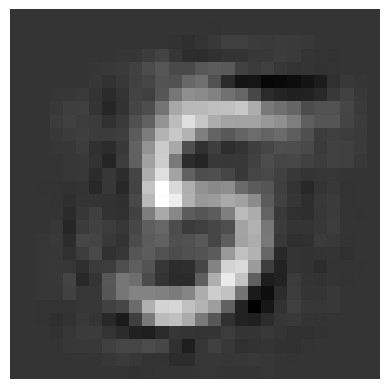

In [111]:
import matplotlib.pyplot as plt

img7 = model.generate_images(5, prior_std=0.01)
plt.imshow(img7.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

In [112]:
fig, axes = plt.subplots(
    nrows=10,
    ncols=10,
    figsize=(10, 10),
    tight_layout=True
)

for digit in range(10):
    # make a batch of labels all equal to `digit`
    labels = torch.full(
        (10,),
        fill_value=digit,
        dtype=torch.long,
        device=model.device
    )
    # generate images; style_z=None → sampled inside with prior_std
    imgs = model.generate_images(labels, style_z=None, prior_std=0.01)

    # plot each sample in its column
    for col in range(10):
        ax = axes[digit, col]
        img = imgs[col].squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.axis('off')

# save to disk
fig.savefig(f'{RESULT_FOLDER}/fig_prio_0_01', dpi=300, bbox_inches='tight')
plt.close(fig)